In [2]:
import pandas as pd
import numpy as np
import os
from numpy import array
from pyspark.sql import *
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from typing import Iterable
# !pip install xlrd
import xlrd

In [49]:
# bat_act_Inact = pd.read_excel("../)
# bat_act_Inact = spark.createDataFrame(bat_act_Inact)
                              
# Loading the Data  
ra_02_df = pd.read_excel("../Data/02 RA data (updated Apr'21) raw data only.xlsx") #01 RA raw data final.xlsx
ka_04_df = pd.read_excel("../Data/04 KA data.xlsx")
sku_mapping = pd.read_csv('../Data/07 mapping table (active SKU).csv')

sku_mapping = sku_mapping.drop_duplicates(['Brand House',
                                           'RA raw data (file 01 & 02)',
                                           'KA data (file 04)'])

print("Total data in ra 02 file -", ra_02_df.shape)

print("Total data in ka 04 file -", ka_04_df.shape)

print("Total data in sku_mapping file -", sku_mapping.shape)


Total data in ra 02 file - (39650, 15)
Total data in ka 04 file - (115395, 9)
Total data in sku_mapping file - (87, 5)


In [50]:
ra_02_df.head()

State Region Channel_Mod Channel Breakdown                          SKU  \
0  Ipoh  NORTH         KAD               KAD              BENSON & HEDGES   
1  Ipoh  NORTH         KAD               KAD            CHESTERFIELD BLUE   
2  Ipoh  NORTH         KAD               KAD        CHESTERFIELD CHARCOAL   
3  Ipoh  NORTH         KAD               KAD           CHESTERFIELD GREEN   
4  Ipoh  NORTH         KAD               KAD  CHESTERFIELD PURPLE CAPSULE   

  Price Segment      Brand House Manufacturer Tar x Flavour  \
0       PREMIUM  Benson & Hedges          BAT  Full Flavour   
1           VFM     Chesterfield          PMI        Lights   
2           VFM     Chesterfield          PMI        Lights   
3           VFM     Chesterfield          PMI       Menthol   
4           VFM     Chesterfield          PMI       Menthol   

  Tar x Flavour with Kretek             Price x Tar      Month   Volume  \
0              Full Flavour  Premium x Full Flavour 2020-01-01  124.677   
1                    Lights            Vfm x Lights 2020-01-01  172.320   
2                    Lights            Vfm x Lights 2020-01-01  102.977   
3                   Menthol           Vfm x Menthol 2020-01-01  139.161   
4                   Menthol           Vfm x Menthol 2020-01-01   73.635   

       Value  Unnamed: 14  
0  108.46899          NaN  
1  106.83840          NaN  
2   63.84574          NaN  
3   86.27982          NaN  
4   45.65370          NaN

In [53]:
ra_02_df.isnull().sum()

State                            0
Region                           0
Channel_Mod                      0
Channel Breakdown                0
SKU                              0
Price Segment                  342
Brand House                    342
Manufacturer                   342
Tar x Flavour                  342
Tar x Flavour with Kretek      342
Price x Tar                    342
Month                            0
Volume                           0
Value                            0
Unnamed: 14                  39650
dtype: int64

In [51]:
ka_04_df.head()

DWH_STATE     ACC Company ProductFamily SKU_CODE PriceSegment Flavour  \
0       NaN  KKMART     BAT           B&H   B&H FF           HP      FF   
1       NaN  KKMART     BAT           B&H   B&H FF           HP      FF   
2       NaN  KKMART     BAT           B&H   B&H FF           HP      FF   
3       NaN  KKMART     BAT           B&H   B&H FF           HP      FF   
4       NaN  KKMART     BAT           B&H   B&H FF           HP      FF   

   YYYYMM  Total (sticks)  
0  201801             600  
1  201802             760  
2  201803             700  
3  201804             820  
4  201805             720

In [54]:
# Null Values In KA04
ka_04_df.isnull().sum()

DWH_STATE         865
ACC                 0
Company             0
ProductFamily       0
SKU_CODE            0
PriceSegment        0
Flavour             0
YYYYMM              0
Total (sticks)      0
dtype: int64

In [55]:
ka_04_df['DWH_STATE'].unique()

array([nan, 'DUTY FREE', 'IPOH', 'JOHOR BARU', 'KOTA BARU',
       'KOTA KINABALU', 'KUALA LUMPUR', 'KUANTAN', 'KUCHING', 'MELAKA',
       'PENANG', 'SELANGOR', '(blank)'], dtype=object)

In [56]:
# replacing (blank) with nan
ka_04_df['DWH_STATE_Cleaned'] = np.where(ka_04_df['DWH_STATE'] == "(blank)",
                                         np.nan,
                                         ka_04_df['DWH_STATE']
                                        )

In [57]:
# Checking Null values Now
# Null Values In KA04
ka_04_df.isnull().sum()

DWH_STATE             865
ACC                     0
Company                 0
ProductFamily           0
SKU_CODE                0
PriceSegment            0
Flavour                 0
YYYYMM                  0
Total (sticks)          0
DWH_STATE_Cleaned    4577
dtype: int64

In [58]:
# Filtering the 2020 date only
# Taking 2020 data only for training purpose
ka_04_2020_df = ka_04_df[(ka_04_df['YYYYMM']>=202001) & (ka_04_df['YYYYMM']<=202012)].reset_index(drop=True)
print("After taking only 2020 data")
print("Shape of the filtered data - ", ka_04_2020_df.shape)
ka_04_2020_df.head()

After taking only 2020 data
Shape of the filtered data -  (39749, 10)


DWH_STATE  ACC Company ProductFamily SKU_CODE PriceSegment Flavour  YYYYMM  \
0  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202001   
1  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202002   
2  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202003   
3  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202004   
4  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202005   

   Total (sticks) DWH_STATE_Cleaned  
0            3900         DUTY FREE  
1            2260         DUTY FREE  
2            1980         DUTY FREE  
3             780         DUTY FREE  
4             680         DUTY FREE

In [63]:
# Aggregating the RA 2 data for finding out the others in voluume
# Few SKUs to merge
sku02_to_comb = {'ROTHMANS KOOL':'ROTHMANS KOOL HOKKAIDO MINT',
                 'MARLBORO REGULAR SC':"MARLBORO REGULAR FF",
                 'MARLBORO REGULAR LIGHTS (GOLD)':'MARLBORO LIGHTS'
                }


# combining the skus
ra_02_df['SKU'] = ra_02_df['SKU'].replace(sku02_to_comb)

# 1. Channel should be  KAD
ra_02_kad_df = ra_02_df[ra_02_df['Channel_Mod'] == 'KAD']

# 2 Data should be of 2020
ra_02_kad_df = ra_02_kad_df[(ra_02_kad_df['Month']>='2020-01-01') & 
                             (ra_02_kad_df['Month']<='2020-12-01')
                            ].reset_index(drop=True)

ra_agg_df = ra_02_kad_df.groupby(['State', 
                                  'SKU',
                                  'Manufacturer',
                                  'Month'])["Volume"].sum().reset_index()

ra_agg_df.columns = ['State', 'sku', 'Company', 'time', 'total_vol']

ra_agg_df.head()

State              sku Company       time  total_vol
0  Ipoh  BENSON & HEDGES     BAT 2020-01-01    124.677
1  Ipoh  BENSON & HEDGES     BAT 2020-02-01    108.907
2  Ipoh  BENSON & HEDGES     BAT 2020-03-01    132.208
3  Ipoh  BENSON & HEDGES     BAT 2020-04-01    173.932
4  Ipoh  BENSON & HEDGES     BAT 2020-05-01    115.438

In [64]:
# Checking 1:1 mapping of sku betweeen ka and ra file
display(sku_mapping[sku_mapping['RA raw data (file 01 & 02)'].duplicated()])

display(sku_mapping[sku_mapping['KA data (file 04)'].duplicated()])

sku_mapping['cnt_chk'] =  sku_mapping.groupby(['RA raw data (file 01 & 02)',
                             "KA data (file 04)"
                            ])["KA data (file 04)"].transform('size')

sku_mapping['cnt_chk2'] =  sku_mapping.groupby(['KA data (file 04)',
                             "RA raw data (file 01 & 02)"
                            ])["RA raw data (file 01 & 02)"].transform('size')

display(sku_mapping[sku_mapping['cnt_chk'] > 1])
display(sku_mapping[sku_mapping['cnt_chk2'] > 1])

sku_mapping.drop(['cnt_chk', 'cnt_chk2'], axis=1, inplace=True)

Manufacturer Brand House RA raw data (file 01 & 02)  \
56          JTI      Mevius                        NaN   
57          JTI      Mevius                        NaN   

             KA data (file 04) Remarks  
56  M7 MTH LTS Nova White Slim     NaN  
57    SALEM MTH LTS Nova White     NaN

Empty DataFrame
Columns: [Manufacturer, Brand House, RA raw data (file 01 & 02), KA data (file 04), Remarks]
Index: []

Empty DataFrame
Columns: [Manufacturer, Brand House, RA raw data (file 01 & 02), KA data (file 04), Remarks, cnt_chk, cnt_chk2]
Index: []

Empty DataFrame
Columns: [Manufacturer, Brand House, RA raw data (file 01 & 02), KA data (file 04), Remarks, cnt_chk, cnt_chk2]
Index: []

In [69]:
# Mergig the ra data with SKU mapping files
print(ra_agg_df.shape)

ra2_agg_df = pd.merge(ra_agg_df, sku_mapping, 
                  left_on= ['sku'],
                  right_on=['RA raw data (file 01 & 02)'],
                  how='left'
                 )
print(ra2_agg_df.shape)

ra2_agg_df = ra2_agg_df.drop(['Manufacturer', 'Brand House',  'RA raw data (file 01 & 02)', 'Remarks'],
                           axis=1
                           )
ra2_agg_df.columns = ['State', 'sku', 'Company', 'time', 'total_vol', 'SKU_CODE']
ra2_agg_df.head()

(8023, 5)
(8023, 10)


State              sku Company       time  total_vol SKU_CODE
0  Ipoh  BENSON & HEDGES     BAT 2020-01-01    124.677   B&H FF
1  Ipoh  BENSON & HEDGES     BAT 2020-02-01    108.907   B&H FF
2  Ipoh  BENSON & HEDGES     BAT 2020-03-01    132.208   B&H FF
3  Ipoh  BENSON & HEDGES     BAT 2020-04-01    173.932   B&H FF
4  Ipoh  BENSON & HEDGES     BAT 2020-05-01    115.438   B&H FF

In [140]:
print('Total SKUs - ', ra2_agg_df['sku'].nunique())
print('Total State - ', ra2_agg_df['State'].nunique())
print('Total State - ', ra2_agg_df['State'].unique())
print('Total Company - ', ra2_agg_df['Company'].unique())

Total SKUs -  85
Total State -  10
Total State -  ['ipoh' 'johor baru' 'kota baru' 'kota kinabalu' 'kuala lumpur' 'kuantan'
 'kuching' 'melaka' 'penang' 'selangor']
Total Company -  ['BAT' 'PMI' 'JTI']


In [75]:
# Mapping with sku mapping file for combining the skus
# Preparing the KA data for merging with the ra data
sku04_comb = {'DH FF DKS BYD' : 'DH FF DKS',
              'DH LTS DKS BYD' : 'DH LTS DKS',
              'DH MTH DKS BYD' : 'DH MTH DKS',
              'ROT MTH Kool' : 'ROT MTH HOKKAIDO Kool',
              'M7 FF Aroma' : 'M7 FF',
              'WINSTON LTS Plus' : 'WINSTON LTS',
              'WINSTON MTH Excel Duo' : 'WINSTON MTH Duo Berry',
              'MARL LTS Gold' : 'MARL LTS'
             }

# combining the skus
ka_04_2020_df['SKU_CODE'] = ka_04_2020_df['SKU_CODE'].replace(sku04_comb)


# Aggregating the ka data
ka_04_2020_df['actual_vol'] =  ka_04_2020_df['Total (sticks)']/1000

ka_agg_df = ka_04_2020_df.groupby(['DWH_STATE_Cleaned',
                                    'SKU_CODE',
                                   'Company',
                                   'YYYYMM'])["actual_vol"].sum().reset_index()

ka_agg_df.head()

DWH_STATE_Cleaned SKU_CODE Company  YYYYMM  actual_vol
0         DUTY FREE   B&H FF     BAT  202001        3.90
1         DUTY FREE   B&H FF     BAT  202002        2.26
2         DUTY FREE   B&H FF     BAT  202003        1.98
3         DUTY FREE   B&H FF     BAT  202004        0.78
4         DUTY FREE   B&H FF     BAT  202005        0.68

In [89]:
print("Total Data",  ka_agg_df.shape)
print("Total Unique SKUs",  ka_agg_df['SKU_CODE'].nunique())
print("Total Unique DWH_STATE_Cleaned",  ka_agg_df['DWH_STATE_Cleaned'].nunique())
print("Total Unique DWH_STATE_Cleaned",  ka_agg_df['DWH_STATE_Cleaned'].unique())
print("Total Unique Company",  ka_agg_df['Company'].unique())

Total Data (8981, 7)
Total Unique SKUs 103
Total Unique DWH_STATE_Cleaned 11
Total Unique DWH_STATE_Cleaned ['duty free' 'ipoh' 'johor baru' 'kota baru' 'kota kinabalu'
 'kuala lumpur' 'kuantan' 'kuching' 'melaka' 'penang' 'selangor']
Total Unique Company ['BAT' 'JTI' 'PMI']


In [90]:
# Preparing data before merging
ka_agg_df['time'] = pd.to_datetime(ka_agg_df['YYYYMM'],
                                  format='%Y%m'
                                  )
ka_agg_df['SKU_CODE'] = ka_agg_df['SKU_CODE'].str.strip()

ka_agg_df['State'] = ka_agg_df['DWH_STATE_Cleaned'].str.strip().str.lower()


ra2_agg_df['SKU_CODE'] = ra2_agg_df['SKU_CODE'].str.strip()
ra2_agg_df['State'] = ra2_agg_df['State'].str.strip().str.lower()

final_merged_df = pd.merge(ka_agg_df, ra2_agg_df,
                           on=['State', 'SKU_CODE', 'Company', 'time'],
                           how='inner'
                          )

print('data after merging', final_merged_df.shape)
print('Unique SKUs: ', final_merged_df['SKU_CODE'].nunique())
final_merged_df.head()
# display(ka_agg_df.head())
# display(ra2_agg_df.head())

data after merging (7589, 9)
Unique SKUs:  76


DWH_STATE_Cleaned SKU_CODE Company  YYYYMM  actual_vol       time State  \
0              ipoh   B&H FF     BAT  202001      100.16 2020-01-01  ipoh   
1              ipoh   B&H FF     BAT  202002       87.40 2020-02-01  ipoh   
2              ipoh   B&H FF     BAT  202003      107.74 2020-03-01  ipoh   
3              ipoh   B&H FF     BAT  202004      148.12 2020-04-01  ipoh   
4              ipoh   B&H FF     BAT  202005       93.78 2020-05-01  ipoh   

               sku  total_vol  
0  BENSON & HEDGES    124.677  
1  BENSON & HEDGES    108.907  
2  BENSON & HEDGES    132.208  
3  BENSON & HEDGES    173.932  
4  BENSON & HEDGES    115.438

#### actual_vol - Ka 04
#### total_vol - ra 02

In [92]:
# Stats of ra file
final_merged_df['total_vol'].describe()

count    7589.000000
mean      257.687032
std       570.708291
min         0.020000
25%        28.445000
50%        87.958000
75%       240.217000
max      8852.765000
Name: total_vol, dtype: float64

In [93]:
# stats of ka file
final_merged_df['actual_vol'].describe()

count    7589.000000
mean      218.621630
std       473.160318
min         0.020000
25%        23.320000
50%        73.100000
75%       208.880000
max      7438.760000
Name: actual_vol, dtype: float64

In [94]:
# Replacing 0 with some low values
final_merged_df['total_vol'] = final_merged_df['total_vol'].replace(0, 0.0001)

In [95]:
final_merged_df['diff_in_vol'] = final_merged_df['total_vol'] - final_merged_df['actual_vol']
final_merged_df['percent_cover'] = (final_merged_df['actual_vol'] / final_merged_df['total_vol'])*100



In [98]:
final_merged_df['percent_cover'].describe()

count      7589.000000
mean        189.104703
std        2776.608134
min           1.104210
25%          79.414265
50%          85.021097
75%          92.038278
max      123818.181818
Name: percent_cover, dtype: float64

In [99]:
final_merged_df['diff_in_vol'].describe()

count    7589.000000
mean       39.065401
std       111.892689
min      -105.500000
25%         2.059000
50%        11.969000
75%        35.449000
max      2186.252640
Name: diff_in_vol, dtype: float64

In [104]:
(final_merged_df['diff_in_vol']>=0).sum()

7091

In [105]:
final_merged_df.head()

DWH_STATE_Cleaned SKU_CODE Company  YYYYMM  actual_vol       time State  \
0              ipoh   B&H FF     BAT  202001      100.16 2020-01-01  ipoh   
1              ipoh   B&H FF     BAT  202002       87.40 2020-02-01  ipoh   
2              ipoh   B&H FF     BAT  202003      107.74 2020-03-01  ipoh   
3              ipoh   B&H FF     BAT  202004      148.12 2020-04-01  ipoh   
4              ipoh   B&H FF     BAT  202005       93.78 2020-05-01  ipoh   

               sku  total_vol  diff_in_vol  percent_cover  
0  BENSON & HEDGES    124.677       24.517      80.335587  
1  BENSON & HEDGES    108.907       21.507      80.251958  
2  BENSON & HEDGES    132.208       24.468      81.492799  
3  BENSON & HEDGES    173.932       25.812      85.159718  
4  BENSON & HEDGES    115.438       21.658      81.238414

In [106]:
ka_04_2020_df.head(2)

DWH_STATE  ACC Company ProductFamily SKU_CODE PriceSegment Flavour  YYYYMM  \
0  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202001   
1  DUTY FREE  711     BAT           B&H   B&H FF           HP      FF  202002   

   Total (sticks) DWH_STATE_Cleaned  actual_vol  
0            3900         DUTY FREE        3.90  
1            2260         DUTY FREE        2.26

In [107]:
# COnverting this data frame to make it compatable to ka04
final_merged_df['ACC'] = 'Others'
final_merged_df['actual_vol'] = final_merged_df['diff_in_vol'].copy()

final_merged_df = final_merged_df[['DWH_STATE_Cleaned', 
                                   'ACC',
                                   'Company',
                                   'SKU_CODE',
                                   'YYYYMM',
                                   'actual_vol'
                                  ]]

final_merged_df.head()

DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol
0              ipoh  Others     BAT   B&H FF  202001      24.517
1              ipoh  Others     BAT   B&H FF  202002      21.507
2              ipoh  Others     BAT   B&H FF  202003      24.468
3              ipoh  Others     BAT   B&H FF  202004      25.812
4              ipoh  Others     BAT   B&H FF  202005      21.658

In [108]:
# Aggregating the KA04 data to merge the rest volumnes in it
ka_04_2020_tmp_df = ka_04_2020_df.groupby(['DWH_STATE_Cleaned', 
                                           'ACC',
                                           'Company',
                                           'SKU_CODE',
                                           'YYYYMM'                                          
                                          ])['actual_vol'].sum().reset_index()

ka_04_2020_tmp_df.head()

DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol
0         DUTY FREE  711     BAT   B&H FF  202001        3.90
1         DUTY FREE  711     BAT   B&H FF  202002        2.26
2         DUTY FREE  711     BAT   B&H FF  202003        1.98
3         DUTY FREE  711     BAT   B&H FF  202004        0.78
4         DUTY FREE  711     BAT   B&H FF  202005        0.68

In [109]:
# Appending both the data set
final_ka04_df = pd.concat([ka_04_2020_tmp_df, final_merged_df],
                          axis=0,
                          ignore_index=True
                         )

print("Final shape of the data- ", final_ka04_df.shape)


final_ka04_df.sort_values(by=['DWH_STATE_Cleaned', 
                              'ACC',
                              'Company',
                              'SKU_CODE',
                              'YYYYMM'], inplace=True)
final_ka04_df.head()

Final shape of the data-  (45367, 6)


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol
0         DUTY FREE  711     BAT   B&H FF  202001        3.90
1         DUTY FREE  711     BAT   B&H FF  202002        2.26
2         DUTY FREE  711     BAT   B&H FF  202003        1.98
3         DUTY FREE  711     BAT   B&H FF  202004        0.78
4         DUTY FREE  711     BAT   B&H FF  202005        0.68

In [129]:
final_ka04_df['DWH_STATE_Cleaned'] = final_ka04_df['DWH_STATE_Cleaned'].str.lower().copy()

<ipython-input-129-505a374f2ccb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_ka04_df['DWH_STATE_Cleaned'] = final_ka04_df['DWH_STATE_Cleaned'].str.lower().copy()


In [130]:
final_ka04_df['DWH_STATE_Cleaned'].nunique()

11

In [113]:
final_ka04_df.shape

(45367, 6)

In [111]:
final_ka04_df.to_csv('final_ka04_data_02.csv', index=False)

e:\support project\retail_items_forecasting\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


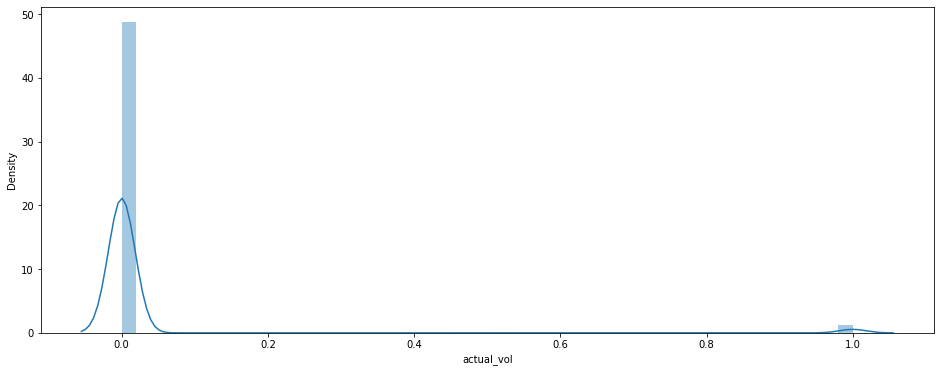

In [112]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 6))
sns.distplot(final_ka04_df['actual_vol']<=0)
plt.xlim()
plt.show()

e:\support project\retail_items_forecasting\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


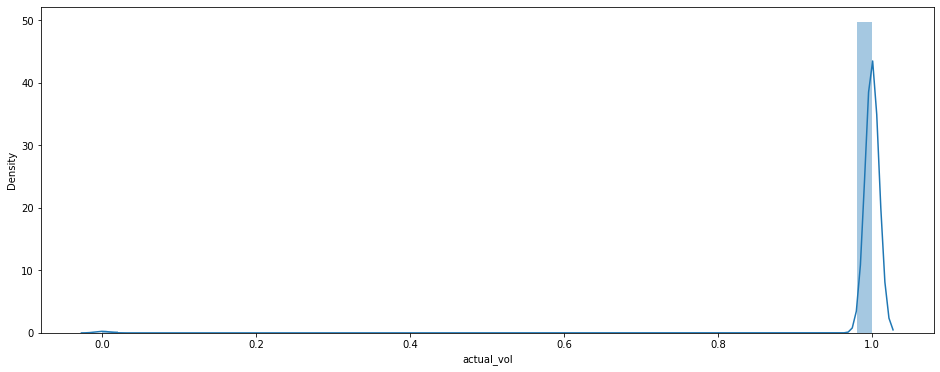

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 6))
sns.distplot(final_ka04_df['actual_vol']>0)
plt.xlim()
plt.show()

In [115]:
(final_ka04_df['actual_vol']<0).sum()

498

In [116]:
# Removing the Skus where the actual vol is 0 or less than 0
final_ka04_df = final_ka04_df[final_ka04_df['actual_vol'] > 0]

In [139]:
final_ka04_df.to_csv('final_sku_data.csv', index=False)

In [117]:
final_ka04_df.shape

(44219, 6)

In [1]:
final_ka04_df = pd.read_csv('final_sku_data.csv')
print(final_ka04_df.shape)

NameError: name 'pd' is not defined

In [143]:
# from pyspark.context import SparkContext
# from pyspark.sql.session import SparkSession
# sc = SparkContext('local')
# spark = SparkSession(sc)
from pyspark import SparkContext
from pyspark.sql import SQLContext
import findspark as fs
fs.init()
sc =SparkContext.getOrCreate()

In [144]:
sqlContext = SQLContext(sc)

In [145]:
bat_act_Inact = sqlContext.createDataFrame(final_ka04_df)
# bat_act_Inact = spark.createDataFrame(final_ka04_df)

In [146]:
bat_act_Inact.count()

44219

In [122]:
bat_act_Inact.show(10)

+-----------------+---+-------+--------+------+----------+
|DWH_STATE_Cleaned|ACC|Company|SKU_CODE|YYYYMM|actual_vol|
+-----------------+---+-------+--------+------+----------+
|        DUTY FREE|711|    BAT|  B&H FF|202001|       3.9|
|        DUTY FREE|711|    BAT|  B&H FF|202002|      2.26|
|        DUTY FREE|711|    BAT|  B&H FF|202003|      1.98|
|        DUTY FREE|711|    BAT|  B&H FF|202004|      0.78|
|        DUTY FREE|711|    BAT|  B&H FF|202005|      0.68|
|        DUTY FREE|711|    BAT|  B&H FF|202006|      1.82|
|        DUTY FREE|711|    BAT|  B&H FF|202007|      2.48|
|        DUTY FREE|711|    BAT|  B&H FF|202008|      2.66|
|        DUTY FREE|711|    BAT|  B&H FF|202009|       1.7|
|        DUTY FREE|711|    BAT|  B&H FF|202010|      1.12|
+-----------------+---+-------+--------+------+----------+
only showing top 10 rows



In [9]:
# bat_act = bat_act_Inact[bat_act_Inact['PRODUCT_STATUS']=='A']

In [10]:
# bat_act.count()

Out[31]: 538

In [11]:
# bat_act =bat_act.drop('COMPANY_ID','PRODUCT_NAME')
# bat_act= bat_act.withColumnRenamed('PRODUCT_ID','PRODUCT_IDs')

In [12]:
# df_monthly_active = df_monthly.join(bat_act, df_monthly.PRODUCT_ID == bat_act.PRODUCT_IDs, how="inner")

In [13]:
# ddf_weekly_SC = df_monthly_active.groupby('YEAR').agg({'TOTAL_SALES_PACKS':'sum'})
# ddf_weekly_SC.show()

In [14]:
# df_monthly_active= df_monthly_active.drop('PRODUCT_IDs','PRODUCT_STATUS')


In [15]:
# df_monthly_active.printSchema()

root
-- YEAR: decimal(4,0) (nullable = true)
-- MONTH: decimal(2,0) (nullable = true)
-- OUTLET_ID: string (nullable = true)
-- OUTLET_NAME: string (nullable = true)
-- REGION_ID: string (nullable = true)
-- REGION_NAME: string (nullable = true)
-- COMPANY_ID: string (nullable = true)
-- COMPANY_NAME: string (nullable = true)
-- PRODUCT_ID: string (nullable = true)
-- BRAND_FAMILY: string (nullable = true)
-- BRAND_GROUP: string (nullable = true)
-- PRODUCT_TYPE: string (nullable = true)
-- PRODUCT_TYPE_NAME: string (nullable = true)
-- COMBUSTIBLE_FLAG: string (nullable = true)
-- BRAND_CATEGORY: string (nullable = true)
-- PRICE_PER_PACK: decimal(26,8) (nullable = true)
-- STICKS_PER_PACK: decimal(24,9) (nullable = true)
-- TOTAL_SALES_PACKS: decimal(38,0) (nullable = true)

In [16]:
# df_monthly = df_monthly_active

In [17]:
# from pyspark.sql import functions as func
# df_monthly =df_monthly.withColumn('Price_per_stick',func.col('PRICE_PER_PACK')/func.col('STICKS_PER_PACK'))
# df_monthly =df_monthly.withColumn('Revenue',func.col('PRICE_PER_PACK')*func.col('TOTAL_SALES_PACKS'))
# df_monthly =df_monthly.withColumn('Volume',func.col('STICKS_PER_PACK')*func.col('TOTAL_SALES_PACKS'))
# df_monthly = df_monthly.dropna()
# from pyspark.sql.functions import concat, col, lit

In [18]:
# df_monthly= df_monthly.withColumn("Month_Year", concat(col("YEAR"),lit("-"), col('MONTH')))

In [147]:
df_monthly = bat_act_Inact

In [148]:
df_monthly.schema

StructType(List(StructField(DWH_STATE_Cleaned,StringType,true),StructField(ACC,StringType,true),StructField(Company,StringType,true),StructField(SKU_CODE,StringType,true),StructField(YYYYMM,LongType,true),StructField(actual_vol,DoubleType,true)))

In [149]:
df_monthly.head(5)

[Row(DWH_STATE_Cleaned='duty free', ACC='711', Company='BAT', SKU_CODE='B&H FF', YYYYMM=202001, actual_vol=3.9),
 Row(DWH_STATE_Cleaned='duty free', ACC='711', Company='BAT', SKU_CODE='B&H FF', YYYYMM=202002, actual_vol=2.26),
 Row(DWH_STATE_Cleaned='duty free', ACC='711', Company='BAT', SKU_CODE='B&H FF', YYYYMM=202003, actual_vol=1.98),
 Row(DWH_STATE_Cleaned='duty free', ACC='711', Company='BAT', SKU_CODE='B&H FF', YYYYMM=202004, actual_vol=0.78),
 Row(DWH_STATE_Cleaned='duty free', ACC='711', Company='BAT', SKU_CODE='B&H FF', YYYYMM=202005, actual_vol=0.68)]

In [150]:
df1 = df_monthly.groupBy("DWH_STATE_Cleaned",
                         "ACC", 
                         "Company", 
                         'SKU_CODE').pivot('YYYYMM').agg({'actual_vol':'sum'}).orderBy(['SKU_CODE'])

In [151]:
df1.head(5)

[Row(DWH_STATE_Cleaned='selangor', ACC='BHP', Company='BAT', SKU_CODE='B&H FF', 202001=20.06, 202002=19.64, 202003=19.74, 202004=15.26, 202005=19.48, 202006=27.28, 202007=27.6, 202008=28.8, 202009=27.66, 202010=25.36, 202011=24.98, 202012=26.92),
 Row(DWH_STATE_Cleaned='penang', ACC='Others', Company='BAT', SKU_CODE='B&H FF', 202001=27.962999999999997, 202002=25.473, 202003=34.34800000000001, 202004=33.88199999999998, 202005=23.5, 202006=30.425, 202007=33.81600000000003, 202008=27.38500000000002, 202009=26.263409999999997, 202010=26.827, 202011=22.952, 202012=24.976),
 Row(DWH_STATE_Cleaned='kuala lumpur', ACC='BHP', Company='BAT', SKU_CODE='B&H FF', 202001=17.96, 202002=17.42, 202003=17.46, 202004=14.02, 202005=18.18, 202006=22.68, 202007=22.02, 202008=20.44, 202009=19.4, 202010=18.68, 202011=19.16, 202012=21.22),
 Row(DWH_STATE_Cleaned='melaka', ACC='711', Company='BAT', SKU_CODE='B&H FF', 202001=116.62, 202002=107.38, 202003=131.34, 202004=188.1, 202005=72.56, 202006=92.8, 202007=93

In [152]:
display(df1.head())

Row(DWH_STATE_Cleaned='melaka', ACC='711', Company='BAT', SKU_CODE='B&H FF', 202001=116.62, 202002=107.38, 202003=131.34, 202004=188.1, 202005=72.56, 202006=92.8, 202007=93.62, 202008=97.1, 202009=88.06, 202010=83.76, 202011=70.42, 202012=77.66)

In [137]:
groupby_cols = []

for i in df1.columns:
  groupby_cols.append(i)

cols_base = groupby_cols[5:]
cols_base

['202002',
 '202003',
 '202004',
 '202005',
 '202006',
 '202007',
 '202008',
 '202009',
 '202010',
 '202011',
 '202012']

In [21]:
def melt(
        df: DataFrame, 
        id_vars: Iterable[str], value_vars: Iterable[str], 
        var_name: str="variable", value_name: str="value") -> DataFrame:
    'Convert :class:`DataFrame` from wide to long format.'
    # -------------------------------------------------------------------------------
    # Create array<struct<variable: str, value: ...>>
    # -------------------------------------------------------------------------------
    _vars_and_vals = array(*(
        struct(lit(c).alias(var_name), col(c).alias(value_name)) 
        for c in value_vars))
    # -------------------------------------------------------------------------------
    # Add to the DataFrame and explode
    # -------------------------------------------------------------------------------
    _tmp = df.withColumn("_vars_and_vals", explode(_vars_and_vals))
    cols = id_vars + [
            col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)
# -------------------------------------------------------------------------------
# Let's Implement Wide to Long in Pyspark!
# -------------------------------------------------------------------------------
unpivotdf = melt(df1, 
            id_vars=['COMPANY_ID', "COMPANY_NAME", 'BRAND_FAMILY','OUTLET_ID'], 
            value_vars=cols_base)
display(unpivotdf)

COMPANY_ID COMPANY_NAME BRAND_FAMILY OUTLET_ID variable value BAT British American Tobacco NEO 425503 2018-10 480.0 BAT British American Tobacco NEO 425503 2018-11 120.0 BAT British American Tobacco NEO 425503 2018-12 440.0 BAT British American Tobacco NEO 425503 2018-9 240.0 BAT British American Tobacco NEO 425503 2019-1 220.0 BAT British American Tobacco NEO 425503 2019-10 null BAT British American Tobacco NEO 425503 2019-11 null BAT British American Tobacco NEO 425503 2019-12 null BAT British American Tobacco NEO 425503 2019-2 40.0 BAT British American Tobacco NEO 425503 2019-3 null BAT British American Tobacco NEO 425503 2019-4 null BAT British American Tobacco NEO 425503 2019-5 null BAT British American Tobacco NEO 425503 2019-6 null BAT British American Tobacco NEO 425503 2019-7 null BAT British American Tobacco NEO 425503 2019-8 null BAT British American Tobacco NEO 425503 2019-9 null BAT British American Tobacco NEO 425503 2020-1 null BAT British American Tobacco NEO 425503 2020-2 null BAT British American Tobacco NEO 425503 2020-3 null BAT British American Tobacco NEO 425503 2020-4 null BAT British American Tobacco NEO 425503 2020-5 null BAT British American Tobacco NEO 425503 2020-6 null BAT British American Tobacco NEO 425503 2020-7 null BAT British American Tobacco NEO 425503 2020-8 null BAT British American Tobacco NEO 675409 2018-10 40.0 BAT British American Tobacco NEO 675409 2018-11 60.0 BAT British American Tobacco NEO 675409 2018-12 null BAT British American Tobacco NEO 675409 2018-9 40.0 BAT British American Tobacco NEO 675409 2019-1 160.0 BAT British American Tobacco NEO 675409 2019-10 20.0 BAT British American Tobacco NEO 675409 2019-11 20.0 BAT British American Tobacco NEO 675409 2019-12 null BAT British American Tobacco NEO 675409 2019-2 40.0 BAT British American Tobacco NEO 675409 2019-3 20.0 BAT British American Tobacco NEO 675409 2019-4 40.0 BAT British American Tobacco NEO 675409 2019-5 20.0 BAT British American Tobacco NEO 675409 2019-6 60.0 BAT British American Tobacco NEO 675409 2019-7 40.0 BAT British American Tobacco NEO 675409 2019-8 null BAT British American Tobacco NEO 675409 2019-9 null BAT British American Tobacco NEO 675409 2020-1 null BAT British American Tobacco NEO 675409 2020-2 null BAT British American Tobacco NEO 675409 2020-3 null BAT British American Tobacco NEO 675409 2020-4 null BAT British American Tobacco NEO 675409 2020-5 null BAT British American Tobacco NEO 675409 2020-6 null BAT British American Tobacco NEO 675409 2020-7 null BAT British American Tobacco NEO 675409 2020-8 null BAT British American Tobacco NEO 159441 2018-10 null BAT British American Tobacco NEO 159441 2018-11 null BAT British American Tobacco NEO 159441 2018-12 null BAT British American Tobacco NEO 159441 2018-9 null BAT British American Tobacco NEO 159441 2019-1 20.0 BAT British American Tobacco NEO 159441 2019-10 null BAT British American Tobacco NEO 159441 2019-11 null BAT British American Tobacco NEO 159441 2019-12 null BAT British American Tobacco NEO 159441 2019-2 40.0 BAT British American Tobacco NEO 159441 2019-3 null BAT British American Tobacco NEO 159441 2019-4 40.0 BAT British American Tobacco NEO 159441 2019-5 60.0 BAT British American Tobacco NEO 159441 2019-6 null BAT British American Tobacco NEO 159441 2019-7 80.0 BAT British American Tobacco NEO 159441 2019-8 20.0 BAT British American Tobacco NEO 159441 2019-9 null BAT British American Tobacco NEO 159441 2020-1 null BAT British American Tobacco NEO 159441 2020-2 null BAT British American Tobacco NEO 159441 2020-3 null BAT British American Tobacco NEO 159441 2020-4 null BAT British American Tobacco NEO 159441 2020-5 null BAT British American Tobacco NEO 159441 2020-6 null BAT British American Tobacco NEO 159441 2020-7 null BAT British American Tobacco NEO 159441 2020-8 null BAT British American Tobacco NEO 310705 2018-10 220.0 BAT British American Tobacco NEO 310705 2018-11 180.0 BAT British American Tobacco NEO 310705 2018-12 160.0 BAT Brit

In [154]:
unpivotdf = final_ka04_df.copy()

In [155]:
split_col = func.split(unpivotdf['variable'], '-')
splitted_df = unpivotdf.withColumn('YEAR', split_col.getItem(0))
splitted_df = splitted_df.withColumn('MONTH', split_col.getItem(1))
splitted_df = splitted_df.withColumn('VOLUME', splitted_df.value)
splitted_df = splitted_df.drop("variable").drop("value")

NameError: name 'func' is not defined

In [23]:
# key_acc = pd.read_excel('/dbfs/FileStore/tables/KDF_key_account_mapping.xlsx')
# key_acc = spark.createDataFrame(key_acc)
# #display(key_acc)

In [24]:
key_acc = key_acc.withColumn("OUTLET_ID", key_acc["OUTLET_ID"].cast(StringType()))

In [25]:
# merged_df = splitted_df.join(key_acc, splitted_df.OUTLET_ID == key_acc.OUTLET_ID, how="left")

In [26]:
merged_df = merged_df.select(merged_df.COMPANY_ID,
                             merged_df.COMPANY_NAME,
                             merged_df.BRAND_FAMILY,
                             merged_df["Key accounts"],
                             merged_df.YEAR,
                             merged_df.MONTH,
                             merged_df.VOLUME
)
merged_df = merged_df.withColumn("VOLUME", when(merged_df.VOLUME.isNull(), 0).otherwise(merged_df.VOLUME))
#display(merged_df)

In [27]:
merged_df = merged_df.groupBy('COMPANY_ID', "COMPANY_NAME", 'BRAND_FAMILY','Key accounts','YEAR','MONTH').agg({'VOLUME':'sum'})

In [28]:
merged_df = merged_df.withColumnRenamed('sum(VOLUME)','VOLUME')

In [29]:
merged_df.count()

Out[50]: 768

In [30]:
merg_dup = merged_df.toPandas()

In [31]:
# merg_dup['VOLUME'].sum()

Out[52]: Decimal('6415502.000000')

In [32]:
# data_BAT = merg_dup[merg_dup.COMPANY_NAME == 'British American Tobacco']

In [33]:
data_BAT['ACC'].unique()

Out[54]: array(['FM', 'MS', 'S1', 'WM', 'HP', 'GS', None, 'CS'], dtype=object)

In [34]:
data_BAT = data_BAT[data_BAT['Key accounts']!=None]
data_BAT =data_BAT[data_BAT['Key accounts']!='']
data_BAT = data_BAT[data_BAT['Key accounts']!='None']
data_BAT =data_BAT[data_BAT['Key accounts']!='NULL']
data_BAT =data_BAT[data_BAT['Key accounts']!=None]


In [35]:
data_BAT['Key accounts'].value_counts()

Out[56]: GS 96
CS 96
FM 96
MS 96
HP 96
WM 96
S1 96
Name: Key accounts, dtype: int64

In [36]:
data_BAT['MONTH'] = data_BAT['MONTH'].astype(int)
data_BAT['YEAR'] = data_BAT['YEAR'].astype(int)

In [37]:
data_BAT.sort_values(['BRAND_FAMILY','Key accounts','YEAR','MONTH'],inplace = True,ascending = [True,True,True,True])

In [38]:
data_BAT.dtypes

Out[59]: COMPANY_ID object
COMPANY_NAME object
BRAND_FAMILY object
Key accounts object
YEAR int64
MONTH int64
VOLUME object
dtype: object

In [39]:
#Creating UID for running the loop
data_BAT['uid'] = data_BAT['BRAND_FAMILY'].astype(str) + '-' + data_BAT['Key accounts'].astype(str)

In [4]:
# Creating new columns
final_ka04_df['year'] = final_ka04_df['YYYYMM'].astype(str).str[0:4]
final_ka04_df['year'] = final_ka04_df['year'].astype(int)
print("Unique Year ", final_ka04_df['year'].unique())

final_ka04_df['month'] = final_ka04_df['YYYYMM'].astype(str).str[4:]
final_ka04_df['month'] = final_ka04_df['month'].astype(int)
print("Unique month ", final_ka04_df['month'].unique())

final_ka04_df['uid'] = final_ka04_df['DWH_STATE_Cleaned'] + "-" + \
final_ka04_df['ACC'] + "-" + final_ka04_df['Company'] + "-" +  final_ka04_df['SKU_CODE']

print('No of unique uids - ', final_ka04_df['uid'].nunique())
final_ka04_df.head()

Unique Year  [2020]
Unique month  [ 1  2  3  4  5  6  7  8  9 10 11 12]
No of unique uids -  4324


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         duty free  711     BAT   B&H FF  202001        3.90  2020      1   
1         duty free  711     BAT   B&H FF  202002        2.26  2020      2   
2         duty free  711     BAT   B&H FF  202003        1.98  2020      3   
3         duty free  711     BAT   B&H FF  202004        0.78  2020      4   
4         duty free  711     BAT   B&H FF  202005        0.68  2020      5   

                        uid  
0  duty free-711-BAT-B&H FF  
1  duty free-711-BAT-B&H FF  
2  duty free-711-BAT-B&H FF  
3  duty free-711-BAT-B&H FF  
4  duty free-711-BAT-B&H FF

In [40]:
data_BAT.head()

COMPANY_ID 
 COMPANY_NAME 
 BRAND_FAMILY 
 Key accounts 
 YEAR 
 MONTH 
 VOLUME 
 uid 
 
 
 
 
 97 
 BAT 
 British American Tobacco 
 NEO 
 CS 
 2018 
 9 
 220.000000 
 NEO-CS 
 
 
 579 
 BAT 
 British American Tobacco 
 NEO 
 CS 
 2018 
 10 
 940.000000 
 NEO-CS 
 
 
 226 
 BAT 
 British American Tobacco 
 NEO 
 CS 
 2018 
 11 
 420.000000 
 NEO-CS 
 
 
 180 
 BAT 
 British American Tobacco 
 NEO 
 CS 
 2018 
 12 
 820.000000 
 NEO-CS 
 
 
 204 
 BAT 
 British American Tobacco 
 NEO 
 CS 
 2019 
 1 
 780.000000 
 NEO-CS

In [41]:
df_ls = data_BAT.groupby(['COMPANY_ID', 'COMPANY_NAME', 'BRAND_FAMILY', 'Key accounts', 'YEAR',
       'MONTH', 'uid'
       ], as_index = False).agg({'VOLUME': 'sum'})

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exp_smoothing_trend(ts,extra_periods=1,alpha=0.4,beta=0.4,phi=0.9):
 
    """
    This function calculates a forecast with an exponential smoothing + damped trend method.
     
    Inputs
      - ts: the historical values (a list, a numpy array or a pandas series)
      - extra_periods: the number of data points that you want to forecast
      - alpha: the level parameter
      - beta: the trend parameter
      - phi: the trend damping parameter
    """
     
    # Avoid any edition of original list, array or dataframe
    ts = ts.copy()
    
    # Transform ts into list
    try:
        ts = ts.tolist()
    except:
        pass  
       
    # Initialization
    f = [np.nan] # First forecast is set to null value
    a = [ts[0]] # First level defined as the first demand point
    b = [ts[1]-ts[0]] # First trend is computed as the difference between the two first demand points
 
    # Create all the m+1 forecast
    for t in range(1,len(ts)):
        # Update forecast based on last level (a) and trend (b)
        f.append(a[t-1]+phi*b[t-1])
        
        # Update the level based on the new data point
        a.append(alpha*ts[t]+(1-alpha)*(a[t-1]+phi*b[t-1]))
         
        # Update the trend based on the new data point
        b.append(beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1])
         
    # Forecast for all extra months
    for t in range(extra_periods):
        # Update the forecast as the most up-to-date level + trend
        f.append(a[-1]+phi*b[-1])
        # the level equals the forecast
        a.append(f[-1])
        # Update the trend as the previous trend
        b.append(phi*b[-1])
        # fill in ts by np.nan for easy plotting
        ts.append(np.nan)
         
     
    # Populate table with all the results
    dic = {"demand":ts,"forecast":f,"level":a,"trend":b}
    results = pd.DataFrame.from_dict(dic)
    results.index.name = 'Period'
    results["error"] = results["forecast"] - results["demand"] 
        
    # Return the full data set and an indicator of past MAEP    
    return results  


In [43]:
df_ls.dtypes


Out[64]: COMPANY_ID object
COMPANY_NAME object
BRAND_FAMILY object
Key accounts object
YEAR int64
MONTH int64
uid object
VOLUME object
dtype: object

In [44]:
df_ls['VOLUME'] = df_ls['VOLUME'].astype(int)
#df_ls['Cumulative'] = df_ls['Cumulative'].astype(int)

In [45]:
df_ls.columns

Out[66]: Index(['COMPANY_ID', 'COMPANY_NAME', 'BRAND_FAMILY', 'Key accounts', 'YEAR',
 'MONTH', 'uid', 'VOLUME'],
 dtype='object')

In [46]:
# df_ls = df_ls[df_ls['PRODUCT_ID'].isin(['NEO_PUR.E','NEO_FRE.E','NEO_BST.E','NEO_BRT.E','NEO_DAR.E','NEO_TRO.E','NEO_ZEST.E','NEO_SWT.E'])]

In [47]:
df_ls['VOLUME'].sum()

Out[69]: 6154658

In [5]:
final_ka04_df['actual_vol'].sum()

1999882.0305

In [48]:
# df_ls['Cumulative'] = df_ls.groupby(['COMPANY_ID', 'COMPANY_NAME', 'BRAND_FAMILY', 'Key accounts'])['VOLUME'].apply(
#     lambda x: x.cumsum())


# df_ls = df_ls[df_ls.Cumulative != 0].reset_index(drop=True)

# df_ls['Zeros'] = df_ls.groupby(['uid'], as_index = False)['VOLUME'].transform(lambda x: x.eq(0).sum())

# df_ls['Length'] = df_ls.groupby(['uid'], as_index = False)['VOLUME'].transform(lambda x: len(x))
# ##Consider unique groups which has less than 40% of the data as Zeros
# df_ls = df_ls[df_ls.Zeros/df_ls.Length < .40 ]
# df_ls = df_ls.replace(0,0.001)
# #Set the forecast horizon wich is equal to test horizon
# h=3
# #Running through all the Key Account and PRoductID
# final_prediction = pd.DataFrame()
# for i in np.unique(df_ls.uid):
#     da = df_ls[df_ls.uid == i]
#     if(len(da) >=3):
#         #Creating Train and test
#         data_ts1=da[['VOLUME']].reset_index(drop = True)
#         data_ts = data_ts1.VOLUME
#         train= data_ts[:-h]
#         test = data_ts[-h:]
        
#         #Train the Model and test
#         data_pred = exp_smoothing_trend(train,extra_periods=h)
#         data_pred['demand'] = data_ts1['VOLUME']
#     #     print(data_pred)
            
#         #Calculate performance metrics
#         df_per = data_pred.tail(h)
#     #     print("df_per")
#     #     print(df_per)
#     #     df_per = df_per.fillna(0)
#     #     df_per.columns
#         MSE= mean_squared_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
#         MAE= mean_absolute_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
#         MAPE= mean_absolute_percentage_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
#     #     print(MSE, MAE, MAPE)
        
#         # Creating the model using full data and forecasting n steps  
#         data_forcast = exp_smoothing_trend(data_ts,extra_periods=h,alpha=0.4,beta=0.4,phi=0.8)
#         data_forcast['uid'] = i
    
    
#         #Appending Performance metrics to the final frame
#         data_forcast['MSE'] = MSE
#         data_forcast['MAE'] = MAE
#         data_forcast['MAPE'] = MAPE
#         data_forcast['Acc'] = 100 - MAPE
#         data_forcast = data_forcast.reset_index(drop=True)
        
#         #Creating the future dataframe
#         time = da[['MONTH','YEAR']]
#     #     time = time.drop(time[(time['YEAR'] == 2020) & (time['MONTH'] >= 7)].index)
#         time_future = pd.DataFrame()
#         time_future['MONTH'] = range(time['MONTH'].iloc[-1] + 1, time['MONTH'].iloc[-1] + (len(df_per)+1))
#         time_future = time_future.assign(YEAR = 2020)
#         time = time.append(time_future).reset_index(drop=True)
        
#         #Appending the required data to be shown in the final file
#         data_forcast1 = pd.merge(time,data_forcast,right_index=True,left_index=True, how= 'left')
#         data_forcast1 = pd.merge(data_forcast1, da[['COMPANY_ID', 'COMPANY_NAME', 'BRAND_FAMILY', 'Key accounts', 'uid']], on='uid', how= 'left')
#         data_forcast1=data_forcast1.drop_duplicates().reset_index(drop=True)
#         #data_forcast1 = data_forcast1.rename(columns={'WEEK_YEAR': 'date'})
#         #data_forcast1['date'] = da['MONTH_YEAR']
#         data_forcast1['date'] = data_forcast1.YEAR.astype(str) + '/' + data_forcast1.MONTH.astype(str)
#         data_forcast1 = data_forcast1[['date','MONTH', 'YEAR', 'COMPANY_ID', 'COMPANY_NAME',
#            'BRAND_FAMILY', 'Key accounts', 
#             'demand', 'forecast', 'uid',
#            'MSE', 'MAE', 'MAPE', 'Acc']]
    
#         final_prediction=final_prediction.append(data_forcast1)
 


In [6]:
df_ls = final_ka04_df.copy()
df_ls.head()

DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         duty free  711     BAT   B&H FF  202001        3.90  2020      1   
1         duty free  711     BAT   B&H FF  202002        2.26  2020      2   
2         duty free  711     BAT   B&H FF  202003        1.98  2020      3   
3         duty free  711     BAT   B&H FF  202004        0.78  2020      4   
4         duty free  711     BAT   B&H FF  202005        0.68  2020      5   

                        uid  
0  duty free-711-BAT-B&H FF  
1  duty free-711-BAT-B&H FF  
2  duty free-711-BAT-B&H FF  
3  duty free-711-BAT-B&H FF  
4  duty free-711-BAT-B&H FF

In [7]:
df_ls['cnt'] = df_ls.groupby(['DWH_STATE_Cleaned', 'ACC',  'Company', 'SKU_CODE'])['YYYYMM'].transform('size')
df_ls['cnt'].value_counts()

# Atleast we need 6 months data 
df_ls = df_ls[df_ls['cnt'] >=12]
df_ls.drop('cnt', axis=1, inplace=True)

In [20]:
df_ls['uid'].unique()[0]

'duty free-711-BAT-B&H FF'

In [ ]:
# df_ls['Cumulative'] = df_ls.groupby(['DWH_STATE_Cleaned', 'ACC', 'Company', 'SKU_CODE'])['actual_vol'].apply(
#     lambda x: x.cumsum())

# df_ls.head()


# df_ls = df_ls[df_ls.Cumulative != 0].reset_index(drop=True)

# df_ls['Zeros'] = df_ls.groupby(['uid'], as_index = False)['actual_vol'].transform(lambda x: x.eq(0).sum())


# df_ls['Length'] = df_ls.groupby(['uid'], as_index = False)['actual_vol'].transform(lambda x: len(x))
# print(df_ls.shape)
# ##Consider unique groups which has less than 40% of the data as Zeros
# df_ls = df_ls[df_ls.Zeros/df_ls.Length < .40 ]
# df_ls = df_ls.replace(0,0.001)
# print(df_ls.shape)


# #Set the forecast horizon wich is equal to test horizon
h=3
#Running through all the Key Account and PRoductID
final_prediction = pd.DataFrame()
for i in df_ls['uid'].unique():
    print('UID: ', i)
    da = df_ls[df_ls.uid == i].copy()
    da = da.reset_index(drop=True)
    print("Total data shape: ", da.shape)
    
    if(len(da) >=3):
        #Creating Train and test
        data_ts1=da[['actual_vol']].reset_index(drop = True)
        data_ts = data_ts1.actual_vol
        train= data_ts[:-h]
        print("Train Shape: ", train.shape)
        test = data_ts[-h:]
        print("Test Shape: ", test.shape)
        
        #Train the Model and test
        data_pred = exp_smoothing_trend(train,extra_periods=h)

        data_pred['demand'] = data_ts1['actual_vol']

            
        #Calculate performance metrics
        df_per = data_pred.tail(h)
        MSE= mean_squared_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
        MAE= mean_absolute_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
        MAPE= mean_absolute_percentage_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
        
#         # Creating the model using full data and forecasting n steps  
        data_forcast = exp_smoothing_trend(data_ts,extra_periods=h,alpha=0.4,beta=0.4,phi=0.8)
    
    
        data_forcast['uid'] = i
        #Appending Performance metrics to the final frame
        data_forcast['MSE'] = MSE
        data_forcast['MAE'] = MAE
        data_forcast['MAPE'] = MAPE
        data_forcast['Acc'] = 100 - MAPE
        data_forcast = data_forcast.reset_index(drop=True)   
        
        # Adding te time
        data_forcast['Year'] = da['year'].copy()
        data_forcast['Month'] = da['month'].copy()
        
        # Null value index
        null_values = data_forcast[data_forcast['Month'].isnull()].index
        print("Null Values ", null_values)
        count=0

        for loc in null_values:
            if data_forcast.loc[loc-1,'Month'] < 12:
                data_forcast.loc[loc,"Month"] = data_forcast.loc[loc-1,'Month']+1
                data_forcast.loc[loc,"Year"] = data_forcast.loc[loc-1,"Year"]
            else:
                data_forcast.loc[loc,"Month"] = 1+count
                count=count+1
                if count == 12:
                    count=0
                data_forcast.loc[loc,"Year"] =2021
                
        data_forcast['State'] = data_forcast['uid'].apply(lambda x: x.split("-")[0])
        data_forcast['ACC'] = data_forcast['uid'].apply(lambda x: x.split("-")[1])
        data_forcast['Company'] = data_forcast['uid'].apply(lambda x: x.split("-")[2])
        data_forcast['SKU'] = data_forcast['uid'].apply(lambda x: x.split("-")[3])
        
    final_prediction = pd.concat([final_prediction, data_forcast],
                                    axis=0,
                                    ignore_index=True
                                   )
    print("-*"*50)
    


        
#         #Creating the future dataframe
#         time = da[['month','year']]
#     #     time = time.drop(time[(time['year'] == 2020) & (time['month'] >= 7)].index)
#         time_future = pd.DataFrame()
#         time_future['month'] = range(time['month'].iloc[-1] + 1, time['month'].iloc[-1] + (len(df_per)+1))
#         time_future = time_future.assign(year = 2020)
#         time = time.append(time_future).reset_index(drop=True)
        
#         #Appending the required data to be shown in the final file
#         data_forcast1 = pd.merge(time,data_forcast,right_index=True,left_index=True, how= 'left')
#         data_forcast1 = pd.merge(data_forcast1, da[['DWH_STATE_Cleaned', 'ACC', 'Company', 'uid']], on='uid', how= 'left')
#         data_forcast1=data_forcast1.drop_duplicates().reset_index(drop=True)
#         #data_forcast1 = data_forcast1.rename(columns={'WEEK_year': 'date'})
#         #data_forcast1['date'] = da['month_year']
#         data_forcast1['date'] = data_forcast1.year.astype(str) + '/' + data_forcast1.month.astype(str)
#         data_forcast1 = data_forcast1[['date','month', 'year', 'DWH_STATE_Cleaned', 'ACC', 
#             'demand', 'forecast', 'uid',
#            'MSE', 'MAE', 'MAPE', 'Acc']]
    
#         final_prediction=final_prediction.append(data_forcast1)
 


UID:  duty free-711-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT   B&H FF  202001        3.90  2020      1   
1          duty free  711     BAT   B&H FF  202002        2.26  2020      2   
2          duty free  711     BAT   B&H FF  202003        1.98  2020      3   
3          duty free  711     BAT   B&H FF  202004        0.78  2020      4   
4          duty free  711     BAT   B&H FF  202005        0.68  2020      5   
5          duty free  711     BAT   B&H FF  202006        1.82  2020      6   
6          duty free  711     BAT   B&H FF  202007        2.48  2020      7   
7          duty free  711     BAT   B&H FF  202008        2.66  2020      8   
8          duty free  711     BAT   B&H FF  202009        1.70  2020      9   
9          duty free  711     BAT   B&H FF  202010        1.12  2020     10   
10         duty free  711     BAT   B&H FF  202011        1.26  2020     11   
11         duty free  711     BAT   B&H FF  202012        2.66  2020     12   

                         uid  
0   duty free-711-BAT-B&H FF  
1   duty free-711-BAT-B&H FF  
2   duty free-711-BAT-B&H FF  
3   duty free-711-BAT-B&H FF  
4   duty free-711-BAT-B&H FF  
5   duty free-711-BAT-B&H FF  
6   duty free-711-BAT-B&H FF  
7   duty free-711-BAT-B&H FF  
8   duty free-711-BAT-B&H FF  
9   duty free-711-BAT-B&H FF  
10  duty free-711-BAT-B&H FF  
11  duty free-711-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT  DH FF DKS  202001       35.34  2020      1   
1          duty free  711     BAT  DH FF DKS  202002       19.36  2020      2   
2          duty free  711     BAT  DH FF DKS  202003       14.88  2020      3   
3          duty free  711     BAT  DH FF DKS  202004       13.02  2020      4   
4          duty free  711     BAT  DH FF DKS  202005       10.62  2020      5   
5          duty free  711     BAT  DH FF DKS  202006       22.80  2020      6   
6          duty free  711     BAT  DH FF DKS  202007       34.02  2020      7   
7          duty free  711     BAT  DH FF DKS  202008       30.94  2020      8   
8          duty free  711     BAT  DH FF DKS  202009       25.58  2020      9   
9          duty free  711     BAT  DH FF DKS  202010       19.78  2020     10   
10         duty free  711     BAT  DH FF DKS  202011       15.48  2020     11   
11         duty free  711     BAT  DH FF DKS  202012       26.54  2020     12   

                            uid  
0   duty free-711-BAT-DH FF DKS  
1   duty free-711-BAT-DH FF DKS  
2   duty free-711-BAT-DH FF DKS  
3   duty free-711-BAT-DH FF DKS  
4   duty free-711-BAT-DH FF DKS  
5   duty free-711-BAT-DH FF DKS  
6   duty free-711-BAT-DH FF DKS  
7   duty free-711-BAT-DH FF DKS  
8   duty free-711-BAT-DH FF DKS  
9   duty free-711-BAT-DH FF DKS  
10  duty free-711-BAT-DH FF DKS  
11  duty free-711-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     BAT  DH FF DKS Empire  202001       36.18  2020   
1          duty free  711     BAT  DH FF DKS Empire  202002       28.02  2020   
2          duty free  711     BAT  DH FF DKS Empire  202003       20.92  2020   
3          duty free  711     BAT  DH FF DKS Empire  202004       10.42  2020   
4          duty free  711     BAT  DH FF DKS Empire  202005        9.72  2020   
5          duty free  711     BAT  DH FF DKS Empire  202006       22.62  2020   
6          duty free  711     BAT  DH FF DKS Empire  202007       30.38  2020   
7          duty free  711     BAT  DH FF DKS Empire  202008       33.76  2020   
8          duty free  711     BAT  DH FF DKS Empire  202009       22.80  2020   
9          duty free  711     BAT  DH FF DKS Empire  202010       18.28  2020   
10         duty free  711     BAT  DH FF DKS Empire  202011       11.64  2020   
11         duty free  711     BAT  DH FF DKS Empire  202012       33.56  2020   

    month                                 uid  
0       1  duty free-711-BAT-DH FF DKS Empire  
1       2  duty free-711-BAT-DH FF DKS Empire  
2       3  duty free-711-BAT-DH FF DKS Empire  
3       4  duty free-711-BAT-DH FF DKS Empire  
4       5  duty free-711-BAT-DH FF DKS Empire  
5       6  duty free-711-BAT-DH FF DKS Empire  
6       7  duty free-711-BAT-DH FF DKS Empire  
7       8  duty free-711-BAT-DH FF DKS Empire  
8       9  duty free-711-BAT-DH FF DKS Empire  
9      10  duty free-711-BAT-DH FF DKS Empire  
10     11  duty free-711-BAT-DH FF DKS Empire  
11     12  duty free-711-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     BAT  DH LTS DKS  202001        7.70  2020   
1          duty free  711     BAT  DH LTS DKS  202002        4.78  2020   
2          duty free  711     BAT  DH LTS DKS  202003        2.46  2020   
3          duty free  711     BAT  DH LTS DKS  202004        3.10  2020   
4          duty free  711     BAT  DH LTS DKS  202005        2.16  2020   
5          duty free  711     BAT  DH LTS DKS  202006        4.10  2020   
6          duty free  711     BAT  DH LTS DKS  202007        3.48  2020   
7          duty free  711     BAT  DH LTS DKS  202008        4.56  2020   
8          duty free  711     BAT  DH LTS DKS  202009        3.80  2020   
9          duty free  711     BAT  DH LTS DKS  202010        2.38  2020   
10         duty free  711     BAT  DH LTS DKS  202011        2.58  2020   
11         duty free  711     BAT  DH LTS DKS  202012        5.56  2020   

    month                           uid  
0       1  duty free-711-BAT-DH LTS DKS  
1       2  duty free-711-BAT-DH LTS DKS  
2       3  duty free-711-BAT-DH LTS DKS  
3       4  duty free-711-BAT-DH LTS DKS  
4       5  duty free-711-BAT-DH LTS DKS  
5       6  duty free-711-BAT-DH LTS DKS  
6       7  duty free-711-BAT-DH LTS DKS  
7       8  duty free-711-BAT-DH LTS DKS  
8       9  duty free-711-BAT-DH LTS DKS  
9      10  duty free-711-BAT-DH LTS DKS  
10     11  duty free-711-BAT-DH LTS DKS  
11     12  duty free-711-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     BAT  DH MTH DKS  202001        4.24  2020   
1          duty free  711     BAT  DH MTH DKS  202002        2.10  2020   
2          duty free  711     BAT  DH MTH DKS  202003        1.74  2020   
3          duty free  711     BAT  DH MTH DKS  202004        1.80  2020   
4          duty free  711     BAT  DH MTH DKS  202005        1.68  2020   
5          duty free  711     BAT  DH MTH DKS  202006        1.66  2020   
6          duty free  711     BAT  DH MTH DKS  202007        2.36  2020   
7          duty free  711     BAT  DH MTH DKS  202008        2.32  2020   
8          duty free  711     BAT  DH MTH DKS  202009        1.96  2020   
9          duty free  711     BAT  DH MTH DKS  202010        1.16  2020   
10         duty free  711     BAT  DH MTH DKS  202011        1.80  2020   
11         duty free  711     BAT  DH MTH DKS  202012        2.88  2020   

    month                           uid  
0       1  duty free-711-BAT-DH MTH DKS  
1       2  duty free-711-BAT-DH MTH DKS  
2       3  duty free-711-BAT-DH MTH DKS  
3       4  duty free-711-BAT-DH MTH DKS  
4       5  duty free-711-BAT-DH MTH DKS  
5       6  duty free-711-BAT-DH MTH DKS  
6       7  duty free-711-BAT-DH MTH DKS  
7       8  duty free-711-BAT-DH MTH DKS  
8       9  duty free-711-BAT-DH MTH DKS  
9      10  duty free-711-BAT-DH MTH DKS  
10     11  duty free-711-BAT-DH MTH DKS  
11     12  duty free-711-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     BAT  DH MTH DKS Boost  202001        1.00  2020   
1          duty free  711     BAT  DH MTH DKS Boost  202002        0.42  2020   
2          duty free  711     BAT  DH MTH DKS Boost  202003        0.54  2020   
3          duty free  711     BAT  DH MTH DKS Boost  202004        0.88  2020   
4          duty free  711     BAT  DH MTH DKS Boost  202005        0.56  2020   
5          duty free  711     BAT  DH MTH DKS Boost  202006        0.60  2020   
6          duty free  711     BAT  DH MTH DKS Boost  202007        0.80  2020   
7          duty free  711     BAT  DH MTH DKS Boost  202008        1.58  2020   
8          duty free  711     BAT  DH MTH DKS Boost  202009        1.64  2020   
9          duty free  711     BAT  DH MTH DKS Boost  202010        0.30  2020   
10         duty free  711     BAT  DH MTH DKS Boost  202011        0.40  2020   
11         duty free  711     BAT  DH MTH DKS Boost  202012        1.46  2020   

    month                                 uid  
0       1  duty free-711-BAT-DH MTH DKS Boost  
1       2  duty free-711-BAT-DH MTH DKS Boost  
2       3  duty free-711-BAT-DH MTH DKS Boost  
3       4  duty free-711-BAT-DH MTH DKS Boost  
4       5  duty free-711-BAT-DH MTH DKS Boost  
5       6  duty free-711-BAT-DH MTH DKS Boost  
6       7  duty free-711-BAT-DH MTH DKS Boost  
7       8  duty free-711-BAT-DH MTH DKS Boost  
8       9  duty free-711-BAT-DH MTH DKS Boost  
9      10  duty free-711-BAT-DH MTH DKS Boost  
10     11  duty free-711-BAT-DH MTH DKS Boost  
11     12  duty free-711-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     BAT  DH MTH DKS Mix  202001        2.82  2020   
1          duty free  711     BAT  DH MTH DKS Mix  202002        2.16  2020   
2          duty free  711     BAT  DH MTH DKS Mix  202003        1.28  2020   
3          duty free  711     BAT  DH MTH DKS Mix  202004        1.02  2020   
4          duty free  711     BAT  DH MTH DKS Mix  202005        0.70  2020   
5          duty free  711     BAT  DH MTH DKS Mix  202006        1.24  2020   
6          duty free  711     BAT  DH MTH DKS Mix  202007        2.16  2020   
7          duty free  711     BAT  DH MTH DKS Mix  202008        1.26  2020   
8          duty free  711     BAT  DH MTH DKS Mix  202009        1.54  2020   
9          duty free  711     BAT  DH MTH DKS Mix  202010        1.40  2020   
10         duty free  711     BAT  DH MTH DKS Mix  202011        1.30  2020   
11         duty free  711     BAT  DH MTH DKS Mix  202012        2.26  2020   

    month                               uid  
0       1  duty free-711-BAT-DH MTH DKS Mix  
1       2  duty free-711-BAT-DH MTH DKS Mix  
2       3  duty free-711-BAT-DH MTH DKS Mix  
3       4  duty free-711-BAT-DH MTH DKS Mix  
4       5  duty free-711-BAT-DH MTH DKS Mix  
5       6  duty free-711-BAT-DH MTH DKS Mix  
6       7  duty free-711-BAT-DH MTH DKS Mix  
7       8  duty free-711-BAT-DH MTH DKS Mix  
8       9  duty free-711-BAT-DH MTH DKS Mix  
9      10  duty free-711-BAT-DH MTH DKS Mix  
10     11  duty free-711-BAT-DH MTH DKS Mix  
11     12  duty free-711-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          duty free  711     BAT  DH MTH DKS Switch 2.0  202001        1.86   
1          duty free  711     BAT  DH MTH DKS Switch 2.0  202002        1.82   
2          duty free  711     BAT  DH MTH DKS Switch 2.0  202003        1.10   
3          duty free  711     BAT  DH MTH DKS Switch 2.0  202004        0.70   
4          duty free  711     BAT  DH MTH DKS Switch 2.0  202005        0.64   
5          duty free  711     BAT  DH MTH DKS Switch 2.0  202006        1.54   
6          duty free  711     BAT  DH MTH DKS Switch 2.0  202007        2.24   
7          duty free  711     BAT  DH MTH DKS Switch 2.0  202008        1.82   
8          duty free  711     BAT  DH MTH DKS Switch 2.0  202009        1.76   
9          duty free  711     BAT  DH MTH DKS Switch 2.0  202010        1.32   
10         duty free  711     BAT  DH MTH DKS Switch 2.0  202011        1.16   
11         duty free  711     BAT  DH MTH DKS Switch 2.0  202012        2.30   

    year  month                                      uid  
0   2020      1  duty free-711-BAT-DH MTH DKS Switch 2.0  
1   2020      2  duty free-711-BAT-DH MTH DKS Switch 2.0  
2   2020      3  duty free-711-BAT-DH MTH DKS Switch 2.0  
3   2020      4  duty free-711-BAT-DH MTH DKS Switch 2.0  
4   2020      5  duty free-711-BAT-DH MTH DKS Switch 2.0  
5   2020      6  duty free-711-BAT-DH MTH DKS Switch 2.0  
6   2020      7  duty free-711-BAT-DH MTH DKS Switch 2.0  
7   2020      8  duty free-711-BAT-DH MTH DKS Switch 2.0  
8   2020      9  duty free-711-BAT-DH MTH DKS Switch 2.0  
9   2020     10  duty free-711-BAT-DH MTH DKS Switch 2.0  
10  2020     11  duty free-711-BAT-DH MTH DKS Switch 2.0  
11  2020     12  duty free-711-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     BAT  DH MTH DKS Zest  202001        0.94  2020   
1          duty free  711     BAT  DH MTH DKS Zest  202002        1.02  2020   
2          duty free  711     BAT  DH MTH DKS Zest  202003        0.64  2020   
3          duty free  711     BAT  DH MTH DKS Zest  202004        0.04  2020   
4          duty free  711     BAT  DH MTH DKS Zest  202005        0.28  2020   
5          duty free  711     BAT  DH MTH DKS Zest  202006        0.84  2020   
6          duty free  711     BAT  DH MTH DKS Zest  202007        0.74  2020   
7          duty free  711     BAT  DH MTH DKS Zest  202008        1.34  2020   
8          duty free  711     BAT  DH MTH DKS Zest  202009        0.86  2020   
9          duty free  711     BAT  DH MTH DKS Zest  202010        0.56  2020   
10         duty free  711     BAT  DH MTH DKS Zest  202011        0.32  2020   
11         duty free  711     BAT  DH MTH DKS Zest  202012        1.10  2020   

    month                                uid  
0       1  duty free-711-BAT-DH MTH DKS Zest  
1       2  duty free-711-BAT-DH MTH DKS Zest  
2       3  duty free-711-BAT-DH MTH DKS Zest  
3       4  duty free-711-BAT-DH MTH DKS Zest  
4       5  duty free-711-BAT-DH MTH DKS Zest  
5       6  duty free-711-BAT-DH MTH DKS Zest  
6       7  duty free-711-BAT-DH MTH DKS Zest  
7       8  duty free-711-BAT-DH MTH DKS Zest  
8       9  duty free-711-BAT-DH MTH DKS Zest  
9      10  duty free-711-BAT-DH MTH DKS Zest  
10     11  duty free-711-BAT-DH MTH DKS Zest  
11     12  duty free-711-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT  KENT FF  202001        1.56  2020      1   
1          duty free  711     BAT  KENT FF  202002        1.52  2020      2   
2          duty free  711     BAT  KENT FF  202003        0.72  2020      3   
3          duty free  711     BAT  KENT FF  202004        0.50  2020      4   
4          duty free  711     BAT  KENT FF  202005        0.66  2020      5   
5          duty free  711     BAT  KENT FF  202006        0.74  2020      6   
6          duty free  711     BAT  KENT FF  202007        1.52  2020      7   
7          duty free  711     BAT  KENT FF  202008        1.02  2020      8   
8          duty free  711     BAT  KENT FF  202009        1.18  2020      9   
9          duty free  711     BAT  KENT FF  202010        0.92  2020     10   
10         duty free  711     BAT  KENT FF  202011        0.80  2020     11   
11         duty free  711     BAT  KENT FF  202012        1.36  2020     12   

                          uid  
0   duty free-711-BAT-KENT FF  
1   duty free-711-BAT-KENT FF  
2   duty free-711-BAT-KENT FF  
3   duty free-711-BAT-KENT FF  
4   duty free-711-BAT-KENT FF  
5   duty free-711-BAT-KENT FF  
6   duty free-711-BAT-KENT FF  
7   duty free-711-BAT-KENT FF  
8   duty free-711-BAT-KENT FF  
9   duty free-711-BAT-KENT FF  
10  duty free-711-BAT-KENT FF  
11  duty free-711-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT    PM FF  202001        3.94  2020      1   
1          duty free  711     BAT    PM FF  202002        5.46  2020      2   
2          duty free  711     BAT    PM FF  202003        5.42  2020      3   
3          duty free  711     BAT    PM FF  202004        2.78  2020      4   
4          duty free  711     BAT    PM FF  202005        2.76  2020      5   
5          duty free  711     BAT    PM FF  202006        6.36  2020      6   
6          duty free  711     BAT    PM FF  202007        5.64  2020      7   
7          duty free  711     BAT    PM FF  202008        3.44  2020      8   
8          duty free  711     BAT    PM FF  202009        5.08  2020      9   
9          duty free  711     BAT    PM FF  202010        3.66  2020     10   
10         duty free  711     BAT    PM FF  202011        2.74  2020     11   
11         duty free  711     BAT    PM FF  202012        5.92  2020     12   

                        uid  
0   duty free-711-BAT-PM FF  
1   duty free-711-BAT-PM FF  
2   duty free-711-BAT-PM FF  
3   duty free-711-BAT-PM FF  
4   duty free-711-BAT-PM FF  
5   duty free-711-BAT-PM FF  
6   duty free-711-BAT-PM FF  
7   duty free-711-BAT-PM FF  
8   duty free-711-BAT-PM FF  
9   duty free-711-BAT-PM FF  
10  duty free-711-BAT-PM FF  
11  duty free-711-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT    PS FF  202001      111.48  2020      1   
1          duty free  711     BAT    PS FF  202002       91.14  2020      2   
2          duty free  711     BAT    PS FF  202003       81.22  2020      3   
3          duty free  711     BAT    PS FF  202004       35.94  2020      4   
4          duty free  711     BAT    PS FF  202005       32.46  2020      5   
5          duty free  711     BAT    PS FF  202006       55.38  2020      6   
6          duty free  711     BAT    PS FF  202007       81.16  2020      7   
7          duty free  711     BAT    PS FF  202008       83.36  2020      8   
8          duty free  711     BAT    PS FF  202009       59.60  2020      9   
9          duty free  711     BAT    PS FF  202010       61.08  2020     10   
10         duty free  711     BAT    PS FF  202011       35.82  2020     11   
11         duty free  711     BAT    PS FF  202012       70.58  2020     12   

                        uid  
0   duty free-711-BAT-PS FF  
1   duty free-711-BAT-PS FF  
2   duty free-711-BAT-PS FF  
3   duty free-711-BAT-PS FF  
4   duty free-711-BAT-PS FF  
5   duty free-711-BAT-PS FF  
6   duty free-711-BAT-PS FF  
7   duty free-711-BAT-PS FF  
8   duty free-711-BAT-PS FF  
9   duty free-711-BAT-PS FF  
10  duty free-711-BAT-PS FF  
11  duty free-711-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT   PS LTS  202001       31.04  2020      1   
1          duty free  711     BAT   PS LTS  202002       24.40  2020      2   
2          duty free  711     BAT   PS LTS  202003       22.28  2020      3   
3          duty free  711     BAT   PS LTS  202004       10.42  2020      4   
4          duty free  711     BAT   PS LTS  202005       11.34  2020      5   
5          duty free  711     BAT   PS LTS  202006       14.62  2020      6   
6          duty free  711     BAT   PS LTS  202007       28.10  2020      7   
7          duty free  711     BAT   PS LTS  202008       27.48  2020      8   
8          duty free  711     BAT   PS LTS  202009       20.18  2020      9   
9          duty free  711     BAT   PS LTS  202010       21.02  2020     10   
10         duty free  711     BAT   PS LTS  202011       12.44  2020     11   
11         duty free  711     BAT   PS LTS  202012       19.44  2020     12   

                         uid  
0   duty free-711-BAT-PS LTS  
1   duty free-711-BAT-PS LTS  
2   duty free-711-BAT-PS LTS  
3   duty free-711-BAT-PS LTS  
4   duty free-711-BAT-PS LTS  
5   duty free-711-BAT-PS LTS  
6   duty free-711-BAT-PS LTS  
7   duty free-711-BAT-PS LTS  
8   duty free-711-BAT-PS LTS  
9   duty free-711-BAT-PS LTS  
10  duty free-711-BAT-PS LTS  
11  duty free-711-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT   ROT FF  202001        5.88  2020      1   
1          duty free  711     BAT   ROT FF  202002        7.90  2020      2   
2          duty free  711     BAT   ROT FF  202003        6.30  2020      3   
3          duty free  711     BAT   ROT FF  202004        5.62  2020      4   
4          duty free  711     BAT   ROT FF  202005        2.30  2020      5   
5          duty free  711     BAT   ROT FF  202006        2.36  2020      6   
6          duty free  711     BAT   ROT FF  202007        1.50  2020      7   
7          duty free  711     BAT   ROT FF  202008        0.94  2020      8   
8          duty free  711     BAT   ROT FF  202009        1.88  2020      9   
9          duty free  711     BAT   ROT FF  202010        1.02  2020     10   
10         duty free  711     BAT   ROT FF  202011        0.76  2020     11   
11         duty free  711     BAT   ROT FF  202012        1.40  2020     12   

                         uid  
0   duty free-711-BAT-ROT FF  
1   duty free-711-BAT-ROT FF  
2   duty free-711-BAT-ROT FF  
3   duty free-711-BAT-ROT FF  
4   duty free-711-BAT-ROT FF  
5   duty free-711-BAT-ROT FF  
6   duty free-711-BAT-ROT FF  
7   duty free-711-BAT-ROT FF  
8   duty free-711-BAT-ROT FF  
9   duty free-711-BAT-ROT FF  
10  duty free-711-BAT-ROT FF  
11  duty free-711-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     BAT  ROT LTS  202001       20.14  2020      1   
1          duty free  711     BAT  ROT LTS  202002       16.96  2020      2   
2          duty free  711     BAT  ROT LTS  202003       12.56  2020      3   
3          duty free  711     BAT  ROT LTS  202004        7.28  2020      4   
4          duty free  711     BAT  ROT LTS  202005        2.14  2020      5   
5          duty free  711     BAT  ROT LTS  202006        1.60  2020      6   
6          duty free  711     BAT  ROT LTS  202007        1.32  2020      7   
7          duty free  711     BAT  ROT LTS  202008        0.70  2020      8   
8          duty free  711     BAT  ROT LTS  202009        1.24  2020      9   
9          duty free  711     BAT  ROT LTS  202010        0.78  2020     10   
10         duty free  711     BAT  ROT LTS  202011        0.70  2020     11   
11         duty free  711     BAT  ROT LTS  202012        1.84  2020     12   

                          uid  
0   duty free-711-BAT-ROT LTS  
1   duty free-711-BAT-ROT LTS  
2   duty free-711-BAT-ROT LTS  
3   duty free-711-BAT-ROT LTS  
4   duty free-711-BAT-ROT LTS  
5   duty free-711-BAT-ROT LTS  
6   duty free-711-BAT-ROT LTS  
7   duty free-711-BAT-ROT LTS  
8   duty free-711-BAT-ROT LTS  
9   duty free-711-BAT-ROT LTS  
10  duty free-711-BAT-ROT LTS  
11  duty free-711-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-CAMEL FF


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     JTI  CAMEL FF  202001        3.98  2020      1   
1          duty free  711     JTI  CAMEL FF  202002        2.94  2020      2   
2          duty free  711     JTI  CAMEL FF  202003        1.58  2020      3   
3          duty free  711     JTI  CAMEL FF  202004        0.38  2020      4   
4          duty free  711     JTI  CAMEL FF  202005        0.48  2020      5   
5          duty free  711     JTI  CAMEL FF  202006        0.68  2020      6   
6          duty free  711     JTI  CAMEL FF  202007        1.66  2020      7   
7          duty free  711     JTI  CAMEL FF  202008        1.12  2020      8   
8          duty free  711     JTI  CAMEL FF  202009        0.38  2020      9   
9          duty free  711     JTI  CAMEL FF  202010        0.42  2020     10   
10         duty free  711     JTI  CAMEL FF  202011        0.26  2020     11   
11         duty free  711     JTI  CAMEL FF  202012        1.54  2020     12   

                           uid  
0   duty free-711-JTI-CAMEL FF  
1   duty free-711-JTI-CAMEL FF  
2   duty free-711-JTI-CAMEL FF  
3   duty free-711-JTI-CAMEL FF  
4   duty free-711-JTI-CAMEL FF  
5   duty free-711-JTI-CAMEL FF  
6   duty free-711-JTI-CAMEL FF  
7   duty free-711-JTI-CAMEL FF  
8   duty free-711-JTI-CAMEL FF  
9   duty free-711-JTI-CAMEL FF  
10  duty free-711-JTI-CAMEL FF  
11  duty free-711-JTI-CAMEL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     JTI    LD FF  202001       15.80  2020      1   
1          duty free  711     JTI    LD FF  202002       14.24  2020      2   
2          duty free  711     JTI    LD FF  202003       12.88  2020      3   
3          duty free  711     JTI    LD FF  202004        7.70  2020      4   
4          duty free  711     JTI    LD FF  202005        5.98  2020      5   
5          duty free  711     JTI    LD FF  202006        9.90  2020      6   
6          duty free  711     JTI    LD FF  202007        9.72  2020      7   
7          duty free  711     JTI    LD FF  202008        2.04  2020      8   
8          duty free  711     JTI    LD FF  202009        1.84  2020      9   
9          duty free  711     JTI    LD FF  202010        6.40  2020     10   
10         duty free  711     JTI    LD FF  202011        8.98  2020     11   
11         duty free  711     JTI    LD FF  202012       15.50  2020     12   

                        uid  
0   duty free-711-JTI-LD FF  
1   duty free-711-JTI-LD FF  
2   duty free-711-JTI-LD FF  
3   duty free-711-JTI-LD FF  
4   duty free-711-JTI-LD FF  
5   duty free-711-JTI-LD FF  
6   duty free-711-JTI-LD FF  
7   duty free-711-JTI-LD FF  
8   duty free-711-JTI-LD FF  
9   duty free-711-JTI-LD FF  
10  duty free-711-JTI-LD FF  
11  duty free-711-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     JTI   LD LTS  202001       18.92  2020      1   
1          duty free  711     JTI   LD LTS  202002       16.22  2020      2   
2          duty free  711     JTI   LD LTS  202003       16.12  2020      3   
3          duty free  711     JTI   LD LTS  202004        7.16  2020      4   
4          duty free  711     JTI   LD LTS  202005        5.86  2020      5   
5          duty free  711     JTI   LD LTS  202006       14.36  2020      6   
6          duty free  711     JTI   LD LTS  202007        5.54  2020      7   
7          duty free  711     JTI   LD LTS  202008        2.14  2020      8   
8          duty free  711     JTI   LD LTS  202009        3.64  2020      9   
9          duty free  711     JTI   LD LTS  202010        2.42  2020     10   
10         duty free  711     JTI   LD LTS  202011        6.00  2020     11   
11         duty free  711     JTI   LD LTS  202012       12.46  2020     12   

                         uid  
0   duty free-711-JTI-LD LTS  
1   duty free-711-JTI-LD LTS  
2   duty free-711-JTI-LD LTS  
3   duty free-711-JTI-LD LTS  
4   duty free-711-JTI-LD LTS  
5   duty free-711-JTI-LD LTS  
6   duty free-711-JTI-LD LTS  
7   duty free-711-JTI-LD LTS  
8   duty free-711-JTI-LD LTS  
9   duty free-711-JTI-LD LTS  
10  duty free-711-JTI-LD LTS  
11  duty free-711-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  LD MTH Purple  202001        7.52  2020   
1          duty free  711     JTI  LD MTH Purple  202002        7.56  2020   
2          duty free  711     JTI  LD MTH Purple  202003        5.72  2020   
3          duty free  711     JTI  LD MTH Purple  202004        3.74  2020   
4          duty free  711     JTI  LD MTH Purple  202005        2.42  2020   
5          duty free  711     JTI  LD MTH Purple  202006        4.44  2020   
6          duty free  711     JTI  LD MTH Purple  202007        7.22  2020   
7          duty free  711     JTI  LD MTH Purple  202008        6.54  2020   
8          duty free  711     JTI  LD MTH Purple  202009        2.68  2020   
9          duty free  711     JTI  LD MTH Purple  202010        2.18  2020   
10         duty free  711     JTI  LD MTH Purple  202011        1.34  2020   
11         duty free  711     JTI  LD MTH Purple  202012        1.14  2020   

    month                              uid  
0       1  duty free-711-JTI-LD MTH Purple  
1       2  duty free-711-JTI-LD MTH Purple  
2       3  duty free-711-JTI-LD MTH Purple  
3       4  duty free-711-JTI-LD MTH Purple  
4       5  duty free-711-JTI-LD MTH Purple  
5       6  duty free-711-JTI-LD MTH Purple  
6       7  duty free-711-JTI-LD MTH Purple  
7       8  duty free-711-JTI-LD MTH Purple  
8       9  duty free-711-JTI-LD MTH Purple  
9      10  duty free-711-JTI-LD MTH Purple  
10     11  duty free-711-JTI-LD MTH Purple  
11     12  duty free-711-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  LD MTH Zoom  202001       10.30  2020   
1          duty free  711     JTI  LD MTH Zoom  202002        8.02  2020   
2          duty free  711     JTI  LD MTH Zoom  202003        8.10  2020   
3          duty free  711     JTI  LD MTH Zoom  202004        2.32  2020   
4          duty free  711     JTI  LD MTH Zoom  202005        3.70  2020   
5          duty free  711     JTI  LD MTH Zoom  202006        5.62  2020   
6          duty free  711     JTI  LD MTH Zoom  202007        6.54  2020   
7          duty free  711     JTI  LD MTH Zoom  202008        6.54  2020   
8          duty free  711     JTI  LD MTH Zoom  202009        1.58  2020   
9          duty free  711     JTI  LD MTH Zoom  202010        4.18  2020   
10         duty free  711     JTI  LD MTH Zoom  202011        3.92  2020   
11         duty free  711     JTI  LD MTH Zoom  202012        7.10  2020   

    month                            uid  
0       1  duty free-711-JTI-LD MTH Zoom  
1       2  duty free-711-JTI-LD MTH Zoom  
2       3  duty free-711-JTI-LD MTH Zoom  
3       4  duty free-711-JTI-LD MTH Zoom  
4       5  duty free-711-JTI-LD MTH Zoom  
5       6  duty free-711-JTI-LD MTH Zoom  
6       7  duty free-711-JTI-LD MTH Zoom  
7       8  duty free-711-JTI-LD MTH Zoom  
8       9  duty free-711-JTI-LD MTH Zoom  
9      10  duty free-711-JTI-LD MTH Zoom  
10     11  duty free-711-JTI-LD MTH Zoom  
11     12  duty free-711-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  M7 LTS Charcoal  202001       21.24  2020   
1          duty free  711     JTI  M7 LTS Charcoal  202002       13.92  2020   
2          duty free  711     JTI  M7 LTS Charcoal  202003       11.96  2020   
3          duty free  711     JTI  M7 LTS Charcoal  202004        5.16  2020   
4          duty free  711     JTI  M7 LTS Charcoal  202005        4.94  2020   
5          duty free  711     JTI  M7 LTS Charcoal  202006       10.28  2020   
6          duty free  711     JTI  M7 LTS Charcoal  202007       16.36  2020   
7          duty free  711     JTI  M7 LTS Charcoal  202008       14.62  2020   
8          duty free  711     JTI  M7 LTS Charcoal  202009       11.54  2020   
9          duty free  711     JTI  M7 LTS Charcoal  202010       12.56  2020   
10         duty free  711     JTI  M7 LTS Charcoal  202011        4.60  2020   
11         duty free  711     JTI  M7 LTS Charcoal  202012       11.74  2020   

    month                                uid  
0       1  duty free-711-JTI-M7 LTS Charcoal  
1       2  duty free-711-JTI-M7 LTS Charcoal  
2       3  duty free-711-JTI-M7 LTS Charcoal  
3       4  duty free-711-JTI-M7 LTS Charcoal  
4       5  duty free-711-JTI-M7 LTS Charcoal  
5       6  duty free-711-JTI-M7 LTS Charcoal  
6       7  duty free-711-JTI-M7 LTS Charcoal  
7       8  duty free-711-JTI-M7 LTS Charcoal  
8       9  duty free-711-JTI-M7 LTS Charcoal  
9      10  duty free-711-JTI-M7 LTS Charcoal  
10     11  duty free-711-JTI-M7 LTS Charcoal  
11     12  duty free-711-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  M7 LTS Sky Blue  202001        7.52  2020   
1          duty free  711     JTI  M7 LTS Sky Blue  202002        5.82  2020   
2          duty free  711     JTI  M7 LTS Sky Blue  202003        3.76  2020   
3          duty free  711     JTI  M7 LTS Sky Blue  202004        1.60  2020   
4          duty free  711     JTI  M7 LTS Sky Blue  202005        1.56  2020   
5          duty free  711     JTI  M7 LTS Sky Blue  202006        2.88  2020   
6          duty free  711     JTI  M7 LTS Sky Blue  202007        6.32  2020   
7          duty free  711     JTI  M7 LTS Sky Blue  202008        5.98  2020   
8          duty free  711     JTI  M7 LTS Sky Blue  202009        4.10  2020   
9          duty free  711     JTI  M7 LTS Sky Blue  202010        3.02  2020   
10         duty free  711     JTI  M7 LTS Sky Blue  202011        4.50  2020   
11         duty free  711     JTI  M7 LTS Sky Blue  202012        3.80  2020   

    month                                uid  
0       1  duty free-711-JTI-M7 LTS Sky Blue  
1       2  duty free-711-JTI-M7 LTS Sky Blue  
2       3  duty free-711-JTI-M7 LTS Sky Blue  
3       4  duty free-711-JTI-M7 LTS Sky Blue  
4       5  duty free-711-JTI-M7 LTS Sky Blue  
5       6  duty free-711-JTI-M7 LTS Sky Blue  
6       7  duty free-711-JTI-M7 LTS Sky Blue  
7       8  duty free-711-JTI-M7 LTS Sky Blue  
8       9  duty free-711-JTI-M7 LTS Sky Blue  
9      10  duty free-711-JTI-M7 LTS Sky Blue  
10     11  duty free-711-JTI-M7 LTS Sky Blue  
11     12  duty free-711-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  M7 LTS Wind Blue  202001        2.94  2020   
1          duty free  711     JTI  M7 LTS Wind Blue  202002        2.64  2020   
2          duty free  711     JTI  M7 LTS Wind Blue  202003        1.56  2020   
3          duty free  711     JTI  M7 LTS Wind Blue  202004        0.38  2020   
4          duty free  711     JTI  M7 LTS Wind Blue  202005        0.20  2020   
5          duty free  711     JTI  M7 LTS Wind Blue  202006        1.94  2020   
6          duty free  711     JTI  M7 LTS Wind Blue  202007        2.66  2020   
7          duty free  711     JTI  M7 LTS Wind Blue  202008        2.40  2020   
8          duty free  711     JTI  M7 LTS Wind Blue  202009        2.20  2020   
9          duty free  711     JTI  M7 LTS Wind Blue  202010        0.88  2020   
10         duty free  711     JTI  M7 LTS Wind Blue  202011        0.34  2020   
11         duty free  711     JTI  M7 LTS Wind Blue  202012        0.52  2020   

    month                                 uid  
0       1  duty free-711-JTI-M7 LTS Wind Blue  
1       2  duty free-711-JTI-M7 LTS Wind Blue  
2       3  duty free-711-JTI-M7 LTS Wind Blue  
3       4  duty free-711-JTI-M7 LTS Wind Blue  
4       5  duty free-711-JTI-M7 LTS Wind Blue  
5       6  duty free-711-JTI-M7 LTS Wind Blue  
6       7  duty free-711-JTI-M7 LTS Wind Blue  
7       8  duty free-711-JTI-M7 LTS Wind Blue  
8       9  duty free-711-JTI-M7 LTS Wind Blue  
9      10  duty free-711-JTI-M7 LTS Wind Blue  
10     11  duty free-711-JTI-M7 LTS Wind Blue  
11     12  duty free-711-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-M7 MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     JTI   M7 MTH  202001        3.52  2020      1   
1          duty free  711     JTI   M7 MTH  202002        2.50  2020      2   
2          duty free  711     JTI   M7 MTH  202003        1.44  2020      3   
3          duty free  711     JTI   M7 MTH  202004        0.80  2020      4   
4          duty free  711     JTI   M7 MTH  202005        0.74  2020      5   
5          duty free  711     JTI   M7 MTH  202006        1.34  2020      6   
6          duty free  711     JTI   M7 MTH  202007        2.02  2020      7   
7          duty free  711     JTI   M7 MTH  202008        1.84  2020      8   
8          duty free  711     JTI   M7 MTH  202009        1.74  2020      9   
9          duty free  711     JTI   M7 MTH  202010        1.22  2020     10   
10         duty free  711     JTI   M7 MTH  202011        0.56  2020     11   
11         duty free  711     JTI   M7 MTH  202012        2.80  2020     12   

                         uid  
0   duty free-711-JTI-M7 MTH  
1   duty free-711-JTI-M7 MTH  
2   duty free-711-JTI-M7 MTH  
3   duty free-711-JTI-M7 MTH  
4   duty free-711-JTI-M7 MTH  
5   duty free-711-JTI-M7 MTH  
6   duty free-711-JTI-M7 MTH  
7   duty free-711-JTI-M7 MTH  
8   duty free-711-JTI-M7 MTH  
9   duty free-711-JTI-M7 MTH  
10  duty free-711-JTI-M7 MTH  
11  duty free-711-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  M7 MTH Duo  202001        4.38  2020   
1          duty free  711     JTI  M7 MTH Duo  202002        3.32  2020   
2          duty free  711     JTI  M7 MTH Duo  202003        2.92  2020   
3          duty free  711     JTI  M7 MTH Duo  202004        2.10  2020   
4          duty free  711     JTI  M7 MTH Duo  202005        0.74  2020   
5          duty free  711     JTI  M7 MTH Duo  202006        1.64  2020   
6          duty free  711     JTI  M7 MTH Duo  202007        2.92  2020   
7          duty free  711     JTI  M7 MTH Duo  202008        3.00  2020   
8          duty free  711     JTI  M7 MTH Duo  202009        1.86  2020   
9          duty free  711     JTI  M7 MTH Duo  202010        2.54  2020   
10         duty free  711     JTI  M7 MTH Duo  202011        1.84  2020   
11         duty free  711     JTI  M7 MTH Duo  202012        0.50  2020   

    month                           uid  
0       1  duty free-711-JTI-M7 MTH Duo  
1       2  duty free-711-JTI-M7 MTH Duo  
2       3  duty free-711-JTI-M7 MTH Duo  
3       4  duty free-711-JTI-M7 MTH Duo  
4       5  duty free-711-JTI-M7 MTH Duo  
5       6  duty free-711-JTI-M7 MTH Duo  
6       7  duty free-711-JTI-M7 MTH Duo  
7       8  duty free-711-JTI-M7 MTH Duo  
8       9  duty free-711-JTI-M7 MTH Duo  
9      10  duty free-711-JTI-M7 MTH Duo  
10     11  duty free-711-JTI-M7 MTH Duo  
11     12  duty free-711-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  WINSTON FF  202001       36.20  2020   
1          duty free  711     JTI  WINSTON FF  202002       30.26  2020   
2          duty free  711     JTI  WINSTON FF  202003       24.96  2020   
3          duty free  711     JTI  WINSTON FF  202004       11.02  2020   
4          duty free  711     JTI  WINSTON FF  202005       10.22  2020   
5          duty free  711     JTI  WINSTON FF  202006       15.00  2020   
6          duty free  711     JTI  WINSTON FF  202007       24.48  2020   
7          duty free  711     JTI  WINSTON FF  202008       33.10  2020   
8          duty free  711     JTI  WINSTON FF  202009       17.16  2020   
9          duty free  711     JTI  WINSTON FF  202010       16.98  2020   
10         duty free  711     JTI  WINSTON FF  202011       14.64  2020   
11         duty free  711     JTI  WINSTON FF  202012       22.86  2020   

    month                           uid  
0       1  duty free-711-JTI-WINSTON FF  
1       2  duty free-711-JTI-WINSTON FF  
2       3  duty free-711-JTI-WINSTON FF  
3       4  duty free-711-JTI-WINSTON FF  
4       5  duty free-711-JTI-WINSTON FF  
5       6  duty free-711-JTI-WINSTON FF  
6       7  duty free-711-JTI-WINSTON FF  
7       8  duty free-711-JTI-WINSTON FF  
8       9  duty free-711-JTI-WINSTON FF  
9      10  duty free-711-JTI-WINSTON FF  
10     11  duty free-711-JTI-WINSTON FF  
11     12  duty free-711-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     JTI  WINSTON LTS  202001       86.98  2020   
1          duty free  711     JTI  WINSTON LTS  202002       66.72  2020   
2          duty free  711     JTI  WINSTON LTS  202003       60.38  2020   
3          duty free  711     JTI  WINSTON LTS  202004       33.82  2020   
4          duty free  711     JTI  WINSTON LTS  202005       21.96  2020   
5          duty free  711     JTI  WINSTON LTS  202006       37.68  2020   
6          duty free  711     JTI  WINSTON LTS  202007       65.82  2020   
7          duty free  711     JTI  WINSTON LTS  202008       64.26  2020   
8          duty free  711     JTI  WINSTON LTS  202009       50.30  2020   
9          duty free  711     JTI  WINSTON LTS  202010       34.64  2020   
10         duty free  711     JTI  WINSTON LTS  202011       32.08  2020   
11         duty free  711     JTI  WINSTON LTS  202012       60.70  2020   

    month                            uid  
0       1  duty free-711-JTI-WINSTON LTS  
1       2  duty free-711-JTI-WINSTON LTS  
2       3  duty free-711-JTI-WINSTON LTS  
3       4  duty free-711-JTI-WINSTON LTS  
4       5  duty free-711-JTI-WINSTON LTS  
5       6  duty free-711-JTI-WINSTON LTS  
6       7  duty free-711-JTI-WINSTON LTS  
7       8  duty free-711-JTI-WINSTON LTS  
8       9  duty free-711-JTI-WINSTON LTS  
9      10  duty free-711-JTI-WINSTON LTS  
10     11  duty free-711-JTI-WINSTON LTS  
11     12  duty free-711-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          duty free  711     JTI  WINSTON MTH Duo Berry  202001       17.84   
1          duty free  711     JTI  WINSTON MTH Duo Berry  202002       14.18   
2          duty free  711     JTI  WINSTON MTH Duo Berry  202003        9.62   
3          duty free  711     JTI  WINSTON MTH Duo Berry  202004        4.82   
4          duty free  711     JTI  WINSTON MTH Duo Berry  202005        3.92   
5          duty free  711     JTI  WINSTON MTH Duo Berry  202006        7.44   
6          duty free  711     JTI  WINSTON MTH Duo Berry  202007        9.82   
7          duty free  711     JTI  WINSTON MTH Duo Berry  202008       11.32   
8          duty free  711     JTI  WINSTON MTH Duo Berry  202009        6.80   
9          duty free  711     JTI  WINSTON MTH Duo Berry  202010        2.62   
10         duty free  711     JTI  WINSTON MTH Duo Berry  202011        4.52   
11         duty free  711     JTI  WINSTON MTH Duo Berry  202012        9.16   

    year  month                                      uid  
0   2020      1  duty free-711-JTI-WINSTON MTH Duo Berry  
1   2020      2  duty free-711-JTI-WINSTON MTH Duo Berry  
2   2020      3  duty free-711-JTI-WINSTON MTH Duo Berry  
3   2020      4  duty free-711-JTI-WINSTON MTH Duo Berry  
4   2020      5  duty free-711-JTI-WINSTON MTH Duo Berry  
5   2020      6  duty free-711-JTI-WINSTON MTH Duo Berry  
6   2020      7  duty free-711-JTI-WINSTON MTH Duo Berry  
7   2020      8  duty free-711-JTI-WINSTON MTH Duo Berry  
8   2020      9  duty free-711-JTI-WINSTON MTH Duo Berry  
9   2020     10  duty free-711-JTI-WINSTON MTH Duo Berry  
10  2020     11  duty free-711-JTI-WINSTON MTH Duo Berry  
11  2020     12  duty free-711-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     PMI  CHESTERFIELD FF  202001       12.54  2020   
1          duty free  711     PMI  CHESTERFIELD FF  202002       12.54  2020   
2          duty free  711     PMI  CHESTERFIELD FF  202003       10.40  2020   
3          duty free  711     PMI  CHESTERFIELD FF  202004        6.60  2020   
4          duty free  711     PMI  CHESTERFIELD FF  202005        4.24  2020   
5          duty free  711     PMI  CHESTERFIELD FF  202006        6.42  2020   
6          duty free  711     PMI  CHESTERFIELD FF  202007       11.26  2020   
7          duty free  711     PMI  CHESTERFIELD FF  202008       11.34  2020   
8          duty free  711     PMI  CHESTERFIELD FF  202009        9.30  2020   
9          duty free  711     PMI  CHESTERFIELD FF  202010        6.50  2020   
10         duty free  711     PMI  CHESTERFIELD FF  202011        2.92  2020   
11         duty free  711     PMI  CHESTERFIELD FF  202012        9.18  2020   

    month                                uid  
0       1  duty free-711-PMI-CHESTERFIELD FF  
1       2  duty free-711-PMI-CHESTERFIELD FF  
2       3  duty free-711-PMI-CHESTERFIELD FF  
3       4  duty free-711-PMI-CHESTERFIELD FF  
4       5  duty free-711-PMI-CHESTERFIELD FF  
5       6  duty free-711-PMI-CHESTERFIELD FF  
6       7  duty free-711-PMI-CHESTERFIELD FF  
7       8  duty free-711-PMI-CHESTERFIELD FF  
8       9  duty free-711-PMI-CHESTERFIELD FF  
9      10  duty free-711-PMI-CHESTERFIELD FF  
10     11  duty free-711-PMI-CHESTERFIELD FF  
11     12  duty free-711-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     PMI  CHESTERFIELD LTS  202001       10.78  2020   
1          duty free  711     PMI  CHESTERFIELD LTS  202002        9.12  2020   
2          duty free  711     PMI  CHESTERFIELD LTS  202003        6.88  2020   
3          duty free  711     PMI  CHESTERFIELD LTS  202004        3.40  2020   
4          duty free  711     PMI  CHESTERFIELD LTS  202005        3.94  2020   
5          duty free  711     PMI  CHESTERFIELD LTS  202006        6.00  2020   
6          duty free  711     PMI  CHESTERFIELD LTS  202007        9.78  2020   
7          duty free  711     PMI  CHESTERFIELD LTS  202008        9.38  2020   
8          duty free  711     PMI  CHESTERFIELD LTS  202009        7.28  2020   
9          duty free  711     PMI  CHESTERFIELD LTS  202010        5.82  2020   
10         duty free  711     PMI  CHESTERFIELD LTS  202011        2.34  2020   
11         duty free  711     PMI  CHESTERFIELD LTS  202012        6.52  2020   

    month                                 uid  
0       1  duty free-711-PMI-CHESTERFIELD LTS  
1       2  duty free-711-PMI-CHESTERFIELD LTS  
2       3  duty free-711-PMI-CHESTERFIELD LTS  
3       4  duty free-711-PMI-CHESTERFIELD LTS  
4       5  duty free-711-PMI-CHESTERFIELD LTS  
5       6  duty free-711-PMI-CHESTERFIELD LTS  
6       7  duty free-711-PMI-CHESTERFIELD LTS  
7       8  duty free-711-PMI-CHESTERFIELD LTS  
8       9  duty free-711-PMI-CHESTERFIELD LTS  
9      10  duty free-711-PMI-CHESTERFIELD LTS  
10     11  duty free-711-PMI-CHESTERFIELD LTS  
11     12  duty free-711-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     PMI  MARL FF  202001       13.40  2020      1   
1          duty free  711     PMI  MARL FF  202002       11.60  2020      2   
2          duty free  711     PMI  MARL FF  202003        6.90  2020      3   
3          duty free  711     PMI  MARL FF  202004        1.82  2020      4   
4          duty free  711     PMI  MARL FF  202005        2.18  2020      5   
5          duty free  711     PMI  MARL FF  202006        2.86  2020      6   
6          duty free  711     PMI  MARL FF  202007        6.54  2020      7   
7          duty free  711     PMI  MARL FF  202008        5.82  2020      8   
8          duty free  711     PMI  MARL FF  202009        4.44  2020      9   
9          duty free  711     PMI  MARL FF  202010        2.56  2020     10   
10         duty free  711     PMI  MARL FF  202011        1.60  2020     11   
11         duty free  711     PMI  MARL FF  202012        5.02  2020     12   

                          uid  
0   duty free-711-PMI-MARL FF  
1   duty free-711-PMI-MARL FF  
2   duty free-711-PMI-MARL FF  
3   duty free-711-PMI-MARL FF  
4   duty free-711-PMI-MARL FF  
5   duty free-711-PMI-MARL FF  
6   duty free-711-PMI-MARL FF  
7   duty free-711-PMI-MARL FF  
8   duty free-711-PMI-MARL FF  
9   duty free-711-PMI-MARL FF  
10  duty free-711-PMI-MARL FF  
11  duty free-711-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     PMI  MARL LTS  202001       22.58  2020      1   
1          duty free  711     PMI  MARL LTS  202002       17.14  2020      2   
2          duty free  711     PMI  MARL LTS  202003       12.30  2020      3   
3          duty free  711     PMI  MARL LTS  202004        6.42  2020      4   
4          duty free  711     PMI  MARL LTS  202005        6.80  2020      5   
5          duty free  711     PMI  MARL LTS  202006        7.66  2020      6   
6          duty free  711     PMI  MARL LTS  202007        9.54  2020      7   
7          duty free  711     PMI  MARL LTS  202008        8.44  2020      8   
8          duty free  711     PMI  MARL LTS  202009        6.28  2020      9   
9          duty free  711     PMI  MARL LTS  202010        5.22  2020     10   
10         duty free  711     PMI  MARL LTS  202011        2.86  2020     11   
11         duty free  711     PMI  MARL LTS  202012        7.56  2020     12   

                           uid  
0   duty free-711-PMI-MARL LTS  
1   duty free-711-PMI-MARL LTS  
2   duty free-711-PMI-MARL LTS  
3   duty free-711-PMI-MARL LTS  
4   duty free-711-PMI-MARL LTS  
5   duty free-711-PMI-MARL LTS  
6   duty free-711-PMI-MARL LTS  
7   duty free-711-PMI-MARL LTS  
8   duty free-711-PMI-MARL LTS  
9   duty free-711-PMI-MARL LTS  
10  duty free-711-PMI-MARL LTS  
11  duty free-711-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-MARL MTH


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0          duty free  711     PMI  MARL MTH  202001        0.46  2020      1   
1          duty free  711     PMI  MARL MTH  202002        0.52  2020      2   
2          duty free  711     PMI  MARL MTH  202003        0.46  2020      3   
3          duty free  711     PMI  MARL MTH  202004        0.04  2020      4   
4          duty free  711     PMI  MARL MTH  202005        0.18  2020      5   
5          duty free  711     PMI  MARL MTH  202006        0.30  2020      6   
6          duty free  711     PMI  MARL MTH  202007        0.42  2020      7   
7          duty free  711     PMI  MARL MTH  202008        0.18  2020      8   
8          duty free  711     PMI  MARL MTH  202009        0.32  2020      9   
9          duty free  711     PMI  MARL MTH  202010        0.28  2020     10   
10         duty free  711     PMI  MARL MTH  202011        0.42  2020     11   
11         duty free  711     PMI  MARL MTH  202012        1.22  2020     12   

                           uid  
0   duty free-711-PMI-MARL MTH  
1   duty free-711-PMI-MARL MTH  
2   duty free-711-PMI-MARL MTH  
3   duty free-711-PMI-MARL MTH  
4   duty free-711-PMI-MARL MTH  
5   duty free-711-PMI-MARL MTH  
6   duty free-711-PMI-MARL MTH  
7   duty free-711-PMI-MARL MTH  
8   duty free-711-PMI-MARL MTH  
9   duty free-711-PMI-MARL MTH  
10  duty free-711-PMI-MARL MTH  
11  duty free-711-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0          duty free  711     PMI  MARL MTH Black Mth  202001        4.88   
1          duty free  711     PMI  MARL MTH Black Mth  202002        4.24   
2          duty free  711     PMI  MARL MTH Black Mth  202003        3.52   
3          duty free  711     PMI  MARL MTH Black Mth  202004        1.52   
4          duty free  711     PMI  MARL MTH Black Mth  202005        1.18   
5          duty free  711     PMI  MARL MTH Black Mth  202006        1.40   
6          duty free  711     PMI  MARL MTH Black Mth  202007        3.40   
7          duty free  711     PMI  MARL MTH Black Mth  202008        2.94   
8          duty free  711     PMI  MARL MTH Black Mth  202009        2.02   
9          duty free  711     PMI  MARL MTH Black Mth  202010        0.42   
10         duty free  711     PMI  MARL MTH Black Mth  202011        0.12   
11         duty free  711     PMI  MARL MTH Black Mth  202012        0.20   

    year  month                                   uid  
0   2020      1  duty free-711-PMI-MARL MTH Black Mth  
1   2020      2  duty free-711-PMI-MARL MTH Black Mth  
2   2020      3  duty free-711-PMI-MARL MTH Black Mth  
3   2020      4  duty free-711-PMI-MARL MTH Black Mth  
4   2020      5  duty free-711-PMI-MARL MTH Black Mth  
5   2020      6  duty free-711-PMI-MARL MTH Black Mth  
6   2020      7  duty free-711-PMI-MARL MTH Black Mth  
7   2020      8  duty free-711-PMI-MARL MTH Black Mth  
8   2020      9  duty free-711-PMI-MARL MTH Black Mth  
9   2020     10  duty free-711-PMI-MARL MTH Black Mth  
10  2020     11  duty free-711-PMI-MARL MTH Black Mth  
11  2020     12  duty free-711-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          duty free  711     PMI  MARL MTH Double Burst  202001        5.20   
1          duty free  711     PMI  MARL MTH Double Burst  202002        4.40   
2          duty free  711     PMI  MARL MTH Double Burst  202003        3.04   
3          duty free  711     PMI  MARL MTH Double Burst  202004        0.66   
4          duty free  711     PMI  MARL MTH Double Burst  202005        0.14   
5          duty free  711     PMI  MARL MTH Double Burst  202006        0.62   
6          duty free  711     PMI  MARL MTH Double Burst  202007        2.40   
7          duty free  711     PMI  MARL MTH Double Burst  202008        2.24   
8          duty free  711     PMI  MARL MTH Double Burst  202009        1.64   
9          duty free  711     PMI  MARL MTH Double Burst  202010        1.06   
10         duty free  711     PMI  MARL MTH Double Burst  202011        1.04   
11         duty free  711     PMI  MARL MTH Double Burst  202012        2.42   

    year  month                                      uid  
0   2020      1  duty free-711-PMI-MARL MTH Double Burst  
1   2020      2  duty free-711-PMI-MARL MTH Double Burst  
2   2020      3  duty free-711-PMI-MARL MTH Double Burst  
3   2020      4  duty free-711-PMI-MARL MTH Double Burst  
4   2020      5  duty free-711-PMI-MARL MTH Double Burst  
5   2020      6  duty free-711-PMI-MARL MTH Double Burst  
6   2020      7  duty free-711-PMI-MARL MTH Double Burst  
7   2020      8  duty free-711-PMI-MARL MTH Double Burst  
8   2020      9  duty free-711-PMI-MARL MTH Double Burst  
9   2020     10  duty free-711-PMI-MARL MTH Double Burst  
10  2020     11  duty free-711-PMI-MARL MTH Double Burst  
11  2020     12  duty free-711-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0          duty free  711     PMI  MARL MTH Ice  202001        8.28  2020   
1          duty free  711     PMI  MARL MTH Ice  202002        5.94  2020   
2          duty free  711     PMI  MARL MTH Ice  202003        4.28  2020   
3          duty free  711     PMI  MARL MTH Ice  202004        1.08  2020   
4          duty free  711     PMI  MARL MTH Ice  202005        1.04  2020   
5          duty free  711     PMI  MARL MTH Ice  202006        1.26  2020   
6          duty free  711     PMI  MARL MTH Ice  202007        4.34  2020   
7          duty free  711     PMI  MARL MTH Ice  202008        4.08  2020   
8          duty free  711     PMI  MARL MTH Ice  202009        3.80  2020   
9          duty free  711     PMI  MARL MTH Ice  202010        1.28  2020   
10         duty free  711     PMI  MARL MTH Ice  202011        1.54  2020   
11         duty free  711     PMI  MARL MTH Ice  202012        3.26  2020   

    month                             uid  
0       1  duty free-711-PMI-MARL MTH Ice  
1       2  duty free-711-PMI-MARL MTH Ice  
2       3  duty free-711-PMI-MARL MTH Ice  
3       4  duty free-711-PMI-MARL MTH Ice  
4       5  duty free-711-PMI-MARL MTH Ice  
5       6  duty free-711-PMI-MARL MTH Ice  
6       7  duty free-711-PMI-MARL MTH Ice  
7       8  duty free-711-PMI-MARL MTH Ice  
8       9  duty free-711-PMI-MARL MTH Ice  
9      10  duty free-711-PMI-MARL MTH Ice  
10     11  duty free-711-PMI-MARL MTH Ice  
11     12  duty free-711-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0          duty free  711     PMI  SAMPOERNA FF A Mild  202001        4.20   
1          duty free  711     PMI  SAMPOERNA FF A Mild  202002        4.30   
2          duty free  711     PMI  SAMPOERNA FF A Mild  202003        3.24   
3          duty free  711     PMI  SAMPOERNA FF A Mild  202004        1.92   
4          duty free  711     PMI  SAMPOERNA FF A Mild  202005        1.52   
5          duty free  711     PMI  SAMPOERNA FF A Mild  202006        2.40   
6          duty free  711     PMI  SAMPOERNA FF A Mild  202007        4.26   
7          duty free  711     PMI  SAMPOERNA FF A Mild  202008        4.60   
8          duty free  711     PMI  SAMPOERNA FF A Mild  202009        2.90   
9          duty free  711     PMI  SAMPOERNA FF A Mild  202010        4.64   
10         duty free  711     PMI  SAMPOERNA FF A Mild  202011        2.68   
11         duty free  711     PMI  SAMPOERNA FF A Mild  202012        4.20   

    year  month                                    uid  
0   2020      1  duty free-711-PMI-SAMPOERNA FF A Mild  
1   2020      2  duty free-711-PMI-SAMPOERNA FF A Mild  
2   2020      3  duty free-711-PMI-SAMPOERNA FF A Mild  
3   2020      4  duty free-711-PMI-SAMPOERNA FF A Mild  
4   2020      5  duty free-711-PMI-SAMPOERNA FF A Mild  
5   2020      6  duty free-711-PMI-SAMPOERNA FF A Mild  
6   2020      7  duty free-711-PMI-SAMPOERNA FF A Mild  
7   2020      8  duty free-711-PMI-SAMPOERNA FF A Mild  
8   2020      9  duty free-711-PMI-SAMPOERNA FF A Mild  
9   2020     10  duty free-711-PMI-SAMPOERNA FF A Mild  
10  2020     11  duty free-711-PMI-SAMPOERNA FF A Mild  
11  2020     12  duty free-711-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  duty free-711-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0          duty free  711     PMI  SAMPOERNA MTH A Mild  202001       15.72   
1          duty free  711     PMI  SAMPOERNA MTH A Mild  202002       14.72   
2          duty free  711     PMI  SAMPOERNA MTH A Mild  202003       12.80   
3          duty free  711     PMI  SAMPOERNA MTH A Mild  202004        6.46   
4          duty free  711     PMI  SAMPOERNA MTH A Mild  202005        5.34   
5          duty free  711     PMI  SAMPOERNA MTH A Mild  202006       10.86   
6          duty free  711     PMI  SAMPOERNA MTH A Mild  202007       15.98   
7          duty free  711     PMI  SAMPOERNA MTH A Mild  202008       17.04   
8          duty free  711     PMI  SAMPOERNA MTH A Mild  202009       12.16   
9          duty free  711     PMI  SAMPOERNA MTH A Mild  202010       10.94   
10         duty free  711     PMI  SAMPOERNA MTH A Mild  202011        2.92   
11         duty free  711     PMI  SAMPOERNA MTH A Mild  202012       14.02   

    year  month                                     uid  
0   2020      1  duty free-711-PMI-SAMPOERNA MTH A Mild  
1   2020      2  duty free-711-PMI-SAMPOERNA MTH A Mild  
2   2020      3  duty free-711-PMI-SAMPOERNA MTH A Mild  
3   2020      4  duty free-711-PMI-SAMPOERNA MTH A Mild  
4   2020      5  duty free-711-PMI-SAMPOERNA MTH A Mild  
5   2020      6  duty free-711-PMI-SAMPOERNA MTH A Mild  
6   2020      7  duty free-711-PMI-SAMPOERNA MTH A Mild  
7   2020      8  duty free-711-PMI-SAMPOERNA MTH A Mild  
8   2020      9  duty free-711-PMI-SAMPOERNA MTH A Mild  
9   2020     10  duty free-711-PMI-SAMPOERNA MTH A Mild  
10  2020     11  duty free-711-PMI-SAMPOERNA MTH A Mild  
11  2020     12  duty free-711-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT   B&H FF  202001       55.56  2020      1   
1               ipoh  711     BAT   B&H FF  202002       46.14  2020      2   
2               ipoh  711     BAT   B&H FF  202003       63.88  2020      3   
3               ipoh  711     BAT   B&H FF  202004      107.70  2020      4   
4               ipoh  711     BAT   B&H FF  202005       54.98  2020      5   
5               ipoh  711     BAT   B&H FF  202006       47.18  2020      6   
6               ipoh  711     BAT   B&H FF  202007       45.40  2020      7   
7               ipoh  711     BAT   B&H FF  202008       46.32  2020      8   
8               ipoh  711     BAT   B&H FF  202009       39.66  2020      9   
9               ipoh  711     BAT   B&H FF  202010       37.18  2020     10   
10              ipoh  711     BAT   B&H FF  202011       33.30  2020     11   
11              ipoh  711     BAT   B&H FF  202012       37.14  2020     12   

                    uid  
0   ipoh-711-BAT-B&H FF  
1   ipoh-711-BAT-B&H FF  
2   ipoh-711-BAT-B&H FF  
3   ipoh-711-BAT-B&H FF  
4   ipoh-711-BAT-B&H FF  
5   ipoh-711-BAT-B&H FF  
6   ipoh-711-BAT-B&H FF  
7   ipoh-711-BAT-B&H FF  
8   ipoh-711-BAT-B&H FF  
9   ipoh-711-BAT-B&H FF  
10  ipoh-711-BAT-B&H FF  
11  ipoh-711-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT  DH FF DKS  202001      523.20  2020      1   
1               ipoh  711     BAT  DH FF DKS  202002      413.80  2020      2   
2               ipoh  711     BAT  DH FF DKS  202003      542.98  2020      3   
3               ipoh  711     BAT  DH FF DKS  202004      871.16  2020      4   
4               ipoh  711     BAT  DH FF DKS  202005      538.40  2020      5   
5               ipoh  711     BAT  DH FF DKS  202006      362.60  2020      6   
6               ipoh  711     BAT  DH FF DKS  202007      331.66  2020      7   
7               ipoh  711     BAT  DH FF DKS  202008      347.64  2020      8   
8               ipoh  711     BAT  DH FF DKS  202009      287.10  2020      9   
9               ipoh  711     BAT  DH FF DKS  202010      270.42  2020     10   
10              ipoh  711     BAT  DH FF DKS  202011      231.02  2020     11   
11              ipoh  711     BAT  DH FF DKS  202012      251.72  2020     12   

                       uid  
0   ipoh-711-BAT-DH FF DKS  
1   ipoh-711-BAT-DH FF DKS  
2   ipoh-711-BAT-DH FF DKS  
3   ipoh-711-BAT-DH FF DKS  
4   ipoh-711-BAT-DH FF DKS  
5   ipoh-711-BAT-DH FF DKS  
6   ipoh-711-BAT-DH FF DKS  
7   ipoh-711-BAT-DH FF DKS  
8   ipoh-711-BAT-DH FF DKS  
9   ipoh-711-BAT-DH FF DKS  
10  ipoh-711-BAT-DH FF DKS  
11  ipoh-711-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  DH FF DKS Empire  202001      666.86  2020   
1               ipoh  711     BAT  DH FF DKS Empire  202002      578.26  2020   
2               ipoh  711     BAT  DH FF DKS Empire  202003      743.64  2020   
3               ipoh  711     BAT  DH FF DKS Empire  202004     1197.40  2020   
4               ipoh  711     BAT  DH FF DKS Empire  202005      749.34  2020   
5               ipoh  711     BAT  DH FF DKS Empire  202006      572.34  2020   
6               ipoh  711     BAT  DH FF DKS Empire  202007      547.56  2020   
7               ipoh  711     BAT  DH FF DKS Empire  202008      615.56  2020   
8               ipoh  711     BAT  DH FF DKS Empire  202009      495.02  2020   
9               ipoh  711     BAT  DH FF DKS Empire  202010      466.58  2020   
10              ipoh  711     BAT  DH FF DKS Empire  202011      395.84  2020   
11              ipoh  711     BAT  DH FF DKS Empire  202012      491.30  2020   

    month                            uid  
0       1  ipoh-711-BAT-DH FF DKS Empire  
1       2  ipoh-711-BAT-DH FF DKS Empire  
2       3  ipoh-711-BAT-DH FF DKS Empire  
3       4  ipoh-711-BAT-DH FF DKS Empire  
4       5  ipoh-711-BAT-DH FF DKS Empire  
5       6  ipoh-711-BAT-DH FF DKS Empire  
6       7  ipoh-711-BAT-DH FF DKS Empire  
7       8  ipoh-711-BAT-DH FF DKS Empire  
8       9  ipoh-711-BAT-DH FF DKS Empire  
9      10  ipoh-711-BAT-DH FF DKS Empire  
10     11  ipoh-711-BAT-DH FF DKS Empire  
11     12  ipoh-711-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  DH LTS DKS  202001       92.42  2020   
1               ipoh  711     BAT  DH LTS DKS  202002       72.64  2020   
2               ipoh  711     BAT  DH LTS DKS  202003       91.54  2020   
3               ipoh  711     BAT  DH LTS DKS  202004      126.68  2020   
4               ipoh  711     BAT  DH LTS DKS  202005       93.56  2020   
5               ipoh  711     BAT  DH LTS DKS  202006       69.92  2020   
6               ipoh  711     BAT  DH LTS DKS  202007       69.88  2020   
7               ipoh  711     BAT  DH LTS DKS  202008       78.10  2020   
8               ipoh  711     BAT  DH LTS DKS  202009       63.60  2020   
9               ipoh  711     BAT  DH LTS DKS  202010       60.84  2020   
10              ipoh  711     BAT  DH LTS DKS  202011       53.20  2020   
11              ipoh  711     BAT  DH LTS DKS  202012       59.24  2020   

    month                      uid  
0       1  ipoh-711-BAT-DH LTS DKS  
1       2  ipoh-711-BAT-DH LTS DKS  
2       3  ipoh-711-BAT-DH LTS DKS  
3       4  ipoh-711-BAT-DH LTS DKS  
4       5  ipoh-711-BAT-DH LTS DKS  
5       6  ipoh-711-BAT-DH LTS DKS  
6       7  ipoh-711-BAT-DH LTS DKS  
7       8  ipoh-711-BAT-DH LTS DKS  
8       9  ipoh-711-BAT-DH LTS DKS  
9      10  ipoh-711-BAT-DH LTS DKS  
10     11  ipoh-711-BAT-DH LTS DKS  
11     12  ipoh-711-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  DH MTH DKS  202001       56.42  2020   
1               ipoh  711     BAT  DH MTH DKS  202002       43.24  2020   
2               ipoh  711     BAT  DH MTH DKS  202003       47.92  2020   
3               ipoh  711     BAT  DH MTH DKS  202004       46.46  2020   
4               ipoh  711     BAT  DH MTH DKS  202005       40.78  2020   
5               ipoh  711     BAT  DH MTH DKS  202006       31.60  2020   
6               ipoh  711     BAT  DH MTH DKS  202007       32.90  2020   
7               ipoh  711     BAT  DH MTH DKS  202008       37.52  2020   
8               ipoh  711     BAT  DH MTH DKS  202009       35.16  2020   
9               ipoh  711     BAT  DH MTH DKS  202010       31.00  2020   
10              ipoh  711     BAT  DH MTH DKS  202011       24.88  2020   
11              ipoh  711     BAT  DH MTH DKS  202012       28.32  2020   

    month                      uid  
0       1  ipoh-711-BAT-DH MTH DKS  
1       2  ipoh-711-BAT-DH MTH DKS  
2       3  ipoh-711-BAT-DH MTH DKS  
3       4  ipoh-711-BAT-DH MTH DKS  
4       5  ipoh-711-BAT-DH MTH DKS  
5       6  ipoh-711-BAT-DH MTH DKS  
6       7  ipoh-711-BAT-DH MTH DKS  
7       8  ipoh-711-BAT-DH MTH DKS  
8       9  ipoh-711-BAT-DH MTH DKS  
9      10  ipoh-711-BAT-DH MTH DKS  
10     11  ipoh-711-BAT-DH MTH DKS  
11     12  ipoh-711-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  DH MTH DKS Boost  202001       30.92  2020   
1               ipoh  711     BAT  DH MTH DKS Boost  202002       26.44  2020   
2               ipoh  711     BAT  DH MTH DKS Boost  202003       26.16  2020   
3               ipoh  711     BAT  DH MTH DKS Boost  202004       25.34  2020   
4               ipoh  711     BAT  DH MTH DKS Boost  202005       26.04  2020   
5               ipoh  711     BAT  DH MTH DKS Boost  202006       23.44  2020   
6               ipoh  711     BAT  DH MTH DKS Boost  202007       22.26  2020   
7               ipoh  711     BAT  DH MTH DKS Boost  202008       26.10  2020   
8               ipoh  711     BAT  DH MTH DKS Boost  202009       23.10  2020   
9               ipoh  711     BAT  DH MTH DKS Boost  202010       18.38  2020   
10              ipoh  711     BAT  DH MTH DKS Boost  202011       17.04  2020   
11              ipoh  711     BAT  DH MTH DKS Boost  202012       19.02  2020   

    month                            uid  
0       1  ipoh-711-BAT-DH MTH DKS Boost  
1       2  ipoh-711-BAT-DH MTH DKS Boost  
2       3  ipoh-711-BAT-DH MTH DKS Boost  
3       4  ipoh-711-BAT-DH MTH DKS Boost  
4       5  ipoh-711-BAT-DH MTH DKS Boost  
5       6  ipoh-711-BAT-DH MTH DKS Boost  
6       7  ipoh-711-BAT-DH MTH DKS Boost  
7       8  ipoh-711-BAT-DH MTH DKS Boost  
8       9  ipoh-711-BAT-DH MTH DKS Boost  
9      10  ipoh-711-BAT-DH MTH DKS Boost  
10     11  ipoh-711-BAT-DH MTH DKS Boost  
11     12  ipoh-711-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  DH MTH DKS Mix  202001       39.58  2020   
1               ipoh  711     BAT  DH MTH DKS Mix  202002       30.80  2020   
2               ipoh  711     BAT  DH MTH DKS Mix  202003       32.98  2020   
3               ipoh  711     BAT  DH MTH DKS Mix  202004       29.80  2020   
4               ipoh  711     BAT  DH MTH DKS Mix  202005       27.26  2020   
5               ipoh  711     BAT  DH MTH DKS Mix  202006       25.70  2020   
6               ipoh  711     BAT  DH MTH DKS Mix  202007       27.54  2020   
7               ipoh  711     BAT  DH MTH DKS Mix  202008       32.24  2020   
8               ipoh  711     BAT  DH MTH DKS Mix  202009       27.48  2020   
9               ipoh  711     BAT  DH MTH DKS Mix  202010       26.24  2020   
10              ipoh  711     BAT  DH MTH DKS Mix  202011       22.40  2020   
11              ipoh  711     BAT  DH MTH DKS Mix  202012       26.48  2020   

    month                          uid  
0       1  ipoh-711-BAT-DH MTH DKS Mix  
1       2  ipoh-711-BAT-DH MTH DKS Mix  
2       3  ipoh-711-BAT-DH MTH DKS Mix  
3       4  ipoh-711-BAT-DH MTH DKS Mix  
4       5  ipoh-711-BAT-DH MTH DKS Mix  
5       6  ipoh-711-BAT-DH MTH DKS Mix  
6       7  ipoh-711-BAT-DH MTH DKS Mix  
7       8  ipoh-711-BAT-DH MTH DKS Mix  
8       9  ipoh-711-BAT-DH MTH DKS Mix  
9      10  ipoh-711-BAT-DH MTH DKS Mix  
10     11  ipoh-711-BAT-DH MTH DKS Mix  
11     12  ipoh-711-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     BAT  DH MTH DKS Switch 2.0  202001       34.64   
1               ipoh  711     BAT  DH MTH DKS Switch 2.0  202002       27.34   
2               ipoh  711     BAT  DH MTH DKS Switch 2.0  202003       28.98   
3               ipoh  711     BAT  DH MTH DKS Switch 2.0  202004       29.96   
4               ipoh  711     BAT  DH MTH DKS Switch 2.0  202005       22.02   
5               ipoh  711     BAT  DH MTH DKS Switch 2.0  202006       24.24   
6               ipoh  711     BAT  DH MTH DKS Switch 2.0  202007       25.42   
7               ipoh  711     BAT  DH MTH DKS Switch 2.0  202008       27.34   
8               ipoh  711     BAT  DH MTH DKS Switch 2.0  202009       24.62   
9               ipoh  711     BAT  DH MTH DKS Switch 2.0  202010       22.88   
10              ipoh  711     BAT  DH MTH DKS Switch 2.0  202011       20.08   
11              ipoh  711     BAT  DH MTH DKS Switch 2.0  202012       24.38   

    year  month                                 uid  
0   2020      1  ipoh-711-BAT-DH MTH DKS Switch 2.0  
1   2020      2  ipoh-711-BAT-DH MTH DKS Switch 2.0  
2   2020      3  ipoh-711-BAT-DH MTH DKS Switch 2.0  
3   2020      4  ipoh-711-BAT-DH MTH DKS Switch 2.0  
4   2020      5  ipoh-711-BAT-DH MTH DKS Switch 2.0  
5   2020      6  ipoh-711-BAT-DH MTH DKS Switch 2.0  
6   2020      7  ipoh-711-BAT-DH MTH DKS Switch 2.0  
7   2020      8  ipoh-711-BAT-DH MTH DKS Switch 2.0  
8   2020      9  ipoh-711-BAT-DH MTH DKS Switch 2.0  
9   2020     10  ipoh-711-BAT-DH MTH DKS Switch 2.0  
10  2020     11  ipoh-711-BAT-DH MTH DKS Switch 2.0  
11  2020     12  ipoh-711-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  DH MTH DKS Zest  202001       33.64  2020   
1               ipoh  711     BAT  DH MTH DKS Zest  202002       26.72  2020   
2               ipoh  711     BAT  DH MTH DKS Zest  202003       28.36  2020   
3               ipoh  711     BAT  DH MTH DKS Zest  202004       30.02  2020   
4               ipoh  711     BAT  DH MTH DKS Zest  202005       29.28  2020   
5               ipoh  711     BAT  DH MTH DKS Zest  202006       24.66  2020   
6               ipoh  711     BAT  DH MTH DKS Zest  202007       23.02  2020   
7               ipoh  711     BAT  DH MTH DKS Zest  202008       25.88  2020   
8               ipoh  711     BAT  DH MTH DKS Zest  202009       21.20  2020   
9               ipoh  711     BAT  DH MTH DKS Zest  202010       21.88  2020   
10              ipoh  711     BAT  DH MTH DKS Zest  202011       19.24  2020   
11              ipoh  711     BAT  DH MTH DKS Zest  202012       20.88  2020   

    month                           uid  
0       1  ipoh-711-BAT-DH MTH DKS Zest  
1       2  ipoh-711-BAT-DH MTH DKS Zest  
2       3  ipoh-711-BAT-DH MTH DKS Zest  
3       4  ipoh-711-BAT-DH MTH DKS Zest  
4       5  ipoh-711-BAT-DH MTH DKS Zest  
5       6  ipoh-711-BAT-DH MTH DKS Zest  
6       7  ipoh-711-BAT-DH MTH DKS Zest  
7       8  ipoh-711-BAT-DH MTH DKS Zest  
8       9  ipoh-711-BAT-DH MTH DKS Zest  
9      10  ipoh-711-BAT-DH MTH DKS Zest  
10     11  ipoh-711-BAT-DH MTH DKS Zest  
11     12  ipoh-711-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT  KENT FF  202001       37.46  2020      1   
1               ipoh  711     BAT  KENT FF  202002       33.50  2020      2   
2               ipoh  711     BAT  KENT FF  202003       45.84  2020      3   
3               ipoh  711     BAT  KENT FF  202004       39.96  2020      4   
4               ipoh  711     BAT  KENT FF  202005       30.52  2020      5   
5               ipoh  711     BAT  KENT FF  202006       25.06  2020      6   
6               ipoh  711     BAT  KENT FF  202007       27.28  2020      7   
7               ipoh  711     BAT  KENT FF  202008       25.08  2020      8   
8               ipoh  711     BAT  KENT FF  202009       20.84  2020      9   
9               ipoh  711     BAT  KENT FF  202010       21.42  2020     10   
10              ipoh  711     BAT  KENT FF  202011       18.78  2020     11   
11              ipoh  711     BAT  KENT FF  202012       20.04  2020     12   

                     uid  
0   ipoh-711-BAT-KENT FF  
1   ipoh-711-BAT-KENT FF  
2   ipoh-711-BAT-KENT FF  
3   ipoh-711-BAT-KENT FF  
4   ipoh-711-BAT-KENT FF  
5   ipoh-711-BAT-KENT FF  
6   ipoh-711-BAT-KENT FF  
7   ipoh-711-BAT-KENT FF  
8   ipoh-711-BAT-KENT FF  
9   ipoh-711-BAT-KENT FF  
10  ipoh-711-BAT-KENT FF  
11  ipoh-711-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  KENT LTS Futura  202001       20.78  2020   
1               ipoh  711     BAT  KENT LTS Futura  202002       17.02  2020   
2               ipoh  711     BAT  KENT LTS Futura  202003       20.84  2020   
3               ipoh  711     BAT  KENT LTS Futura  202004       23.02  2020   
4               ipoh  711     BAT  KENT LTS Futura  202005       15.16  2020   
5               ipoh  711     BAT  KENT LTS Futura  202006       17.26  2020   
6               ipoh  711     BAT  KENT LTS Futura  202007       12.42  2020   
7               ipoh  711     BAT  KENT LTS Futura  202008       15.30  2020   
8               ipoh  711     BAT  KENT LTS Futura  202009       13.14  2020   
9               ipoh  711     BAT  KENT LTS Futura  202010       13.18  2020   
10              ipoh  711     BAT  KENT LTS Futura  202011       11.96  2020   
11              ipoh  711     BAT  KENT LTS Futura  202012       12.14  2020   

    month                           uid  
0       1  ipoh-711-BAT-KENT LTS Futura  
1       2  ipoh-711-BAT-KENT LTS Futura  
2       3  ipoh-711-BAT-KENT LTS Futura  
3       4  ipoh-711-BAT-KENT LTS Futura  
4       5  ipoh-711-BAT-KENT LTS Futura  
5       6  ipoh-711-BAT-KENT LTS Futura  
6       7  ipoh-711-BAT-KENT LTS Futura  
7       8  ipoh-711-BAT-KENT LTS Futura  
8       9  ipoh-711-BAT-KENT LTS Futura  
9      10  ipoh-711-BAT-KENT LTS Futura  
10     11  ipoh-711-BAT-KENT LTS Futura  
11     12  ipoh-711-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT    PM FF  202001       23.92  2020      1   
1               ipoh  711     BAT    PM FF  202002       22.78  2020      2   
2               ipoh  711     BAT    PM FF  202003       29.88  2020      3   
3               ipoh  711     BAT    PM FF  202004       35.14  2020      4   
4               ipoh  711     BAT    PM FF  202005       20.78  2020      5   
5               ipoh  711     BAT    PM FF  202006       18.70  2020      6   
6               ipoh  711     BAT    PM FF  202007       19.12  2020      7   
7               ipoh  711     BAT    PM FF  202008       20.02  2020      8   
8               ipoh  711     BAT    PM FF  202009       15.10  2020      9   
9               ipoh  711     BAT    PM FF  202010       15.54  2020     10   
10              ipoh  711     BAT    PM FF  202011       14.12  2020     11   
11              ipoh  711     BAT    PM FF  202012       16.40  2020     12   

                   uid  
0   ipoh-711-BAT-PM FF  
1   ipoh-711-BAT-PM FF  
2   ipoh-711-BAT-PM FF  
3   ipoh-711-BAT-PM FF  
4   ipoh-711-BAT-PM FF  
5   ipoh-711-BAT-PM FF  
6   ipoh-711-BAT-PM FF  
7   ipoh-711-BAT-PM FF  
8   ipoh-711-BAT-PM FF  
9   ipoh-711-BAT-PM FF  
10  ipoh-711-BAT-PM FF  
11  ipoh-711-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PM LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT   PM LTS  202001       12.82  2020      1   
1               ipoh  711     BAT   PM LTS  202002        9.96  2020      2   
2               ipoh  711     BAT   PM LTS  202003       14.40  2020      3   
3               ipoh  711     BAT   PM LTS  202004       19.94  2020      4   
4               ipoh  711     BAT   PM LTS  202005       10.24  2020      5   
5               ipoh  711     BAT   PM LTS  202006        9.46  2020      6   
6               ipoh  711     BAT   PM LTS  202007        9.08  2020      7   
7               ipoh  711     BAT   PM LTS  202008       10.56  2020      8   
8               ipoh  711     BAT   PM LTS  202009        7.48  2020      9   
9               ipoh  711     BAT   PM LTS  202010        7.46  2020     10   
10              ipoh  711     BAT   PM LTS  202011        7.24  2020     11   
11              ipoh  711     BAT   PM LTS  202012        7.78  2020     12   

                    uid  
0   ipoh-711-BAT-PM LTS  
1   ipoh-711-BAT-PM LTS  
2   ipoh-711-BAT-PM LTS  
3   ipoh-711-BAT-PM LTS  
4   ipoh-711-BAT-PM LTS  
5   ipoh-711-BAT-PM LTS  
6   ipoh-711-BAT-PM LTS  
7   ipoh-711-BAT-PM LTS  
8   ipoh-711-BAT-PM LTS  
9   ipoh-711-BAT-PM LTS  
10  ipoh-711-BAT-PM LTS  
11  ipoh-711-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT   PM MTH  202001       29.50  2020      1   
1               ipoh  711     BAT   PM MTH  202002       27.28  2020      2   
2               ipoh  711     BAT   PM MTH  202003       29.96  2020      3   
3               ipoh  711     BAT   PM MTH  202004       33.94  2020      4   
4               ipoh  711     BAT   PM MTH  202005       25.70  2020      5   
5               ipoh  711     BAT   PM MTH  202006       22.76  2020      6   
6               ipoh  711     BAT   PM MTH  202007       21.58  2020      7   
7               ipoh  711     BAT   PM MTH  202008       20.96  2020      8   
8               ipoh  711     BAT   PM MTH  202009       17.78  2020      9   
9               ipoh  711     BAT   PM MTH  202010       17.00  2020     10   
10              ipoh  711     BAT   PM MTH  202011       15.38  2020     11   
11              ipoh  711     BAT   PM MTH  202012       17.86  2020     12   

                    uid  
0   ipoh-711-BAT-PM MTH  
1   ipoh-711-BAT-PM MTH  
2   ipoh-711-BAT-PM MTH  
3   ipoh-711-BAT-PM MTH  
4   ipoh-711-BAT-PM MTH  
5   ipoh-711-BAT-PM MTH  
6   ipoh-711-BAT-PM MTH  
7   ipoh-711-BAT-PM MTH  
8   ipoh-711-BAT-PM MTH  
9   ipoh-711-BAT-PM MTH  
10  ipoh-711-BAT-PM MTH  
11  ipoh-711-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PM MTH Ice


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  PM MTH Ice  202001        1.12  2020   
1               ipoh  711     BAT  PM MTH Ice  202002        0.86  2020   
2               ipoh  711     BAT  PM MTH Ice  202003        0.70  2020   
3               ipoh  711     BAT  PM MTH Ice  202004        1.68  2020   
4               ipoh  711     BAT  PM MTH Ice  202005        0.88  2020   
5               ipoh  711     BAT  PM MTH Ice  202006        1.46  2020   
6               ipoh  711     BAT  PM MTH Ice  202007        2.00  2020   
7               ipoh  711     BAT  PM MTH Ice  202008        3.18  2020   
8               ipoh  711     BAT  PM MTH Ice  202009        2.68  2020   
9               ipoh  711     BAT  PM MTH Ice  202010        2.24  2020   
10              ipoh  711     BAT  PM MTH Ice  202011        1.24  2020   
11              ipoh  711     BAT  PM MTH Ice  202012        1.12  2020   

    month                      uid  
0       1  ipoh-711-BAT-PM MTH Ice  
1       2  ipoh-711-BAT-PM MTH Ice  
2       3  ipoh-711-BAT-PM MTH Ice  
3       4  ipoh-711-BAT-PM MTH Ice  
4       5  ipoh-711-BAT-PM MTH Ice  
5       6  ipoh-711-BAT-PM MTH Ice  
6       7  ipoh-711-BAT-PM MTH Ice  
7       8  ipoh-711-BAT-PM MTH Ice  
8       9  ipoh-711-BAT-PM MTH Ice  
9      10  ipoh-711-BAT-PM MTH Ice  
10     11  ipoh-711-BAT-PM MTH Ice  
11     12  ipoh-711-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PM MTH Mint


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  PM MTH Mint  202001        1.30  2020   
1               ipoh  711     BAT  PM MTH Mint  202002        0.78  2020   
2               ipoh  711     BAT  PM MTH Mint  202003        0.54  2020   
3               ipoh  711     BAT  PM MTH Mint  202004        2.76  2020   
4               ipoh  711     BAT  PM MTH Mint  202005        1.06  2020   
5               ipoh  711     BAT  PM MTH Mint  202006        0.52  2020   
6               ipoh  711     BAT  PM MTH Mint  202007        0.98  2020   
7               ipoh  711     BAT  PM MTH Mint  202008        1.50  2020   
8               ipoh  711     BAT  PM MTH Mint  202009        1.26  2020   
9               ipoh  711     BAT  PM MTH Mint  202010        1.12  2020   
10              ipoh  711     BAT  PM MTH Mint  202011        1.40  2020   
11              ipoh  711     BAT  PM MTH Mint  202012        1.10  2020   

    month                       uid  
0       1  ipoh-711-BAT-PM MTH Mint  
1       2  ipoh-711-BAT-PM MTH Mint  
2       3  ipoh-711-BAT-PM MTH Mint  
3       4  ipoh-711-BAT-PM MTH Mint  
4       5  ipoh-711-BAT-PM MTH Mint  
5       6  ipoh-711-BAT-PM MTH Mint  
6       7  ipoh-711-BAT-PM MTH Mint  
7       8  ipoh-711-BAT-PM MTH Mint  
8       9  ipoh-711-BAT-PM MTH Mint  
9      10  ipoh-711-BAT-PM MTH Mint  
10     11  ipoh-711-BAT-PM MTH Mint  
11     12  ipoh-711-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT    PS FF  202001      192.96  2020      1   
1               ipoh  711     BAT    PS FF  202002      158.14  2020      2   
2               ipoh  711     BAT    PS FF  202003      206.18  2020      3   
3               ipoh  711     BAT    PS FF  202004      371.36  2020      4   
4               ipoh  711     BAT    PS FF  202005      173.72  2020      5   
5               ipoh  711     BAT    PS FF  202006      145.82  2020      6   
6               ipoh  711     BAT    PS FF  202007      139.72  2020      7   
7               ipoh  711     BAT    PS FF  202008      149.56  2020      8   
8               ipoh  711     BAT    PS FF  202009      118.36  2020      9   
9               ipoh  711     BAT    PS FF  202010      113.12  2020     10   
10              ipoh  711     BAT    PS FF  202011       93.60  2020     11   
11              ipoh  711     BAT    PS FF  202012      114.62  2020     12   

                   uid  
0   ipoh-711-BAT-PS FF  
1   ipoh-711-BAT-PS FF  
2   ipoh-711-BAT-PS FF  
3   ipoh-711-BAT-PS FF  
4   ipoh-711-BAT-PS FF  
5   ipoh-711-BAT-PS FF  
6   ipoh-711-BAT-PS FF  
7   ipoh-711-BAT-PS FF  
8   ipoh-711-BAT-PS FF  
9   ipoh-711-BAT-PS FF  
10  ipoh-711-BAT-PS FF  
11  ipoh-711-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PS FF Plain


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  PS FF Plain  202001       10.50  2020   
1               ipoh  711     BAT  PS FF Plain  202002        9.22  2020   
2               ipoh  711     BAT  PS FF Plain  202003       11.44  2020   
3               ipoh  711     BAT  PS FF Plain  202004       11.88  2020   
4               ipoh  711     BAT  PS FF Plain  202005        9.86  2020   
5               ipoh  711     BAT  PS FF Plain  202006        9.46  2020   
6               ipoh  711     BAT  PS FF Plain  202007        8.12  2020   
7               ipoh  711     BAT  PS FF Plain  202008        9.12  2020   
8               ipoh  711     BAT  PS FF Plain  202009        8.88  2020   
9               ipoh  711     BAT  PS FF Plain  202010        8.24  2020   
10              ipoh  711     BAT  PS FF Plain  202011        7.08  2020   
11              ipoh  711     BAT  PS FF Plain  202012        6.66  2020   

    month                       uid  
0       1  ipoh-711-BAT-PS FF Plain  
1       2  ipoh-711-BAT-PS FF Plain  
2       3  ipoh-711-BAT-PS FF Plain  
3       4  ipoh-711-BAT-PS FF Plain  
4       5  ipoh-711-BAT-PS FF Plain  
5       6  ipoh-711-BAT-PS FF Plain  
6       7  ipoh-711-BAT-PS FF Plain  
7       8  ipoh-711-BAT-PS FF Plain  
8       9  ipoh-711-BAT-PS FF Plain  
9      10  ipoh-711-BAT-PS FF Plain  
10     11  ipoh-711-BAT-PS FF Plain  
11     12  ipoh-711-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT   PS LTS  202001       69.08  2020      1   
1               ipoh  711     BAT   PS LTS  202002       60.22  2020      2   
2               ipoh  711     BAT   PS LTS  202003       72.98  2020      3   
3               ipoh  711     BAT   PS LTS  202004      115.12  2020      4   
4               ipoh  711     BAT   PS LTS  202005       67.10  2020      5   
5               ipoh  711     BAT   PS LTS  202006       51.10  2020      6   
6               ipoh  711     BAT   PS LTS  202007       48.76  2020      7   
7               ipoh  711     BAT   PS LTS  202008       55.72  2020      8   
8               ipoh  711     BAT   PS LTS  202009       45.10  2020      9   
9               ipoh  711     BAT   PS LTS  202010       40.50  2020     10   
10              ipoh  711     BAT   PS LTS  202011       36.22  2020     11   
11              ipoh  711     BAT   PS LTS  202012       40.34  2020     12   

                    uid  
0   ipoh-711-BAT-PS LTS  
1   ipoh-711-BAT-PS LTS  
2   ipoh-711-BAT-PS LTS  
3   ipoh-711-BAT-PS LTS  
4   ipoh-711-BAT-PS LTS  
5   ipoh-711-BAT-PS LTS  
6   ipoh-711-BAT-PS LTS  
7   ipoh-711-BAT-PS LTS  
8   ipoh-711-BAT-PS LTS  
9   ipoh-711-BAT-PS LTS  
10  ipoh-711-BAT-PS LTS  
11  ipoh-711-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     BAT  PS MTH Remix Vibe  202001       52.46   
1               ipoh  711     BAT  PS MTH Remix Vibe  202002       45.60   
2               ipoh  711     BAT  PS MTH Remix Vibe  202003       49.66   
3               ipoh  711     BAT  PS MTH Remix Vibe  202004       68.50   
4               ipoh  711     BAT  PS MTH Remix Vibe  202005       55.74   
5               ipoh  711     BAT  PS MTH Remix Vibe  202006       46.76   
6               ipoh  711     BAT  PS MTH Remix Vibe  202007       47.44   
7               ipoh  711     BAT  PS MTH Remix Vibe  202008       51.60   
8               ipoh  711     BAT  PS MTH Remix Vibe  202009       43.58   
9               ipoh  711     BAT  PS MTH Remix Vibe  202010       38.34   
10              ipoh  711     BAT  PS MTH Remix Vibe  202011       34.26   
11              ipoh  711     BAT  PS MTH Remix Vibe  202012       39.26   

    year  month                             uid  
0   2020      1  ipoh-711-BAT-PS MTH Remix Vibe  
1   2020      2  ipoh-711-BAT-PS MTH Remix Vibe  
2   2020      3  ipoh-711-BAT-PS MTH Remix Vibe  
3   2020      4  ipoh-711-BAT-PS MTH Remix Vibe  
4   2020      5  ipoh-711-BAT-PS MTH Remix Vibe  
5   2020      6  ipoh-711-BAT-PS MTH Remix Vibe  
6   2020      7  ipoh-711-BAT-PS MTH Remix Vibe  
7   2020      8  ipoh-711-BAT-PS MTH Remix Vibe  
8   2020      9  ipoh-711-BAT-PS MTH Remix Vibe  
9   2020     10  ipoh-711-BAT-PS MTH Remix Vibe  
10  2020     11  ipoh-711-BAT-PS MTH Remix Vibe  
11  2020     12  ipoh-711-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT   ROT FF  202001      118.74  2020      1   
1               ipoh  711     BAT   ROT FF  202002      104.82  2020      2   
2               ipoh  711     BAT   ROT FF  202003      154.36  2020      3   
3               ipoh  711     BAT   ROT FF  202004      281.36  2020      4   
4               ipoh  711     BAT   ROT FF  202005      140.52  2020      5   
5               ipoh  711     BAT   ROT FF  202006      119.28  2020      6   
6               ipoh  711     BAT   ROT FF  202007       97.58  2020      7   
7               ipoh  711     BAT   ROT FF  202008       96.60  2020      8   
8               ipoh  711     BAT   ROT FF  202009       79.72  2020      9   
9               ipoh  711     BAT   ROT FF  202010       69.72  2020     10   
10              ipoh  711     BAT   ROT FF  202011       56.94  2020     11   
11              ipoh  711     BAT   ROT FF  202012       66.60  2020     12   

                    uid  
0   ipoh-711-BAT-ROT FF  
1   ipoh-711-BAT-ROT FF  
2   ipoh-711-BAT-ROT FF  
3   ipoh-711-BAT-ROT FF  
4   ipoh-711-BAT-ROT FF  
5   ipoh-711-BAT-ROT FF  
6   ipoh-711-BAT-ROT FF  
7   ipoh-711-BAT-ROT FF  
8   ipoh-711-BAT-ROT FF  
9   ipoh-711-BAT-ROT FF  
10  ipoh-711-BAT-ROT FF  
11  ipoh-711-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     BAT  ROT LTS  202001      152.72  2020      1   
1               ipoh  711     BAT  ROT LTS  202002      136.46  2020      2   
2               ipoh  711     BAT  ROT LTS  202003      175.82  2020      3   
3               ipoh  711     BAT  ROT LTS  202004      326.40  2020      4   
4               ipoh  711     BAT  ROT LTS  202005      169.42  2020      5   
5               ipoh  711     BAT  ROT LTS  202006      137.66  2020      6   
6               ipoh  711     BAT  ROT LTS  202007      120.50  2020      7   
7               ipoh  711     BAT  ROT LTS  202008      127.06  2020      8   
8               ipoh  711     BAT  ROT LTS  202009      103.92  2020      9   
9               ipoh  711     BAT  ROT LTS  202010       92.84  2020     10   
10              ipoh  711     BAT  ROT LTS  202011       76.88  2020     11   
11              ipoh  711     BAT  ROT LTS  202012       88.00  2020     12   

                     uid  
0   ipoh-711-BAT-ROT LTS  
1   ipoh-711-BAT-ROT LTS  
2   ipoh-711-BAT-ROT LTS  
3   ipoh-711-BAT-ROT LTS  
4   ipoh-711-BAT-ROT LTS  
5   ipoh-711-BAT-ROT LTS  
6   ipoh-711-BAT-ROT LTS  
7   ipoh-711-BAT-ROT LTS  
8   ipoh-711-BAT-ROT LTS  
9   ipoh-711-BAT-ROT LTS  
10  ipoh-711-BAT-ROT LTS  
11  ipoh-711-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  ROT LTS Charcoal  202001       48.74  2020   
1               ipoh  711     BAT  ROT LTS Charcoal  202002       44.54  2020   
2               ipoh  711     BAT  ROT LTS Charcoal  202003       53.50  2020   
3               ipoh  711     BAT  ROT LTS Charcoal  202004       46.44  2020   
4               ipoh  711     BAT  ROT LTS Charcoal  202005       42.58  2020   
5               ipoh  711     BAT  ROT LTS Charcoal  202006       44.62  2020   
6               ipoh  711     BAT  ROT LTS Charcoal  202007       38.38  2020   
7               ipoh  711     BAT  ROT LTS Charcoal  202008       39.32  2020   
8               ipoh  711     BAT  ROT LTS Charcoal  202009       33.68  2020   
9               ipoh  711     BAT  ROT LTS Charcoal  202010       31.62  2020   
10              ipoh  711     BAT  ROT LTS Charcoal  202011       29.92  2020   
11              ipoh  711     BAT  ROT LTS Charcoal  202012       33.64  2020   

    month                            uid  
0       1  ipoh-711-BAT-ROT LTS Charcoal  
1       2  ipoh-711-BAT-ROT LTS Charcoal  
2       3  ipoh-711-BAT-ROT LTS Charcoal  
3       4  ipoh-711-BAT-ROT LTS Charcoal  
4       5  ipoh-711-BAT-ROT LTS Charcoal  
5       6  ipoh-711-BAT-ROT LTS Charcoal  
6       7  ipoh-711-BAT-ROT LTS Charcoal  
7       8  ipoh-711-BAT-ROT LTS Charcoal  
8       9  ipoh-711-BAT-ROT LTS Charcoal  
9      10  ipoh-711-BAT-ROT LTS Charcoal  
10     11  ipoh-711-BAT-ROT LTS Charcoal  
11     12  ipoh-711-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  ROT MTH HOKKAIDO  202001       33.64  2020   
1               ipoh  711     BAT  ROT MTH HOKKAIDO  202002       26.26  2020   
2               ipoh  711     BAT  ROT MTH HOKKAIDO  202003       34.22  2020   
3               ipoh  711     BAT  ROT MTH HOKKAIDO  202004       41.12  2020   
4               ipoh  711     BAT  ROT MTH HOKKAIDO  202005       25.76  2020   
5               ipoh  711     BAT  ROT MTH HOKKAIDO  202006       23.20  2020   
6               ipoh  711     BAT  ROT MTH HOKKAIDO  202007       27.14  2020   
7               ipoh  711     BAT  ROT MTH HOKKAIDO  202008       28.24  2020   
8               ipoh  711     BAT  ROT MTH HOKKAIDO  202009       25.32  2020   
9               ipoh  711     BAT  ROT MTH HOKKAIDO  202010       21.14  2020   
10              ipoh  711     BAT  ROT MTH HOKKAIDO  202011       19.06  2020   
11              ipoh  711     BAT  ROT MTH HOKKAIDO  202012       22.94  2020   

    month                            uid  
0       1  ipoh-711-BAT-ROT MTH HOKKAIDO  
1       2  ipoh-711-BAT-ROT MTH HOKKAIDO  
2       3  ipoh-711-BAT-ROT MTH HOKKAIDO  
3       4  ipoh-711-BAT-ROT MTH HOKKAIDO  
4       5  ipoh-711-BAT-ROT MTH HOKKAIDO  
5       6  ipoh-711-BAT-ROT MTH HOKKAIDO  
6       7  ipoh-711-BAT-ROT MTH HOKKAIDO  
7       8  ipoh-711-BAT-ROT MTH HOKKAIDO  
8       9  ipoh-711-BAT-ROT MTH HOKKAIDO  
9      10  ipoh-711-BAT-ROT MTH HOKKAIDO  
10     11  ipoh-711-BAT-ROT MTH HOKKAIDO  
11     12  ipoh-711-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202001       29.10   
1               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202002       26.82   
2               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202003       30.02   
3               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202004       32.60   
4               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202005       19.16   
5               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202006       24.14   
6               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202007       22.30   
7               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202008       24.80   
8               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202009       22.34   
9               ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202010       21.74   
10              ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202011       20.42   
11              ipoh  711     BAT  ROT MTH HOKKAIDO Kool  202012       20.80   

    year  month                                 uid  
0   2020      1  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  ipoh-711-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  ipoh-711-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     BAT  ROT MTH PURPLE  202001       98.80  2020   
1               ipoh  711     BAT  ROT MTH PURPLE  202002       91.58  2020   
2               ipoh  711     BAT  ROT MTH PURPLE  202003       98.30  2020   
3               ipoh  711     BAT  ROT MTH PURPLE  202004      144.94  2020   
4               ipoh  711     BAT  ROT MTH PURPLE  202005       92.02  2020   
5               ipoh  711     BAT  ROT MTH PURPLE  202006      110.76  2020   
6               ipoh  711     BAT  ROT MTH PURPLE  202007      103.02  2020   
7               ipoh  711     BAT  ROT MTH PURPLE  202008      117.82  2020   
8               ipoh  711     BAT  ROT MTH PURPLE  202009       99.54  2020   
9               ipoh  711     BAT  ROT MTH PURPLE  202010       93.98  2020   
10              ipoh  711     BAT  ROT MTH PURPLE  202011       82.24  2020   
11              ipoh  711     BAT  ROT MTH PURPLE  202012       92.12  2020   

    month                          uid  
0       1  ipoh-711-BAT-ROT MTH PURPLE  
1       2  ipoh-711-BAT-ROT MTH PURPLE  
2       3  ipoh-711-BAT-ROT MTH PURPLE  
3       4  ipoh-711-BAT-ROT MTH PURPLE  
4       5  ipoh-711-BAT-ROT MTH PURPLE  
5       6  ipoh-711-BAT-ROT MTH PURPLE  
6       7  ipoh-711-BAT-ROT MTH PURPLE  
7       8  ipoh-711-BAT-ROT MTH PURPLE  
8       9  ipoh-711-BAT-ROT MTH PURPLE  
9      10  ipoh-711-BAT-ROT MTH PURPLE  
10     11  ipoh-711-BAT-ROT MTH PURPLE  
11     12  ipoh-711-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     JTI    LD FF  202001      215.10  2020      1   
1               ipoh  711     JTI    LD FF  202002      208.70  2020      2   
2               ipoh  711     JTI    LD FF  202003      306.80  2020      3   
3               ipoh  711     JTI    LD FF  202004      467.36  2020      4   
4               ipoh  711     JTI    LD FF  202005      460.02  2020      5   
5               ipoh  711     JTI    LD FF  202006      309.26  2020      6   
6               ipoh  711     JTI    LD FF  202007      268.84  2020      7   
7               ipoh  711     JTI    LD FF  202008      301.02  2020      8   
8               ipoh  711     JTI    LD FF  202009      245.22  2020      9   
9               ipoh  711     JTI    LD FF  202010      229.42  2020     10   
10              ipoh  711     JTI    LD FF  202011      192.12  2020     11   
11              ipoh  711     JTI    LD FF  202012      229.74  2020     12   

                   uid  
0   ipoh-711-JTI-LD FF  
1   ipoh-711-JTI-LD FF  
2   ipoh-711-JTI-LD FF  
3   ipoh-711-JTI-LD FF  
4   ipoh-711-JTI-LD FF  
5   ipoh-711-JTI-LD FF  
6   ipoh-711-JTI-LD FF  
7   ipoh-711-JTI-LD FF  
8   ipoh-711-JTI-LD FF  
9   ipoh-711-JTI-LD FF  
10  ipoh-711-JTI-LD FF  
11  ipoh-711-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     JTI   LD LTS  202001      200.94  2020      1   
1               ipoh  711     JTI   LD LTS  202002      181.62  2020      2   
2               ipoh  711     JTI   LD LTS  202003      237.10  2020      3   
3               ipoh  711     JTI   LD LTS  202004      363.94  2020      4   
4               ipoh  711     JTI   LD LTS  202005      339.86  2020      5   
5               ipoh  711     JTI   LD LTS  202006      233.70  2020      6   
6               ipoh  711     JTI   LD LTS  202007      204.46  2020      7   
7               ipoh  711     JTI   LD LTS  202008      212.72  2020      8   
8               ipoh  711     JTI   LD LTS  202009      180.30  2020      9   
9               ipoh  711     JTI   LD LTS  202010      168.24  2020     10   
10              ipoh  711     JTI   LD LTS  202011      153.06  2020     11   
11              ipoh  711     JTI   LD LTS  202012      190.22  2020     12   

                    uid  
0   ipoh-711-JTI-LD LTS  
1   ipoh-711-JTI-LD LTS  
2   ipoh-711-JTI-LD LTS  
3   ipoh-711-JTI-LD LTS  
4   ipoh-711-JTI-LD LTS  
5   ipoh-711-JTI-LD LTS  
6   ipoh-711-JTI-LD LTS  
7   ipoh-711-JTI-LD LTS  
8   ipoh-711-JTI-LD LTS  
9   ipoh-711-JTI-LD LTS  
10  ipoh-711-JTI-LD LTS  
11  ipoh-711-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-LD MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     JTI   LD MTH  202001       98.10  2020      1   
1               ipoh  711     JTI   LD MTH  202002       88.06  2020      2   
2               ipoh  711     JTI   LD MTH  202003      100.48  2020      3   
3               ipoh  711     JTI   LD MTH  202004      171.04  2020      4   
4               ipoh  711     JTI   LD MTH  202005      133.62  2020      5   
5               ipoh  711     JTI   LD MTH  202006       85.00  2020      6   
6               ipoh  711     JTI   LD MTH  202007       74.40  2020      7   
7               ipoh  711     JTI   LD MTH  202008       77.96  2020      8   
8               ipoh  711     JTI   LD MTH  202009       66.20  2020      9   
9               ipoh  711     JTI   LD MTH  202010       54.38  2020     10   
10              ipoh  711     JTI   LD MTH  202011       36.32  2020     11   
11              ipoh  711     JTI   LD MTH  202012       60.56  2020     12   

                    uid  
0   ipoh-711-JTI-LD MTH  
1   ipoh-711-JTI-LD MTH  
2   ipoh-711-JTI-LD MTH  
3   ipoh-711-JTI-LD MTH  
4   ipoh-711-JTI-LD MTH  
5   ipoh-711-JTI-LD MTH  
6   ipoh-711-JTI-LD MTH  
7   ipoh-711-JTI-LD MTH  
8   ipoh-711-JTI-LD MTH  
9   ipoh-711-JTI-LD MTH  
10  ipoh-711-JTI-LD MTH  
11  ipoh-711-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-LD MTH Chai


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  LD MTH Chai  202001       29.50  2020   
1               ipoh  711     JTI  LD MTH Chai  202002       28.36  2020   
2               ipoh  711     JTI  LD MTH Chai  202003       37.44  2020   
3               ipoh  711     JTI  LD MTH Chai  202004       39.26  2020   
4               ipoh  711     JTI  LD MTH Chai  202005       22.96  2020   
5               ipoh  711     JTI  LD MTH Chai  202006       29.40  2020   
6               ipoh  711     JTI  LD MTH Chai  202007       25.12  2020   
7               ipoh  711     JTI  LD MTH Chai  202008       18.80  2020   
8               ipoh  711     JTI  LD MTH Chai  202009        7.40  2020   
9               ipoh  711     JTI  LD MTH Chai  202010        3.62  2020   
10              ipoh  711     JTI  LD MTH Chai  202011        2.08  2020   
11              ipoh  711     JTI  LD MTH Chai  202012        1.64  2020   

    month                       uid  
0       1  ipoh-711-JTI-LD MTH Chai  
1       2  ipoh-711-JTI-LD MTH Chai  
2       3  ipoh-711-JTI-LD MTH Chai  
3       4  ipoh-711-JTI-LD MTH Chai  
4       5  ipoh-711-JTI-LD MTH Chai  
5       6  ipoh-711-JTI-LD MTH Chai  
6       7  ipoh-711-JTI-LD MTH Chai  
7       8  ipoh-711-JTI-LD MTH Chai  
8       9  ipoh-711-JTI-LD MTH Chai  
9      10  ipoh-711-JTI-LD MTH Chai  
10     11  ipoh-711-JTI-LD MTH Chai  
11     12  ipoh-711-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  LD MTH Purple  202001       75.50  2020   
1               ipoh  711     JTI  LD MTH Purple  202002       73.80  2020   
2               ipoh  711     JTI  LD MTH Purple  202003       79.66  2020   
3               ipoh  711     JTI  LD MTH Purple  202004      123.80  2020   
4               ipoh  711     JTI  LD MTH Purple  202005      124.44  2020   
5               ipoh  711     JTI  LD MTH Purple  202006       86.60  2020   
6               ipoh  711     JTI  LD MTH Purple  202007       78.38  2020   
7               ipoh  711     JTI  LD MTH Purple  202008       82.58  2020   
8               ipoh  711     JTI  LD MTH Purple  202009       61.98  2020   
9               ipoh  711     JTI  LD MTH Purple  202010       57.12  2020   
10              ipoh  711     JTI  LD MTH Purple  202011       33.58  2020   
11              ipoh  711     JTI  LD MTH Purple  202012       52.36  2020   

    month                         uid  
0       1  ipoh-711-JTI-LD MTH Purple  
1       2  ipoh-711-JTI-LD MTH Purple  
2       3  ipoh-711-JTI-LD MTH Purple  
3       4  ipoh-711-JTI-LD MTH Purple  
4       5  ipoh-711-JTI-LD MTH Purple  
5       6  ipoh-711-JTI-LD MTH Purple  
6       7  ipoh-711-JTI-LD MTH Purple  
7       8  ipoh-711-JTI-LD MTH Purple  
8       9  ipoh-711-JTI-LD MTH Purple  
9      10  ipoh-711-JTI-LD MTH Purple  
10     11  ipoh-711-JTI-LD MTH Purple  
11     12  ipoh-711-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  LD MTH Zoom  202001       92.62  2020   
1               ipoh  711     JTI  LD MTH Zoom  202002       78.80  2020   
2               ipoh  711     JTI  LD MTH Zoom  202003       81.54  2020   
3               ipoh  711     JTI  LD MTH Zoom  202004      137.22  2020   
4               ipoh  711     JTI  LD MTH Zoom  202005       85.62  2020   
5               ipoh  711     JTI  LD MTH Zoom  202006       75.36  2020   
6               ipoh  711     JTI  LD MTH Zoom  202007       72.56  2020   
7               ipoh  711     JTI  LD MTH Zoom  202008       75.66  2020   
8               ipoh  711     JTI  LD MTH Zoom  202009       63.26  2020   
9               ipoh  711     JTI  LD MTH Zoom  202010       55.70  2020   
10              ipoh  711     JTI  LD MTH Zoom  202011       53.58  2020   
11              ipoh  711     JTI  LD MTH Zoom  202012       53.02  2020   

    month                       uid  
0       1  ipoh-711-JTI-LD MTH Zoom  
1       2  ipoh-711-JTI-LD MTH Zoom  
2       3  ipoh-711-JTI-LD MTH Zoom  
3       4  ipoh-711-JTI-LD MTH Zoom  
4       5  ipoh-711-JTI-LD MTH Zoom  
5       6  ipoh-711-JTI-LD MTH Zoom  
6       7  ipoh-711-JTI-LD MTH Zoom  
7       8  ipoh-711-JTI-LD MTH Zoom  
8       9  ipoh-711-JTI-LD MTH Zoom  
9      10  ipoh-711-JTI-LD MTH Zoom  
10     11  ipoh-711-JTI-LD MTH Zoom  
11     12  ipoh-711-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  M7 LTS Charcoal  202001      385.62  2020   
1               ipoh  711     JTI  M7 LTS Charcoal  202002      280.70  2020   
2               ipoh  711     JTI  M7 LTS Charcoal  202003      318.86  2020   
3               ipoh  711     JTI  M7 LTS Charcoal  202004      328.52  2020   
4               ipoh  711     JTI  M7 LTS Charcoal  202005      289.52  2020   
5               ipoh  711     JTI  M7 LTS Charcoal  202006      243.86  2020   
6               ipoh  711     JTI  M7 LTS Charcoal  202007      230.88  2020   
7               ipoh  711     JTI  M7 LTS Charcoal  202008      244.56  2020   
8               ipoh  711     JTI  M7 LTS Charcoal  202009      206.06  2020   
9               ipoh  711     JTI  M7 LTS Charcoal  202010      195.04  2020   
10              ipoh  711     JTI  M7 LTS Charcoal  202011      166.58  2020   
11              ipoh  711     JTI  M7 LTS Charcoal  202012      200.52  2020   

    month                           uid  
0       1  ipoh-711-JTI-M7 LTS Charcoal  
1       2  ipoh-711-JTI-M7 LTS Charcoal  
2       3  ipoh-711-JTI-M7 LTS Charcoal  
3       4  ipoh-711-JTI-M7 LTS Charcoal  
4       5  ipoh-711-JTI-M7 LTS Charcoal  
5       6  ipoh-711-JTI-M7 LTS Charcoal  
6       7  ipoh-711-JTI-M7 LTS Charcoal  
7       8  ipoh-711-JTI-M7 LTS Charcoal  
8       9  ipoh-711-JTI-M7 LTS Charcoal  
9      10  ipoh-711-JTI-M7 LTS Charcoal  
10     11  ipoh-711-JTI-M7 LTS Charcoal  
11     12  ipoh-711-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  M7 LTS Sky Blue  202001      160.70  2020   
1               ipoh  711     JTI  M7 LTS Sky Blue  202002      137.26  2020   
2               ipoh  711     JTI  M7 LTS Sky Blue  202003      153.64  2020   
3               ipoh  711     JTI  M7 LTS Sky Blue  202004      167.68  2020   
4               ipoh  711     JTI  M7 LTS Sky Blue  202005      151.38  2020   
5               ipoh  711     JTI  M7 LTS Sky Blue  202006      127.18  2020   
6               ipoh  711     JTI  M7 LTS Sky Blue  202007      117.30  2020   
7               ipoh  711     JTI  M7 LTS Sky Blue  202008      119.06  2020   
8               ipoh  711     JTI  M7 LTS Sky Blue  202009      101.56  2020   
9               ipoh  711     JTI  M7 LTS Sky Blue  202010       95.96  2020   
10              ipoh  711     JTI  M7 LTS Sky Blue  202011       87.50  2020   
11              ipoh  711     JTI  M7 LTS Sky Blue  202012      106.40  2020   

    month                           uid  
0       1  ipoh-711-JTI-M7 LTS Sky Blue  
1       2  ipoh-711-JTI-M7 LTS Sky Blue  
2       3  ipoh-711-JTI-M7 LTS Sky Blue  
3       4  ipoh-711-JTI-M7 LTS Sky Blue  
4       5  ipoh-711-JTI-M7 LTS Sky Blue  
5       6  ipoh-711-JTI-M7 LTS Sky Blue  
6       7  ipoh-711-JTI-M7 LTS Sky Blue  
7       8  ipoh-711-JTI-M7 LTS Sky Blue  
8       9  ipoh-711-JTI-M7 LTS Sky Blue  
9      10  ipoh-711-JTI-M7 LTS Sky Blue  
10     11  ipoh-711-JTI-M7 LTS Sky Blue  
11     12  ipoh-711-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  M7 LTS Wind Blue  202001       34.34  2020   
1               ipoh  711     JTI  M7 LTS Wind Blue  202002       31.62  2020   
2               ipoh  711     JTI  M7 LTS Wind Blue  202003       34.10  2020   
3               ipoh  711     JTI  M7 LTS Wind Blue  202004       30.88  2020   
4               ipoh  711     JTI  M7 LTS Wind Blue  202005       25.50  2020   
5               ipoh  711     JTI  M7 LTS Wind Blue  202006       25.16  2020   
6               ipoh  711     JTI  M7 LTS Wind Blue  202007       27.74  2020   
7               ipoh  711     JTI  M7 LTS Wind Blue  202008       29.82  2020   
8               ipoh  711     JTI  M7 LTS Wind Blue  202009       24.28  2020   
9               ipoh  711     JTI  M7 LTS Wind Blue  202010       22.28  2020   
10              ipoh  711     JTI  M7 LTS Wind Blue  202011       21.16  2020   
11              ipoh  711     JTI  M7 LTS Wind Blue  202012       22.52  2020   

    month                            uid  
0       1  ipoh-711-JTI-M7 LTS Wind Blue  
1       2  ipoh-711-JTI-M7 LTS Wind Blue  
2       3  ipoh-711-JTI-M7 LTS Wind Blue  
3       4  ipoh-711-JTI-M7 LTS Wind Blue  
4       5  ipoh-711-JTI-M7 LTS Wind Blue  
5       6  ipoh-711-JTI-M7 LTS Wind Blue  
6       7  ipoh-711-JTI-M7 LTS Wind Blue  
7       8  ipoh-711-JTI-M7 LTS Wind Blue  
8       9  ipoh-711-JTI-M7 LTS Wind Blue  
9      10  ipoh-711-JTI-M7 LTS Wind Blue  
10     11  ipoh-711-JTI-M7 LTS Wind Blue  
11     12  ipoh-711-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     JTI   M7 MTH  202001       97.26  2020      1   
1               ipoh  711     JTI   M7 MTH  202002       81.58  2020      2   
2               ipoh  711     JTI   M7 MTH  202003       99.78  2020      3   
3               ipoh  711     JTI   M7 MTH  202004       99.32  2020      4   
4               ipoh  711     JTI   M7 MTH  202005       83.08  2020      5   
5               ipoh  711     JTI   M7 MTH  202006       71.90  2020      6   
6               ipoh  711     JTI   M7 MTH  202007       69.04  2020      7   
7               ipoh  711     JTI   M7 MTH  202008       72.64  2020      8   
8               ipoh  711     JTI   M7 MTH  202009       64.00  2020      9   
9               ipoh  711     JTI   M7 MTH  202010       58.48  2020     10   
10              ipoh  711     JTI   M7 MTH  202011       51.68  2020     11   
11              ipoh  711     JTI   M7 MTH  202012       57.78  2020     12   

                    uid  
0   ipoh-711-JTI-M7 MTH  
1   ipoh-711-JTI-M7 MTH  
2   ipoh-711-JTI-M7 MTH  
3   ipoh-711-JTI-M7 MTH  
4   ipoh-711-JTI-M7 MTH  
5   ipoh-711-JTI-M7 MTH  
6   ipoh-711-JTI-M7 MTH  
7   ipoh-711-JTI-M7 MTH  
8   ipoh-711-JTI-M7 MTH  
9   ipoh-711-JTI-M7 MTH  
10  ipoh-711-JTI-M7 MTH  
11  ipoh-711-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  M7 MTH Duo  202001       32.26  2020   
1               ipoh  711     JTI  M7 MTH Duo  202002       28.44  2020   
2               ipoh  711     JTI  M7 MTH Duo  202003       29.18  2020   
3               ipoh  711     JTI  M7 MTH Duo  202004       26.70  2020   
4               ipoh  711     JTI  M7 MTH Duo  202005       22.12  2020   
5               ipoh  711     JTI  M7 MTH Duo  202006       24.84  2020   
6               ipoh  711     JTI  M7 MTH Duo  202007       26.12  2020   
7               ipoh  711     JTI  M7 MTH Duo  202008       29.06  2020   
8               ipoh  711     JTI  M7 MTH Duo  202009       24.24  2020   
9               ipoh  711     JTI  M7 MTH Duo  202010       22.52  2020   
10              ipoh  711     JTI  M7 MTH Duo  202011       19.88  2020   
11              ipoh  711     JTI  M7 MTH Duo  202012       23.76  2020   

    month                      uid  
0       1  ipoh-711-JTI-M7 MTH Duo  
1       2  ipoh-711-JTI-M7 MTH Duo  
2       3  ipoh-711-JTI-M7 MTH Duo  
3       4  ipoh-711-JTI-M7 MTH Duo  
4       5  ipoh-711-JTI-M7 MTH Duo  
5       6  ipoh-711-JTI-M7 MTH Duo  
6       7  ipoh-711-JTI-M7 MTH Duo  
7       8  ipoh-711-JTI-M7 MTH Duo  
8       9  ipoh-711-JTI-M7 MTH Duo  
9      10  ipoh-711-JTI-M7 MTH Duo  
10     11  ipoh-711-JTI-M7 MTH Duo  
11     12  ipoh-711-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 MTH Elite


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  M7 MTH Elite  202001       30.54  2020   
1               ipoh  711     JTI  M7 MTH Elite  202002       27.12  2020   
2               ipoh  711     JTI  M7 MTH Elite  202003       28.30  2020   
3               ipoh  711     JTI  M7 MTH Elite  202004       26.46  2020   
4               ipoh  711     JTI  M7 MTH Elite  202005       20.52  2020   
5               ipoh  711     JTI  M7 MTH Elite  202006       23.20  2020   
6               ipoh  711     JTI  M7 MTH Elite  202007       23.04  2020   
7               ipoh  711     JTI  M7 MTH Elite  202008       24.22  2020   
8               ipoh  711     JTI  M7 MTH Elite  202009       22.48  2020   
9               ipoh  711     JTI  M7 MTH Elite  202010       21.66  2020   
10              ipoh  711     JTI  M7 MTH Elite  202011       20.20  2020   
11              ipoh  711     JTI  M7 MTH Elite  202012       24.08  2020   

    month                        uid  
0       1  ipoh-711-JTI-M7 MTH Elite  
1       2  ipoh-711-JTI-M7 MTH Elite  
2       3  ipoh-711-JTI-M7 MTH Elite  
3       4  ipoh-711-JTI-M7 MTH Elite  
4       5  ipoh-711-JTI-M7 MTH Elite  
5       6  ipoh-711-JTI-M7 MTH Elite  
6       7  ipoh-711-JTI-M7 MTH Elite  
7       8  ipoh-711-JTI-M7 MTH Elite  
8       9  ipoh-711-JTI-M7 MTH Elite  
9      10  ipoh-711-JTI-M7 MTH Elite  
10     11  ipoh-711-JTI-M7 MTH Elite  
11     12  ipoh-711-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 MTH LSS Yellow


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     JTI  M7 MTH LSS Yellow  202001       11.78   
1               ipoh  711     JTI  M7 MTH LSS Yellow  202002        2.66   
2               ipoh  711     JTI  M7 MTH LSS Yellow  202003       10.68   
3               ipoh  711     JTI  M7 MTH LSS Yellow  202004       12.66   
4               ipoh  711     JTI  M7 MTH LSS Yellow  202005       13.44   
5               ipoh  711     JTI  M7 MTH LSS Yellow  202006       11.20   
6               ipoh  711     JTI  M7 MTH LSS Yellow  202007       12.74   
7               ipoh  711     JTI  M7 MTH LSS Yellow  202008       13.30   
8               ipoh  711     JTI  M7 MTH LSS Yellow  202009       13.38   
9               ipoh  711     JTI  M7 MTH LSS Yellow  202010       12.30   
10              ipoh  711     JTI  M7 MTH LSS Yellow  202011       10.26   
11              ipoh  711     JTI  M7 MTH LSS Yellow  202012        5.54   

    year  month                             uid  
0   2020      1  ipoh-711-JTI-M7 MTH LSS Yellow  
1   2020      2  ipoh-711-JTI-M7 MTH LSS Yellow  
2   2020      3  ipoh-711-JTI-M7 MTH LSS Yellow  
3   2020      4  ipoh-711-JTI-M7 MTH LSS Yellow  
4   2020      5  ipoh-711-JTI-M7 MTH LSS Yellow  
5   2020      6  ipoh-711-JTI-M7 MTH LSS Yellow  
6   2020      7  ipoh-711-JTI-M7 MTH LSS Yellow  
7   2020      8  ipoh-711-JTI-M7 MTH LSS Yellow  
8   2020      9  ipoh-711-JTI-M7 MTH LSS Yellow  
9   2020     10  ipoh-711-JTI-M7 MTH LSS Yellow  
10  2020     11  ipoh-711-JTI-M7 MTH LSS Yellow  
11  2020     12  ipoh-711-JTI-M7 MTH LSS Yellow

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-M7 MTH LTS Nova White


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     JTI  M7 MTH LTS Nova White  202001       29.12   
1               ipoh  711     JTI  M7 MTH LTS Nova White  202002       26.30   
2               ipoh  711     JTI  M7 MTH LTS Nova White  202003       29.70   
3               ipoh  711     JTI  M7 MTH LTS Nova White  202004       26.08   
4               ipoh  711     JTI  M7 MTH LTS Nova White  202005       22.42   
5               ipoh  711     JTI  M7 MTH LTS Nova White  202006       23.06   
6               ipoh  711     JTI  M7 MTH LTS Nova White  202007       23.20   
7               ipoh  711     JTI  M7 MTH LTS Nova White  202008       24.58   
8               ipoh  711     JTI  M7 MTH LTS Nova White  202009       22.44   
9               ipoh  711     JTI  M7 MTH LTS Nova White  202010       24.56   
10              ipoh  711     JTI  M7 MTH LTS Nova White  202011       21.12   
11              ipoh  711     JTI  M7 MTH LTS Nova White  202012       25.20   

    year  month                                 uid  
0   2020      1  ipoh-711-JTI-M7 MTH LTS Nova White  
1   2020      2  ipoh-711-JTI-M7 MTH LTS Nova White  
2   2020      3  ipoh-711-JTI-M7 MTH LTS Nova White  
3   2020      4  ipoh-711-JTI-M7 MTH LTS Nova White  
4   2020      5  ipoh-711-JTI-M7 MTH LTS Nova White  
5   2020      6  ipoh-711-JTI-M7 MTH LTS Nova White  
6   2020      7  ipoh-711-JTI-M7 MTH LTS Nova White  
7   2020      8  ipoh-711-JTI-M7 MTH LTS Nova White  
8   2020      9  ipoh-711-JTI-M7 MTH LTS Nova White  
9   2020     10  ipoh-711-JTI-M7 MTH LTS Nova White  
10  2020     11  ipoh-711-JTI-M7 MTH LTS Nova White  
11  2020     12  ipoh-711-JTI-M7 MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  WINSTON FF  202001      137.02  2020   
1               ipoh  711     JTI  WINSTON FF  202002      131.00  2020   
2               ipoh  711     JTI  WINSTON FF  202003      186.90  2020   
3               ipoh  711     JTI  WINSTON FF  202004      264.56  2020   
4               ipoh  711     JTI  WINSTON FF  202005      200.10  2020   
5               ipoh  711     JTI  WINSTON FF  202006      130.92  2020   
6               ipoh  711     JTI  WINSTON FF  202007      122.76  2020   
7               ipoh  711     JTI  WINSTON FF  202008      137.88  2020   
8               ipoh  711     JTI  WINSTON FF  202009      105.44  2020   
9               ipoh  711     JTI  WINSTON FF  202010      100.46  2020   
10              ipoh  711     JTI  WINSTON FF  202011       83.26  2020   
11              ipoh  711     JTI  WINSTON FF  202012      100.12  2020   

    month                      uid  
0       1  ipoh-711-JTI-WINSTON FF  
1       2  ipoh-711-JTI-WINSTON FF  
2       3  ipoh-711-JTI-WINSTON FF  
3       4  ipoh-711-JTI-WINSTON FF  
4       5  ipoh-711-JTI-WINSTON FF  
5       6  ipoh-711-JTI-WINSTON FF  
6       7  ipoh-711-JTI-WINSTON FF  
7       8  ipoh-711-JTI-WINSTON FF  
8       9  ipoh-711-JTI-WINSTON FF  
9      10  ipoh-711-JTI-WINSTON FF  
10     11  ipoh-711-JTI-WINSTON FF  
11     12  ipoh-711-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-WINSTON FF Plain


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  WINSTON FF Plain  202001       14.02  2020   
1               ipoh  711     JTI  WINSTON FF Plain  202002       12.88  2020   
2               ipoh  711     JTI  WINSTON FF Plain  202003       18.46  2020   
3               ipoh  711     JTI  WINSTON FF Plain  202004       19.50  2020   
4               ipoh  711     JTI  WINSTON FF Plain  202005        4.46  2020   
5               ipoh  711     JTI  WINSTON FF Plain  202006       12.38  2020   
6               ipoh  711     JTI  WINSTON FF Plain  202007       13.72  2020   
7               ipoh  711     JTI  WINSTON FF Plain  202008       14.14  2020   
8               ipoh  711     JTI  WINSTON FF Plain  202009       11.80  2020   
9               ipoh  711     JTI  WINSTON FF Plain  202010       11.14  2020   
10              ipoh  711     JTI  WINSTON FF Plain  202011       10.06  2020   
11              ipoh  711     JTI  WINSTON FF Plain  202012       10.38  2020   

    month                            uid  
0       1  ipoh-711-JTI-WINSTON FF Plain  
1       2  ipoh-711-JTI-WINSTON FF Plain  
2       3  ipoh-711-JTI-WINSTON FF Plain  
3       4  ipoh-711-JTI-WINSTON FF Plain  
4       5  ipoh-711-JTI-WINSTON FF Plain  
5       6  ipoh-711-JTI-WINSTON FF Plain  
6       7  ipoh-711-JTI-WINSTON FF Plain  
7       8  ipoh-711-JTI-WINSTON FF Plain  
8       9  ipoh-711-JTI-WINSTON FF Plain  
9      10  ipoh-711-JTI-WINSTON FF Plain  
10     11  ipoh-711-JTI-WINSTON FF Plain  
11     12  ipoh-711-JTI-WINSTON FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     JTI  WINSTON LTS  202001      200.88  2020   
1               ipoh  711     JTI  WINSTON LTS  202002      175.68  2020   
2               ipoh  711     JTI  WINSTON LTS  202003      211.24  2020   
3               ipoh  711     JTI  WINSTON LTS  202004      280.46  2020   
4               ipoh  711     JTI  WINSTON LTS  202005      219.14  2020   
5               ipoh  711     JTI  WINSTON LTS  202006      171.32  2020   
6               ipoh  711     JTI  WINSTON LTS  202007      158.96  2020   
7               ipoh  711     JTI  WINSTON LTS  202008      174.00  2020   
8               ipoh  711     JTI  WINSTON LTS  202009      137.16  2020   
9               ipoh  711     JTI  WINSTON LTS  202010      126.72  2020   
10              ipoh  711     JTI  WINSTON LTS  202011      108.32  2020   
11              ipoh  711     JTI  WINSTON LTS  202012      133.00  2020   

    month                       uid  
0       1  ipoh-711-JTI-WINSTON LTS  
1       2  ipoh-711-JTI-WINSTON LTS  
2       3  ipoh-711-JTI-WINSTON LTS  
3       4  ipoh-711-JTI-WINSTON LTS  
4       5  ipoh-711-JTI-WINSTON LTS  
5       6  ipoh-711-JTI-WINSTON LTS  
6       7  ipoh-711-JTI-WINSTON LTS  
7       8  ipoh-711-JTI-WINSTON LTS  
8       9  ipoh-711-JTI-WINSTON LTS  
9      10  ipoh-711-JTI-WINSTON LTS  
10     11  ipoh-711-JTI-WINSTON LTS  
11     12  ipoh-711-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     JTI  WINSTON MTH Duo Berry  202001       47.20   
1               ipoh  711     JTI  WINSTON MTH Duo Berry  202002       43.14   
2               ipoh  711     JTI  WINSTON MTH Duo Berry  202003       42.86   
3               ipoh  711     JTI  WINSTON MTH Duo Berry  202004       59.84   
4               ipoh  711     JTI  WINSTON MTH Duo Berry  202005       58.20   
5               ipoh  711     JTI  WINSTON MTH Duo Berry  202006       46.90   
6               ipoh  711     JTI  WINSTON MTH Duo Berry  202007       44.70   
7               ipoh  711     JTI  WINSTON MTH Duo Berry  202008       50.84   
8               ipoh  711     JTI  WINSTON MTH Duo Berry  202009       42.28   
9               ipoh  711     JTI  WINSTON MTH Duo Berry  202010       39.18   
10              ipoh  711     JTI  WINSTON MTH Duo Berry  202011       33.40   
11              ipoh  711     JTI  WINSTON MTH Duo Berry  202012       40.72   

    year  month                                 uid  
0   2020      1  ipoh-711-JTI-WINSTON MTH Duo Berry  
1   2020      2  ipoh-711-JTI-WINSTON MTH Duo Berry  
2   2020      3  ipoh-711-JTI-WINSTON MTH Duo Berry  
3   2020      4  ipoh-711-JTI-WINSTON MTH Duo Berry  
4   2020      5  ipoh-711-JTI-WINSTON MTH Duo Berry  
5   2020      6  ipoh-711-JTI-WINSTON MTH Duo Berry  
6   2020      7  ipoh-711-JTI-WINSTON MTH Duo Berry  
7   2020      8  ipoh-711-JTI-WINSTON MTH Duo Berry  
8   2020      9  ipoh-711-JTI-WINSTON MTH Duo Berry  
9   2020     10  ipoh-711-JTI-WINSTON MTH Duo Berry  
10  2020     11  ipoh-711-JTI-WINSTON MTH Duo Berry  
11  2020     12  ipoh-711-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-JTI-WINSTON MTH XS Duo


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     JTI  WINSTON MTH XS Duo  202001       11.34   
1               ipoh  711     JTI  WINSTON MTH XS Duo  202002       10.14   
2               ipoh  711     JTI  WINSTON MTH XS Duo  202003       10.38   
3               ipoh  711     JTI  WINSTON MTH XS Duo  202004       15.48   
4               ipoh  711     JTI  WINSTON MTH XS Duo  202005        6.66   
5               ipoh  711     JTI  WINSTON MTH XS Duo  202006       10.72   
6               ipoh  711     JTI  WINSTON MTH XS Duo  202007        7.96   
7               ipoh  711     JTI  WINSTON MTH XS Duo  202008        8.30   
8               ipoh  711     JTI  WINSTON MTH XS Duo  202009        3.40   
9               ipoh  711     JTI  WINSTON MTH XS Duo  202010        1.50   
10              ipoh  711     JTI  WINSTON MTH XS Duo  202011        0.74   
11              ipoh  711     JTI  WINSTON MTH XS Duo  202012        0.84   

    year  month                              uid  
0   2020      1  ipoh-711-JTI-WINSTON MTH XS Duo  
1   2020      2  ipoh-711-JTI-WINSTON MTH XS Duo  
2   2020      3  ipoh-711-JTI-WINSTON MTH XS Duo  
3   2020      4  ipoh-711-JTI-WINSTON MTH XS Duo  
4   2020      5  ipoh-711-JTI-WINSTON MTH XS Duo  
5   2020      6  ipoh-711-JTI-WINSTON MTH XS Duo  
6   2020      7  ipoh-711-JTI-WINSTON MTH XS Duo  
7   2020      8  ipoh-711-JTI-WINSTON MTH XS Duo  
8   2020      9  ipoh-711-JTI-WINSTON MTH XS Duo  
9   2020     10  ipoh-711-JTI-WINSTON MTH XS Duo  
10  2020     11  ipoh-711-JTI-WINSTON MTH XS Duo  
11  2020     12  ipoh-711-JTI-WINSTON MTH XS Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     PMI  CHESTERFIELD FF  202001      199.42  2020   
1               ipoh  711     PMI  CHESTERFIELD FF  202002      170.58  2020   
2               ipoh  711     PMI  CHESTERFIELD FF  202003      244.46  2020   
3               ipoh  711     PMI  CHESTERFIELD FF  202004      423.28  2020   
4               ipoh  711     PMI  CHESTERFIELD FF  202005      297.70  2020   
5               ipoh  711     PMI  CHESTERFIELD FF  202006      195.28  2020   
6               ipoh  711     PMI  CHESTERFIELD FF  202007      155.18  2020   
7               ipoh  711     PMI  CHESTERFIELD FF  202008      116.02  2020   
8               ipoh  711     PMI  CHESTERFIELD FF  202009      121.70  2020   
9               ipoh  711     PMI  CHESTERFIELD FF  202010      116.32  2020   
10              ipoh  711     PMI  CHESTERFIELD FF  202011       95.06  2020   
11              ipoh  711     PMI  CHESTERFIELD FF  202012      124.98  2020   

    month                           uid  
0       1  ipoh-711-PMI-CHESTERFIELD FF  
1       2  ipoh-711-PMI-CHESTERFIELD FF  
2       3  ipoh-711-PMI-CHESTERFIELD FF  
3       4  ipoh-711-PMI-CHESTERFIELD FF  
4       5  ipoh-711-PMI-CHESTERFIELD FF  
5       6  ipoh-711-PMI-CHESTERFIELD FF  
6       7  ipoh-711-PMI-CHESTERFIELD FF  
7       8  ipoh-711-PMI-CHESTERFIELD FF  
8       9  ipoh-711-PMI-CHESTERFIELD FF  
9      10  ipoh-711-PMI-CHESTERFIELD FF  
10     11  ipoh-711-PMI-CHESTERFIELD FF  
11     12  ipoh-711-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     PMI  CHESTERFIELD LTS  202001      119.84  2020   
1               ipoh  711     PMI  CHESTERFIELD LTS  202002       99.12  2020   
2               ipoh  711     PMI  CHESTERFIELD LTS  202003      126.02  2020   
3               ipoh  711     PMI  CHESTERFIELD LTS  202004      209.64  2020   
4               ipoh  711     PMI  CHESTERFIELD LTS  202005      152.28  2020   
5               ipoh  711     PMI  CHESTERFIELD LTS  202006      112.42  2020   
6               ipoh  711     PMI  CHESTERFIELD LTS  202007       88.10  2020   
7               ipoh  711     PMI  CHESTERFIELD LTS  202008       65.72  2020   
8               ipoh  711     PMI  CHESTERFIELD LTS  202009       73.14  2020   
9               ipoh  711     PMI  CHESTERFIELD LTS  202010       66.98  2020   
10              ipoh  711     PMI  CHESTERFIELD LTS  202011       56.00  2020   
11              ipoh  711     PMI  CHESTERFIELD LTS  202012       71.34  2020   

    month                            uid  
0       1  ipoh-711-PMI-CHESTERFIELD LTS  
1       2  ipoh-711-PMI-CHESTERFIELD LTS  
2       3  ipoh-711-PMI-CHESTERFIELD LTS  
3       4  ipoh-711-PMI-CHESTERFIELD LTS  
4       5  ipoh-711-PMI-CHESTERFIELD LTS  
5       6  ipoh-711-PMI-CHESTERFIELD LTS  
6       7  ipoh-711-PMI-CHESTERFIELD LTS  
7       8  ipoh-711-PMI-CHESTERFIELD LTS  
8       9  ipoh-711-PMI-CHESTERFIELD LTS  
9      10  ipoh-711-PMI-CHESTERFIELD LTS  
10     11  ipoh-711-PMI-CHESTERFIELD LTS  
11     12  ipoh-711-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned  ACC Company                   SKU_CODE  YYYYMM  \
0               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202001   
1               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202002   
2               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202003   
3               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202004   
4               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202005   
5               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202006   
6               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202007   
7               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202008   
8               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202009   
9               ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202010   
10              ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202011   
11              ipoh  711     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                     uid  
0        40.76  2020      1  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
1        35.88  2020      2  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
2        44.66  2020      3  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
3        79.90  2020      4  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
4        57.48  2020      5  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
5        39.46  2020      6  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
6        32.82  2020      7  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
7        23.14  2020      8  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
8        24.38  2020      9  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
9        23.20  2020     10  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
10       20.66  2020     11  ipoh-711-PMI-CHESTERFIELD LTS Charcoal  
11       23.26  2020     12  ipoh-711-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     PMI  CHESTERFIELD MTH  202001       91.46  2020   
1               ipoh  711     PMI  CHESTERFIELD MTH  202002       68.88  2020   
2               ipoh  711     PMI  CHESTERFIELD MTH  202003       88.18  2020   
3               ipoh  711     PMI  CHESTERFIELD MTH  202004      141.36  2020   
4               ipoh  711     PMI  CHESTERFIELD MTH  202005      130.52  2020   
5               ipoh  711     PMI  CHESTERFIELD MTH  202006       98.84  2020   
6               ipoh  711     PMI  CHESTERFIELD MTH  202007       63.28  2020   
7               ipoh  711     PMI  CHESTERFIELD MTH  202008       32.76  2020   
8               ipoh  711     PMI  CHESTERFIELD MTH  202009       40.02  2020   
9               ipoh  711     PMI  CHESTERFIELD MTH  202010       46.20  2020   
10              ipoh  711     PMI  CHESTERFIELD MTH  202011       37.50  2020   
11              ipoh  711     PMI  CHESTERFIELD MTH  202012       46.76  2020   

    month                            uid  
0       1  ipoh-711-PMI-CHESTERFIELD MTH  
1       2  ipoh-711-PMI-CHESTERFIELD MTH  
2       3  ipoh-711-PMI-CHESTERFIELD MTH  
3       4  ipoh-711-PMI-CHESTERFIELD MTH  
4       5  ipoh-711-PMI-CHESTERFIELD MTH  
5       6  ipoh-711-PMI-CHESTERFIELD MTH  
6       7  ipoh-711-PMI-CHESTERFIELD MTH  
7       8  ipoh-711-PMI-CHESTERFIELD MTH  
8       9  ipoh-711-PMI-CHESTERFIELD MTH  
9      10  ipoh-711-PMI-CHESTERFIELD MTH  
10     11  ipoh-711-PMI-CHESTERFIELD MTH  
11     12  ipoh-711-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned  ACC Company                 SKU_CODE  YYYYMM  \
0               ipoh  711     PMI  CHESTERFIELD MTH Purple  202001   
1               ipoh  711     PMI  CHESTERFIELD MTH Purple  202002   
2               ipoh  711     PMI  CHESTERFIELD MTH Purple  202003   
3               ipoh  711     PMI  CHESTERFIELD MTH Purple  202004   
4               ipoh  711     PMI  CHESTERFIELD MTH Purple  202005   
5               ipoh  711     PMI  CHESTERFIELD MTH Purple  202006   
6               ipoh  711     PMI  CHESTERFIELD MTH Purple  202007   
7               ipoh  711     PMI  CHESTERFIELD MTH Purple  202008   
8               ipoh  711     PMI  CHESTERFIELD MTH Purple  202009   
9               ipoh  711     PMI  CHESTERFIELD MTH Purple  202010   
10              ipoh  711     PMI  CHESTERFIELD MTH Purple  202011   
11              ipoh  711     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                   uid  
0        45.60  2020      1  ipoh-711-PMI-CHESTERFIELD MTH Purple  
1        41.04  2020      2  ipoh-711-PMI-CHESTERFIELD MTH Purple  
2        49.00  2020      3  ipoh-711-PMI-CHESTERFIELD MTH Purple  
3        71.90  2020      4  ipoh-711-PMI-CHESTERFIELD MTH Purple  
4        64.58  2020      5  ipoh-711-PMI-CHESTERFIELD MTH Purple  
5        49.98  2020      6  ipoh-711-PMI-CHESTERFIELD MTH Purple  
6        38.64  2020      7  ipoh-711-PMI-CHESTERFIELD MTH Purple  
7        25.08  2020      8  ipoh-711-PMI-CHESTERFIELD MTH Purple  
8        25.96  2020      9  ipoh-711-PMI-CHESTERFIELD MTH Purple  
9        26.76  2020     10  ipoh-711-PMI-CHESTERFIELD MTH Purple  
10       25.54  2020     11  ipoh-711-PMI-CHESTERFIELD MTH Purple  
11       27.20  2020     12  ipoh-711-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-L&M FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     PMI   L&M FF  202001       27.62  2020      1   
1               ipoh  711     PMI   L&M FF  202002       19.90  2020      2   
2               ipoh  711     PMI   L&M FF  202003       28.50  2020      3   
3               ipoh  711     PMI   L&M FF  202004       62.02  2020      4   
4               ipoh  711     PMI   L&M FF  202005       38.32  2020      5   
5               ipoh  711     PMI   L&M FF  202006       23.52  2020      6   
6               ipoh  711     PMI   L&M FF  202007       17.78  2020      7   
7               ipoh  711     PMI   L&M FF  202008       17.64  2020      8   
8               ipoh  711     PMI   L&M FF  202009       12.46  2020      9   
9               ipoh  711     PMI   L&M FF  202010       13.56  2020     10   
10              ipoh  711     PMI   L&M FF  202011       13.22  2020     11   
11              ipoh  711     PMI   L&M FF  202012       15.04  2020     12   

                    uid  
0   ipoh-711-PMI-L&M FF  
1   ipoh-711-PMI-L&M FF  
2   ipoh-711-PMI-L&M FF  
3   ipoh-711-PMI-L&M FF  
4   ipoh-711-PMI-L&M FF  
5   ipoh-711-PMI-L&M FF  
6   ipoh-711-PMI-L&M FF  
7   ipoh-711-PMI-L&M FF  
8   ipoh-711-PMI-L&M FF  
9   ipoh-711-PMI-L&M FF  
10  ipoh-711-PMI-L&M FF  
11  ipoh-711-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     PMI  L&M LTS Charcoal  202001       14.28  2020   
1               ipoh  711     PMI  L&M LTS Charcoal  202002       11.48  2020   
2               ipoh  711     PMI  L&M LTS Charcoal  202003       14.28  2020   
3               ipoh  711     PMI  L&M LTS Charcoal  202004       22.96  2020   
4               ipoh  711     PMI  L&M LTS Charcoal  202005       19.04  2020   
5               ipoh  711     PMI  L&M LTS Charcoal  202006       14.38  2020   
6               ipoh  711     PMI  L&M LTS Charcoal  202007       11.56  2020   
7               ipoh  711     PMI  L&M LTS Charcoal  202008        8.50  2020   
8               ipoh  711     PMI  L&M LTS Charcoal  202009        6.30  2020   
9               ipoh  711     PMI  L&M LTS Charcoal  202010        9.64  2020   
10              ipoh  711     PMI  L&M LTS Charcoal  202011        8.74  2020   
11              ipoh  711     PMI  L&M LTS Charcoal  202012        9.90  2020   

    month                            uid  
0       1  ipoh-711-PMI-L&M LTS Charcoal  
1       2  ipoh-711-PMI-L&M LTS Charcoal  
2       3  ipoh-711-PMI-L&M LTS Charcoal  
3       4  ipoh-711-PMI-L&M LTS Charcoal  
4       5  ipoh-711-PMI-L&M LTS Charcoal  
5       6  ipoh-711-PMI-L&M LTS Charcoal  
6       7  ipoh-711-PMI-L&M LTS Charcoal  
7       8  ipoh-711-PMI-L&M LTS Charcoal  
8       9  ipoh-711-PMI-L&M LTS Charcoal  
9      10  ipoh-711-PMI-L&M LTS Charcoal  
10     11  ipoh-711-PMI-L&M LTS Charcoal  
11     12  ipoh-711-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-L&M MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     PMI  L&M MTH  202001       67.24  2020      1   
1               ipoh  711     PMI  L&M MTH  202002       49.34  2020      2   
2               ipoh  711     PMI  L&M MTH  202003       56.28  2020      3   
3               ipoh  711     PMI  L&M MTH  202004       72.60  2020      4   
4               ipoh  711     PMI  L&M MTH  202005       62.60  2020      5   
5               ipoh  711     PMI  L&M MTH  202006       42.54  2020      6   
6               ipoh  711     PMI  L&M MTH  202007       36.36  2020      7   
7               ipoh  711     PMI  L&M MTH  202008       25.12  2020      8   
8               ipoh  711     PMI  L&M MTH  202009       24.22  2020      9   
9               ipoh  711     PMI  L&M MTH  202010       31.62  2020     10   
10              ipoh  711     PMI  L&M MTH  202011       26.18  2020     11   
11              ipoh  711     PMI  L&M MTH  202012       29.82  2020     12   

                     uid  
0   ipoh-711-PMI-L&M MTH  
1   ipoh-711-PMI-L&M MTH  
2   ipoh-711-PMI-L&M MTH  
3   ipoh-711-PMI-L&M MTH  
4   ipoh-711-PMI-L&M MTH  
5   ipoh-711-PMI-L&M MTH  
6   ipoh-711-PMI-L&M MTH  
7   ipoh-711-PMI-L&M MTH  
8   ipoh-711-PMI-L&M MTH  
9   ipoh-711-PMI-L&M MTH  
10  ipoh-711-PMI-L&M MTH  
11  ipoh-711-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     PMI  MARL FF  202001      138.86  2020      1   
1               ipoh  711     PMI  MARL FF  202002      109.44  2020      2   
2               ipoh  711     PMI  MARL FF  202003      134.64  2020      3   
3               ipoh  711     PMI  MARL FF  202004      186.14  2020      4   
4               ipoh  711     PMI  MARL FF  202005      142.08  2020      5   
5               ipoh  711     PMI  MARL FF  202006      101.70  2020      6   
6               ipoh  711     PMI  MARL FF  202007       86.52  2020      7   
7               ipoh  711     PMI  MARL FF  202008       73.78  2020      8   
8               ipoh  711     PMI  MARL FF  202009       70.26  2020      9   
9               ipoh  711     PMI  MARL FF  202010       71.76  2020     10   
10              ipoh  711     PMI  MARL FF  202011       61.76  2020     11   
11              ipoh  711     PMI  MARL FF  202012       76.20  2020     12   

                     uid  
0   ipoh-711-PMI-MARL FF  
1   ipoh-711-PMI-MARL FF  
2   ipoh-711-PMI-MARL FF  
3   ipoh-711-PMI-MARL FF  
4   ipoh-711-PMI-MARL FF  
5   ipoh-711-PMI-MARL FF  
6   ipoh-711-PMI-MARL FF  
7   ipoh-711-PMI-MARL FF  
8   ipoh-711-PMI-MARL FF  
9   ipoh-711-PMI-MARL FF  
10  ipoh-711-PMI-MARL FF  
11  ipoh-711-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     PMI  MARL LTS  202001      157.24  2020      1   
1               ipoh  711     PMI  MARL LTS  202002      123.24  2020      2   
2               ipoh  711     PMI  MARL LTS  202003      142.74  2020      3   
3               ipoh  711     PMI  MARL LTS  202004      156.72  2020      4   
4               ipoh  711     PMI  MARL LTS  202005      133.56  2020      5   
5               ipoh  711     PMI  MARL LTS  202006      115.90  2020      6   
6               ipoh  711     PMI  MARL LTS  202007       95.46  2020      7   
7               ipoh  711     PMI  MARL LTS  202008       64.76  2020      8   
8               ipoh  711     PMI  MARL LTS  202009       77.36  2020      9   
9               ipoh  711     PMI  MARL LTS  202010       80.70  2020     10   
10              ipoh  711     PMI  MARL LTS  202011       71.14  2020     11   
11              ipoh  711     PMI  MARL LTS  202012       87.02  2020     12   

                      uid  
0   ipoh-711-PMI-MARL LTS  
1   ipoh-711-PMI-MARL LTS  
2   ipoh-711-PMI-MARL LTS  
3   ipoh-711-PMI-MARL LTS  
4   ipoh-711-PMI-MARL LTS  
5   ipoh-711-PMI-MARL LTS  
6   ipoh-711-PMI-MARL LTS  
7   ipoh-711-PMI-MARL LTS  
8   ipoh-711-PMI-MARL LTS  
9   ipoh-711-PMI-MARL LTS  
10  ipoh-711-PMI-MARL LTS  
11  ipoh-711-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-MARL MTH


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  711     PMI  MARL MTH  202001       47.14  2020      1   
1               ipoh  711     PMI  MARL MTH  202002       30.82  2020      2   
2               ipoh  711     PMI  MARL MTH  202003       39.80  2020      3   
3               ipoh  711     PMI  MARL MTH  202004       48.96  2020      4   
4               ipoh  711     PMI  MARL MTH  202005       41.12  2020      5   
5               ipoh  711     PMI  MARL MTH  202006       31.84  2020      6   
6               ipoh  711     PMI  MARL MTH  202007       25.52  2020      7   
7               ipoh  711     PMI  MARL MTH  202008       19.30  2020      8   
8               ipoh  711     PMI  MARL MTH  202009       19.14  2020      9   
9               ipoh  711     PMI  MARL MTH  202010       21.54  2020     10   
10              ipoh  711     PMI  MARL MTH  202011       19.92  2020     11   
11              ipoh  711     PMI  MARL MTH  202012       24.08  2020     12   

                      uid  
0   ipoh-711-PMI-MARL MTH  
1   ipoh-711-PMI-MARL MTH  
2   ipoh-711-PMI-MARL MTH  
3   ipoh-711-PMI-MARL MTH  
4   ipoh-711-PMI-MARL MTH  
5   ipoh-711-PMI-MARL MTH  
6   ipoh-711-PMI-MARL MTH  
7   ipoh-711-PMI-MARL MTH  
8   ipoh-711-PMI-MARL MTH  
9   ipoh-711-PMI-MARL MTH  
10  ipoh-711-PMI-MARL MTH  
11  ipoh-711-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     PMI  MARL MTH Black Mth  202001       61.98   
1               ipoh  711     PMI  MARL MTH Black Mth  202002       38.46   
2               ipoh  711     PMI  MARL MTH Black Mth  202003       45.72   
3               ipoh  711     PMI  MARL MTH Black Mth  202004       50.88   
4               ipoh  711     PMI  MARL MTH Black Mth  202005       47.78   
5               ipoh  711     PMI  MARL MTH Black Mth  202006       38.10   
6               ipoh  711     PMI  MARL MTH Black Mth  202007       34.08   
7               ipoh  711     PMI  MARL MTH Black Mth  202008       24.34   
8               ipoh  711     PMI  MARL MTH Black Mth  202009       25.76   
9               ipoh  711     PMI  MARL MTH Black Mth  202010       26.40   
10              ipoh  711     PMI  MARL MTH Black Mth  202011       22.18   
11              ipoh  711     PMI  MARL MTH Black Mth  202012       24.34   

    year  month                              uid  
0   2020      1  ipoh-711-PMI-MARL MTH Black Mth  
1   2020      2  ipoh-711-PMI-MARL MTH Black Mth  
2   2020      3  ipoh-711-PMI-MARL MTH Black Mth  
3   2020      4  ipoh-711-PMI-MARL MTH Black Mth  
4   2020      5  ipoh-711-PMI-MARL MTH Black Mth  
5   2020      6  ipoh-711-PMI-MARL MTH Black Mth  
6   2020      7  ipoh-711-PMI-MARL MTH Black Mth  
7   2020      8  ipoh-711-PMI-MARL MTH Black Mth  
8   2020      9  ipoh-711-PMI-MARL MTH Black Mth  
9   2020     10  ipoh-711-PMI-MARL MTH Black Mth  
10  2020     11  ipoh-711-PMI-MARL MTH Black Mth  
11  2020     12  ipoh-711-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     PMI  MARL MTH Double Burst  202001       97.34   
1               ipoh  711     PMI  MARL MTH Double Burst  202002       71.16   
2               ipoh  711     PMI  MARL MTH Double Burst  202003       71.88   
3               ipoh  711     PMI  MARL MTH Double Burst  202004       69.66   
4               ipoh  711     PMI  MARL MTH Double Burst  202005       70.26   
5               ipoh  711     PMI  MARL MTH Double Burst  202006       61.40   
6               ipoh  711     PMI  MARL MTH Double Burst  202007       52.84   
7               ipoh  711     PMI  MARL MTH Double Burst  202008       32.52   
8               ipoh  711     PMI  MARL MTH Double Burst  202009       34.50   
9               ipoh  711     PMI  MARL MTH Double Burst  202010       45.26   
10              ipoh  711     PMI  MARL MTH Double Burst  202011       42.56   
11              ipoh  711     PMI  MARL MTH Double Burst  202012       45.66   

    year  month                                 uid  
0   2020      1  ipoh-711-PMI-MARL MTH Double Burst  
1   2020      2  ipoh-711-PMI-MARL MTH Double Burst  
2   2020      3  ipoh-711-PMI-MARL MTH Double Burst  
3   2020      4  ipoh-711-PMI-MARL MTH Double Burst  
4   2020      5  ipoh-711-PMI-MARL MTH Double Burst  
5   2020      6  ipoh-711-PMI-MARL MTH Double Burst  
6   2020      7  ipoh-711-PMI-MARL MTH Double Burst  
7   2020      8  ipoh-711-PMI-MARL MTH Double Burst  
8   2020      9  ipoh-711-PMI-MARL MTH Double Burst  
9   2020     10  ipoh-711-PMI-MARL MTH Double Burst  
10  2020     11  ipoh-711-PMI-MARL MTH Double Burst  
11  2020     12  ipoh-711-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  711     PMI  MARL MTH Ice  202001      195.62  2020   
1               ipoh  711     PMI  MARL MTH Ice  202002      134.98  2020   
2               ipoh  711     PMI  MARL MTH Ice  202003      146.58  2020   
3               ipoh  711     PMI  MARL MTH Ice  202004      140.52  2020   
4               ipoh  711     PMI  MARL MTH Ice  202005      140.94  2020   
5               ipoh  711     PMI  MARL MTH Ice  202006      119.60  2020   
6               ipoh  711     PMI  MARL MTH Ice  202007      104.92  2020   
7               ipoh  711     PMI  MARL MTH Ice  202008       72.92  2020   
8               ipoh  711     PMI  MARL MTH Ice  202009       83.62  2020   
9               ipoh  711     PMI  MARL MTH Ice  202010       91.68  2020   
10              ipoh  711     PMI  MARL MTH Ice  202011       78.72  2020   
11              ipoh  711     PMI  MARL MTH Ice  202012       89.36  2020   

    month                        uid  
0       1  ipoh-711-PMI-MARL MTH Ice  
1       2  ipoh-711-PMI-MARL MTH Ice  
2       3  ipoh-711-PMI-MARL MTH Ice  
3       4  ipoh-711-PMI-MARL MTH Ice  
4       5  ipoh-711-PMI-MARL MTH Ice  
5       6  ipoh-711-PMI-MARL MTH Ice  
6       7  ipoh-711-PMI-MARL MTH Ice  
7       8  ipoh-711-PMI-MARL MTH Ice  
8       9  ipoh-711-PMI-MARL MTH Ice  
9      10  ipoh-711-PMI-MARL MTH Ice  
10     11  ipoh-711-PMI-MARL MTH Ice  
11     12  ipoh-711-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     PMI  SAMPOERNA FF A Mild  202001       28.42   
1               ipoh  711     PMI  SAMPOERNA FF A Mild  202002       28.66   
2               ipoh  711     PMI  SAMPOERNA FF A Mild  202003       34.28   
3               ipoh  711     PMI  SAMPOERNA FF A Mild  202004       66.08   
4               ipoh  711     PMI  SAMPOERNA FF A Mild  202005       51.24   
5               ipoh  711     PMI  SAMPOERNA FF A Mild  202006       30.84   
6               ipoh  711     PMI  SAMPOERNA FF A Mild  202007       25.66   
7               ipoh  711     PMI  SAMPOERNA FF A Mild  202008       23.12   
8               ipoh  711     PMI  SAMPOERNA FF A Mild  202009       21.30   
9               ipoh  711     PMI  SAMPOERNA FF A Mild  202010       22.28   
10              ipoh  711     PMI  SAMPOERNA FF A Mild  202011       23.74   
11              ipoh  711     PMI  SAMPOERNA FF A Mild  202012       31.96   

    year  month                               uid  
0   2020      1  ipoh-711-PMI-SAMPOERNA FF A Mild  
1   2020      2  ipoh-711-PMI-SAMPOERNA FF A Mild  
2   2020      3  ipoh-711-PMI-SAMPOERNA FF A Mild  
3   2020      4  ipoh-711-PMI-SAMPOERNA FF A Mild  
4   2020      5  ipoh-711-PMI-SAMPOERNA FF A Mild  
5   2020      6  ipoh-711-PMI-SAMPOERNA FF A Mild  
6   2020      7  ipoh-711-PMI-SAMPOERNA FF A Mild  
7   2020      8  ipoh-711-PMI-SAMPOERNA FF A Mild  
8   2020      9  ipoh-711-PMI-SAMPOERNA FF A Mild  
9   2020     10  ipoh-711-PMI-SAMPOERNA FF A Mild  
10  2020     11  ipoh-711-PMI-SAMPOERNA FF A Mild  
11  2020     12  ipoh-711-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-711-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  711     PMI  SAMPOERNA MTH A Mild  202001       77.32   
1               ipoh  711     PMI  SAMPOERNA MTH A Mild  202002       70.28   
2               ipoh  711     PMI  SAMPOERNA MTH A Mild  202003       84.10   
3               ipoh  711     PMI  SAMPOERNA MTH A Mild  202004      136.34   
4               ipoh  711     PMI  SAMPOERNA MTH A Mild  202005      106.86   
5               ipoh  711     PMI  SAMPOERNA MTH A Mild  202006       85.66   
6               ipoh  711     PMI  SAMPOERNA MTH A Mild  202007       65.26   
7               ipoh  711     PMI  SAMPOERNA MTH A Mild  202008       39.70   
8               ipoh  711     PMI  SAMPOERNA MTH A Mild  202009       43.64   
9               ipoh  711     PMI  SAMPOERNA MTH A Mild  202010       55.74   
10              ipoh  711     PMI  SAMPOERNA MTH A Mild  202011       47.58   
11              ipoh  711     PMI  SAMPOERNA MTH A Mild  202012       57.16   

    year  month                                uid  
0   2020      1  ipoh-711-PMI-SAMPOERNA MTH A Mild  
1   2020      2  ipoh-711-PMI-SAMPOERNA MTH A Mild  
2   2020      3  ipoh-711-PMI-SAMPOERNA MTH A Mild  
3   2020      4  ipoh-711-PMI-SAMPOERNA MTH A Mild  
4   2020      5  ipoh-711-PMI-SAMPOERNA MTH A Mild  
5   2020      6  ipoh-711-PMI-SAMPOERNA MTH A Mild  
6   2020      7  ipoh-711-PMI-SAMPOERNA MTH A Mild  
7   2020      8  ipoh-711-PMI-SAMPOERNA MTH A Mild  
8   2020      9  ipoh-711-PMI-SAMPOERNA MTH A Mild  
9   2020     10  ipoh-711-PMI-SAMPOERNA MTH A Mild  
10  2020     11  ipoh-711-PMI-SAMPOERNA MTH A Mild  
11  2020     12  ipoh-711-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT   B&H FF  202001       14.86  2020      1   
1               ipoh  BHP     BAT   B&H FF  202002       14.26  2020      2   
2               ipoh  BHP     BAT   B&H FF  202003       15.42  2020      3   
3               ipoh  BHP     BAT   B&H FF  202004       15.58  2020      4   
4               ipoh  BHP     BAT   B&H FF  202005       14.06  2020      5   
5               ipoh  BHP     BAT   B&H FF  202006       14.64  2020      6   
6               ipoh  BHP     BAT   B&H FF  202007       16.78  2020      7   
7               ipoh  BHP     BAT   B&H FF  202008       17.52  2020      8   
8               ipoh  BHP     BAT   B&H FF  202009       16.78  2020      9   
9               ipoh  BHP     BAT   B&H FF  202010       15.20  2020     10   
10              ipoh  BHP     BAT   B&H FF  202011       15.24  2020     11   
11              ipoh  BHP     BAT   B&H FF  202012       15.86  2020     12   

                    uid  
0   ipoh-BHP-BAT-B&H FF  
1   ipoh-BHP-BAT-B&H FF  
2   ipoh-BHP-BAT-B&H FF  
3   ipoh-BHP-BAT-B&H FF  
4   ipoh-BHP-BAT-B&H FF  
5   ipoh-BHP-BAT-B&H FF  
6   ipoh-BHP-BAT-B&H FF  
7   ipoh-BHP-BAT-B&H FF  
8   ipoh-BHP-BAT-B&H FF  
9   ipoh-BHP-BAT-B&H FF  
10  ipoh-BHP-BAT-B&H FF  
11  ipoh-BHP-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT  DH FF DKS  202001       68.94  2020      1   
1               ipoh  BHP     BAT  DH FF DKS  202002       63.02  2020      2   
2               ipoh  BHP     BAT  DH FF DKS  202003       73.68  2020      3   
3               ipoh  BHP     BAT  DH FF DKS  202004       78.94  2020      4   
4               ipoh  BHP     BAT  DH FF DKS  202005       68.46  2020      5   
5               ipoh  BHP     BAT  DH FF DKS  202006       79.66  2020      6   
6               ipoh  BHP     BAT  DH FF DKS  202007       76.92  2020      7   
7               ipoh  BHP     BAT  DH FF DKS  202008       75.48  2020      8   
8               ipoh  BHP     BAT  DH FF DKS  202009       70.72  2020      9   
9               ipoh  BHP     BAT  DH FF DKS  202010       69.74  2020     10   
10              ipoh  BHP     BAT  DH FF DKS  202011       60.96  2020     11   
11              ipoh  BHP     BAT  DH FF DKS  202012       70.36  2020     12   

                       uid  
0   ipoh-BHP-BAT-DH FF DKS  
1   ipoh-BHP-BAT-DH FF DKS  
2   ipoh-BHP-BAT-DH FF DKS  
3   ipoh-BHP-BAT-DH FF DKS  
4   ipoh-BHP-BAT-DH FF DKS  
5   ipoh-BHP-BAT-DH FF DKS  
6   ipoh-BHP-BAT-DH FF DKS  
7   ipoh-BHP-BAT-DH FF DKS  
8   ipoh-BHP-BAT-DH FF DKS  
9   ipoh-BHP-BAT-DH FF DKS  
10  ipoh-BHP-BAT-DH FF DKS  
11  ipoh-BHP-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  DH FF DKS Empire  202001      136.22  2020   
1               ipoh  BHP     BAT  DH FF DKS Empire  202002      121.80  2020   
2               ipoh  BHP     BAT  DH FF DKS Empire  202003      144.92  2020   
3               ipoh  BHP     BAT  DH FF DKS Empire  202004      140.72  2020   
4               ipoh  BHP     BAT  DH FF DKS Empire  202005      147.92  2020   
5               ipoh  BHP     BAT  DH FF DKS Empire  202006      169.28  2020   
6               ipoh  BHP     BAT  DH FF DKS Empire  202007      174.62  2020   
7               ipoh  BHP     BAT  DH FF DKS Empire  202008      174.30  2020   
8               ipoh  BHP     BAT  DH FF DKS Empire  202009      159.24  2020   
9               ipoh  BHP     BAT  DH FF DKS Empire  202010      158.88  2020   
10              ipoh  BHP     BAT  DH FF DKS Empire  202011      134.80  2020   
11              ipoh  BHP     BAT  DH FF DKS Empire  202012      153.84  2020   

    month                            uid  
0       1  ipoh-BHP-BAT-DH FF DKS Empire  
1       2  ipoh-BHP-BAT-DH FF DKS Empire  
2       3  ipoh-BHP-BAT-DH FF DKS Empire  
3       4  ipoh-BHP-BAT-DH FF DKS Empire  
4       5  ipoh-BHP-BAT-DH FF DKS Empire  
5       6  ipoh-BHP-BAT-DH FF DKS Empire  
6       7  ipoh-BHP-BAT-DH FF DKS Empire  
7       8  ipoh-BHP-BAT-DH FF DKS Empire  
8       9  ipoh-BHP-BAT-DH FF DKS Empire  
9      10  ipoh-BHP-BAT-DH FF DKS Empire  
10     11  ipoh-BHP-BAT-DH FF DKS Empire  
11     12  ipoh-BHP-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  DH LTS DKS  202001       13.72  2020   
1               ipoh  BHP     BAT  DH LTS DKS  202002       12.84  2020   
2               ipoh  BHP     BAT  DH LTS DKS  202003       12.88  2020   
3               ipoh  BHP     BAT  DH LTS DKS  202004       13.56  2020   
4               ipoh  BHP     BAT  DH LTS DKS  202005       12.44  2020   
5               ipoh  BHP     BAT  DH LTS DKS  202006       14.28  2020   
6               ipoh  BHP     BAT  DH LTS DKS  202007       14.32  2020   
7               ipoh  BHP     BAT  DH LTS DKS  202008       14.24  2020   
8               ipoh  BHP     BAT  DH LTS DKS  202009       14.18  2020   
9               ipoh  BHP     BAT  DH LTS DKS  202010       12.98  2020   
10              ipoh  BHP     BAT  DH LTS DKS  202011       10.62  2020   
11              ipoh  BHP     BAT  DH LTS DKS  202012       13.16  2020   

    month                      uid  
0       1  ipoh-BHP-BAT-DH LTS DKS  
1       2  ipoh-BHP-BAT-DH LTS DKS  
2       3  ipoh-BHP-BAT-DH LTS DKS  
3       4  ipoh-BHP-BAT-DH LTS DKS  
4       5  ipoh-BHP-BAT-DH LTS DKS  
5       6  ipoh-BHP-BAT-DH LTS DKS  
6       7  ipoh-BHP-BAT-DH LTS DKS  
7       8  ipoh-BHP-BAT-DH LTS DKS  
8       9  ipoh-BHP-BAT-DH LTS DKS  
9      10  ipoh-BHP-BAT-DH LTS DKS  
10     11  ipoh-BHP-BAT-DH LTS DKS  
11     12  ipoh-BHP-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  DH MTH DKS  202001        5.46  2020   
1               ipoh  BHP     BAT  DH MTH DKS  202002        5.38  2020   
2               ipoh  BHP     BAT  DH MTH DKS  202003        5.10  2020   
3               ipoh  BHP     BAT  DH MTH DKS  202004        6.70  2020   
4               ipoh  BHP     BAT  DH MTH DKS  202005        6.28  2020   
5               ipoh  BHP     BAT  DH MTH DKS  202006        6.16  2020   
6               ipoh  BHP     BAT  DH MTH DKS  202007        5.80  2020   
7               ipoh  BHP     BAT  DH MTH DKS  202008        6.30  2020   
8               ipoh  BHP     BAT  DH MTH DKS  202009        5.68  2020   
9               ipoh  BHP     BAT  DH MTH DKS  202010        5.48  2020   
10              ipoh  BHP     BAT  DH MTH DKS  202011        3.78  2020   
11              ipoh  BHP     BAT  DH MTH DKS  202012        4.62  2020   

    month                      uid  
0       1  ipoh-BHP-BAT-DH MTH DKS  
1       2  ipoh-BHP-BAT-DH MTH DKS  
2       3  ipoh-BHP-BAT-DH MTH DKS  
3       4  ipoh-BHP-BAT-DH MTH DKS  
4       5  ipoh-BHP-BAT-DH MTH DKS  
5       6  ipoh-BHP-BAT-DH MTH DKS  
6       7  ipoh-BHP-BAT-DH MTH DKS  
7       8  ipoh-BHP-BAT-DH MTH DKS  
8       9  ipoh-BHP-BAT-DH MTH DKS  
9      10  ipoh-BHP-BAT-DH MTH DKS  
10     11  ipoh-BHP-BAT-DH MTH DKS  
11     12  ipoh-BHP-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  DH MTH DKS Boost  202001        0.98  2020   
1               ipoh  BHP     BAT  DH MTH DKS Boost  202002        1.02  2020   
2               ipoh  BHP     BAT  DH MTH DKS Boost  202003        1.30  2020   
3               ipoh  BHP     BAT  DH MTH DKS Boost  202004        1.94  2020   
4               ipoh  BHP     BAT  DH MTH DKS Boost  202005        1.62  2020   
5               ipoh  BHP     BAT  DH MTH DKS Boost  202006        1.52  2020   
6               ipoh  BHP     BAT  DH MTH DKS Boost  202007        2.82  2020   
7               ipoh  BHP     BAT  DH MTH DKS Boost  202008        3.12  2020   
8               ipoh  BHP     BAT  DH MTH DKS Boost  202009        2.24  2020   
9               ipoh  BHP     BAT  DH MTH DKS Boost  202010        3.20  2020   
10              ipoh  BHP     BAT  DH MTH DKS Boost  202011        2.52  2020   
11              ipoh  BHP     BAT  DH MTH DKS Boost  202012        3.62  2020   

    month                            uid  
0       1  ipoh-BHP-BAT-DH MTH DKS Boost  
1       2  ipoh-BHP-BAT-DH MTH DKS Boost  
2       3  ipoh-BHP-BAT-DH MTH DKS Boost  
3       4  ipoh-BHP-BAT-DH MTH DKS Boost  
4       5  ipoh-BHP-BAT-DH MTH DKS Boost  
5       6  ipoh-BHP-BAT-DH MTH DKS Boost  
6       7  ipoh-BHP-BAT-DH MTH DKS Boost  
7       8  ipoh-BHP-BAT-DH MTH DKS Boost  
8       9  ipoh-BHP-BAT-DH MTH DKS Boost  
9      10  ipoh-BHP-BAT-DH MTH DKS Boost  
10     11  ipoh-BHP-BAT-DH MTH DKS Boost  
11     12  ipoh-BHP-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  DH MTH DKS Mix  202001        1.62  2020   
1               ipoh  BHP     BAT  DH MTH DKS Mix  202002        1.44  2020   
2               ipoh  BHP     BAT  DH MTH DKS Mix  202003        2.08  2020   
3               ipoh  BHP     BAT  DH MTH DKS Mix  202004        1.48  2020   
4               ipoh  BHP     BAT  DH MTH DKS Mix  202005        1.60  2020   
5               ipoh  BHP     BAT  DH MTH DKS Mix  202006        2.16  2020   
6               ipoh  BHP     BAT  DH MTH DKS Mix  202007        2.16  2020   
7               ipoh  BHP     BAT  DH MTH DKS Mix  202008        2.40  2020   
8               ipoh  BHP     BAT  DH MTH DKS Mix  202009        2.38  2020   
9               ipoh  BHP     BAT  DH MTH DKS Mix  202010        1.92  2020   
10              ipoh  BHP     BAT  DH MTH DKS Mix  202011        1.74  2020   
11              ipoh  BHP     BAT  DH MTH DKS Mix  202012        2.28  2020   

    month                          uid  
0       1  ipoh-BHP-BAT-DH MTH DKS Mix  
1       2  ipoh-BHP-BAT-DH MTH DKS Mix  
2       3  ipoh-BHP-BAT-DH MTH DKS Mix  
3       4  ipoh-BHP-BAT-DH MTH DKS Mix  
4       5  ipoh-BHP-BAT-DH MTH DKS Mix  
5       6  ipoh-BHP-BAT-DH MTH DKS Mix  
6       7  ipoh-BHP-BAT-DH MTH DKS Mix  
7       8  ipoh-BHP-BAT-DH MTH DKS Mix  
8       9  ipoh-BHP-BAT-DH MTH DKS Mix  
9      10  ipoh-BHP-BAT-DH MTH DKS Mix  
10     11  ipoh-BHP-BAT-DH MTH DKS Mix  
11     12  ipoh-BHP-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202001        3.10   
1               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202002        2.78   
2               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202003        2.98   
3               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202004        2.80   
4               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202005        2.98   
5               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202006        3.78   
6               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202007        3.04   
7               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202008        3.10   
8               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202009        3.52   
9               ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202010        3.16   
10              ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202011        3.10   
11              ipoh  BHP     BAT  DH MTH DKS Switch 2.0  202012        3.98   

    year  month                                 uid  
0   2020      1  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
1   2020      2  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
2   2020      3  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
3   2020      4  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
4   2020      5  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
5   2020      6  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
6   2020      7  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
7   2020      8  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
8   2020      9  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
9   2020     10  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
10  2020     11  ipoh-BHP-BAT-DH MTH DKS Switch 2.0  
11  2020     12  ipoh-BHP-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  DH MTH DKS Zest  202001        2.06  2020   
1               ipoh  BHP     BAT  DH MTH DKS Zest  202002        1.94  2020   
2               ipoh  BHP     BAT  DH MTH DKS Zest  202003        1.48  2020   
3               ipoh  BHP     BAT  DH MTH DKS Zest  202004        2.60  2020   
4               ipoh  BHP     BAT  DH MTH DKS Zest  202005        2.22  2020   
5               ipoh  BHP     BAT  DH MTH DKS Zest  202006        2.50  2020   
6               ipoh  BHP     BAT  DH MTH DKS Zest  202007        2.66  2020   
7               ipoh  BHP     BAT  DH MTH DKS Zest  202008        2.22  2020   
8               ipoh  BHP     BAT  DH MTH DKS Zest  202009        2.26  2020   
9               ipoh  BHP     BAT  DH MTH DKS Zest  202010        1.86  2020   
10              ipoh  BHP     BAT  DH MTH DKS Zest  202011        1.72  2020   
11              ipoh  BHP     BAT  DH MTH DKS Zest  202012        2.54  2020   

    month                           uid  
0       1  ipoh-BHP-BAT-DH MTH DKS Zest  
1       2  ipoh-BHP-BAT-DH MTH DKS Zest  
2       3  ipoh-BHP-BAT-DH MTH DKS Zest  
3       4  ipoh-BHP-BAT-DH MTH DKS Zest  
4       5  ipoh-BHP-BAT-DH MTH DKS Zest  
5       6  ipoh-BHP-BAT-DH MTH DKS Zest  
6       7  ipoh-BHP-BAT-DH MTH DKS Zest  
7       8  ipoh-BHP-BAT-DH MTH DKS Zest  
8       9  ipoh-BHP-BAT-DH MTH DKS Zest  
9      10  ipoh-BHP-BAT-DH MTH DKS Zest  
10     11  ipoh-BHP-BAT-DH MTH DKS Zest  
11     12  ipoh-BHP-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT  KENT FF  202001        5.88  2020      1   
1               ipoh  BHP     BAT  KENT FF  202002        3.82  2020      2   
2               ipoh  BHP     BAT  KENT FF  202003        5.46  2020      3   
3               ipoh  BHP     BAT  KENT FF  202004        7.02  2020      4   
4               ipoh  BHP     BAT  KENT FF  202005        6.08  2020      5   
5               ipoh  BHP     BAT  KENT FF  202006        6.08  2020      6   
6               ipoh  BHP     BAT  KENT FF  202007        5.80  2020      7   
7               ipoh  BHP     BAT  KENT FF  202008        4.98  2020      8   
8               ipoh  BHP     BAT  KENT FF  202009        5.36  2020      9   
9               ipoh  BHP     BAT  KENT FF  202010        5.36  2020     10   
10              ipoh  BHP     BAT  KENT FF  202011        5.40  2020     11   
11              ipoh  BHP     BAT  KENT FF  202012        5.46  2020     12   

                     uid  
0   ipoh-BHP-BAT-KENT FF  
1   ipoh-BHP-BAT-KENT FF  
2   ipoh-BHP-BAT-KENT FF  
3   ipoh-BHP-BAT-KENT FF  
4   ipoh-BHP-BAT-KENT FF  
5   ipoh-BHP-BAT-KENT FF  
6   ipoh-BHP-BAT-KENT FF  
7   ipoh-BHP-BAT-KENT FF  
8   ipoh-BHP-BAT-KENT FF  
9   ipoh-BHP-BAT-KENT FF  
10  ipoh-BHP-BAT-KENT FF  
11  ipoh-BHP-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  KENT LTS Futura  202001        2.36  2020   
1               ipoh  BHP     BAT  KENT LTS Futura  202002        1.82  2020   
2               ipoh  BHP     BAT  KENT LTS Futura  202003        2.02  2020   
3               ipoh  BHP     BAT  KENT LTS Futura  202004        2.32  2020   
4               ipoh  BHP     BAT  KENT LTS Futura  202005        2.18  2020   
5               ipoh  BHP     BAT  KENT LTS Futura  202006        1.16  2020   
6               ipoh  BHP     BAT  KENT LTS Futura  202007        1.14  2020   
7               ipoh  BHP     BAT  KENT LTS Futura  202008        1.20  2020   
8               ipoh  BHP     BAT  KENT LTS Futura  202009        1.26  2020   
9               ipoh  BHP     BAT  KENT LTS Futura  202010        1.36  2020   
10              ipoh  BHP     BAT  KENT LTS Futura  202011        1.96  2020   
11              ipoh  BHP     BAT  KENT LTS Futura  202012        2.06  2020   

    month                           uid  
0       1  ipoh-BHP-BAT-KENT LTS Futura  
1       2  ipoh-BHP-BAT-KENT LTS Futura  
2       3  ipoh-BHP-BAT-KENT LTS Futura  
3       4  ipoh-BHP-BAT-KENT LTS Futura  
4       5  ipoh-BHP-BAT-KENT LTS Futura  
5       6  ipoh-BHP-BAT-KENT LTS Futura  
6       7  ipoh-BHP-BAT-KENT LTS Futura  
7       8  ipoh-BHP-BAT-KENT LTS Futura  
8       9  ipoh-BHP-BAT-KENT LTS Futura  
9      10  ipoh-BHP-BAT-KENT LTS Futura  
10     11  ipoh-BHP-BAT-KENT LTS Futura  
11     12  ipoh-BHP-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT    PM FF  202001        2.92  2020      1   
1               ipoh  BHP     BAT    PM FF  202002        3.22  2020      2   
2               ipoh  BHP     BAT    PM FF  202003        3.86  2020      3   
3               ipoh  BHP     BAT    PM FF  202004        3.70  2020      4   
4               ipoh  BHP     BAT    PM FF  202005        2.88  2020      5   
5               ipoh  BHP     BAT    PM FF  202006        4.24  2020      6   
6               ipoh  BHP     BAT    PM FF  202007        3.94  2020      7   
7               ipoh  BHP     BAT    PM FF  202008        4.84  2020      8   
8               ipoh  BHP     BAT    PM FF  202009        3.36  2020      9   
9               ipoh  BHP     BAT    PM FF  202010        2.82  2020     10   
10              ipoh  BHP     BAT    PM FF  202011        2.12  2020     11   
11              ipoh  BHP     BAT    PM FF  202012        2.80  2020     12   

                   uid  
0   ipoh-BHP-BAT-PM FF  
1   ipoh-BHP-BAT-PM FF  
2   ipoh-BHP-BAT-PM FF  
3   ipoh-BHP-BAT-PM FF  
4   ipoh-BHP-BAT-PM FF  
5   ipoh-BHP-BAT-PM FF  
6   ipoh-BHP-BAT-PM FF  
7   ipoh-BHP-BAT-PM FF  
8   ipoh-BHP-BAT-PM FF  
9   ipoh-BHP-BAT-PM FF  
10  ipoh-BHP-BAT-PM FF  
11  ipoh-BHP-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PM LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT   PM LTS  202001        1.10  2020      1   
1               ipoh  BHP     BAT   PM LTS  202002        1.14  2020      2   
2               ipoh  BHP     BAT   PM LTS  202003        1.70  2020      3   
3               ipoh  BHP     BAT   PM LTS  202004        1.50  2020      4   
4               ipoh  BHP     BAT   PM LTS  202005        1.58  2020      5   
5               ipoh  BHP     BAT   PM LTS  202006        1.82  2020      6   
6               ipoh  BHP     BAT   PM LTS  202007        1.08  2020      7   
7               ipoh  BHP     BAT   PM LTS  202008        1.22  2020      8   
8               ipoh  BHP     BAT   PM LTS  202009        0.68  2020      9   
9               ipoh  BHP     BAT   PM LTS  202010        1.04  2020     10   
10              ipoh  BHP     BAT   PM LTS  202011        1.02  2020     11   
11              ipoh  BHP     BAT   PM LTS  202012        0.90  2020     12   

                    uid  
0   ipoh-BHP-BAT-PM LTS  
1   ipoh-BHP-BAT-PM LTS  
2   ipoh-BHP-BAT-PM LTS  
3   ipoh-BHP-BAT-PM LTS  
4   ipoh-BHP-BAT-PM LTS  
5   ipoh-BHP-BAT-PM LTS  
6   ipoh-BHP-BAT-PM LTS  
7   ipoh-BHP-BAT-PM LTS  
8   ipoh-BHP-BAT-PM LTS  
9   ipoh-BHP-BAT-PM LTS  
10  ipoh-BHP-BAT-PM LTS  
11  ipoh-BHP-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT   PM MTH  202001        2.76  2020      1   
1               ipoh  BHP     BAT   PM MTH  202002        2.22  2020      2   
2               ipoh  BHP     BAT   PM MTH  202003        2.30  2020      3   
3               ipoh  BHP     BAT   PM MTH  202004        2.84  2020      4   
4               ipoh  BHP     BAT   PM MTH  202005        3.46  2020      5   
5               ipoh  BHP     BAT   PM MTH  202006        2.64  2020      6   
6               ipoh  BHP     BAT   PM MTH  202007        2.80  2020      7   
7               ipoh  BHP     BAT   PM MTH  202008        2.78  2020      8   
8               ipoh  BHP     BAT   PM MTH  202009        2.28  2020      9   
9               ipoh  BHP     BAT   PM MTH  202010        1.78  2020     10   
10              ipoh  BHP     BAT   PM MTH  202011        1.24  2020     11   
11              ipoh  BHP     BAT   PM MTH  202012        1.88  2020     12   

                    uid  
0   ipoh-BHP-BAT-PM MTH  
1   ipoh-BHP-BAT-PM MTH  
2   ipoh-BHP-BAT-PM MTH  
3   ipoh-BHP-BAT-PM MTH  
4   ipoh-BHP-BAT-PM MTH  
5   ipoh-BHP-BAT-PM MTH  
6   ipoh-BHP-BAT-PM MTH  
7   ipoh-BHP-BAT-PM MTH  
8   ipoh-BHP-BAT-PM MTH  
9   ipoh-BHP-BAT-PM MTH  
10  ipoh-BHP-BAT-PM MTH  
11  ipoh-BHP-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PM MTH Ice


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  PM MTH Ice  202001        0.62  2020   
1               ipoh  BHP     BAT  PM MTH Ice  202002        0.30  2020   
2               ipoh  BHP     BAT  PM MTH Ice  202003        0.36  2020   
3               ipoh  BHP     BAT  PM MTH Ice  202004        0.40  2020   
4               ipoh  BHP     BAT  PM MTH Ice  202005        0.14  2020   
5               ipoh  BHP     BAT  PM MTH Ice  202006        0.18  2020   
6               ipoh  BHP     BAT  PM MTH Ice  202007        0.18  2020   
7               ipoh  BHP     BAT  PM MTH Ice  202008        0.26  2020   
8               ipoh  BHP     BAT  PM MTH Ice  202009        0.30  2020   
9               ipoh  BHP     BAT  PM MTH Ice  202010        0.36  2020   
10              ipoh  BHP     BAT  PM MTH Ice  202011        0.26  2020   
11              ipoh  BHP     BAT  PM MTH Ice  202012        0.38  2020   

    month                      uid  
0       1  ipoh-BHP-BAT-PM MTH Ice  
1       2  ipoh-BHP-BAT-PM MTH Ice  
2       3  ipoh-BHP-BAT-PM MTH Ice  
3       4  ipoh-BHP-BAT-PM MTH Ice  
4       5  ipoh-BHP-BAT-PM MTH Ice  
5       6  ipoh-BHP-BAT-PM MTH Ice  
6       7  ipoh-BHP-BAT-PM MTH Ice  
7       8  ipoh-BHP-BAT-PM MTH Ice  
8       9  ipoh-BHP-BAT-PM MTH Ice  
9      10  ipoh-BHP-BAT-PM MTH Ice  
10     11  ipoh-BHP-BAT-PM MTH Ice  
11     12  ipoh-BHP-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PM MTH Mint


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  PM MTH Mint  202001        0.20  2020   
1               ipoh  BHP     BAT  PM MTH Mint  202002        0.06  2020   
2               ipoh  BHP     BAT  PM MTH Mint  202003        0.20  2020   
3               ipoh  BHP     BAT  PM MTH Mint  202004        0.52  2020   
4               ipoh  BHP     BAT  PM MTH Mint  202005        0.18  2020   
5               ipoh  BHP     BAT  PM MTH Mint  202006        0.20  2020   
6               ipoh  BHP     BAT  PM MTH Mint  202007        0.06  2020   
7               ipoh  BHP     BAT  PM MTH Mint  202008        0.12  2020   
8               ipoh  BHP     BAT  PM MTH Mint  202009        0.08  2020   
9               ipoh  BHP     BAT  PM MTH Mint  202010        0.04  2020   
10              ipoh  BHP     BAT  PM MTH Mint  202011        0.06  2020   
11              ipoh  BHP     BAT  PM MTH Mint  202012        0.12  2020   

    month                       uid  
0       1  ipoh-BHP-BAT-PM MTH Mint  
1       2  ipoh-BHP-BAT-PM MTH Mint  
2       3  ipoh-BHP-BAT-PM MTH Mint  
3       4  ipoh-BHP-BAT-PM MTH Mint  
4       5  ipoh-BHP-BAT-PM MTH Mint  
5       6  ipoh-BHP-BAT-PM MTH Mint  
6       7  ipoh-BHP-BAT-PM MTH Mint  
7       8  ipoh-BHP-BAT-PM MTH Mint  
8       9  ipoh-BHP-BAT-PM MTH Mint  
9      10  ipoh-BHP-BAT-PM MTH Mint  
10     11  ipoh-BHP-BAT-PM MTH Mint  
11     12  ipoh-BHP-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT    PS FF  202001       36.58  2020      1   
1               ipoh  BHP     BAT    PS FF  202002       33.62  2020      2   
2               ipoh  BHP     BAT    PS FF  202003       39.26  2020      3   
3               ipoh  BHP     BAT    PS FF  202004       33.50  2020      4   
4               ipoh  BHP     BAT    PS FF  202005       39.62  2020      5   
5               ipoh  BHP     BAT    PS FF  202006       44.34  2020      6   
6               ipoh  BHP     BAT    PS FF  202007       46.82  2020      7   
7               ipoh  BHP     BAT    PS FF  202008       48.00  2020      8   
8               ipoh  BHP     BAT    PS FF  202009       41.48  2020      9   
9               ipoh  BHP     BAT    PS FF  202010       41.18  2020     10   
10              ipoh  BHP     BAT    PS FF  202011       37.54  2020     11   
11              ipoh  BHP     BAT    PS FF  202012       42.44  2020     12   

                   uid  
0   ipoh-BHP-BAT-PS FF  
1   ipoh-BHP-BAT-PS FF  
2   ipoh-BHP-BAT-PS FF  
3   ipoh-BHP-BAT-PS FF  
4   ipoh-BHP-BAT-PS FF  
5   ipoh-BHP-BAT-PS FF  
6   ipoh-BHP-BAT-PS FF  
7   ipoh-BHP-BAT-PS FF  
8   ipoh-BHP-BAT-PS FF  
9   ipoh-BHP-BAT-PS FF  
10  ipoh-BHP-BAT-PS FF  
11  ipoh-BHP-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PS FF Plain


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  PS FF Plain  202001        0.52  2020   
1               ipoh  BHP     BAT  PS FF Plain  202002        0.54  2020   
2               ipoh  BHP     BAT  PS FF Plain  202003        0.42  2020   
3               ipoh  BHP     BAT  PS FF Plain  202004        0.58  2020   
4               ipoh  BHP     BAT  PS FF Plain  202005        0.40  2020   
5               ipoh  BHP     BAT  PS FF Plain  202006        0.32  2020   
6               ipoh  BHP     BAT  PS FF Plain  202007        0.48  2020   
7               ipoh  BHP     BAT  PS FF Plain  202008        0.54  2020   
8               ipoh  BHP     BAT  PS FF Plain  202009        0.34  2020   
9               ipoh  BHP     BAT  PS FF Plain  202010        0.52  2020   
10              ipoh  BHP     BAT  PS FF Plain  202011        0.48  2020   
11              ipoh  BHP     BAT  PS FF Plain  202012        0.54  2020   

    month                       uid  
0       1  ipoh-BHP-BAT-PS FF Plain  
1       2  ipoh-BHP-BAT-PS FF Plain  
2       3  ipoh-BHP-BAT-PS FF Plain  
3       4  ipoh-BHP-BAT-PS FF Plain  
4       5  ipoh-BHP-BAT-PS FF Plain  
5       6  ipoh-BHP-BAT-PS FF Plain  
6       7  ipoh-BHP-BAT-PS FF Plain  
7       8  ipoh-BHP-BAT-PS FF Plain  
8       9  ipoh-BHP-BAT-PS FF Plain  
9      10  ipoh-BHP-BAT-PS FF Plain  
10     11  ipoh-BHP-BAT-PS FF Plain  
11     12  ipoh-BHP-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT   PS LTS  202001       16.14  2020      1   
1               ipoh  BHP     BAT   PS LTS  202002       13.44  2020      2   
2               ipoh  BHP     BAT   PS LTS  202003       15.60  2020      3   
3               ipoh  BHP     BAT   PS LTS  202004       16.62  2020      4   
4               ipoh  BHP     BAT   PS LTS  202005       14.52  2020      5   
5               ipoh  BHP     BAT   PS LTS  202006       18.80  2020      6   
6               ipoh  BHP     BAT   PS LTS  202007       18.34  2020      7   
7               ipoh  BHP     BAT   PS LTS  202008       17.58  2020      8   
8               ipoh  BHP     BAT   PS LTS  202009       17.08  2020      9   
9               ipoh  BHP     BAT   PS LTS  202010       16.26  2020     10   
10              ipoh  BHP     BAT   PS LTS  202011       14.46  2020     11   
11              ipoh  BHP     BAT   PS LTS  202012       16.28  2020     12   

                    uid  
0   ipoh-BHP-BAT-PS LTS  
1   ipoh-BHP-BAT-PS LTS  
2   ipoh-BHP-BAT-PS LTS  
3   ipoh-BHP-BAT-PS LTS  
4   ipoh-BHP-BAT-PS LTS  
5   ipoh-BHP-BAT-PS LTS  
6   ipoh-BHP-BAT-PS LTS  
7   ipoh-BHP-BAT-PS LTS  
8   ipoh-BHP-BAT-PS LTS  
9   ipoh-BHP-BAT-PS LTS  
10  ipoh-BHP-BAT-PS LTS  
11  ipoh-BHP-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     BAT  PS MTH Remix Vibe  202001        2.58   
1               ipoh  BHP     BAT  PS MTH Remix Vibe  202002        3.22   
2               ipoh  BHP     BAT  PS MTH Remix Vibe  202003        2.86   
3               ipoh  BHP     BAT  PS MTH Remix Vibe  202004        4.18   
4               ipoh  BHP     BAT  PS MTH Remix Vibe  202005        3.70   
5               ipoh  BHP     BAT  PS MTH Remix Vibe  202006        3.14   
6               ipoh  BHP     BAT  PS MTH Remix Vibe  202007        3.42   
7               ipoh  BHP     BAT  PS MTH Remix Vibe  202008        4.70   
8               ipoh  BHP     BAT  PS MTH Remix Vibe  202009        3.00   
9               ipoh  BHP     BAT  PS MTH Remix Vibe  202010        2.94   
10              ipoh  BHP     BAT  PS MTH Remix Vibe  202011        2.52   
11              ipoh  BHP     BAT  PS MTH Remix Vibe  202012        3.32   

    year  month                             uid  
0   2020      1  ipoh-BHP-BAT-PS MTH Remix Vibe  
1   2020      2  ipoh-BHP-BAT-PS MTH Remix Vibe  
2   2020      3  ipoh-BHP-BAT-PS MTH Remix Vibe  
3   2020      4  ipoh-BHP-BAT-PS MTH Remix Vibe  
4   2020      5  ipoh-BHP-BAT-PS MTH Remix Vibe  
5   2020      6  ipoh-BHP-BAT-PS MTH Remix Vibe  
6   2020      7  ipoh-BHP-BAT-PS MTH Remix Vibe  
7   2020      8  ipoh-BHP-BAT-PS MTH Remix Vibe  
8   2020      9  ipoh-BHP-BAT-PS MTH Remix Vibe  
9   2020     10  ipoh-BHP-BAT-PS MTH Remix Vibe  
10  2020     11  ipoh-BHP-BAT-PS MTH Remix Vibe  
11  2020     12  ipoh-BHP-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT   ROT FF  202001       16.34  2020      1   
1               ipoh  BHP     BAT   ROT FF  202002       16.42  2020      2   
2               ipoh  BHP     BAT   ROT FF  202003       19.24  2020      3   
3               ipoh  BHP     BAT   ROT FF  202004       22.80  2020      4   
4               ipoh  BHP     BAT   ROT FF  202005       24.58  2020      5   
5               ipoh  BHP     BAT   ROT FF  202006       25.16  2020      6   
6               ipoh  BHP     BAT   ROT FF  202007       27.42  2020      7   
7               ipoh  BHP     BAT   ROT FF  202008       28.28  2020      8   
8               ipoh  BHP     BAT   ROT FF  202009       23.74  2020      9   
9               ipoh  BHP     BAT   ROT FF  202010       22.92  2020     10   
10              ipoh  BHP     BAT   ROT FF  202011       19.38  2020     11   
11              ipoh  BHP     BAT   ROT FF  202012       20.58  2020     12   

                    uid  
0   ipoh-BHP-BAT-ROT FF  
1   ipoh-BHP-BAT-ROT FF  
2   ipoh-BHP-BAT-ROT FF  
3   ipoh-BHP-BAT-ROT FF  
4   ipoh-BHP-BAT-ROT FF  
5   ipoh-BHP-BAT-ROT FF  
6   ipoh-BHP-BAT-ROT FF  
7   ipoh-BHP-BAT-ROT FF  
8   ipoh-BHP-BAT-ROT FF  
9   ipoh-BHP-BAT-ROT FF  
10  ipoh-BHP-BAT-ROT FF  
11  ipoh-BHP-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     BAT  ROT LTS  202001       27.20  2020      1   
1               ipoh  BHP     BAT  ROT LTS  202002       25.76  2020      2   
2               ipoh  BHP     BAT  ROT LTS  202003       26.02  2020      3   
3               ipoh  BHP     BAT  ROT LTS  202004       27.58  2020      4   
4               ipoh  BHP     BAT  ROT LTS  202005       33.74  2020      5   
5               ipoh  BHP     BAT  ROT LTS  202006       33.74  2020      6   
6               ipoh  BHP     BAT  ROT LTS  202007       32.92  2020      7   
7               ipoh  BHP     BAT  ROT LTS  202008       32.94  2020      8   
8               ipoh  BHP     BAT  ROT LTS  202009       31.08  2020      9   
9               ipoh  BHP     BAT  ROT LTS  202010       30.06  2020     10   
10              ipoh  BHP     BAT  ROT LTS  202011       26.74  2020     11   
11              ipoh  BHP     BAT  ROT LTS  202012       27.82  2020     12   

                     uid  
0   ipoh-BHP-BAT-ROT LTS  
1   ipoh-BHP-BAT-ROT LTS  
2   ipoh-BHP-BAT-ROT LTS  
3   ipoh-BHP-BAT-ROT LTS  
4   ipoh-BHP-BAT-ROT LTS  
5   ipoh-BHP-BAT-ROT LTS  
6   ipoh-BHP-BAT-ROT LTS  
7   ipoh-BHP-BAT-ROT LTS  
8   ipoh-BHP-BAT-ROT LTS  
9   ipoh-BHP-BAT-ROT LTS  
10  ipoh-BHP-BAT-ROT LTS  
11  ipoh-BHP-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  ROT LTS Charcoal  202001        4.60  2020   
1               ipoh  BHP     BAT  ROT LTS Charcoal  202002        4.42  2020   
2               ipoh  BHP     BAT  ROT LTS Charcoal  202003        5.36  2020   
3               ipoh  BHP     BAT  ROT LTS Charcoal  202004        5.96  2020   
4               ipoh  BHP     BAT  ROT LTS Charcoal  202005        6.36  2020   
5               ipoh  BHP     BAT  ROT LTS Charcoal  202006        7.16  2020   
6               ipoh  BHP     BAT  ROT LTS Charcoal  202007        5.62  2020   
7               ipoh  BHP     BAT  ROT LTS Charcoal  202008        5.90  2020   
8               ipoh  BHP     BAT  ROT LTS Charcoal  202009        5.86  2020   
9               ipoh  BHP     BAT  ROT LTS Charcoal  202010        4.96  2020   
10              ipoh  BHP     BAT  ROT LTS Charcoal  202011        4.66  2020   
11              ipoh  BHP     BAT  ROT LTS Charcoal  202012        5.78  2020   

    month                            uid  
0       1  ipoh-BHP-BAT-ROT LTS Charcoal  
1       2  ipoh-BHP-BAT-ROT LTS Charcoal  
2       3  ipoh-BHP-BAT-ROT LTS Charcoal  
3       4  ipoh-BHP-BAT-ROT LTS Charcoal  
4       5  ipoh-BHP-BAT-ROT LTS Charcoal  
5       6  ipoh-BHP-BAT-ROT LTS Charcoal  
6       7  ipoh-BHP-BAT-ROT LTS Charcoal  
7       8  ipoh-BHP-BAT-ROT LTS Charcoal  
8       9  ipoh-BHP-BAT-ROT LTS Charcoal  
9      10  ipoh-BHP-BAT-ROT LTS Charcoal  
10     11  ipoh-BHP-BAT-ROT LTS Charcoal  
11     12  ipoh-BHP-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202001        3.70  2020   
1               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202002        3.72  2020   
2               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202003        4.82  2020   
3               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202004        5.68  2020   
4               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202005        5.80  2020   
5               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202006        5.62  2020   
6               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202007        5.54  2020   
7               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202008        6.42  2020   
8               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202009        6.10  2020   
9               ipoh  BHP     BAT  ROT MTH HOKKAIDO  202010        5.44  2020   
10              ipoh  BHP     BAT  ROT MTH HOKKAIDO  202011        5.04  2020   
11              ipoh  BHP     BAT  ROT MTH HOKKAIDO  202012        6.00  2020   

    month                            uid  
0       1  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
1       2  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
2       3  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
3       4  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
4       5  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
5       6  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
6       7  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
7       8  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
8       9  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
9      10  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
10     11  ipoh-BHP-BAT-ROT MTH HOKKAIDO  
11     12  ipoh-BHP-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202001        1.94   
1               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202002        1.24   
2               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202003        2.64   
3               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202004        3.90   
4               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202005        3.08   
5               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202006        3.66   
6               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202007        3.20   
7               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202008        3.04   
8               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202009        2.40   
9               ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202010        2.28   
10              ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202011        2.12   
11              ipoh  BHP     BAT  ROT MTH HOKKAIDO Kool  202012        2.18   

    year  month                                 uid  
0   2020      1  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  ipoh-BHP-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     BAT  ROT MTH PURPLE  202001        7.26  2020   
1               ipoh  BHP     BAT  ROT MTH PURPLE  202002        7.38  2020   
2               ipoh  BHP     BAT  ROT MTH PURPLE  202003        9.38  2020   
3               ipoh  BHP     BAT  ROT MTH PURPLE  202004        6.64  2020   
4               ipoh  BHP     BAT  ROT MTH PURPLE  202005       10.70  2020   
5               ipoh  BHP     BAT  ROT MTH PURPLE  202006       13.28  2020   
6               ipoh  BHP     BAT  ROT MTH PURPLE  202007       12.94  2020   
7               ipoh  BHP     BAT  ROT MTH PURPLE  202008       12.62  2020   
8               ipoh  BHP     BAT  ROT MTH PURPLE  202009       12.72  2020   
9               ipoh  BHP     BAT  ROT MTH PURPLE  202010       14.00  2020   
10              ipoh  BHP     BAT  ROT MTH PURPLE  202011       11.34  2020   
11              ipoh  BHP     BAT  ROT MTH PURPLE  202012       12.10  2020   

    month                          uid  
0       1  ipoh-BHP-BAT-ROT MTH PURPLE  
1       2  ipoh-BHP-BAT-ROT MTH PURPLE  
2       3  ipoh-BHP-BAT-ROT MTH PURPLE  
3       4  ipoh-BHP-BAT-ROT MTH PURPLE  
4       5  ipoh-BHP-BAT-ROT MTH PURPLE  
5       6  ipoh-BHP-BAT-ROT MTH PURPLE  
6       7  ipoh-BHP-BAT-ROT MTH PURPLE  
7       8  ipoh-BHP-BAT-ROT MTH PURPLE  
8       9  ipoh-BHP-BAT-ROT MTH PURPLE  
9      10  ipoh-BHP-BAT-ROT MTH PURPLE  
10     11  ipoh-BHP-BAT-ROT MTH PURPLE  
11     12  ipoh-BHP-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     JTI    LD FF  202001       25.22  2020      1   
1               ipoh  BHP     JTI    LD FF  202002       26.40  2020      2   
2               ipoh  BHP     JTI    LD FF  202003       32.88  2020      3   
3               ipoh  BHP     JTI    LD FF  202004       35.66  2020      4   
4               ipoh  BHP     JTI    LD FF  202005       41.74  2020      5   
5               ipoh  BHP     JTI    LD FF  202006       50.00  2020      6   
6               ipoh  BHP     JTI    LD FF  202007       52.38  2020      7   
7               ipoh  BHP     JTI    LD FF  202008       52.92  2020      8   
8               ipoh  BHP     JTI    LD FF  202009       53.78  2020      9   
9               ipoh  BHP     JTI    LD FF  202010       51.58  2020     10   
10              ipoh  BHP     JTI    LD FF  202011       44.34  2020     11   
11              ipoh  BHP     JTI    LD FF  202012       51.16  2020     12   

                   uid  
0   ipoh-BHP-JTI-LD FF  
1   ipoh-BHP-JTI-LD FF  
2   ipoh-BHP-JTI-LD FF  
3   ipoh-BHP-JTI-LD FF  
4   ipoh-BHP-JTI-LD FF  
5   ipoh-BHP-JTI-LD FF  
6   ipoh-BHP-JTI-LD FF  
7   ipoh-BHP-JTI-LD FF  
8   ipoh-BHP-JTI-LD FF  
9   ipoh-BHP-JTI-LD FF  
10  ipoh-BHP-JTI-LD FF  
11  ipoh-BHP-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     JTI   LD LTS  202001       22.56  2020      1   
1               ipoh  BHP     JTI   LD LTS  202002       20.10  2020      2   
2               ipoh  BHP     JTI   LD LTS  202003       23.34  2020      3   
3               ipoh  BHP     JTI   LD LTS  202004       30.38  2020      4   
4               ipoh  BHP     JTI   LD LTS  202005       37.32  2020      5   
5               ipoh  BHP     JTI   LD LTS  202006       41.40  2020      6   
6               ipoh  BHP     JTI   LD LTS  202007       41.10  2020      7   
7               ipoh  BHP     JTI   LD LTS  202008       39.50  2020      8   
8               ipoh  BHP     JTI   LD LTS  202009       39.64  2020      9   
9               ipoh  BHP     JTI   LD LTS  202010       41.16  2020     10   
10              ipoh  BHP     JTI   LD LTS  202011       35.92  2020     11   
11              ipoh  BHP     JTI   LD LTS  202012       42.04  2020     12   

                    uid  
0   ipoh-BHP-JTI-LD LTS  
1   ipoh-BHP-JTI-LD LTS  
2   ipoh-BHP-JTI-LD LTS  
3   ipoh-BHP-JTI-LD LTS  
4   ipoh-BHP-JTI-LD LTS  
5   ipoh-BHP-JTI-LD LTS  
6   ipoh-BHP-JTI-LD LTS  
7   ipoh-BHP-JTI-LD LTS  
8   ipoh-BHP-JTI-LD LTS  
9   ipoh-BHP-JTI-LD LTS  
10  ipoh-BHP-JTI-LD LTS  
11  ipoh-BHP-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-LD MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     JTI   LD MTH  202001        9.50  2020      1   
1               ipoh  BHP     JTI   LD MTH  202002        8.24  2020      2   
2               ipoh  BHP     JTI   LD MTH  202003        9.34  2020      3   
3               ipoh  BHP     JTI   LD MTH  202004       13.80  2020      4   
4               ipoh  BHP     JTI   LD MTH  202005       10.52  2020      5   
5               ipoh  BHP     JTI   LD MTH  202006       12.32  2020      6   
6               ipoh  BHP     JTI   LD MTH  202007       11.24  2020      7   
7               ipoh  BHP     JTI   LD MTH  202008       12.44  2020      8   
8               ipoh  BHP     JTI   LD MTH  202009       11.60  2020      9   
9               ipoh  BHP     JTI   LD MTH  202010        9.50  2020     10   
10              ipoh  BHP     JTI   LD MTH  202011        8.78  2020     11   
11              ipoh  BHP     JTI   LD MTH  202012       10.16  2020     12   

                    uid  
0   ipoh-BHP-JTI-LD MTH  
1   ipoh-BHP-JTI-LD MTH  
2   ipoh-BHP-JTI-LD MTH  
3   ipoh-BHP-JTI-LD MTH  
4   ipoh-BHP-JTI-LD MTH  
5   ipoh-BHP-JTI-LD MTH  
6   ipoh-BHP-JTI-LD MTH  
7   ipoh-BHP-JTI-LD MTH  
8   ipoh-BHP-JTI-LD MTH  
9   ipoh-BHP-JTI-LD MTH  
10  ipoh-BHP-JTI-LD MTH  
11  ipoh-BHP-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-LD MTH Chai


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  LD MTH Chai  202001        1.50  2020   
1               ipoh  BHP     JTI  LD MTH Chai  202002        1.78  2020   
2               ipoh  BHP     JTI  LD MTH Chai  202003        2.10  2020   
3               ipoh  BHP     JTI  LD MTH Chai  202004        2.96  2020   
4               ipoh  BHP     JTI  LD MTH Chai  202005        2.62  2020   
5               ipoh  BHP     JTI  LD MTH Chai  202006        2.62  2020   
6               ipoh  BHP     JTI  LD MTH Chai  202007        2.46  2020   
7               ipoh  BHP     JTI  LD MTH Chai  202008        2.70  2020   
8               ipoh  BHP     JTI  LD MTH Chai  202009        1.92  2020   
9               ipoh  BHP     JTI  LD MTH Chai  202010        2.20  2020   
10              ipoh  BHP     JTI  LD MTH Chai  202011        1.98  2020   
11              ipoh  BHP     JTI  LD MTH Chai  202012        2.16  2020   

    month                       uid  
0       1  ipoh-BHP-JTI-LD MTH Chai  
1       2  ipoh-BHP-JTI-LD MTH Chai  
2       3  ipoh-BHP-JTI-LD MTH Chai  
3       4  ipoh-BHP-JTI-LD MTH Chai  
4       5  ipoh-BHP-JTI-LD MTH Chai  
5       6  ipoh-BHP-JTI-LD MTH Chai  
6       7  ipoh-BHP-JTI-LD MTH Chai  
7       8  ipoh-BHP-JTI-LD MTH Chai  
8       9  ipoh-BHP-JTI-LD MTH Chai  
9      10  ipoh-BHP-JTI-LD MTH Chai  
10     11  ipoh-BHP-JTI-LD MTH Chai  
11     12  ipoh-BHP-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  LD MTH Purple  202001        5.20  2020   
1               ipoh  BHP     JTI  LD MTH Purple  202002        4.32  2020   
2               ipoh  BHP     JTI  LD MTH Purple  202003        4.88  2020   
3               ipoh  BHP     JTI  LD MTH Purple  202004        7.22  2020   
4               ipoh  BHP     JTI  LD MTH Purple  202005        5.90  2020   
5               ipoh  BHP     JTI  LD MTH Purple  202006        8.04  2020   
6               ipoh  BHP     JTI  LD MTH Purple  202007        8.80  2020   
7               ipoh  BHP     JTI  LD MTH Purple  202008        8.44  2020   
8               ipoh  BHP     JTI  LD MTH Purple  202009        8.44  2020   
9               ipoh  BHP     JTI  LD MTH Purple  202010        6.88  2020   
10              ipoh  BHP     JTI  LD MTH Purple  202011        5.54  2020   
11              ipoh  BHP     JTI  LD MTH Purple  202012        6.10  2020   

    month                         uid  
0       1  ipoh-BHP-JTI-LD MTH Purple  
1       2  ipoh-BHP-JTI-LD MTH Purple  
2       3  ipoh-BHP-JTI-LD MTH Purple  
3       4  ipoh-BHP-JTI-LD MTH Purple  
4       5  ipoh-BHP-JTI-LD MTH Purple  
5       6  ipoh-BHP-JTI-LD MTH Purple  
6       7  ipoh-BHP-JTI-LD MTH Purple  
7       8  ipoh-BHP-JTI-LD MTH Purple  
8       9  ipoh-BHP-JTI-LD MTH Purple  
9      10  ipoh-BHP-JTI-LD MTH Purple  
10     11  ipoh-BHP-JTI-LD MTH Purple  
11     12  ipoh-BHP-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  LD MTH Zoom  202001        5.34  2020   
1               ipoh  BHP     JTI  LD MTH Zoom  202002        4.60  2020   
2               ipoh  BHP     JTI  LD MTH Zoom  202003        5.02  2020   
3               ipoh  BHP     JTI  LD MTH Zoom  202004        8.28  2020   
4               ipoh  BHP     JTI  LD MTH Zoom  202005        7.36  2020   
5               ipoh  BHP     JTI  LD MTH Zoom  202006        7.68  2020   
6               ipoh  BHP     JTI  LD MTH Zoom  202007        7.38  2020   
7               ipoh  BHP     JTI  LD MTH Zoom  202008        6.84  2020   
8               ipoh  BHP     JTI  LD MTH Zoom  202009        7.82  2020   
9               ipoh  BHP     JTI  LD MTH Zoom  202010        7.60  2020   
10              ipoh  BHP     JTI  LD MTH Zoom  202011        5.96  2020   
11              ipoh  BHP     JTI  LD MTH Zoom  202012        5.44  2020   

    month                       uid  
0       1  ipoh-BHP-JTI-LD MTH Zoom  
1       2  ipoh-BHP-JTI-LD MTH Zoom  
2       3  ipoh-BHP-JTI-LD MTH Zoom  
3       4  ipoh-BHP-JTI-LD MTH Zoom  
4       5  ipoh-BHP-JTI-LD MTH Zoom  
5       6  ipoh-BHP-JTI-LD MTH Zoom  
6       7  ipoh-BHP-JTI-LD MTH Zoom  
7       8  ipoh-BHP-JTI-LD MTH Zoom  
8       9  ipoh-BHP-JTI-LD MTH Zoom  
9      10  ipoh-BHP-JTI-LD MTH Zoom  
10     11  ipoh-BHP-JTI-LD MTH Zoom  
11     12  ipoh-BHP-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     JTI    M7 FF  202001       13.68  2020      1   
1               ipoh  BHP     JTI    M7 FF  202002       11.58  2020      2   
2               ipoh  BHP     JTI    M7 FF  202003       11.72  2020      3   
3               ipoh  BHP     JTI    M7 FF  202004       12.22  2020      4   
4               ipoh  BHP     JTI    M7 FF  202005       14.30  2020      5   
5               ipoh  BHP     JTI    M7 FF  202006       13.22  2020      6   
6               ipoh  BHP     JTI    M7 FF  202007       12.70  2020      7   
7               ipoh  BHP     JTI    M7 FF  202008       12.78  2020      8   
8               ipoh  BHP     JTI    M7 FF  202009       11.82  2020      9   
9               ipoh  BHP     JTI    M7 FF  202010       12.22  2020     10   
10              ipoh  BHP     JTI    M7 FF  202011       10.06  2020     11   
11              ipoh  BHP     JTI    M7 FF  202012       12.36  2020     12   

                   uid  
0   ipoh-BHP-JTI-M7 FF  
1   ipoh-BHP-JTI-M7 FF  
2   ipoh-BHP-JTI-M7 FF  
3   ipoh-BHP-JTI-M7 FF  
4   ipoh-BHP-JTI-M7 FF  
5   ipoh-BHP-JTI-M7 FF  
6   ipoh-BHP-JTI-M7 FF  
7   ipoh-BHP-JTI-M7 FF  
8   ipoh-BHP-JTI-M7 FF  
9   ipoh-BHP-JTI-M7 FF  
10  ipoh-BHP-JTI-M7 FF  
11  ipoh-BHP-JTI-M7 FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  M7 LTS Charcoal  202001       38.98  2020   
1               ipoh  BHP     JTI  M7 LTS Charcoal  202002       32.00  2020   
2               ipoh  BHP     JTI  M7 LTS Charcoal  202003       32.92  2020   
3               ipoh  BHP     JTI  M7 LTS Charcoal  202004       34.12  2020   
4               ipoh  BHP     JTI  M7 LTS Charcoal  202005       38.54  2020   
5               ipoh  BHP     JTI  M7 LTS Charcoal  202006       43.60  2020   
6               ipoh  BHP     JTI  M7 LTS Charcoal  202007       46.22  2020   
7               ipoh  BHP     JTI  M7 LTS Charcoal  202008       41.14  2020   
8               ipoh  BHP     JTI  M7 LTS Charcoal  202009       39.44  2020   
9               ipoh  BHP     JTI  M7 LTS Charcoal  202010       40.16  2020   
10              ipoh  BHP     JTI  M7 LTS Charcoal  202011       35.72  2020   
11              ipoh  BHP     JTI  M7 LTS Charcoal  202012       39.84  2020   

    month                           uid  
0       1  ipoh-BHP-JTI-M7 LTS Charcoal  
1       2  ipoh-BHP-JTI-M7 LTS Charcoal  
2       3  ipoh-BHP-JTI-M7 LTS Charcoal  
3       4  ipoh-BHP-JTI-M7 LTS Charcoal  
4       5  ipoh-BHP-JTI-M7 LTS Charcoal  
5       6  ipoh-BHP-JTI-M7 LTS Charcoal  
6       7  ipoh-BHP-JTI-M7 LTS Charcoal  
7       8  ipoh-BHP-JTI-M7 LTS Charcoal  
8       9  ipoh-BHP-JTI-M7 LTS Charcoal  
9      10  ipoh-BHP-JTI-M7 LTS Charcoal  
10     11  ipoh-BHP-JTI-M7 LTS Charcoal  
11     12  ipoh-BHP-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  M7 LTS Sky Blue  202001       18.78  2020   
1               ipoh  BHP     JTI  M7 LTS Sky Blue  202002       17.32  2020   
2               ipoh  BHP     JTI  M7 LTS Sky Blue  202003       18.62  2020   
3               ipoh  BHP     JTI  M7 LTS Sky Blue  202004       19.16  2020   
4               ipoh  BHP     JTI  M7 LTS Sky Blue  202005       22.28  2020   
5               ipoh  BHP     JTI  M7 LTS Sky Blue  202006       21.30  2020   
6               ipoh  BHP     JTI  M7 LTS Sky Blue  202007       21.06  2020   
7               ipoh  BHP     JTI  M7 LTS Sky Blue  202008       19.02  2020   
8               ipoh  BHP     JTI  M7 LTS Sky Blue  202009       17.84  2020   
9               ipoh  BHP     JTI  M7 LTS Sky Blue  202010       19.16  2020   
10              ipoh  BHP     JTI  M7 LTS Sky Blue  202011       16.56  2020   
11              ipoh  BHP     JTI  M7 LTS Sky Blue  202012       19.08  2020   

    month                           uid  
0       1  ipoh-BHP-JTI-M7 LTS Sky Blue  
1       2  ipoh-BHP-JTI-M7 LTS Sky Blue  
2       3  ipoh-BHP-JTI-M7 LTS Sky Blue  
3       4  ipoh-BHP-JTI-M7 LTS Sky Blue  
4       5  ipoh-BHP-JTI-M7 LTS Sky Blue  
5       6  ipoh-BHP-JTI-M7 LTS Sky Blue  
6       7  ipoh-BHP-JTI-M7 LTS Sky Blue  
7       8  ipoh-BHP-JTI-M7 LTS Sky Blue  
8       9  ipoh-BHP-JTI-M7 LTS Sky Blue  
9      10  ipoh-BHP-JTI-M7 LTS Sky Blue  
10     11  ipoh-BHP-JTI-M7 LTS Sky Blue  
11     12  ipoh-BHP-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  M7 LTS Wind Blue  202001        3.22  2020   
1               ipoh  BHP     JTI  M7 LTS Wind Blue  202002        2.66  2020   
2               ipoh  BHP     JTI  M7 LTS Wind Blue  202003        1.94  2020   
3               ipoh  BHP     JTI  M7 LTS Wind Blue  202004        2.82  2020   
4               ipoh  BHP     JTI  M7 LTS Wind Blue  202005        2.50  2020   
5               ipoh  BHP     JTI  M7 LTS Wind Blue  202006        3.42  2020   
6               ipoh  BHP     JTI  M7 LTS Wind Blue  202007        3.28  2020   
7               ipoh  BHP     JTI  M7 LTS Wind Blue  202008        3.56  2020   
8               ipoh  BHP     JTI  M7 LTS Wind Blue  202009        3.72  2020   
9               ipoh  BHP     JTI  M7 LTS Wind Blue  202010        3.34  2020   
10              ipoh  BHP     JTI  M7 LTS Wind Blue  202011        3.36  2020   
11              ipoh  BHP     JTI  M7 LTS Wind Blue  202012        4.38  2020   

    month                            uid  
0       1  ipoh-BHP-JTI-M7 LTS Wind Blue  
1       2  ipoh-BHP-JTI-M7 LTS Wind Blue  
2       3  ipoh-BHP-JTI-M7 LTS Wind Blue  
3       4  ipoh-BHP-JTI-M7 LTS Wind Blue  
4       5  ipoh-BHP-JTI-M7 LTS Wind Blue  
5       6  ipoh-BHP-JTI-M7 LTS Wind Blue  
6       7  ipoh-BHP-JTI-M7 LTS Wind Blue  
7       8  ipoh-BHP-JTI-M7 LTS Wind Blue  
8       9  ipoh-BHP-JTI-M7 LTS Wind Blue  
9      10  ipoh-BHP-JTI-M7 LTS Wind Blue  
10     11  ipoh-BHP-JTI-M7 LTS Wind Blue  
11     12  ipoh-BHP-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  M7 MTH Duo  202001        3.14  2020   
1               ipoh  BHP     JTI  M7 MTH Duo  202002        2.48  2020   
2               ipoh  BHP     JTI  M7 MTH Duo  202003        2.54  2020   
3               ipoh  BHP     JTI  M7 MTH Duo  202004        2.48  2020   
4               ipoh  BHP     JTI  M7 MTH Duo  202005        2.68  2020   
5               ipoh  BHP     JTI  M7 MTH Duo  202006        2.94  2020   
6               ipoh  BHP     JTI  M7 MTH Duo  202007        3.28  2020   
7               ipoh  BHP     JTI  M7 MTH Duo  202008        2.82  2020   
8               ipoh  BHP     JTI  M7 MTH Duo  202009        2.84  2020   
9               ipoh  BHP     JTI  M7 MTH Duo  202010        2.74  2020   
10              ipoh  BHP     JTI  M7 MTH Duo  202011        2.48  2020   
11              ipoh  BHP     JTI  M7 MTH Duo  202012        2.84  2020   

    month                      uid  
0       1  ipoh-BHP-JTI-M7 MTH Duo  
1       2  ipoh-BHP-JTI-M7 MTH Duo  
2       3  ipoh-BHP-JTI-M7 MTH Duo  
3       4  ipoh-BHP-JTI-M7 MTH Duo  
4       5  ipoh-BHP-JTI-M7 MTH Duo  
5       6  ipoh-BHP-JTI-M7 MTH Duo  
6       7  ipoh-BHP-JTI-M7 MTH Duo  
7       8  ipoh-BHP-JTI-M7 MTH Duo  
8       9  ipoh-BHP-JTI-M7 MTH Duo  
9      10  ipoh-BHP-JTI-M7 MTH Duo  
10     11  ipoh-BHP-JTI-M7 MTH Duo  
11     12  ipoh-BHP-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 MTH Elite


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  M7 MTH Elite  202001        3.32  2020   
1               ipoh  BHP     JTI  M7 MTH Elite  202002        2.46  2020   
2               ipoh  BHP     JTI  M7 MTH Elite  202003        3.10  2020   
3               ipoh  BHP     JTI  M7 MTH Elite  202004        3.38  2020   
4               ipoh  BHP     JTI  M7 MTH Elite  202005        2.32  2020   
5               ipoh  BHP     JTI  M7 MTH Elite  202006        3.16  2020   
6               ipoh  BHP     JTI  M7 MTH Elite  202007        3.10  2020   
7               ipoh  BHP     JTI  M7 MTH Elite  202008        2.42  2020   
8               ipoh  BHP     JTI  M7 MTH Elite  202009        3.16  2020   
9               ipoh  BHP     JTI  M7 MTH Elite  202010        2.40  2020   
10              ipoh  BHP     JTI  M7 MTH Elite  202011        2.38  2020   
11              ipoh  BHP     JTI  M7 MTH Elite  202012        1.78  2020   

    month                        uid  
0       1  ipoh-BHP-JTI-M7 MTH Elite  
1       2  ipoh-BHP-JTI-M7 MTH Elite  
2       3  ipoh-BHP-JTI-M7 MTH Elite  
3       4  ipoh-BHP-JTI-M7 MTH Elite  
4       5  ipoh-BHP-JTI-M7 MTH Elite  
5       6  ipoh-BHP-JTI-M7 MTH Elite  
6       7  ipoh-BHP-JTI-M7 MTH Elite  
7       8  ipoh-BHP-JTI-M7 MTH Elite  
8       9  ipoh-BHP-JTI-M7 MTH Elite  
9      10  ipoh-BHP-JTI-M7 MTH Elite  
10     11  ipoh-BHP-JTI-M7 MTH Elite  
11     12  ipoh-BHP-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-M7 MTH LTS Nova White


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     JTI  M7 MTH LTS Nova White  202001        0.54   
1               ipoh  BHP     JTI  M7 MTH LTS Nova White  202002        0.44   
2               ipoh  BHP     JTI  M7 MTH LTS Nova White  202003        0.30   
3               ipoh  BHP     JTI  M7 MTH LTS Nova White  202004        0.70   
4               ipoh  BHP     JTI  M7 MTH LTS Nova White  202005        0.90   
5               ipoh  BHP     JTI  M7 MTH LTS Nova White  202006        1.38   
6               ipoh  BHP     JTI  M7 MTH LTS Nova White  202007        1.04   
7               ipoh  BHP     JTI  M7 MTH LTS Nova White  202008        1.10   
8               ipoh  BHP     JTI  M7 MTH LTS Nova White  202009        0.82   
9               ipoh  BHP     JTI  M7 MTH LTS Nova White  202010        1.04   
10              ipoh  BHP     JTI  M7 MTH LTS Nova White  202011        1.10   
11              ipoh  BHP     JTI  M7 MTH LTS Nova White  202012        1.60   

    year  month                                 uid  
0   2020      1  ipoh-BHP-JTI-M7 MTH LTS Nova White  
1   2020      2  ipoh-BHP-JTI-M7 MTH LTS Nova White  
2   2020      3  ipoh-BHP-JTI-M7 MTH LTS Nova White  
3   2020      4  ipoh-BHP-JTI-M7 MTH LTS Nova White  
4   2020      5  ipoh-BHP-JTI-M7 MTH LTS Nova White  
5   2020      6  ipoh-BHP-JTI-M7 MTH LTS Nova White  
6   2020      7  ipoh-BHP-JTI-M7 MTH LTS Nova White  
7   2020      8  ipoh-BHP-JTI-M7 MTH LTS Nova White  
8   2020      9  ipoh-BHP-JTI-M7 MTH LTS Nova White  
9   2020     10  ipoh-BHP-JTI-M7 MTH LTS Nova White  
10  2020     11  ipoh-BHP-JTI-M7 MTH LTS Nova White  
11  2020     12  ipoh-BHP-JTI-M7 MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  WINSTON FF  202001       24.36  2020   
1               ipoh  BHP     JTI  WINSTON FF  202002       23.04  2020   
2               ipoh  BHP     JTI  WINSTON FF  202003       29.44  2020   
3               ipoh  BHP     JTI  WINSTON FF  202004       33.48  2020   
4               ipoh  BHP     JTI  WINSTON FF  202005       34.44  2020   
5               ipoh  BHP     JTI  WINSTON FF  202006       33.36  2020   
6               ipoh  BHP     JTI  WINSTON FF  202007       32.56  2020   
7               ipoh  BHP     JTI  WINSTON FF  202008       31.96  2020   
8               ipoh  BHP     JTI  WINSTON FF  202009       29.50  2020   
9               ipoh  BHP     JTI  WINSTON FF  202010       28.74  2020   
10              ipoh  BHP     JTI  WINSTON FF  202011       23.66  2020   
11              ipoh  BHP     JTI  WINSTON FF  202012       27.48  2020   

    month                      uid  
0       1  ipoh-BHP-JTI-WINSTON FF  
1       2  ipoh-BHP-JTI-WINSTON FF  
2       3  ipoh-BHP-JTI-WINSTON FF  
3       4  ipoh-BHP-JTI-WINSTON FF  
4       5  ipoh-BHP-JTI-WINSTON FF  
5       6  ipoh-BHP-JTI-WINSTON FF  
6       7  ipoh-BHP-JTI-WINSTON FF  
7       8  ipoh-BHP-JTI-WINSTON FF  
8       9  ipoh-BHP-JTI-WINSTON FF  
9      10  ipoh-BHP-JTI-WINSTON FF  
10     11  ipoh-BHP-JTI-WINSTON FF  
11     12  ipoh-BHP-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     JTI  WINSTON LTS  202001       26.90  2020   
1               ipoh  BHP     JTI  WINSTON LTS  202002       22.98  2020   
2               ipoh  BHP     JTI  WINSTON LTS  202003       27.50  2020   
3               ipoh  BHP     JTI  WINSTON LTS  202004       26.26  2020   
4               ipoh  BHP     JTI  WINSTON LTS  202005       28.96  2020   
5               ipoh  BHP     JTI  WINSTON LTS  202006       32.26  2020   
6               ipoh  BHP     JTI  WINSTON LTS  202007       32.86  2020   
7               ipoh  BHP     JTI  WINSTON LTS  202008       31.40  2020   
8               ipoh  BHP     JTI  WINSTON LTS  202009       29.58  2020   
9               ipoh  BHP     JTI  WINSTON LTS  202010       28.82  2020   
10              ipoh  BHP     JTI  WINSTON LTS  202011       24.52  2020   
11              ipoh  BHP     JTI  WINSTON LTS  202012       29.72  2020   

    month                       uid  
0       1  ipoh-BHP-JTI-WINSTON LTS  
1       2  ipoh-BHP-JTI-WINSTON LTS  
2       3  ipoh-BHP-JTI-WINSTON LTS  
3       4  ipoh-BHP-JTI-WINSTON LTS  
4       5  ipoh-BHP-JTI-WINSTON LTS  
5       6  ipoh-BHP-JTI-WINSTON LTS  
6       7  ipoh-BHP-JTI-WINSTON LTS  
7       8  ipoh-BHP-JTI-WINSTON LTS  
8       9  ipoh-BHP-JTI-WINSTON LTS  
9      10  ipoh-BHP-JTI-WINSTON LTS  
10     11  ipoh-BHP-JTI-WINSTON LTS  
11     12  ipoh-BHP-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202001        5.76   
1               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202002        4.90   
2               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202003        6.22   
3               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202004        6.34   
4               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202005        5.96   
5               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202006        6.18   
6               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202007        5.94   
7               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202008        5.94   
8               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202009        5.68   
9               ipoh  BHP     JTI  WINSTON MTH Duo Berry  202010        5.70   
10              ipoh  BHP     JTI  WINSTON MTH Duo Berry  202011        4.38   
11              ipoh  BHP     JTI  WINSTON MTH Duo Berry  202012        4.48   

    year  month                                 uid  
0   2020      1  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
1   2020      2  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
2   2020      3  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
3   2020      4  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
4   2020      5  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
5   2020      6  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
6   2020      7  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
7   2020      8  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
8   2020      9  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
9   2020     10  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
10  2020     11  ipoh-BHP-JTI-WINSTON MTH Duo Berry  
11  2020     12  ipoh-BHP-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     PMI  CHESTERFIELD FF  202001       26.36  2020   
1               ipoh  BHP     PMI  CHESTERFIELD FF  202002       23.22  2020   
2               ipoh  BHP     PMI  CHESTERFIELD FF  202003       27.82  2020   
3               ipoh  BHP     PMI  CHESTERFIELD FF  202004       34.20  2020   
4               ipoh  BHP     PMI  CHESTERFIELD FF  202005       33.46  2020   
5               ipoh  BHP     PMI  CHESTERFIELD FF  202006       37.32  2020   
6               ipoh  BHP     PMI  CHESTERFIELD FF  202007       36.80  2020   
7               ipoh  BHP     PMI  CHESTERFIELD FF  202008       36.30  2020   
8               ipoh  BHP     PMI  CHESTERFIELD FF  202009       34.16  2020   
9               ipoh  BHP     PMI  CHESTERFIELD FF  202010       31.86  2020   
10              ipoh  BHP     PMI  CHESTERFIELD FF  202011       25.72  2020   
11              ipoh  BHP     PMI  CHESTERFIELD FF  202012       30.04  2020   

    month                           uid  
0       1  ipoh-BHP-PMI-CHESTERFIELD FF  
1       2  ipoh-BHP-PMI-CHESTERFIELD FF  
2       3  ipoh-BHP-PMI-CHESTERFIELD FF  
3       4  ipoh-BHP-PMI-CHESTERFIELD FF  
4       5  ipoh-BHP-PMI-CHESTERFIELD FF  
5       6  ipoh-BHP-PMI-CHESTERFIELD FF  
6       7  ipoh-BHP-PMI-CHESTERFIELD FF  
7       8  ipoh-BHP-PMI-CHESTERFIELD FF  
8       9  ipoh-BHP-PMI-CHESTERFIELD FF  
9      10  ipoh-BHP-PMI-CHESTERFIELD FF  
10     11  ipoh-BHP-PMI-CHESTERFIELD FF  
11     12  ipoh-BHP-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     PMI  CHESTERFIELD LTS  202001       14.46  2020   
1               ipoh  BHP     PMI  CHESTERFIELD LTS  202002       13.74  2020   
2               ipoh  BHP     PMI  CHESTERFIELD LTS  202003       15.68  2020   
3               ipoh  BHP     PMI  CHESTERFIELD LTS  202004       19.48  2020   
4               ipoh  BHP     PMI  CHESTERFIELD LTS  202005       18.16  2020   
5               ipoh  BHP     PMI  CHESTERFIELD LTS  202006       18.48  2020   
6               ipoh  BHP     PMI  CHESTERFIELD LTS  202007       18.32  2020   
7               ipoh  BHP     PMI  CHESTERFIELD LTS  202008       16.68  2020   
8               ipoh  BHP     PMI  CHESTERFIELD LTS  202009       15.68  2020   
9               ipoh  BHP     PMI  CHESTERFIELD LTS  202010       15.14  2020   
10              ipoh  BHP     PMI  CHESTERFIELD LTS  202011       14.64  2020   
11              ipoh  BHP     PMI  CHESTERFIELD LTS  202012       13.14  2020   

    month                            uid  
0       1  ipoh-BHP-PMI-CHESTERFIELD LTS  
1       2  ipoh-BHP-PMI-CHESTERFIELD LTS  
2       3  ipoh-BHP-PMI-CHESTERFIELD LTS  
3       4  ipoh-BHP-PMI-CHESTERFIELD LTS  
4       5  ipoh-BHP-PMI-CHESTERFIELD LTS  
5       6  ipoh-BHP-PMI-CHESTERFIELD LTS  
6       7  ipoh-BHP-PMI-CHESTERFIELD LTS  
7       8  ipoh-BHP-PMI-CHESTERFIELD LTS  
8       9  ipoh-BHP-PMI-CHESTERFIELD LTS  
9      10  ipoh-BHP-PMI-CHESTERFIELD LTS  
10     11  ipoh-BHP-PMI-CHESTERFIELD LTS  
11     12  ipoh-BHP-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned  ACC Company                   SKU_CODE  YYYYMM  \
0               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202001   
1               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202002   
2               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202003   
3               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202004   
4               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202005   
5               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202006   
6               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202007   
7               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202008   
8               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202009   
9               ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202010   
10              ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202011   
11              ipoh  BHP     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                     uid  
0         2.82  2020      1  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
1         3.42  2020      2  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
2         3.76  2020      3  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
3         7.00  2020      4  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
4         4.88  2020      5  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
5         5.60  2020      6  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
6         4.80  2020      7  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
7         4.60  2020      8  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
8         3.54  2020      9  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
9         3.22  2020     10  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
10        2.92  2020     11  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal  
11        3.56  2020     12  ipoh-BHP-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     PMI  CHESTERFIELD MTH  202001        8.26  2020   
1               ipoh  BHP     PMI  CHESTERFIELD MTH  202002        7.04  2020   
2               ipoh  BHP     PMI  CHESTERFIELD MTH  202003        7.20  2020   
3               ipoh  BHP     PMI  CHESTERFIELD MTH  202004        9.62  2020   
4               ipoh  BHP     PMI  CHESTERFIELD MTH  202005       10.18  2020   
5               ipoh  BHP     PMI  CHESTERFIELD MTH  202006       12.02  2020   
6               ipoh  BHP     PMI  CHESTERFIELD MTH  202007       10.10  2020   
7               ipoh  BHP     PMI  CHESTERFIELD MTH  202008       11.26  2020   
8               ipoh  BHP     PMI  CHESTERFIELD MTH  202009       10.24  2020   
9               ipoh  BHP     PMI  CHESTERFIELD MTH  202010        8.56  2020   
10              ipoh  BHP     PMI  CHESTERFIELD MTH  202011        6.06  2020   
11              ipoh  BHP     PMI  CHESTERFIELD MTH  202012        7.64  2020   

    month                            uid  
0       1  ipoh-BHP-PMI-CHESTERFIELD MTH  
1       2  ipoh-BHP-PMI-CHESTERFIELD MTH  
2       3  ipoh-BHP-PMI-CHESTERFIELD MTH  
3       4  ipoh-BHP-PMI-CHESTERFIELD MTH  
4       5  ipoh-BHP-PMI-CHESTERFIELD MTH  
5       6  ipoh-BHP-PMI-CHESTERFIELD MTH  
6       7  ipoh-BHP-PMI-CHESTERFIELD MTH  
7       8  ipoh-BHP-PMI-CHESTERFIELD MTH  
8       9  ipoh-BHP-PMI-CHESTERFIELD MTH  
9      10  ipoh-BHP-PMI-CHESTERFIELD MTH  
10     11  ipoh-BHP-PMI-CHESTERFIELD MTH  
11     12  ipoh-BHP-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned  ACC Company                 SKU_CODE  YYYYMM  \
0               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202001   
1               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202002   
2               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202003   
3               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202004   
4               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202005   
5               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202006   
6               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202007   
7               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202008   
8               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202009   
9               ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202010   
10              ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202011   
11              ipoh  BHP     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                   uid  
0         3.74  2020      1  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
1         4.20  2020      2  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
2         3.84  2020      3  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
3         6.16  2020      4  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
4         6.00  2020      5  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
5         5.38  2020      6  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
6         6.14  2020      7  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
7         5.72  2020      8  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
8         4.38  2020      9  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
9         3.92  2020     10  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
10        3.76  2020     11  ipoh-BHP-PMI-CHESTERFIELD MTH Purple  
11        4.72  2020     12  ipoh-BHP-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-L&M FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     PMI   L&M FF  202001        3.34  2020      1   
1               ipoh  BHP     PMI   L&M FF  202002        2.14  2020      2   
2               ipoh  BHP     PMI   L&M FF  202003        2.96  2020      3   
3               ipoh  BHP     PMI   L&M FF  202004        6.72  2020      4   
4               ipoh  BHP     PMI   L&M FF  202005        3.78  2020      5   
5               ipoh  BHP     PMI   L&M FF  202006        4.14  2020      6   
6               ipoh  BHP     PMI   L&M FF  202007        3.32  2020      7   
7               ipoh  BHP     PMI   L&M FF  202008        3.40  2020      8   
8               ipoh  BHP     PMI   L&M FF  202009        3.36  2020      9   
9               ipoh  BHP     PMI   L&M FF  202010        2.76  2020     10   
10              ipoh  BHP     PMI   L&M FF  202011        1.74  2020     11   
11              ipoh  BHP     PMI   L&M FF  202012        2.42  2020     12   

                    uid  
0   ipoh-BHP-PMI-L&M FF  
1   ipoh-BHP-PMI-L&M FF  
2   ipoh-BHP-PMI-L&M FF  
3   ipoh-BHP-PMI-L&M FF  
4   ipoh-BHP-PMI-L&M FF  
5   ipoh-BHP-PMI-L&M FF  
6   ipoh-BHP-PMI-L&M FF  
7   ipoh-BHP-PMI-L&M FF  
8   ipoh-BHP-PMI-L&M FF  
9   ipoh-BHP-PMI-L&M FF  
10  ipoh-BHP-PMI-L&M FF  
11  ipoh-BHP-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     PMI  L&M LTS Charcoal  202001        1.06  2020   
1               ipoh  BHP     PMI  L&M LTS Charcoal  202002        0.98  2020   
2               ipoh  BHP     PMI  L&M LTS Charcoal  202003        1.04  2020   
3               ipoh  BHP     PMI  L&M LTS Charcoal  202004        2.10  2020   
4               ipoh  BHP     PMI  L&M LTS Charcoal  202005        1.56  2020   
5               ipoh  BHP     PMI  L&M LTS Charcoal  202006        1.28  2020   
6               ipoh  BHP     PMI  L&M LTS Charcoal  202007        1.46  2020   
7               ipoh  BHP     PMI  L&M LTS Charcoal  202008        1.46  2020   
8               ipoh  BHP     PMI  L&M LTS Charcoal  202009        1.82  2020   
9               ipoh  BHP     PMI  L&M LTS Charcoal  202010        2.28  2020   
10              ipoh  BHP     PMI  L&M LTS Charcoal  202011        1.88  2020   
11              ipoh  BHP     PMI  L&M LTS Charcoal  202012        2.00  2020   

    month                            uid  
0       1  ipoh-BHP-PMI-L&M LTS Charcoal  
1       2  ipoh-BHP-PMI-L&M LTS Charcoal  
2       3  ipoh-BHP-PMI-L&M LTS Charcoal  
3       4  ipoh-BHP-PMI-L&M LTS Charcoal  
4       5  ipoh-BHP-PMI-L&M LTS Charcoal  
5       6  ipoh-BHP-PMI-L&M LTS Charcoal  
6       7  ipoh-BHP-PMI-L&M LTS Charcoal  
7       8  ipoh-BHP-PMI-L&M LTS Charcoal  
8       9  ipoh-BHP-PMI-L&M LTS Charcoal  
9      10  ipoh-BHP-PMI-L&M LTS Charcoal  
10     11  ipoh-BHP-PMI-L&M LTS Charcoal  
11     12  ipoh-BHP-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-L&M MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     PMI  L&M MTH  202001        6.76  2020      1   
1               ipoh  BHP     PMI  L&M MTH  202002        6.32  2020      2   
2               ipoh  BHP     PMI  L&M MTH  202003        6.46  2020      3   
3               ipoh  BHP     PMI  L&M MTH  202004        8.52  2020      4   
4               ipoh  BHP     PMI  L&M MTH  202005        8.74  2020      5   
5               ipoh  BHP     PMI  L&M MTH  202006        7.78  2020      6   
6               ipoh  BHP     PMI  L&M MTH  202007        7.38  2020      7   
7               ipoh  BHP     PMI  L&M MTH  202008        7.26  2020      8   
8               ipoh  BHP     PMI  L&M MTH  202009        7.70  2020      9   
9               ipoh  BHP     PMI  L&M MTH  202010        6.16  2020     10   
10              ipoh  BHP     PMI  L&M MTH  202011        5.60  2020     11   
11              ipoh  BHP     PMI  L&M MTH  202012        6.50  2020     12   

                     uid  
0   ipoh-BHP-PMI-L&M MTH  
1   ipoh-BHP-PMI-L&M MTH  
2   ipoh-BHP-PMI-L&M MTH  
3   ipoh-BHP-PMI-L&M MTH  
4   ipoh-BHP-PMI-L&M MTH  
5   ipoh-BHP-PMI-L&M MTH  
6   ipoh-BHP-PMI-L&M MTH  
7   ipoh-BHP-PMI-L&M MTH  
8   ipoh-BHP-PMI-L&M MTH  
9   ipoh-BHP-PMI-L&M MTH  
10  ipoh-BHP-PMI-L&M MTH  
11  ipoh-BHP-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     PMI  MARL FF  202001       18.20  2020      1   
1               ipoh  BHP     PMI  MARL FF  202002       16.08  2020      2   
2               ipoh  BHP     PMI  MARL FF  202003       20.42  2020      3   
3               ipoh  BHP     PMI  MARL FF  202004       30.14  2020      4   
4               ipoh  BHP     PMI  MARL FF  202005       21.52  2020      5   
5               ipoh  BHP     PMI  MARL FF  202006       22.00  2020      6   
6               ipoh  BHP     PMI  MARL FF  202007       21.92  2020      7   
7               ipoh  BHP     PMI  MARL FF  202008       20.86  2020      8   
8               ipoh  BHP     PMI  MARL FF  202009       19.52  2020      9   
9               ipoh  BHP     PMI  MARL FF  202010       19.24  2020     10   
10              ipoh  BHP     PMI  MARL FF  202011       17.08  2020     11   
11              ipoh  BHP     PMI  MARL FF  202012       18.98  2020     12   

                     uid  
0   ipoh-BHP-PMI-MARL FF  
1   ipoh-BHP-PMI-MARL FF  
2   ipoh-BHP-PMI-MARL FF  
3   ipoh-BHP-PMI-MARL FF  
4   ipoh-BHP-PMI-MARL FF  
5   ipoh-BHP-PMI-MARL FF  
6   ipoh-BHP-PMI-MARL FF  
7   ipoh-BHP-PMI-MARL FF  
8   ipoh-BHP-PMI-MARL FF  
9   ipoh-BHP-PMI-MARL FF  
10  ipoh-BHP-PMI-MARL FF  
11  ipoh-BHP-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     PMI  MARL LTS  202001       18.00  2020      1   
1               ipoh  BHP     PMI  MARL LTS  202002       15.80  2020      2   
2               ipoh  BHP     PMI  MARL LTS  202003       18.72  2020      3   
3               ipoh  BHP     PMI  MARL LTS  202004       21.98  2020      4   
4               ipoh  BHP     PMI  MARL LTS  202005       19.34  2020      5   
5               ipoh  BHP     PMI  MARL LTS  202006       20.94  2020      6   
6               ipoh  BHP     PMI  MARL LTS  202007       21.26  2020      7   
7               ipoh  BHP     PMI  MARL LTS  202008       20.98  2020      8   
8               ipoh  BHP     PMI  MARL LTS  202009       17.92  2020      9   
9               ipoh  BHP     PMI  MARL LTS  202010       17.44  2020     10   
10              ipoh  BHP     PMI  MARL LTS  202011       13.66  2020     11   
11              ipoh  BHP     PMI  MARL LTS  202012       16.78  2020     12   

                      uid  
0   ipoh-BHP-PMI-MARL LTS  
1   ipoh-BHP-PMI-MARL LTS  
2   ipoh-BHP-PMI-MARL LTS  
3   ipoh-BHP-PMI-MARL LTS  
4   ipoh-BHP-PMI-MARL LTS  
5   ipoh-BHP-PMI-MARL LTS  
6   ipoh-BHP-PMI-MARL LTS  
7   ipoh-BHP-PMI-MARL LTS  
8   ipoh-BHP-PMI-MARL LTS  
9   ipoh-BHP-PMI-MARL LTS  
10  ipoh-BHP-PMI-MARL LTS  
11  ipoh-BHP-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-MARL MTH


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  BHP     PMI  MARL MTH  202001        4.34  2020      1   
1               ipoh  BHP     PMI  MARL MTH  202002        3.06  2020      2   
2               ipoh  BHP     PMI  MARL MTH  202003        3.66  2020      3   
3               ipoh  BHP     PMI  MARL MTH  202004        4.30  2020      4   
4               ipoh  BHP     PMI  MARL MTH  202005        4.06  2020      5   
5               ipoh  BHP     PMI  MARL MTH  202006        3.68  2020      6   
6               ipoh  BHP     PMI  MARL MTH  202007        3.08  2020      7   
7               ipoh  BHP     PMI  MARL MTH  202008        3.98  2020      8   
8               ipoh  BHP     PMI  MARL MTH  202009        3.64  2020      9   
9               ipoh  BHP     PMI  MARL MTH  202010        2.86  2020     10   
10              ipoh  BHP     PMI  MARL MTH  202011        3.04  2020     11   
11              ipoh  BHP     PMI  MARL MTH  202012        2.84  2020     12   

                      uid  
0   ipoh-BHP-PMI-MARL MTH  
1   ipoh-BHP-PMI-MARL MTH  
2   ipoh-BHP-PMI-MARL MTH  
3   ipoh-BHP-PMI-MARL MTH  
4   ipoh-BHP-PMI-MARL MTH  
5   ipoh-BHP-PMI-MARL MTH  
6   ipoh-BHP-PMI-MARL MTH  
7   ipoh-BHP-PMI-MARL MTH  
8   ipoh-BHP-PMI-MARL MTH  
9   ipoh-BHP-PMI-MARL MTH  
10  ipoh-BHP-PMI-MARL MTH  
11  ipoh-BHP-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     PMI  MARL MTH Black Mth  202001        4.22   
1               ipoh  BHP     PMI  MARL MTH Black Mth  202002        2.48   
2               ipoh  BHP     PMI  MARL MTH Black Mth  202003        2.32   
3               ipoh  BHP     PMI  MARL MTH Black Mth  202004        2.76   
4               ipoh  BHP     PMI  MARL MTH Black Mth  202005        2.44   
5               ipoh  BHP     PMI  MARL MTH Black Mth  202006        2.86   
6               ipoh  BHP     PMI  MARL MTH Black Mth  202007        3.26   
7               ipoh  BHP     PMI  MARL MTH Black Mth  202008        3.62   
8               ipoh  BHP     PMI  MARL MTH Black Mth  202009        3.30   
9               ipoh  BHP     PMI  MARL MTH Black Mth  202010        2.56   
10              ipoh  BHP     PMI  MARL MTH Black Mth  202011        2.80   
11              ipoh  BHP     PMI  MARL MTH Black Mth  202012        3.24   

    year  month                              uid  
0   2020      1  ipoh-BHP-PMI-MARL MTH Black Mth  
1   2020      2  ipoh-BHP-PMI-MARL MTH Black Mth  
2   2020      3  ipoh-BHP-PMI-MARL MTH Black Mth  
3   2020      4  ipoh-BHP-PMI-MARL MTH Black Mth  
4   2020      5  ipoh-BHP-PMI-MARL MTH Black Mth  
5   2020      6  ipoh-BHP-PMI-MARL MTH Black Mth  
6   2020      7  ipoh-BHP-PMI-MARL MTH Black Mth  
7   2020      8  ipoh-BHP-PMI-MARL MTH Black Mth  
8   2020      9  ipoh-BHP-PMI-MARL MTH Black Mth  
9   2020     10  ipoh-BHP-PMI-MARL MTH Black Mth  
10  2020     11  ipoh-BHP-PMI-MARL MTH Black Mth  
11  2020     12  ipoh-BHP-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     PMI  MARL MTH Double Burst  202001        5.88   
1               ipoh  BHP     PMI  MARL MTH Double Burst  202002        4.14   
2               ipoh  BHP     PMI  MARL MTH Double Burst  202003        5.32   
3               ipoh  BHP     PMI  MARL MTH Double Burst  202004        4.42   
4               ipoh  BHP     PMI  MARL MTH Double Burst  202005        4.34   
5               ipoh  BHP     PMI  MARL MTH Double Burst  202006        4.10   
6               ipoh  BHP     PMI  MARL MTH Double Burst  202007        4.66   
7               ipoh  BHP     PMI  MARL MTH Double Burst  202008        6.00   
8               ipoh  BHP     PMI  MARL MTH Double Burst  202009        5.52   
9               ipoh  BHP     PMI  MARL MTH Double Burst  202010        5.56   
10              ipoh  BHP     PMI  MARL MTH Double Burst  202011        6.58   
11              ipoh  BHP     PMI  MARL MTH Double Burst  202012        5.18   

    year  month                                 uid  
0   2020      1  ipoh-BHP-PMI-MARL MTH Double Burst  
1   2020      2  ipoh-BHP-PMI-MARL MTH Double Burst  
2   2020      3  ipoh-BHP-PMI-MARL MTH Double Burst  
3   2020      4  ipoh-BHP-PMI-MARL MTH Double Burst  
4   2020      5  ipoh-BHP-PMI-MARL MTH Double Burst  
5   2020      6  ipoh-BHP-PMI-MARL MTH Double Burst  
6   2020      7  ipoh-BHP-PMI-MARL MTH Double Burst  
7   2020      8  ipoh-BHP-PMI-MARL MTH Double Burst  
8   2020      9  ipoh-BHP-PMI-MARL MTH Double Burst  
9   2020     10  ipoh-BHP-PMI-MARL MTH Double Burst  
10  2020     11  ipoh-BHP-PMI-MARL MTH Double Burst  
11  2020     12  ipoh-BHP-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  BHP     PMI  MARL MTH Ice  202001       13.32  2020   
1               ipoh  BHP     PMI  MARL MTH Ice  202002       11.40  2020   
2               ipoh  BHP     PMI  MARL MTH Ice  202003       10.86  2020   
3               ipoh  BHP     PMI  MARL MTH Ice  202004       14.42  2020   
4               ipoh  BHP     PMI  MARL MTH Ice  202005       14.48  2020   
5               ipoh  BHP     PMI  MARL MTH Ice  202006       14.42  2020   
6               ipoh  BHP     PMI  MARL MTH Ice  202007       12.50  2020   
7               ipoh  BHP     PMI  MARL MTH Ice  202008       13.30  2020   
8               ipoh  BHP     PMI  MARL MTH Ice  202009       13.16  2020   
9               ipoh  BHP     PMI  MARL MTH Ice  202010       10.46  2020   
10              ipoh  BHP     PMI  MARL MTH Ice  202011        9.74  2020   
11              ipoh  BHP     PMI  MARL MTH Ice  202012       10.48  2020   

    month                        uid  
0       1  ipoh-BHP-PMI-MARL MTH Ice  
1       2  ipoh-BHP-PMI-MARL MTH Ice  
2       3  ipoh-BHP-PMI-MARL MTH Ice  
3       4  ipoh-BHP-PMI-MARL MTH Ice  
4       5  ipoh-BHP-PMI-MARL MTH Ice  
5       6  ipoh-BHP-PMI-MARL MTH Ice  
6       7  ipoh-BHP-PMI-MARL MTH Ice  
7       8  ipoh-BHP-PMI-MARL MTH Ice  
8       9  ipoh-BHP-PMI-MARL MTH Ice  
9      10  ipoh-BHP-PMI-MARL MTH Ice  
10     11  ipoh-BHP-PMI-MARL MTH Ice  
11     12  ipoh-BHP-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202001        3.22   
1               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202002        3.08   
2               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202003        4.18   
3               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202004        7.88   
4               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202005        4.64   
5               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202006        4.88   
6               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202007        5.26   
7               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202008        5.30   
8               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202009        4.42   
9               ipoh  BHP     PMI  SAMPOERNA FF A Mild  202010        3.58   
10              ipoh  BHP     PMI  SAMPOERNA FF A Mild  202011        3.78   
11              ipoh  BHP     PMI  SAMPOERNA FF A Mild  202012        5.02   

    year  month                               uid  
0   2020      1  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
1   2020      2  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
2   2020      3  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
3   2020      4  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
4   2020      5  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
5   2020      6  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
6   2020      7  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
7   2020      8  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
8   2020      9  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
9   2020     10  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
10  2020     11  ipoh-BHP-PMI-SAMPOERNA FF A Mild  
11  2020     12  ipoh-BHP-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-BHP-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202001       12.80   
1               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202002       11.56   
2               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202003       12.52   
3               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202004       17.20   
4               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202005       16.82   
5               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202006       18.04   
6               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202007       19.20   
7               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202008       19.08   
8               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202009       15.92   
9               ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202010       16.04   
10              ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202011       14.94   
11              ipoh  BHP     PMI  SAMPOERNA MTH A Mild  202012       16.16   

    year  month                                uid  
0   2020      1  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
1   2020      2  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
2   2020      3  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
3   2020      4  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
4   2020      5  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
5   2020      6  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
6   2020      7  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
7   2020      8  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
8   2020      9  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
9   2020     10  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
10  2020     11  ipoh-BHP-PMI-SAMPOERNA MTH A Mild  
11  2020     12  ipoh-BHP-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-B&H FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT   B&H FF  202001        1.82  2020   
1               ipoh  MyNews     BAT   B&H FF  202002        1.58  2020   
2               ipoh  MyNews     BAT   B&H FF  202003        2.32  2020   
3               ipoh  MyNews     BAT   B&H FF  202004        2.94  2020   
4               ipoh  MyNews     BAT   B&H FF  202005        3.26  2020   
5               ipoh  MyNews     BAT   B&H FF  202006        1.82  2020   
6               ipoh  MyNews     BAT   B&H FF  202007        2.54  2020   
7               ipoh  MyNews     BAT   B&H FF  202008        1.92  2020   
8               ipoh  MyNews     BAT   B&H FF  202009        2.50  2020   
9               ipoh  MyNews     BAT   B&H FF  202010        1.80  2020   
10              ipoh  MyNews     BAT   B&H FF  202011        1.48  2020   
11              ipoh  MyNews     BAT   B&H FF  202012        2.10  2020   

    month                     uid  
0       1  ipoh-MyNews-BAT-B&H FF  
1       2  ipoh-MyNews-BAT-B&H FF  
2       3  ipoh-MyNews-BAT-B&H FF  
3       4  ipoh-MyNews-BAT-B&H FF  
4       5  ipoh-MyNews-BAT-B&H FF  
5       6  ipoh-MyNews-BAT-B&H FF  
6       7  ipoh-MyNews-BAT-B&H FF  
7       8  ipoh-MyNews-BAT-B&H FF  
8       9  ipoh-MyNews-BAT-B&H FF  
9      10  ipoh-MyNews-BAT-B&H FF  
10     11  ipoh-MyNews-BAT-B&H FF  
11     12  ipoh-MyNews-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH FF DKS


DWH_STATE_Cleaned     ACC Company   SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  DH FF DKS  202001       19.62  2020   
1               ipoh  MyNews     BAT  DH FF DKS  202002       14.12  2020   
2               ipoh  MyNews     BAT  DH FF DKS  202003       16.26  2020   
3               ipoh  MyNews     BAT  DH FF DKS  202004       15.48  2020   
4               ipoh  MyNews     BAT  DH FF DKS  202005       14.18  2020   
5               ipoh  MyNews     BAT  DH FF DKS  202006       13.40  2020   
6               ipoh  MyNews     BAT  DH FF DKS  202007       17.42  2020   
7               ipoh  MyNews     BAT  DH FF DKS  202008       18.60  2020   
8               ipoh  MyNews     BAT  DH FF DKS  202009       17.68  2020   
9               ipoh  MyNews     BAT  DH FF DKS  202010       16.62  2020   
10              ipoh  MyNews     BAT  DH FF DKS  202011       14.98  2020   
11              ipoh  MyNews     BAT  DH FF DKS  202012       19.66  2020   

    month                        uid  
0       1  ipoh-MyNews-BAT-DH FF DKS  
1       2  ipoh-MyNews-BAT-DH FF DKS  
2       3  ipoh-MyNews-BAT-DH FF DKS  
3       4  ipoh-MyNews-BAT-DH FF DKS  
4       5  ipoh-MyNews-BAT-DH FF DKS  
5       6  ipoh-MyNews-BAT-DH FF DKS  
6       7  ipoh-MyNews-BAT-DH FF DKS  
7       8  ipoh-MyNews-BAT-DH FF DKS  
8       9  ipoh-MyNews-BAT-DH FF DKS  
9      10  ipoh-MyNews-BAT-DH FF DKS  
10     11  ipoh-MyNews-BAT-DH FF DKS  
11     12  ipoh-MyNews-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH FF DKS Empire


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  DH FF DKS Empire  202001       23.56   
1               ipoh  MyNews     BAT  DH FF DKS Empire  202002       18.30   
2               ipoh  MyNews     BAT  DH FF DKS Empire  202003       22.40   
3               ipoh  MyNews     BAT  DH FF DKS Empire  202004       18.06   
4               ipoh  MyNews     BAT  DH FF DKS Empire  202005       16.16   
5               ipoh  MyNews     BAT  DH FF DKS Empire  202006       18.62   
6               ipoh  MyNews     BAT  DH FF DKS Empire  202007       24.02   
7               ipoh  MyNews     BAT  DH FF DKS Empire  202008       27.96   
8               ipoh  MyNews     BAT  DH FF DKS Empire  202009       25.10   
9               ipoh  MyNews     BAT  DH FF DKS Empire  202010       24.42   
10              ipoh  MyNews     BAT  DH FF DKS Empire  202011       20.64   
11              ipoh  MyNews     BAT  DH FF DKS Empire  202012       30.02   

    year  month                               uid  
0   2020      1  ipoh-MyNews-BAT-DH FF DKS Empire  
1   2020      2  ipoh-MyNews-BAT-DH FF DKS Empire  
2   2020      3  ipoh-MyNews-BAT-DH FF DKS Empire  
3   2020      4  ipoh-MyNews-BAT-DH FF DKS Empire  
4   2020      5  ipoh-MyNews-BAT-DH FF DKS Empire  
5   2020      6  ipoh-MyNews-BAT-DH FF DKS Empire  
6   2020      7  ipoh-MyNews-BAT-DH FF DKS Empire  
7   2020      8  ipoh-MyNews-BAT-DH FF DKS Empire  
8   2020      9  ipoh-MyNews-BAT-DH FF DKS Empire  
9   2020     10  ipoh-MyNews-BAT-DH FF DKS Empire  
10  2020     11  ipoh-MyNews-BAT-DH FF DKS Empire  
11  2020     12  ipoh-MyNews-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH LTS DKS


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  DH LTS DKS  202001        4.10  2020   
1               ipoh  MyNews     BAT  DH LTS DKS  202002        3.36  2020   
2               ipoh  MyNews     BAT  DH LTS DKS  202003        3.56  2020   
3               ipoh  MyNews     BAT  DH LTS DKS  202004        3.24  2020   
4               ipoh  MyNews     BAT  DH LTS DKS  202005        2.94  2020   
5               ipoh  MyNews     BAT  DH LTS DKS  202006        2.74  2020   
6               ipoh  MyNews     BAT  DH LTS DKS  202007        3.70  2020   
7               ipoh  MyNews     BAT  DH LTS DKS  202008        4.56  2020   
8               ipoh  MyNews     BAT  DH LTS DKS  202009        4.46  2020   
9               ipoh  MyNews     BAT  DH LTS DKS  202010        5.24  2020   
10              ipoh  MyNews     BAT  DH LTS DKS  202011        4.20  2020   
11              ipoh  MyNews     BAT  DH LTS DKS  202012        5.24  2020   

    month                         uid  
0       1  ipoh-MyNews-BAT-DH LTS DKS  
1       2  ipoh-MyNews-BAT-DH LTS DKS  
2       3  ipoh-MyNews-BAT-DH LTS DKS  
3       4  ipoh-MyNews-BAT-DH LTS DKS  
4       5  ipoh-MyNews-BAT-DH LTS DKS  
5       6  ipoh-MyNews-BAT-DH LTS DKS  
6       7  ipoh-MyNews-BAT-DH LTS DKS  
7       8  ipoh-MyNews-BAT-DH LTS DKS  
8       9  ipoh-MyNews-BAT-DH LTS DKS  
9      10  ipoh-MyNews-BAT-DH LTS DKS  
10     11  ipoh-MyNews-BAT-DH LTS DKS  
11     12  ipoh-MyNews-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH MTH DKS


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  DH MTH DKS  202001        2.24  2020   
1               ipoh  MyNews     BAT  DH MTH DKS  202002        1.30  2020   
2               ipoh  MyNews     BAT  DH MTH DKS  202003        1.98  2020   
3               ipoh  MyNews     BAT  DH MTH DKS  202004        1.36  2020   
4               ipoh  MyNews     BAT  DH MTH DKS  202005        0.82  2020   
5               ipoh  MyNews     BAT  DH MTH DKS  202006        1.36  2020   
6               ipoh  MyNews     BAT  DH MTH DKS  202007        1.44  2020   
7               ipoh  MyNews     BAT  DH MTH DKS  202008        2.10  2020   
8               ipoh  MyNews     BAT  DH MTH DKS  202009        1.16  2020   
9               ipoh  MyNews     BAT  DH MTH DKS  202010        1.64  2020   
10              ipoh  MyNews     BAT  DH MTH DKS  202011        1.12  2020   
11              ipoh  MyNews     BAT  DH MTH DKS  202012        1.66  2020   

    month                         uid  
0       1  ipoh-MyNews-BAT-DH MTH DKS  
1       2  ipoh-MyNews-BAT-DH MTH DKS  
2       3  ipoh-MyNews-BAT-DH MTH DKS  
3       4  ipoh-MyNews-BAT-DH MTH DKS  
4       5  ipoh-MyNews-BAT-DH MTH DKS  
5       6  ipoh-MyNews-BAT-DH MTH DKS  
6       7  ipoh-MyNews-BAT-DH MTH DKS  
7       8  ipoh-MyNews-BAT-DH MTH DKS  
8       9  ipoh-MyNews-BAT-DH MTH DKS  
9      10  ipoh-MyNews-BAT-DH MTH DKS  
10     11  ipoh-MyNews-BAT-DH MTH DKS  
11     12  ipoh-MyNews-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  DH MTH DKS Boost  202001        1.50   
1               ipoh  MyNews     BAT  DH MTH DKS Boost  202002        1.14   
2               ipoh  MyNews     BAT  DH MTH DKS Boost  202003        1.30   
3               ipoh  MyNews     BAT  DH MTH DKS Boost  202004        0.36   
4               ipoh  MyNews     BAT  DH MTH DKS Boost  202005        0.66   
5               ipoh  MyNews     BAT  DH MTH DKS Boost  202006        0.98   
6               ipoh  MyNews     BAT  DH MTH DKS Boost  202007        0.64   
7               ipoh  MyNews     BAT  DH MTH DKS Boost  202008        0.86   
8               ipoh  MyNews     BAT  DH MTH DKS Boost  202009        1.02   
9               ipoh  MyNews     BAT  DH MTH DKS Boost  202010        0.86   
10              ipoh  MyNews     BAT  DH MTH DKS Boost  202011        0.82   
11              ipoh  MyNews     BAT  DH MTH DKS Boost  202012        1.48   

    year  month                               uid  
0   2020      1  ipoh-MyNews-BAT-DH MTH DKS Boost  
1   2020      2  ipoh-MyNews-BAT-DH MTH DKS Boost  
2   2020      3  ipoh-MyNews-BAT-DH MTH DKS Boost  
3   2020      4  ipoh-MyNews-BAT-DH MTH DKS Boost  
4   2020      5  ipoh-MyNews-BAT-DH MTH DKS Boost  
5   2020      6  ipoh-MyNews-BAT-DH MTH DKS Boost  
6   2020      7  ipoh-MyNews-BAT-DH MTH DKS Boost  
7   2020      8  ipoh-MyNews-BAT-DH MTH DKS Boost  
8   2020      9  ipoh-MyNews-BAT-DH MTH DKS Boost  
9   2020     10  ipoh-MyNews-BAT-DH MTH DKS Boost  
10  2020     11  ipoh-MyNews-BAT-DH MTH DKS Boost  
11  2020     12  ipoh-MyNews-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned     ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  DH MTH DKS Mix  202001        1.78   
1               ipoh  MyNews     BAT  DH MTH DKS Mix  202002        0.90   
2               ipoh  MyNews     BAT  DH MTH DKS Mix  202003        1.28   
3               ipoh  MyNews     BAT  DH MTH DKS Mix  202004        0.86   
4               ipoh  MyNews     BAT  DH MTH DKS Mix  202005        0.30   
5               ipoh  MyNews     BAT  DH MTH DKS Mix  202006        1.16   
6               ipoh  MyNews     BAT  DH MTH DKS Mix  202007        1.98   
7               ipoh  MyNews     BAT  DH MTH DKS Mix  202008        2.00   
8               ipoh  MyNews     BAT  DH MTH DKS Mix  202009        1.36   
9               ipoh  MyNews     BAT  DH MTH DKS Mix  202010        1.18   
10              ipoh  MyNews     BAT  DH MTH DKS Mix  202011        1.88   
11              ipoh  MyNews     BAT  DH MTH DKS Mix  202012        1.84   

    year  month                             uid  
0   2020      1  ipoh-MyNews-BAT-DH MTH DKS Mix  
1   2020      2  ipoh-MyNews-BAT-DH MTH DKS Mix  
2   2020      3  ipoh-MyNews-BAT-DH MTH DKS Mix  
3   2020      4  ipoh-MyNews-BAT-DH MTH DKS Mix  
4   2020      5  ipoh-MyNews-BAT-DH MTH DKS Mix  
5   2020      6  ipoh-MyNews-BAT-DH MTH DKS Mix  
6   2020      7  ipoh-MyNews-BAT-DH MTH DKS Mix  
7   2020      8  ipoh-MyNews-BAT-DH MTH DKS Mix  
8   2020      9  ipoh-MyNews-BAT-DH MTH DKS Mix  
9   2020     10  ipoh-MyNews-BAT-DH MTH DKS Mix  
10  2020     11  ipoh-MyNews-BAT-DH MTH DKS Mix  
11  2020     12  ipoh-MyNews-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202001   
1               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202002   
2               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202003   
3               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202004   
4               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202005   
5               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202006   
6               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202007   
7               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202008   
8               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202009   
9               ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202010   
10              ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202011   
11              ipoh  MyNews     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                    uid  
0         1.34  2020      1  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
1         0.78  2020      2  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
2         1.60  2020      3  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
3         0.82  2020      4  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
4         0.72  2020      5  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
5         1.48  2020      6  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
6         1.68  2020      7  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
7         2.28  2020      8  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
8         1.60  2020      9  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
9         1.38  2020     10  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
10        1.42  2020     11  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0  
11        2.14  2020     12  ipoh-MyNews-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  DH MTH DKS Zest  202001        1.14   
1               ipoh  MyNews     BAT  DH MTH DKS Zest  202002        0.98   
2               ipoh  MyNews     BAT  DH MTH DKS Zest  202003        1.04   
3               ipoh  MyNews     BAT  DH MTH DKS Zest  202004        0.54   
4               ipoh  MyNews     BAT  DH MTH DKS Zest  202005        0.82   
5               ipoh  MyNews     BAT  DH MTH DKS Zest  202006        0.64   
6               ipoh  MyNews     BAT  DH MTH DKS Zest  202007        0.78   
7               ipoh  MyNews     BAT  DH MTH DKS Zest  202008        1.44   
8               ipoh  MyNews     BAT  DH MTH DKS Zest  202009        1.10   
9               ipoh  MyNews     BAT  DH MTH DKS Zest  202010        1.34   
10              ipoh  MyNews     BAT  DH MTH DKS Zest  202011        1.30   
11              ipoh  MyNews     BAT  DH MTH DKS Zest  202012        1.46   

    year  month                              uid  
0   2020      1  ipoh-MyNews-BAT-DH MTH DKS Zest  
1   2020      2  ipoh-MyNews-BAT-DH MTH DKS Zest  
2   2020      3  ipoh-MyNews-BAT-DH MTH DKS Zest  
3   2020      4  ipoh-MyNews-BAT-DH MTH DKS Zest  
4   2020      5  ipoh-MyNews-BAT-DH MTH DKS Zest  
5   2020      6  ipoh-MyNews-BAT-DH MTH DKS Zest  
6   2020      7  ipoh-MyNews-BAT-DH MTH DKS Zest  
7   2020      8  ipoh-MyNews-BAT-DH MTH DKS Zest  
8   2020      9  ipoh-MyNews-BAT-DH MTH DKS Zest  
9   2020     10  ipoh-MyNews-BAT-DH MTH DKS Zest  
10  2020     11  ipoh-MyNews-BAT-DH MTH DKS Zest  
11  2020     12  ipoh-MyNews-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-KENT FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  KENT FF  202001        0.94  2020   
1               ipoh  MyNews     BAT  KENT FF  202002        0.42  2020   
2               ipoh  MyNews     BAT  KENT FF  202003        0.88  2020   
3               ipoh  MyNews     BAT  KENT FF  202004        1.46  2020   
4               ipoh  MyNews     BAT  KENT FF  202005        1.28  2020   
5               ipoh  MyNews     BAT  KENT FF  202006        1.08  2020   
6               ipoh  MyNews     BAT  KENT FF  202007        1.56  2020   
7               ipoh  MyNews     BAT  KENT FF  202008        1.24  2020   
8               ipoh  MyNews     BAT  KENT FF  202009        1.02  2020   
9               ipoh  MyNews     BAT  KENT FF  202010        0.96  2020   
10              ipoh  MyNews     BAT  KENT FF  202011        1.06  2020   
11              ipoh  MyNews     BAT  KENT FF  202012        0.94  2020   

    month                      uid  
0       1  ipoh-MyNews-BAT-KENT FF  
1       2  ipoh-MyNews-BAT-KENT FF  
2       3  ipoh-MyNews-BAT-KENT FF  
3       4  ipoh-MyNews-BAT-KENT FF  
4       5  ipoh-MyNews-BAT-KENT FF  
5       6  ipoh-MyNews-BAT-KENT FF  
6       7  ipoh-MyNews-BAT-KENT FF  
7       8  ipoh-MyNews-BAT-KENT FF  
8       9  ipoh-MyNews-BAT-KENT FF  
9      10  ipoh-MyNews-BAT-KENT FF  
10     11  ipoh-MyNews-BAT-KENT FF  
11     12  ipoh-MyNews-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-KENT LTS Futura


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  KENT LTS Futura  202001        0.36   
1               ipoh  MyNews     BAT  KENT LTS Futura  202002        0.52   
2               ipoh  MyNews     BAT  KENT LTS Futura  202003        0.32   
3               ipoh  MyNews     BAT  KENT LTS Futura  202004        0.40   
4               ipoh  MyNews     BAT  KENT LTS Futura  202005        0.40   
5               ipoh  MyNews     BAT  KENT LTS Futura  202006        0.72   
6               ipoh  MyNews     BAT  KENT LTS Futura  202007        0.56   
7               ipoh  MyNews     BAT  KENT LTS Futura  202008        0.54   
8               ipoh  MyNews     BAT  KENT LTS Futura  202009        0.76   
9               ipoh  MyNews     BAT  KENT LTS Futura  202010        0.52   
10              ipoh  MyNews     BAT  KENT LTS Futura  202011        0.48   
11              ipoh  MyNews     BAT  KENT LTS Futura  202012        0.82   

    year  month                              uid  
0   2020      1  ipoh-MyNews-BAT-KENT LTS Futura  
1   2020      2  ipoh-MyNews-BAT-KENT LTS Futura  
2   2020      3  ipoh-MyNews-BAT-KENT LTS Futura  
3   2020      4  ipoh-MyNews-BAT-KENT LTS Futura  
4   2020      5  ipoh-MyNews-BAT-KENT LTS Futura  
5   2020      6  ipoh-MyNews-BAT-KENT LTS Futura  
6   2020      7  ipoh-MyNews-BAT-KENT LTS Futura  
7   2020      8  ipoh-MyNews-BAT-KENT LTS Futura  
8   2020      9  ipoh-MyNews-BAT-KENT LTS Futura  
9   2020     10  ipoh-MyNews-BAT-KENT LTS Futura  
10  2020     11  ipoh-MyNews-BAT-KENT LTS Futura  
11  2020     12  ipoh-MyNews-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PM FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT    PM FF  202001        0.92  2020   
1               ipoh  MyNews     BAT    PM FF  202002        0.82  2020   
2               ipoh  MyNews     BAT    PM FF  202003        0.74  2020   
3               ipoh  MyNews     BAT    PM FF  202004        1.96  2020   
4               ipoh  MyNews     BAT    PM FF  202005        1.70  2020   
5               ipoh  MyNews     BAT    PM FF  202006        0.76  2020   
6               ipoh  MyNews     BAT    PM FF  202007        0.98  2020   
7               ipoh  MyNews     BAT    PM FF  202008        1.38  2020   
8               ipoh  MyNews     BAT    PM FF  202009        1.02  2020   
9               ipoh  MyNews     BAT    PM FF  202010        0.88  2020   
10              ipoh  MyNews     BAT    PM FF  202011        0.72  2020   
11              ipoh  MyNews     BAT    PM FF  202012        0.92  2020   

    month                    uid  
0       1  ipoh-MyNews-BAT-PM FF  
1       2  ipoh-MyNews-BAT-PM FF  
2       3  ipoh-MyNews-BAT-PM FF  
3       4  ipoh-MyNews-BAT-PM FF  
4       5  ipoh-MyNews-BAT-PM FF  
5       6  ipoh-MyNews-BAT-PM FF  
6       7  ipoh-MyNews-BAT-PM FF  
7       8  ipoh-MyNews-BAT-PM FF  
8       9  ipoh-MyNews-BAT-PM FF  
9      10  ipoh-MyNews-BAT-PM FF  
10     11  ipoh-MyNews-BAT-PM FF  
11     12  ipoh-MyNews-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PM LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT   PM LTS  202001        0.70  2020   
1               ipoh  MyNews     BAT   PM LTS  202002        0.48  2020   
2               ipoh  MyNews     BAT   PM LTS  202003        0.46  2020   
3               ipoh  MyNews     BAT   PM LTS  202004        0.48  2020   
4               ipoh  MyNews     BAT   PM LTS  202005        0.26  2020   
5               ipoh  MyNews     BAT   PM LTS  202006        0.20  2020   
6               ipoh  MyNews     BAT   PM LTS  202007        0.44  2020   
7               ipoh  MyNews     BAT   PM LTS  202008        0.52  2020   
8               ipoh  MyNews     BAT   PM LTS  202009        0.44  2020   
9               ipoh  MyNews     BAT   PM LTS  202010        0.52  2020   
10              ipoh  MyNews     BAT   PM LTS  202011        0.44  2020   
11              ipoh  MyNews     BAT   PM LTS  202012        0.82  2020   

    month                     uid  
0       1  ipoh-MyNews-BAT-PM LTS  
1       2  ipoh-MyNews-BAT-PM LTS  
2       3  ipoh-MyNews-BAT-PM LTS  
3       4  ipoh-MyNews-BAT-PM LTS  
4       5  ipoh-MyNews-BAT-PM LTS  
5       6  ipoh-MyNews-BAT-PM LTS  
6       7  ipoh-MyNews-BAT-PM LTS  
7       8  ipoh-MyNews-BAT-PM LTS  
8       9  ipoh-MyNews-BAT-PM LTS  
9      10  ipoh-MyNews-BAT-PM LTS  
10     11  ipoh-MyNews-BAT-PM LTS  
11     12  ipoh-MyNews-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PM MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT   PM MTH  202001        2.54  2020   
1               ipoh  MyNews     BAT   PM MTH  202002        1.54  2020   
2               ipoh  MyNews     BAT   PM MTH  202003        1.36  2020   
3               ipoh  MyNews     BAT   PM MTH  202004        1.72  2020   
4               ipoh  MyNews     BAT   PM MTH  202005        1.96  2020   
5               ipoh  MyNews     BAT   PM MTH  202006        1.50  2020   
6               ipoh  MyNews     BAT   PM MTH  202007        1.68  2020   
7               ipoh  MyNews     BAT   PM MTH  202008        1.72  2020   
8               ipoh  MyNews     BAT   PM MTH  202009        1.70  2020   
9               ipoh  MyNews     BAT   PM MTH  202010        1.54  2020   
10              ipoh  MyNews     BAT   PM MTH  202011        0.94  2020   
11              ipoh  MyNews     BAT   PM MTH  202012        1.52  2020   

    month                     uid  
0       1  ipoh-MyNews-BAT-PM MTH  
1       2  ipoh-MyNews-BAT-PM MTH  
2       3  ipoh-MyNews-BAT-PM MTH  
3       4  ipoh-MyNews-BAT-PM MTH  
4       5  ipoh-MyNews-BAT-PM MTH  
5       6  ipoh-MyNews-BAT-PM MTH  
6       7  ipoh-MyNews-BAT-PM MTH  
7       8  ipoh-MyNews-BAT-PM MTH  
8       9  ipoh-MyNews-BAT-PM MTH  
9      10  ipoh-MyNews-BAT-PM MTH  
10     11  ipoh-MyNews-BAT-PM MTH  
11     12  ipoh-MyNews-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PM MTH Ice


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  PM MTH Ice  202001        0.24  2020   
1               ipoh  MyNews     BAT  PM MTH Ice  202002        0.08  2020   
2               ipoh  MyNews     BAT  PM MTH Ice  202003        0.28  2020   
3               ipoh  MyNews     BAT  PM MTH Ice  202004        0.38  2020   
4               ipoh  MyNews     BAT  PM MTH Ice  202005        0.62  2020   
5               ipoh  MyNews     BAT  PM MTH Ice  202006        0.56  2020   
6               ipoh  MyNews     BAT  PM MTH Ice  202007        0.22  2020   
7               ipoh  MyNews     BAT  PM MTH Ice  202008        0.80  2020   
8               ipoh  MyNews     BAT  PM MTH Ice  202009        0.32  2020   
9               ipoh  MyNews     BAT  PM MTH Ice  202010        0.22  2020   
10              ipoh  MyNews     BAT  PM MTH Ice  202011        0.32  2020   
11              ipoh  MyNews     BAT  PM MTH Ice  202012        0.36  2020   

    month                         uid  
0       1  ipoh-MyNews-BAT-PM MTH Ice  
1       2  ipoh-MyNews-BAT-PM MTH Ice  
2       3  ipoh-MyNews-BAT-PM MTH Ice  
3       4  ipoh-MyNews-BAT-PM MTH Ice  
4       5  ipoh-MyNews-BAT-PM MTH Ice  
5       6  ipoh-MyNews-BAT-PM MTH Ice  
6       7  ipoh-MyNews-BAT-PM MTH Ice  
7       8  ipoh-MyNews-BAT-PM MTH Ice  
8       9  ipoh-MyNews-BAT-PM MTH Ice  
9      10  ipoh-MyNews-BAT-PM MTH Ice  
10     11  ipoh-MyNews-BAT-PM MTH Ice  
11     12  ipoh-MyNews-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PM MTH Mint


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  PM MTH Mint  202001        0.10  2020   
1               ipoh  MyNews     BAT  PM MTH Mint  202002        0.06  2020   
2               ipoh  MyNews     BAT  PM MTH Mint  202003        0.16  2020   
3               ipoh  MyNews     BAT  PM MTH Mint  202004        0.08  2020   
4               ipoh  MyNews     BAT  PM MTH Mint  202005        0.06  2020   
5               ipoh  MyNews     BAT  PM MTH Mint  202006        0.08  2020   
6               ipoh  MyNews     BAT  PM MTH Mint  202007        0.14  2020   
7               ipoh  MyNews     BAT  PM MTH Mint  202008        0.30  2020   
8               ipoh  MyNews     BAT  PM MTH Mint  202009        0.10  2020   
9               ipoh  MyNews     BAT  PM MTH Mint  202010        0.04  2020   
10              ipoh  MyNews     BAT  PM MTH Mint  202011        0.08  2020   
11              ipoh  MyNews     BAT  PM MTH Mint  202012        0.12  2020   

    month                          uid  
0       1  ipoh-MyNews-BAT-PM MTH Mint  
1       2  ipoh-MyNews-BAT-PM MTH Mint  
2       3  ipoh-MyNews-BAT-PM MTH Mint  
3       4  ipoh-MyNews-BAT-PM MTH Mint  
4       5  ipoh-MyNews-BAT-PM MTH Mint  
5       6  ipoh-MyNews-BAT-PM MTH Mint  
6       7  ipoh-MyNews-BAT-PM MTH Mint  
7       8  ipoh-MyNews-BAT-PM MTH Mint  
8       9  ipoh-MyNews-BAT-PM MTH Mint  
9      10  ipoh-MyNews-BAT-PM MTH Mint  
10     11  ipoh-MyNews-BAT-PM MTH Mint  
11     12  ipoh-MyNews-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PS FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT    PS FF  202001        7.70  2020   
1               ipoh  MyNews     BAT    PS FF  202002        7.12  2020   
2               ipoh  MyNews     BAT    PS FF  202003        7.68  2020   
3               ipoh  MyNews     BAT    PS FF  202004        7.22  2020   
4               ipoh  MyNews     BAT    PS FF  202005        5.98  2020   
5               ipoh  MyNews     BAT    PS FF  202006        6.66  2020   
6               ipoh  MyNews     BAT    PS FF  202007        7.52  2020   
7               ipoh  MyNews     BAT    PS FF  202008        8.12  2020   
8               ipoh  MyNews     BAT    PS FF  202009        8.22  2020   
9               ipoh  MyNews     BAT    PS FF  202010        6.68  2020   
10              ipoh  MyNews     BAT    PS FF  202011        7.12  2020   
11              ipoh  MyNews     BAT    PS FF  202012       10.50  2020   

    month                    uid  
0       1  ipoh-MyNews-BAT-PS FF  
1       2  ipoh-MyNews-BAT-PS FF  
2       3  ipoh-MyNews-BAT-PS FF  
3       4  ipoh-MyNews-BAT-PS FF  
4       5  ipoh-MyNews-BAT-PS FF  
5       6  ipoh-MyNews-BAT-PS FF  
6       7  ipoh-MyNews-BAT-PS FF  
7       8  ipoh-MyNews-BAT-PS FF  
8       9  ipoh-MyNews-BAT-PS FF  
9      10  ipoh-MyNews-BAT-PS FF  
10     11  ipoh-MyNews-BAT-PS FF  
11     12  ipoh-MyNews-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PS FF Plain


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  PS FF Plain  202001        0.02  2020   
1               ipoh  MyNews     BAT  PS FF Plain  202002        0.02  2020   
2               ipoh  MyNews     BAT  PS FF Plain  202003        0.02  2020   
3               ipoh  MyNews     BAT  PS FF Plain  202004        0.50  2020   
4               ipoh  MyNews     BAT  PS FF Plain  202005        0.30  2020   
5               ipoh  MyNews     BAT  PS FF Plain  202006        0.28  2020   
6               ipoh  MyNews     BAT  PS FF Plain  202007        0.34  2020   
7               ipoh  MyNews     BAT  PS FF Plain  202008        0.12  2020   
8               ipoh  MyNews     BAT  PS FF Plain  202009        0.16  2020   
9               ipoh  MyNews     BAT  PS FF Plain  202010        0.02  2020   
10              ipoh  MyNews     BAT  PS FF Plain  202011        0.12  2020   
11              ipoh  MyNews     BAT  PS FF Plain  202012        0.14  2020   

    month                          uid  
0       1  ipoh-MyNews-BAT-PS FF Plain  
1       2  ipoh-MyNews-BAT-PS FF Plain  
2       3  ipoh-MyNews-BAT-PS FF Plain  
3       4  ipoh-MyNews-BAT-PS FF Plain  
4       5  ipoh-MyNews-BAT-PS FF Plain  
5       6  ipoh-MyNews-BAT-PS FF Plain  
6       7  ipoh-MyNews-BAT-PS FF Plain  
7       8  ipoh-MyNews-BAT-PS FF Plain  
8       9  ipoh-MyNews-BAT-PS FF Plain  
9      10  ipoh-MyNews-BAT-PS FF Plain  
10     11  ipoh-MyNews-BAT-PS FF Plain  
11     12  ipoh-MyNews-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PS LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT   PS LTS  202001        2.92  2020   
1               ipoh  MyNews     BAT   PS LTS  202002        2.16  2020   
2               ipoh  MyNews     BAT   PS LTS  202003        3.32  2020   
3               ipoh  MyNews     BAT   PS LTS  202004        3.54  2020   
4               ipoh  MyNews     BAT   PS LTS  202005        2.36  2020   
5               ipoh  MyNews     BAT   PS LTS  202006        1.68  2020   
6               ipoh  MyNews     BAT   PS LTS  202007        2.80  2020   
7               ipoh  MyNews     BAT   PS LTS  202008        2.30  2020   
8               ipoh  MyNews     BAT   PS LTS  202009        2.30  2020   
9               ipoh  MyNews     BAT   PS LTS  202010        1.72  2020   
10              ipoh  MyNews     BAT   PS LTS  202011        1.54  2020   
11              ipoh  MyNews     BAT   PS LTS  202012        1.96  2020   

    month                     uid  
0       1  ipoh-MyNews-BAT-PS LTS  
1       2  ipoh-MyNews-BAT-PS LTS  
2       3  ipoh-MyNews-BAT-PS LTS  
3       4  ipoh-MyNews-BAT-PS LTS  
4       5  ipoh-MyNews-BAT-PS LTS  
5       6  ipoh-MyNews-BAT-PS LTS  
6       7  ipoh-MyNews-BAT-PS LTS  
7       8  ipoh-MyNews-BAT-PS LTS  
8       9  ipoh-MyNews-BAT-PS LTS  
9      10  ipoh-MyNews-BAT-PS LTS  
10     11  ipoh-MyNews-BAT-PS LTS  
11     12  ipoh-MyNews-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned     ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  PS MTH Remix Vibe  202001        2.34   
1               ipoh  MyNews     BAT  PS MTH Remix Vibe  202002        1.38   
2               ipoh  MyNews     BAT  PS MTH Remix Vibe  202003        1.52   
3               ipoh  MyNews     BAT  PS MTH Remix Vibe  202004        1.34   
4               ipoh  MyNews     BAT  PS MTH Remix Vibe  202005        1.76   
5               ipoh  MyNews     BAT  PS MTH Remix Vibe  202006        1.46   
6               ipoh  MyNews     BAT  PS MTH Remix Vibe  202007        2.10   
7               ipoh  MyNews     BAT  PS MTH Remix Vibe  202008        2.16   
8               ipoh  MyNews     BAT  PS MTH Remix Vibe  202009        2.30   
9               ipoh  MyNews     BAT  PS MTH Remix Vibe  202010        2.08   
10              ipoh  MyNews     BAT  PS MTH Remix Vibe  202011        1.86   
11              ipoh  MyNews     BAT  PS MTH Remix Vibe  202012        1.66   

    year  month                                uid  
0   2020      1  ipoh-MyNews-BAT-PS MTH Remix Vibe  
1   2020      2  ipoh-MyNews-BAT-PS MTH Remix Vibe  
2   2020      3  ipoh-MyNews-BAT-PS MTH Remix Vibe  
3   2020      4  ipoh-MyNews-BAT-PS MTH Remix Vibe  
4   2020      5  ipoh-MyNews-BAT-PS MTH Remix Vibe  
5   2020      6  ipoh-MyNews-BAT-PS MTH Remix Vibe  
6   2020      7  ipoh-MyNews-BAT-PS MTH Remix Vibe  
7   2020      8  ipoh-MyNews-BAT-PS MTH Remix Vibe  
8   2020      9  ipoh-MyNews-BAT-PS MTH Remix Vibe  
9   2020     10  ipoh-MyNews-BAT-PS MTH Remix Vibe  
10  2020     11  ipoh-MyNews-BAT-PS MTH Remix Vibe  
11  2020     12  ipoh-MyNews-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-ROT FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT   ROT FF  202001        4.18  2020   
1               ipoh  MyNews     BAT   ROT FF  202002        3.86  2020   
2               ipoh  MyNews     BAT   ROT FF  202003        4.72  2020   
3               ipoh  MyNews     BAT   ROT FF  202004       11.32  2020   
4               ipoh  MyNews     BAT   ROT FF  202005        8.64  2020   
5               ipoh  MyNews     BAT   ROT FF  202006        3.94  2020   
6               ipoh  MyNews     BAT   ROT FF  202007        4.52  2020   
7               ipoh  MyNews     BAT   ROT FF  202008        5.46  2020   
8               ipoh  MyNews     BAT   ROT FF  202009        4.94  2020   
9               ipoh  MyNews     BAT   ROT FF  202010        4.26  2020   
10              ipoh  MyNews     BAT   ROT FF  202011        4.60  2020   
11              ipoh  MyNews     BAT   ROT FF  202012        6.42  2020   

    month                     uid  
0       1  ipoh-MyNews-BAT-ROT FF  
1       2  ipoh-MyNews-BAT-ROT FF  
2       3  ipoh-MyNews-BAT-ROT FF  
3       4  ipoh-MyNews-BAT-ROT FF  
4       5  ipoh-MyNews-BAT-ROT FF  
5       6  ipoh-MyNews-BAT-ROT FF  
6       7  ipoh-MyNews-BAT-ROT FF  
7       8  ipoh-MyNews-BAT-ROT FF  
8       9  ipoh-MyNews-BAT-ROT FF  
9      10  ipoh-MyNews-BAT-ROT FF  
10     11  ipoh-MyNews-BAT-ROT FF  
11     12  ipoh-MyNews-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-ROT LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     BAT  ROT LTS  202001        5.72  2020   
1               ipoh  MyNews     BAT  ROT LTS  202002        5.38  2020   
2               ipoh  MyNews     BAT  ROT LTS  202003        5.62  2020   
3               ipoh  MyNews     BAT  ROT LTS  202004        5.52  2020   
4               ipoh  MyNews     BAT  ROT LTS  202005        5.92  2020   
5               ipoh  MyNews     BAT  ROT LTS  202006        4.50  2020   
6               ipoh  MyNews     BAT  ROT LTS  202007        4.78  2020   
7               ipoh  MyNews     BAT  ROT LTS  202008        4.76  2020   
8               ipoh  MyNews     BAT  ROT LTS  202009        5.74  2020   
9               ipoh  MyNews     BAT  ROT LTS  202010        5.24  2020   
10              ipoh  MyNews     BAT  ROT LTS  202011        4.84  2020   
11              ipoh  MyNews     BAT  ROT LTS  202012        6.18  2020   

    month                      uid  
0       1  ipoh-MyNews-BAT-ROT LTS  
1       2  ipoh-MyNews-BAT-ROT LTS  
2       3  ipoh-MyNews-BAT-ROT LTS  
3       4  ipoh-MyNews-BAT-ROT LTS  
4       5  ipoh-MyNews-BAT-ROT LTS  
5       6  ipoh-MyNews-BAT-ROT LTS  
6       7  ipoh-MyNews-BAT-ROT LTS  
7       8  ipoh-MyNews-BAT-ROT LTS  
8       9  ipoh-MyNews-BAT-ROT LTS  
9      10  ipoh-MyNews-BAT-ROT LTS  
10     11  ipoh-MyNews-BAT-ROT LTS  
11     12  ipoh-MyNews-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  ROT LTS Charcoal  202001        2.14   
1               ipoh  MyNews     BAT  ROT LTS Charcoal  202002        1.46   
2               ipoh  MyNews     BAT  ROT LTS Charcoal  202003        1.74   
3               ipoh  MyNews     BAT  ROT LTS Charcoal  202004        2.58   
4               ipoh  MyNews     BAT  ROT LTS Charcoal  202005        1.90   
5               ipoh  MyNews     BAT  ROT LTS Charcoal  202006        1.88   
6               ipoh  MyNews     BAT  ROT LTS Charcoal  202007        2.58   
7               ipoh  MyNews     BAT  ROT LTS Charcoal  202008        2.44   
8               ipoh  MyNews     BAT  ROT LTS Charcoal  202009        2.44   
9               ipoh  MyNews     BAT  ROT LTS Charcoal  202010        2.88   
10              ipoh  MyNews     BAT  ROT LTS Charcoal  202011        1.98   
11              ipoh  MyNews     BAT  ROT LTS Charcoal  202012        2.22   

    year  month                               uid  
0   2020      1  ipoh-MyNews-BAT-ROT LTS Charcoal  
1   2020      2  ipoh-MyNews-BAT-ROT LTS Charcoal  
2   2020      3  ipoh-MyNews-BAT-ROT LTS Charcoal  
3   2020      4  ipoh-MyNews-BAT-ROT LTS Charcoal  
4   2020      5  ipoh-MyNews-BAT-ROT LTS Charcoal  
5   2020      6  ipoh-MyNews-BAT-ROT LTS Charcoal  
6   2020      7  ipoh-MyNews-BAT-ROT LTS Charcoal  
7   2020      8  ipoh-MyNews-BAT-ROT LTS Charcoal  
8   2020      9  ipoh-MyNews-BAT-ROT LTS Charcoal  
9   2020     10  ipoh-MyNews-BAT-ROT LTS Charcoal  
10  2020     11  ipoh-MyNews-BAT-ROT LTS Charcoal  
11  2020     12  ipoh-MyNews-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202001        0.92   
1               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202002        0.82   
2               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202003        0.86   
3               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202004        1.66   
4               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202005        1.92   
5               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202006        1.32   
6               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202007        0.86   
7               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202008        0.82   
8               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202009        0.64   
9               ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202010        0.86   
10              ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202011        0.68   
11              ipoh  MyNews     BAT  ROT MTH HOKKAIDO  202012        0.88   

    year  month                               uid  
0   2020      1  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
1   2020      2  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
2   2020      3  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
3   2020      4  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
4   2020      5  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
5   2020      6  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
6   2020      7  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
7   2020      8  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
8   2020      9  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
9   2020     10  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
10  2020     11  ipoh-MyNews-BAT-ROT MTH HOKKAIDO  
11  2020     12  ipoh-MyNews-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202001   
1               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202002   
2               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202003   
3               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202004   
4               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202005   
5               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202006   
6               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202007   
7               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202008   
8               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202009   
9               ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202010   
10              ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202011   
11              ipoh  MyNews     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                    uid  
0         1.02  2020      1  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
1         0.86  2020      2  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
2         0.80  2020      3  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
3         1.88  2020      4  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
4         1.78  2020      5  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
5         1.04  2020      6  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
6         1.14  2020      7  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
7         1.38  2020      8  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
8         0.86  2020      9  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
9         1.16  2020     10  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
10        0.74  2020     11  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool  
11        0.80  2020     12  ipoh-MyNews-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned     ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     BAT  ROT MTH PURPLE  202001        3.56   
1               ipoh  MyNews     BAT  ROT MTH PURPLE  202002        3.62   
2               ipoh  MyNews     BAT  ROT MTH PURPLE  202003        4.80   
3               ipoh  MyNews     BAT  ROT MTH PURPLE  202004        5.66   
4               ipoh  MyNews     BAT  ROT MTH PURPLE  202005        6.26   
5               ipoh  MyNews     BAT  ROT MTH PURPLE  202006        5.44   
6               ipoh  MyNews     BAT  ROT MTH PURPLE  202007        4.54   
7               ipoh  MyNews     BAT  ROT MTH PURPLE  202008        3.98   
8               ipoh  MyNews     BAT  ROT MTH PURPLE  202009        4.66   
9               ipoh  MyNews     BAT  ROT MTH PURPLE  202010        4.92   
10              ipoh  MyNews     BAT  ROT MTH PURPLE  202011        4.50   
11              ipoh  MyNews     BAT  ROT MTH PURPLE  202012        6.02   

    year  month                             uid  
0   2020      1  ipoh-MyNews-BAT-ROT MTH PURPLE  
1   2020      2  ipoh-MyNews-BAT-ROT MTH PURPLE  
2   2020      3  ipoh-MyNews-BAT-ROT MTH PURPLE  
3   2020      4  ipoh-MyNews-BAT-ROT MTH PURPLE  
4   2020      5  ipoh-MyNews-BAT-ROT MTH PURPLE  
5   2020      6  ipoh-MyNews-BAT-ROT MTH PURPLE  
6   2020      7  ipoh-MyNews-BAT-ROT MTH PURPLE  
7   2020      8  ipoh-MyNews-BAT-ROT MTH PURPLE  
8   2020      9  ipoh-MyNews-BAT-ROT MTH PURPLE  
9   2020     10  ipoh-MyNews-BAT-ROT MTH PURPLE  
10  2020     11  ipoh-MyNews-BAT-ROT MTH PURPLE  
11  2020     12  ipoh-MyNews-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-LD FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI    LD FF  202001       10.86  2020   
1               ipoh  MyNews     JTI    LD FF  202002       10.42  2020   
2               ipoh  MyNews     JTI    LD FF  202003       13.72  2020   
3               ipoh  MyNews     JTI    LD FF  202004       14.74  2020   
4               ipoh  MyNews     JTI    LD FF  202005       12.50  2020   
5               ipoh  MyNews     JTI    LD FF  202006       12.56  2020   
6               ipoh  MyNews     JTI    LD FF  202007       16.40  2020   
7               ipoh  MyNews     JTI    LD FF  202008       19.18  2020   
8               ipoh  MyNews     JTI    LD FF  202009       15.46  2020   
9               ipoh  MyNews     JTI    LD FF  202010       15.72  2020   
10              ipoh  MyNews     JTI    LD FF  202011       12.48  2020   
11              ipoh  MyNews     JTI    LD FF  202012       16.34  2020   

    month                    uid  
0       1  ipoh-MyNews-JTI-LD FF  
1       2  ipoh-MyNews-JTI-LD FF  
2       3  ipoh-MyNews-JTI-LD FF  
3       4  ipoh-MyNews-JTI-LD FF  
4       5  ipoh-MyNews-JTI-LD FF  
5       6  ipoh-MyNews-JTI-LD FF  
6       7  ipoh-MyNews-JTI-LD FF  
7       8  ipoh-MyNews-JTI-LD FF  
8       9  ipoh-MyNews-JTI-LD FF  
9      10  ipoh-MyNews-JTI-LD FF  
10     11  ipoh-MyNews-JTI-LD FF  
11     12  ipoh-MyNews-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-LD LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI   LD LTS  202001       10.14  2020   
1               ipoh  MyNews     JTI   LD LTS  202002        9.14  2020   
2               ipoh  MyNews     JTI   LD LTS  202003        9.58  2020   
3               ipoh  MyNews     JTI   LD LTS  202004       11.36  2020   
4               ipoh  MyNews     JTI   LD LTS  202005        9.50  2020   
5               ipoh  MyNews     JTI   LD LTS  202006        7.46  2020   
6               ipoh  MyNews     JTI   LD LTS  202007       11.74  2020   
7               ipoh  MyNews     JTI   LD LTS  202008       11.64  2020   
8               ipoh  MyNews     JTI   LD LTS  202009       12.70  2020   
9               ipoh  MyNews     JTI   LD LTS  202010       10.96  2020   
10              ipoh  MyNews     JTI   LD LTS  202011        9.16  2020   
11              ipoh  MyNews     JTI   LD LTS  202012       11.10  2020   

    month                     uid  
0       1  ipoh-MyNews-JTI-LD LTS  
1       2  ipoh-MyNews-JTI-LD LTS  
2       3  ipoh-MyNews-JTI-LD LTS  
3       4  ipoh-MyNews-JTI-LD LTS  
4       5  ipoh-MyNews-JTI-LD LTS  
5       6  ipoh-MyNews-JTI-LD LTS  
6       7  ipoh-MyNews-JTI-LD LTS  
7       8  ipoh-MyNews-JTI-LD LTS  
8       9  ipoh-MyNews-JTI-LD LTS  
9      10  ipoh-MyNews-JTI-LD LTS  
10     11  ipoh-MyNews-JTI-LD LTS  
11     12  ipoh-MyNews-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-LD MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI   LD MTH  202001        4.14  2020   
1               ipoh  MyNews     JTI   LD MTH  202002        4.14  2020   
2               ipoh  MyNews     JTI   LD MTH  202003        4.78  2020   
3               ipoh  MyNews     JTI   LD MTH  202004        5.96  2020   
4               ipoh  MyNews     JTI   LD MTH  202005        8.00  2020   
5               ipoh  MyNews     JTI   LD MTH  202006        2.90  2020   
6               ipoh  MyNews     JTI   LD MTH  202007        3.84  2020   
7               ipoh  MyNews     JTI   LD MTH  202008        4.72  2020   
8               ipoh  MyNews     JTI   LD MTH  202009        5.50  2020   
9               ipoh  MyNews     JTI   LD MTH  202010        4.08  2020   
10              ipoh  MyNews     JTI   LD MTH  202011        3.74  2020   
11              ipoh  MyNews     JTI   LD MTH  202012        4.12  2020   

    month                     uid  
0       1  ipoh-MyNews-JTI-LD MTH  
1       2  ipoh-MyNews-JTI-LD MTH  
2       3  ipoh-MyNews-JTI-LD MTH  
3       4  ipoh-MyNews-JTI-LD MTH  
4       5  ipoh-MyNews-JTI-LD MTH  
5       6  ipoh-MyNews-JTI-LD MTH  
6       7  ipoh-MyNews-JTI-LD MTH  
7       8  ipoh-MyNews-JTI-LD MTH  
8       9  ipoh-MyNews-JTI-LD MTH  
9      10  ipoh-MyNews-JTI-LD MTH  
10     11  ipoh-MyNews-JTI-LD MTH  
11     12  ipoh-MyNews-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-LD MTH Chai


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  LD MTH Chai  202001        0.98  2020   
1               ipoh  MyNews     JTI  LD MTH Chai  202002        1.22  2020   
2               ipoh  MyNews     JTI  LD MTH Chai  202003        1.30  2020   
3               ipoh  MyNews     JTI  LD MTH Chai  202004        1.80  2020   
4               ipoh  MyNews     JTI  LD MTH Chai  202005        1.38  2020   
5               ipoh  MyNews     JTI  LD MTH Chai  202006        0.76  2020   
6               ipoh  MyNews     JTI  LD MTH Chai  202007        1.22  2020   
7               ipoh  MyNews     JTI  LD MTH Chai  202008        1.18  2020   
8               ipoh  MyNews     JTI  LD MTH Chai  202009        1.86  2020   
9               ipoh  MyNews     JTI  LD MTH Chai  202010        1.88  2020   
10              ipoh  MyNews     JTI  LD MTH Chai  202011        1.38  2020   
11              ipoh  MyNews     JTI  LD MTH Chai  202012        1.50  2020   

    month                          uid  
0       1  ipoh-MyNews-JTI-LD MTH Chai  
1       2  ipoh-MyNews-JTI-LD MTH Chai  
2       3  ipoh-MyNews-JTI-LD MTH Chai  
3       4  ipoh-MyNews-JTI-LD MTH Chai  
4       5  ipoh-MyNews-JTI-LD MTH Chai  
5       6  ipoh-MyNews-JTI-LD MTH Chai  
6       7  ipoh-MyNews-JTI-LD MTH Chai  
7       8  ipoh-MyNews-JTI-LD MTH Chai  
8       9  ipoh-MyNews-JTI-LD MTH Chai  
9      10  ipoh-MyNews-JTI-LD MTH Chai  
10     11  ipoh-MyNews-JTI-LD MTH Chai  
11     12  ipoh-MyNews-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-LD MTH Purple


DWH_STATE_Cleaned     ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  LD MTH Purple  202001        3.78  2020   
1               ipoh  MyNews     JTI  LD MTH Purple  202002        3.42  2020   
2               ipoh  MyNews     JTI  LD MTH Purple  202003        4.04  2020   
3               ipoh  MyNews     JTI  LD MTH Purple  202004        4.32  2020   
4               ipoh  MyNews     JTI  LD MTH Purple  202005        4.56  2020   
5               ipoh  MyNews     JTI  LD MTH Purple  202006        2.78  2020   
6               ipoh  MyNews     JTI  LD MTH Purple  202007        4.30  2020   
7               ipoh  MyNews     JTI  LD MTH Purple  202008        5.46  2020   
8               ipoh  MyNews     JTI  LD MTH Purple  202009        4.84  2020   
9               ipoh  MyNews     JTI  LD MTH Purple  202010        4.20  2020   
10              ipoh  MyNews     JTI  LD MTH Purple  202011        4.44  2020   
11              ipoh  MyNews     JTI  LD MTH Purple  202012        4.30  2020   

    month                            uid  
0       1  ipoh-MyNews-JTI-LD MTH Purple  
1       2  ipoh-MyNews-JTI-LD MTH Purple  
2       3  ipoh-MyNews-JTI-LD MTH Purple  
3       4  ipoh-MyNews-JTI-LD MTH Purple  
4       5  ipoh-MyNews-JTI-LD MTH Purple  
5       6  ipoh-MyNews-JTI-LD MTH Purple  
6       7  ipoh-MyNews-JTI-LD MTH Purple  
7       8  ipoh-MyNews-JTI-LD MTH Purple  
8       9  ipoh-MyNews-JTI-LD MTH Purple  
9      10  ipoh-MyNews-JTI-LD MTH Purple  
10     11  ipoh-MyNews-JTI-LD MTH Purple  
11     12  ipoh-MyNews-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-LD MTH Zoom


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  LD MTH Zoom  202001        5.12  2020   
1               ipoh  MyNews     JTI  LD MTH Zoom  202002        4.06  2020   
2               ipoh  MyNews     JTI  LD MTH Zoom  202003        4.52  2020   
3               ipoh  MyNews     JTI  LD MTH Zoom  202004        4.76  2020   
4               ipoh  MyNews     JTI  LD MTH Zoom  202005        5.92  2020   
5               ipoh  MyNews     JTI  LD MTH Zoom  202006        1.28  2020   
6               ipoh  MyNews     JTI  LD MTH Zoom  202007        3.82  2020   
7               ipoh  MyNews     JTI  LD MTH Zoom  202008        4.10  2020   
8               ipoh  MyNews     JTI  LD MTH Zoom  202009        4.54  2020   
9               ipoh  MyNews     JTI  LD MTH Zoom  202010        4.24  2020   
10              ipoh  MyNews     JTI  LD MTH Zoom  202011        3.78  2020   
11              ipoh  MyNews     JTI  LD MTH Zoom  202012        3.66  2020   

    month                          uid  
0       1  ipoh-MyNews-JTI-LD MTH Zoom  
1       2  ipoh-MyNews-JTI-LD MTH Zoom  
2       3  ipoh-MyNews-JTI-LD MTH Zoom  
3       4  ipoh-MyNews-JTI-LD MTH Zoom  
4       5  ipoh-MyNews-JTI-LD MTH Zoom  
5       6  ipoh-MyNews-JTI-LD MTH Zoom  
6       7  ipoh-MyNews-JTI-LD MTH Zoom  
7       8  ipoh-MyNews-JTI-LD MTH Zoom  
8       9  ipoh-MyNews-JTI-LD MTH Zoom  
9      10  ipoh-MyNews-JTI-LD MTH Zoom  
10     11  ipoh-MyNews-JTI-LD MTH Zoom  
11     12  ipoh-MyNews-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     JTI  M7 LTS Charcoal  202001       16.28   
1               ipoh  MyNews     JTI  M7 LTS Charcoal  202002       11.98   
2               ipoh  MyNews     JTI  M7 LTS Charcoal  202003       13.74   
3               ipoh  MyNews     JTI  M7 LTS Charcoal  202004       10.08   
4               ipoh  MyNews     JTI  M7 LTS Charcoal  202005        8.92   
5               ipoh  MyNews     JTI  M7 LTS Charcoal  202006        7.36   
6               ipoh  MyNews     JTI  M7 LTS Charcoal  202007       11.14   
7               ipoh  MyNews     JTI  M7 LTS Charcoal  202008       13.22   
8               ipoh  MyNews     JTI  M7 LTS Charcoal  202009       13.42   
9               ipoh  MyNews     JTI  M7 LTS Charcoal  202010       14.28   
10              ipoh  MyNews     JTI  M7 LTS Charcoal  202011       11.90   
11              ipoh  MyNews     JTI  M7 LTS Charcoal  202012       13.20   

    year  month                              uid  
0   2020      1  ipoh-MyNews-JTI-M7 LTS Charcoal  
1   2020      2  ipoh-MyNews-JTI-M7 LTS Charcoal  
2   2020      3  ipoh-MyNews-JTI-M7 LTS Charcoal  
3   2020      4  ipoh-MyNews-JTI-M7 LTS Charcoal  
4   2020      5  ipoh-MyNews-JTI-M7 LTS Charcoal  
5   2020      6  ipoh-MyNews-JTI-M7 LTS Charcoal  
6   2020      7  ipoh-MyNews-JTI-M7 LTS Charcoal  
7   2020      8  ipoh-MyNews-JTI-M7 LTS Charcoal  
8   2020      9  ipoh-MyNews-JTI-M7 LTS Charcoal  
9   2020     10  ipoh-MyNews-JTI-M7 LTS Charcoal  
10  2020     11  ipoh-MyNews-JTI-M7 LTS Charcoal  
11  2020     12  ipoh-MyNews-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     JTI  M7 LTS Sky Blue  202001        6.30   
1               ipoh  MyNews     JTI  M7 LTS Sky Blue  202002        5.66   
2               ipoh  MyNews     JTI  M7 LTS Sky Blue  202003        5.82   
3               ipoh  MyNews     JTI  M7 LTS Sky Blue  202004        5.34   
4               ipoh  MyNews     JTI  M7 LTS Sky Blue  202005        4.54   
5               ipoh  MyNews     JTI  M7 LTS Sky Blue  202006        3.80   
6               ipoh  MyNews     JTI  M7 LTS Sky Blue  202007        4.32   
7               ipoh  MyNews     JTI  M7 LTS Sky Blue  202008        5.06   
8               ipoh  MyNews     JTI  M7 LTS Sky Blue  202009        5.86   
9               ipoh  MyNews     JTI  M7 LTS Sky Blue  202010        6.24   
10              ipoh  MyNews     JTI  M7 LTS Sky Blue  202011        4.70   
11              ipoh  MyNews     JTI  M7 LTS Sky Blue  202012        6.40   

    year  month                              uid  
0   2020      1  ipoh-MyNews-JTI-M7 LTS Sky Blue  
1   2020      2  ipoh-MyNews-JTI-M7 LTS Sky Blue  
2   2020      3  ipoh-MyNews-JTI-M7 LTS Sky Blue  
3   2020      4  ipoh-MyNews-JTI-M7 LTS Sky Blue  
4   2020      5  ipoh-MyNews-JTI-M7 LTS Sky Blue  
5   2020      6  ipoh-MyNews-JTI-M7 LTS Sky Blue  
6   2020      7  ipoh-MyNews-JTI-M7 LTS Sky Blue  
7   2020      8  ipoh-MyNews-JTI-M7 LTS Sky Blue  
8   2020      9  ipoh-MyNews-JTI-M7 LTS Sky Blue  
9   2020     10  ipoh-MyNews-JTI-M7 LTS Sky Blue  
10  2020     11  ipoh-MyNews-JTI-M7 LTS Sky Blue  
11  2020     12  ipoh-MyNews-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     JTI  M7 LTS Wind Blue  202001        1.32   
1               ipoh  MyNews     JTI  M7 LTS Wind Blue  202002        1.04   
2               ipoh  MyNews     JTI  M7 LTS Wind Blue  202003        1.68   
3               ipoh  MyNews     JTI  M7 LTS Wind Blue  202004        1.12   
4               ipoh  MyNews     JTI  M7 LTS Wind Blue  202005        1.06   
5               ipoh  MyNews     JTI  M7 LTS Wind Blue  202006        0.90   
6               ipoh  MyNews     JTI  M7 LTS Wind Blue  202007        1.14   
7               ipoh  MyNews     JTI  M7 LTS Wind Blue  202008        1.14   
8               ipoh  MyNews     JTI  M7 LTS Wind Blue  202009        1.18   
9               ipoh  MyNews     JTI  M7 LTS Wind Blue  202010        1.62   
10              ipoh  MyNews     JTI  M7 LTS Wind Blue  202011        1.34   
11              ipoh  MyNews     JTI  M7 LTS Wind Blue  202012        2.08   

    year  month                               uid  
0   2020      1  ipoh-MyNews-JTI-M7 LTS Wind Blue  
1   2020      2  ipoh-MyNews-JTI-M7 LTS Wind Blue  
2   2020      3  ipoh-MyNews-JTI-M7 LTS Wind Blue  
3   2020      4  ipoh-MyNews-JTI-M7 LTS Wind Blue  
4   2020      5  ipoh-MyNews-JTI-M7 LTS Wind Blue  
5   2020      6  ipoh-MyNews-JTI-M7 LTS Wind Blue  
6   2020      7  ipoh-MyNews-JTI-M7 LTS Wind Blue  
7   2020      8  ipoh-MyNews-JTI-M7 LTS Wind Blue  
8   2020      9  ipoh-MyNews-JTI-M7 LTS Wind Blue  
9   2020     10  ipoh-MyNews-JTI-M7 LTS Wind Blue  
10  2020     11  ipoh-MyNews-JTI-M7 LTS Wind Blue  
11  2020     12  ipoh-MyNews-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-M7 MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI   M7 MTH  202001        3.34  2020   
1               ipoh  MyNews     JTI   M7 MTH  202002        2.86  2020   
2               ipoh  MyNews     JTI   M7 MTH  202003        3.28  2020   
3               ipoh  MyNews     JTI   M7 MTH  202004        2.30  2020   
4               ipoh  MyNews     JTI   M7 MTH  202005        1.92  2020   
5               ipoh  MyNews     JTI   M7 MTH  202006        2.52  2020   
6               ipoh  MyNews     JTI   M7 MTH  202007        2.56  2020   
7               ipoh  MyNews     JTI   M7 MTH  202008        3.04  2020   
8               ipoh  MyNews     JTI   M7 MTH  202009        2.62  2020   
9               ipoh  MyNews     JTI   M7 MTH  202010        2.90  2020   
10              ipoh  MyNews     JTI   M7 MTH  202011        2.26  2020   
11              ipoh  MyNews     JTI   M7 MTH  202012        2.72  2020   

    month                     uid  
0       1  ipoh-MyNews-JTI-M7 MTH  
1       2  ipoh-MyNews-JTI-M7 MTH  
2       3  ipoh-MyNews-JTI-M7 MTH  
3       4  ipoh-MyNews-JTI-M7 MTH  
4       5  ipoh-MyNews-JTI-M7 MTH  
5       6  ipoh-MyNews-JTI-M7 MTH  
6       7  ipoh-MyNews-JTI-M7 MTH  
7       8  ipoh-MyNews-JTI-M7 MTH  
8       9  ipoh-MyNews-JTI-M7 MTH  
9      10  ipoh-MyNews-JTI-M7 MTH  
10     11  ipoh-MyNews-JTI-M7 MTH  
11     12  ipoh-MyNews-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-M7 MTH Duo


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  M7 MTH Duo  202001        1.86  2020   
1               ipoh  MyNews     JTI  M7 MTH Duo  202002        1.58  2020   
2               ipoh  MyNews     JTI  M7 MTH Duo  202003        1.24  2020   
3               ipoh  MyNews     JTI  M7 MTH Duo  202004        1.02  2020   
4               ipoh  MyNews     JTI  M7 MTH Duo  202005        1.10  2020   
5               ipoh  MyNews     JTI  M7 MTH Duo  202006        1.24  2020   
6               ipoh  MyNews     JTI  M7 MTH Duo  202007        1.48  2020   
7               ipoh  MyNews     JTI  M7 MTH Duo  202008        1.48  2020   
8               ipoh  MyNews     JTI  M7 MTH Duo  202009        1.18  2020   
9               ipoh  MyNews     JTI  M7 MTH Duo  202010        1.12  2020   
10              ipoh  MyNews     JTI  M7 MTH Duo  202011        0.94  2020   
11              ipoh  MyNews     JTI  M7 MTH Duo  202012        1.12  2020   

    month                         uid  
0       1  ipoh-MyNews-JTI-M7 MTH Duo  
1       2  ipoh-MyNews-JTI-M7 MTH Duo  
2       3  ipoh-MyNews-JTI-M7 MTH Duo  
3       4  ipoh-MyNews-JTI-M7 MTH Duo  
4       5  ipoh-MyNews-JTI-M7 MTH Duo  
5       6  ipoh-MyNews-JTI-M7 MTH Duo  
6       7  ipoh-MyNews-JTI-M7 MTH Duo  
7       8  ipoh-MyNews-JTI-M7 MTH Duo  
8       9  ipoh-MyNews-JTI-M7 MTH Duo  
9      10  ipoh-MyNews-JTI-M7 MTH Duo  
10     11  ipoh-MyNews-JTI-M7 MTH Duo  
11     12  ipoh-MyNews-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-M7 MTH Elite


DWH_STATE_Cleaned     ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  M7 MTH Elite  202001        0.72  2020   
1               ipoh  MyNews     JTI  M7 MTH Elite  202002        0.78  2020   
2               ipoh  MyNews     JTI  M7 MTH Elite  202003        0.56  2020   
3               ipoh  MyNews     JTI  M7 MTH Elite  202004        0.36  2020   
4               ipoh  MyNews     JTI  M7 MTH Elite  202005        0.70  2020   
5               ipoh  MyNews     JTI  M7 MTH Elite  202006        0.44  2020   
6               ipoh  MyNews     JTI  M7 MTH Elite  202007        0.90  2020   
7               ipoh  MyNews     JTI  M7 MTH Elite  202008        0.68  2020   
8               ipoh  MyNews     JTI  M7 MTH Elite  202009        1.08  2020   
9               ipoh  MyNews     JTI  M7 MTH Elite  202010        1.14  2020   
10              ipoh  MyNews     JTI  M7 MTH Elite  202011        1.22  2020   
11              ipoh  MyNews     JTI  M7 MTH Elite  202012        1.36  2020   

    month                           uid  
0       1  ipoh-MyNews-JTI-M7 MTH Elite  
1       2  ipoh-MyNews-JTI-M7 MTH Elite  
2       3  ipoh-MyNews-JTI-M7 MTH Elite  
3       4  ipoh-MyNews-JTI-M7 MTH Elite  
4       5  ipoh-MyNews-JTI-M7 MTH Elite  
5       6  ipoh-MyNews-JTI-M7 MTH Elite  
6       7  ipoh-MyNews-JTI-M7 MTH Elite  
7       8  ipoh-MyNews-JTI-M7 MTH Elite  
8       9  ipoh-MyNews-JTI-M7 MTH Elite  
9      10  ipoh-MyNews-JTI-M7 MTH Elite  
10     11  ipoh-MyNews-JTI-M7 MTH Elite  
11     12  ipoh-MyNews-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-WINSTON FF


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  WINSTON FF  202001        6.46  2020   
1               ipoh  MyNews     JTI  WINSTON FF  202002        5.50  2020   
2               ipoh  MyNews     JTI  WINSTON FF  202003        6.92  2020   
3               ipoh  MyNews     JTI  WINSTON FF  202004        8.16  2020   
4               ipoh  MyNews     JTI  WINSTON FF  202005        5.92  2020   
5               ipoh  MyNews     JTI  WINSTON FF  202006        5.38  2020   
6               ipoh  MyNews     JTI  WINSTON FF  202007        7.38  2020   
7               ipoh  MyNews     JTI  WINSTON FF  202008        8.56  2020   
8               ipoh  MyNews     JTI  WINSTON FF  202009        7.22  2020   
9               ipoh  MyNews     JTI  WINSTON FF  202010        7.12  2020   
10              ipoh  MyNews     JTI  WINSTON FF  202011        5.36  2020   
11              ipoh  MyNews     JTI  WINSTON FF  202012        7.24  2020   

    month                         uid  
0       1  ipoh-MyNews-JTI-WINSTON FF  
1       2  ipoh-MyNews-JTI-WINSTON FF  
2       3  ipoh-MyNews-JTI-WINSTON FF  
3       4  ipoh-MyNews-JTI-WINSTON FF  
4       5  ipoh-MyNews-JTI-WINSTON FF  
5       6  ipoh-MyNews-JTI-WINSTON FF  
6       7  ipoh-MyNews-JTI-WINSTON FF  
7       8  ipoh-MyNews-JTI-WINSTON FF  
8       9  ipoh-MyNews-JTI-WINSTON FF  
9      10  ipoh-MyNews-JTI-WINSTON FF  
10     11  ipoh-MyNews-JTI-WINSTON FF  
11     12  ipoh-MyNews-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-WINSTON LTS


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     JTI  WINSTON LTS  202001        8.76  2020   
1               ipoh  MyNews     JTI  WINSTON LTS  202002        8.84  2020   
2               ipoh  MyNews     JTI  WINSTON LTS  202003        8.90  2020   
3               ipoh  MyNews     JTI  WINSTON LTS  202004        8.30  2020   
4               ipoh  MyNews     JTI  WINSTON LTS  202005        7.20  2020   
5               ipoh  MyNews     JTI  WINSTON LTS  202006        6.84  2020   
6               ipoh  MyNews     JTI  WINSTON LTS  202007        9.66  2020   
7               ipoh  MyNews     JTI  WINSTON LTS  202008       11.86  2020   
8               ipoh  MyNews     JTI  WINSTON LTS  202009       10.30  2020   
9               ipoh  MyNews     JTI  WINSTON LTS  202010       10.16  2020   
10              ipoh  MyNews     JTI  WINSTON LTS  202011        8.40  2020   
11              ipoh  MyNews     JTI  WINSTON LTS  202012        9.86  2020   

    month                          uid  
0       1  ipoh-MyNews-JTI-WINSTON LTS  
1       2  ipoh-MyNews-JTI-WINSTON LTS  
2       3  ipoh-MyNews-JTI-WINSTON LTS  
3       4  ipoh-MyNews-JTI-WINSTON LTS  
4       5  ipoh-MyNews-JTI-WINSTON LTS  
5       6  ipoh-MyNews-JTI-WINSTON LTS  
6       7  ipoh-MyNews-JTI-WINSTON LTS  
7       8  ipoh-MyNews-JTI-WINSTON LTS  
8       9  ipoh-MyNews-JTI-WINSTON LTS  
9      10  ipoh-MyNews-JTI-WINSTON LTS  
10     11  ipoh-MyNews-JTI-WINSTON LTS  
11     12  ipoh-MyNews-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202001   
1               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202002   
2               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202003   
3               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202004   
4               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202005   
5               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202006   
6               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202007   
7               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202008   
8               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202009   
9               ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202010   
10              ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202011   
11              ipoh  MyNews     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                    uid  
0         2.38  2020      1  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
1         1.96  2020      2  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
2         2.38  2020      3  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
3         1.48  2020      4  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
4         1.34  2020      5  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
5         2.12  2020      6  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
6         1.74  2020      7  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
7         2.16  2020      8  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
8         1.92  2020      9  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
9         2.24  2020     10  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
10        1.88  2020     11  ipoh-MyNews-JTI-WINSTON MTH Duo Berry  
11        2.32  2020     12  ipoh-MyNews-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     PMI  CHESTERFIELD FF  202001       10.04   
1               ipoh  MyNews     PMI  CHESTERFIELD FF  202002        9.42   
2               ipoh  MyNews     PMI  CHESTERFIELD FF  202003       10.44   
3               ipoh  MyNews     PMI  CHESTERFIELD FF  202004       13.38   
4               ipoh  MyNews     PMI  CHESTERFIELD FF  202005       10.40   
5               ipoh  MyNews     PMI  CHESTERFIELD FF  202006        9.50   
6               ipoh  MyNews     PMI  CHESTERFIELD FF  202007       12.52   
7               ipoh  MyNews     PMI  CHESTERFIELD FF  202008       12.66   
8               ipoh  MyNews     PMI  CHESTERFIELD FF  202009       12.16   
9               ipoh  MyNews     PMI  CHESTERFIELD FF  202010       11.72   
10              ipoh  MyNews     PMI  CHESTERFIELD FF  202011        8.78   
11              ipoh  MyNews     PMI  CHESTERFIELD FF  202012       11.78   

    year  month                              uid  
0   2020      1  ipoh-MyNews-PMI-CHESTERFIELD FF  
1   2020      2  ipoh-MyNews-PMI-CHESTERFIELD FF  
2   2020      3  ipoh-MyNews-PMI-CHESTERFIELD FF  
3   2020      4  ipoh-MyNews-PMI-CHESTERFIELD FF  
4   2020      5  ipoh-MyNews-PMI-CHESTERFIELD FF  
5   2020      6  ipoh-MyNews-PMI-CHESTERFIELD FF  
6   2020      7  ipoh-MyNews-PMI-CHESTERFIELD FF  
7   2020      8  ipoh-MyNews-PMI-CHESTERFIELD FF  
8   2020      9  ipoh-MyNews-PMI-CHESTERFIELD FF  
9   2020     10  ipoh-MyNews-PMI-CHESTERFIELD FF  
10  2020     11  ipoh-MyNews-PMI-CHESTERFIELD FF  
11  2020     12  ipoh-MyNews-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     PMI  CHESTERFIELD LTS  202001        7.14   
1               ipoh  MyNews     PMI  CHESTERFIELD LTS  202002        5.84   
2               ipoh  MyNews     PMI  CHESTERFIELD LTS  202003        6.96   
3               ipoh  MyNews     PMI  CHESTERFIELD LTS  202004        6.74   
4               ipoh  MyNews     PMI  CHESTERFIELD LTS  202005        5.86   
5               ipoh  MyNews     PMI  CHESTERFIELD LTS  202006        4.60   
6               ipoh  MyNews     PMI  CHESTERFIELD LTS  202007        4.86   
7               ipoh  MyNews     PMI  CHESTERFIELD LTS  202008        5.82   
8               ipoh  MyNews     PMI  CHESTERFIELD LTS  202009        5.34   
9               ipoh  MyNews     PMI  CHESTERFIELD LTS  202010        5.88   
10              ipoh  MyNews     PMI  CHESTERFIELD LTS  202011        5.40   
11              ipoh  MyNews     PMI  CHESTERFIELD LTS  202012        4.70   

    year  month                               uid  
0   2020      1  ipoh-MyNews-PMI-CHESTERFIELD LTS  
1   2020      2  ipoh-MyNews-PMI-CHESTERFIELD LTS  
2   2020      3  ipoh-MyNews-PMI-CHESTERFIELD LTS  
3   2020      4  ipoh-MyNews-PMI-CHESTERFIELD LTS  
4   2020      5  ipoh-MyNews-PMI-CHESTERFIELD LTS  
5   2020      6  ipoh-MyNews-PMI-CHESTERFIELD LTS  
6   2020      7  ipoh-MyNews-PMI-CHESTERFIELD LTS  
7   2020      8  ipoh-MyNews-PMI-CHESTERFIELD LTS  
8   2020      9  ipoh-MyNews-PMI-CHESTERFIELD LTS  
9   2020     10  ipoh-MyNews-PMI-CHESTERFIELD LTS  
10  2020     11  ipoh-MyNews-PMI-CHESTERFIELD LTS  
11  2020     12  ipoh-MyNews-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned     ACC Company                   SKU_CODE  YYYYMM  \
0               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202001   
1               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202002   
2               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202003   
3               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202004   
4               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202005   
5               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202006   
6               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202007   
7               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202008   
8               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202009   
9               ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202010   
10              ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202011   
11              ipoh  MyNews     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                        uid  
0         2.32  2020      1  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
1         2.88  2020      2  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
2         3.12  2020      3  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
3         3.38  2020      4  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
4         2.94  2020      5  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
5         2.24  2020      6  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
6         1.72  2020      7  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
7         2.22  2020      8  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
8         2.66  2020      9  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
9         2.18  2020     10  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
10        1.96  2020     11  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal  
11        2.12  2020     12  ipoh-MyNews-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     PMI  CHESTERFIELD MTH  202001        4.28   
1               ipoh  MyNews     PMI  CHESTERFIELD MTH  202002        3.50   
2               ipoh  MyNews     PMI  CHESTERFIELD MTH  202003        4.62   
3               ipoh  MyNews     PMI  CHESTERFIELD MTH  202004        4.32   
4               ipoh  MyNews     PMI  CHESTERFIELD MTH  202005        4.96   
5               ipoh  MyNews     PMI  CHESTERFIELD MTH  202006        3.32   
6               ipoh  MyNews     PMI  CHESTERFIELD MTH  202007        4.40   
7               ipoh  MyNews     PMI  CHESTERFIELD MTH  202008        4.38   
8               ipoh  MyNews     PMI  CHESTERFIELD MTH  202009        3.96   
9               ipoh  MyNews     PMI  CHESTERFIELD MTH  202010        3.42   
10              ipoh  MyNews     PMI  CHESTERFIELD MTH  202011        3.38   
11              ipoh  MyNews     PMI  CHESTERFIELD MTH  202012        3.24   

    year  month                               uid  
0   2020      1  ipoh-MyNews-PMI-CHESTERFIELD MTH  
1   2020      2  ipoh-MyNews-PMI-CHESTERFIELD MTH  
2   2020      3  ipoh-MyNews-PMI-CHESTERFIELD MTH  
3   2020      4  ipoh-MyNews-PMI-CHESTERFIELD MTH  
4   2020      5  ipoh-MyNews-PMI-CHESTERFIELD MTH  
5   2020      6  ipoh-MyNews-PMI-CHESTERFIELD MTH  
6   2020      7  ipoh-MyNews-PMI-CHESTERFIELD MTH  
7   2020      8  ipoh-MyNews-PMI-CHESTERFIELD MTH  
8   2020      9  ipoh-MyNews-PMI-CHESTERFIELD MTH  
9   2020     10  ipoh-MyNews-PMI-CHESTERFIELD MTH  
10  2020     11  ipoh-MyNews-PMI-CHESTERFIELD MTH  
11  2020     12  ipoh-MyNews-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned     ACC Company                 SKU_CODE  YYYYMM  \
0               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202001   
1               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202002   
2               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202003   
3               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202004   
4               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202005   
5               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202006   
6               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202007   
7               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202008   
8               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202009   
9               ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202010   
10              ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202011   
11              ipoh  MyNews     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                      uid  
0         1.60  2020      1  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
1         1.74  2020      2  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
2         1.50  2020      3  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
3         1.74  2020      4  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
4         1.94  2020      5  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
5         2.04  2020      6  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
6         2.22  2020      7  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
7         2.64  2020      8  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
8         2.22  2020      9  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
9         1.66  2020     10  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
10        1.08  2020     11  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple  
11        2.08  2020     12  ipoh-MyNews-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-L&M FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     PMI   L&M FF  202001        1.48  2020   
1               ipoh  MyNews     PMI   L&M FF  202002        0.78  2020   
2               ipoh  MyNews     PMI   L&M FF  202003        0.96  2020   
3               ipoh  MyNews     PMI   L&M FF  202004        1.10  2020   
4               ipoh  MyNews     PMI   L&M FF  202005        1.10  2020   
5               ipoh  MyNews     PMI   L&M FF  202006        0.80  2020   
6               ipoh  MyNews     PMI   L&M FF  202007        1.40  2020   
7               ipoh  MyNews     PMI   L&M FF  202008        1.22  2020   
8               ipoh  MyNews     PMI   L&M FF  202009        0.80  2020   
9               ipoh  MyNews     PMI   L&M FF  202010        1.18  2020   
10              ipoh  MyNews     PMI   L&M FF  202011        0.54  2020   
11              ipoh  MyNews     PMI   L&M FF  202012        1.28  2020   

    month                     uid  
0       1  ipoh-MyNews-PMI-L&M FF  
1       2  ipoh-MyNews-PMI-L&M FF  
2       3  ipoh-MyNews-PMI-L&M FF  
3       4  ipoh-MyNews-PMI-L&M FF  
4       5  ipoh-MyNews-PMI-L&M FF  
5       6  ipoh-MyNews-PMI-L&M FF  
6       7  ipoh-MyNews-PMI-L&M FF  
7       8  ipoh-MyNews-PMI-L&M FF  
8       9  ipoh-MyNews-PMI-L&M FF  
9      10  ipoh-MyNews-PMI-L&M FF  
10     11  ipoh-MyNews-PMI-L&M FF  
11     12  ipoh-MyNews-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     PMI  L&M LTS Charcoal  202001        0.56   
1               ipoh  MyNews     PMI  L&M LTS Charcoal  202002        0.62   
2               ipoh  MyNews     PMI  L&M LTS Charcoal  202003        0.80   
3               ipoh  MyNews     PMI  L&M LTS Charcoal  202004        0.36   
4               ipoh  MyNews     PMI  L&M LTS Charcoal  202005        0.44   
5               ipoh  MyNews     PMI  L&M LTS Charcoal  202006        0.12   
6               ipoh  MyNews     PMI  L&M LTS Charcoal  202007        0.46   
7               ipoh  MyNews     PMI  L&M LTS Charcoal  202008        0.52   
8               ipoh  MyNews     PMI  L&M LTS Charcoal  202009        0.20   
9               ipoh  MyNews     PMI  L&M LTS Charcoal  202010        0.48   
10              ipoh  MyNews     PMI  L&M LTS Charcoal  202011        0.16   
11              ipoh  MyNews     PMI  L&M LTS Charcoal  202012        0.56   

    year  month                               uid  
0   2020      1  ipoh-MyNews-PMI-L&M LTS Charcoal  
1   2020      2  ipoh-MyNews-PMI-L&M LTS Charcoal  
2   2020      3  ipoh-MyNews-PMI-L&M LTS Charcoal  
3   2020      4  ipoh-MyNews-PMI-L&M LTS Charcoal  
4   2020      5  ipoh-MyNews-PMI-L&M LTS Charcoal  
5   2020      6  ipoh-MyNews-PMI-L&M LTS Charcoal  
6   2020      7  ipoh-MyNews-PMI-L&M LTS Charcoal  
7   2020      8  ipoh-MyNews-PMI-L&M LTS Charcoal  
8   2020      9  ipoh-MyNews-PMI-L&M LTS Charcoal  
9   2020     10  ipoh-MyNews-PMI-L&M LTS Charcoal  
10  2020     11  ipoh-MyNews-PMI-L&M LTS Charcoal  
11  2020     12  ipoh-MyNews-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-L&M MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     PMI  L&M MTH  202001        3.38  2020   
1               ipoh  MyNews     PMI  L&M MTH  202002        2.54  2020   
2               ipoh  MyNews     PMI  L&M MTH  202003        2.70  2020   
3               ipoh  MyNews     PMI  L&M MTH  202004        2.30  2020   
4               ipoh  MyNews     PMI  L&M MTH  202005        1.74  2020   
5               ipoh  MyNews     PMI  L&M MTH  202006        1.42  2020   
6               ipoh  MyNews     PMI  L&M MTH  202007        1.92  2020   
7               ipoh  MyNews     PMI  L&M MTH  202008        2.46  2020   
8               ipoh  MyNews     PMI  L&M MTH  202009        2.72  2020   
9               ipoh  MyNews     PMI  L&M MTH  202010        2.64  2020   
10              ipoh  MyNews     PMI  L&M MTH  202011        2.46  2020   
11              ipoh  MyNews     PMI  L&M MTH  202012        2.48  2020   

    month                      uid  
0       1  ipoh-MyNews-PMI-L&M MTH  
1       2  ipoh-MyNews-PMI-L&M MTH  
2       3  ipoh-MyNews-PMI-L&M MTH  
3       4  ipoh-MyNews-PMI-L&M MTH  
4       5  ipoh-MyNews-PMI-L&M MTH  
5       6  ipoh-MyNews-PMI-L&M MTH  
6       7  ipoh-MyNews-PMI-L&M MTH  
7       8  ipoh-MyNews-PMI-L&M MTH  
8       9  ipoh-MyNews-PMI-L&M MTH  
9      10  ipoh-MyNews-PMI-L&M MTH  
10     11  ipoh-MyNews-PMI-L&M MTH  
11     12  ipoh-MyNews-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-MARL FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     PMI  MARL FF  202001        8.22  2020   
1               ipoh  MyNews     PMI  MARL FF  202002        7.42  2020   
2               ipoh  MyNews     PMI  MARL FF  202003        8.86  2020   
3               ipoh  MyNews     PMI  MARL FF  202004        8.52  2020   
4               ipoh  MyNews     PMI  MARL FF  202005        7.84  2020   
5               ipoh  MyNews     PMI  MARL FF  202006        4.90  2020   
6               ipoh  MyNews     PMI  MARL FF  202007        5.42  2020   
7               ipoh  MyNews     PMI  MARL FF  202008        6.34  2020   
8               ipoh  MyNews     PMI  MARL FF  202009        6.56  2020   
9               ipoh  MyNews     PMI  MARL FF  202010        6.52  2020   
10              ipoh  MyNews     PMI  MARL FF  202011        5.02  2020   
11              ipoh  MyNews     PMI  MARL FF  202012        7.14  2020   

    month                      uid  
0       1  ipoh-MyNews-PMI-MARL FF  
1       2  ipoh-MyNews-PMI-MARL FF  
2       3  ipoh-MyNews-PMI-MARL FF  
3       4  ipoh-MyNews-PMI-MARL FF  
4       5  ipoh-MyNews-PMI-MARL FF  
5       6  ipoh-MyNews-PMI-MARL FF  
6       7  ipoh-MyNews-PMI-MARL FF  
7       8  ipoh-MyNews-PMI-MARL FF  
8       9  ipoh-MyNews-PMI-MARL FF  
9      10  ipoh-MyNews-PMI-MARL FF  
10     11  ipoh-MyNews-PMI-MARL FF  
11     12  ipoh-MyNews-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-MARL LTS


DWH_STATE_Cleaned     ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     PMI  MARL LTS  202001       12.62  2020   
1               ipoh  MyNews     PMI  MARL LTS  202002       10.04  2020   
2               ipoh  MyNews     PMI  MARL LTS  202003        9.78  2020   
3               ipoh  MyNews     PMI  MARL LTS  202004        5.70  2020   
4               ipoh  MyNews     PMI  MARL LTS  202005        6.02  2020   
5               ipoh  MyNews     PMI  MARL LTS  202006        6.84  2020   
6               ipoh  MyNews     PMI  MARL LTS  202007        8.26  2020   
7               ipoh  MyNews     PMI  MARL LTS  202008        6.86  2020   
8               ipoh  MyNews     PMI  MARL LTS  202009        6.52  2020   
9               ipoh  MyNews     PMI  MARL LTS  202010        5.94  2020   
10              ipoh  MyNews     PMI  MARL LTS  202011        4.32  2020   
11              ipoh  MyNews     PMI  MARL LTS  202012        6.24  2020   

    month                       uid  
0       1  ipoh-MyNews-PMI-MARL LTS  
1       2  ipoh-MyNews-PMI-MARL LTS  
2       3  ipoh-MyNews-PMI-MARL LTS  
3       4  ipoh-MyNews-PMI-MARL LTS  
4       5  ipoh-MyNews-PMI-MARL LTS  
5       6  ipoh-MyNews-PMI-MARL LTS  
6       7  ipoh-MyNews-PMI-MARL LTS  
7       8  ipoh-MyNews-PMI-MARL LTS  
8       9  ipoh-MyNews-PMI-MARL LTS  
9      10  ipoh-MyNews-PMI-MARL LTS  
10     11  ipoh-MyNews-PMI-MARL LTS  
11     12  ipoh-MyNews-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-MARL MTH


DWH_STATE_Cleaned     ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     PMI  MARL MTH  202001        3.08  2020   
1               ipoh  MyNews     PMI  MARL MTH  202002        2.50  2020   
2               ipoh  MyNews     PMI  MARL MTH  202003        2.62  2020   
3               ipoh  MyNews     PMI  MARL MTH  202004        1.70  2020   
4               ipoh  MyNews     PMI  MARL MTH  202005        0.92  2020   
5               ipoh  MyNews     PMI  MARL MTH  202006        1.36  2020   
6               ipoh  MyNews     PMI  MARL MTH  202007        2.24  2020   
7               ipoh  MyNews     PMI  MARL MTH  202008        2.32  2020   
8               ipoh  MyNews     PMI  MARL MTH  202009        2.50  2020   
9               ipoh  MyNews     PMI  MARL MTH  202010        2.90  2020   
10              ipoh  MyNews     PMI  MARL MTH  202011        2.86  2020   
11              ipoh  MyNews     PMI  MARL MTH  202012        2.86  2020   

    month                       uid  
0       1  ipoh-MyNews-PMI-MARL MTH  
1       2  ipoh-MyNews-PMI-MARL MTH  
2       3  ipoh-MyNews-PMI-MARL MTH  
3       4  ipoh-MyNews-PMI-MARL MTH  
4       5  ipoh-MyNews-PMI-MARL MTH  
5       6  ipoh-MyNews-PMI-MARL MTH  
6       7  ipoh-MyNews-PMI-MARL MTH  
7       8  ipoh-MyNews-PMI-MARL MTH  
8       9  ipoh-MyNews-PMI-MARL MTH  
9      10  ipoh-MyNews-PMI-MARL MTH  
10     11  ipoh-MyNews-PMI-MARL MTH  
11     12  ipoh-MyNews-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned     ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     PMI  MARL MTH Black Mth  202001        3.24   
1               ipoh  MyNews     PMI  MARL MTH Black Mth  202002        2.42   
2               ipoh  MyNews     PMI  MARL MTH Black Mth  202003        2.08   
3               ipoh  MyNews     PMI  MARL MTH Black Mth  202004        1.06   
4               ipoh  MyNews     PMI  MARL MTH Black Mth  202005        1.56   
5               ipoh  MyNews     PMI  MARL MTH Black Mth  202006        2.04   
6               ipoh  MyNews     PMI  MARL MTH Black Mth  202007        3.22   
7               ipoh  MyNews     PMI  MARL MTH Black Mth  202008        2.82   
8               ipoh  MyNews     PMI  MARL MTH Black Mth  202009        3.08   
9               ipoh  MyNews     PMI  MARL MTH Black Mth  202010        2.12   
10              ipoh  MyNews     PMI  MARL MTH Black Mth  202011        2.22   
11              ipoh  MyNews     PMI  MARL MTH Black Mth  202012        2.32   

    year  month                                 uid  
0   2020      1  ipoh-MyNews-PMI-MARL MTH Black Mth  
1   2020      2  ipoh-MyNews-PMI-MARL MTH Black Mth  
2   2020      3  ipoh-MyNews-PMI-MARL MTH Black Mth  
3   2020      4  ipoh-MyNews-PMI-MARL MTH Black Mth  
4   2020      5  ipoh-MyNews-PMI-MARL MTH Black Mth  
5   2020      6  ipoh-MyNews-PMI-MARL MTH Black Mth  
6   2020      7  ipoh-MyNews-PMI-MARL MTH Black Mth  
7   2020      8  ipoh-MyNews-PMI-MARL MTH Black Mth  
8   2020      9  ipoh-MyNews-PMI-MARL MTH Black Mth  
9   2020     10  ipoh-MyNews-PMI-MARL MTH Black Mth  
10  2020     11  ipoh-MyNews-PMI-MARL MTH Black Mth  
11  2020     12  ipoh-MyNews-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  MyNews     PMI  MARL MTH Double Burst  202001   
1               ipoh  MyNews     PMI  MARL MTH Double Burst  202002   
2               ipoh  MyNews     PMI  MARL MTH Double Burst  202003   
3               ipoh  MyNews     PMI  MARL MTH Double Burst  202004   
4               ipoh  MyNews     PMI  MARL MTH Double Burst  202005   
5               ipoh  MyNews     PMI  MARL MTH Double Burst  202006   
6               ipoh  MyNews     PMI  MARL MTH Double Burst  202007   
7               ipoh  MyNews     PMI  MARL MTH Double Burst  202008   
8               ipoh  MyNews     PMI  MARL MTH Double Burst  202009   
9               ipoh  MyNews     PMI  MARL MTH Double Burst  202010   
10              ipoh  MyNews     PMI  MARL MTH Double Burst  202011   
11              ipoh  MyNews     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                    uid  
0         5.20  2020      1  ipoh-MyNews-PMI-MARL MTH Double Burst  
1         3.04  2020      2  ipoh-MyNews-PMI-MARL MTH Double Burst  
2         4.50  2020      3  ipoh-MyNews-PMI-MARL MTH Double Burst  
3         2.38  2020      4  ipoh-MyNews-PMI-MARL MTH Double Burst  
4         2.12  2020      5  ipoh-MyNews-PMI-MARL MTH Double Burst  
5         2.58  2020      6  ipoh-MyNews-PMI-MARL MTH Double Burst  
6         3.40  2020      7  ipoh-MyNews-PMI-MARL MTH Double Burst  
7         5.20  2020      8  ipoh-MyNews-PMI-MARL MTH Double Burst  
8         4.04  2020      9  ipoh-MyNews-PMI-MARL MTH Double Burst  
9         4.04  2020     10  ipoh-MyNews-PMI-MARL MTH Double Burst  
10        3.02  2020     11  ipoh-MyNews-PMI-MARL MTH Double Burst  
11        3.50  2020     12  ipoh-MyNews-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-MARL MTH Ice


DWH_STATE_Cleaned     ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  MyNews     PMI  MARL MTH Ice  202001       11.10  2020   
1               ipoh  MyNews     PMI  MARL MTH Ice  202002        8.36  2020   
2               ipoh  MyNews     PMI  MARL MTH Ice  202003        9.36  2020   
3               ipoh  MyNews     PMI  MARL MTH Ice  202004        7.18  2020   
4               ipoh  MyNews     PMI  MARL MTH Ice  202005        6.40  2020   
5               ipoh  MyNews     PMI  MARL MTH Ice  202006        7.00  2020   
6               ipoh  MyNews     PMI  MARL MTH Ice  202007        9.68  2020   
7               ipoh  MyNews     PMI  MARL MTH Ice  202008        9.20  2020   
8               ipoh  MyNews     PMI  MARL MTH Ice  202009        8.40  2020   
9               ipoh  MyNews     PMI  MARL MTH Ice  202010        8.56  2020   
10              ipoh  MyNews     PMI  MARL MTH Ice  202011        7.80  2020   
11              ipoh  MyNews     PMI  MARL MTH Ice  202012        9.14  2020   

    month                           uid  
0       1  ipoh-MyNews-PMI-MARL MTH Ice  
1       2  ipoh-MyNews-PMI-MARL MTH Ice  
2       3  ipoh-MyNews-PMI-MARL MTH Ice  
3       4  ipoh-MyNews-PMI-MARL MTH Ice  
4       5  ipoh-MyNews-PMI-MARL MTH Ice  
5       6  ipoh-MyNews-PMI-MARL MTH Ice  
6       7  ipoh-MyNews-PMI-MARL MTH Ice  
7       8  ipoh-MyNews-PMI-MARL MTH Ice  
8       9  ipoh-MyNews-PMI-MARL MTH Ice  
9      10  ipoh-MyNews-PMI-MARL MTH Ice  
10     11  ipoh-MyNews-PMI-MARL MTH Ice  
11     12  ipoh-MyNews-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned     ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202001        2.58   
1               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202002        1.82   
2               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202003        2.68   
3               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202004        1.92   
4               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202005        1.80   
5               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202006        1.58   
6               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202007        1.86   
7               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202008        1.64   
8               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202009        2.36   
9               ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202010        1.88   
10              ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202011        2.54   
11              ipoh  MyNews     PMI  SAMPOERNA FF A Mild  202012        2.36   

    year  month                                  uid  
0   2020      1  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
1   2020      2  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
2   2020      3  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
3   2020      4  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
4   2020      5  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
5   2020      6  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
6   2020      7  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
7   2020      8  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
8   2020      9  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
9   2020     10  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
10  2020     11  ipoh-MyNews-PMI-SAMPOERNA FF A Mild  
11  2020     12  ipoh-MyNews-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned     ACC Company              SKU_CODE  YYYYMM  \
0               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202001   
1               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202002   
2               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202003   
3               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202004   
4               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202005   
5               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202006   
6               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202007   
7               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202008   
8               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202009   
9               ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202010   
10              ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202011   
11              ipoh  MyNews     PMI  SAMPOERNA MTH A Mild  202012   

    actual_vol  year  month                                   uid  
0         2.62  2020      1  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
1         2.22  2020      2  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
2         1.94  2020      3  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
3         2.76  2020      4  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
4         2.38  2020      5  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
5         2.60  2020      6  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
6         2.70  2020      7  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
7         3.14  2020      8  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
8         2.90  2020      9  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
9         2.88  2020     10  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
10        2.38  2020     11  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild  
11        3.24  2020     12  ipoh-MyNews-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-B&H FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT   B&H FF  202001        0.26   
1               ipoh  PERNAMA OUTLET     BAT   B&H FF  202002        0.24   
2               ipoh  PERNAMA OUTLET     BAT   B&H FF  202003        0.44   
3               ipoh  PERNAMA OUTLET     BAT   B&H FF  202004        1.22   
4               ipoh  PERNAMA OUTLET     BAT   B&H FF  202005        0.38   
5               ipoh  PERNAMA OUTLET     BAT   B&H FF  202006        0.42   
6               ipoh  PERNAMA OUTLET     BAT   B&H FF  202007        0.34   
7               ipoh  PERNAMA OUTLET     BAT   B&H FF  202008        0.40   
8               ipoh  PERNAMA OUTLET     BAT   B&H FF  202009        0.40   
9               ipoh  PERNAMA OUTLET     BAT   B&H FF  202010        0.42   
10              ipoh  PERNAMA OUTLET     BAT   B&H FF  202011        0.40   
11              ipoh  PERNAMA OUTLET     BAT   B&H FF  202012        0.56   

    year  month                             uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-B&H FF  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-B&H FF  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-B&H FF  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-B&H FF  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-B&H FF  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-B&H FF  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-B&H FF  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-B&H FF  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-B&H FF  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-B&H FF  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-B&H FF  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-DH FF DKS


DWH_STATE_Cleaned             ACC Company   SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202001        1.56   
1               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202002        2.10   
2               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202003        5.86   
3               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202004        5.70   
4               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202005        4.36   
5               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202006        4.06   
6               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202007        3.60   
7               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202008        2.64   
8               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202009        3.36   
9               ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202010        1.84   
10              ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202011        2.98   
11              ipoh  PERNAMA OUTLET     BAT  DH FF DKS  202012        3.10   

    year  month                                uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-DH FF DKS  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire


DWH_STATE_Cleaned             ACC Company          SKU_CODE  YYYYMM  \
0               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202001   
1               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202002   
2               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202003   
3               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202004   
4               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202005   
5               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202006   
6               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202007   
7               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202008   
8               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202009   
9               ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202010   
10              ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202011   
11              ipoh  PERNAMA OUTLET     BAT  DH FF DKS Empire  202012   

    actual_vol  year  month                                       uid  
0         5.20  2020      1  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
1         5.62  2020      2  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
2        15.16  2020      3  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
3         9.08  2020      4  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
4         9.16  2020      5  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
5        10.96  2020      6  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
6         8.22  2020      7  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
7         9.60  2020      8  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
8        11.32  2020      9  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
9        10.14  2020     10  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
10        9.68  2020     11  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire  
11       12.08  2020     12  ipoh-PERNAMA OUTLET-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202001        0.32   
1               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202002        0.64   
2               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202003        0.98   
3               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202004        1.60   
4               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202005        0.44   
5               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202006        1.28   
6               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202007        0.70   
7               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202008        0.90   
8               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202009        0.88   
9               ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202010        0.86   
10              ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202011        0.94   
11              ipoh  PERNAMA OUTLET     BAT  DH LTS DKS  202012        0.80   

    year  month                                 uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202001        1.08   
1               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202002        0.96   
2               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202003        1.22   
3               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202004        1.26   
4               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202005        0.62   
5               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202006        1.24   
6               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202007        1.04   
7               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202008        1.20   
8               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202009        1.50   
9               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202010        1.08   
10              ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202011        0.68   
11              ipoh  PERNAMA OUTLET     BAT  DH MTH DKS  202012        1.58   

    year  month                                 uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned             ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202001   
1               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202002   
2               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202003   
3               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202004   
4               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202005   
5               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202006   
6               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202007   
7               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202008   
8               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202009   
9               ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202010   
10              ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202011   
11              ipoh  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                            uid  
0         0.04  2020      1  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
1         0.12  2020      2  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
2         0.16  2020      3  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
3         0.34  2020      4  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
4         0.20  2020      5  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
5         0.08  2020      6  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
6         0.28  2020      7  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
7         0.02  2020      8  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
8         0.46  2020      9  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
9         0.24  2020     10  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
10        0.16  2020     11  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0  
11        0.24  2020     12  ipoh-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-PM FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT    PM FF  202001        0.12   
1               ipoh  PERNAMA OUTLET     BAT    PM FF  202002        0.16   
2               ipoh  PERNAMA OUTLET     BAT    PM FF  202003        0.38   
3               ipoh  PERNAMA OUTLET     BAT    PM FF  202004        0.92   
4               ipoh  PERNAMA OUTLET     BAT    PM FF  202005        0.10   
5               ipoh  PERNAMA OUTLET     BAT    PM FF  202006        0.10   
6               ipoh  PERNAMA OUTLET     BAT    PM FF  202007        0.12   
7               ipoh  PERNAMA OUTLET     BAT    PM FF  202008        0.08   
8               ipoh  PERNAMA OUTLET     BAT    PM FF  202009        0.08   
9               ipoh  PERNAMA OUTLET     BAT    PM FF  202010        0.02   
10              ipoh  PERNAMA OUTLET     BAT    PM FF  202011        0.04   
11              ipoh  PERNAMA OUTLET     BAT    PM FF  202012        0.04   

    year  month                            uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-PM FF  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-PM FF  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-PM FF  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-PM FF  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-PM FF  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-PM FF  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-PM FF  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-PM FF  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-PM FF  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-PM FF  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-PM FF  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-PS FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT    PS FF  202001        3.14   
1               ipoh  PERNAMA OUTLET     BAT    PS FF  202002        3.12   
2               ipoh  PERNAMA OUTLET     BAT    PS FF  202003        7.08   
3               ipoh  PERNAMA OUTLET     BAT    PS FF  202004        4.84   
4               ipoh  PERNAMA OUTLET     BAT    PS FF  202005        2.54   
5               ipoh  PERNAMA OUTLET     BAT    PS FF  202006        5.40   
6               ipoh  PERNAMA OUTLET     BAT    PS FF  202007        3.48   
7               ipoh  PERNAMA OUTLET     BAT    PS FF  202008        3.50   
8               ipoh  PERNAMA OUTLET     BAT    PS FF  202009        3.88   
9               ipoh  PERNAMA OUTLET     BAT    PS FF  202010        3.00   
10              ipoh  PERNAMA OUTLET     BAT    PS FF  202011        2.40   
11              ipoh  PERNAMA OUTLET     BAT    PS FF  202012        4.28   

    year  month                            uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-PS FF  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-PS FF  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-PS FF  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-PS FF  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-PS FF  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-PS FF  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-PS FF  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-PS FF  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-PS FF  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-PS FF  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-PS FF  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-PS LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT   PS LTS  202001        0.62   
1               ipoh  PERNAMA OUTLET     BAT   PS LTS  202002        0.42   
2               ipoh  PERNAMA OUTLET     BAT   PS LTS  202003        2.20   
3               ipoh  PERNAMA OUTLET     BAT   PS LTS  202004        1.54   
4               ipoh  PERNAMA OUTLET     BAT   PS LTS  202005        1.06   
5               ipoh  PERNAMA OUTLET     BAT   PS LTS  202006        1.32   
6               ipoh  PERNAMA OUTLET     BAT   PS LTS  202007        0.54   
7               ipoh  PERNAMA OUTLET     BAT   PS LTS  202008        0.28   
8               ipoh  PERNAMA OUTLET     BAT   PS LTS  202009        1.26   
9               ipoh  PERNAMA OUTLET     BAT   PS LTS  202010        0.60   
10              ipoh  PERNAMA OUTLET     BAT   PS LTS  202011        0.74   
11              ipoh  PERNAMA OUTLET     BAT   PS LTS  202012        0.84   

    year  month                             uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-PS LTS  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-PS LTS  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-PS LTS  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-PS LTS  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-PS LTS  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-PS LTS  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-PS LTS  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-PS LTS  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-PS LTS  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-PS LTS  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-PS LTS  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned             ACC Company           SKU_CODE  YYYYMM  \
0               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202001   
1               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202002   
2               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202003   
3               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202004   
4               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202005   
5               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202006   
6               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202007   
7               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202008   
8               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202009   
9               ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202010   
10              ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202011   
11              ipoh  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202012   

    actual_vol  year  month                                        uid  
0         0.12  2020      1  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
1         0.56  2020      2  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
2         0.54  2020      3  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
3         1.28  2020      4  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
4         0.60  2020      5  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
5         0.48  2020      6  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
6         0.44  2020      7  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
7         0.40  2020      8  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
8         0.66  2020      9  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
9         0.38  2020     10  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
10        0.38  2020     11  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
11        0.58  2020     12  ipoh-PERNAMA OUTLET-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-ROT FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT   ROT FF  202001        0.28   
1               ipoh  PERNAMA OUTLET     BAT   ROT FF  202002        0.50   
2               ipoh  PERNAMA OUTLET     BAT   ROT FF  202003        1.78   
3               ipoh  PERNAMA OUTLET     BAT   ROT FF  202004        1.62   
4               ipoh  PERNAMA OUTLET     BAT   ROT FF  202005        0.94   
5               ipoh  PERNAMA OUTLET     BAT   ROT FF  202006        0.74   
6               ipoh  PERNAMA OUTLET     BAT   ROT FF  202007        0.46   
7               ipoh  PERNAMA OUTLET     BAT   ROT FF  202008        0.60   
8               ipoh  PERNAMA OUTLET     BAT   ROT FF  202009        0.64   
9               ipoh  PERNAMA OUTLET     BAT   ROT FF  202010        0.60   
10              ipoh  PERNAMA OUTLET     BAT   ROT FF  202011        0.60   
11              ipoh  PERNAMA OUTLET     BAT   ROT FF  202012        0.98   

    year  month                             uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-ROT FF  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-ROT FF  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-ROT FF  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-ROT FF  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-ROT FF  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-ROT FF  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-ROT FF  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-ROT FF  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-ROT FF  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-ROT FF  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-ROT FF  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-BAT-ROT LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202001        0.70   
1               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202002        1.02   
2               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202003        1.74   
3               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202004        1.52   
4               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202005        1.48   
5               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202006        1.58   
6               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202007        1.76   
7               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202008        1.80   
8               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202009        1.06   
9               ipoh  PERNAMA OUTLET     BAT  ROT LTS  202010        0.92   
10              ipoh  PERNAMA OUTLET     BAT  ROT LTS  202011        1.18   
11              ipoh  PERNAMA OUTLET     BAT  ROT LTS  202012        1.72   

    year  month                              uid  
0   2020      1  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
1   2020      2  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
2   2020      3  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
3   2020      4  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
4   2020      5  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
5   2020      6  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
6   2020      7  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
7   2020      8  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
8   2020      9  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
9   2020     10  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
10  2020     11  ipoh-PERNAMA OUTLET-BAT-ROT LTS  
11  2020     12  ipoh-PERNAMA OUTLET-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-LD FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     JTI    LD FF  202001        0.34   
1               ipoh  PERNAMA OUTLET     JTI    LD FF  202002        0.10   
2               ipoh  PERNAMA OUTLET     JTI    LD FF  202003        0.66   
3               ipoh  PERNAMA OUTLET     JTI    LD FF  202004        0.76   
4               ipoh  PERNAMA OUTLET     JTI    LD FF  202005        0.40   
5               ipoh  PERNAMA OUTLET     JTI    LD FF  202006        0.34   
6               ipoh  PERNAMA OUTLET     JTI    LD FF  202007        0.16   
7               ipoh  PERNAMA OUTLET     JTI    LD FF  202008        0.30   
8               ipoh  PERNAMA OUTLET     JTI    LD FF  202009        0.50   
9               ipoh  PERNAMA OUTLET     JTI    LD FF  202010        0.54   
10              ipoh  PERNAMA OUTLET     JTI    LD FF  202011        0.44   
11              ipoh  PERNAMA OUTLET     JTI    LD FF  202012        0.98   

    year  month                            uid  
0   2020      1  ipoh-PERNAMA OUTLET-JTI-LD FF  
1   2020      2  ipoh-PERNAMA OUTLET-JTI-LD FF  
2   2020      3  ipoh-PERNAMA OUTLET-JTI-LD FF  
3   2020      4  ipoh-PERNAMA OUTLET-JTI-LD FF  
4   2020      5  ipoh-PERNAMA OUTLET-JTI-LD FF  
5   2020      6  ipoh-PERNAMA OUTLET-JTI-LD FF  
6   2020      7  ipoh-PERNAMA OUTLET-JTI-LD FF  
7   2020      8  ipoh-PERNAMA OUTLET-JTI-LD FF  
8   2020      9  ipoh-PERNAMA OUTLET-JTI-LD FF  
9   2020     10  ipoh-PERNAMA OUTLET-JTI-LD FF  
10  2020     11  ipoh-PERNAMA OUTLET-JTI-LD FF  
11  2020     12  ipoh-PERNAMA OUTLET-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-LD LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     JTI   LD LTS  202001        0.02   
1               ipoh  PERNAMA OUTLET     JTI   LD LTS  202002        0.04   
2               ipoh  PERNAMA OUTLET     JTI   LD LTS  202003        0.30   
3               ipoh  PERNAMA OUTLET     JTI   LD LTS  202004        0.74   
4               ipoh  PERNAMA OUTLET     JTI   LD LTS  202005        0.54   
5               ipoh  PERNAMA OUTLET     JTI   LD LTS  202006        0.32   
6               ipoh  PERNAMA OUTLET     JTI   LD LTS  202007        0.18   
7               ipoh  PERNAMA OUTLET     JTI   LD LTS  202008        0.12   
8               ipoh  PERNAMA OUTLET     JTI   LD LTS  202009        0.28   
9               ipoh  PERNAMA OUTLET     JTI   LD LTS  202010        0.28   
10              ipoh  PERNAMA OUTLET     JTI   LD LTS  202011        0.38   
11              ipoh  PERNAMA OUTLET     JTI   LD LTS  202012        0.34   

    year  month                             uid  
0   2020      1  ipoh-PERNAMA OUTLET-JTI-LD LTS  
1   2020      2  ipoh-PERNAMA OUTLET-JTI-LD LTS  
2   2020      3  ipoh-PERNAMA OUTLET-JTI-LD LTS  
3   2020      4  ipoh-PERNAMA OUTLET-JTI-LD LTS  
4   2020      5  ipoh-PERNAMA OUTLET-JTI-LD LTS  
5   2020      6  ipoh-PERNAMA OUTLET-JTI-LD LTS  
6   2020      7  ipoh-PERNAMA OUTLET-JTI-LD LTS  
7   2020      8  ipoh-PERNAMA OUTLET-JTI-LD LTS  
8   2020      9  ipoh-PERNAMA OUTLET-JTI-LD LTS  
9   2020     10  ipoh-PERNAMA OUTLET-JTI-LD LTS  
10  2020     11  ipoh-PERNAMA OUTLET-JTI-LD LTS  
11  2020     12  ipoh-PERNAMA OUTLET-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned             ACC Company         SKU_CODE  YYYYMM  \
0               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202001   
1               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202002   
2               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202003   
3               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202004   
4               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202005   
5               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202006   
6               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202007   
7               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202008   
8               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202009   
9               ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202010   
10              ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202011   
11              ipoh  PERNAMA OUTLET     JTI  M7 LTS Charcoal  202012   

    actual_vol  year  month                                      uid  
0         0.06  2020      1  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
1         0.28  2020      2  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
2         0.50  2020      3  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
3         0.60  2020      4  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
4         0.14  2020      5  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
5         0.18  2020      6  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
6         0.26  2020      7  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
7         0.12  2020      8  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
8         0.24  2020      9  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
9         0.12  2020     10  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
10        0.22  2020     11  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal  
11        0.34  2020     12  ipoh-PERNAMA OUTLET-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-M7 MTH


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202001        0.02   
1               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202002        0.08   
2               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202003        0.08   
3               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202004        0.38   
4               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202005        0.12   
5               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202006        0.16   
6               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202007        0.22   
7               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202008        0.10   
8               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202009        0.10   
9               ipoh  PERNAMA OUTLET     JTI   M7 MTH  202010        0.22   
10              ipoh  PERNAMA OUTLET     JTI   M7 MTH  202011        0.20   
11              ipoh  PERNAMA OUTLET     JTI   M7 MTH  202012        0.28   

    year  month                             uid  
0   2020      1  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
1   2020      2  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
2   2020      3  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
3   2020      4  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
4   2020      5  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
5   2020      6  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
6   2020      7  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
7   2020      8  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
8   2020      9  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
9   2020     10  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
10  2020     11  ipoh-PERNAMA OUTLET-JTI-M7 MTH  
11  2020     12  ipoh-PERNAMA OUTLET-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-WINSTON FF


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202001        0.60   
1               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202002        0.56   
2               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202003        2.82   
3               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202004        2.64   
4               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202005        0.98   
5               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202006        1.18   
6               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202007        0.78   
7               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202008        0.86   
8               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202009        1.40   
9               ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202010        0.62   
10              ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202011        0.54   
11              ipoh  PERNAMA OUTLET     JTI  WINSTON FF  202012        2.20   

    year  month                                 uid  
0   2020      1  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
1   2020      2  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
2   2020      3  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
3   2020      4  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
4   2020      5  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
5   2020      6  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
6   2020      7  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
7   2020      8  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
8   2020      9  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
9   2020     10  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
10  2020     11  ipoh-PERNAMA OUTLET-JTI-WINSTON FF  
11  2020     12  ipoh-PERNAMA OUTLET-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS


DWH_STATE_Cleaned             ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202001        0.56   
1               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202002        1.22   
2               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202003        3.04   
3               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202004        2.86   
4               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202005        1.24   
5               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202006        1.90   
6               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202007        1.12   
7               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202008        1.08   
8               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202009        1.30   
9               ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202010        1.04   
10              ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202011        0.84   
11              ipoh  PERNAMA OUTLET     JTI  WINSTON LTS  202012        1.26   

    year  month                                  uid  
0   2020      1  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
1   2020      2  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
2   2020      3  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
3   2020      4  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
4   2020      5  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
5   2020      6  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
6   2020      7  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
7   2020      8  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
8   2020      9  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
9   2020     10  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
10  2020     11  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS  
11  2020     12  ipoh-PERNAMA OUTLET-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned             ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202001   
1               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202002   
2               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202003   
3               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202004   
4               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202005   
5               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202006   
6               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202007   
7               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202008   
8               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202009   
9               ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202010   
10              ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202011   
11              ipoh  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                            uid  
0         0.14  2020      1  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
1         0.26  2020      2  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
2         0.30  2020      3  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
3         0.66  2020      4  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
4         0.70  2020      5  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
5         0.70  2020      6  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
6         0.34  2020      7  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
7         0.44  2020      8  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
8         0.56  2020      9  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
9         0.34  2020     10  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
10        0.30  2020     11  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry  
11        0.58  2020     12  ipoh-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-PMI-MARL FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     PMI  MARL FF  202001        0.16   
1               ipoh  PERNAMA OUTLET     PMI  MARL FF  202002        0.06   
2               ipoh  PERNAMA OUTLET     PMI  MARL FF  202003        0.26   
3               ipoh  PERNAMA OUTLET     PMI  MARL FF  202004        1.00   
4               ipoh  PERNAMA OUTLET     PMI  MARL FF  202005        0.12   
5               ipoh  PERNAMA OUTLET     PMI  MARL FF  202006        0.28   
6               ipoh  PERNAMA OUTLET     PMI  MARL FF  202007        0.10   
7               ipoh  PERNAMA OUTLET     PMI  MARL FF  202008        0.22   
8               ipoh  PERNAMA OUTLET     PMI  MARL FF  202009        0.20   
9               ipoh  PERNAMA OUTLET     PMI  MARL FF  202010        0.06   
10              ipoh  PERNAMA OUTLET     PMI  MARL FF  202011        0.06   
11              ipoh  PERNAMA OUTLET     PMI  MARL FF  202012        0.20   

    year  month                              uid  
0   2020      1  ipoh-PERNAMA OUTLET-PMI-MARL FF  
1   2020      2  ipoh-PERNAMA OUTLET-PMI-MARL FF  
2   2020      3  ipoh-PERNAMA OUTLET-PMI-MARL FF  
3   2020      4  ipoh-PERNAMA OUTLET-PMI-MARL FF  
4   2020      5  ipoh-PERNAMA OUTLET-PMI-MARL FF  
5   2020      6  ipoh-PERNAMA OUTLET-PMI-MARL FF  
6   2020      7  ipoh-PERNAMA OUTLET-PMI-MARL FF  
7   2020      8  ipoh-PERNAMA OUTLET-PMI-MARL FF  
8   2020      9  ipoh-PERNAMA OUTLET-PMI-MARL FF  
9   2020     10  ipoh-PERNAMA OUTLET-PMI-MARL FF  
10  2020     11  ipoh-PERNAMA OUTLET-PMI-MARL FF  
11  2020     12  ipoh-PERNAMA OUTLET-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-PERNAMA OUTLET-PMI-MARL LTS


DWH_STATE_Cleaned             ACC Company  SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202001        0.28   
1               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202002        0.16   
2               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202003        0.20   
3               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202004        0.16   
4               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202005        0.14   
5               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202006        0.16   
6               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202007        0.22   
7               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202008        0.10   
8               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202009        0.14   
9               ipoh  PERNAMA OUTLET     PMI  MARL LTS  202010        0.08   
10              ipoh  PERNAMA OUTLET     PMI  MARL LTS  202011        0.18   
11              ipoh  PERNAMA OUTLET     PMI  MARL LTS  202012        0.10   

    year  month                               uid  
0   2020      1  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
1   2020      2  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
2   2020      3  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
3   2020      4  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
4   2020      5  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
5   2020      6  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
6   2020      7  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
7   2020      8  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
8   2020      9  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
9   2020     10  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
10  2020     11  ipoh-PERNAMA OUTLET-PMI-MARL LTS  
11  2020     12  ipoh-PERNAMA OUTLET-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-B&H FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT   B&H FF  202001       27.66  2020      1   
1               ipoh  SHELL     BAT   B&H FF  202002       25.18  2020      2   
2               ipoh  SHELL     BAT   B&H FF  202003       25.68  2020      3   
3               ipoh  SHELL     BAT   B&H FF  202004       20.68  2020      4   
4               ipoh  SHELL     BAT   B&H FF  202005       21.10  2020      5   
5               ipoh  SHELL     BAT   B&H FF  202006       24.80  2020      6   
6               ipoh  SHELL     BAT   B&H FF  202007       26.26  2020      7   
7               ipoh  SHELL     BAT   B&H FF  202008       26.82  2020      8   
8               ipoh  SHELL     BAT   B&H FF  202009       25.68  2020      9   
9               ipoh  SHELL     BAT   B&H FF  202010       26.64  2020     10   
10              ipoh  SHELL     BAT   B&H FF  202011       21.20  2020     11   
11              ipoh  SHELL     BAT   B&H FF  202012       24.58  2020     12   

                      uid  
0   ipoh-SHELL-BAT-B&H FF  
1   ipoh-SHELL-BAT-B&H FF  
2   ipoh-SHELL-BAT-B&H FF  
3   ipoh-SHELL-BAT-B&H FF  
4   ipoh-SHELL-BAT-B&H FF  
5   ipoh-SHELL-BAT-B&H FF  
6   ipoh-SHELL-BAT-B&H FF  
7   ipoh-SHELL-BAT-B&H FF  
8   ipoh-SHELL-BAT-B&H FF  
9   ipoh-SHELL-BAT-B&H FF  
10  ipoh-SHELL-BAT-B&H FF  
11  ipoh-SHELL-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH FF DKS


DWH_STATE_Cleaned    ACC Company   SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  DH FF DKS  202001      149.02  2020   
1               ipoh  SHELL     BAT  DH FF DKS  202002      130.16  2020   
2               ipoh  SHELL     BAT  DH FF DKS  202003      144.20  2020   
3               ipoh  SHELL     BAT  DH FF DKS  202004      123.88  2020   
4               ipoh  SHELL     BAT  DH FF DKS  202005      139.86  2020   
5               ipoh  SHELL     BAT  DH FF DKS  202006      152.24  2020   
6               ipoh  SHELL     BAT  DH FF DKS  202007      171.36  2020   
7               ipoh  SHELL     BAT  DH FF DKS  202008      164.32  2020   
8               ipoh  SHELL     BAT  DH FF DKS  202009      154.48  2020   
9               ipoh  SHELL     BAT  DH FF DKS  202010      149.92  2020   
10              ipoh  SHELL     BAT  DH FF DKS  202011      118.98  2020   
11              ipoh  SHELL     BAT  DH FF DKS  202012      142.64  2020   

    month                       uid  
0       1  ipoh-SHELL-BAT-DH FF DKS  
1       2  ipoh-SHELL-BAT-DH FF DKS  
2       3  ipoh-SHELL-BAT-DH FF DKS  
3       4  ipoh-SHELL-BAT-DH FF DKS  
4       5  ipoh-SHELL-BAT-DH FF DKS  
5       6  ipoh-SHELL-BAT-DH FF DKS  
6       7  ipoh-SHELL-BAT-DH FF DKS  
7       8  ipoh-SHELL-BAT-DH FF DKS  
8       9  ipoh-SHELL-BAT-DH FF DKS  
9      10  ipoh-SHELL-BAT-DH FF DKS  
10     11  ipoh-SHELL-BAT-DH FF DKS  
11     12  ipoh-SHELL-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH FF DKS Empire


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  DH FF DKS Empire  202001      313.36   
1               ipoh  SHELL     BAT  DH FF DKS Empire  202002      285.98   
2               ipoh  SHELL     BAT  DH FF DKS Empire  202003      288.34   
3               ipoh  SHELL     BAT  DH FF DKS Empire  202004      219.24   
4               ipoh  SHELL     BAT  DH FF DKS Empire  202005      302.26   
5               ipoh  SHELL     BAT  DH FF DKS Empire  202006      368.78   
6               ipoh  SHELL     BAT  DH FF DKS Empire  202007      387.96   
7               ipoh  SHELL     BAT  DH FF DKS Empire  202008      374.50   
8               ipoh  SHELL     BAT  DH FF DKS Empire  202009      362.22   
9               ipoh  SHELL     BAT  DH FF DKS Empire  202010      337.52   
10              ipoh  SHELL     BAT  DH FF DKS Empire  202011      268.92   
11              ipoh  SHELL     BAT  DH FF DKS Empire  202012      342.98   

    year  month                              uid  
0   2020      1  ipoh-SHELL-BAT-DH FF DKS Empire  
1   2020      2  ipoh-SHELL-BAT-DH FF DKS Empire  
2   2020      3  ipoh-SHELL-BAT-DH FF DKS Empire  
3   2020      4  ipoh-SHELL-BAT-DH FF DKS Empire  
4   2020      5  ipoh-SHELL-BAT-DH FF DKS Empire  
5   2020      6  ipoh-SHELL-BAT-DH FF DKS Empire  
6   2020      7  ipoh-SHELL-BAT-DH FF DKS Empire  
7   2020      8  ipoh-SHELL-BAT-DH FF DKS Empire  
8   2020      9  ipoh-SHELL-BAT-DH FF DKS Empire  
9   2020     10  ipoh-SHELL-BAT-DH FF DKS Empire  
10  2020     11  ipoh-SHELL-BAT-DH FF DKS Empire  
11  2020     12  ipoh-SHELL-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH LTS DKS


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  DH LTS DKS  202001       31.04  2020   
1               ipoh  SHELL     BAT  DH LTS DKS  202002       26.94  2020   
2               ipoh  SHELL     BAT  DH LTS DKS  202003       26.20  2020   
3               ipoh  SHELL     BAT  DH LTS DKS  202004       16.92  2020   
4               ipoh  SHELL     BAT  DH LTS DKS  202005       25.70  2020   
5               ipoh  SHELL     BAT  DH LTS DKS  202006       30.92  2020   
6               ipoh  SHELL     BAT  DH LTS DKS  202007       35.06  2020   
7               ipoh  SHELL     BAT  DH LTS DKS  202008       31.94  2020   
8               ipoh  SHELL     BAT  DH LTS DKS  202009       31.70  2020   
9               ipoh  SHELL     BAT  DH LTS DKS  202010       31.10  2020   
10              ipoh  SHELL     BAT  DH LTS DKS  202011       26.64  2020   
11              ipoh  SHELL     BAT  DH LTS DKS  202012       32.04  2020   

    month                        uid  
0       1  ipoh-SHELL-BAT-DH LTS DKS  
1       2  ipoh-SHELL-BAT-DH LTS DKS  
2       3  ipoh-SHELL-BAT-DH LTS DKS  
3       4  ipoh-SHELL-BAT-DH LTS DKS  
4       5  ipoh-SHELL-BAT-DH LTS DKS  
5       6  ipoh-SHELL-BAT-DH LTS DKS  
6       7  ipoh-SHELL-BAT-DH LTS DKS  
7       8  ipoh-SHELL-BAT-DH LTS DKS  
8       9  ipoh-SHELL-BAT-DH LTS DKS  
9      10  ipoh-SHELL-BAT-DH LTS DKS  
10     11  ipoh-SHELL-BAT-DH LTS DKS  
11     12  ipoh-SHELL-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH MTH DKS


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  DH MTH DKS  202001       15.56  2020   
1               ipoh  SHELL     BAT  DH MTH DKS  202002       12.50  2020   
2               ipoh  SHELL     BAT  DH MTH DKS  202003       13.04  2020   
3               ipoh  SHELL     BAT  DH MTH DKS  202004       11.24  2020   
4               ipoh  SHELL     BAT  DH MTH DKS  202005       12.78  2020   
5               ipoh  SHELL     BAT  DH MTH DKS  202006       14.12  2020   
6               ipoh  SHELL     BAT  DH MTH DKS  202007       14.44  2020   
7               ipoh  SHELL     BAT  DH MTH DKS  202008       14.10  2020   
8               ipoh  SHELL     BAT  DH MTH DKS  202009       13.54  2020   
9               ipoh  SHELL     BAT  DH MTH DKS  202010       13.58  2020   
10              ipoh  SHELL     BAT  DH MTH DKS  202011       11.52  2020   
11              ipoh  SHELL     BAT  DH MTH DKS  202012       12.62  2020   

    month                        uid  
0       1  ipoh-SHELL-BAT-DH MTH DKS  
1       2  ipoh-SHELL-BAT-DH MTH DKS  
2       3  ipoh-SHELL-BAT-DH MTH DKS  
3       4  ipoh-SHELL-BAT-DH MTH DKS  
4       5  ipoh-SHELL-BAT-DH MTH DKS  
5       6  ipoh-SHELL-BAT-DH MTH DKS  
6       7  ipoh-SHELL-BAT-DH MTH DKS  
7       8  ipoh-SHELL-BAT-DH MTH DKS  
8       9  ipoh-SHELL-BAT-DH MTH DKS  
9      10  ipoh-SHELL-BAT-DH MTH DKS  
10     11  ipoh-SHELL-BAT-DH MTH DKS  
11     12  ipoh-SHELL-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  DH MTH DKS Boost  202001        6.16   
1               ipoh  SHELL     BAT  DH MTH DKS Boost  202002        6.02   
2               ipoh  SHELL     BAT  DH MTH DKS Boost  202003        4.12   
3               ipoh  SHELL     BAT  DH MTH DKS Boost  202004        4.12   
4               ipoh  SHELL     BAT  DH MTH DKS Boost  202005        4.86   
5               ipoh  SHELL     BAT  DH MTH DKS Boost  202006        4.50   
6               ipoh  SHELL     BAT  DH MTH DKS Boost  202007        5.56   
7               ipoh  SHELL     BAT  DH MTH DKS Boost  202008        5.06   
8               ipoh  SHELL     BAT  DH MTH DKS Boost  202009        4.60   
9               ipoh  SHELL     BAT  DH MTH DKS Boost  202010        4.52   
10              ipoh  SHELL     BAT  DH MTH DKS Boost  202011        3.52   
11              ipoh  SHELL     BAT  DH MTH DKS Boost  202012        3.58   

    year  month                              uid  
0   2020      1  ipoh-SHELL-BAT-DH MTH DKS Boost  
1   2020      2  ipoh-SHELL-BAT-DH MTH DKS Boost  
2   2020      3  ipoh-SHELL-BAT-DH MTH DKS Boost  
3   2020      4  ipoh-SHELL-BAT-DH MTH DKS Boost  
4   2020      5  ipoh-SHELL-BAT-DH MTH DKS Boost  
5   2020      6  ipoh-SHELL-BAT-DH MTH DKS Boost  
6   2020      7  ipoh-SHELL-BAT-DH MTH DKS Boost  
7   2020      8  ipoh-SHELL-BAT-DH MTH DKS Boost  
8   2020      9  ipoh-SHELL-BAT-DH MTH DKS Boost  
9   2020     10  ipoh-SHELL-BAT-DH MTH DKS Boost  
10  2020     11  ipoh-SHELL-BAT-DH MTH DKS Boost  
11  2020     12  ipoh-SHELL-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned    ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  DH MTH DKS Mix  202001        6.08  2020   
1               ipoh  SHELL     BAT  DH MTH DKS Mix  202002        6.32  2020   
2               ipoh  SHELL     BAT  DH MTH DKS Mix  202003        5.76  2020   
3               ipoh  SHELL     BAT  DH MTH DKS Mix  202004        3.80  2020   
4               ipoh  SHELL     BAT  DH MTH DKS Mix  202005        4.70  2020   
5               ipoh  SHELL     BAT  DH MTH DKS Mix  202006        7.42  2020   
6               ipoh  SHELL     BAT  DH MTH DKS Mix  202007        7.76  2020   
7               ipoh  SHELL     BAT  DH MTH DKS Mix  202008        6.68  2020   
8               ipoh  SHELL     BAT  DH MTH DKS Mix  202009        6.56  2020   
9               ipoh  SHELL     BAT  DH MTH DKS Mix  202010        6.56  2020   
10              ipoh  SHELL     BAT  DH MTH DKS Mix  202011        4.84  2020   
11              ipoh  SHELL     BAT  DH MTH DKS Mix  202012        7.00  2020   

    month                            uid  
0       1  ipoh-SHELL-BAT-DH MTH DKS Mix  
1       2  ipoh-SHELL-BAT-DH MTH DKS Mix  
2       3  ipoh-SHELL-BAT-DH MTH DKS Mix  
3       4  ipoh-SHELL-BAT-DH MTH DKS Mix  
4       5  ipoh-SHELL-BAT-DH MTH DKS Mix  
5       6  ipoh-SHELL-BAT-DH MTH DKS Mix  
6       7  ipoh-SHELL-BAT-DH MTH DKS Mix  
7       8  ipoh-SHELL-BAT-DH MTH DKS Mix  
8       9  ipoh-SHELL-BAT-DH MTH DKS Mix  
9      10  ipoh-SHELL-BAT-DH MTH DKS Mix  
10     11  ipoh-SHELL-BAT-DH MTH DKS Mix  
11     12  ipoh-SHELL-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202001   
1               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202002   
2               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202003   
3               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202004   
4               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202005   
5               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202006   
6               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202007   
7               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202008   
8               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202009   
9               ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202010   
10              ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202011   
11              ipoh  SHELL     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                   uid  
0         9.44  2020      1  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
1         8.82  2020      2  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
2         9.86  2020      3  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
3         6.16  2020      4  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
4         7.78  2020      5  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
5         9.66  2020      6  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
6        10.76  2020      7  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
7         9.48  2020      8  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
8         8.62  2020      9  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
9         7.96  2020     10  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
10        6.98  2020     11  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0  
11        9.34  2020     12  ipoh-SHELL-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  DH MTH DKS Zest  202001        6.30   
1               ipoh  SHELL     BAT  DH MTH DKS Zest  202002        5.46   
2               ipoh  SHELL     BAT  DH MTH DKS Zest  202003        4.32   
3               ipoh  SHELL     BAT  DH MTH DKS Zest  202004        2.50   
4               ipoh  SHELL     BAT  DH MTH DKS Zest  202005        4.68   
5               ipoh  SHELL     BAT  DH MTH DKS Zest  202006        4.80   
6               ipoh  SHELL     BAT  DH MTH DKS Zest  202007        6.36   
7               ipoh  SHELL     BAT  DH MTH DKS Zest  202008        6.56   
8               ipoh  SHELL     BAT  DH MTH DKS Zest  202009        4.94   
9               ipoh  SHELL     BAT  DH MTH DKS Zest  202010        4.14   
10              ipoh  SHELL     BAT  DH MTH DKS Zest  202011        4.00   
11              ipoh  SHELL     BAT  DH MTH DKS Zest  202012        5.06   

    year  month                             uid  
0   2020      1  ipoh-SHELL-BAT-DH MTH DKS Zest  
1   2020      2  ipoh-SHELL-BAT-DH MTH DKS Zest  
2   2020      3  ipoh-SHELL-BAT-DH MTH DKS Zest  
3   2020      4  ipoh-SHELL-BAT-DH MTH DKS Zest  
4   2020      5  ipoh-SHELL-BAT-DH MTH DKS Zest  
5   2020      6  ipoh-SHELL-BAT-DH MTH DKS Zest  
6   2020      7  ipoh-SHELL-BAT-DH MTH DKS Zest  
7   2020      8  ipoh-SHELL-BAT-DH MTH DKS Zest  
8   2020      9  ipoh-SHELL-BAT-DH MTH DKS Zest  
9   2020     10  ipoh-SHELL-BAT-DH MTH DKS Zest  
10  2020     11  ipoh-SHELL-BAT-DH MTH DKS Zest  
11  2020     12  ipoh-SHELL-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-KENT FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT  KENT FF  202001       12.52  2020      1   
1               ipoh  SHELL     BAT  KENT FF  202002       10.50  2020      2   
2               ipoh  SHELL     BAT  KENT FF  202003       11.24  2020      3   
3               ipoh  SHELL     BAT  KENT FF  202004       10.82  2020      4   
4               ipoh  SHELL     BAT  KENT FF  202005       10.24  2020      5   
5               ipoh  SHELL     BAT  KENT FF  202006       11.16  2020      6   
6               ipoh  SHELL     BAT  KENT FF  202007       10.52  2020      7   
7               ipoh  SHELL     BAT  KENT FF  202008        9.70  2020      8   
8               ipoh  SHELL     BAT  KENT FF  202009        9.72  2020      9   
9               ipoh  SHELL     BAT  KENT FF  202010        9.34  2020     10   
10              ipoh  SHELL     BAT  KENT FF  202011        7.84  2020     11   
11              ipoh  SHELL     BAT  KENT FF  202012        9.24  2020     12   

                       uid  
0   ipoh-SHELL-BAT-KENT FF  
1   ipoh-SHELL-BAT-KENT FF  
2   ipoh-SHELL-BAT-KENT FF  
3   ipoh-SHELL-BAT-KENT FF  
4   ipoh-SHELL-BAT-KENT FF  
5   ipoh-SHELL-BAT-KENT FF  
6   ipoh-SHELL-BAT-KENT FF  
7   ipoh-SHELL-BAT-KENT FF  
8   ipoh-SHELL-BAT-KENT FF  
9   ipoh-SHELL-BAT-KENT FF  
10  ipoh-SHELL-BAT-KENT FF  
11  ipoh-SHELL-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-KENT LTS Futura


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  KENT LTS Futura  202001        6.08   
1               ipoh  SHELL     BAT  KENT LTS Futura  202002        4.62   
2               ipoh  SHELL     BAT  KENT LTS Futura  202003        4.84   
3               ipoh  SHELL     BAT  KENT LTS Futura  202004        5.00   
4               ipoh  SHELL     BAT  KENT LTS Futura  202005        5.68   
5               ipoh  SHELL     BAT  KENT LTS Futura  202006        6.04   
6               ipoh  SHELL     BAT  KENT LTS Futura  202007        4.78   
7               ipoh  SHELL     BAT  KENT LTS Futura  202008        5.62   
8               ipoh  SHELL     BAT  KENT LTS Futura  202009        6.26   
9               ipoh  SHELL     BAT  KENT LTS Futura  202010        6.54   
10              ipoh  SHELL     BAT  KENT LTS Futura  202011        4.76   
11              ipoh  SHELL     BAT  KENT LTS Futura  202012        5.82   

    year  month                             uid  
0   2020      1  ipoh-SHELL-BAT-KENT LTS Futura  
1   2020      2  ipoh-SHELL-BAT-KENT LTS Futura  
2   2020      3  ipoh-SHELL-BAT-KENT LTS Futura  
3   2020      4  ipoh-SHELL-BAT-KENT LTS Futura  
4   2020      5  ipoh-SHELL-BAT-KENT LTS Futura  
5   2020      6  ipoh-SHELL-BAT-KENT LTS Futura  
6   2020      7  ipoh-SHELL-BAT-KENT LTS Futura  
7   2020      8  ipoh-SHELL-BAT-KENT LTS Futura  
8   2020      9  ipoh-SHELL-BAT-KENT LTS Futura  
9   2020     10  ipoh-SHELL-BAT-KENT LTS Futura  
10  2020     11  ipoh-SHELL-BAT-KENT LTS Futura  
11  2020     12  ipoh-SHELL-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PM FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT    PM FF  202001        9.44  2020      1   
1               ipoh  SHELL     BAT    PM FF  202002        7.90  2020      2   
2               ipoh  SHELL     BAT    PM FF  202003        9.24  2020      3   
3               ipoh  SHELL     BAT    PM FF  202004        8.82  2020      4   
4               ipoh  SHELL     BAT    PM FF  202005        9.78  2020      5   
5               ipoh  SHELL     BAT    PM FF  202006       11.56  2020      6   
6               ipoh  SHELL     BAT    PM FF  202007       12.12  2020      7   
7               ipoh  SHELL     BAT    PM FF  202008       12.02  2020      8   
8               ipoh  SHELL     BAT    PM FF  202009       10.72  2020      9   
9               ipoh  SHELL     BAT    PM FF  202010       10.28  2020     10   
10              ipoh  SHELL     BAT    PM FF  202011        7.76  2020     11   
11              ipoh  SHELL     BAT    PM FF  202012        9.80  2020     12   

                     uid  
0   ipoh-SHELL-BAT-PM FF  
1   ipoh-SHELL-BAT-PM FF  
2   ipoh-SHELL-BAT-PM FF  
3   ipoh-SHELL-BAT-PM FF  
4   ipoh-SHELL-BAT-PM FF  
5   ipoh-SHELL-BAT-PM FF  
6   ipoh-SHELL-BAT-PM FF  
7   ipoh-SHELL-BAT-PM FF  
8   ipoh-SHELL-BAT-PM FF  
9   ipoh-SHELL-BAT-PM FF  
10  ipoh-SHELL-BAT-PM FF  
11  ipoh-SHELL-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PM LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT   PM LTS  202001        4.08  2020      1   
1               ipoh  SHELL     BAT   PM LTS  202002        3.58  2020      2   
2               ipoh  SHELL     BAT   PM LTS  202003        3.60  2020      3   
3               ipoh  SHELL     BAT   PM LTS  202004        4.14  2020      4   
4               ipoh  SHELL     BAT   PM LTS  202005        4.46  2020      5   
5               ipoh  SHELL     BAT   PM LTS  202006        4.78  2020      6   
6               ipoh  SHELL     BAT   PM LTS  202007        4.80  2020      7   
7               ipoh  SHELL     BAT   PM LTS  202008        4.46  2020      8   
8               ipoh  SHELL     BAT   PM LTS  202009        4.60  2020      9   
9               ipoh  SHELL     BAT   PM LTS  202010        4.14  2020     10   
10              ipoh  SHELL     BAT   PM LTS  202011        3.84  2020     11   
11              ipoh  SHELL     BAT   PM LTS  202012        4.52  2020     12   

                      uid  
0   ipoh-SHELL-BAT-PM LTS  
1   ipoh-SHELL-BAT-PM LTS  
2   ipoh-SHELL-BAT-PM LTS  
3   ipoh-SHELL-BAT-PM LTS  
4   ipoh-SHELL-BAT-PM LTS  
5   ipoh-SHELL-BAT-PM LTS  
6   ipoh-SHELL-BAT-PM LTS  
7   ipoh-SHELL-BAT-PM LTS  
8   ipoh-SHELL-BAT-PM LTS  
9   ipoh-SHELL-BAT-PM LTS  
10  ipoh-SHELL-BAT-PM LTS  
11  ipoh-SHELL-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PM MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT   PM MTH  202001        8.90  2020      1   
1               ipoh  SHELL     BAT   PM MTH  202002        8.20  2020      2   
2               ipoh  SHELL     BAT   PM MTH  202003        6.90  2020      3   
3               ipoh  SHELL     BAT   PM MTH  202004        6.12  2020      4   
4               ipoh  SHELL     BAT   PM MTH  202005        7.62  2020      5   
5               ipoh  SHELL     BAT   PM MTH  202006        9.24  2020      6   
6               ipoh  SHELL     BAT   PM MTH  202007        8.08  2020      7   
7               ipoh  SHELL     BAT   PM MTH  202008        7.16  2020      8   
8               ipoh  SHELL     BAT   PM MTH  202009        7.72  2020      9   
9               ipoh  SHELL     BAT   PM MTH  202010        7.18  2020     10   
10              ipoh  SHELL     BAT   PM MTH  202011        5.62  2020     11   
11              ipoh  SHELL     BAT   PM MTH  202012        6.12  2020     12   

                      uid  
0   ipoh-SHELL-BAT-PM MTH  
1   ipoh-SHELL-BAT-PM MTH  
2   ipoh-SHELL-BAT-PM MTH  
3   ipoh-SHELL-BAT-PM MTH  
4   ipoh-SHELL-BAT-PM MTH  
5   ipoh-SHELL-BAT-PM MTH  
6   ipoh-SHELL-BAT-PM MTH  
7   ipoh-SHELL-BAT-PM MTH  
8   ipoh-SHELL-BAT-PM MTH  
9   ipoh-SHELL-BAT-PM MTH  
10  ipoh-SHELL-BAT-PM MTH  
11  ipoh-SHELL-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PM MTH Ice


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  PM MTH Ice  202001        2.06  2020   
1               ipoh  SHELL     BAT  PM MTH Ice  202002        1.14  2020   
2               ipoh  SHELL     BAT  PM MTH Ice  202003        1.28  2020   
3               ipoh  SHELL     BAT  PM MTH Ice  202004        0.78  2020   
4               ipoh  SHELL     BAT  PM MTH Ice  202005        0.50  2020   
5               ipoh  SHELL     BAT  PM MTH Ice  202006        0.40  2020   
6               ipoh  SHELL     BAT  PM MTH Ice  202007        0.56  2020   
7               ipoh  SHELL     BAT  PM MTH Ice  202008        0.56  2020   
8               ipoh  SHELL     BAT  PM MTH Ice  202009        0.64  2020   
9               ipoh  SHELL     BAT  PM MTH Ice  202010        0.54  2020   
10              ipoh  SHELL     BAT  PM MTH Ice  202011        0.88  2020   
11              ipoh  SHELL     BAT  PM MTH Ice  202012        0.98  2020   

    month                        uid  
0       1  ipoh-SHELL-BAT-PM MTH Ice  
1       2  ipoh-SHELL-BAT-PM MTH Ice  
2       3  ipoh-SHELL-BAT-PM MTH Ice  
3       4  ipoh-SHELL-BAT-PM MTH Ice  
4       5  ipoh-SHELL-BAT-PM MTH Ice  
5       6  ipoh-SHELL-BAT-PM MTH Ice  
6       7  ipoh-SHELL-BAT-PM MTH Ice  
7       8  ipoh-SHELL-BAT-PM MTH Ice  
8       9  ipoh-SHELL-BAT-PM MTH Ice  
9      10  ipoh-SHELL-BAT-PM MTH Ice  
10     11  ipoh-SHELL-BAT-PM MTH Ice  
11     12  ipoh-SHELL-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PM MTH Mint


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  PM MTH Mint  202001        0.88  2020   
1               ipoh  SHELL     BAT  PM MTH Mint  202002        0.76  2020   
2               ipoh  SHELL     BAT  PM MTH Mint  202003        0.82  2020   
3               ipoh  SHELL     BAT  PM MTH Mint  202004        0.84  2020   
4               ipoh  SHELL     BAT  PM MTH Mint  202005        1.02  2020   
5               ipoh  SHELL     BAT  PM MTH Mint  202006        0.70  2020   
6               ipoh  SHELL     BAT  PM MTH Mint  202007        1.08  2020   
7               ipoh  SHELL     BAT  PM MTH Mint  202008        0.94  2020   
8               ipoh  SHELL     BAT  PM MTH Mint  202009        0.86  2020   
9               ipoh  SHELL     BAT  PM MTH Mint  202010        0.38  2020   
10              ipoh  SHELL     BAT  PM MTH Mint  202011        0.66  2020   
11              ipoh  SHELL     BAT  PM MTH Mint  202012        0.96  2020   

    month                         uid  
0       1  ipoh-SHELL-BAT-PM MTH Mint  
1       2  ipoh-SHELL-BAT-PM MTH Mint  
2       3  ipoh-SHELL-BAT-PM MTH Mint  
3       4  ipoh-SHELL-BAT-PM MTH Mint  
4       5  ipoh-SHELL-BAT-PM MTH Mint  
5       6  ipoh-SHELL-BAT-PM MTH Mint  
6       7  ipoh-SHELL-BAT-PM MTH Mint  
7       8  ipoh-SHELL-BAT-PM MTH Mint  
8       9  ipoh-SHELL-BAT-PM MTH Mint  
9      10  ipoh-SHELL-BAT-PM MTH Mint  
10     11  ipoh-SHELL-BAT-PM MTH Mint  
11     12  ipoh-SHELL-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PS FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT    PS FF  202001       86.68  2020      1   
1               ipoh  SHELL     BAT    PS FF  202002       80.84  2020      2   
2               ipoh  SHELL     BAT    PS FF  202003       83.52  2020      3   
3               ipoh  SHELL     BAT    PS FF  202004       63.70  2020      4   
4               ipoh  SHELL     BAT    PS FF  202005       84.34  2020      5   
5               ipoh  SHELL     BAT    PS FF  202006       97.70  2020      6   
6               ipoh  SHELL     BAT    PS FF  202007      100.64  2020      7   
7               ipoh  SHELL     BAT    PS FF  202008      100.10  2020      8   
8               ipoh  SHELL     BAT    PS FF  202009      101.68  2020      9   
9               ipoh  SHELL     BAT    PS FF  202010       97.14  2020     10   
10              ipoh  SHELL     BAT    PS FF  202011       75.48  2020     11   
11              ipoh  SHELL     BAT    PS FF  202012       90.18  2020     12   

                     uid  
0   ipoh-SHELL-BAT-PS FF  
1   ipoh-SHELL-BAT-PS FF  
2   ipoh-SHELL-BAT-PS FF  
3   ipoh-SHELL-BAT-PS FF  
4   ipoh-SHELL-BAT-PS FF  
5   ipoh-SHELL-BAT-PS FF  
6   ipoh-SHELL-BAT-PS FF  
7   ipoh-SHELL-BAT-PS FF  
8   ipoh-SHELL-BAT-PS FF  
9   ipoh-SHELL-BAT-PS FF  
10  ipoh-SHELL-BAT-PS FF  
11  ipoh-SHELL-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PS FF Plain


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  PS FF Plain  202001        2.78  2020   
1               ipoh  SHELL     BAT  PS FF Plain  202002        1.86  2020   
2               ipoh  SHELL     BAT  PS FF Plain  202003        1.82  2020   
3               ipoh  SHELL     BAT  PS FF Plain  202004        2.00  2020   
4               ipoh  SHELL     BAT  PS FF Plain  202005        1.92  2020   
5               ipoh  SHELL     BAT  PS FF Plain  202006        2.34  2020   
6               ipoh  SHELL     BAT  PS FF Plain  202007        2.74  2020   
7               ipoh  SHELL     BAT  PS FF Plain  202008        2.52  2020   
8               ipoh  SHELL     BAT  PS FF Plain  202009        1.68  2020   
9               ipoh  SHELL     BAT  PS FF Plain  202010        1.12  2020   
10              ipoh  SHELL     BAT  PS FF Plain  202011        1.22  2020   
11              ipoh  SHELL     BAT  PS FF Plain  202012        1.16  2020   

    month                         uid  
0       1  ipoh-SHELL-BAT-PS FF Plain  
1       2  ipoh-SHELL-BAT-PS FF Plain  
2       3  ipoh-SHELL-BAT-PS FF Plain  
3       4  ipoh-SHELL-BAT-PS FF Plain  
4       5  ipoh-SHELL-BAT-PS FF Plain  
5       6  ipoh-SHELL-BAT-PS FF Plain  
6       7  ipoh-SHELL-BAT-PS FF Plain  
7       8  ipoh-SHELL-BAT-PS FF Plain  
8       9  ipoh-SHELL-BAT-PS FF Plain  
9      10  ipoh-SHELL-BAT-PS FF Plain  
10     11  ipoh-SHELL-BAT-PS FF Plain  
11     12  ipoh-SHELL-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PS LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT   PS LTS  202001       28.42  2020      1   
1               ipoh  SHELL     BAT   PS LTS  202002       25.40  2020      2   
2               ipoh  SHELL     BAT   PS LTS  202003       25.42  2020      3   
3               ipoh  SHELL     BAT   PS LTS  202004       25.32  2020      4   
4               ipoh  SHELL     BAT   PS LTS  202005       29.34  2020      5   
5               ipoh  SHELL     BAT   PS LTS  202006       34.74  2020      6   
6               ipoh  SHELL     BAT   PS LTS  202007       34.62  2020      7   
7               ipoh  SHELL     BAT   PS LTS  202008       32.38  2020      8   
8               ipoh  SHELL     BAT   PS LTS  202009       35.40  2020      9   
9               ipoh  SHELL     BAT   PS LTS  202010       32.66  2020     10   
10              ipoh  SHELL     BAT   PS LTS  202011       27.10  2020     11   
11              ipoh  SHELL     BAT   PS LTS  202012       31.60  2020     12   

                      uid  
0   ipoh-SHELL-BAT-PS LTS  
1   ipoh-SHELL-BAT-PS LTS  
2   ipoh-SHELL-BAT-PS LTS  
3   ipoh-SHELL-BAT-PS LTS  
4   ipoh-SHELL-BAT-PS LTS  
5   ipoh-SHELL-BAT-PS LTS  
6   ipoh-SHELL-BAT-PS LTS  
7   ipoh-SHELL-BAT-PS LTS  
8   ipoh-SHELL-BAT-PS LTS  
9   ipoh-SHELL-BAT-PS LTS  
10  ipoh-SHELL-BAT-PS LTS  
11  ipoh-SHELL-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned    ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  PS MTH Remix Vibe  202001        9.02   
1               ipoh  SHELL     BAT  PS MTH Remix Vibe  202002        8.96   
2               ipoh  SHELL     BAT  PS MTH Remix Vibe  202003        7.74   
3               ipoh  SHELL     BAT  PS MTH Remix Vibe  202004        6.42   
4               ipoh  SHELL     BAT  PS MTH Remix Vibe  202005        9.12   
5               ipoh  SHELL     BAT  PS MTH Remix Vibe  202006       13.08   
6               ipoh  SHELL     BAT  PS MTH Remix Vibe  202007       10.82   
7               ipoh  SHELL     BAT  PS MTH Remix Vibe  202008       12.52   
8               ipoh  SHELL     BAT  PS MTH Remix Vibe  202009       12.06   
9               ipoh  SHELL     BAT  PS MTH Remix Vibe  202010       12.20   
10              ipoh  SHELL     BAT  PS MTH Remix Vibe  202011        8.22   
11              ipoh  SHELL     BAT  PS MTH Remix Vibe  202012       11.46   

    year  month                               uid  
0   2020      1  ipoh-SHELL-BAT-PS MTH Remix Vibe  
1   2020      2  ipoh-SHELL-BAT-PS MTH Remix Vibe  
2   2020      3  ipoh-SHELL-BAT-PS MTH Remix Vibe  
3   2020      4  ipoh-SHELL-BAT-PS MTH Remix Vibe  
4   2020      5  ipoh-SHELL-BAT-PS MTH Remix Vibe  
5   2020      6  ipoh-SHELL-BAT-PS MTH Remix Vibe  
6   2020      7  ipoh-SHELL-BAT-PS MTH Remix Vibe  
7   2020      8  ipoh-SHELL-BAT-PS MTH Remix Vibe  
8   2020      9  ipoh-SHELL-BAT-PS MTH Remix Vibe  
9   2020     10  ipoh-SHELL-BAT-PS MTH Remix Vibe  
10  2020     11  ipoh-SHELL-BAT-PS MTH Remix Vibe  
11  2020     12  ipoh-SHELL-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-ROT FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT   ROT FF  202001       36.48  2020      1   
1               ipoh  SHELL     BAT   ROT FF  202002       35.14  2020      2   
2               ipoh  SHELL     BAT   ROT FF  202003       41.88  2020      3   
3               ipoh  SHELL     BAT   ROT FF  202004       43.90  2020      4   
4               ipoh  SHELL     BAT   ROT FF  202005       52.84  2020      5   
5               ipoh  SHELL     BAT   ROT FF  202006       51.60  2020      6   
6               ipoh  SHELL     BAT   ROT FF  202007       50.28  2020      7   
7               ipoh  SHELL     BAT   ROT FF  202008       46.46  2020      8   
8               ipoh  SHELL     BAT   ROT FF  202009       45.14  2020      9   
9               ipoh  SHELL     BAT   ROT FF  202010       42.04  2020     10   
10              ipoh  SHELL     BAT   ROT FF  202011       32.56  2020     11   
11              ipoh  SHELL     BAT   ROT FF  202012       38.08  2020     12   

                      uid  
0   ipoh-SHELL-BAT-ROT FF  
1   ipoh-SHELL-BAT-ROT FF  
2   ipoh-SHELL-BAT-ROT FF  
3   ipoh-SHELL-BAT-ROT FF  
4   ipoh-SHELL-BAT-ROT FF  
5   ipoh-SHELL-BAT-ROT FF  
6   ipoh-SHELL-BAT-ROT FF  
7   ipoh-SHELL-BAT-ROT FF  
8   ipoh-SHELL-BAT-ROT FF  
9   ipoh-SHELL-BAT-ROT FF  
10  ipoh-SHELL-BAT-ROT FF  
11  ipoh-SHELL-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-ROT LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     BAT  ROT LTS  202001       45.32  2020      1   
1               ipoh  SHELL     BAT  ROT LTS  202002       40.36  2020      2   
2               ipoh  SHELL     BAT  ROT LTS  202003       48.10  2020      3   
3               ipoh  SHELL     BAT  ROT LTS  202004       42.10  2020      4   
4               ipoh  SHELL     BAT  ROT LTS  202005       51.76  2020      5   
5               ipoh  SHELL     BAT  ROT LTS  202006       56.30  2020      6   
6               ipoh  SHELL     BAT  ROT LTS  202007       55.62  2020      7   
7               ipoh  SHELL     BAT  ROT LTS  202008       56.72  2020      8   
8               ipoh  SHELL     BAT  ROT LTS  202009       52.68  2020      9   
9               ipoh  SHELL     BAT  ROT LTS  202010       49.44  2020     10   
10              ipoh  SHELL     BAT  ROT LTS  202011       38.94  2020     11   
11              ipoh  SHELL     BAT  ROT LTS  202012       47.86  2020     12   

                       uid  
0   ipoh-SHELL-BAT-ROT LTS  
1   ipoh-SHELL-BAT-ROT LTS  
2   ipoh-SHELL-BAT-ROT LTS  
3   ipoh-SHELL-BAT-ROT LTS  
4   ipoh-SHELL-BAT-ROT LTS  
5   ipoh-SHELL-BAT-ROT LTS  
6   ipoh-SHELL-BAT-ROT LTS  
7   ipoh-SHELL-BAT-ROT LTS  
8   ipoh-SHELL-BAT-ROT LTS  
9   ipoh-SHELL-BAT-ROT LTS  
10  ipoh-SHELL-BAT-ROT LTS  
11  ipoh-SHELL-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  ROT LTS Charcoal  202001       12.24   
1               ipoh  SHELL     BAT  ROT LTS Charcoal  202002       11.22   
2               ipoh  SHELL     BAT  ROT LTS Charcoal  202003       11.38   
3               ipoh  SHELL     BAT  ROT LTS Charcoal  202004       13.94   
4               ipoh  SHELL     BAT  ROT LTS Charcoal  202005       10.90   
5               ipoh  SHELL     BAT  ROT LTS Charcoal  202006       13.32   
6               ipoh  SHELL     BAT  ROT LTS Charcoal  202007       12.10   
7               ipoh  SHELL     BAT  ROT LTS Charcoal  202008       10.04   
8               ipoh  SHELL     BAT  ROT LTS Charcoal  202009       11.16   
9               ipoh  SHELL     BAT  ROT LTS Charcoal  202010        9.80   
10              ipoh  SHELL     BAT  ROT LTS Charcoal  202011        8.18   
11              ipoh  SHELL     BAT  ROT LTS Charcoal  202012        9.98   

    year  month                              uid  
0   2020      1  ipoh-SHELL-BAT-ROT LTS Charcoal  
1   2020      2  ipoh-SHELL-BAT-ROT LTS Charcoal  
2   2020      3  ipoh-SHELL-BAT-ROT LTS Charcoal  
3   2020      4  ipoh-SHELL-BAT-ROT LTS Charcoal  
4   2020      5  ipoh-SHELL-BAT-ROT LTS Charcoal  
5   2020      6  ipoh-SHELL-BAT-ROT LTS Charcoal  
6   2020      7  ipoh-SHELL-BAT-ROT LTS Charcoal  
7   2020      8  ipoh-SHELL-BAT-ROT LTS Charcoal  
8   2020      9  ipoh-SHELL-BAT-ROT LTS Charcoal  
9   2020     10  ipoh-SHELL-BAT-ROT LTS Charcoal  
10  2020     11  ipoh-SHELL-BAT-ROT LTS Charcoal  
11  2020     12  ipoh-SHELL-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202001        7.22   
1               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202002        8.00   
2               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202003        7.56   
3               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202004        9.28   
4               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202005        9.96   
5               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202006        7.94   
6               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202007        7.66   
7               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202008        8.70   
8               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202009        7.66   
9               ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202010        8.18   
10              ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202011        6.14   
11              ipoh  SHELL     BAT  ROT MTH HOKKAIDO  202012        7.44   

    year  month                              uid  
0   2020      1  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
1   2020      2  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
2   2020      3  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
3   2020      4  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
4   2020      5  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
5   2020      6  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
6   2020      7  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
7   2020      8  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
8   2020      9  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
9   2020     10  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
10  2020     11  ipoh-SHELL-BAT-ROT MTH HOKKAIDO  
11  2020     12  ipoh-SHELL-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202001   
1               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202002   
2               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202003   
3               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202004   
4               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202005   
5               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202006   
6               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202007   
7               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202008   
8               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202009   
9               ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202010   
10              ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202011   
11              ipoh  SHELL     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                   uid  
0         4.96  2020      1  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
1         4.10  2020      2  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
2         4.56  2020      3  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
3         6.08  2020      4  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
4         7.52  2020      5  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
5         6.52  2020      6  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
6         6.46  2020      7  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
7         5.98  2020      8  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
8         5.10  2020      9  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
9         4.04  2020     10  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
10        3.22  2020     11  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool  
11        3.86  2020     12  ipoh-SHELL-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned    ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     BAT  ROT MTH PURPLE  202001       14.16  2020   
1               ipoh  SHELL     BAT  ROT MTH PURPLE  202002       12.68  2020   
2               ipoh  SHELL     BAT  ROT MTH PURPLE  202003       13.10  2020   
3               ipoh  SHELL     BAT  ROT MTH PURPLE  202004       11.36  2020   
4               ipoh  SHELL     BAT  ROT MTH PURPLE  202005       15.78  2020   
5               ipoh  SHELL     BAT  ROT MTH PURPLE  202006       21.02  2020   
6               ipoh  SHELL     BAT  ROT MTH PURPLE  202007       26.04  2020   
7               ipoh  SHELL     BAT  ROT MTH PURPLE  202008       22.86  2020   
8               ipoh  SHELL     BAT  ROT MTH PURPLE  202009       22.48  2020   
9               ipoh  SHELL     BAT  ROT MTH PURPLE  202010       21.94  2020   
10              ipoh  SHELL     BAT  ROT MTH PURPLE  202011       18.60  2020   
11              ipoh  SHELL     BAT  ROT MTH PURPLE  202012       24.86  2020   

    month                            uid  
0       1  ipoh-SHELL-BAT-ROT MTH PURPLE  
1       2  ipoh-SHELL-BAT-ROT MTH PURPLE  
2       3  ipoh-SHELL-BAT-ROT MTH PURPLE  
3       4  ipoh-SHELL-BAT-ROT MTH PURPLE  
4       5  ipoh-SHELL-BAT-ROT MTH PURPLE  
5       6  ipoh-SHELL-BAT-ROT MTH PURPLE  
6       7  ipoh-SHELL-BAT-ROT MTH PURPLE  
7       8  ipoh-SHELL-BAT-ROT MTH PURPLE  
8       9  ipoh-SHELL-BAT-ROT MTH PURPLE  
9      10  ipoh-SHELL-BAT-ROT MTH PURPLE  
10     11  ipoh-SHELL-BAT-ROT MTH PURPLE  
11     12  ipoh-SHELL-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-LD FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     JTI    LD FF  202001       53.56  2020      1   
1               ipoh  SHELL     JTI    LD FF  202002       49.60  2020      2   
2               ipoh  SHELL     JTI    LD FF  202003       60.14  2020      3   
3               ipoh  SHELL     JTI    LD FF  202004       61.68  2020      4   
4               ipoh  SHELL     JTI    LD FF  202005       75.78  2020      5   
5               ipoh  SHELL     JTI    LD FF  202006      102.64  2020      6   
6               ipoh  SHELL     JTI    LD FF  202007      118.34  2020      7   
7               ipoh  SHELL     JTI    LD FF  202008      120.54  2020      8   
8               ipoh  SHELL     JTI    LD FF  202009      120.84  2020      9   
9               ipoh  SHELL     JTI    LD FF  202010      115.00  2020     10   
10              ipoh  SHELL     JTI    LD FF  202011       88.74  2020     11   
11              ipoh  SHELL     JTI    LD FF  202012      113.58  2020     12   

                     uid  
0   ipoh-SHELL-JTI-LD FF  
1   ipoh-SHELL-JTI-LD FF  
2   ipoh-SHELL-JTI-LD FF  
3   ipoh-SHELL-JTI-LD FF  
4   ipoh-SHELL-JTI-LD FF  
5   ipoh-SHELL-JTI-LD FF  
6   ipoh-SHELL-JTI-LD FF  
7   ipoh-SHELL-JTI-LD FF  
8   ipoh-SHELL-JTI-LD FF  
9   ipoh-SHELL-JTI-LD FF  
10  ipoh-SHELL-JTI-LD FF  
11  ipoh-SHELL-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-LD LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     JTI   LD LTS  202001       46.12  2020      1   
1               ipoh  SHELL     JTI   LD LTS  202002       43.08  2020      2   
2               ipoh  SHELL     JTI   LD LTS  202003       45.36  2020      3   
3               ipoh  SHELL     JTI   LD LTS  202004       48.06  2020      4   
4               ipoh  SHELL     JTI   LD LTS  202005       65.14  2020      5   
5               ipoh  SHELL     JTI   LD LTS  202006       81.42  2020      6   
6               ipoh  SHELL     JTI   LD LTS  202007       80.00  2020      7   
7               ipoh  SHELL     JTI   LD LTS  202008       82.16  2020      8   
8               ipoh  SHELL     JTI   LD LTS  202009       83.24  2020      9   
9               ipoh  SHELL     JTI   LD LTS  202010       75.86  2020     10   
10              ipoh  SHELL     JTI   LD LTS  202011       60.26  2020     11   
11              ipoh  SHELL     JTI   LD LTS  202012       76.94  2020     12   

                      uid  
0   ipoh-SHELL-JTI-LD LTS  
1   ipoh-SHELL-JTI-LD LTS  
2   ipoh-SHELL-JTI-LD LTS  
3   ipoh-SHELL-JTI-LD LTS  
4   ipoh-SHELL-JTI-LD LTS  
5   ipoh-SHELL-JTI-LD LTS  
6   ipoh-SHELL-JTI-LD LTS  
7   ipoh-SHELL-JTI-LD LTS  
8   ipoh-SHELL-JTI-LD LTS  
9   ipoh-SHELL-JTI-LD LTS  
10  ipoh-SHELL-JTI-LD LTS  
11  ipoh-SHELL-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-LD MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     JTI   LD MTH  202001       20.70  2020      1   
1               ipoh  SHELL     JTI   LD MTH  202002       17.90  2020      2   
2               ipoh  SHELL     JTI   LD MTH  202003       18.58  2020      3   
3               ipoh  SHELL     JTI   LD MTH  202004       22.22  2020      4   
4               ipoh  SHELL     JTI   LD MTH  202005       20.30  2020      5   
5               ipoh  SHELL     JTI   LD MTH  202006       23.44  2020      6   
6               ipoh  SHELL     JTI   LD MTH  202007       24.18  2020      7   
7               ipoh  SHELL     JTI   LD MTH  202008       24.78  2020      8   
8               ipoh  SHELL     JTI   LD MTH  202009       24.02  2020      9   
9               ipoh  SHELL     JTI   LD MTH  202010       21.58  2020     10   
10              ipoh  SHELL     JTI   LD MTH  202011       17.84  2020     11   
11              ipoh  SHELL     JTI   LD MTH  202012       20.66  2020     12   

                      uid  
0   ipoh-SHELL-JTI-LD MTH  
1   ipoh-SHELL-JTI-LD MTH  
2   ipoh-SHELL-JTI-LD MTH  
3   ipoh-SHELL-JTI-LD MTH  
4   ipoh-SHELL-JTI-LD MTH  
5   ipoh-SHELL-JTI-LD MTH  
6   ipoh-SHELL-JTI-LD MTH  
7   ipoh-SHELL-JTI-LD MTH  
8   ipoh-SHELL-JTI-LD MTH  
9   ipoh-SHELL-JTI-LD MTH  
10  ipoh-SHELL-JTI-LD MTH  
11  ipoh-SHELL-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-LD MTH Chai


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  LD MTH Chai  202001        3.02  2020   
1               ipoh  SHELL     JTI  LD MTH Chai  202002        4.34  2020   
2               ipoh  SHELL     JTI  LD MTH Chai  202003        5.56  2020   
3               ipoh  SHELL     JTI  LD MTH Chai  202004        6.76  2020   
4               ipoh  SHELL     JTI  LD MTH Chai  202005        5.60  2020   
5               ipoh  SHELL     JTI  LD MTH Chai  202006        6.02  2020   
6               ipoh  SHELL     JTI  LD MTH Chai  202007        4.06  2020   
7               ipoh  SHELL     JTI  LD MTH Chai  202008        3.06  2020   
8               ipoh  SHELL     JTI  LD MTH Chai  202009        1.68  2020   
9               ipoh  SHELL     JTI  LD MTH Chai  202010        1.32  2020   
10              ipoh  SHELL     JTI  LD MTH Chai  202011        1.34  2020   
11              ipoh  SHELL     JTI  LD MTH Chai  202012        0.52  2020   

    month                         uid  
0       1  ipoh-SHELL-JTI-LD MTH Chai  
1       2  ipoh-SHELL-JTI-LD MTH Chai  
2       3  ipoh-SHELL-JTI-LD MTH Chai  
3       4  ipoh-SHELL-JTI-LD MTH Chai  
4       5  ipoh-SHELL-JTI-LD MTH Chai  
5       6  ipoh-SHELL-JTI-LD MTH Chai  
6       7  ipoh-SHELL-JTI-LD MTH Chai  
7       8  ipoh-SHELL-JTI-LD MTH Chai  
8       9  ipoh-SHELL-JTI-LD MTH Chai  
9      10  ipoh-SHELL-JTI-LD MTH Chai  
10     11  ipoh-SHELL-JTI-LD MTH Chai  
11     12  ipoh-SHELL-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-LD MTH Purple


DWH_STATE_Cleaned    ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  LD MTH Purple  202001       11.24  2020   
1               ipoh  SHELL     JTI  LD MTH Purple  202002       10.20  2020   
2               ipoh  SHELL     JTI  LD MTH Purple  202003       11.96  2020   
3               ipoh  SHELL     JTI  LD MTH Purple  202004       11.22  2020   
4               ipoh  SHELL     JTI  LD MTH Purple  202005       11.14  2020   
5               ipoh  SHELL     JTI  LD MTH Purple  202006       16.20  2020   
6               ipoh  SHELL     JTI  LD MTH Purple  202007       18.02  2020   
7               ipoh  SHELL     JTI  LD MTH Purple  202008       18.74  2020   
8               ipoh  SHELL     JTI  LD MTH Purple  202009       18.82  2020   
9               ipoh  SHELL     JTI  LD MTH Purple  202010       16.62  2020   
10              ipoh  SHELL     JTI  LD MTH Purple  202011       12.04  2020   
11              ipoh  SHELL     JTI  LD MTH Purple  202012       16.70  2020   

    month                           uid  
0       1  ipoh-SHELL-JTI-LD MTH Purple  
1       2  ipoh-SHELL-JTI-LD MTH Purple  
2       3  ipoh-SHELL-JTI-LD MTH Purple  
3       4  ipoh-SHELL-JTI-LD MTH Purple  
4       5  ipoh-SHELL-JTI-LD MTH Purple  
5       6  ipoh-SHELL-JTI-LD MTH Purple  
6       7  ipoh-SHELL-JTI-LD MTH Purple  
7       8  ipoh-SHELL-JTI-LD MTH Purple  
8       9  ipoh-SHELL-JTI-LD MTH Purple  
9      10  ipoh-SHELL-JTI-LD MTH Purple  
10     11  ipoh-SHELL-JTI-LD MTH Purple  
11     12  ipoh-SHELL-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-LD MTH Zoom


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  LD MTH Zoom  202001       14.14  2020   
1               ipoh  SHELL     JTI  LD MTH Zoom  202002       10.72  2020   
2               ipoh  SHELL     JTI  LD MTH Zoom  202003       10.94  2020   
3               ipoh  SHELL     JTI  LD MTH Zoom  202004       10.30  2020   
4               ipoh  SHELL     JTI  LD MTH Zoom  202005       11.84  2020   
5               ipoh  SHELL     JTI  LD MTH Zoom  202006       16.28  2020   
6               ipoh  SHELL     JTI  LD MTH Zoom  202007       17.54  2020   
7               ipoh  SHELL     JTI  LD MTH Zoom  202008       18.44  2020   
8               ipoh  SHELL     JTI  LD MTH Zoom  202009       17.74  2020   
9               ipoh  SHELL     JTI  LD MTH Zoom  202010       16.36  2020   
10              ipoh  SHELL     JTI  LD MTH Zoom  202011       12.32  2020   
11              ipoh  SHELL     JTI  LD MTH Zoom  202012       16.52  2020   

    month                         uid  
0       1  ipoh-SHELL-JTI-LD MTH Zoom  
1       2  ipoh-SHELL-JTI-LD MTH Zoom  
2       3  ipoh-SHELL-JTI-LD MTH Zoom  
3       4  ipoh-SHELL-JTI-LD MTH Zoom  
4       5  ipoh-SHELL-JTI-LD MTH Zoom  
5       6  ipoh-SHELL-JTI-LD MTH Zoom  
6       7  ipoh-SHELL-JTI-LD MTH Zoom  
7       8  ipoh-SHELL-JTI-LD MTH Zoom  
8       9  ipoh-SHELL-JTI-LD MTH Zoom  
9      10  ipoh-SHELL-JTI-LD MTH Zoom  
10     11  ipoh-SHELL-JTI-LD MTH Zoom  
11     12  ipoh-SHELL-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     JTI  M7 LTS Charcoal  202001       91.08   
1               ipoh  SHELL     JTI  M7 LTS Charcoal  202002       76.28   
2               ipoh  SHELL     JTI  M7 LTS Charcoal  202003       70.18   
3               ipoh  SHELL     JTI  M7 LTS Charcoal  202004       50.04   
4               ipoh  SHELL     JTI  M7 LTS Charcoal  202005       72.28   
5               ipoh  SHELL     JTI  M7 LTS Charcoal  202006       97.32   
6               ipoh  SHELL     JTI  M7 LTS Charcoal  202007      109.94   
7               ipoh  SHELL     JTI  M7 LTS Charcoal  202008      102.22   
8               ipoh  SHELL     JTI  M7 LTS Charcoal  202009       96.36   
9               ipoh  SHELL     JTI  M7 LTS Charcoal  202010       92.42   
10              ipoh  SHELL     JTI  M7 LTS Charcoal  202011       75.58   
11              ipoh  SHELL     JTI  M7 LTS Charcoal  202012       93.52   

    year  month                             uid  
0   2020      1  ipoh-SHELL-JTI-M7 LTS Charcoal  
1   2020      2  ipoh-SHELL-JTI-M7 LTS Charcoal  
2   2020      3  ipoh-SHELL-JTI-M7 LTS Charcoal  
3   2020      4  ipoh-SHELL-JTI-M7 LTS Charcoal  
4   2020      5  ipoh-SHELL-JTI-M7 LTS Charcoal  
5   2020      6  ipoh-SHELL-JTI-M7 LTS Charcoal  
6   2020      7  ipoh-SHELL-JTI-M7 LTS Charcoal  
7   2020      8  ipoh-SHELL-JTI-M7 LTS Charcoal  
8   2020      9  ipoh-SHELL-JTI-M7 LTS Charcoal  
9   2020     10  ipoh-SHELL-JTI-M7 LTS Charcoal  
10  2020     11  ipoh-SHELL-JTI-M7 LTS Charcoal  
11  2020     12  ipoh-SHELL-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     JTI  M7 LTS Sky Blue  202001       40.02   
1               ipoh  SHELL     JTI  M7 LTS Sky Blue  202002       38.12   
2               ipoh  SHELL     JTI  M7 LTS Sky Blue  202003       36.86   
3               ipoh  SHELL     JTI  M7 LTS Sky Blue  202004       28.00   
4               ipoh  SHELL     JTI  M7 LTS Sky Blue  202005       37.08   
5               ipoh  SHELL     JTI  M7 LTS Sky Blue  202006       44.96   
6               ipoh  SHELL     JTI  M7 LTS Sky Blue  202007       44.10   
7               ipoh  SHELL     JTI  M7 LTS Sky Blue  202008       40.56   
8               ipoh  SHELL     JTI  M7 LTS Sky Blue  202009       39.42   
9               ipoh  SHELL     JTI  M7 LTS Sky Blue  202010       37.00   
10              ipoh  SHELL     JTI  M7 LTS Sky Blue  202011       30.56   
11              ipoh  SHELL     JTI  M7 LTS Sky Blue  202012       42.06   

    year  month                             uid  
0   2020      1  ipoh-SHELL-JTI-M7 LTS Sky Blue  
1   2020      2  ipoh-SHELL-JTI-M7 LTS Sky Blue  
2   2020      3  ipoh-SHELL-JTI-M7 LTS Sky Blue  
3   2020      4  ipoh-SHELL-JTI-M7 LTS Sky Blue  
4   2020      5  ipoh-SHELL-JTI-M7 LTS Sky Blue  
5   2020      6  ipoh-SHELL-JTI-M7 LTS Sky Blue  
6   2020      7  ipoh-SHELL-JTI-M7 LTS Sky Blue  
7   2020      8  ipoh-SHELL-JTI-M7 LTS Sky Blue  
8   2020      9  ipoh-SHELL-JTI-M7 LTS Sky Blue  
9   2020     10  ipoh-SHELL-JTI-M7 LTS Sky Blue  
10  2020     11  ipoh-SHELL-JTI-M7 LTS Sky Blue  
11  2020     12  ipoh-SHELL-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     JTI  M7 LTS Wind Blue  202001        6.58   
1               ipoh  SHELL     JTI  M7 LTS Wind Blue  202002        5.86   
2               ipoh  SHELL     JTI  M7 LTS Wind Blue  202003        5.36   
3               ipoh  SHELL     JTI  M7 LTS Wind Blue  202004        4.14   
4               ipoh  SHELL     JTI  M7 LTS Wind Blue  202005        5.60   
5               ipoh  SHELL     JTI  M7 LTS Wind Blue  202006        6.96   
6               ipoh  SHELL     JTI  M7 LTS Wind Blue  202007        7.18   
7               ipoh  SHELL     JTI  M7 LTS Wind Blue  202008        6.20   
8               ipoh  SHELL     JTI  M7 LTS Wind Blue  202009        6.02   
9               ipoh  SHELL     JTI  M7 LTS Wind Blue  202010        5.14   
10              ipoh  SHELL     JTI  M7 LTS Wind Blue  202011        4.66   
11              ipoh  SHELL     JTI  M7 LTS Wind Blue  202012        5.86   

    year  month                              uid  
0   2020      1  ipoh-SHELL-JTI-M7 LTS Wind Blue  
1   2020      2  ipoh-SHELL-JTI-M7 LTS Wind Blue  
2   2020      3  ipoh-SHELL-JTI-M7 LTS Wind Blue  
3   2020      4  ipoh-SHELL-JTI-M7 LTS Wind Blue  
4   2020      5  ipoh-SHELL-JTI-M7 LTS Wind Blue  
5   2020      6  ipoh-SHELL-JTI-M7 LTS Wind Blue  
6   2020      7  ipoh-SHELL-JTI-M7 LTS Wind Blue  
7   2020      8  ipoh-SHELL-JTI-M7 LTS Wind Blue  
8   2020      9  ipoh-SHELL-JTI-M7 LTS Wind Blue  
9   2020     10  ipoh-SHELL-JTI-M7 LTS Wind Blue  
10  2020     11  ipoh-SHELL-JTI-M7 LTS Wind Blue  
11  2020     12  ipoh-SHELL-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-M7 MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     JTI   M7 MTH  202001       27.62  2020      1   
1               ipoh  SHELL     JTI   M7 MTH  202002       22.86  2020      2   
2               ipoh  SHELL     JTI   M7 MTH  202003       23.32  2020      3   
3               ipoh  SHELL     JTI   M7 MTH  202004       16.88  2020      4   
4               ipoh  SHELL     JTI   M7 MTH  202005       20.86  2020      5   
5               ipoh  SHELL     JTI   M7 MTH  202006       24.96  2020      6   
6               ipoh  SHELL     JTI   M7 MTH  202007       25.78  2020      7   
7               ipoh  SHELL     JTI   M7 MTH  202008       24.00  2020      8   
8               ipoh  SHELL     JTI   M7 MTH  202009       21.70  2020      9   
9               ipoh  SHELL     JTI   M7 MTH  202010       22.72  2020     10   
10              ipoh  SHELL     JTI   M7 MTH  202011       20.34  2020     11   
11              ipoh  SHELL     JTI   M7 MTH  202012       23.12  2020     12   

                      uid  
0   ipoh-SHELL-JTI-M7 MTH  
1   ipoh-SHELL-JTI-M7 MTH  
2   ipoh-SHELL-JTI-M7 MTH  
3   ipoh-SHELL-JTI-M7 MTH  
4   ipoh-SHELL-JTI-M7 MTH  
5   ipoh-SHELL-JTI-M7 MTH  
6   ipoh-SHELL-JTI-M7 MTH  
7   ipoh-SHELL-JTI-M7 MTH  
8   ipoh-SHELL-JTI-M7 MTH  
9   ipoh-SHELL-JTI-M7 MTH  
10  ipoh-SHELL-JTI-M7 MTH  
11  ipoh-SHELL-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-M7 MTH Duo


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  M7 MTH Duo  202001        9.30  2020   
1               ipoh  SHELL     JTI  M7 MTH Duo  202002        6.94  2020   
2               ipoh  SHELL     JTI  M7 MTH Duo  202003        5.56  2020   
3               ipoh  SHELL     JTI  M7 MTH Duo  202004        3.82  2020   
4               ipoh  SHELL     JTI  M7 MTH Duo  202005        6.48  2020   
5               ipoh  SHELL     JTI  M7 MTH Duo  202006        6.20  2020   
6               ipoh  SHELL     JTI  M7 MTH Duo  202007        8.28  2020   
7               ipoh  SHELL     JTI  M7 MTH Duo  202008        6.38  2020   
8               ipoh  SHELL     JTI  M7 MTH Duo  202009        7.30  2020   
9               ipoh  SHELL     JTI  M7 MTH Duo  202010        6.84  2020   
10              ipoh  SHELL     JTI  M7 MTH Duo  202011        4.44  2020   
11              ipoh  SHELL     JTI  M7 MTH Duo  202012        5.20  2020   

    month                        uid  
0       1  ipoh-SHELL-JTI-M7 MTH Duo  
1       2  ipoh-SHELL-JTI-M7 MTH Duo  
2       3  ipoh-SHELL-JTI-M7 MTH Duo  
3       4  ipoh-SHELL-JTI-M7 MTH Duo  
4       5  ipoh-SHELL-JTI-M7 MTH Duo  
5       6  ipoh-SHELL-JTI-M7 MTH Duo  
6       7  ipoh-SHELL-JTI-M7 MTH Duo  
7       8  ipoh-SHELL-JTI-M7 MTH Duo  
8       9  ipoh-SHELL-JTI-M7 MTH Duo  
9      10  ipoh-SHELL-JTI-M7 MTH Duo  
10     11  ipoh-SHELL-JTI-M7 MTH Duo  
11     12  ipoh-SHELL-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-M7 MTH Elite


DWH_STATE_Cleaned    ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  M7 MTH Elite  202001        8.92  2020   
1               ipoh  SHELL     JTI  M7 MTH Elite  202002        6.40  2020   
2               ipoh  SHELL     JTI  M7 MTH Elite  202003        6.68  2020   
3               ipoh  SHELL     JTI  M7 MTH Elite  202004        3.88  2020   
4               ipoh  SHELL     JTI  M7 MTH Elite  202005        4.84  2020   
5               ipoh  SHELL     JTI  M7 MTH Elite  202006        6.34  2020   
6               ipoh  SHELL     JTI  M7 MTH Elite  202007        8.18  2020   
7               ipoh  SHELL     JTI  M7 MTH Elite  202008        7.42  2020   
8               ipoh  SHELL     JTI  M7 MTH Elite  202009        7.64  2020   
9               ipoh  SHELL     JTI  M7 MTH Elite  202010        6.58  2020   
10              ipoh  SHELL     JTI  M7 MTH Elite  202011        6.56  2020   
11              ipoh  SHELL     JTI  M7 MTH Elite  202012        7.20  2020   

    month                          uid  
0       1  ipoh-SHELL-JTI-M7 MTH Elite  
1       2  ipoh-SHELL-JTI-M7 MTH Elite  
2       3  ipoh-SHELL-JTI-M7 MTH Elite  
3       4  ipoh-SHELL-JTI-M7 MTH Elite  
4       5  ipoh-SHELL-JTI-M7 MTH Elite  
5       6  ipoh-SHELL-JTI-M7 MTH Elite  
6       7  ipoh-SHELL-JTI-M7 MTH Elite  
7       8  ipoh-SHELL-JTI-M7 MTH Elite  
8       9  ipoh-SHELL-JTI-M7 MTH Elite  
9      10  ipoh-SHELL-JTI-M7 MTH Elite  
10     11  ipoh-SHELL-JTI-M7 MTH Elite  
11     12  ipoh-SHELL-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-SALEM MTH LTS Nova White


DWH_STATE_Cleaned    ACC Company                  SKU_CODE  YYYYMM  \
0               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202001   
1               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202002   
2               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202003   
3               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202004   
4               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202005   
5               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202006   
6               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202007   
7               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202008   
8               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202009   
9               ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202010   
10              ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202011   
11              ipoh  SHELL     JTI  SALEM MTH LTS Nova White  202012   

    actual_vol  year  month                                      uid  
0         3.86  2020      1  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
1         2.84  2020      2  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
2         4.08  2020      3  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
3         1.96  2020      4  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
4         2.62  2020      5  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
5         3.70  2020      6  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
6         4.08  2020      7  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
7         3.36  2020      8  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
8         3.52  2020      9  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
9         3.94  2020     10  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
10        2.72  2020     11  ipoh-SHELL-JTI-SALEM MTH LTS Nova White  
11        3.26  2020     12  ipoh-SHELL-JTI-SALEM MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-WINSTON FF


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  WINSTON FF  202001       44.80  2020   
1               ipoh  SHELL     JTI  WINSTON FF  202002       39.28  2020   
2               ipoh  SHELL     JTI  WINSTON FF  202003       42.16  2020   
3               ipoh  SHELL     JTI  WINSTON FF  202004       43.86  2020   
4               ipoh  SHELL     JTI  WINSTON FF  202005       50.82  2020   
5               ipoh  SHELL     JTI  WINSTON FF  202006       55.62  2020   
6               ipoh  SHELL     JTI  WINSTON FF  202007       57.40  2020   
7               ipoh  SHELL     JTI  WINSTON FF  202008       55.98  2020   
8               ipoh  SHELL     JTI  WINSTON FF  202009       54.32  2020   
9               ipoh  SHELL     JTI  WINSTON FF  202010       46.46  2020   
10              ipoh  SHELL     JTI  WINSTON FF  202011       35.94  2020   
11              ipoh  SHELL     JTI  WINSTON FF  202012       47.38  2020   

    month                        uid  
0       1  ipoh-SHELL-JTI-WINSTON FF  
1       2  ipoh-SHELL-JTI-WINSTON FF  
2       3  ipoh-SHELL-JTI-WINSTON FF  
3       4  ipoh-SHELL-JTI-WINSTON FF  
4       5  ipoh-SHELL-JTI-WINSTON FF  
5       6  ipoh-SHELL-JTI-WINSTON FF  
6       7  ipoh-SHELL-JTI-WINSTON FF  
7       8  ipoh-SHELL-JTI-WINSTON FF  
8       9  ipoh-SHELL-JTI-WINSTON FF  
9      10  ipoh-SHELL-JTI-WINSTON FF  
10     11  ipoh-SHELL-JTI-WINSTON FF  
11     12  ipoh-SHELL-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-WINSTON FF Plain


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     JTI  WINSTON FF Plain  202001        2.88   
1               ipoh  SHELL     JTI  WINSTON FF Plain  202002        2.86   
2               ipoh  SHELL     JTI  WINSTON FF Plain  202003        3.44   
3               ipoh  SHELL     JTI  WINSTON FF Plain  202004        3.44   
4               ipoh  SHELL     JTI  WINSTON FF Plain  202005        3.16   
5               ipoh  SHELL     JTI  WINSTON FF Plain  202006        3.36   
6               ipoh  SHELL     JTI  WINSTON FF Plain  202007        2.94   
7               ipoh  SHELL     JTI  WINSTON FF Plain  202008        2.84   
8               ipoh  SHELL     JTI  WINSTON FF Plain  202009        3.08   
9               ipoh  SHELL     JTI  WINSTON FF Plain  202010        2.84   
10              ipoh  SHELL     JTI  WINSTON FF Plain  202011        2.60   
11              ipoh  SHELL     JTI  WINSTON FF Plain  202012        3.10   

    year  month                              uid  
0   2020      1  ipoh-SHELL-JTI-WINSTON FF Plain  
1   2020      2  ipoh-SHELL-JTI-WINSTON FF Plain  
2   2020      3  ipoh-SHELL-JTI-WINSTON FF Plain  
3   2020      4  ipoh-SHELL-JTI-WINSTON FF Plain  
4   2020      5  ipoh-SHELL-JTI-WINSTON FF Plain  
5   2020      6  ipoh-SHELL-JTI-WINSTON FF Plain  
6   2020      7  ipoh-SHELL-JTI-WINSTON FF Plain  
7   2020      8  ipoh-SHELL-JTI-WINSTON FF Plain  
8   2020      9  ipoh-SHELL-JTI-WINSTON FF Plain  
9   2020     10  ipoh-SHELL-JTI-WINSTON FF Plain  
10  2020     11  ipoh-SHELL-JTI-WINSTON FF Plain  
11  2020     12  ipoh-SHELL-JTI-WINSTON FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-WINSTON LTS


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     JTI  WINSTON LTS  202001       55.16  2020   
1               ipoh  SHELL     JTI  WINSTON LTS  202002       48.84  2020   
2               ipoh  SHELL     JTI  WINSTON LTS  202003       50.12  2020   
3               ipoh  SHELL     JTI  WINSTON LTS  202004       40.32  2020   
4               ipoh  SHELL     JTI  WINSTON LTS  202005       48.22  2020   
5               ipoh  SHELL     JTI  WINSTON LTS  202006       62.22  2020   
6               ipoh  SHELL     JTI  WINSTON LTS  202007       68.22  2020   
7               ipoh  SHELL     JTI  WINSTON LTS  202008       64.94  2020   
8               ipoh  SHELL     JTI  WINSTON LTS  202009       59.94  2020   
9               ipoh  SHELL     JTI  WINSTON LTS  202010       54.26  2020   
10              ipoh  SHELL     JTI  WINSTON LTS  202011       41.02  2020   
11              ipoh  SHELL     JTI  WINSTON LTS  202012       56.66  2020   

    month                         uid  
0       1  ipoh-SHELL-JTI-WINSTON LTS  
1       2  ipoh-SHELL-JTI-WINSTON LTS  
2       3  ipoh-SHELL-JTI-WINSTON LTS  
3       4  ipoh-SHELL-JTI-WINSTON LTS  
4       5  ipoh-SHELL-JTI-WINSTON LTS  
5       6  ipoh-SHELL-JTI-WINSTON LTS  
6       7  ipoh-SHELL-JTI-WINSTON LTS  
7       8  ipoh-SHELL-JTI-WINSTON LTS  
8       9  ipoh-SHELL-JTI-WINSTON LTS  
9      10  ipoh-SHELL-JTI-WINSTON LTS  
10     11  ipoh-SHELL-JTI-WINSTON LTS  
11     12  ipoh-SHELL-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202001   
1               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202002   
2               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202003   
3               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202004   
4               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202005   
5               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202006   
6               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202007   
7               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202008   
8               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202009   
9               ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202010   
10              ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202011   
11              ipoh  SHELL     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                   uid  
0        14.20  2020      1  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
1        10.04  2020      2  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
2         9.74  2020      3  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
3         8.16  2020      4  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
4        10.92  2020      5  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
5        12.00  2020      6  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
6        13.90  2020      7  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
7        16.32  2020      8  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
8        18.82  2020      9  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
9        20.46  2020     10  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
10       15.34  2020     11  ipoh-SHELL-JTI-WINSTON MTH Duo Berry  
11       16.80  2020     12  ipoh-SHELL-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     PMI  CHESTERFIELD FF  202001       57.96   
1               ipoh  SHELL     PMI  CHESTERFIELD FF  202002       54.02   
2               ipoh  SHELL     PMI  CHESTERFIELD FF  202003       54.92   
3               ipoh  SHELL     PMI  CHESTERFIELD FF  202004       45.10   
4               ipoh  SHELL     PMI  CHESTERFIELD FF  202005       65.14   
5               ipoh  SHELL     PMI  CHESTERFIELD FF  202006       73.16   
6               ipoh  SHELL     PMI  CHESTERFIELD FF  202007       80.34   
7               ipoh  SHELL     PMI  CHESTERFIELD FF  202008       78.76   
8               ipoh  SHELL     PMI  CHESTERFIELD FF  202009       72.76   
9               ipoh  SHELL     PMI  CHESTERFIELD FF  202010       69.32   
10              ipoh  SHELL     PMI  CHESTERFIELD FF  202011       56.08   
11              ipoh  SHELL     PMI  CHESTERFIELD FF  202012       66.38   

    year  month                             uid  
0   2020      1  ipoh-SHELL-PMI-CHESTERFIELD FF  
1   2020      2  ipoh-SHELL-PMI-CHESTERFIELD FF  
2   2020      3  ipoh-SHELL-PMI-CHESTERFIELD FF  
3   2020      4  ipoh-SHELL-PMI-CHESTERFIELD FF  
4   2020      5  ipoh-SHELL-PMI-CHESTERFIELD FF  
5   2020      6  ipoh-SHELL-PMI-CHESTERFIELD FF  
6   2020      7  ipoh-SHELL-PMI-CHESTERFIELD FF  
7   2020      8  ipoh-SHELL-PMI-CHESTERFIELD FF  
8   2020      9  ipoh-SHELL-PMI-CHESTERFIELD FF  
9   2020     10  ipoh-SHELL-PMI-CHESTERFIELD FF  
10  2020     11  ipoh-SHELL-PMI-CHESTERFIELD FF  
11  2020     12  ipoh-SHELL-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     PMI  CHESTERFIELD LTS  202001       31.00   
1               ipoh  SHELL     PMI  CHESTERFIELD LTS  202002       25.98   
2               ipoh  SHELL     PMI  CHESTERFIELD LTS  202003       27.22   
3               ipoh  SHELL     PMI  CHESTERFIELD LTS  202004       27.08   
4               ipoh  SHELL     PMI  CHESTERFIELD LTS  202005       31.66   
5               ipoh  SHELL     PMI  CHESTERFIELD LTS  202006       35.16   
6               ipoh  SHELL     PMI  CHESTERFIELD LTS  202007       35.34   
7               ipoh  SHELL     PMI  CHESTERFIELD LTS  202008       36.42   
8               ipoh  SHELL     PMI  CHESTERFIELD LTS  202009       35.00   
9               ipoh  SHELL     PMI  CHESTERFIELD LTS  202010       32.42   
10              ipoh  SHELL     PMI  CHESTERFIELD LTS  202011       27.52   
11              ipoh  SHELL     PMI  CHESTERFIELD LTS  202012       34.14   

    year  month                              uid  
0   2020      1  ipoh-SHELL-PMI-CHESTERFIELD LTS  
1   2020      2  ipoh-SHELL-PMI-CHESTERFIELD LTS  
2   2020      3  ipoh-SHELL-PMI-CHESTERFIELD LTS  
3   2020      4  ipoh-SHELL-PMI-CHESTERFIELD LTS  
4   2020      5  ipoh-SHELL-PMI-CHESTERFIELD LTS  
5   2020      6  ipoh-SHELL-PMI-CHESTERFIELD LTS  
6   2020      7  ipoh-SHELL-PMI-CHESTERFIELD LTS  
7   2020      8  ipoh-SHELL-PMI-CHESTERFIELD LTS  
8   2020      9  ipoh-SHELL-PMI-CHESTERFIELD LTS  
9   2020     10  ipoh-SHELL-PMI-CHESTERFIELD LTS  
10  2020     11  ipoh-SHELL-PMI-CHESTERFIELD LTS  
11  2020     12  ipoh-SHELL-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned    ACC Company                   SKU_CODE  YYYYMM  \
0               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202001   
1               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202002   
2               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202003   
3               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202004   
4               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202005   
5               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202006   
6               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202007   
7               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202008   
8               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202009   
9               ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202010   
10              ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202011   
11              ipoh  SHELL     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                       uid  
0         8.76  2020      1  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
1         6.96  2020      2  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
2         7.34  2020      3  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
3         7.52  2020      4  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
4         7.10  2020      5  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
5         8.20  2020      6  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
6         5.68  2020      7  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
7         3.34  2020      8  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
8         2.86  2020      9  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
9         2.60  2020     10  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
10        2.02  2020     11  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal  
11        2.60  2020     12  ipoh-SHELL-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     PMI  CHESTERFIELD MTH  202001       13.38   
1               ipoh  SHELL     PMI  CHESTERFIELD MTH  202002       12.10   
2               ipoh  SHELL     PMI  CHESTERFIELD MTH  202003       10.42   
3               ipoh  SHELL     PMI  CHESTERFIELD MTH  202004       14.52   
4               ipoh  SHELL     PMI  CHESTERFIELD MTH  202005       16.62   
5               ipoh  SHELL     PMI  CHESTERFIELD MTH  202006       17.52   
6               ipoh  SHELL     PMI  CHESTERFIELD MTH  202007       17.38   
7               ipoh  SHELL     PMI  CHESTERFIELD MTH  202008       18.02   
8               ipoh  SHELL     PMI  CHESTERFIELD MTH  202009       16.50   
9               ipoh  SHELL     PMI  CHESTERFIELD MTH  202010       15.76   
10              ipoh  SHELL     PMI  CHESTERFIELD MTH  202011       13.66   
11              ipoh  SHELL     PMI  CHESTERFIELD MTH  202012       16.42   

    year  month                              uid  
0   2020      1  ipoh-SHELL-PMI-CHESTERFIELD MTH  
1   2020      2  ipoh-SHELL-PMI-CHESTERFIELD MTH  
2   2020      3  ipoh-SHELL-PMI-CHESTERFIELD MTH  
3   2020      4  ipoh-SHELL-PMI-CHESTERFIELD MTH  
4   2020      5  ipoh-SHELL-PMI-CHESTERFIELD MTH  
5   2020      6  ipoh-SHELL-PMI-CHESTERFIELD MTH  
6   2020      7  ipoh-SHELL-PMI-CHESTERFIELD MTH  
7   2020      8  ipoh-SHELL-PMI-CHESTERFIELD MTH  
8   2020      9  ipoh-SHELL-PMI-CHESTERFIELD MTH  
9   2020     10  ipoh-SHELL-PMI-CHESTERFIELD MTH  
10  2020     11  ipoh-SHELL-PMI-CHESTERFIELD MTH  
11  2020     12  ipoh-SHELL-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned    ACC Company                 SKU_CODE  YYYYMM  \
0               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202001   
1               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202002   
2               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202003   
3               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202004   
4               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202005   
5               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202006   
6               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202007   
7               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202008   
8               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202009   
9               ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202010   
10              ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202011   
11              ipoh  SHELL     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                     uid  
0         8.30  2020      1  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
1         6.98  2020      2  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
2         6.82  2020      3  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
3         4.94  2020      4  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
4         6.18  2020      5  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
5         6.60  2020      6  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
6         5.14  2020      7  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
7         3.36  2020      8  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
8         2.62  2020      9  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
9         2.26  2020     10  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
10        1.82  2020     11  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple  
11        1.68  2020     12  ipoh-SHELL-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-L&M FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     PMI   L&M FF  202001        3.14  2020      1   
1               ipoh  SHELL     PMI   L&M FF  202002        4.12  2020      2   
2               ipoh  SHELL     PMI   L&M FF  202003        4.78  2020      3   
3               ipoh  SHELL     PMI   L&M FF  202004        5.48  2020      4   
4               ipoh  SHELL     PMI   L&M FF  202005        3.64  2020      5   
5               ipoh  SHELL     PMI   L&M FF  202006        2.82  2020      6   
6               ipoh  SHELL     PMI   L&M FF  202007        2.04  2020      7   
7               ipoh  SHELL     PMI   L&M FF  202008        2.32  2020      8   
8               ipoh  SHELL     PMI   L&M FF  202009        2.58  2020      9   
9               ipoh  SHELL     PMI   L&M FF  202010        2.58  2020     10   
10              ipoh  SHELL     PMI   L&M FF  202011        2.42  2020     11   
11              ipoh  SHELL     PMI   L&M FF  202012        3.20  2020     12   

                      uid  
0   ipoh-SHELL-PMI-L&M FF  
1   ipoh-SHELL-PMI-L&M FF  
2   ipoh-SHELL-PMI-L&M FF  
3   ipoh-SHELL-PMI-L&M FF  
4   ipoh-SHELL-PMI-L&M FF  
5   ipoh-SHELL-PMI-L&M FF  
6   ipoh-SHELL-PMI-L&M FF  
7   ipoh-SHELL-PMI-L&M FF  
8   ipoh-SHELL-PMI-L&M FF  
9   ipoh-SHELL-PMI-L&M FF  
10  ipoh-SHELL-PMI-L&M FF  
11  ipoh-SHELL-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-L&M LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     PMI  L&M LTS  202001        2.52  2020      1   
1               ipoh  SHELL     PMI  L&M LTS  202002        2.50  2020      2   
2               ipoh  SHELL     PMI  L&M LTS  202003        2.64  2020      3   
3               ipoh  SHELL     PMI  L&M LTS  202004        2.30  2020      4   
4               ipoh  SHELL     PMI  L&M LTS  202005        2.16  2020      5   
5               ipoh  SHELL     PMI  L&M LTS  202006        1.88  2020      6   
6               ipoh  SHELL     PMI  L&M LTS  202007        1.72  2020      7   
7               ipoh  SHELL     PMI  L&M LTS  202008        2.18  2020      8   
8               ipoh  SHELL     PMI  L&M LTS  202009        2.50  2020      9   
9               ipoh  SHELL     PMI  L&M LTS  202010        2.56  2020     10   
10              ipoh  SHELL     PMI  L&M LTS  202011        2.26  2020     11   
11              ipoh  SHELL     PMI  L&M LTS  202012        2.12  2020     12   

                       uid  
0   ipoh-SHELL-PMI-L&M LTS  
1   ipoh-SHELL-PMI-L&M LTS  
2   ipoh-SHELL-PMI-L&M LTS  
3   ipoh-SHELL-PMI-L&M LTS  
4   ipoh-SHELL-PMI-L&M LTS  
5   ipoh-SHELL-PMI-L&M LTS  
6   ipoh-SHELL-PMI-L&M LTS  
7   ipoh-SHELL-PMI-L&M LTS  
8   ipoh-SHELL-PMI-L&M LTS  
9   ipoh-SHELL-PMI-L&M LTS  
10  ipoh-SHELL-PMI-L&M LTS  
11  ipoh-SHELL-PMI-L&M LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-L&M MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     PMI  L&M MTH  202001       15.66  2020      1   
1               ipoh  SHELL     PMI  L&M MTH  202002       13.72  2020      2   
2               ipoh  SHELL     PMI  L&M MTH  202003       12.30  2020      3   
3               ipoh  SHELL     PMI  L&M MTH  202004        9.94  2020      4   
4               ipoh  SHELL     PMI  L&M MTH  202005       12.72  2020      5   
5               ipoh  SHELL     PMI  L&M MTH  202006       11.22  2020      6   
6               ipoh  SHELL     PMI  L&M MTH  202007       10.50  2020      7   
7               ipoh  SHELL     PMI  L&M MTH  202008       11.72  2020      8   
8               ipoh  SHELL     PMI  L&M MTH  202009       10.00  2020      9   
9               ipoh  SHELL     PMI  L&M MTH  202010       10.68  2020     10   
10              ipoh  SHELL     PMI  L&M MTH  202011        9.06  2020     11   
11              ipoh  SHELL     PMI  L&M MTH  202012        9.20  2020     12   

                       uid  
0   ipoh-SHELL-PMI-L&M MTH  
1   ipoh-SHELL-PMI-L&M MTH  
2   ipoh-SHELL-PMI-L&M MTH  
3   ipoh-SHELL-PMI-L&M MTH  
4   ipoh-SHELL-PMI-L&M MTH  
5   ipoh-SHELL-PMI-L&M MTH  
6   ipoh-SHELL-PMI-L&M MTH  
7   ipoh-SHELL-PMI-L&M MTH  
8   ipoh-SHELL-PMI-L&M MTH  
9   ipoh-SHELL-PMI-L&M MTH  
10  ipoh-SHELL-PMI-L&M MTH  
11  ipoh-SHELL-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-MARL FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0               ipoh  SHELL     PMI  MARL FF  202001       38.94  2020      1   
1               ipoh  SHELL     PMI  MARL FF  202002       31.92  2020      2   
2               ipoh  SHELL     PMI  MARL FF  202003       33.66  2020      3   
3               ipoh  SHELL     PMI  MARL FF  202004       32.80  2020      4   
4               ipoh  SHELL     PMI  MARL FF  202005       33.20  2020      5   
5               ipoh  SHELL     PMI  MARL FF  202006       40.40  2020      6   
6               ipoh  SHELL     PMI  MARL FF  202007       39.14  2020      7   
7               ipoh  SHELL     PMI  MARL FF  202008       40.34  2020      8   
8               ipoh  SHELL     PMI  MARL FF  202009       38.00  2020      9   
9               ipoh  SHELL     PMI  MARL FF  202010       36.84  2020     10   
10              ipoh  SHELL     PMI  MARL FF  202011       28.40  2020     11   
11              ipoh  SHELL     PMI  MARL FF  202012       36.04  2020     12   

                       uid  
0   ipoh-SHELL-PMI-MARL FF  
1   ipoh-SHELL-PMI-MARL FF  
2   ipoh-SHELL-PMI-MARL FF  
3   ipoh-SHELL-PMI-MARL FF  
4   ipoh-SHELL-PMI-MARL FF  
5   ipoh-SHELL-PMI-MARL FF  
6   ipoh-SHELL-PMI-MARL FF  
7   ipoh-SHELL-PMI-MARL FF  
8   ipoh-SHELL-PMI-MARL FF  
9   ipoh-SHELL-PMI-MARL FF  
10  ipoh-SHELL-PMI-MARL FF  
11  ipoh-SHELL-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-MARL LTS


DWH_STATE_Cleaned    ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     PMI  MARL LTS  202001       42.36  2020   
1               ipoh  SHELL     PMI  MARL LTS  202002       35.20  2020   
2               ipoh  SHELL     PMI  MARL LTS  202003       32.12  2020   
3               ipoh  SHELL     PMI  MARL LTS  202004       24.24  2020   
4               ipoh  SHELL     PMI  MARL LTS  202005       32.70  2020   
5               ipoh  SHELL     PMI  MARL LTS  202006       37.78  2020   
6               ipoh  SHELL     PMI  MARL LTS  202007       42.98  2020   
7               ipoh  SHELL     PMI  MARL LTS  202008       41.88  2020   
8               ipoh  SHELL     PMI  MARL LTS  202009       40.96  2020   
9               ipoh  SHELL     PMI  MARL LTS  202010       35.36  2020   
10              ipoh  SHELL     PMI  MARL LTS  202011       30.38  2020   
11              ipoh  SHELL     PMI  MARL LTS  202012       35.38  2020   

    month                      uid  
0       1  ipoh-SHELL-PMI-MARL LTS  
1       2  ipoh-SHELL-PMI-MARL LTS  
2       3  ipoh-SHELL-PMI-MARL LTS  
3       4  ipoh-SHELL-PMI-MARL LTS  
4       5  ipoh-SHELL-PMI-MARL LTS  
5       6  ipoh-SHELL-PMI-MARL LTS  
6       7  ipoh-SHELL-PMI-MARL LTS  
7       8  ipoh-SHELL-PMI-MARL LTS  
8       9  ipoh-SHELL-PMI-MARL LTS  
9      10  ipoh-SHELL-PMI-MARL LTS  
10     11  ipoh-SHELL-PMI-MARL LTS  
11     12  ipoh-SHELL-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-MARL MTH


DWH_STATE_Cleaned    ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0               ipoh  SHELL     PMI  MARL MTH  202001       11.74  2020   
1               ipoh  SHELL     PMI  MARL MTH  202002        7.20  2020   
2               ipoh  SHELL     PMI  MARL MTH  202003        7.22  2020   
3               ipoh  SHELL     PMI  MARL MTH  202004        5.02  2020   
4               ipoh  SHELL     PMI  MARL MTH  202005        6.90  2020   
5               ipoh  SHELL     PMI  MARL MTH  202006        6.58  2020   
6               ipoh  SHELL     PMI  MARL MTH  202007        6.74  2020   
7               ipoh  SHELL     PMI  MARL MTH  202008        6.78  2020   
8               ipoh  SHELL     PMI  MARL MTH  202009        7.84  2020   
9               ipoh  SHELL     PMI  MARL MTH  202010        7.24  2020   
10              ipoh  SHELL     PMI  MARL MTH  202011        5.18  2020   
11              ipoh  SHELL     PMI  MARL MTH  202012        6.58  2020   

    month                      uid  
0       1  ipoh-SHELL-PMI-MARL MTH  
1       2  ipoh-SHELL-PMI-MARL MTH  
2       3  ipoh-SHELL-PMI-MARL MTH  
3       4  ipoh-SHELL-PMI-MARL MTH  
4       5  ipoh-SHELL-PMI-MARL MTH  
5       6  ipoh-SHELL-PMI-MARL MTH  
6       7  ipoh-SHELL-PMI-MARL MTH  
7       8  ipoh-SHELL-PMI-MARL MTH  
8       9  ipoh-SHELL-PMI-MARL MTH  
9      10  ipoh-SHELL-PMI-MARL MTH  
10     11  ipoh-SHELL-PMI-MARL MTH  
11     12  ipoh-SHELL-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned    ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     PMI  MARL MTH Black Mth  202001       11.36   
1               ipoh  SHELL     PMI  MARL MTH Black Mth  202002        7.68   
2               ipoh  SHELL     PMI  MARL MTH Black Mth  202003        7.06   
3               ipoh  SHELL     PMI  MARL MTH Black Mth  202004        4.86   
4               ipoh  SHELL     PMI  MARL MTH Black Mth  202005        7.88   
5               ipoh  SHELL     PMI  MARL MTH Black Mth  202006        8.72   
6               ipoh  SHELL     PMI  MARL MTH Black Mth  202007        9.22   
7               ipoh  SHELL     PMI  MARL MTH Black Mth  202008       10.82   
8               ipoh  SHELL     PMI  MARL MTH Black Mth  202009        9.42   
9               ipoh  SHELL     PMI  MARL MTH Black Mth  202010        8.54   
10              ipoh  SHELL     PMI  MARL MTH Black Mth  202011        6.50   
11              ipoh  SHELL     PMI  MARL MTH Black Mth  202012        8.04   

    year  month                                uid  
0   2020      1  ipoh-SHELL-PMI-MARL MTH Black Mth  
1   2020      2  ipoh-SHELL-PMI-MARL MTH Black Mth  
2   2020      3  ipoh-SHELL-PMI-MARL MTH Black Mth  
3   2020      4  ipoh-SHELL-PMI-MARL MTH Black Mth  
4   2020      5  ipoh-SHELL-PMI-MARL MTH Black Mth  
5   2020      6  ipoh-SHELL-PMI-MARL MTH Black Mth  
6   2020      7  ipoh-SHELL-PMI-MARL MTH Black Mth  
7   2020      8  ipoh-SHELL-PMI-MARL MTH Black Mth  
8   2020      9  ipoh-SHELL-PMI-MARL MTH Black Mth  
9   2020     10  ipoh-SHELL-PMI-MARL MTH Black Mth  
10  2020     11  ipoh-SHELL-PMI-MARL MTH Black Mth  
11  2020     12  ipoh-SHELL-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0               ipoh  SHELL     PMI  MARL MTH Double Burst  202001   
1               ipoh  SHELL     PMI  MARL MTH Double Burst  202002   
2               ipoh  SHELL     PMI  MARL MTH Double Burst  202003   
3               ipoh  SHELL     PMI  MARL MTH Double Burst  202004   
4               ipoh  SHELL     PMI  MARL MTH Double Burst  202005   
5               ipoh  SHELL     PMI  MARL MTH Double Burst  202006   
6               ipoh  SHELL     PMI  MARL MTH Double Burst  202007   
7               ipoh  SHELL     PMI  MARL MTH Double Burst  202008   
8               ipoh  SHELL     PMI  MARL MTH Double Burst  202009   
9               ipoh  SHELL     PMI  MARL MTH Double Burst  202010   
10              ipoh  SHELL     PMI  MARL MTH Double Burst  202011   
11              ipoh  SHELL     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                   uid  
0        11.50  2020      1  ipoh-SHELL-PMI-MARL MTH Double Burst  
1         9.08  2020      2  ipoh-SHELL-PMI-MARL MTH Double Burst  
2         8.28  2020      3  ipoh-SHELL-PMI-MARL MTH Double Burst  
3         6.06  2020      4  ipoh-SHELL-PMI-MARL MTH Double Burst  
4         7.38  2020      5  ipoh-SHELL-PMI-MARL MTH Double Burst  
5         8.24  2020      6  ipoh-SHELL-PMI-MARL MTH Double Burst  
6         9.78  2020      7  ipoh-SHELL-PMI-MARL MTH Double Burst  
7        10.52  2020      8  ipoh-SHELL-PMI-MARL MTH Double Burst  
8        11.64  2020      9  ipoh-SHELL-PMI-MARL MTH Double Burst  
9         8.50  2020     10  ipoh-SHELL-PMI-MARL MTH Double Burst  
10        7.22  2020     11  ipoh-SHELL-PMI-MARL MTH Double Burst  
11        9.42  2020     12  ipoh-SHELL-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast


DWH_STATE_Cleaned    ACC Company                 SKU_CODE  YYYYMM  \
0               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202001   
1               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202002   
2               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202003   
3               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202004   
4               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202005   
5               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202006   
6               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202007   
7               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202008   
8               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202009   
9               ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202010   
10              ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202011   
11              ipoh  SHELL     PMI  MARL MTH Mega Ice Blast  202012   

    actual_vol  year  month                                     uid  
0        35.16  2020      1  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
1        28.26  2020      2  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
2        27.28  2020      3  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
3        18.30  2020      4  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
4        28.34  2020      5  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
5        32.70  2020      6  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
6        35.22  2020      7  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
7        37.46  2020      8  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
8        35.70  2020      9  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
9        27.56  2020     10  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
10       22.60  2020     11  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast  
11       25.46  2020     12  ipoh-SHELL-PMI-MARL MTH Mega Ice Blast

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned    ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202001        8.66   
1               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202002        8.16   
2               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202003        7.96   
3               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202004        8.38   
4               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202005        7.56   
5               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202006        8.98   
6               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202007        9.82   
7               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202008       10.38   
8               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202009        8.78   
9               ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202010        9.52   
10              ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202011        8.46   
11              ipoh  SHELL     PMI  SAMPOERNA FF A Mild  202012       11.40   

    year  month                                 uid  
0   2020      1  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
1   2020      2  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
2   2020      3  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
3   2020      4  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
4   2020      5  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
5   2020      6  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
6   2020      7  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
7   2020      8  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
8   2020      9  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
9   2020     10  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
10  2020     11  ipoh-SHELL-PMI-SAMPOERNA FF A Mild  
11  2020     12  ipoh-SHELL-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned    ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202001       21.58   
1               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202002       20.50   
2               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202003       19.46   
3               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202004       15.30   
4               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202005       19.36   
5               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202006       25.66   
6               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202007       31.10   
7               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202008       32.28   
8               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202009       26.86   
9               ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202010       24.04   
10              ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202011       20.12   
11              ipoh  SHELL     PMI  SAMPOERNA MTH A Mild  202012       26.08   

    year  month                                  uid  
0   2020      1  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
1   2020      2  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
2   2020      3  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
3   2020      4  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
4   2020      5  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
5   2020      6  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
6   2020      7  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
7   2020      8  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
8   2020      9  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
9   2020     10  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
10  2020     11  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild  
11  2020     12  ipoh-SHELL-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT   B&H FF  202001       57.88  2020      1   
1         johor baru  711     BAT   B&H FF  202002       51.52  2020      2   
2         johor baru  711     BAT   B&H FF  202003       65.44  2020      3   
3         johor baru  711     BAT   B&H FF  202004      113.98  2020      4   
4         johor baru  711     BAT   B&H FF  202005       68.16  2020      5   
5         johor baru  711     BAT   B&H FF  202006       44.66  2020      6   
6         johor baru  711     BAT   B&H FF  202007       50.40  2020      7   
7         johor baru  711     BAT   B&H FF  202008       48.00  2020      8   
8         johor baru  711     BAT   B&H FF  202009       46.10  2020      9   
9         johor baru  711     BAT   B&H FF  202010       43.64  2020     10   
10        johor baru  711     BAT   B&H FF  202011       36.28  2020     11   
11        johor baru  711     BAT   B&H FF  202012       38.24  2020     12   

                          uid  
0   johor baru-711-BAT-B&H FF  
1   johor baru-711-BAT-B&H FF  
2   johor baru-711-BAT-B&H FF  
3   johor baru-711-BAT-B&H FF  
4   johor baru-711-BAT-B&H FF  
5   johor baru-711-BAT-B&H FF  
6   johor baru-711-BAT-B&H FF  
7   johor baru-711-BAT-B&H FF  
8   johor baru-711-BAT-B&H FF  
9   johor baru-711-BAT-B&H FF  
10  johor baru-711-BAT-B&H FF  
11  johor baru-711-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT  DH FF DKS  202001      850.20  2020      1   
1         johor baru  711     BAT  DH FF DKS  202002      711.34  2020      2   
2         johor baru  711     BAT  DH FF DKS  202003      810.44  2020      3   
3         johor baru  711     BAT  DH FF DKS  202004     1259.94  2020      4   
4         johor baru  711     BAT  DH FF DKS  202005      812.38  2020      5   
5         johor baru  711     BAT  DH FF DKS  202006      519.80  2020      6   
6         johor baru  711     BAT  DH FF DKS  202007      500.78  2020      7   
7         johor baru  711     BAT  DH FF DKS  202008      487.14  2020      8   
8         johor baru  711     BAT  DH FF DKS  202009      434.36  2020      9   
9         johor baru  711     BAT  DH FF DKS  202010      432.60  2020     10   
10        johor baru  711     BAT  DH FF DKS  202011      379.80  2020     11   
11        johor baru  711     BAT  DH FF DKS  202012      369.34  2020     12   

                             uid  
0   johor baru-711-BAT-DH FF DKS  
1   johor baru-711-BAT-DH FF DKS  
2   johor baru-711-BAT-DH FF DKS  
3   johor baru-711-BAT-DH FF DKS  
4   johor baru-711-BAT-DH FF DKS  
5   johor baru-711-BAT-DH FF DKS  
6   johor baru-711-BAT-DH FF DKS  
7   johor baru-711-BAT-DH FF DKS  
8   johor baru-711-BAT-DH FF DKS  
9   johor baru-711-BAT-DH FF DKS  
10  johor baru-711-BAT-DH FF DKS  
11  johor baru-711-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  DH FF DKS Empire  202001     1617.60  2020   
1         johor baru  711     BAT  DH FF DKS Empire  202002     1435.34  2020   
2         johor baru  711     BAT  DH FF DKS Empire  202003     1495.04  2020   
3         johor baru  711     BAT  DH FF DKS Empire  202004     2436.00  2020   
4         johor baru  711     BAT  DH FF DKS Empire  202005     1653.92  2020   
5         johor baru  711     BAT  DH FF DKS Empire  202006     1150.72  2020   
6         johor baru  711     BAT  DH FF DKS Empire  202007     1131.50  2020   
7         johor baru  711     BAT  DH FF DKS Empire  202008     1156.36  2020   
8         johor baru  711     BAT  DH FF DKS Empire  202009     1017.28  2020   
9         johor baru  711     BAT  DH FF DKS Empire  202010      963.44  2020   
10        johor baru  711     BAT  DH FF DKS Empire  202011      793.08  2020   
11        johor baru  711     BAT  DH FF DKS Empire  202012      844.12  2020   

    month                                  uid  
0       1  johor baru-711-BAT-DH FF DKS Empire  
1       2  johor baru-711-BAT-DH FF DKS Empire  
2       3  johor baru-711-BAT-DH FF DKS Empire  
3       4  johor baru-711-BAT-DH FF DKS Empire  
4       5  johor baru-711-BAT-DH FF DKS Empire  
5       6  johor baru-711-BAT-DH FF DKS Empire  
6       7  johor baru-711-BAT-DH FF DKS Empire  
7       8  johor baru-711-BAT-DH FF DKS Empire  
8       9  johor baru-711-BAT-DH FF DKS Empire  
9      10  johor baru-711-BAT-DH FF DKS Empire  
10     11  johor baru-711-BAT-DH FF DKS Empire  
11     12  johor baru-711-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  DH LTS DKS  202001      162.90  2020   
1         johor baru  711     BAT  DH LTS DKS  202002      143.96  2020   
2         johor baru  711     BAT  DH LTS DKS  202003      149.80  2020   
3         johor baru  711     BAT  DH LTS DKS  202004      200.96  2020   
4         johor baru  711     BAT  DH LTS DKS  202005      147.06  2020   
5         johor baru  711     BAT  DH LTS DKS  202006      103.36  2020   
6         johor baru  711     BAT  DH LTS DKS  202007      105.38  2020   
7         johor baru  711     BAT  DH LTS DKS  202008      107.82  2020   
8         johor baru  711     BAT  DH LTS DKS  202009       94.36  2020   
9         johor baru  711     BAT  DH LTS DKS  202010       95.24  2020   
10        johor baru  711     BAT  DH LTS DKS  202011       82.30  2020   
11        johor baru  711     BAT  DH LTS DKS  202012       78.64  2020   

    month                            uid  
0       1  johor baru-711-BAT-DH LTS DKS  
1       2  johor baru-711-BAT-DH LTS DKS  
2       3  johor baru-711-BAT-DH LTS DKS  
3       4  johor baru-711-BAT-DH LTS DKS  
4       5  johor baru-711-BAT-DH LTS DKS  
5       6  johor baru-711-BAT-DH LTS DKS  
6       7  johor baru-711-BAT-DH LTS DKS  
7       8  johor baru-711-BAT-DH LTS DKS  
8       9  johor baru-711-BAT-DH LTS DKS  
9      10  johor baru-711-BAT-DH LTS DKS  
10     11  johor baru-711-BAT-DH LTS DKS  
11     12  johor baru-711-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  DH MTH DKS  202001      151.30  2020   
1         johor baru  711     BAT  DH MTH DKS  202002      130.40  2020   
2         johor baru  711     BAT  DH MTH DKS  202003      138.84  2020   
3         johor baru  711     BAT  DH MTH DKS  202004      114.32  2020   
4         johor baru  711     BAT  DH MTH DKS  202005       85.70  2020   
5         johor baru  711     BAT  DH MTH DKS  202006       85.36  2020   
6         johor baru  711     BAT  DH MTH DKS  202007       83.82  2020   
7         johor baru  711     BAT  DH MTH DKS  202008       87.10  2020   
8         johor baru  711     BAT  DH MTH DKS  202009       77.80  2020   
9         johor baru  711     BAT  DH MTH DKS  202010       73.58  2020   
10        johor baru  711     BAT  DH MTH DKS  202011       62.76  2020   
11        johor baru  711     BAT  DH MTH DKS  202012       65.94  2020   

    month                            uid  
0       1  johor baru-711-BAT-DH MTH DKS  
1       2  johor baru-711-BAT-DH MTH DKS  
2       3  johor baru-711-BAT-DH MTH DKS  
3       4  johor baru-711-BAT-DH MTH DKS  
4       5  johor baru-711-BAT-DH MTH DKS  
5       6  johor baru-711-BAT-DH MTH DKS  
6       7  johor baru-711-BAT-DH MTH DKS  
7       8  johor baru-711-BAT-DH MTH DKS  
8       9  johor baru-711-BAT-DH MTH DKS  
9      10  johor baru-711-BAT-DH MTH DKS  
10     11  johor baru-711-BAT-DH MTH DKS  
11     12  johor baru-711-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  DH MTH DKS Boost  202001       79.80  2020   
1         johor baru  711     BAT  DH MTH DKS Boost  202002       68.04  2020   
2         johor baru  711     BAT  DH MTH DKS Boost  202003       66.66  2020   
3         johor baru  711     BAT  DH MTH DKS Boost  202004       60.04  2020   
4         johor baru  711     BAT  DH MTH DKS Boost  202005       57.78  2020   
5         johor baru  711     BAT  DH MTH DKS Boost  202006       48.88  2020   
6         johor baru  711     BAT  DH MTH DKS Boost  202007       56.04  2020   
7         johor baru  711     BAT  DH MTH DKS Boost  202008       66.24  2020   
8         johor baru  711     BAT  DH MTH DKS Boost  202009       59.30  2020   
9         johor baru  711     BAT  DH MTH DKS Boost  202010       52.36  2020   
10        johor baru  711     BAT  DH MTH DKS Boost  202011       48.52  2020   
11        johor baru  711     BAT  DH MTH DKS Boost  202012       48.94  2020   

    month                                  uid  
0       1  johor baru-711-BAT-DH MTH DKS Boost  
1       2  johor baru-711-BAT-DH MTH DKS Boost  
2       3  johor baru-711-BAT-DH MTH DKS Boost  
3       4  johor baru-711-BAT-DH MTH DKS Boost  
4       5  johor baru-711-BAT-DH MTH DKS Boost  
5       6  johor baru-711-BAT-DH MTH DKS Boost  
6       7  johor baru-711-BAT-DH MTH DKS Boost  
7       8  johor baru-711-BAT-DH MTH DKS Boost  
8       9  johor baru-711-BAT-DH MTH DKS Boost  
9      10  johor baru-711-BAT-DH MTH DKS Boost  
10     11  johor baru-711-BAT-DH MTH DKS Boost  
11     12  johor baru-711-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  DH MTH DKS Mix  202001      100.32  2020   
1         johor baru  711     BAT  DH MTH DKS Mix  202002       89.16  2020   
2         johor baru  711     BAT  DH MTH DKS Mix  202003       85.92  2020   
3         johor baru  711     BAT  DH MTH DKS Mix  202004       75.16  2020   
4         johor baru  711     BAT  DH MTH DKS Mix  202005       65.44  2020   
5         johor baru  711     BAT  DH MTH DKS Mix  202006       58.80  2020   
6         johor baru  711     BAT  DH MTH DKS Mix  202007       62.70  2020   
7         johor baru  711     BAT  DH MTH DKS Mix  202008       64.92  2020   
8         johor baru  711     BAT  DH MTH DKS Mix  202009       57.56  2020   
9         johor baru  711     BAT  DH MTH DKS Mix  202010       52.58  2020   
10        johor baru  711     BAT  DH MTH DKS Mix  202011       49.36  2020   
11        johor baru  711     BAT  DH MTH DKS Mix  202012       52.56  2020   

    month                                uid  
0       1  johor baru-711-BAT-DH MTH DKS Mix  
1       2  johor baru-711-BAT-DH MTH DKS Mix  
2       3  johor baru-711-BAT-DH MTH DKS Mix  
3       4  johor baru-711-BAT-DH MTH DKS Mix  
4       5  johor baru-711-BAT-DH MTH DKS Mix  
5       6  johor baru-711-BAT-DH MTH DKS Mix  
6       7  johor baru-711-BAT-DH MTH DKS Mix  
7       8  johor baru-711-BAT-DH MTH DKS Mix  
8       9  johor baru-711-BAT-DH MTH DKS Mix  
9      10  johor baru-711-BAT-DH MTH DKS Mix  
10     11  johor baru-711-BAT-DH MTH DKS Mix  
11     12  johor baru-711-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     BAT  DH MTH DKS Switch 2.0  202001       67.60   
1         johor baru  711     BAT  DH MTH DKS Switch 2.0  202002       60.56   
2         johor baru  711     BAT  DH MTH DKS Switch 2.0  202003       63.56   
3         johor baru  711     BAT  DH MTH DKS Switch 2.0  202004       58.52   
4         johor baru  711     BAT  DH MTH DKS Switch 2.0  202005       47.68   
5         johor baru  711     BAT  DH MTH DKS Switch 2.0  202006       44.64   
6         johor baru  711     BAT  DH MTH DKS Switch 2.0  202007       47.62   
7         johor baru  711     BAT  DH MTH DKS Switch 2.0  202008       52.08   
8         johor baru  711     BAT  DH MTH DKS Switch 2.0  202009       46.52   
9         johor baru  711     BAT  DH MTH DKS Switch 2.0  202010       44.52   
10        johor baru  711     BAT  DH MTH DKS Switch 2.0  202011       37.94   
11        johor baru  711     BAT  DH MTH DKS Switch 2.0  202012       39.26   

    year  month                                       uid  
0   2020      1  johor baru-711-BAT-DH MTH DKS Switch 2.0  
1   2020      2  johor baru-711-BAT-DH MTH DKS Switch 2.0  
2   2020      3  johor baru-711-BAT-DH MTH DKS Switch 2.0  
3   2020      4  johor baru-711-BAT-DH MTH DKS Switch 2.0  
4   2020      5  johor baru-711-BAT-DH MTH DKS Switch 2.0  
5   2020      6  johor baru-711-BAT-DH MTH DKS Switch 2.0  
6   2020      7  johor baru-711-BAT-DH MTH DKS Switch 2.0  
7   2020      8  johor baru-711-BAT-DH MTH DKS Switch 2.0  
8   2020      9  johor baru-711-BAT-DH MTH DKS Switch 2.0  
9   2020     10  johor baru-711-BAT-DH MTH DKS Switch 2.0  
10  2020     11  johor baru-711-BAT-DH MTH DKS Switch 2.0  
11  2020     12  johor baru-711-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  DH MTH DKS Zest  202001       75.62  2020   
1         johor baru  711     BAT  DH MTH DKS Zest  202002       56.64  2020   
2         johor baru  711     BAT  DH MTH DKS Zest  202003       60.74  2020   
3         johor baru  711     BAT  DH MTH DKS Zest  202004       60.76  2020   
4         johor baru  711     BAT  DH MTH DKS Zest  202005       54.58  2020   
5         johor baru  711     BAT  DH MTH DKS Zest  202006       43.46  2020   
6         johor baru  711     BAT  DH MTH DKS Zest  202007       46.30  2020   
7         johor baru  711     BAT  DH MTH DKS Zest  202008       48.08  2020   
8         johor baru  711     BAT  DH MTH DKS Zest  202009       41.76  2020   
9         johor baru  711     BAT  DH MTH DKS Zest  202010       42.44  2020   
10        johor baru  711     BAT  DH MTH DKS Zest  202011       36.84  2020   
11        johor baru  711     BAT  DH MTH DKS Zest  202012       36.08  2020   

    month                                 uid  
0       1  johor baru-711-BAT-DH MTH DKS Zest  
1       2  johor baru-711-BAT-DH MTH DKS Zest  
2       3  johor baru-711-BAT-DH MTH DKS Zest  
3       4  johor baru-711-BAT-DH MTH DKS Zest  
4       5  johor baru-711-BAT-DH MTH DKS Zest  
5       6  johor baru-711-BAT-DH MTH DKS Zest  
6       7  johor baru-711-BAT-DH MTH DKS Zest  
7       8  johor baru-711-BAT-DH MTH DKS Zest  
8       9  johor baru-711-BAT-DH MTH DKS Zest  
9      10  johor baru-711-BAT-DH MTH DKS Zest  
10     11  johor baru-711-BAT-DH MTH DKS Zest  
11     12  johor baru-711-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT  KENT FF  202001       28.20  2020      1   
1         johor baru  711     BAT  KENT FF  202002       22.58  2020      2   
2         johor baru  711     BAT  KENT FF  202003       26.98  2020      3   
3         johor baru  711     BAT  KENT FF  202004       30.38  2020      4   
4         johor baru  711     BAT  KENT FF  202005       23.64  2020      5   
5         johor baru  711     BAT  KENT FF  202006       15.18  2020      6   
6         johor baru  711     BAT  KENT FF  202007       14.90  2020      7   
7         johor baru  711     BAT  KENT FF  202008       14.22  2020      8   
8         johor baru  711     BAT  KENT FF  202009       13.04  2020      9   
9         johor baru  711     BAT  KENT FF  202010       12.76  2020     10   
10        johor baru  711     BAT  KENT FF  202011       10.50  2020     11   
11        johor baru  711     BAT  KENT FF  202012       10.68  2020     12   

                           uid  
0   johor baru-711-BAT-KENT FF  
1   johor baru-711-BAT-KENT FF  
2   johor baru-711-BAT-KENT FF  
3   johor baru-711-BAT-KENT FF  
4   johor baru-711-BAT-KENT FF  
5   johor baru-711-BAT-KENT FF  
6   johor baru-711-BAT-KENT FF  
7   johor baru-711-BAT-KENT FF  
8   johor baru-711-BAT-KENT FF  
9   johor baru-711-BAT-KENT FF  
10  johor baru-711-BAT-KENT FF  
11  johor baru-711-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  KENT LTS Futura  202001       27.80  2020   
1         johor baru  711     BAT  KENT LTS Futura  202002       25.96  2020   
2         johor baru  711     BAT  KENT LTS Futura  202003       28.28  2020   
3         johor baru  711     BAT  KENT LTS Futura  202004       27.52  2020   
4         johor baru  711     BAT  KENT LTS Futura  202005       20.24  2020   
5         johor baru  711     BAT  KENT LTS Futura  202006       15.50  2020   
6         johor baru  711     BAT  KENT LTS Futura  202007       14.70  2020   
7         johor baru  711     BAT  KENT LTS Futura  202008       14.58  2020   
8         johor baru  711     BAT  KENT LTS Futura  202009       13.44  2020   
9         johor baru  711     BAT  KENT LTS Futura  202010       13.12  2020   
10        johor baru  711     BAT  KENT LTS Futura  202011       12.30  2020   
11        johor baru  711     BAT  KENT LTS Futura  202012       13.64  2020   

    month                                 uid  
0       1  johor baru-711-BAT-KENT LTS Futura  
1       2  johor baru-711-BAT-KENT LTS Futura  
2       3  johor baru-711-BAT-KENT LTS Futura  
3       4  johor baru-711-BAT-KENT LTS Futura  
4       5  johor baru-711-BAT-KENT LTS Futura  
5       6  johor baru-711-BAT-KENT LTS Futura  
6       7  johor baru-711-BAT-KENT LTS Futura  
7       8  johor baru-711-BAT-KENT LTS Futura  
8       9  johor baru-711-BAT-KENT LTS Futura  
9      10  johor baru-711-BAT-KENT LTS Futura  
10     11  johor baru-711-BAT-KENT LTS Futura  
11     12  johor baru-711-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT    PM FF  202001       58.50  2020      1   
1         johor baru  711     BAT    PM FF  202002       53.90  2020      2   
2         johor baru  711     BAT    PM FF  202003       59.62  2020      3   
3         johor baru  711     BAT    PM FF  202004       58.10  2020      4   
4         johor baru  711     BAT    PM FF  202005       44.34  2020      5   
5         johor baru  711     BAT    PM FF  202006       38.22  2020      6   
6         johor baru  711     BAT    PM FF  202007       41.28  2020      7   
7         johor baru  711     BAT    PM FF  202008       42.50  2020      8   
8         johor baru  711     BAT    PM FF  202009       38.46  2020      9   
9         johor baru  711     BAT    PM FF  202010       34.14  2020     10   
10        johor baru  711     BAT    PM FF  202011       26.88  2020     11   
11        johor baru  711     BAT    PM FF  202012       29.00  2020     12   

                         uid  
0   johor baru-711-BAT-PM FF  
1   johor baru-711-BAT-PM FF  
2   johor baru-711-BAT-PM FF  
3   johor baru-711-BAT-PM FF  
4   johor baru-711-BAT-PM FF  
5   johor baru-711-BAT-PM FF  
6   johor baru-711-BAT-PM FF  
7   johor baru-711-BAT-PM FF  
8   johor baru-711-BAT-PM FF  
9   johor baru-711-BAT-PM FF  
10  johor baru-711-BAT-PM FF  
11  johor baru-711-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PM LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT   PM LTS  202001       17.40  2020      1   
1         johor baru  711     BAT   PM LTS  202002       14.06  2020      2   
2         johor baru  711     BAT   PM LTS  202003       14.16  2020      3   
3         johor baru  711     BAT   PM LTS  202004       20.52  2020      4   
4         johor baru  711     BAT   PM LTS  202005       15.38  2020      5   
5         johor baru  711     BAT   PM LTS  202006        9.32  2020      6   
6         johor baru  711     BAT   PM LTS  202007        9.38  2020      7   
7         johor baru  711     BAT   PM LTS  202008       10.62  2020      8   
8         johor baru  711     BAT   PM LTS  202009       10.20  2020      9   
9         johor baru  711     BAT   PM LTS  202010        9.30  2020     10   
10        johor baru  711     BAT   PM LTS  202011        8.38  2020     11   
11        johor baru  711     BAT   PM LTS  202012        8.08  2020     12   

                          uid  
0   johor baru-711-BAT-PM LTS  
1   johor baru-711-BAT-PM LTS  
2   johor baru-711-BAT-PM LTS  
3   johor baru-711-BAT-PM LTS  
4   johor baru-711-BAT-PM LTS  
5   johor baru-711-BAT-PM LTS  
6   johor baru-711-BAT-PM LTS  
7   johor baru-711-BAT-PM LTS  
8   johor baru-711-BAT-PM LTS  
9   johor baru-711-BAT-PM LTS  
10  johor baru-711-BAT-PM LTS  
11  johor baru-711-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT   PM MTH  202001       56.26  2020      1   
1         johor baru  711     BAT   PM MTH  202002       47.68  2020      2   
2         johor baru  711     BAT   PM MTH  202003       55.40  2020      3   
3         johor baru  711     BAT   PM MTH  202004       53.98  2020      4   
4         johor baru  711     BAT   PM MTH  202005       36.12  2020      5   
5         johor baru  711     BAT   PM MTH  202006       36.34  2020      6   
6         johor baru  711     BAT   PM MTH  202007       37.22  2020      7   
7         johor baru  711     BAT   PM MTH  202008       38.02  2020      8   
8         johor baru  711     BAT   PM MTH  202009       34.84  2020      9   
9         johor baru  711     BAT   PM MTH  202010       31.24  2020     10   
10        johor baru  711     BAT   PM MTH  202011       28.08  2020     11   
11        johor baru  711     BAT   PM MTH  202012       28.66  2020     12   

                          uid  
0   johor baru-711-BAT-PM MTH  
1   johor baru-711-BAT-PM MTH  
2   johor baru-711-BAT-PM MTH  
3   johor baru-711-BAT-PM MTH  
4   johor baru-711-BAT-PM MTH  
5   johor baru-711-BAT-PM MTH  
6   johor baru-711-BAT-PM MTH  
7   johor baru-711-BAT-PM MTH  
8   johor baru-711-BAT-PM MTH  
9   johor baru-711-BAT-PM MTH  
10  johor baru-711-BAT-PM MTH  
11  johor baru-711-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PM MTH Ice


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  PM MTH Ice  202001       28.44  2020   
1         johor baru  711     BAT  PM MTH Ice  202002       24.48  2020   
2         johor baru  711     BAT  PM MTH Ice  202003       28.14  2020   
3         johor baru  711     BAT  PM MTH Ice  202004       28.72  2020   
4         johor baru  711     BAT  PM MTH Ice  202005       21.34  2020   
5         johor baru  711     BAT  PM MTH Ice  202006       19.66  2020   
6         johor baru  711     BAT  PM MTH Ice  202007       18.32  2020   
7         johor baru  711     BAT  PM MTH Ice  202008       20.40  2020   
8         johor baru  711     BAT  PM MTH Ice  202009       19.38  2020   
9         johor baru  711     BAT  PM MTH Ice  202010       18.96  2020   
10        johor baru  711     BAT  PM MTH Ice  202011       14.34  2020   
11        johor baru  711     BAT  PM MTH Ice  202012       14.08  2020   

    month                            uid  
0       1  johor baru-711-BAT-PM MTH Ice  
1       2  johor baru-711-BAT-PM MTH Ice  
2       3  johor baru-711-BAT-PM MTH Ice  
3       4  johor baru-711-BAT-PM MTH Ice  
4       5  johor baru-711-BAT-PM MTH Ice  
5       6  johor baru-711-BAT-PM MTH Ice  
6       7  johor baru-711-BAT-PM MTH Ice  
7       8  johor baru-711-BAT-PM MTH Ice  
8       9  johor baru-711-BAT-PM MTH Ice  
9      10  johor baru-711-BAT-PM MTH Ice  
10     11  johor baru-711-BAT-PM MTH Ice  
11     12  johor baru-711-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PM MTH Mint


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  PM MTH Mint  202001       19.50  2020   
1         johor baru  711     BAT  PM MTH Mint  202002       17.10  2020   
2         johor baru  711     BAT  PM MTH Mint  202003       16.62  2020   
3         johor baru  711     BAT  PM MTH Mint  202004       17.56  2020   
4         johor baru  711     BAT  PM MTH Mint  202005       17.46  2020   
5         johor baru  711     BAT  PM MTH Mint  202006       11.72  2020   
6         johor baru  711     BAT  PM MTH Mint  202007       12.58  2020   
7         johor baru  711     BAT  PM MTH Mint  202008       14.32  2020   
8         johor baru  711     BAT  PM MTH Mint  202009       13.40  2020   
9         johor baru  711     BAT  PM MTH Mint  202010       12.80  2020   
10        johor baru  711     BAT  PM MTH Mint  202011       11.80  2020   
11        johor baru  711     BAT  PM MTH Mint  202012       11.10  2020   

    month                             uid  
0       1  johor baru-711-BAT-PM MTH Mint  
1       2  johor baru-711-BAT-PM MTH Mint  
2       3  johor baru-711-BAT-PM MTH Mint  
3       4  johor baru-711-BAT-PM MTH Mint  
4       5  johor baru-711-BAT-PM MTH Mint  
5       6  johor baru-711-BAT-PM MTH Mint  
6       7  johor baru-711-BAT-PM MTH Mint  
7       8  johor baru-711-BAT-PM MTH Mint  
8       9  johor baru-711-BAT-PM MTH Mint  
9      10  johor baru-711-BAT-PM MTH Mint  
10     11  johor baru-711-BAT-PM MTH Mint  
11     12  johor baru-711-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT    PS FF  202001      235.04  2020      1   
1         johor baru  711     BAT    PS FF  202002      208.24  2020      2   
2         johor baru  711     BAT    PS FF  202003      225.72  2020      3   
3         johor baru  711     BAT    PS FF  202004      332.44  2020      4   
4         johor baru  711     BAT    PS FF  202005      225.66  2020      5   
5         johor baru  711     BAT    PS FF  202006      160.98  2020      6   
6         johor baru  711     BAT    PS FF  202007      157.64  2020      7   
7         johor baru  711     BAT    PS FF  202008      165.74  2020      8   
8         johor baru  711     BAT    PS FF  202009      150.56  2020      9   
9         johor baru  711     BAT    PS FF  202010      138.54  2020     10   
10        johor baru  711     BAT    PS FF  202011      109.48  2020     11   
11        johor baru  711     BAT    PS FF  202012      118.06  2020     12   

                         uid  
0   johor baru-711-BAT-PS FF  
1   johor baru-711-BAT-PS FF  
2   johor baru-711-BAT-PS FF  
3   johor baru-711-BAT-PS FF  
4   johor baru-711-BAT-PS FF  
5   johor baru-711-BAT-PS FF  
6   johor baru-711-BAT-PS FF  
7   johor baru-711-BAT-PS FF  
8   johor baru-711-BAT-PS FF  
9   johor baru-711-BAT-PS FF  
10  johor baru-711-BAT-PS FF  
11  johor baru-711-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PS FF Plain


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  PS FF Plain  202001        8.38  2020   
1         johor baru  711     BAT  PS FF Plain  202002        7.32  2020   
2         johor baru  711     BAT  PS FF Plain  202003       10.42  2020   
3         johor baru  711     BAT  PS FF Plain  202004        9.44  2020   
4         johor baru  711     BAT  PS FF Plain  202005        8.86  2020   
5         johor baru  711     BAT  PS FF Plain  202006        5.82  2020   
6         johor baru  711     BAT  PS FF Plain  202007        6.96  2020   
7         johor baru  711     BAT  PS FF Plain  202008        7.72  2020   
8         johor baru  711     BAT  PS FF Plain  202009        8.58  2020   
9         johor baru  711     BAT  PS FF Plain  202010        7.92  2020   
10        johor baru  711     BAT  PS FF Plain  202011        6.18  2020   
11        johor baru  711     BAT  PS FF Plain  202012        6.96  2020   

    month                             uid  
0       1  johor baru-711-BAT-PS FF Plain  
1       2  johor baru-711-BAT-PS FF Plain  
2       3  johor baru-711-BAT-PS FF Plain  
3       4  johor baru-711-BAT-PS FF Plain  
4       5  johor baru-711-BAT-PS FF Plain  
5       6  johor baru-711-BAT-PS FF Plain  
6       7  johor baru-711-BAT-PS FF Plain  
7       8  johor baru-711-BAT-PS FF Plain  
8       9  johor baru-711-BAT-PS FF Plain  
9      10  johor baru-711-BAT-PS FF Plain  
10     11  johor baru-711-BAT-PS FF Plain  
11     12  johor baru-711-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT   PS LTS  202001       76.70  2020      1   
1         johor baru  711     BAT   PS LTS  202002       68.62  2020      2   
2         johor baru  711     BAT   PS LTS  202003       73.38  2020      3   
3         johor baru  711     BAT   PS LTS  202004      100.62  2020      4   
4         johor baru  711     BAT   PS LTS  202005       70.50  2020      5   
5         johor baru  711     BAT   PS LTS  202006       56.62  2020      6   
6         johor baru  711     BAT   PS LTS  202007       55.34  2020      7   
7         johor baru  711     BAT   PS LTS  202008       54.56  2020      8   
8         johor baru  711     BAT   PS LTS  202009       49.16  2020      9   
9         johor baru  711     BAT   PS LTS  202010       46.34  2020     10   
10        johor baru  711     BAT   PS LTS  202011       39.20  2020     11   
11        johor baru  711     BAT   PS LTS  202012       37.08  2020     12   

                          uid  
0   johor baru-711-BAT-PS LTS  
1   johor baru-711-BAT-PS LTS  
2   johor baru-711-BAT-PS LTS  
3   johor baru-711-BAT-PS LTS  
4   johor baru-711-BAT-PS LTS  
5   johor baru-711-BAT-PS LTS  
6   johor baru-711-BAT-PS LTS  
7   johor baru-711-BAT-PS LTS  
8   johor baru-711-BAT-PS LTS  
9   johor baru-711-BAT-PS LTS  
10  johor baru-711-BAT-PS LTS  
11  johor baru-711-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     BAT  PS MTH Remix Vibe  202001      125.30   
1         johor baru  711     BAT  PS MTH Remix Vibe  202002      116.86   
2         johor baru  711     BAT  PS MTH Remix Vibe  202003      115.36   
3         johor baru  711     BAT  PS MTH Remix Vibe  202004      134.88   
4         johor baru  711     BAT  PS MTH Remix Vibe  202005      110.82   
5         johor baru  711     BAT  PS MTH Remix Vibe  202006       90.08   
6         johor baru  711     BAT  PS MTH Remix Vibe  202007       86.46   
7         johor baru  711     BAT  PS MTH Remix Vibe  202008       93.96   
8         johor baru  711     BAT  PS MTH Remix Vibe  202009       84.24   
9         johor baru  711     BAT  PS MTH Remix Vibe  202010       74.00   
10        johor baru  711     BAT  PS MTH Remix Vibe  202011       60.86   
11        johor baru  711     BAT  PS MTH Remix Vibe  202012       63.20   

    year  month                                   uid  
0   2020      1  johor baru-711-BAT-PS MTH Remix Vibe  
1   2020      2  johor baru-711-BAT-PS MTH Remix Vibe  
2   2020      3  johor baru-711-BAT-PS MTH Remix Vibe  
3   2020      4  johor baru-711-BAT-PS MTH Remix Vibe  
4   2020      5  johor baru-711-BAT-PS MTH Remix Vibe  
5   2020      6  johor baru-711-BAT-PS MTH Remix Vibe  
6   2020      7  johor baru-711-BAT-PS MTH Remix Vibe  
7   2020      8  johor baru-711-BAT-PS MTH Remix Vibe  
8   2020      9  johor baru-711-BAT-PS MTH Remix Vibe  
9   2020     10  johor baru-711-BAT-PS MTH Remix Vibe  
10  2020     11  johor baru-711-BAT-PS MTH Remix Vibe  
11  2020     12  johor baru-711-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT   ROT FF  202001      160.00  2020      1   
1         johor baru  711     BAT   ROT FF  202002      145.22  2020      2   
2         johor baru  711     BAT   ROT FF  202003      163.30  2020      3   
3         johor baru  711     BAT   ROT FF  202004      276.22  2020      4   
4         johor baru  711     BAT   ROT FF  202005      176.54  2020      5   
5         johor baru  711     BAT   ROT FF  202006      123.74  2020      6   
6         johor baru  711     BAT   ROT FF  202007      126.02  2020      7   
7         johor baru  711     BAT   ROT FF  202008      130.18  2020      8   
8         johor baru  711     BAT   ROT FF  202009      130.24  2020      9   
9         johor baru  711     BAT   ROT FF  202010      115.02  2020     10   
10        johor baru  711     BAT   ROT FF  202011       91.50  2020     11   
11        johor baru  711     BAT   ROT FF  202012       96.38  2020     12   

                          uid  
0   johor baru-711-BAT-ROT FF  
1   johor baru-711-BAT-ROT FF  
2   johor baru-711-BAT-ROT FF  
3   johor baru-711-BAT-ROT FF  
4   johor baru-711-BAT-ROT FF  
5   johor baru-711-BAT-ROT FF  
6   johor baru-711-BAT-ROT FF  
7   johor baru-711-BAT-ROT FF  
8   johor baru-711-BAT-ROT FF  
9   johor baru-711-BAT-ROT FF  
10  johor baru-711-BAT-ROT FF  
11  johor baru-711-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     BAT  ROT LTS  202001      182.32  2020      1   
1         johor baru  711     BAT  ROT LTS  202002      171.50  2020      2   
2         johor baru  711     BAT  ROT LTS  202003      192.16  2020      3   
3         johor baru  711     BAT  ROT LTS  202004      290.28  2020      4   
4         johor baru  711     BAT  ROT LTS  202005      196.34  2020      5   
5         johor baru  711     BAT  ROT LTS  202006      147.50  2020      6   
6         johor baru  711     BAT  ROT LTS  202007      140.62  2020      7   
7         johor baru  711     BAT  ROT LTS  202008      147.44  2020      8   
8         johor baru  711     BAT  ROT LTS  202009      133.04  2020      9   
9         johor baru  711     BAT  ROT LTS  202010      119.38  2020     10   
10        johor baru  711     BAT  ROT LTS  202011       99.50  2020     11   
11        johor baru  711     BAT  ROT LTS  202012      105.04  2020     12   

                           uid  
0   johor baru-711-BAT-ROT LTS  
1   johor baru-711-BAT-ROT LTS  
2   johor baru-711-BAT-ROT LTS  
3   johor baru-711-BAT-ROT LTS  
4   johor baru-711-BAT-ROT LTS  
5   johor baru-711-BAT-ROT LTS  
6   johor baru-711-BAT-ROT LTS  
7   johor baru-711-BAT-ROT LTS  
8   johor baru-711-BAT-ROT LTS  
9   johor baru-711-BAT-ROT LTS  
10  johor baru-711-BAT-ROT LTS  
11  johor baru-711-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  ROT LTS Charcoal  202001       41.86  2020   
1         johor baru  711     BAT  ROT LTS Charcoal  202002       38.84  2020   
2         johor baru  711     BAT  ROT LTS Charcoal  202003       48.68  2020   
3         johor baru  711     BAT  ROT LTS Charcoal  202004       38.18  2020   
4         johor baru  711     BAT  ROT LTS Charcoal  202005       38.14  2020   
5         johor baru  711     BAT  ROT LTS Charcoal  202006       38.54  2020   
6         johor baru  711     BAT  ROT LTS Charcoal  202007       36.20  2020   
7         johor baru  711     BAT  ROT LTS Charcoal  202008       36.66  2020   
8         johor baru  711     BAT  ROT LTS Charcoal  202009       35.28  2020   
9         johor baru  711     BAT  ROT LTS Charcoal  202010       35.24  2020   
10        johor baru  711     BAT  ROT LTS Charcoal  202011       31.78  2020   
11        johor baru  711     BAT  ROT LTS Charcoal  202012       32.58  2020   

    month                                  uid  
0       1  johor baru-711-BAT-ROT LTS Charcoal  
1       2  johor baru-711-BAT-ROT LTS Charcoal  
2       3  johor baru-711-BAT-ROT LTS Charcoal  
3       4  johor baru-711-BAT-ROT LTS Charcoal  
4       5  johor baru-711-BAT-ROT LTS Charcoal  
5       6  johor baru-711-BAT-ROT LTS Charcoal  
6       7  johor baru-711-BAT-ROT LTS Charcoal  
7       8  johor baru-711-BAT-ROT LTS Charcoal  
8       9  johor baru-711-BAT-ROT LTS Charcoal  
9      10  johor baru-711-BAT-ROT LTS Charcoal  
10     11  johor baru-711-BAT-ROT LTS Charcoal  
11     12  johor baru-711-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  ROT MTH HOKKAIDO  202001       43.38  2020   
1         johor baru  711     BAT  ROT MTH HOKKAIDO  202002       38.82  2020   
2         johor baru  711     BAT  ROT MTH HOKKAIDO  202003       43.74  2020   
3         johor baru  711     BAT  ROT MTH HOKKAIDO  202004       51.14  2020   
4         johor baru  711     BAT  ROT MTH HOKKAIDO  202005       36.48  2020   
5         johor baru  711     BAT  ROT MTH HOKKAIDO  202006       30.96  2020   
6         johor baru  711     BAT  ROT MTH HOKKAIDO  202007       29.96  2020   
7         johor baru  711     BAT  ROT MTH HOKKAIDO  202008       34.36  2020   
8         johor baru  711     BAT  ROT MTH HOKKAIDO  202009       33.64  2020   
9         johor baru  711     BAT  ROT MTH HOKKAIDO  202010       28.68  2020   
10        johor baru  711     BAT  ROT MTH HOKKAIDO  202011       20.80  2020   
11        johor baru  711     BAT  ROT MTH HOKKAIDO  202012       22.10  2020   

    month                                  uid  
0       1  johor baru-711-BAT-ROT MTH HOKKAIDO  
1       2  johor baru-711-BAT-ROT MTH HOKKAIDO  
2       3  johor baru-711-BAT-ROT MTH HOKKAIDO  
3       4  johor baru-711-BAT-ROT MTH HOKKAIDO  
4       5  johor baru-711-BAT-ROT MTH HOKKAIDO  
5       6  johor baru-711-BAT-ROT MTH HOKKAIDO  
6       7  johor baru-711-BAT-ROT MTH HOKKAIDO  
7       8  johor baru-711-BAT-ROT MTH HOKKAIDO  
8       9  johor baru-711-BAT-ROT MTH HOKKAIDO  
9      10  johor baru-711-BAT-ROT MTH HOKKAIDO  
10     11  johor baru-711-BAT-ROT MTH HOKKAIDO  
11     12  johor baru-711-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202001       35.94   
1         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202002       38.04   
2         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202003       43.60   
3         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202004       46.60   
4         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202005       35.12   
5         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202006       27.94   
6         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202007       25.14   
7         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202008       24.60   
8         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202009       32.64   
9         johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202010       28.08   
10        johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202011       24.44   
11        johor baru  711     BAT  ROT MTH HOKKAIDO Kool  202012       24.60   

    year  month                                       uid  
0   2020      1  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  johor baru-711-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  johor baru-711-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     BAT  ROT MTH PURPLE  202001      166.88  2020   
1         johor baru  711     BAT  ROT MTH PURPLE  202002      156.74  2020   
2         johor baru  711     BAT  ROT MTH PURPLE  202003      150.88  2020   
3         johor baru  711     BAT  ROT MTH PURPLE  202004      152.50  2020   
4         johor baru  711     BAT  ROT MTH PURPLE  202005      137.26  2020   
5         johor baru  711     BAT  ROT MTH PURPLE  202006      136.50  2020   
6         johor baru  711     BAT  ROT MTH PURPLE  202007      142.04  2020   
7         johor baru  711     BAT  ROT MTH PURPLE  202008      158.52  2020   
8         johor baru  711     BAT  ROT MTH PURPLE  202009      144.78  2020   
9         johor baru  711     BAT  ROT MTH PURPLE  202010      140.50  2020   
10        johor baru  711     BAT  ROT MTH PURPLE  202011      126.68  2020   
11        johor baru  711     BAT  ROT MTH PURPLE  202012      123.92  2020   

    month                                uid  
0       1  johor baru-711-BAT-ROT MTH PURPLE  
1       2  johor baru-711-BAT-ROT MTH PURPLE  
2       3  johor baru-711-BAT-ROT MTH PURPLE  
3       4  johor baru-711-BAT-ROT MTH PURPLE  
4       5  johor baru-711-BAT-ROT MTH PURPLE  
5       6  johor baru-711-BAT-ROT MTH PURPLE  
6       7  johor baru-711-BAT-ROT MTH PURPLE  
7       8  johor baru-711-BAT-ROT MTH PURPLE  
8       9  johor baru-711-BAT-ROT MTH PURPLE  
9      10  johor baru-711-BAT-ROT MTH PURPLE  
10     11  johor baru-711-BAT-ROT MTH PURPLE  
11     12  johor baru-711-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     JTI    LD FF  202001      555.82  2020      1   
1         johor baru  711     JTI    LD FF  202002      521.04  2020      2   
2         johor baru  711     JTI    LD FF  202003      571.26  2020      3   
3         johor baru  711     JTI    LD FF  202004      717.84  2020      4   
4         johor baru  711     JTI    LD FF  202005      514.38  2020      5   
5         johor baru  711     JTI    LD FF  202006      401.94  2020      6   
6         johor baru  711     JTI    LD FF  202007      448.86  2020      7   
7         johor baru  711     JTI    LD FF  202008      518.40  2020      8   
8         johor baru  711     JTI    LD FF  202009      547.08  2020      9   
9         johor baru  711     JTI    LD FF  202010      497.26  2020     10   
10        johor baru  711     JTI    LD FF  202011      392.32  2020     11   
11        johor baru  711     JTI    LD FF  202012      434.22  2020     12   

                         uid  
0   johor baru-711-JTI-LD FF  
1   johor baru-711-JTI-LD FF  
2   johor baru-711-JTI-LD FF  
3   johor baru-711-JTI-LD FF  
4   johor baru-711-JTI-LD FF  
5   johor baru-711-JTI-LD FF  
6   johor baru-711-JTI-LD FF  
7   johor baru-711-JTI-LD FF  
8   johor baru-711-JTI-LD FF  
9   johor baru-711-JTI-LD FF  
10  johor baru-711-JTI-LD FF  
11  johor baru-711-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     JTI   LD LTS  202001      463.38  2020      1   
1         johor baru  711     JTI   LD LTS  202002      443.18  2020      2   
2         johor baru  711     JTI   LD LTS  202003      462.32  2020      3   
3         johor baru  711     JTI   LD LTS  202004      570.36  2020      4   
4         johor baru  711     JTI   LD LTS  202005      426.94  2020      5   
5         johor baru  711     JTI   LD LTS  202006      342.80  2020      6   
6         johor baru  711     JTI   LD LTS  202007      370.04  2020      7   
7         johor baru  711     JTI   LD LTS  202008      398.22  2020      8   
8         johor baru  711     JTI   LD LTS  202009      395.56  2020      9   
9         johor baru  711     JTI   LD LTS  202010      357.10  2020     10   
10        johor baru  711     JTI   LD LTS  202011      297.72  2020     11   
11        johor baru  711     JTI   LD LTS  202012      337.24  2020     12   

                          uid  
0   johor baru-711-JTI-LD LTS  
1   johor baru-711-JTI-LD LTS  
2   johor baru-711-JTI-LD LTS  
3   johor baru-711-JTI-LD LTS  
4   johor baru-711-JTI-LD LTS  
5   johor baru-711-JTI-LD LTS  
6   johor baru-711-JTI-LD LTS  
7   johor baru-711-JTI-LD LTS  
8   johor baru-711-JTI-LD LTS  
9   johor baru-711-JTI-LD LTS  
10  johor baru-711-JTI-LD LTS  
11  johor baru-711-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-LD MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     JTI   LD MTH  202001      221.04  2020      1   
1         johor baru  711     JTI   LD MTH  202002      200.98  2020      2   
2         johor baru  711     JTI   LD MTH  202003      202.82  2020      3   
3         johor baru  711     JTI   LD MTH  202004      284.68  2020      4   
4         johor baru  711     JTI   LD MTH  202005      237.46  2020      5   
5         johor baru  711     JTI   LD MTH  202006      133.28  2020      6   
6         johor baru  711     JTI   LD MTH  202007      134.64  2020      7   
7         johor baru  711     JTI   LD MTH  202008      138.36  2020      8   
8         johor baru  711     JTI   LD MTH  202009      141.56  2020      9   
9         johor baru  711     JTI   LD MTH  202010      122.28  2020     10   
10        johor baru  711     JTI   LD MTH  202011       68.86  2020     11   
11        johor baru  711     JTI   LD MTH  202012      114.30  2020     12   

                          uid  
0   johor baru-711-JTI-LD MTH  
1   johor baru-711-JTI-LD MTH  
2   johor baru-711-JTI-LD MTH  
3   johor baru-711-JTI-LD MTH  
4   johor baru-711-JTI-LD MTH  
5   johor baru-711-JTI-LD MTH  
6   johor baru-711-JTI-LD MTH  
7   johor baru-711-JTI-LD MTH  
8   johor baru-711-JTI-LD MTH  
9   johor baru-711-JTI-LD MTH  
10  johor baru-711-JTI-LD MTH  
11  johor baru-711-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-LD MTH Chai


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  LD MTH Chai  202001       62.80  2020   
1         johor baru  711     JTI  LD MTH Chai  202002       61.40  2020   
2         johor baru  711     JTI  LD MTH Chai  202003       66.10  2020   
3         johor baru  711     JTI  LD MTH Chai  202004       63.18  2020   
4         johor baru  711     JTI  LD MTH Chai  202005       44.26  2020   
5         johor baru  711     JTI  LD MTH Chai  202006       45.48  2020   
6         johor baru  711     JTI  LD MTH Chai  202007       44.22  2020   
7         johor baru  711     JTI  LD MTH Chai  202008       34.98  2020   
8         johor baru  711     JTI  LD MTH Chai  202009       17.58  2020   
9         johor baru  711     JTI  LD MTH Chai  202010        6.24  2020   
10        johor baru  711     JTI  LD MTH Chai  202011        2.50  2020   
11        johor baru  711     JTI  LD MTH Chai  202012        1.08  2020   

    month                             uid  
0       1  johor baru-711-JTI-LD MTH Chai  
1       2  johor baru-711-JTI-LD MTH Chai  
2       3  johor baru-711-JTI-LD MTH Chai  
3       4  johor baru-711-JTI-LD MTH Chai  
4       5  johor baru-711-JTI-LD MTH Chai  
5       6  johor baru-711-JTI-LD MTH Chai  
6       7  johor baru-711-JTI-LD MTH Chai  
7       8  johor baru-711-JTI-LD MTH Chai  
8       9  johor baru-711-JTI-LD MTH Chai  
9      10  johor baru-711-JTI-LD MTH Chai  
10     11  johor baru-711-JTI-LD MTH Chai  
11     12  johor baru-711-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  LD MTH Purple  202001      191.54  2020   
1         johor baru  711     JTI  LD MTH Purple  202002      184.82  2020   
2         johor baru  711     JTI  LD MTH Purple  202003      187.66  2020   
3         johor baru  711     JTI  LD MTH Purple  202004      209.32  2020   
4         johor baru  711     JTI  LD MTH Purple  202005      194.06  2020   
5         johor baru  711     JTI  LD MTH Purple  202006      133.30  2020   
6         johor baru  711     JTI  LD MTH Purple  202007      134.34  2020   
7         johor baru  711     JTI  LD MTH Purple  202008      148.06  2020   
8         johor baru  711     JTI  LD MTH Purple  202009      141.86  2020   
9         johor baru  711     JTI  LD MTH Purple  202010      129.28  2020   
10        johor baru  711     JTI  LD MTH Purple  202011       66.34  2020   
11        johor baru  711     JTI  LD MTH Purple  202012      109.90  2020   

    month                               uid  
0       1  johor baru-711-JTI-LD MTH Purple  
1       2  johor baru-711-JTI-LD MTH Purple  
2       3  johor baru-711-JTI-LD MTH Purple  
3       4  johor baru-711-JTI-LD MTH Purple  
4       5  johor baru-711-JTI-LD MTH Purple  
5       6  johor baru-711-JTI-LD MTH Purple  
6       7  johor baru-711-JTI-LD MTH Purple  
7       8  johor baru-711-JTI-LD MTH Purple  
8       9  johor baru-711-JTI-LD MTH Purple  
9      10  johor baru-711-JTI-LD MTH Purple  
10     11  johor baru-711-JTI-LD MTH Purple  
11     12  johor baru-711-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  LD MTH Zoom  202001      241.36  2020   
1         johor baru  711     JTI  LD MTH Zoom  202002      226.46  2020   
2         johor baru  711     JTI  LD MTH Zoom  202003      205.30  2020   
3         johor baru  711     JTI  LD MTH Zoom  202004      283.24  2020   
4         johor baru  711     JTI  LD MTH Zoom  202005      226.72  2020   
5         johor baru  711     JTI  LD MTH Zoom  202006      141.90  2020   
6         johor baru  711     JTI  LD MTH Zoom  202007      151.38  2020   
7         johor baru  711     JTI  LD MTH Zoom  202008      167.00  2020   
8         johor baru  711     JTI  LD MTH Zoom  202009      164.24  2020   
9         johor baru  711     JTI  LD MTH Zoom  202010      142.68  2020   
10        johor baru  711     JTI  LD MTH Zoom  202011      126.36  2020   
11        johor baru  711     JTI  LD MTH Zoom  202012      116.12  2020   

    month                             uid  
0       1  johor baru-711-JTI-LD MTH Zoom  
1       2  johor baru-711-JTI-LD MTH Zoom  
2       3  johor baru-711-JTI-LD MTH Zoom  
3       4  johor baru-711-JTI-LD MTH Zoom  
4       5  johor baru-711-JTI-LD MTH Zoom  
5       6  johor baru-711-JTI-LD MTH Zoom  
6       7  johor baru-711-JTI-LD MTH Zoom  
7       8  johor baru-711-JTI-LD MTH Zoom  
8       9  johor baru-711-JTI-LD MTH Zoom  
9      10  johor baru-711-JTI-LD MTH Zoom  
10     11  johor baru-711-JTI-LD MTH Zoom  
11     12  johor baru-711-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  M7 LTS Charcoal  202001      794.62  2020   
1         johor baru  711     JTI  M7 LTS Charcoal  202002      695.38  2020   
2         johor baru  711     JTI  M7 LTS Charcoal  202003      700.56  2020   
3         johor baru  711     JTI  M7 LTS Charcoal  202004      714.06  2020   
4         johor baru  711     JTI  M7 LTS Charcoal  202005      549.88  2020   
5         johor baru  711     JTI  M7 LTS Charcoal  202006      456.48  2020   
6         johor baru  711     JTI  M7 LTS Charcoal  202007      446.48  2020   
7         johor baru  711     JTI  M7 LTS Charcoal  202008      424.36  2020   
8         johor baru  711     JTI  M7 LTS Charcoal  202009      379.82  2020   
9         johor baru  711     JTI  M7 LTS Charcoal  202010      370.60  2020   
10        johor baru  711     JTI  M7 LTS Charcoal  202011      335.92  2020   
11        johor baru  711     JTI  M7 LTS Charcoal  202012      350.34  2020   

    month                                 uid  
0       1  johor baru-711-JTI-M7 LTS Charcoal  
1       2  johor baru-711-JTI-M7 LTS Charcoal  
2       3  johor baru-711-JTI-M7 LTS Charcoal  
3       4  johor baru-711-JTI-M7 LTS Charcoal  
4       5  johor baru-711-JTI-M7 LTS Charcoal  
5       6  johor baru-711-JTI-M7 LTS Charcoal  
6       7  johor baru-711-JTI-M7 LTS Charcoal  
7       8  johor baru-711-JTI-M7 LTS Charcoal  
8       9  johor baru-711-JTI-M7 LTS Charcoal  
9      10  johor baru-711-JTI-M7 LTS Charcoal  
10     11  johor baru-711-JTI-M7 LTS Charcoal  
11     12  johor baru-711-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  M7 LTS Sky Blue  202001      255.88  2020   
1         johor baru  711     JTI  M7 LTS Sky Blue  202002      235.48  2020   
2         johor baru  711     JTI  M7 LTS Sky Blue  202003      249.90  2020   
3         johor baru  711     JTI  M7 LTS Sky Blue  202004      300.34  2020   
4         johor baru  711     JTI  M7 LTS Sky Blue  202005      220.52  2020   
5         johor baru  711     JTI  M7 LTS Sky Blue  202006      172.46  2020   
6         johor baru  711     JTI  M7 LTS Sky Blue  202007      172.88  2020   
7         johor baru  711     JTI  M7 LTS Sky Blue  202008      163.40  2020   
8         johor baru  711     JTI  M7 LTS Sky Blue  202009      147.90  2020   
9         johor baru  711     JTI  M7 LTS Sky Blue  202010      143.20  2020   
10        johor baru  711     JTI  M7 LTS Sky Blue  202011      134.46  2020   
11        johor baru  711     JTI  M7 LTS Sky Blue  202012      143.68  2020   

    month                                 uid  
0       1  johor baru-711-JTI-M7 LTS Sky Blue  
1       2  johor baru-711-JTI-M7 LTS Sky Blue  
2       3  johor baru-711-JTI-M7 LTS Sky Blue  
3       4  johor baru-711-JTI-M7 LTS Sky Blue  
4       5  johor baru-711-JTI-M7 LTS Sky Blue  
5       6  johor baru-711-JTI-M7 LTS Sky Blue  
6       7  johor baru-711-JTI-M7 LTS Sky Blue  
7       8  johor baru-711-JTI-M7 LTS Sky Blue  
8       9  johor baru-711-JTI-M7 LTS Sky Blue  
9      10  johor baru-711-JTI-M7 LTS Sky Blue  
10     11  johor baru-711-JTI-M7 LTS Sky Blue  
11     12  johor baru-711-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  M7 LTS Wind Blue  202001       81.60  2020   
1         johor baru  711     JTI  M7 LTS Wind Blue  202002       76.92  2020   
2         johor baru  711     JTI  M7 LTS Wind Blue  202003       80.12  2020   
3         johor baru  711     JTI  M7 LTS Wind Blue  202004       71.86  2020   
4         johor baru  711     JTI  M7 LTS Wind Blue  202005       44.74  2020   
5         johor baru  711     JTI  M7 LTS Wind Blue  202006       59.86  2020   
6         johor baru  711     JTI  M7 LTS Wind Blue  202007       58.94  2020   
7         johor baru  711     JTI  M7 LTS Wind Blue  202008       54.50  2020   
8         johor baru  711     JTI  M7 LTS Wind Blue  202009       49.50  2020   
9         johor baru  711     JTI  M7 LTS Wind Blue  202010       49.58  2020   
10        johor baru  711     JTI  M7 LTS Wind Blue  202011       36.06  2020   
11        johor baru  711     JTI  M7 LTS Wind Blue  202012       29.54  2020   

    month                                  uid  
0       1  johor baru-711-JTI-M7 LTS Wind Blue  
1       2  johor baru-711-JTI-M7 LTS Wind Blue  
2       3  johor baru-711-JTI-M7 LTS Wind Blue  
3       4  johor baru-711-JTI-M7 LTS Wind Blue  
4       5  johor baru-711-JTI-M7 LTS Wind Blue  
5       6  johor baru-711-JTI-M7 LTS Wind Blue  
6       7  johor baru-711-JTI-M7 LTS Wind Blue  
7       8  johor baru-711-JTI-M7 LTS Wind Blue  
8       9  johor baru-711-JTI-M7 LTS Wind Blue  
9      10  johor baru-711-JTI-M7 LTS Wind Blue  
10     11  johor baru-711-JTI-M7 LTS Wind Blue  
11     12  johor baru-711-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     JTI   M7 MTH  202001      145.22  2020      1   
1         johor baru  711     JTI   M7 MTH  202002      128.26  2020      2   
2         johor baru  711     JTI   M7 MTH  202003      144.92  2020      3   
3         johor baru  711     JTI   M7 MTH  202004      186.30  2020      4   
4         johor baru  711     JTI   M7 MTH  202005      123.22  2020      5   
5         johor baru  711     JTI   M7 MTH  202006      100.62  2020      6   
6         johor baru  711     JTI   M7 MTH  202007      107.00  2020      7   
7         johor baru  711     JTI   M7 MTH  202008       99.64  2020      8   
8         johor baru  711     JTI   M7 MTH  202009       89.68  2020      9   
9         johor baru  711     JTI   M7 MTH  202010       83.02  2020     10   
10        johor baru  711     JTI   M7 MTH  202011       74.98  2020     11   
11        johor baru  711     JTI   M7 MTH  202012       78.58  2020     12   

                          uid  
0   johor baru-711-JTI-M7 MTH  
1   johor baru-711-JTI-M7 MTH  
2   johor baru-711-JTI-M7 MTH  
3   johor baru-711-JTI-M7 MTH  
4   johor baru-711-JTI-M7 MTH  
5   johor baru-711-JTI-M7 MTH  
6   johor baru-711-JTI-M7 MTH  
7   johor baru-711-JTI-M7 MTH  
8   johor baru-711-JTI-M7 MTH  
9   johor baru-711-JTI-M7 MTH  
10  johor baru-711-JTI-M7 MTH  
11  johor baru-711-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  M7 MTH Duo  202001       49.70  2020   
1         johor baru  711     JTI  M7 MTH Duo  202002       50.38  2020   
2         johor baru  711     JTI  M7 MTH Duo  202003       45.46  2020   
3         johor baru  711     JTI  M7 MTH Duo  202004       39.54  2020   
4         johor baru  711     JTI  M7 MTH Duo  202005       29.54  2020   
5         johor baru  711     JTI  M7 MTH Duo  202006       31.92  2020   
6         johor baru  711     JTI  M7 MTH Duo  202007       33.86  2020   
7         johor baru  711     JTI  M7 MTH Duo  202008       34.96  2020   
8         johor baru  711     JTI  M7 MTH Duo  202009       29.92  2020   
9         johor baru  711     JTI  M7 MTH Duo  202010       27.18  2020   
10        johor baru  711     JTI  M7 MTH Duo  202011       27.76  2020   
11        johor baru  711     JTI  M7 MTH Duo  202012       28.32  2020   

    month                            uid  
0       1  johor baru-711-JTI-M7 MTH Duo  
1       2  johor baru-711-JTI-M7 MTH Duo  
2       3  johor baru-711-JTI-M7 MTH Duo  
3       4  johor baru-711-JTI-M7 MTH Duo  
4       5  johor baru-711-JTI-M7 MTH Duo  
5       6  johor baru-711-JTI-M7 MTH Duo  
6       7  johor baru-711-JTI-M7 MTH Duo  
7       8  johor baru-711-JTI-M7 MTH Duo  
8       9  johor baru-711-JTI-M7 MTH Duo  
9      10  johor baru-711-JTI-M7 MTH Duo  
10     11  johor baru-711-JTI-M7 MTH Duo  
11     12  johor baru-711-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 MTH Elite


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  M7 MTH Elite  202001       39.52  2020   
1         johor baru  711     JTI  M7 MTH Elite  202002       36.06  2020   
2         johor baru  711     JTI  M7 MTH Elite  202003       40.00  2020   
3         johor baru  711     JTI  M7 MTH Elite  202004       40.92  2020   
4         johor baru  711     JTI  M7 MTH Elite  202005       26.56  2020   
5         johor baru  711     JTI  M7 MTH Elite  202006       28.74  2020   
6         johor baru  711     JTI  M7 MTH Elite  202007       30.48  2020   
7         johor baru  711     JTI  M7 MTH Elite  202008       29.72  2020   
8         johor baru  711     JTI  M7 MTH Elite  202009       28.28  2020   
9         johor baru  711     JTI  M7 MTH Elite  202010       27.04  2020   
10        johor baru  711     JTI  M7 MTH Elite  202011       24.08  2020   
11        johor baru  711     JTI  M7 MTH Elite  202012       24.90  2020   

    month                              uid  
0       1  johor baru-711-JTI-M7 MTH Elite  
1       2  johor baru-711-JTI-M7 MTH Elite  
2       3  johor baru-711-JTI-M7 MTH Elite  
3       4  johor baru-711-JTI-M7 MTH Elite  
4       5  johor baru-711-JTI-M7 MTH Elite  
5       6  johor baru-711-JTI-M7 MTH Elite  
6       7  johor baru-711-JTI-M7 MTH Elite  
7       8  johor baru-711-JTI-M7 MTH Elite  
8       9  johor baru-711-JTI-M7 MTH Elite  
9      10  johor baru-711-JTI-M7 MTH Elite  
10     11  johor baru-711-JTI-M7 MTH Elite  
11     12  johor baru-711-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 MTH LSS Yellow


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     JTI  M7 MTH LSS Yellow  202001       13.88   
1         johor baru  711     JTI  M7 MTH LSS Yellow  202002        5.76   
2         johor baru  711     JTI  M7 MTH LSS Yellow  202003       19.70   
3         johor baru  711     JTI  M7 MTH LSS Yellow  202004       27.98   
4         johor baru  711     JTI  M7 MTH LSS Yellow  202005       22.84   
5         johor baru  711     JTI  M7 MTH LSS Yellow  202006       17.28   
6         johor baru  711     JTI  M7 MTH LSS Yellow  202007       22.86   
7         johor baru  711     JTI  M7 MTH LSS Yellow  202008       23.82   
8         johor baru  711     JTI  M7 MTH LSS Yellow  202009       23.34   
9         johor baru  711     JTI  M7 MTH LSS Yellow  202010       21.28   
10        johor baru  711     JTI  M7 MTH LSS Yellow  202011       20.36   
11        johor baru  711     JTI  M7 MTH LSS Yellow  202012       22.38   

    year  month                                   uid  
0   2020      1  johor baru-711-JTI-M7 MTH LSS Yellow  
1   2020      2  johor baru-711-JTI-M7 MTH LSS Yellow  
2   2020      3  johor baru-711-JTI-M7 MTH LSS Yellow  
3   2020      4  johor baru-711-JTI-M7 MTH LSS Yellow  
4   2020      5  johor baru-711-JTI-M7 MTH LSS Yellow  
5   2020      6  johor baru-711-JTI-M7 MTH LSS Yellow  
6   2020      7  johor baru-711-JTI-M7 MTH LSS Yellow  
7   2020      8  johor baru-711-JTI-M7 MTH LSS Yellow  
8   2020      9  johor baru-711-JTI-M7 MTH LSS Yellow  
9   2020     10  johor baru-711-JTI-M7 MTH LSS Yellow  
10  2020     11  johor baru-711-JTI-M7 MTH LSS Yellow  
11  2020     12  johor baru-711-JTI-M7 MTH LSS Yellow

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-M7 MTH LTS Nova White


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     JTI  M7 MTH LTS Nova White  202001       50.96   
1         johor baru  711     JTI  M7 MTH LTS Nova White  202002       51.52   
2         johor baru  711     JTI  M7 MTH LTS Nova White  202003       50.48   
3         johor baru  711     JTI  M7 MTH LTS Nova White  202004       47.10   
4         johor baru  711     JTI  M7 MTH LTS Nova White  202005       34.96   
5         johor baru  711     JTI  M7 MTH LTS Nova White  202006       37.74   
6         johor baru  711     JTI  M7 MTH LTS Nova White  202007       39.16   
7         johor baru  711     JTI  M7 MTH LTS Nova White  202008       38.04   
8         johor baru  711     JTI  M7 MTH LTS Nova White  202009       32.94   
9         johor baru  711     JTI  M7 MTH LTS Nova White  202010       31.34   
10        johor baru  711     JTI  M7 MTH LTS Nova White  202011       29.00   
11        johor baru  711     JTI  M7 MTH LTS Nova White  202012       30.74   

    year  month                                       uid  
0   2020      1  johor baru-711-JTI-M7 MTH LTS Nova White  
1   2020      2  johor baru-711-JTI-M7 MTH LTS Nova White  
2   2020      3  johor baru-711-JTI-M7 MTH LTS Nova White  
3   2020      4  johor baru-711-JTI-M7 MTH LTS Nova White  
4   2020      5  johor baru-711-JTI-M7 MTH LTS Nova White  
5   2020      6  johor baru-711-JTI-M7 MTH LTS Nova White  
6   2020      7  johor baru-711-JTI-M7 MTH LTS Nova White  
7   2020      8  johor baru-711-JTI-M7 MTH LTS Nova White  
8   2020      9  johor baru-711-JTI-M7 MTH LTS Nova White  
9   2020     10  johor baru-711-JTI-M7 MTH LTS Nova White  
10  2020     11  johor baru-711-JTI-M7 MTH LTS Nova White  
11  2020     12  johor baru-711-JTI-M7 MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  WINSTON FF  202001      476.00  2020   
1         johor baru  711     JTI  WINSTON FF  202002      427.00  2020   
2         johor baru  711     JTI  WINSTON FF  202003      434.34  2020   
3         johor baru  711     JTI  WINSTON FF  202004      534.42  2020   
4         johor baru  711     JTI  WINSTON FF  202005      419.68  2020   
5         johor baru  711     JTI  WINSTON FF  202006      327.16  2020   
6         johor baru  711     JTI  WINSTON FF  202007      330.54  2020   
7         johor baru  711     JTI  WINSTON FF  202008      358.16  2020   
8         johor baru  711     JTI  WINSTON FF  202009      334.98  2020   
9         johor baru  711     JTI  WINSTON FF  202010      298.66  2020   
10        johor baru  711     JTI  WINSTON FF  202011      233.82  2020   
11        johor baru  711     JTI  WINSTON FF  202012      251.00  2020   

    month                            uid  
0       1  johor baru-711-JTI-WINSTON FF  
1       2  johor baru-711-JTI-WINSTON FF  
2       3  johor baru-711-JTI-WINSTON FF  
3       4  johor baru-711-JTI-WINSTON FF  
4       5  johor baru-711-JTI-WINSTON FF  
5       6  johor baru-711-JTI-WINSTON FF  
6       7  johor baru-711-JTI-WINSTON FF  
7       8  johor baru-711-JTI-WINSTON FF  
8       9  johor baru-711-JTI-WINSTON FF  
9      10  johor baru-711-JTI-WINSTON FF  
10     11  johor baru-711-JTI-WINSTON FF  
11     12  johor baru-711-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-WINSTON FF Plain


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  WINSTON FF Plain  202001       22.14  2020   
1         johor baru  711     JTI  WINSTON FF Plain  202002       20.96  2020   
2         johor baru  711     JTI  WINSTON FF Plain  202003       22.26  2020   
3         johor baru  711     JTI  WINSTON FF Plain  202004       24.44  2020   
4         johor baru  711     JTI  WINSTON FF Plain  202005       10.08  2020   
5         johor baru  711     JTI  WINSTON FF Plain  202006       14.00  2020   
6         johor baru  711     JTI  WINSTON FF Plain  202007       15.36  2020   
7         johor baru  711     JTI  WINSTON FF Plain  202008       16.78  2020   
8         johor baru  711     JTI  WINSTON FF Plain  202009       14.48  2020   
9         johor baru  711     JTI  WINSTON FF Plain  202010       13.02  2020   
10        johor baru  711     JTI  WINSTON FF Plain  202011       12.14  2020   
11        johor baru  711     JTI  WINSTON FF Plain  202012       13.14  2020   

    month                                  uid  
0       1  johor baru-711-JTI-WINSTON FF Plain  
1       2  johor baru-711-JTI-WINSTON FF Plain  
2       3  johor baru-711-JTI-WINSTON FF Plain  
3       4  johor baru-711-JTI-WINSTON FF Plain  
4       5  johor baru-711-JTI-WINSTON FF Plain  
5       6  johor baru-711-JTI-WINSTON FF Plain  
6       7  johor baru-711-JTI-WINSTON FF Plain  
7       8  johor baru-711-JTI-WINSTON FF Plain  
8       9  johor baru-711-JTI-WINSTON FF Plain  
9      10  johor baru-711-JTI-WINSTON FF Plain  
10     11  johor baru-711-JTI-WINSTON FF Plain  
11     12  johor baru-711-JTI-WINSTON FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     JTI  WINSTON LTS  202001      460.14  2020   
1         johor baru  711     JTI  WINSTON LTS  202002      427.10  2020   
2         johor baru  711     JTI  WINSTON LTS  202003      417.56  2020   
3         johor baru  711     JTI  WINSTON LTS  202004      464.48  2020   
4         johor baru  711     JTI  WINSTON LTS  202005      378.56  2020   
5         johor baru  711     JTI  WINSTON LTS  202006      301.38  2020   
6         johor baru  711     JTI  WINSTON LTS  202007      297.36  2020   
7         johor baru  711     JTI  WINSTON LTS  202008      297.38  2020   
8         johor baru  711     JTI  WINSTON LTS  202009      262.74  2020   
9         johor baru  711     JTI  WINSTON LTS  202010      241.60  2020   
10        johor baru  711     JTI  WINSTON LTS  202011      200.48  2020   
11        johor baru  711     JTI  WINSTON LTS  202012      212.90  2020   

    month                             uid  
0       1  johor baru-711-JTI-WINSTON LTS  
1       2  johor baru-711-JTI-WINSTON LTS  
2       3  johor baru-711-JTI-WINSTON LTS  
3       4  johor baru-711-JTI-WINSTON LTS  
4       5  johor baru-711-JTI-WINSTON LTS  
5       6  johor baru-711-JTI-WINSTON LTS  
6       7  johor baru-711-JTI-WINSTON LTS  
7       8  johor baru-711-JTI-WINSTON LTS  
8       9  johor baru-711-JTI-WINSTON LTS  
9      10  johor baru-711-JTI-WINSTON LTS  
10     11  johor baru-711-JTI-WINSTON LTS  
11     12  johor baru-711-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     JTI  WINSTON MTH Duo Berry  202001      136.86   
1         johor baru  711     JTI  WINSTON MTH Duo Berry  202002      130.96   
2         johor baru  711     JTI  WINSTON MTH Duo Berry  202003      128.42   
3         johor baru  711     JTI  WINSTON MTH Duo Berry  202004      149.46   
4         johor baru  711     JTI  WINSTON MTH Duo Berry  202005      132.86   
5         johor baru  711     JTI  WINSTON MTH Duo Berry  202006      104.94   
6         johor baru  711     JTI  WINSTON MTH Duo Berry  202007      100.74   
7         johor baru  711     JTI  WINSTON MTH Duo Berry  202008      104.74   
8         johor baru  711     JTI  WINSTON MTH Duo Berry  202009       94.82   
9         johor baru  711     JTI  WINSTON MTH Duo Berry  202010       86.30   
10        johor baru  711     JTI  WINSTON MTH Duo Berry  202011       67.94   
11        johor baru  711     JTI  WINSTON MTH Duo Berry  202012       73.70   

    year  month                                       uid  
0   2020      1  johor baru-711-JTI-WINSTON MTH Duo Berry  
1   2020      2  johor baru-711-JTI-WINSTON MTH Duo Berry  
2   2020      3  johor baru-711-JTI-WINSTON MTH Duo Berry  
3   2020      4  johor baru-711-JTI-WINSTON MTH Duo Berry  
4   2020      5  johor baru-711-JTI-WINSTON MTH Duo Berry  
5   2020      6  johor baru-711-JTI-WINSTON MTH Duo Berry  
6   2020      7  johor baru-711-JTI-WINSTON MTH Duo Berry  
7   2020      8  johor baru-711-JTI-WINSTON MTH Duo Berry  
8   2020      9  johor baru-711-JTI-WINSTON MTH Duo Berry  
9   2020     10  johor baru-711-JTI-WINSTON MTH Duo Berry  
10  2020     11  johor baru-711-JTI-WINSTON MTH Duo Berry  
11  2020     12  johor baru-711-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-JTI-WINSTON MTH XS Duo


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     JTI  WINSTON MTH XS Duo  202001       22.82   
1         johor baru  711     JTI  WINSTON MTH XS Duo  202002       22.66   
2         johor baru  711     JTI  WINSTON MTH XS Duo  202003       22.28   
3         johor baru  711     JTI  WINSTON MTH XS Duo  202004       23.60   
4         johor baru  711     JTI  WINSTON MTH XS Duo  202005       10.38   
5         johor baru  711     JTI  WINSTON MTH XS Duo  202006       16.00   
6         johor baru  711     JTI  WINSTON MTH XS Duo  202007       17.08   
7         johor baru  711     JTI  WINSTON MTH XS Duo  202008       15.26   
8         johor baru  711     JTI  WINSTON MTH XS Duo  202009        3.98   
9         johor baru  711     JTI  WINSTON MTH XS Duo  202010        0.18   
10        johor baru  711     JTI  WINSTON MTH XS Duo  202011        0.08   
11        johor baru  711     JTI  WINSTON MTH XS Duo  202012        0.08   

    year  month                                    uid  
0   2020      1  johor baru-711-JTI-WINSTON MTH XS Duo  
1   2020      2  johor baru-711-JTI-WINSTON MTH XS Duo  
2   2020      3  johor baru-711-JTI-WINSTON MTH XS Duo  
3   2020      4  johor baru-711-JTI-WINSTON MTH XS Duo  
4   2020      5  johor baru-711-JTI-WINSTON MTH XS Duo  
5   2020      6  johor baru-711-JTI-WINSTON MTH XS Duo  
6   2020      7  johor baru-711-JTI-WINSTON MTH XS Duo  
7   2020      8  johor baru-711-JTI-WINSTON MTH XS Duo  
8   2020      9  johor baru-711-JTI-WINSTON MTH XS Duo  
9   2020     10  johor baru-711-JTI-WINSTON MTH XS Duo  
10  2020     11  johor baru-711-JTI-WINSTON MTH XS Duo  
11  2020     12  johor baru-711-JTI-WINSTON MTH XS Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     PMI  CHESTERFIELD FF  202001      221.18  2020   
1         johor baru  711     PMI  CHESTERFIELD FF  202002      197.18  2020   
2         johor baru  711     PMI  CHESTERFIELD FF  202003      219.98  2020   
3         johor baru  711     PMI  CHESTERFIELD FF  202004      240.20  2020   
4         johor baru  711     PMI  CHESTERFIELD FF  202005      192.34  2020   
5         johor baru  711     PMI  CHESTERFIELD FF  202006      156.74  2020   
6         johor baru  711     PMI  CHESTERFIELD FF  202007      139.00  2020   
7         johor baru  711     PMI  CHESTERFIELD FF  202008      108.38  2020   
8         johor baru  711     PMI  CHESTERFIELD FF  202009      128.36  2020   
9         johor baru  711     PMI  CHESTERFIELD FF  202010      119.06  2020   
10        johor baru  711     PMI  CHESTERFIELD FF  202011       97.10  2020   
11        johor baru  711     PMI  CHESTERFIELD FF  202012      108.14  2020   

    month                                 uid  
0       1  johor baru-711-PMI-CHESTERFIELD FF  
1       2  johor baru-711-PMI-CHESTERFIELD FF  
2       3  johor baru-711-PMI-CHESTERFIELD FF  
3       4  johor baru-711-PMI-CHESTERFIELD FF  
4       5  johor baru-711-PMI-CHESTERFIELD FF  
5       6  johor baru-711-PMI-CHESTERFIELD FF  
6       7  johor baru-711-PMI-CHESTERFIELD FF  
7       8  johor baru-711-PMI-CHESTERFIELD FF  
8       9  johor baru-711-PMI-CHESTERFIELD FF  
9      10  johor baru-711-PMI-CHESTERFIELD FF  
10     11  johor baru-711-PMI-CHESTERFIELD FF  
11     12  johor baru-711-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     PMI  CHESTERFIELD LTS  202001       99.86  2020   
1         johor baru  711     PMI  CHESTERFIELD LTS  202002       90.02  2020   
2         johor baru  711     PMI  CHESTERFIELD LTS  202003      110.34  2020   
3         johor baru  711     PMI  CHESTERFIELD LTS  202004      118.18  2020   
4         johor baru  711     PMI  CHESTERFIELD LTS  202005       88.06  2020   
5         johor baru  711     PMI  CHESTERFIELD LTS  202006       76.12  2020   
6         johor baru  711     PMI  CHESTERFIELD LTS  202007       67.94  2020   
7         johor baru  711     PMI  CHESTERFIELD LTS  202008       52.12  2020   
8         johor baru  711     PMI  CHESTERFIELD LTS  202009       56.82  2020   
9         johor baru  711     PMI  CHESTERFIELD LTS  202010       54.12  2020   
10        johor baru  711     PMI  CHESTERFIELD LTS  202011       45.04  2020   
11        johor baru  711     PMI  CHESTERFIELD LTS  202012       48.08  2020   

    month                                  uid  
0       1  johor baru-711-PMI-CHESTERFIELD LTS  
1       2  johor baru-711-PMI-CHESTERFIELD LTS  
2       3  johor baru-711-PMI-CHESTERFIELD LTS  
3       4  johor baru-711-PMI-CHESTERFIELD LTS  
4       5  johor baru-711-PMI-CHESTERFIELD LTS  
5       6  johor baru-711-PMI-CHESTERFIELD LTS  
6       7  johor baru-711-PMI-CHESTERFIELD LTS  
7       8  johor baru-711-PMI-CHESTERFIELD LTS  
8       9  johor baru-711-PMI-CHESTERFIELD LTS  
9      10  johor baru-711-PMI-CHESTERFIELD LTS  
10     11  johor baru-711-PMI-CHESTERFIELD LTS  
11     12  johor baru-711-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned  ACC Company                   SKU_CODE  YYYYMM  \
0         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202001   
1         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202002   
2         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202003   
3         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202004   
4         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202005   
5         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202006   
6         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202007   
7         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202008   
8         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202009   
9         johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202010   
10        johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202011   
11        johor baru  711     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                           uid  
0        25.76  2020      1  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
1        21.86  2020      2  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
2        27.96  2020      3  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
3        38.86  2020      4  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
4        28.32  2020      5  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
5        27.42  2020      6  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
6        21.88  2020      7  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
7        19.12  2020      8  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
8        18.26  2020      9  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
9        15.98  2020     10  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
10       16.32  2020     11  johor baru-711-PMI-CHESTERFIELD LTS Charcoal  
11       16.86  2020     12  johor baru-711-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     PMI  CHESTERFIELD MTH  202001      100.34  2020   
1         johor baru  711     PMI  CHESTERFIELD MTH  202002       87.16  2020   
2         johor baru  711     PMI  CHESTERFIELD MTH  202003      106.24  2020   
3         johor baru  711     PMI  CHESTERFIELD MTH  202004      112.58  2020   
4         johor baru  711     PMI  CHESTERFIELD MTH  202005       90.22  2020   
5         johor baru  711     PMI  CHESTERFIELD MTH  202006       85.08  2020   
6         johor baru  711     PMI  CHESTERFIELD MTH  202007       67.10  2020   
7         johor baru  711     PMI  CHESTERFIELD MTH  202008       43.30  2020   
8         johor baru  711     PMI  CHESTERFIELD MTH  202009       50.50  2020   
9         johor baru  711     PMI  CHESTERFIELD MTH  202010       53.92  2020   
10        johor baru  711     PMI  CHESTERFIELD MTH  202011       46.78  2020   
11        johor baru  711     PMI  CHESTERFIELD MTH  202012       48.70  2020   

    month                                  uid  
0       1  johor baru-711-PMI-CHESTERFIELD MTH  
1       2  johor baru-711-PMI-CHESTERFIELD MTH  
2       3  johor baru-711-PMI-CHESTERFIELD MTH  
3       4  johor baru-711-PMI-CHESTERFIELD MTH  
4       5  johor baru-711-PMI-CHESTERFIELD MTH  
5       6  johor baru-711-PMI-CHESTERFIELD MTH  
6       7  johor baru-711-PMI-CHESTERFIELD MTH  
7       8  johor baru-711-PMI-CHESTERFIELD MTH  
8       9  johor baru-711-PMI-CHESTERFIELD MTH  
9      10  johor baru-711-PMI-CHESTERFIELD MTH  
10     11  johor baru-711-PMI-CHESTERFIELD MTH  
11     12  johor baru-711-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned  ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  711     PMI  CHESTERFIELD MTH Purple  202001   
1         johor baru  711     PMI  CHESTERFIELD MTH Purple  202002   
2         johor baru  711     PMI  CHESTERFIELD MTH Purple  202003   
3         johor baru  711     PMI  CHESTERFIELD MTH Purple  202004   
4         johor baru  711     PMI  CHESTERFIELD MTH Purple  202005   
5         johor baru  711     PMI  CHESTERFIELD MTH Purple  202006   
6         johor baru  711     PMI  CHESTERFIELD MTH Purple  202007   
7         johor baru  711     PMI  CHESTERFIELD MTH Purple  202008   
8         johor baru  711     PMI  CHESTERFIELD MTH Purple  202009   
9         johor baru  711     PMI  CHESTERFIELD MTH Purple  202010   
10        johor baru  711     PMI  CHESTERFIELD MTH Purple  202011   
11        johor baru  711     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                         uid  
0        65.92  2020      1  johor baru-711-PMI-CHESTERFIELD MTH Purple  
1        60.44  2020      2  johor baru-711-PMI-CHESTERFIELD MTH Purple  
2        67.20  2020      3  johor baru-711-PMI-CHESTERFIELD MTH Purple  
3        70.08  2020      4  johor baru-711-PMI-CHESTERFIELD MTH Purple  
4        62.46  2020      5  johor baru-711-PMI-CHESTERFIELD MTH Purple  
5        55.60  2020      6  johor baru-711-PMI-CHESTERFIELD MTH Purple  
6        50.62  2020      7  johor baru-711-PMI-CHESTERFIELD MTH Purple  
7        35.62  2020      8  johor baru-711-PMI-CHESTERFIELD MTH Purple  
8        35.24  2020      9  johor baru-711-PMI-CHESTERFIELD MTH Purple  
9        34.08  2020     10  johor baru-711-PMI-CHESTERFIELD MTH Purple  
10       29.30  2020     11  johor baru-711-PMI-CHESTERFIELD MTH Purple  
11       27.78  2020     12  johor baru-711-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-L&M FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     PMI   L&M FF  202001       67.10  2020      1   
1         johor baru  711     PMI   L&M FF  202002       56.24  2020      2   
2         johor baru  711     PMI   L&M FF  202003       62.74  2020      3   
3         johor baru  711     PMI   L&M FF  202004       72.14  2020      4   
4         johor baru  711     PMI   L&M FF  202005       46.64  2020      5   
5         johor baru  711     PMI   L&M FF  202006       36.12  2020      6   
6         johor baru  711     PMI   L&M FF  202007       33.66  2020      7   
7         johor baru  711     PMI   L&M FF  202008       27.60  2020      8   
8         johor baru  711     PMI   L&M FF  202009       28.66  2020      9   
9         johor baru  711     PMI   L&M FF  202010       29.40  2020     10   
10        johor baru  711     PMI   L&M FF  202011       27.48  2020     11   
11        johor baru  711     PMI   L&M FF  202012       28.16  2020     12   

                          uid  
0   johor baru-711-PMI-L&M FF  
1   johor baru-711-PMI-L&M FF  
2   johor baru-711-PMI-L&M FF  
3   johor baru-711-PMI-L&M FF  
4   johor baru-711-PMI-L&M FF  
5   johor baru-711-PMI-L&M FF  
6   johor baru-711-PMI-L&M FF  
7   johor baru-711-PMI-L&M FF  
8   johor baru-711-PMI-L&M FF  
9   johor baru-711-PMI-L&M FF  
10  johor baru-711-PMI-L&M FF  
11  johor baru-711-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     PMI  L&M LTS Charcoal  202001       15.04  2020   
1         johor baru  711     PMI  L&M LTS Charcoal  202002       12.30  2020   
2         johor baru  711     PMI  L&M LTS Charcoal  202003       13.46  2020   
3         johor baru  711     PMI  L&M LTS Charcoal  202004       12.90  2020   
4         johor baru  711     PMI  L&M LTS Charcoal  202005       12.54  2020   
5         johor baru  711     PMI  L&M LTS Charcoal  202006        9.56  2020   
6         johor baru  711     PMI  L&M LTS Charcoal  202007        7.88  2020   
7         johor baru  711     PMI  L&M LTS Charcoal  202008        7.34  2020   
8         johor baru  711     PMI  L&M LTS Charcoal  202009        6.18  2020   
9         johor baru  711     PMI  L&M LTS Charcoal  202010        8.34  2020   
10        johor baru  711     PMI  L&M LTS Charcoal  202011        5.74  2020   
11        johor baru  711     PMI  L&M LTS Charcoal  202012        7.56  2020   

    month                                  uid  
0       1  johor baru-711-PMI-L&M LTS Charcoal  
1       2  johor baru-711-PMI-L&M LTS Charcoal  
2       3  johor baru-711-PMI-L&M LTS Charcoal  
3       4  johor baru-711-PMI-L&M LTS Charcoal  
4       5  johor baru-711-PMI-L&M LTS Charcoal  
5       6  johor baru-711-PMI-L&M LTS Charcoal  
6       7  johor baru-711-PMI-L&M LTS Charcoal  
7       8  johor baru-711-PMI-L&M LTS Charcoal  
8       9  johor baru-711-PMI-L&M LTS Charcoal  
9      10  johor baru-711-PMI-L&M LTS Charcoal  
10     11  johor baru-711-PMI-L&M LTS Charcoal  
11     12  johor baru-711-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-L&M MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     PMI  L&M MTH  202001      125.40  2020      1   
1         johor baru  711     PMI  L&M MTH  202002      105.62  2020      2   
2         johor baru  711     PMI  L&M MTH  202003      117.14  2020      3   
3         johor baru  711     PMI  L&M MTH  202004      120.32  2020      4   
4         johor baru  711     PMI  L&M MTH  202005       78.40  2020      5   
5         johor baru  711     PMI  L&M MTH  202006       69.66  2020      6   
6         johor baru  711     PMI  L&M MTH  202007       60.38  2020      7   
7         johor baru  711     PMI  L&M MTH  202008       49.42  2020      8   
8         johor baru  711     PMI  L&M MTH  202009       44.00  2020      9   
9         johor baru  711     PMI  L&M MTH  202010       48.86  2020     10   
10        johor baru  711     PMI  L&M MTH  202011       44.38  2020     11   
11        johor baru  711     PMI  L&M MTH  202012       43.72  2020     12   

                           uid  
0   johor baru-711-PMI-L&M MTH  
1   johor baru-711-PMI-L&M MTH  
2   johor baru-711-PMI-L&M MTH  
3   johor baru-711-PMI-L&M MTH  
4   johor baru-711-PMI-L&M MTH  
5   johor baru-711-PMI-L&M MTH  
6   johor baru-711-PMI-L&M MTH  
7   johor baru-711-PMI-L&M MTH  
8   johor baru-711-PMI-L&M MTH  
9   johor baru-711-PMI-L&M MTH  
10  johor baru-711-PMI-L&M MTH  
11  johor baru-711-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     PMI  MARL FF  202001      379.06  2020      1   
1         johor baru  711     PMI  MARL FF  202002      312.08  2020      2   
2         johor baru  711     PMI  MARL FF  202003      356.06  2020      3   
3         johor baru  711     PMI  MARL FF  202004      356.46  2020      4   
4         johor baru  711     PMI  MARL FF  202005      237.54  2020      5   
5         johor baru  711     PMI  MARL FF  202006      200.02  2020      6   
6         johor baru  711     PMI  MARL FF  202007      189.14  2020      7   
7         johor baru  711     PMI  MARL FF  202008      143.84  2020      8   
8         johor baru  711     PMI  MARL FF  202009      153.02  2020      9   
9         johor baru  711     PMI  MARL FF  202010      164.02  2020     10   
10        johor baru  711     PMI  MARL FF  202011      140.38  2020     11   
11        johor baru  711     PMI  MARL FF  202012      146.54  2020     12   

                           uid  
0   johor baru-711-PMI-MARL FF  
1   johor baru-711-PMI-MARL FF  
2   johor baru-711-PMI-MARL FF  
3   johor baru-711-PMI-MARL FF  
4   johor baru-711-PMI-MARL FF  
5   johor baru-711-PMI-MARL FF  
6   johor baru-711-PMI-MARL FF  
7   johor baru-711-PMI-MARL FF  
8   johor baru-711-PMI-MARL FF  
9   johor baru-711-PMI-MARL FF  
10  johor baru-711-PMI-MARL FF  
11  johor baru-711-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     PMI  MARL LTS  202001      358.74  2020      1   
1         johor baru  711     PMI  MARL LTS  202002      315.06  2020      2   
2         johor baru  711     PMI  MARL LTS  202003      332.20  2020      3   
3         johor baru  711     PMI  MARL LTS  202004      329.18  2020      4   
4         johor baru  711     PMI  MARL LTS  202005      244.80  2020      5   
5         johor baru  711     PMI  MARL LTS  202006      199.58  2020      6   
6         johor baru  711     PMI  MARL LTS  202007      188.86  2020      7   
7         johor baru  711     PMI  MARL LTS  202008      137.76  2020      8   
8         johor baru  711     PMI  MARL LTS  202009      144.98  2020      9   
9         johor baru  711     PMI  MARL LTS  202010      148.66  2020     10   
10        johor baru  711     PMI  MARL LTS  202011      141.00  2020     11   
11        johor baru  711     PMI  MARL LTS  202012      140.04  2020     12   

                            uid  
0   johor baru-711-PMI-MARL LTS  
1   johor baru-711-PMI-MARL LTS  
2   johor baru-711-PMI-MARL LTS  
3   johor baru-711-PMI-MARL LTS  
4   johor baru-711-PMI-MARL LTS  
5   johor baru-711-PMI-MARL LTS  
6   johor baru-711-PMI-MARL LTS  
7   johor baru-711-PMI-MARL LTS  
8   johor baru-711-PMI-MARL LTS  
9   johor baru-711-PMI-MARL LTS  
10  johor baru-711-PMI-MARL LTS  
11  johor baru-711-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-MARL MTH


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  711     PMI  MARL MTH  202001      235.16  2020      1   
1         johor baru  711     PMI  MARL MTH  202002      199.00  2020      2   
2         johor baru  711     PMI  MARL MTH  202003      225.96  2020      3   
3         johor baru  711     PMI  MARL MTH  202004      220.16  2020      4   
4         johor baru  711     PMI  MARL MTH  202005      135.60  2020      5   
5         johor baru  711     PMI  MARL MTH  202006      125.28  2020      6   
6         johor baru  711     PMI  MARL MTH  202007      111.96  2020      7   
7         johor baru  711     PMI  MARL MTH  202008       85.74  2020      8   
8         johor baru  711     PMI  MARL MTH  202009       77.62  2020      9   
9         johor baru  711     PMI  MARL MTH  202010       92.80  2020     10   
10        johor baru  711     PMI  MARL MTH  202011       86.94  2020     11   
11        johor baru  711     PMI  MARL MTH  202012       85.82  2020     12   

                            uid  
0   johor baru-711-PMI-MARL MTH  
1   johor baru-711-PMI-MARL MTH  
2   johor baru-711-PMI-MARL MTH  
3   johor baru-711-PMI-MARL MTH  
4   johor baru-711-PMI-MARL MTH  
5   johor baru-711-PMI-MARL MTH  
6   johor baru-711-PMI-MARL MTH  
7   johor baru-711-PMI-MARL MTH  
8   johor baru-711-PMI-MARL MTH  
9   johor baru-711-PMI-MARL MTH  
10  johor baru-711-PMI-MARL MTH  
11  johor baru-711-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     PMI  MARL MTH Black Mth  202001      211.16   
1         johor baru  711     PMI  MARL MTH Black Mth  202002      179.52   
2         johor baru  711     PMI  MARL MTH Black Mth  202003      192.46   
3         johor baru  711     PMI  MARL MTH Black Mth  202004      174.78   
4         johor baru  711     PMI  MARL MTH Black Mth  202005      115.04   
5         johor baru  711     PMI  MARL MTH Black Mth  202006      107.12   
6         johor baru  711     PMI  MARL MTH Black Mth  202007       99.40   
7         johor baru  711     PMI  MARL MTH Black Mth  202008       83.44   
8         johor baru  711     PMI  MARL MTH Black Mth  202009       88.68   
9         johor baru  711     PMI  MARL MTH Black Mth  202010       84.90   
10        johor baru  711     PMI  MARL MTH Black Mth  202011       73.34   
11        johor baru  711     PMI  MARL MTH Black Mth  202012       80.70   

    year  month                                    uid  
0   2020      1  johor baru-711-PMI-MARL MTH Black Mth  
1   2020      2  johor baru-711-PMI-MARL MTH Black Mth  
2   2020      3  johor baru-711-PMI-MARL MTH Black Mth  
3   2020      4  johor baru-711-PMI-MARL MTH Black Mth  
4   2020      5  johor baru-711-PMI-MARL MTH Black Mth  
5   2020      6  johor baru-711-PMI-MARL MTH Black Mth  
6   2020      7  johor baru-711-PMI-MARL MTH Black Mth  
7   2020      8  johor baru-711-PMI-MARL MTH Black Mth  
8   2020      9  johor baru-711-PMI-MARL MTH Black Mth  
9   2020     10  johor baru-711-PMI-MARL MTH Black Mth  
10  2020     11  johor baru-711-PMI-MARL MTH Black Mth  
11  2020     12  johor baru-711-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     PMI  MARL MTH Double Burst  202001      250.00   
1         johor baru  711     PMI  MARL MTH Double Burst  202002      223.50   
2         johor baru  711     PMI  MARL MTH Double Burst  202003      217.94   
3         johor baru  711     PMI  MARL MTH Double Burst  202004      196.14   
4         johor baru  711     PMI  MARL MTH Double Burst  202005      137.46   
5         johor baru  711     PMI  MARL MTH Double Burst  202006      123.92   
6         johor baru  711     PMI  MARL MTH Double Burst  202007      118.30   
7         johor baru  711     PMI  MARL MTH Double Burst  202008       88.36   
8         johor baru  711     PMI  MARL MTH Double Burst  202009       76.10   
9         johor baru  711     PMI  MARL MTH Double Burst  202010       97.52   
10        johor baru  711     PMI  MARL MTH Double Burst  202011       83.26   
11        johor baru  711     PMI  MARL MTH Double Burst  202012       87.62   

    year  month                                       uid  
0   2020      1  johor baru-711-PMI-MARL MTH Double Burst  
1   2020      2  johor baru-711-PMI-MARL MTH Double Burst  
2   2020      3  johor baru-711-PMI-MARL MTH Double Burst  
3   2020      4  johor baru-711-PMI-MARL MTH Double Burst  
4   2020      5  johor baru-711-PMI-MARL MTH Double Burst  
5   2020      6  johor baru-711-PMI-MARL MTH Double Burst  
6   2020      7  johor baru-711-PMI-MARL MTH Double Burst  
7   2020      8  johor baru-711-PMI-MARL MTH Double Burst  
8   2020      9  johor baru-711-PMI-MARL MTH Double Burst  
9   2020     10  johor baru-711-PMI-MARL MTH Double Burst  
10  2020     11  johor baru-711-PMI-MARL MTH Double Burst  
11  2020     12  johor baru-711-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  711     PMI  MARL MTH Ice  202001      590.60  2020   
1         johor baru  711     PMI  MARL MTH Ice  202002      508.62  2020   
2         johor baru  711     PMI  MARL MTH Ice  202003      518.84  2020   
3         johor baru  711     PMI  MARL MTH Ice  202004      496.04  2020   
4         johor baru  711     PMI  MARL MTH Ice  202005      377.56  2020   
5         johor baru  711     PMI  MARL MTH Ice  202006      299.18  2020   
6         johor baru  711     PMI  MARL MTH Ice  202007      293.12  2020   
7         johor baru  711     PMI  MARL MTH Ice  202008      213.74  2020   
8         johor baru  711     PMI  MARL MTH Ice  202009      219.58  2020   
9         johor baru  711     PMI  MARL MTH Ice  202010      232.54  2020   
10        johor baru  711     PMI  MARL MTH Ice  202011      212.96  2020   
11        johor baru  711     PMI  MARL MTH Ice  202012      216.40  2020   

    month                              uid  
0       1  johor baru-711-PMI-MARL MTH Ice  
1       2  johor baru-711-PMI-MARL MTH Ice  
2       3  johor baru-711-PMI-MARL MTH Ice  
3       4  johor baru-711-PMI-MARL MTH Ice  
4       5  johor baru-711-PMI-MARL MTH Ice  
5       6  johor baru-711-PMI-MARL MTH Ice  
6       7  johor baru-711-PMI-MARL MTH Ice  
7       8  johor baru-711-PMI-MARL MTH Ice  
8       9  johor baru-711-PMI-MARL MTH Ice  
9      10  johor baru-711-PMI-MARL MTH Ice  
10     11  johor baru-711-PMI-MARL MTH Ice  
11     12  johor baru-711-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     PMI  SAMPOERNA FF A Mild  202001       47.64   
1         johor baru  711     PMI  SAMPOERNA FF A Mild  202002       42.28   
2         johor baru  711     PMI  SAMPOERNA FF A Mild  202003       46.48   
3         johor baru  711     PMI  SAMPOERNA FF A Mild  202004       42.46   
4         johor baru  711     PMI  SAMPOERNA FF A Mild  202005       30.56   
5         johor baru  711     PMI  SAMPOERNA FF A Mild  202006       23.90   
6         johor baru  711     PMI  SAMPOERNA FF A Mild  202007       36.64   
7         johor baru  711     PMI  SAMPOERNA FF A Mild  202008       24.58   
8         johor baru  711     PMI  SAMPOERNA FF A Mild  202009       32.46   
9         johor baru  711     PMI  SAMPOERNA FF A Mild  202010       39.98   
10        johor baru  711     PMI  SAMPOERNA FF A Mild  202011       31.44   
11        johor baru  711     PMI  SAMPOERNA FF A Mild  202012       40.46   

    year  month                                     uid  
0   2020      1  johor baru-711-PMI-SAMPOERNA FF A Mild  
1   2020      2  johor baru-711-PMI-SAMPOERNA FF A Mild  
2   2020      3  johor baru-711-PMI-SAMPOERNA FF A Mild  
3   2020      4  johor baru-711-PMI-SAMPOERNA FF A Mild  
4   2020      5  johor baru-711-PMI-SAMPOERNA FF A Mild  
5   2020      6  johor baru-711-PMI-SAMPOERNA FF A Mild  
6   2020      7  johor baru-711-PMI-SAMPOERNA FF A Mild  
7   2020      8  johor baru-711-PMI-SAMPOERNA FF A Mild  
8   2020      9  johor baru-711-PMI-SAMPOERNA FF A Mild  
9   2020     10  johor baru-711-PMI-SAMPOERNA FF A Mild  
10  2020     11  johor baru-711-PMI-SAMPOERNA FF A Mild  
11  2020     12  johor baru-711-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-711-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  711     PMI  SAMPOERNA MTH A Mild  202001      130.52   
1         johor baru  711     PMI  SAMPOERNA MTH A Mild  202002      113.12   
2         johor baru  711     PMI  SAMPOERNA MTH A Mild  202003      124.84   
3         johor baru  711     PMI  SAMPOERNA MTH A Mild  202004      114.76   
4         johor baru  711     PMI  SAMPOERNA MTH A Mild  202005       82.30   
5         johor baru  711     PMI  SAMPOERNA MTH A Mild  202006       84.84   
6         johor baru  711     PMI  SAMPOERNA MTH A Mild  202007       86.04   
7         johor baru  711     PMI  SAMPOERNA MTH A Mild  202008       53.34   
8         johor baru  711     PMI  SAMPOERNA MTH A Mild  202009       67.84   
9         johor baru  711     PMI  SAMPOERNA MTH A Mild  202010       82.76   
10        johor baru  711     PMI  SAMPOERNA MTH A Mild  202011       69.56   
11        johor baru  711     PMI  SAMPOERNA MTH A Mild  202012       77.74   

    year  month                                      uid  
0   2020      1  johor baru-711-PMI-SAMPOERNA MTH A Mild  
1   2020      2  johor baru-711-PMI-SAMPOERNA MTH A Mild  
2   2020      3  johor baru-711-PMI-SAMPOERNA MTH A Mild  
3   2020      4  johor baru-711-PMI-SAMPOERNA MTH A Mild  
4   2020      5  johor baru-711-PMI-SAMPOERNA MTH A Mild  
5   2020      6  johor baru-711-PMI-SAMPOERNA MTH A Mild  
6   2020      7  johor baru-711-PMI-SAMPOERNA MTH A Mild  
7   2020      8  johor baru-711-PMI-SAMPOERNA MTH A Mild  
8   2020      9  johor baru-711-PMI-SAMPOERNA MTH A Mild  
9   2020     10  johor baru-711-PMI-SAMPOERNA MTH A Mild  
10  2020     11  johor baru-711-PMI-SAMPOERNA MTH A Mild  
11  2020     12  johor baru-711-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT   B&H FF  202001       19.28  2020      1   
1         johor baru  BHP     BAT   B&H FF  202002       17.78  2020      2   
2         johor baru  BHP     BAT   B&H FF  202003       20.96  2020      3   
3         johor baru  BHP     BAT   B&H FF  202004       22.00  2020      4   
4         johor baru  BHP     BAT   B&H FF  202005       16.62  2020      5   
5         johor baru  BHP     BAT   B&H FF  202006       21.10  2020      6   
6         johor baru  BHP     BAT   B&H FF  202007       21.44  2020      7   
7         johor baru  BHP     BAT   B&H FF  202008       20.02  2020      8   
8         johor baru  BHP     BAT   B&H FF  202009       18.88  2020      9   
9         johor baru  BHP     BAT   B&H FF  202010       19.54  2020     10   
10        johor baru  BHP     BAT   B&H FF  202011       18.60  2020     11   
11        johor baru  BHP     BAT   B&H FF  202012       19.42  2020     12   

                          uid  
0   johor baru-BHP-BAT-B&H FF  
1   johor baru-BHP-BAT-B&H FF  
2   johor baru-BHP-BAT-B&H FF  
3   johor baru-BHP-BAT-B&H FF  
4   johor baru-BHP-BAT-B&H FF  
5   johor baru-BHP-BAT-B&H FF  
6   johor baru-BHP-BAT-B&H FF  
7   johor baru-BHP-BAT-B&H FF  
8   johor baru-BHP-BAT-B&H FF  
9   johor baru-BHP-BAT-B&H FF  
10  johor baru-BHP-BAT-B&H FF  
11  johor baru-BHP-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT  DH FF DKS  202001      139.56  2020      1   
1         johor baru  BHP     BAT  DH FF DKS  202002      128.82  2020      2   
2         johor baru  BHP     BAT  DH FF DKS  202003      130.92  2020      3   
3         johor baru  BHP     BAT  DH FF DKS  202004      122.52  2020      4   
4         johor baru  BHP     BAT  DH FF DKS  202005      121.30  2020      5   
5         johor baru  BHP     BAT  DH FF DKS  202006      114.82  2020      6   
6         johor baru  BHP     BAT  DH FF DKS  202007      113.46  2020      7   
7         johor baru  BHP     BAT  DH FF DKS  202008      106.76  2020      8   
8         johor baru  BHP     BAT  DH FF DKS  202009      102.58  2020      9   
9         johor baru  BHP     BAT  DH FF DKS  202010      103.50  2020     10   
10        johor baru  BHP     BAT  DH FF DKS  202011       95.26  2020     11   
11        johor baru  BHP     BAT  DH FF DKS  202012      103.12  2020     12   

                             uid  
0   johor baru-BHP-BAT-DH FF DKS  
1   johor baru-BHP-BAT-DH FF DKS  
2   johor baru-BHP-BAT-DH FF DKS  
3   johor baru-BHP-BAT-DH FF DKS  
4   johor baru-BHP-BAT-DH FF DKS  
5   johor baru-BHP-BAT-DH FF DKS  
6   johor baru-BHP-BAT-DH FF DKS  
7   johor baru-BHP-BAT-DH FF DKS  
8   johor baru-BHP-BAT-DH FF DKS  
9   johor baru-BHP-BAT-DH FF DKS  
10  johor baru-BHP-BAT-DH FF DKS  
11  johor baru-BHP-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  DH FF DKS Empire  202001      467.52  2020   
1         johor baru  BHP     BAT  DH FF DKS Empire  202002      433.82  2020   
2         johor baru  BHP     BAT  DH FF DKS Empire  202003      435.86  2020   
3         johor baru  BHP     BAT  DH FF DKS Empire  202004      383.74  2020   
4         johor baru  BHP     BAT  DH FF DKS Empire  202005      448.20  2020   
5         johor baru  BHP     BAT  DH FF DKS Empire  202006      460.92  2020   
6         johor baru  BHP     BAT  DH FF DKS Empire  202007      444.84  2020   
7         johor baru  BHP     BAT  DH FF DKS Empire  202008      441.22  2020   
8         johor baru  BHP     BAT  DH FF DKS Empire  202009      434.92  2020   
9         johor baru  BHP     BAT  DH FF DKS Empire  202010      440.02  2020   
10        johor baru  BHP     BAT  DH FF DKS Empire  202011      388.92  2020   
11        johor baru  BHP     BAT  DH FF DKS Empire  202012      416.06  2020   

    month                                  uid  
0       1  johor baru-BHP-BAT-DH FF DKS Empire  
1       2  johor baru-BHP-BAT-DH FF DKS Empire  
2       3  johor baru-BHP-BAT-DH FF DKS Empire  
3       4  johor baru-BHP-BAT-DH FF DKS Empire  
4       5  johor baru-BHP-BAT-DH FF DKS Empire  
5       6  johor baru-BHP-BAT-DH FF DKS Empire  
6       7  johor baru-BHP-BAT-DH FF DKS Empire  
7       8  johor baru-BHP-BAT-DH FF DKS Empire  
8       9  johor baru-BHP-BAT-DH FF DKS Empire  
9      10  johor baru-BHP-BAT-DH FF DKS Empire  
10     11  johor baru-BHP-BAT-DH FF DKS Empire  
11     12  johor baru-BHP-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  DH LTS DKS  202001       35.70  2020   
1         johor baru  BHP     BAT  DH LTS DKS  202002       32.78  2020   
2         johor baru  BHP     BAT  DH LTS DKS  202003       31.62  2020   
3         johor baru  BHP     BAT  DH LTS DKS  202004       28.56  2020   
4         johor baru  BHP     BAT  DH LTS DKS  202005       26.84  2020   
5         johor baru  BHP     BAT  DH LTS DKS  202006       29.36  2020   
6         johor baru  BHP     BAT  DH LTS DKS  202007       29.02  2020   
7         johor baru  BHP     BAT  DH LTS DKS  202008       28.08  2020   
8         johor baru  BHP     BAT  DH LTS DKS  202009       25.10  2020   
9         johor baru  BHP     BAT  DH LTS DKS  202010       23.74  2020   
10        johor baru  BHP     BAT  DH LTS DKS  202011       23.34  2020   
11        johor baru  BHP     BAT  DH LTS DKS  202012       23.30  2020   

    month                            uid  
0       1  johor baru-BHP-BAT-DH LTS DKS  
1       2  johor baru-BHP-BAT-DH LTS DKS  
2       3  johor baru-BHP-BAT-DH LTS DKS  
3       4  johor baru-BHP-BAT-DH LTS DKS  
4       5  johor baru-BHP-BAT-DH LTS DKS  
5       6  johor baru-BHP-BAT-DH LTS DKS  
6       7  johor baru-BHP-BAT-DH LTS DKS  
7       8  johor baru-BHP-BAT-DH LTS DKS  
8       9  johor baru-BHP-BAT-DH LTS DKS  
9      10  johor baru-BHP-BAT-DH LTS DKS  
10     11  johor baru-BHP-BAT-DH LTS DKS  
11     12  johor baru-BHP-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  DH MTH DKS  202001       30.92  2020   
1         johor baru  BHP     BAT  DH MTH DKS  202002       29.60  2020   
2         johor baru  BHP     BAT  DH MTH DKS  202003       28.42  2020   
3         johor baru  BHP     BAT  DH MTH DKS  202004       25.44  2020   
4         johor baru  BHP     BAT  DH MTH DKS  202005       25.30  2020   
5         johor baru  BHP     BAT  DH MTH DKS  202006       20.56  2020   
6         johor baru  BHP     BAT  DH MTH DKS  202007       21.10  2020   
7         johor baru  BHP     BAT  DH MTH DKS  202008       18.34  2020   
8         johor baru  BHP     BAT  DH MTH DKS  202009       17.86  2020   
9         johor baru  BHP     BAT  DH MTH DKS  202010       17.92  2020   
10        johor baru  BHP     BAT  DH MTH DKS  202011       15.18  2020   
11        johor baru  BHP     BAT  DH MTH DKS  202012       17.54  2020   

    month                            uid  
0       1  johor baru-BHP-BAT-DH MTH DKS  
1       2  johor baru-BHP-BAT-DH MTH DKS  
2       3  johor baru-BHP-BAT-DH MTH DKS  
3       4  johor baru-BHP-BAT-DH MTH DKS  
4       5  johor baru-BHP-BAT-DH MTH DKS  
5       6  johor baru-BHP-BAT-DH MTH DKS  
6       7  johor baru-BHP-BAT-DH MTH DKS  
7       8  johor baru-BHP-BAT-DH MTH DKS  
8       9  johor baru-BHP-BAT-DH MTH DKS  
9      10  johor baru-BHP-BAT-DH MTH DKS  
10     11  johor baru-BHP-BAT-DH MTH DKS  
11     12  johor baru-BHP-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  DH MTH DKS Boost  202001       10.78  2020   
1         johor baru  BHP     BAT  DH MTH DKS Boost  202002       10.62  2020   
2         johor baru  BHP     BAT  DH MTH DKS Boost  202003       10.24  2020   
3         johor baru  BHP     BAT  DH MTH DKS Boost  202004        8.08  2020   
4         johor baru  BHP     BAT  DH MTH DKS Boost  202005        9.82  2020   
5         johor baru  BHP     BAT  DH MTH DKS Boost  202006        9.22  2020   
6         johor baru  BHP     BAT  DH MTH DKS Boost  202007       10.76  2020   
7         johor baru  BHP     BAT  DH MTH DKS Boost  202008        9.86  2020   
8         johor baru  BHP     BAT  DH MTH DKS Boost  202009        7.30  2020   
9         johor baru  BHP     BAT  DH MTH DKS Boost  202010        8.44  2020   
10        johor baru  BHP     BAT  DH MTH DKS Boost  202011        6.62  2020   
11        johor baru  BHP     BAT  DH MTH DKS Boost  202012        6.90  2020   

    month                                  uid  
0       1  johor baru-BHP-BAT-DH MTH DKS Boost  
1       2  johor baru-BHP-BAT-DH MTH DKS Boost  
2       3  johor baru-BHP-BAT-DH MTH DKS Boost  
3       4  johor baru-BHP-BAT-DH MTH DKS Boost  
4       5  johor baru-BHP-BAT-DH MTH DKS Boost  
5       6  johor baru-BHP-BAT-DH MTH DKS Boost  
6       7  johor baru-BHP-BAT-DH MTH DKS Boost  
7       8  johor baru-BHP-BAT-DH MTH DKS Boost  
8       9  johor baru-BHP-BAT-DH MTH DKS Boost  
9      10  johor baru-BHP-BAT-DH MTH DKS Boost  
10     11  johor baru-BHP-BAT-DH MTH DKS Boost  
11     12  johor baru-BHP-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  DH MTH DKS Mix  202001       11.90  2020   
1         johor baru  BHP     BAT  DH MTH DKS Mix  202002       13.72  2020   
2         johor baru  BHP     BAT  DH MTH DKS Mix  202003       11.22  2020   
3         johor baru  BHP     BAT  DH MTH DKS Mix  202004       10.44  2020   
4         johor baru  BHP     BAT  DH MTH DKS Mix  202005       12.56  2020   
5         johor baru  BHP     BAT  DH MTH DKS Mix  202006       13.44  2020   
6         johor baru  BHP     BAT  DH MTH DKS Mix  202007       11.42  2020   
7         johor baru  BHP     BAT  DH MTH DKS Mix  202008       11.38  2020   
8         johor baru  BHP     BAT  DH MTH DKS Mix  202009       11.08  2020   
9         johor baru  BHP     BAT  DH MTH DKS Mix  202010       11.22  2020   
10        johor baru  BHP     BAT  DH MTH DKS Mix  202011       10.48  2020   
11        johor baru  BHP     BAT  DH MTH DKS Mix  202012       11.16  2020   

    month                                uid  
0       1  johor baru-BHP-BAT-DH MTH DKS Mix  
1       2  johor baru-BHP-BAT-DH MTH DKS Mix  
2       3  johor baru-BHP-BAT-DH MTH DKS Mix  
3       4  johor baru-BHP-BAT-DH MTH DKS Mix  
4       5  johor baru-BHP-BAT-DH MTH DKS Mix  
5       6  johor baru-BHP-BAT-DH MTH DKS Mix  
6       7  johor baru-BHP-BAT-DH MTH DKS Mix  
7       8  johor baru-BHP-BAT-DH MTH DKS Mix  
8       9  johor baru-BHP-BAT-DH MTH DKS Mix  
9      10  johor baru-BHP-BAT-DH MTH DKS Mix  
10     11  johor baru-BHP-BAT-DH MTH DKS Mix  
11     12  johor baru-BHP-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202001        9.14   
1         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202002        8.10   
2         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202003        8.00   
3         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202004       10.30   
4         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202005        9.94   
5         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202006       10.82   
6         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202007        9.74   
7         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202008        9.66   
8         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202009        9.94   
9         johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202010       10.30   
10        johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202011        9.30   
11        johor baru  BHP     BAT  DH MTH DKS Switch 2.0  202012        9.00   

    year  month                                       uid  
0   2020      1  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
1   2020      2  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
2   2020      3  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
3   2020      4  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
4   2020      5  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
5   2020      6  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
6   2020      7  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
7   2020      8  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
8   2020      9  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
9   2020     10  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
10  2020     11  johor baru-BHP-BAT-DH MTH DKS Switch 2.0  
11  2020     12  johor baru-BHP-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  DH MTH DKS Zest  202001        7.46  2020   
1         johor baru  BHP     BAT  DH MTH DKS Zest  202002        6.88  2020   
2         johor baru  BHP     BAT  DH MTH DKS Zest  202003        7.22  2020   
3         johor baru  BHP     BAT  DH MTH DKS Zest  202004        7.12  2020   
4         johor baru  BHP     BAT  DH MTH DKS Zest  202005        7.50  2020   
5         johor baru  BHP     BAT  DH MTH DKS Zest  202006        6.88  2020   
6         johor baru  BHP     BAT  DH MTH DKS Zest  202007        7.06  2020   
7         johor baru  BHP     BAT  DH MTH DKS Zest  202008        6.96  2020   
8         johor baru  BHP     BAT  DH MTH DKS Zest  202009        6.22  2020   
9         johor baru  BHP     BAT  DH MTH DKS Zest  202010        5.86  2020   
10        johor baru  BHP     BAT  DH MTH DKS Zest  202011        5.12  2020   
11        johor baru  BHP     BAT  DH MTH DKS Zest  202012        5.92  2020   

    month                                 uid  
0       1  johor baru-BHP-BAT-DH MTH DKS Zest  
1       2  johor baru-BHP-BAT-DH MTH DKS Zest  
2       3  johor baru-BHP-BAT-DH MTH DKS Zest  
3       4  johor baru-BHP-BAT-DH MTH DKS Zest  
4       5  johor baru-BHP-BAT-DH MTH DKS Zest  
5       6  johor baru-BHP-BAT-DH MTH DKS Zest  
6       7  johor baru-BHP-BAT-DH MTH DKS Zest  
7       8  johor baru-BHP-BAT-DH MTH DKS Zest  
8       9  johor baru-BHP-BAT-DH MTH DKS Zest  
9      10  johor baru-BHP-BAT-DH MTH DKS Zest  
10     11  johor baru-BHP-BAT-DH MTH DKS Zest  
11     12  johor baru-BHP-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT  KENT FF  202001        6.74  2020      1   
1         johor baru  BHP     BAT  KENT FF  202002        6.76  2020      2   
2         johor baru  BHP     BAT  KENT FF  202003        6.10  2020      3   
3         johor baru  BHP     BAT  KENT FF  202004        6.80  2020      4   
4         johor baru  BHP     BAT  KENT FF  202005        6.46  2020      5   
5         johor baru  BHP     BAT  KENT FF  202006        4.96  2020      6   
6         johor baru  BHP     BAT  KENT FF  202007        5.48  2020      7   
7         johor baru  BHP     BAT  KENT FF  202008        5.08  2020      8   
8         johor baru  BHP     BAT  KENT FF  202009        4.78  2020      9   
9         johor baru  BHP     BAT  KENT FF  202010        5.30  2020     10   
10        johor baru  BHP     BAT  KENT FF  202011        4.30  2020     11   
11        johor baru  BHP     BAT  KENT FF  202012        4.52  2020     12   

                           uid  
0   johor baru-BHP-BAT-KENT FF  
1   johor baru-BHP-BAT-KENT FF  
2   johor baru-BHP-BAT-KENT FF  
3   johor baru-BHP-BAT-KENT FF  
4   johor baru-BHP-BAT-KENT FF  
5   johor baru-BHP-BAT-KENT FF  
6   johor baru-BHP-BAT-KENT FF  
7   johor baru-BHP-BAT-KENT FF  
8   johor baru-BHP-BAT-KENT FF  
9   johor baru-BHP-BAT-KENT FF  
10  johor baru-BHP-BAT-KENT FF  
11  johor baru-BHP-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  KENT LTS Futura  202001        7.78  2020   
1         johor baru  BHP     BAT  KENT LTS Futura  202002        7.66  2020   
2         johor baru  BHP     BAT  KENT LTS Futura  202003        6.84  2020   
3         johor baru  BHP     BAT  KENT LTS Futura  202004        6.42  2020   
4         johor baru  BHP     BAT  KENT LTS Futura  202005        6.40  2020   
5         johor baru  BHP     BAT  KENT LTS Futura  202006        6.52  2020   
6         johor baru  BHP     BAT  KENT LTS Futura  202007        5.64  2020   
7         johor baru  BHP     BAT  KENT LTS Futura  202008        5.70  2020   
8         johor baru  BHP     BAT  KENT LTS Futura  202009        5.68  2020   
9         johor baru  BHP     BAT  KENT LTS Futura  202010        5.74  2020   
10        johor baru  BHP     BAT  KENT LTS Futura  202011        5.10  2020   
11        johor baru  BHP     BAT  KENT LTS Futura  202012        5.38  2020   

    month                                 uid  
0       1  johor baru-BHP-BAT-KENT LTS Futura  
1       2  johor baru-BHP-BAT-KENT LTS Futura  
2       3  johor baru-BHP-BAT-KENT LTS Futura  
3       4  johor baru-BHP-BAT-KENT LTS Futura  
4       5  johor baru-BHP-BAT-KENT LTS Futura  
5       6  johor baru-BHP-BAT-KENT LTS Futura  
6       7  johor baru-BHP-BAT-KENT LTS Futura  
7       8  johor baru-BHP-BAT-KENT LTS Futura  
8       9  johor baru-BHP-BAT-KENT LTS Futura  
9      10  johor baru-BHP-BAT-KENT LTS Futura  
10     11  johor baru-BHP-BAT-KENT LTS Futura  
11     12  johor baru-BHP-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT    PM FF  202001       10.12  2020      1   
1         johor baru  BHP     BAT    PM FF  202002        9.92  2020      2   
2         johor baru  BHP     BAT    PM FF  202003        8.30  2020      3   
3         johor baru  BHP     BAT    PM FF  202004        9.06  2020      4   
4         johor baru  BHP     BAT    PM FF  202005        9.32  2020      5   
5         johor baru  BHP     BAT    PM FF  202006        8.44  2020      6   
6         johor baru  BHP     BAT    PM FF  202007       10.02  2020      7   
7         johor baru  BHP     BAT    PM FF  202008        9.22  2020      8   
8         johor baru  BHP     BAT    PM FF  202009       10.72  2020      9   
9         johor baru  BHP     BAT    PM FF  202010        9.00  2020     10   
10        johor baru  BHP     BAT    PM FF  202011        8.38  2020     11   
11        johor baru  BHP     BAT    PM FF  202012        8.56  2020     12   

                         uid  
0   johor baru-BHP-BAT-PM FF  
1   johor baru-BHP-BAT-PM FF  
2   johor baru-BHP-BAT-PM FF  
3   johor baru-BHP-BAT-PM FF  
4   johor baru-BHP-BAT-PM FF  
5   johor baru-BHP-BAT-PM FF  
6   johor baru-BHP-BAT-PM FF  
7   johor baru-BHP-BAT-PM FF  
8   johor baru-BHP-BAT-PM FF  
9   johor baru-BHP-BAT-PM FF  
10  johor baru-BHP-BAT-PM FF  
11  johor baru-BHP-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PM LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT   PM LTS  202001        3.14  2020      1   
1         johor baru  BHP     BAT   PM LTS  202002        2.30  2020      2   
2         johor baru  BHP     BAT   PM LTS  202003        2.12  2020      3   
3         johor baru  BHP     BAT   PM LTS  202004        3.36  2020      4   
4         johor baru  BHP     BAT   PM LTS  202005        2.64  2020      5   
5         johor baru  BHP     BAT   PM LTS  202006        1.72  2020      6   
6         johor baru  BHP     BAT   PM LTS  202007        2.50  2020      7   
7         johor baru  BHP     BAT   PM LTS  202008        2.22  2020      8   
8         johor baru  BHP     BAT   PM LTS  202009        2.16  2020      9   
9         johor baru  BHP     BAT   PM LTS  202010        2.12  2020     10   
10        johor baru  BHP     BAT   PM LTS  202011        2.24  2020     11   
11        johor baru  BHP     BAT   PM LTS  202012        2.02  2020     12   

                          uid  
0   johor baru-BHP-BAT-PM LTS  
1   johor baru-BHP-BAT-PM LTS  
2   johor baru-BHP-BAT-PM LTS  
3   johor baru-BHP-BAT-PM LTS  
4   johor baru-BHP-BAT-PM LTS  
5   johor baru-BHP-BAT-PM LTS  
6   johor baru-BHP-BAT-PM LTS  
7   johor baru-BHP-BAT-PM LTS  
8   johor baru-BHP-BAT-PM LTS  
9   johor baru-BHP-BAT-PM LTS  
10  johor baru-BHP-BAT-PM LTS  
11  johor baru-BHP-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT   PM MTH  202001       11.38  2020      1   
1         johor baru  BHP     BAT   PM MTH  202002       10.62  2020      2   
2         johor baru  BHP     BAT   PM MTH  202003        8.74  2020      3   
3         johor baru  BHP     BAT   PM MTH  202004        8.58  2020      4   
4         johor baru  BHP     BAT   PM MTH  202005       10.38  2020      5   
5         johor baru  BHP     BAT   PM MTH  202006        9.14  2020      6   
6         johor baru  BHP     BAT   PM MTH  202007        7.52  2020      7   
7         johor baru  BHP     BAT   PM MTH  202008        6.58  2020      8   
8         johor baru  BHP     BAT   PM MTH  202009        6.62  2020      9   
9         johor baru  BHP     BAT   PM MTH  202010        5.80  2020     10   
10        johor baru  BHP     BAT   PM MTH  202011        4.98  2020     11   
11        johor baru  BHP     BAT   PM MTH  202012        5.62  2020     12   

                          uid  
0   johor baru-BHP-BAT-PM MTH  
1   johor baru-BHP-BAT-PM MTH  
2   johor baru-BHP-BAT-PM MTH  
3   johor baru-BHP-BAT-PM MTH  
4   johor baru-BHP-BAT-PM MTH  
5   johor baru-BHP-BAT-PM MTH  
6   johor baru-BHP-BAT-PM MTH  
7   johor baru-BHP-BAT-PM MTH  
8   johor baru-BHP-BAT-PM MTH  
9   johor baru-BHP-BAT-PM MTH  
10  johor baru-BHP-BAT-PM MTH  
11  johor baru-BHP-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PM MTH Ice


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  PM MTH Ice  202001        4.60  2020   
1         johor baru  BHP     BAT  PM MTH Ice  202002        4.94  2020   
2         johor baru  BHP     BAT  PM MTH Ice  202003        4.52  2020   
3         johor baru  BHP     BAT  PM MTH Ice  202004        4.90  2020   
4         johor baru  BHP     BAT  PM MTH Ice  202005        4.28  2020   
5         johor baru  BHP     BAT  PM MTH Ice  202006        4.36  2020   
6         johor baru  BHP     BAT  PM MTH Ice  202007        3.24  2020   
7         johor baru  BHP     BAT  PM MTH Ice  202008        2.38  2020   
8         johor baru  BHP     BAT  PM MTH Ice  202009        2.62  2020   
9         johor baru  BHP     BAT  PM MTH Ice  202010        2.36  2020   
10        johor baru  BHP     BAT  PM MTH Ice  202011        2.76  2020   
11        johor baru  BHP     BAT  PM MTH Ice  202012        3.08  2020   

    month                            uid  
0       1  johor baru-BHP-BAT-PM MTH Ice  
1       2  johor baru-BHP-BAT-PM MTH Ice  
2       3  johor baru-BHP-BAT-PM MTH Ice  
3       4  johor baru-BHP-BAT-PM MTH Ice  
4       5  johor baru-BHP-BAT-PM MTH Ice  
5       6  johor baru-BHP-BAT-PM MTH Ice  
6       7  johor baru-BHP-BAT-PM MTH Ice  
7       8  johor baru-BHP-BAT-PM MTH Ice  
8       9  johor baru-BHP-BAT-PM MTH Ice  
9      10  johor baru-BHP-BAT-PM MTH Ice  
10     11  johor baru-BHP-BAT-PM MTH Ice  
11     12  johor baru-BHP-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PM MTH Mint


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  PM MTH Mint  202001        3.06  2020   
1         johor baru  BHP     BAT  PM MTH Mint  202002        1.90  2020   
2         johor baru  BHP     BAT  PM MTH Mint  202003        1.54  2020   
3         johor baru  BHP     BAT  PM MTH Mint  202004        2.52  2020   
4         johor baru  BHP     BAT  PM MTH Mint  202005        3.30  2020   
5         johor baru  BHP     BAT  PM MTH Mint  202006        2.74  2020   
6         johor baru  BHP     BAT  PM MTH Mint  202007        2.44  2020   
7         johor baru  BHP     BAT  PM MTH Mint  202008        2.30  2020   
8         johor baru  BHP     BAT  PM MTH Mint  202009        2.22  2020   
9         johor baru  BHP     BAT  PM MTH Mint  202010        1.76  2020   
10        johor baru  BHP     BAT  PM MTH Mint  202011        2.02  2020   
11        johor baru  BHP     BAT  PM MTH Mint  202012        2.12  2020   

    month                             uid  
0       1  johor baru-BHP-BAT-PM MTH Mint  
1       2  johor baru-BHP-BAT-PM MTH Mint  
2       3  johor baru-BHP-BAT-PM MTH Mint  
3       4  johor baru-BHP-BAT-PM MTH Mint  
4       5  johor baru-BHP-BAT-PM MTH Mint  
5       6  johor baru-BHP-BAT-PM MTH Mint  
6       7  johor baru-BHP-BAT-PM MTH Mint  
7       8  johor baru-BHP-BAT-PM MTH Mint  
8       9  johor baru-BHP-BAT-PM MTH Mint  
9      10  johor baru-BHP-BAT-PM MTH Mint  
10     11  johor baru-BHP-BAT-PM MTH Mint  
11     12  johor baru-BHP-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT    PS FF  202001       70.16  2020      1   
1         johor baru  BHP     BAT    PS FF  202002       68.62  2020      2   
2         johor baru  BHP     BAT    PS FF  202003       63.52  2020      3   
3         johor baru  BHP     BAT    PS FF  202004       54.44  2020      4   
4         johor baru  BHP     BAT    PS FF  202005       62.86  2020      5   
5         johor baru  BHP     BAT    PS FF  202006       68.84  2020      6   
6         johor baru  BHP     BAT    PS FF  202007       67.12  2020      7   
7         johor baru  BHP     BAT    PS FF  202008       69.40  2020      8   
8         johor baru  BHP     BAT    PS FF  202009       65.04  2020      9   
9         johor baru  BHP     BAT    PS FF  202010       65.54  2020     10   
10        johor baru  BHP     BAT    PS FF  202011       59.80  2020     11   
11        johor baru  BHP     BAT    PS FF  202012       63.40  2020     12   

                         uid  
0   johor baru-BHP-BAT-PS FF  
1   johor baru-BHP-BAT-PS FF  
2   johor baru-BHP-BAT-PS FF  
3   johor baru-BHP-BAT-PS FF  
4   johor baru-BHP-BAT-PS FF  
5   johor baru-BHP-BAT-PS FF  
6   johor baru-BHP-BAT-PS FF  
7   johor baru-BHP-BAT-PS FF  
8   johor baru-BHP-BAT-PS FF  
9   johor baru-BHP-BAT-PS FF  
10  johor baru-BHP-BAT-PS FF  
11  johor baru-BHP-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PS FF Plain


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  PS FF Plain  202001        1.00  2020   
1         johor baru  BHP     BAT  PS FF Plain  202002        0.62  2020   
2         johor baru  BHP     BAT  PS FF Plain  202003        0.66  2020   
3         johor baru  BHP     BAT  PS FF Plain  202004        0.62  2020   
4         johor baru  BHP     BAT  PS FF Plain  202005        0.58  2020   
5         johor baru  BHP     BAT  PS FF Plain  202006        1.20  2020   
6         johor baru  BHP     BAT  PS FF Plain  202007        1.64  2020   
7         johor baru  BHP     BAT  PS FF Plain  202008        1.72  2020   
8         johor baru  BHP     BAT  PS FF Plain  202009        1.26  2020   
9         johor baru  BHP     BAT  PS FF Plain  202010        1.34  2020   
10        johor baru  BHP     BAT  PS FF Plain  202011        1.88  2020   
11        johor baru  BHP     BAT  PS FF Plain  202012        0.98  2020   

    month                             uid  
0       1  johor baru-BHP-BAT-PS FF Plain  
1       2  johor baru-BHP-BAT-PS FF Plain  
2       3  johor baru-BHP-BAT-PS FF Plain  
3       4  johor baru-BHP-BAT-PS FF Plain  
4       5  johor baru-BHP-BAT-PS FF Plain  
5       6  johor baru-BHP-BAT-PS FF Plain  
6       7  johor baru-BHP-BAT-PS FF Plain  
7       8  johor baru-BHP-BAT-PS FF Plain  
8       9  johor baru-BHP-BAT-PS FF Plain  
9      10  johor baru-BHP-BAT-PS FF Plain  
10     11  johor baru-BHP-BAT-PS FF Plain  
11     12  johor baru-BHP-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT   PS LTS  202001       20.04  2020      1   
1         johor baru  BHP     BAT   PS LTS  202002       20.24  2020      2   
2         johor baru  BHP     BAT   PS LTS  202003       19.06  2020      3   
3         johor baru  BHP     BAT   PS LTS  202004       17.42  2020      4   
4         johor baru  BHP     BAT   PS LTS  202005       18.88  2020      5   
5         johor baru  BHP     BAT   PS LTS  202006       18.58  2020      6   
6         johor baru  BHP     BAT   PS LTS  202007       20.16  2020      7   
7         johor baru  BHP     BAT   PS LTS  202008       18.12  2020      8   
8         johor baru  BHP     BAT   PS LTS  202009       17.32  2020      9   
9         johor baru  BHP     BAT   PS LTS  202010       18.42  2020     10   
10        johor baru  BHP     BAT   PS LTS  202011       14.94  2020     11   
11        johor baru  BHP     BAT   PS LTS  202012       18.06  2020     12   

                          uid  
0   johor baru-BHP-BAT-PS LTS  
1   johor baru-BHP-BAT-PS LTS  
2   johor baru-BHP-BAT-PS LTS  
3   johor baru-BHP-BAT-PS LTS  
4   johor baru-BHP-BAT-PS LTS  
5   johor baru-BHP-BAT-PS LTS  
6   johor baru-BHP-BAT-PS LTS  
7   johor baru-BHP-BAT-PS LTS  
8   johor baru-BHP-BAT-PS LTS  
9   johor baru-BHP-BAT-PS LTS  
10  johor baru-BHP-BAT-PS LTS  
11  johor baru-BHP-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     BAT  PS MTH Remix Vibe  202001       16.56   
1         johor baru  BHP     BAT  PS MTH Remix Vibe  202002       14.24   
2         johor baru  BHP     BAT  PS MTH Remix Vibe  202003       14.26   
3         johor baru  BHP     BAT  PS MTH Remix Vibe  202004       11.02   
4         johor baru  BHP     BAT  PS MTH Remix Vibe  202005       15.16   
5         johor baru  BHP     BAT  PS MTH Remix Vibe  202006       18.02   
6         johor baru  BHP     BAT  PS MTH Remix Vibe  202007       15.58   
7         johor baru  BHP     BAT  PS MTH Remix Vibe  202008       15.28   
8         johor baru  BHP     BAT  PS MTH Remix Vibe  202009       15.32   
9         johor baru  BHP     BAT  PS MTH Remix Vibe  202010       15.04   
10        johor baru  BHP     BAT  PS MTH Remix Vibe  202011       13.64   
11        johor baru  BHP     BAT  PS MTH Remix Vibe  202012       13.46   

    year  month                                   uid  
0   2020      1  johor baru-BHP-BAT-PS MTH Remix Vibe  
1   2020      2  johor baru-BHP-BAT-PS MTH Remix Vibe  
2   2020      3  johor baru-BHP-BAT-PS MTH Remix Vibe  
3   2020      4  johor baru-BHP-BAT-PS MTH Remix Vibe  
4   2020      5  johor baru-BHP-BAT-PS MTH Remix Vibe  
5   2020      6  johor baru-BHP-BAT-PS MTH Remix Vibe  
6   2020      7  johor baru-BHP-BAT-PS MTH Remix Vibe  
7   2020      8  johor baru-BHP-BAT-PS MTH Remix Vibe  
8   2020      9  johor baru-BHP-BAT-PS MTH Remix Vibe  
9   2020     10  johor baru-BHP-BAT-PS MTH Remix Vibe  
10  2020     11  johor baru-BHP-BAT-PS MTH Remix Vibe  
11  2020     12  johor baru-BHP-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT   ROT FF  202001       32.26  2020      1   
1         johor baru  BHP     BAT   ROT FF  202002       32.56  2020      2   
2         johor baru  BHP     BAT   ROT FF  202003       31.48  2020      3   
3         johor baru  BHP     BAT   ROT FF  202004       28.76  2020      4   
4         johor baru  BHP     BAT   ROT FF  202005       32.40  2020      5   
5         johor baru  BHP     BAT   ROT FF  202006       37.32  2020      6   
6         johor baru  BHP     BAT   ROT FF  202007       39.56  2020      7   
7         johor baru  BHP     BAT   ROT FF  202008       39.82  2020      8   
8         johor baru  BHP     BAT   ROT FF  202009       42.56  2020      9   
9         johor baru  BHP     BAT   ROT FF  202010       41.32  2020     10   
10        johor baru  BHP     BAT   ROT FF  202011       37.58  2020     11   
11        johor baru  BHP     BAT   ROT FF  202012       40.26  2020     12   

                          uid  
0   johor baru-BHP-BAT-ROT FF  
1   johor baru-BHP-BAT-ROT FF  
2   johor baru-BHP-BAT-ROT FF  
3   johor baru-BHP-BAT-ROT FF  
4   johor baru-BHP-BAT-ROT FF  
5   johor baru-BHP-BAT-ROT FF  
6   johor baru-BHP-BAT-ROT FF  
7   johor baru-BHP-BAT-ROT FF  
8   johor baru-BHP-BAT-ROT FF  
9   johor baru-BHP-BAT-ROT FF  
10  johor baru-BHP-BAT-ROT FF  
11  johor baru-BHP-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     BAT  ROT LTS  202001       41.24  2020      1   
1         johor baru  BHP     BAT  ROT LTS  202002       40.78  2020      2   
2         johor baru  BHP     BAT  ROT LTS  202003       37.62  2020      3   
3         johor baru  BHP     BAT  ROT LTS  202004       33.22  2020      4   
4         johor baru  BHP     BAT  ROT LTS  202005       41.70  2020      5   
5         johor baru  BHP     BAT  ROT LTS  202006       47.58  2020      6   
6         johor baru  BHP     BAT  ROT LTS  202007       48.74  2020      7   
7         johor baru  BHP     BAT  ROT LTS  202008       47.50  2020      8   
8         johor baru  BHP     BAT  ROT LTS  202009       49.46  2020      9   
9         johor baru  BHP     BAT  ROT LTS  202010       51.34  2020     10   
10        johor baru  BHP     BAT  ROT LTS  202011       47.46  2020     11   
11        johor baru  BHP     BAT  ROT LTS  202012       50.24  2020     12   

                           uid  
0   johor baru-BHP-BAT-ROT LTS  
1   johor baru-BHP-BAT-ROT LTS  
2   johor baru-BHP-BAT-ROT LTS  
3   johor baru-BHP-BAT-ROT LTS  
4   johor baru-BHP-BAT-ROT LTS  
5   johor baru-BHP-BAT-ROT LTS  
6   johor baru-BHP-BAT-ROT LTS  
7   johor baru-BHP-BAT-ROT LTS  
8   johor baru-BHP-BAT-ROT LTS  
9   johor baru-BHP-BAT-ROT LTS  
10  johor baru-BHP-BAT-ROT LTS  
11  johor baru-BHP-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  ROT LTS Charcoal  202001        7.34  2020   
1         johor baru  BHP     BAT  ROT LTS Charcoal  202002        8.48  2020   
2         johor baru  BHP     BAT  ROT LTS Charcoal  202003        8.82  2020   
3         johor baru  BHP     BAT  ROT LTS Charcoal  202004        8.36  2020   
4         johor baru  BHP     BAT  ROT LTS Charcoal  202005       10.20  2020   
5         johor baru  BHP     BAT  ROT LTS Charcoal  202006       11.02  2020   
6         johor baru  BHP     BAT  ROT LTS Charcoal  202007        9.52  2020   
7         johor baru  BHP     BAT  ROT LTS Charcoal  202008        9.54  2020   
8         johor baru  BHP     BAT  ROT LTS Charcoal  202009        8.34  2020   
9         johor baru  BHP     BAT  ROT LTS Charcoal  202010        8.74  2020   
10        johor baru  BHP     BAT  ROT LTS Charcoal  202011        9.36  2020   
11        johor baru  BHP     BAT  ROT LTS Charcoal  202012        9.68  2020   

    month                                  uid  
0       1  johor baru-BHP-BAT-ROT LTS Charcoal  
1       2  johor baru-BHP-BAT-ROT LTS Charcoal  
2       3  johor baru-BHP-BAT-ROT LTS Charcoal  
3       4  johor baru-BHP-BAT-ROT LTS Charcoal  
4       5  johor baru-BHP-BAT-ROT LTS Charcoal  
5       6  johor baru-BHP-BAT-ROT LTS Charcoal  
6       7  johor baru-BHP-BAT-ROT LTS Charcoal  
7       8  johor baru-BHP-BAT-ROT LTS Charcoal  
8       9  johor baru-BHP-BAT-ROT LTS Charcoal  
9      10  johor baru-BHP-BAT-ROT LTS Charcoal  
10     11  johor baru-BHP-BAT-ROT LTS Charcoal  
11     12  johor baru-BHP-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202001        7.54  2020   
1         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202002        6.48  2020   
2         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202003        6.28  2020   
3         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202004        7.22  2020   
4         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202005        7.96  2020   
5         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202006        8.30  2020   
6         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202007        8.78  2020   
7         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202008        8.14  2020   
8         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202009        8.32  2020   
9         johor baru  BHP     BAT  ROT MTH HOKKAIDO  202010        7.88  2020   
10        johor baru  BHP     BAT  ROT MTH HOKKAIDO  202011        7.72  2020   
11        johor baru  BHP     BAT  ROT MTH HOKKAIDO  202012        8.04  2020   

    month                                  uid  
0       1  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
1       2  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
2       3  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
3       4  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
4       5  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
5       6  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
6       7  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
7       8  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
8       9  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
9      10  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
10     11  johor baru-BHP-BAT-ROT MTH HOKKAIDO  
11     12  johor baru-BHP-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202001        3.76   
1         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202002        4.72   
2         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202003        4.68   
3         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202004        6.78   
4         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202005        5.32   
5         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202006        5.84   
6         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202007        5.20   
7         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202008        6.22   
8         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202009        6.38   
9         johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202010        6.00   
10        johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202011        6.92   
11        johor baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202012        6.10   

    year  month                                       uid  
0   2020      1  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  johor baru-BHP-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     BAT  ROT MTH PURPLE  202001       24.46  2020   
1         johor baru  BHP     BAT  ROT MTH PURPLE  202002       23.78  2020   
2         johor baru  BHP     BAT  ROT MTH PURPLE  202003       24.54  2020   
3         johor baru  BHP     BAT  ROT MTH PURPLE  202004       18.86  2020   
4         johor baru  BHP     BAT  ROT MTH PURPLE  202005       25.86  2020   
5         johor baru  BHP     BAT  ROT MTH PURPLE  202006       32.20  2020   
6         johor baru  BHP     BAT  ROT MTH PURPLE  202007       33.70  2020   
7         johor baru  BHP     BAT  ROT MTH PURPLE  202008       34.00  2020   
8         johor baru  BHP     BAT  ROT MTH PURPLE  202009       37.00  2020   
9         johor baru  BHP     BAT  ROT MTH PURPLE  202010       38.66  2020   
10        johor baru  BHP     BAT  ROT MTH PURPLE  202011       35.32  2020   
11        johor baru  BHP     BAT  ROT MTH PURPLE  202012       35.18  2020   

    month                                uid  
0       1  johor baru-BHP-BAT-ROT MTH PURPLE  
1       2  johor baru-BHP-BAT-ROT MTH PURPLE  
2       3  johor baru-BHP-BAT-ROT MTH PURPLE  
3       4  johor baru-BHP-BAT-ROT MTH PURPLE  
4       5  johor baru-BHP-BAT-ROT MTH PURPLE  
5       6  johor baru-BHP-BAT-ROT MTH PURPLE  
6       7  johor baru-BHP-BAT-ROT MTH PURPLE  
7       8  johor baru-BHP-BAT-ROT MTH PURPLE  
8       9  johor baru-BHP-BAT-ROT MTH PURPLE  
9      10  johor baru-BHP-BAT-ROT MTH PURPLE  
10     11  johor baru-BHP-BAT-ROT MTH PURPLE  
11     12  johor baru-BHP-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     JTI    LD FF  202001      101.18  2020      1   
1         johor baru  BHP     JTI    LD FF  202002      106.02  2020      2   
2         johor baru  BHP     JTI    LD FF  202003       96.90  2020      3   
3         johor baru  BHP     JTI    LD FF  202004       75.68  2020      4   
4         johor baru  BHP     JTI    LD FF  202005      103.02  2020      5   
5         johor baru  BHP     JTI    LD FF  202006      119.30  2020      6   
6         johor baru  BHP     JTI    LD FF  202007      122.40  2020      7   
7         johor baru  BHP     JTI    LD FF  202008      130.88  2020      8   
8         johor baru  BHP     JTI    LD FF  202009      150.86  2020      9   
9         johor baru  BHP     JTI    LD FF  202010      147.16  2020     10   
10        johor baru  BHP     JTI    LD FF  202011      131.24  2020     11   
11        johor baru  BHP     JTI    LD FF  202012      146.90  2020     12   

                         uid  
0   johor baru-BHP-JTI-LD FF  
1   johor baru-BHP-JTI-LD FF  
2   johor baru-BHP-JTI-LD FF  
3   johor baru-BHP-JTI-LD FF  
4   johor baru-BHP-JTI-LD FF  
5   johor baru-BHP-JTI-LD FF  
6   johor baru-BHP-JTI-LD FF  
7   johor baru-BHP-JTI-LD FF  
8   johor baru-BHP-JTI-LD FF  
9   johor baru-BHP-JTI-LD FF  
10  johor baru-BHP-JTI-LD FF  
11  johor baru-BHP-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     JTI   LD LTS  202001       80.74  2020      1   
1         johor baru  BHP     JTI   LD LTS  202002       83.14  2020      2   
2         johor baru  BHP     JTI   LD LTS  202003       74.34  2020      3   
3         johor baru  BHP     JTI   LD LTS  202004       60.98  2020      4   
4         johor baru  BHP     JTI   LD LTS  202005       81.42  2020      5   
5         johor baru  BHP     JTI   LD LTS  202006       88.50  2020      6   
6         johor baru  BHP     JTI   LD LTS  202007       88.34  2020      7   
7         johor baru  BHP     JTI   LD LTS  202008       90.82  2020      8   
8         johor baru  BHP     JTI   LD LTS  202009       93.44  2020      9   
9         johor baru  BHP     JTI   LD LTS  202010       98.74  2020     10   
10        johor baru  BHP     JTI   LD LTS  202011       83.64  2020     11   
11        johor baru  BHP     JTI   LD LTS  202012       95.12  2020     12   

                          uid  
0   johor baru-BHP-JTI-LD LTS  
1   johor baru-BHP-JTI-LD LTS  
2   johor baru-BHP-JTI-LD LTS  
3   johor baru-BHP-JTI-LD LTS  
4   johor baru-BHP-JTI-LD LTS  
5   johor baru-BHP-JTI-LD LTS  
6   johor baru-BHP-JTI-LD LTS  
7   johor baru-BHP-JTI-LD LTS  
8   johor baru-BHP-JTI-LD LTS  
9   johor baru-BHP-JTI-LD LTS  
10  johor baru-BHP-JTI-LD LTS  
11  johor baru-BHP-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-LD MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     JTI   LD MTH  202001       46.04  2020      1   
1         johor baru  BHP     JTI   LD MTH  202002       43.92  2020      2   
2         johor baru  BHP     JTI   LD MTH  202003       41.24  2020      3   
3         johor baru  BHP     JTI   LD MTH  202004       31.72  2020      4   
4         johor baru  BHP     JTI   LD MTH  202005       33.14  2020      5   
5         johor baru  BHP     JTI   LD MTH  202006       35.70  2020      6   
6         johor baru  BHP     JTI   LD MTH  202007       38.28  2020      7   
7         johor baru  BHP     JTI   LD MTH  202008       36.94  2020      8   
8         johor baru  BHP     JTI   LD MTH  202009       38.72  2020      9   
9         johor baru  BHP     JTI   LD MTH  202010       35.74  2020     10   
10        johor baru  BHP     JTI   LD MTH  202011       33.36  2020     11   
11        johor baru  BHP     JTI   LD MTH  202012       35.92  2020     12   

                          uid  
0   johor baru-BHP-JTI-LD MTH  
1   johor baru-BHP-JTI-LD MTH  
2   johor baru-BHP-JTI-LD MTH  
3   johor baru-BHP-JTI-LD MTH  
4   johor baru-BHP-JTI-LD MTH  
5   johor baru-BHP-JTI-LD MTH  
6   johor baru-BHP-JTI-LD MTH  
7   johor baru-BHP-JTI-LD MTH  
8   johor baru-BHP-JTI-LD MTH  
9   johor baru-BHP-JTI-LD MTH  
10  johor baru-BHP-JTI-LD MTH  
11  johor baru-BHP-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-LD MTH Chai


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  LD MTH Chai  202001        4.50  2020   
1         johor baru  BHP     JTI  LD MTH Chai  202002        6.92  2020   
2         johor baru  BHP     JTI  LD MTH Chai  202003        6.00  2020   
3         johor baru  BHP     JTI  LD MTH Chai  202004        8.04  2020   
4         johor baru  BHP     JTI  LD MTH Chai  202005        7.94  2020   
5         johor baru  BHP     JTI  LD MTH Chai  202006        9.10  2020   
6         johor baru  BHP     JTI  LD MTH Chai  202007        8.08  2020   
7         johor baru  BHP     JTI  LD MTH Chai  202008        8.04  2020   
8         johor baru  BHP     JTI  LD MTH Chai  202009        9.74  2020   
9         johor baru  BHP     JTI  LD MTH Chai  202010        9.12  2020   
10        johor baru  BHP     JTI  LD MTH Chai  202011        8.26  2020   
11        johor baru  BHP     JTI  LD MTH Chai  202012       10.26  2020   

    month                             uid  
0       1  johor baru-BHP-JTI-LD MTH Chai  
1       2  johor baru-BHP-JTI-LD MTH Chai  
2       3  johor baru-BHP-JTI-LD MTH Chai  
3       4  johor baru-BHP-JTI-LD MTH Chai  
4       5  johor baru-BHP-JTI-LD MTH Chai  
5       6  johor baru-BHP-JTI-LD MTH Chai  
6       7  johor baru-BHP-JTI-LD MTH Chai  
7       8  johor baru-BHP-JTI-LD MTH Chai  
8       9  johor baru-BHP-JTI-LD MTH Chai  
9      10  johor baru-BHP-JTI-LD MTH Chai  
10     11  johor baru-BHP-JTI-LD MTH Chai  
11     12  johor baru-BHP-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  LD MTH Purple  202001       23.00  2020   
1         johor baru  BHP     JTI  LD MTH Purple  202002       25.10  2020   
2         johor baru  BHP     JTI  LD MTH Purple  202003       22.92  2020   
3         johor baru  BHP     JTI  LD MTH Purple  202004       20.42  2020   
4         johor baru  BHP     JTI  LD MTH Purple  202005       25.58  2020   
5         johor baru  BHP     JTI  LD MTH Purple  202006       28.74  2020   
6         johor baru  BHP     JTI  LD MTH Purple  202007       26.20  2020   
7         johor baru  BHP     JTI  LD MTH Purple  202008       28.44  2020   
8         johor baru  BHP     JTI  LD MTH Purple  202009       32.22  2020   
9         johor baru  BHP     JTI  LD MTH Purple  202010       29.32  2020   
10        johor baru  BHP     JTI  LD MTH Purple  202011       25.20  2020   
11        johor baru  BHP     JTI  LD MTH Purple  202012       28.72  2020   

    month                               uid  
0       1  johor baru-BHP-JTI-LD MTH Purple  
1       2  johor baru-BHP-JTI-LD MTH Purple  
2       3  johor baru-BHP-JTI-LD MTH Purple  
3       4  johor baru-BHP-JTI-LD MTH Purple  
4       5  johor baru-BHP-JTI-LD MTH Purple  
5       6  johor baru-BHP-JTI-LD MTH Purple  
6       7  johor baru-BHP-JTI-LD MTH Purple  
7       8  johor baru-BHP-JTI-LD MTH Purple  
8       9  johor baru-BHP-JTI-LD MTH Purple  
9      10  johor baru-BHP-JTI-LD MTH Purple  
10     11  johor baru-BHP-JTI-LD MTH Purple  
11     12  johor baru-BHP-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  LD MTH Zoom  202001       34.86  2020   
1         johor baru  BHP     JTI  LD MTH Zoom  202002       36.42  2020   
2         johor baru  BHP     JTI  LD MTH Zoom  202003       31.34  2020   
3         johor baru  BHP     JTI  LD MTH Zoom  202004       23.54  2020   
4         johor baru  BHP     JTI  LD MTH Zoom  202005       29.64  2020   
5         johor baru  BHP     JTI  LD MTH Zoom  202006       29.94  2020   
6         johor baru  BHP     JTI  LD MTH Zoom  202007       29.14  2020   
7         johor baru  BHP     JTI  LD MTH Zoom  202008       28.76  2020   
8         johor baru  BHP     JTI  LD MTH Zoom  202009       30.16  2020   
9         johor baru  BHP     JTI  LD MTH Zoom  202010       28.00  2020   
10        johor baru  BHP     JTI  LD MTH Zoom  202011       25.02  2020   
11        johor baru  BHP     JTI  LD MTH Zoom  202012       24.52  2020   

    month                             uid  
0       1  johor baru-BHP-JTI-LD MTH Zoom  
1       2  johor baru-BHP-JTI-LD MTH Zoom  
2       3  johor baru-BHP-JTI-LD MTH Zoom  
3       4  johor baru-BHP-JTI-LD MTH Zoom  
4       5  johor baru-BHP-JTI-LD MTH Zoom  
5       6  johor baru-BHP-JTI-LD MTH Zoom  
6       7  johor baru-BHP-JTI-LD MTH Zoom  
7       8  johor baru-BHP-JTI-LD MTH Zoom  
8       9  johor baru-BHP-JTI-LD MTH Zoom  
9      10  johor baru-BHP-JTI-LD MTH Zoom  
10     11  johor baru-BHP-JTI-LD MTH Zoom  
11     12  johor baru-BHP-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     JTI    M7 FF  202001       30.90  2020      1   
1         johor baru  BHP     JTI    M7 FF  202002       28.18  2020      2   
2         johor baru  BHP     JTI    M7 FF  202003       29.78  2020      3   
3         johor baru  BHP     JTI    M7 FF  202004       30.44  2020      4   
4         johor baru  BHP     JTI    M7 FF  202005       27.22  2020      5   
5         johor baru  BHP     JTI    M7 FF  202006       26.46  2020      6   
6         johor baru  BHP     JTI    M7 FF  202007       27.58  2020      7   
7         johor baru  BHP     JTI    M7 FF  202008       25.74  2020      8   
8         johor baru  BHP     JTI    M7 FF  202009       24.14  2020      9   
9         johor baru  BHP     JTI    M7 FF  202010       26.80  2020     10   
10        johor baru  BHP     JTI    M7 FF  202011       22.36  2020     11   
11        johor baru  BHP     JTI    M7 FF  202012       26.06  2020     12   

                         uid  
0   johor baru-BHP-JTI-M7 FF  
1   johor baru-BHP-JTI-M7 FF  
2   johor baru-BHP-JTI-M7 FF  
3   johor baru-BHP-JTI-M7 FF  
4   johor baru-BHP-JTI-M7 FF  
5   johor baru-BHP-JTI-M7 FF  
6   johor baru-BHP-JTI-M7 FF  
7   johor baru-BHP-JTI-M7 FF  
8   johor baru-BHP-JTI-M7 FF  
9   johor baru-BHP-JTI-M7 FF  
10  johor baru-BHP-JTI-M7 FF  
11  johor baru-BHP-JTI-M7 FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  M7 LTS Charcoal  202001      103.66  2020   
1         johor baru  BHP     JTI  M7 LTS Charcoal  202002       97.30  2020   
2         johor baru  BHP     JTI  M7 LTS Charcoal  202003       91.78  2020   
3         johor baru  BHP     JTI  M7 LTS Charcoal  202004       65.04  2020   
4         johor baru  BHP     JTI  M7 LTS Charcoal  202005       78.98  2020   
5         johor baru  BHP     JTI  M7 LTS Charcoal  202006       80.56  2020   
6         johor baru  BHP     JTI  M7 LTS Charcoal  202007       76.78  2020   
7         johor baru  BHP     JTI  M7 LTS Charcoal  202008       71.70  2020   
8         johor baru  BHP     JTI  M7 LTS Charcoal  202009       70.70  2020   
9         johor baru  BHP     JTI  M7 LTS Charcoal  202010       75.02  2020   
10        johor baru  BHP     JTI  M7 LTS Charcoal  202011       64.88  2020   
11        johor baru  BHP     JTI  M7 LTS Charcoal  202012       73.44  2020   

    month                                 uid  
0       1  johor baru-BHP-JTI-M7 LTS Charcoal  
1       2  johor baru-BHP-JTI-M7 LTS Charcoal  
2       3  johor baru-BHP-JTI-M7 LTS Charcoal  
3       4  johor baru-BHP-JTI-M7 LTS Charcoal  
4       5  johor baru-BHP-JTI-M7 LTS Charcoal  
5       6  johor baru-BHP-JTI-M7 LTS Charcoal  
6       7  johor baru-BHP-JTI-M7 LTS Charcoal  
7       8  johor baru-BHP-JTI-M7 LTS Charcoal  
8       9  johor baru-BHP-JTI-M7 LTS Charcoal  
9      10  johor baru-BHP-JTI-M7 LTS Charcoal  
10     11  johor baru-BHP-JTI-M7 LTS Charcoal  
11     12  johor baru-BHP-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  M7 LTS Sky Blue  202001       37.22  2020   
1         johor baru  BHP     JTI  M7 LTS Sky Blue  202002       34.22  2020   
2         johor baru  BHP     JTI  M7 LTS Sky Blue  202003       33.88  2020   
3         johor baru  BHP     JTI  M7 LTS Sky Blue  202004       30.02  2020   
4         johor baru  BHP     JTI  M7 LTS Sky Blue  202005       34.28  2020   
5         johor baru  BHP     JTI  M7 LTS Sky Blue  202006       34.48  2020   
6         johor baru  BHP     JTI  M7 LTS Sky Blue  202007       32.38  2020   
7         johor baru  BHP     JTI  M7 LTS Sky Blue  202008       32.46  2020   
8         johor baru  BHP     JTI  M7 LTS Sky Blue  202009       31.12  2020   
9         johor baru  BHP     JTI  M7 LTS Sky Blue  202010       30.60  2020   
10        johor baru  BHP     JTI  M7 LTS Sky Blue  202011       28.34  2020   
11        johor baru  BHP     JTI  M7 LTS Sky Blue  202012       33.08  2020   

    month                                 uid  
0       1  johor baru-BHP-JTI-M7 LTS Sky Blue  
1       2  johor baru-BHP-JTI-M7 LTS Sky Blue  
2       3  johor baru-BHP-JTI-M7 LTS Sky Blue  
3       4  johor baru-BHP-JTI-M7 LTS Sky Blue  
4       5  johor baru-BHP-JTI-M7 LTS Sky Blue  
5       6  johor baru-BHP-JTI-M7 LTS Sky Blue  
6       7  johor baru-BHP-JTI-M7 LTS Sky Blue  
7       8  johor baru-BHP-JTI-M7 LTS Sky Blue  
8       9  johor baru-BHP-JTI-M7 LTS Sky Blue  
9      10  johor baru-BHP-JTI-M7 LTS Sky Blue  
10     11  johor baru-BHP-JTI-M7 LTS Sky Blue  
11     12  johor baru-BHP-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  M7 LTS Wind Blue  202001       10.68  2020   
1         johor baru  BHP     JTI  M7 LTS Wind Blue  202002        9.00  2020   
2         johor baru  BHP     JTI  M7 LTS Wind Blue  202003        7.04  2020   
3         johor baru  BHP     JTI  M7 LTS Wind Blue  202004        8.24  2020   
4         johor baru  BHP     JTI  M7 LTS Wind Blue  202005       10.64  2020   
5         johor baru  BHP     JTI  M7 LTS Wind Blue  202006        8.96  2020   
6         johor baru  BHP     JTI  M7 LTS Wind Blue  202007        8.50  2020   
7         johor baru  BHP     JTI  M7 LTS Wind Blue  202008        7.96  2020   
8         johor baru  BHP     JTI  M7 LTS Wind Blue  202009        8.66  2020   
9         johor baru  BHP     JTI  M7 LTS Wind Blue  202010        9.72  2020   
10        johor baru  BHP     JTI  M7 LTS Wind Blue  202011        7.78  2020   
11        johor baru  BHP     JTI  M7 LTS Wind Blue  202012        8.56  2020   

    month                                  uid  
0       1  johor baru-BHP-JTI-M7 LTS Wind Blue  
1       2  johor baru-BHP-JTI-M7 LTS Wind Blue  
2       3  johor baru-BHP-JTI-M7 LTS Wind Blue  
3       4  johor baru-BHP-JTI-M7 LTS Wind Blue  
4       5  johor baru-BHP-JTI-M7 LTS Wind Blue  
5       6  johor baru-BHP-JTI-M7 LTS Wind Blue  
6       7  johor baru-BHP-JTI-M7 LTS Wind Blue  
7       8  johor baru-BHP-JTI-M7 LTS Wind Blue  
8       9  johor baru-BHP-JTI-M7 LTS Wind Blue  
9      10  johor baru-BHP-JTI-M7 LTS Wind Blue  
10     11  johor baru-BHP-JTI-M7 LTS Wind Blue  
11     12  johor baru-BHP-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  M7 MTH Duo  202001        6.06  2020   
1         johor baru  BHP     JTI  M7 MTH Duo  202002        7.88  2020   
2         johor baru  BHP     JTI  M7 MTH Duo  202003        7.18  2020   
3         johor baru  BHP     JTI  M7 MTH Duo  202004        7.32  2020   
4         johor baru  BHP     JTI  M7 MTH Duo  202005        7.00  2020   
5         johor baru  BHP     JTI  M7 MTH Duo  202006        4.50  2020   
6         johor baru  BHP     JTI  M7 MTH Duo  202007        5.64  2020   
7         johor baru  BHP     JTI  M7 MTH Duo  202008        5.96  2020   
8         johor baru  BHP     JTI  M7 MTH Duo  202009        5.62  2020   
9         johor baru  BHP     JTI  M7 MTH Duo  202010        4.56  2020   
10        johor baru  BHP     JTI  M7 MTH Duo  202011        4.20  2020   
11        johor baru  BHP     JTI  M7 MTH Duo  202012        4.74  2020   

    month                            uid  
0       1  johor baru-BHP-JTI-M7 MTH Duo  
1       2  johor baru-BHP-JTI-M7 MTH Duo  
2       3  johor baru-BHP-JTI-M7 MTH Duo  
3       4  johor baru-BHP-JTI-M7 MTH Duo  
4       5  johor baru-BHP-JTI-M7 MTH Duo  
5       6  johor baru-BHP-JTI-M7 MTH Duo  
6       7  johor baru-BHP-JTI-M7 MTH Duo  
7       8  johor baru-BHP-JTI-M7 MTH Duo  
8       9  johor baru-BHP-JTI-M7 MTH Duo  
9      10  johor baru-BHP-JTI-M7 MTH Duo  
10     11  johor baru-BHP-JTI-M7 MTH Duo  
11     12  johor baru-BHP-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 MTH Elite


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  M7 MTH Elite  202001        7.40  2020   
1         johor baru  BHP     JTI  M7 MTH Elite  202002        7.38  2020   
2         johor baru  BHP     JTI  M7 MTH Elite  202003        7.10  2020   
3         johor baru  BHP     JTI  M7 MTH Elite  202004        8.56  2020   
4         johor baru  BHP     JTI  M7 MTH Elite  202005        7.24  2020   
5         johor baru  BHP     JTI  M7 MTH Elite  202006        7.10  2020   
6         johor baru  BHP     JTI  M7 MTH Elite  202007        7.16  2020   
7         johor baru  BHP     JTI  M7 MTH Elite  202008        7.34  2020   
8         johor baru  BHP     JTI  M7 MTH Elite  202009        6.22  2020   
9         johor baru  BHP     JTI  M7 MTH Elite  202010        7.48  2020   
10        johor baru  BHP     JTI  M7 MTH Elite  202011        7.58  2020   
11        johor baru  BHP     JTI  M7 MTH Elite  202012        7.56  2020   

    month                              uid  
0       1  johor baru-BHP-JTI-M7 MTH Elite  
1       2  johor baru-BHP-JTI-M7 MTH Elite  
2       3  johor baru-BHP-JTI-M7 MTH Elite  
3       4  johor baru-BHP-JTI-M7 MTH Elite  
4       5  johor baru-BHP-JTI-M7 MTH Elite  
5       6  johor baru-BHP-JTI-M7 MTH Elite  
6       7  johor baru-BHP-JTI-M7 MTH Elite  
7       8  johor baru-BHP-JTI-M7 MTH Elite  
8       9  johor baru-BHP-JTI-M7 MTH Elite  
9      10  johor baru-BHP-JTI-M7 MTH Elite  
10     11  johor baru-BHP-JTI-M7 MTH Elite  
11     12  johor baru-BHP-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-M7 MTH LTS Nova White


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     JTI  M7 MTH LTS Nova White  202001        5.36   
1         johor baru  BHP     JTI  M7 MTH LTS Nova White  202002        5.88   
2         johor baru  BHP     JTI  M7 MTH LTS Nova White  202003        5.36   
3         johor baru  BHP     JTI  M7 MTH LTS Nova White  202004        3.64   
4         johor baru  BHP     JTI  M7 MTH LTS Nova White  202005        4.32   
5         johor baru  BHP     JTI  M7 MTH LTS Nova White  202006        4.40   
6         johor baru  BHP     JTI  M7 MTH LTS Nova White  202007        4.50   
7         johor baru  BHP     JTI  M7 MTH LTS Nova White  202008        4.34   
8         johor baru  BHP     JTI  M7 MTH LTS Nova White  202009        4.84   
9         johor baru  BHP     JTI  M7 MTH LTS Nova White  202010        4.26   
10        johor baru  BHP     JTI  M7 MTH LTS Nova White  202011        3.64   
11        johor baru  BHP     JTI  M7 MTH LTS Nova White  202012        2.78   

    year  month                                       uid  
0   2020      1  johor baru-BHP-JTI-M7 MTH LTS Nova White  
1   2020      2  johor baru-BHP-JTI-M7 MTH LTS Nova White  
2   2020      3  johor baru-BHP-JTI-M7 MTH LTS Nova White  
3   2020      4  johor baru-BHP-JTI-M7 MTH LTS Nova White  
4   2020      5  johor baru-BHP-JTI-M7 MTH LTS Nova White  
5   2020      6  johor baru-BHP-JTI-M7 MTH LTS Nova White  
6   2020      7  johor baru-BHP-JTI-M7 MTH LTS Nova White  
7   2020      8  johor baru-BHP-JTI-M7 MTH LTS Nova White  
8   2020      9  johor baru-BHP-JTI-M7 MTH LTS Nova White  
9   2020     10  johor baru-BHP-JTI-M7 MTH LTS Nova White  
10  2020     11  johor baru-BHP-JTI-M7 MTH LTS Nova White  
11  2020     12  johor baru-BHP-JTI-M7 MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  WINSTON FF  202001      115.98  2020   
1         johor baru  BHP     JTI  WINSTON FF  202002      114.42  2020   
2         johor baru  BHP     JTI  WINSTON FF  202003      108.18  2020   
3         johor baru  BHP     JTI  WINSTON FF  202004       92.66  2020   
4         johor baru  BHP     JTI  WINSTON FF  202005      121.28  2020   
5         johor baru  BHP     JTI  WINSTON FF  202006      128.52  2020   
6         johor baru  BHP     JTI  WINSTON FF  202007      123.54  2020   
7         johor baru  BHP     JTI  WINSTON FF  202008      120.36  2020   
8         johor baru  BHP     JTI  WINSTON FF  202009      124.10  2020   
9         johor baru  BHP     JTI  WINSTON FF  202010      124.26  2020   
10        johor baru  BHP     JTI  WINSTON FF  202011      103.88  2020   
11        johor baru  BHP     JTI  WINSTON FF  202012      112.16  2020   

    month                            uid  
0       1  johor baru-BHP-JTI-WINSTON FF  
1       2  johor baru-BHP-JTI-WINSTON FF  
2       3  johor baru-BHP-JTI-WINSTON FF  
3       4  johor baru-BHP-JTI-WINSTON FF  
4       5  johor baru-BHP-JTI-WINSTON FF  
5       6  johor baru-BHP-JTI-WINSTON FF  
6       7  johor baru-BHP-JTI-WINSTON FF  
7       8  johor baru-BHP-JTI-WINSTON FF  
8       9  johor baru-BHP-JTI-WINSTON FF  
9      10  johor baru-BHP-JTI-WINSTON FF  
10     11  johor baru-BHP-JTI-WINSTON FF  
11     12  johor baru-BHP-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     JTI  WINSTON LTS  202001       82.08  2020   
1         johor baru  BHP     JTI  WINSTON LTS  202002       78.68  2020   
2         johor baru  BHP     JTI  WINSTON LTS  202003       71.56  2020   
3         johor baru  BHP     JTI  WINSTON LTS  202004       54.58  2020   
4         johor baru  BHP     JTI  WINSTON LTS  202005       69.56  2020   
5         johor baru  BHP     JTI  WINSTON LTS  202006       70.84  2020   
6         johor baru  BHP     JTI  WINSTON LTS  202007       72.14  2020   
7         johor baru  BHP     JTI  WINSTON LTS  202008       70.60  2020   
8         johor baru  BHP     JTI  WINSTON LTS  202009       68.32  2020   
9         johor baru  BHP     JTI  WINSTON LTS  202010       66.74  2020   
10        johor baru  BHP     JTI  WINSTON LTS  202011       59.72  2020   
11        johor baru  BHP     JTI  WINSTON LTS  202012       60.48  2020   

    month                             uid  
0       1  johor baru-BHP-JTI-WINSTON LTS  
1       2  johor baru-BHP-JTI-WINSTON LTS  
2       3  johor baru-BHP-JTI-WINSTON LTS  
3       4  johor baru-BHP-JTI-WINSTON LTS  
4       5  johor baru-BHP-JTI-WINSTON LTS  
5       6  johor baru-BHP-JTI-WINSTON LTS  
6       7  johor baru-BHP-JTI-WINSTON LTS  
7       8  johor baru-BHP-JTI-WINSTON LTS  
8       9  johor baru-BHP-JTI-WINSTON LTS  
9      10  johor baru-BHP-JTI-WINSTON LTS  
10     11  johor baru-BHP-JTI-WINSTON LTS  
11     12  johor baru-BHP-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202001       26.54   
1         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202002       24.66   
2         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202003       22.72   
3         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202004       22.54   
4         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202005       29.54   
5         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202006       27.08   
6         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202007       28.06   
7         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202008       25.24   
8         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202009       22.40   
9         johor baru  BHP     JTI  WINSTON MTH Duo Berry  202010       22.50   
10        johor baru  BHP     JTI  WINSTON MTH Duo Berry  202011       19.52   
11        johor baru  BHP     JTI  WINSTON MTH Duo Berry  202012       20.66   

    year  month                                       uid  
0   2020      1  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
1   2020      2  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
2   2020      3  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
3   2020      4  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
4   2020      5  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
5   2020      6  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
6   2020      7  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
7   2020      8  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
8   2020      9  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
9   2020     10  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
10  2020     11  johor baru-BHP-JTI-WINSTON MTH Duo Berry  
11  2020     12  johor baru-BHP-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     PMI  CHESTERFIELD FF  202001       44.74  2020   
1         johor baru  BHP     PMI  CHESTERFIELD FF  202002       43.02  2020   
2         johor baru  BHP     PMI  CHESTERFIELD FF  202003       44.26  2020   
3         johor baru  BHP     PMI  CHESTERFIELD FF  202004       30.56  2020   
4         johor baru  BHP     PMI  CHESTERFIELD FF  202005       41.56  2020   
5         johor baru  BHP     PMI  CHESTERFIELD FF  202006       45.74  2020   
6         johor baru  BHP     PMI  CHESTERFIELD FF  202007       47.24  2020   
7         johor baru  BHP     PMI  CHESTERFIELD FF  202008       44.82  2020   
8         johor baru  BHP     PMI  CHESTERFIELD FF  202009       46.18  2020   
9         johor baru  BHP     PMI  CHESTERFIELD FF  202010       44.88  2020   
10        johor baru  BHP     PMI  CHESTERFIELD FF  202011       38.40  2020   
11        johor baru  BHP     PMI  CHESTERFIELD FF  202012       40.44  2020   

    month                                 uid  
0       1  johor baru-BHP-PMI-CHESTERFIELD FF  
1       2  johor baru-BHP-PMI-CHESTERFIELD FF  
2       3  johor baru-BHP-PMI-CHESTERFIELD FF  
3       4  johor baru-BHP-PMI-CHESTERFIELD FF  
4       5  johor baru-BHP-PMI-CHESTERFIELD FF  
5       6  johor baru-BHP-PMI-CHESTERFIELD FF  
6       7  johor baru-BHP-PMI-CHESTERFIELD FF  
7       8  johor baru-BHP-PMI-CHESTERFIELD FF  
8       9  johor baru-BHP-PMI-CHESTERFIELD FF  
9      10  johor baru-BHP-PMI-CHESTERFIELD FF  
10     11  johor baru-BHP-PMI-CHESTERFIELD FF  
11     12  johor baru-BHP-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     PMI  CHESTERFIELD LTS  202001       19.68  2020   
1         johor baru  BHP     PMI  CHESTERFIELD LTS  202002       19.10  2020   
2         johor baru  BHP     PMI  CHESTERFIELD LTS  202003       20.40  2020   
3         johor baru  BHP     PMI  CHESTERFIELD LTS  202004       17.88  2020   
4         johor baru  BHP     PMI  CHESTERFIELD LTS  202005       20.14  2020   
5         johor baru  BHP     PMI  CHESTERFIELD LTS  202006       19.24  2020   
6         johor baru  BHP     PMI  CHESTERFIELD LTS  202007       20.50  2020   
7         johor baru  BHP     PMI  CHESTERFIELD LTS  202008       19.96  2020   
8         johor baru  BHP     PMI  CHESTERFIELD LTS  202009       18.74  2020   
9         johor baru  BHP     PMI  CHESTERFIELD LTS  202010       18.02  2020   
10        johor baru  BHP     PMI  CHESTERFIELD LTS  202011       15.78  2020   
11        johor baru  BHP     PMI  CHESTERFIELD LTS  202012       15.94  2020   

    month                                  uid  
0       1  johor baru-BHP-PMI-CHESTERFIELD LTS  
1       2  johor baru-BHP-PMI-CHESTERFIELD LTS  
2       3  johor baru-BHP-PMI-CHESTERFIELD LTS  
3       4  johor baru-BHP-PMI-CHESTERFIELD LTS  
4       5  johor baru-BHP-PMI-CHESTERFIELD LTS  
5       6  johor baru-BHP-PMI-CHESTERFIELD LTS  
6       7  johor baru-BHP-PMI-CHESTERFIELD LTS  
7       8  johor baru-BHP-PMI-CHESTERFIELD LTS  
8       9  johor baru-BHP-PMI-CHESTERFIELD LTS  
9      10  johor baru-BHP-PMI-CHESTERFIELD LTS  
10     11  johor baru-BHP-PMI-CHESTERFIELD LTS  
11     12  johor baru-BHP-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned  ACC Company                   SKU_CODE  YYYYMM  \
0         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202001   
1         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202002   
2         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202003   
3         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202004   
4         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202005   
5         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202006   
6         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202007   
7         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202008   
8         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202009   
9         johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202010   
10        johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202011   
11        johor baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                           uid  
0         4.14  2020      1  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
1         3.48  2020      2  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
2         3.50  2020      3  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
3         4.34  2020      4  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
4         3.56  2020      5  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
5         3.70  2020      6  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
6         4.26  2020      7  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
7         4.00  2020      8  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
8         4.30  2020      9  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
9         4.06  2020     10  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
10        2.68  2020     11  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
11        3.28  2020     12  johor baru-BHP-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     PMI  CHESTERFIELD MTH  202001       13.26  2020   
1         johor baru  BHP     PMI  CHESTERFIELD MTH  202002       11.16  2020   
2         johor baru  BHP     PMI  CHESTERFIELD MTH  202003       12.16  2020   
3         johor baru  BHP     PMI  CHESTERFIELD MTH  202004       11.76  2020   
4         johor baru  BHP     PMI  CHESTERFIELD MTH  202005       14.06  2020   
5         johor baru  BHP     PMI  CHESTERFIELD MTH  202006       15.28  2020   
6         johor baru  BHP     PMI  CHESTERFIELD MTH  202007       15.20  2020   
7         johor baru  BHP     PMI  CHESTERFIELD MTH  202008       16.18  2020   
8         johor baru  BHP     PMI  CHESTERFIELD MTH  202009       15.02  2020   
9         johor baru  BHP     PMI  CHESTERFIELD MTH  202010       14.26  2020   
10        johor baru  BHP     PMI  CHESTERFIELD MTH  202011       12.08  2020   
11        johor baru  BHP     PMI  CHESTERFIELD MTH  202012       13.02  2020   

    month                                  uid  
0       1  johor baru-BHP-PMI-CHESTERFIELD MTH  
1       2  johor baru-BHP-PMI-CHESTERFIELD MTH  
2       3  johor baru-BHP-PMI-CHESTERFIELD MTH  
3       4  johor baru-BHP-PMI-CHESTERFIELD MTH  
4       5  johor baru-BHP-PMI-CHESTERFIELD MTH  
5       6  johor baru-BHP-PMI-CHESTERFIELD MTH  
6       7  johor baru-BHP-PMI-CHESTERFIELD MTH  
7       8  johor baru-BHP-PMI-CHESTERFIELD MTH  
8       9  johor baru-BHP-PMI-CHESTERFIELD MTH  
9      10  johor baru-BHP-PMI-CHESTERFIELD MTH  
10     11  johor baru-BHP-PMI-CHESTERFIELD MTH  
11     12  johor baru-BHP-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned  ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202001   
1         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202002   
2         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202003   
3         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202004   
4         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202005   
5         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202006   
6         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202007   
7         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202008   
8         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202009   
9         johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202010   
10        johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202011   
11        johor baru  BHP     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                         uid  
0         9.44  2020      1  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
1         8.76  2020      2  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
2         8.10  2020      3  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
3         7.42  2020      4  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
4        10.72  2020      5  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
5         9.34  2020      6  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
6        11.92  2020      7  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
7        12.04  2020      8  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
8        10.92  2020      9  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
9         9.06  2020     10  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
10        7.96  2020     11  johor baru-BHP-PMI-CHESTERFIELD MTH Purple  
11        8.94  2020     12  johor baru-BHP-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-L&M FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     PMI   L&M FF  202001       18.88  2020      1   
1         johor baru  BHP     PMI   L&M FF  202002       19.62  2020      2   
2         johor baru  BHP     PMI   L&M FF  202003       16.78  2020      3   
3         johor baru  BHP     PMI   L&M FF  202004       13.00  2020      4   
4         johor baru  BHP     PMI   L&M FF  202005       12.60  2020      5   
5         johor baru  BHP     PMI   L&M FF  202006       13.14  2020      6   
6         johor baru  BHP     PMI   L&M FF  202007       12.52  2020      7   
7         johor baru  BHP     PMI   L&M FF  202008       12.16  2020      8   
8         johor baru  BHP     PMI   L&M FF  202009       11.36  2020      9   
9         johor baru  BHP     PMI   L&M FF  202010       11.90  2020     10   
10        johor baru  BHP     PMI   L&M FF  202011        9.78  2020     11   
11        johor baru  BHP     PMI   L&M FF  202012       10.92  2020     12   

                          uid  
0   johor baru-BHP-PMI-L&M FF  
1   johor baru-BHP-PMI-L&M FF  
2   johor baru-BHP-PMI-L&M FF  
3   johor baru-BHP-PMI-L&M FF  
4   johor baru-BHP-PMI-L&M FF  
5   johor baru-BHP-PMI-L&M FF  
6   johor baru-BHP-PMI-L&M FF  
7   johor baru-BHP-PMI-L&M FF  
8   johor baru-BHP-PMI-L&M FF  
9   johor baru-BHP-PMI-L&M FF  
10  johor baru-BHP-PMI-L&M FF  
11  johor baru-BHP-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     PMI  L&M LTS Charcoal  202001        4.86  2020   
1         johor baru  BHP     PMI  L&M LTS Charcoal  202002        3.42  2020   
2         johor baru  BHP     PMI  L&M LTS Charcoal  202003        2.80  2020   
3         johor baru  BHP     PMI  L&M LTS Charcoal  202004        3.74  2020   
4         johor baru  BHP     PMI  L&M LTS Charcoal  202005        1.84  2020   
5         johor baru  BHP     PMI  L&M LTS Charcoal  202006        2.70  2020   
6         johor baru  BHP     PMI  L&M LTS Charcoal  202007        2.02  2020   
7         johor baru  BHP     PMI  L&M LTS Charcoal  202008        2.26  2020   
8         johor baru  BHP     PMI  L&M LTS Charcoal  202009        2.10  2020   
9         johor baru  BHP     PMI  L&M LTS Charcoal  202010        1.90  2020   
10        johor baru  BHP     PMI  L&M LTS Charcoal  202011        1.98  2020   
11        johor baru  BHP     PMI  L&M LTS Charcoal  202012        1.94  2020   

    month                                  uid  
0       1  johor baru-BHP-PMI-L&M LTS Charcoal  
1       2  johor baru-BHP-PMI-L&M LTS Charcoal  
2       3  johor baru-BHP-PMI-L&M LTS Charcoal  
3       4  johor baru-BHP-PMI-L&M LTS Charcoal  
4       5  johor baru-BHP-PMI-L&M LTS Charcoal  
5       6  johor baru-BHP-PMI-L&M LTS Charcoal  
6       7  johor baru-BHP-PMI-L&M LTS Charcoal  
7       8  johor baru-BHP-PMI-L&M LTS Charcoal  
8       9  johor baru-BHP-PMI-L&M LTS Charcoal  
9      10  johor baru-BHP-PMI-L&M LTS Charcoal  
10     11  johor baru-BHP-PMI-L&M LTS Charcoal  
11     12  johor baru-BHP-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-L&M MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     PMI  L&M MTH  202001       28.72  2020      1   
1         johor baru  BHP     PMI  L&M MTH  202002       27.14  2020      2   
2         johor baru  BHP     PMI  L&M MTH  202003       26.50  2020      3   
3         johor baru  BHP     PMI  L&M MTH  202004       20.80  2020      4   
4         johor baru  BHP     PMI  L&M MTH  202005       20.66  2020      5   
5         johor baru  BHP     PMI  L&M MTH  202006       18.62  2020      6   
6         johor baru  BHP     PMI  L&M MTH  202007       17.12  2020      7   
7         johor baru  BHP     PMI  L&M MTH  202008       15.70  2020      8   
8         johor baru  BHP     PMI  L&M MTH  202009       17.42  2020      9   
9         johor baru  BHP     PMI  L&M MTH  202010       17.28  2020     10   
10        johor baru  BHP     PMI  L&M MTH  202011       12.68  2020     11   
11        johor baru  BHP     PMI  L&M MTH  202012       12.88  2020     12   

                           uid  
0   johor baru-BHP-PMI-L&M MTH  
1   johor baru-BHP-PMI-L&M MTH  
2   johor baru-BHP-PMI-L&M MTH  
3   johor baru-BHP-PMI-L&M MTH  
4   johor baru-BHP-PMI-L&M MTH  
5   johor baru-BHP-PMI-L&M MTH  
6   johor baru-BHP-PMI-L&M MTH  
7   johor baru-BHP-PMI-L&M MTH  
8   johor baru-BHP-PMI-L&M MTH  
9   johor baru-BHP-PMI-L&M MTH  
10  johor baru-BHP-PMI-L&M MTH  
11  johor baru-BHP-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     PMI  MARL FF  202001       95.48  2020      1   
1         johor baru  BHP     PMI  MARL FF  202002       98.18  2020      2   
2         johor baru  BHP     PMI  MARL FF  202003       94.62  2020      3   
3         johor baru  BHP     PMI  MARL FF  202004       61.40  2020      4   
4         johor baru  BHP     PMI  MARL FF  202005       67.74  2020      5   
5         johor baru  BHP     PMI  MARL FF  202006       70.56  2020      6   
6         johor baru  BHP     PMI  MARL FF  202007       76.78  2020      7   
7         johor baru  BHP     PMI  MARL FF  202008       72.46  2020      8   
8         johor baru  BHP     PMI  MARL FF  202009       68.76  2020      9   
9         johor baru  BHP     PMI  MARL FF  202010       66.02  2020     10   
10        johor baru  BHP     PMI  MARL FF  202011       62.58  2020     11   
11        johor baru  BHP     PMI  MARL FF  202012       67.24  2020     12   

                           uid  
0   johor baru-BHP-PMI-MARL FF  
1   johor baru-BHP-PMI-MARL FF  
2   johor baru-BHP-PMI-MARL FF  
3   johor baru-BHP-PMI-MARL FF  
4   johor baru-BHP-PMI-MARL FF  
5   johor baru-BHP-PMI-MARL FF  
6   johor baru-BHP-PMI-MARL FF  
7   johor baru-BHP-PMI-MARL FF  
8   johor baru-BHP-PMI-MARL FF  
9   johor baru-BHP-PMI-MARL FF  
10  johor baru-BHP-PMI-MARL FF  
11  johor baru-BHP-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     PMI  MARL LTS  202001       76.48  2020      1   
1         johor baru  BHP     PMI  MARL LTS  202002       76.52  2020      2   
2         johor baru  BHP     PMI  MARL LTS  202003       68.32  2020      3   
3         johor baru  BHP     PMI  MARL LTS  202004       45.42  2020      4   
4         johor baru  BHP     PMI  MARL LTS  202005       46.74  2020      5   
5         johor baru  BHP     PMI  MARL LTS  202006       45.68  2020      6   
6         johor baru  BHP     PMI  MARL LTS  202007       48.18  2020      7   
7         johor baru  BHP     PMI  MARL LTS  202008       43.32  2020      8   
8         johor baru  BHP     PMI  MARL LTS  202009       40.74  2020      9   
9         johor baru  BHP     PMI  MARL LTS  202010       37.26  2020     10   
10        johor baru  BHP     PMI  MARL LTS  202011       39.68  2020     11   
11        johor baru  BHP     PMI  MARL LTS  202012       39.74  2020     12   

                            uid  
0   johor baru-BHP-PMI-MARL LTS  
1   johor baru-BHP-PMI-MARL LTS  
2   johor baru-BHP-PMI-MARL LTS  
3   johor baru-BHP-PMI-MARL LTS  
4   johor baru-BHP-PMI-MARL LTS  
5   johor baru-BHP-PMI-MARL LTS  
6   johor baru-BHP-PMI-MARL LTS  
7   johor baru-BHP-PMI-MARL LTS  
8   johor baru-BHP-PMI-MARL LTS  
9   johor baru-BHP-PMI-MARL LTS  
10  johor baru-BHP-PMI-MARL LTS  
11  johor baru-BHP-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-MARL MTH


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  BHP     PMI  MARL MTH  202001       64.86  2020      1   
1         johor baru  BHP     PMI  MARL MTH  202002       64.78  2020      2   
2         johor baru  BHP     PMI  MARL MTH  202003       56.04  2020      3   
3         johor baru  BHP     PMI  MARL MTH  202004       31.78  2020      4   
4         johor baru  BHP     PMI  MARL MTH  202005       39.00  2020      5   
5         johor baru  BHP     PMI  MARL MTH  202006       36.64  2020      6   
6         johor baru  BHP     PMI  MARL MTH  202007       35.08  2020      7   
7         johor baru  BHP     PMI  MARL MTH  202008       35.86  2020      8   
8         johor baru  BHP     PMI  MARL MTH  202009       35.52  2020      9   
9         johor baru  BHP     PMI  MARL MTH  202010       34.02  2020     10   
10        johor baru  BHP     PMI  MARL MTH  202011       29.90  2020     11   
11        johor baru  BHP     PMI  MARL MTH  202012       29.54  2020     12   

                            uid  
0   johor baru-BHP-PMI-MARL MTH  
1   johor baru-BHP-PMI-MARL MTH  
2   johor baru-BHP-PMI-MARL MTH  
3   johor baru-BHP-PMI-MARL MTH  
4   johor baru-BHP-PMI-MARL MTH  
5   johor baru-BHP-PMI-MARL MTH  
6   johor baru-BHP-PMI-MARL MTH  
7   johor baru-BHP-PMI-MARL MTH  
8   johor baru-BHP-PMI-MARL MTH  
9   johor baru-BHP-PMI-MARL MTH  
10  johor baru-BHP-PMI-MARL MTH  
11  johor baru-BHP-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     PMI  MARL MTH Black Mth  202001       37.58   
1         johor baru  BHP     PMI  MARL MTH Black Mth  202002       41.34   
2         johor baru  BHP     PMI  MARL MTH Black Mth  202003       35.52   
3         johor baru  BHP     PMI  MARL MTH Black Mth  202004       22.46   
4         johor baru  BHP     PMI  MARL MTH Black Mth  202005       24.34   
5         johor baru  BHP     PMI  MARL MTH Black Mth  202006       23.20   
6         johor baru  BHP     PMI  MARL MTH Black Mth  202007       26.46   
7         johor baru  BHP     PMI  MARL MTH Black Mth  202008       26.56   
8         johor baru  BHP     PMI  MARL MTH Black Mth  202009       25.08   
9         johor baru  BHP     PMI  MARL MTH Black Mth  202010       23.18   
10        johor baru  BHP     PMI  MARL MTH Black Mth  202011       20.16   
11        johor baru  BHP     PMI  MARL MTH Black Mth  202012       22.06   

    year  month                                    uid  
0   2020      1  johor baru-BHP-PMI-MARL MTH Black Mth  
1   2020      2  johor baru-BHP-PMI-MARL MTH Black Mth  
2   2020      3  johor baru-BHP-PMI-MARL MTH Black Mth  
3   2020      4  johor baru-BHP-PMI-MARL MTH Black Mth  
4   2020      5  johor baru-BHP-PMI-MARL MTH Black Mth  
5   2020      6  johor baru-BHP-PMI-MARL MTH Black Mth  
6   2020      7  johor baru-BHP-PMI-MARL MTH Black Mth  
7   2020      8  johor baru-BHP-PMI-MARL MTH Black Mth  
8   2020      9  johor baru-BHP-PMI-MARL MTH Black Mth  
9   2020     10  johor baru-BHP-PMI-MARL MTH Black Mth  
10  2020     11  johor baru-BHP-PMI-MARL MTH Black Mth  
11  2020     12  johor baru-BHP-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     PMI  MARL MTH Double Burst  202001       34.40   
1         johor baru  BHP     PMI  MARL MTH Double Burst  202002       35.00   
2         johor baru  BHP     PMI  MARL MTH Double Burst  202003       30.64   
3         johor baru  BHP     PMI  MARL MTH Double Burst  202004       17.96   
4         johor baru  BHP     PMI  MARL MTH Double Burst  202005       18.64   
5         johor baru  BHP     PMI  MARL MTH Double Burst  202006       19.26   
6         johor baru  BHP     PMI  MARL MTH Double Burst  202007       24.36   
7         johor baru  BHP     PMI  MARL MTH Double Burst  202008       20.24   
8         johor baru  BHP     PMI  MARL MTH Double Burst  202009       21.16   
9         johor baru  BHP     PMI  MARL MTH Double Burst  202010       18.60   
10        johor baru  BHP     PMI  MARL MTH Double Burst  202011       18.30   
11        johor baru  BHP     PMI  MARL MTH Double Burst  202012       18.14   

    year  month                                       uid  
0   2020      1  johor baru-BHP-PMI-MARL MTH Double Burst  
1   2020      2  johor baru-BHP-PMI-MARL MTH Double Burst  
2   2020      3  johor baru-BHP-PMI-MARL MTH Double Burst  
3   2020      4  johor baru-BHP-PMI-MARL MTH Double Burst  
4   2020      5  johor baru-BHP-PMI-MARL MTH Double Burst  
5   2020      6  johor baru-BHP-PMI-MARL MTH Double Burst  
6   2020      7  johor baru-BHP-PMI-MARL MTH Double Burst  
7   2020      8  johor baru-BHP-PMI-MARL MTH Double Burst  
8   2020      9  johor baru-BHP-PMI-MARL MTH Double Burst  
9   2020     10  johor baru-BHP-PMI-MARL MTH Double Burst  
10  2020     11  johor baru-BHP-PMI-MARL MTH Double Burst  
11  2020     12  johor baru-BHP-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  BHP     PMI  MARL MTH Ice  202001       89.16  2020   
1         johor baru  BHP     PMI  MARL MTH Ice  202002       87.46  2020   
2         johor baru  BHP     PMI  MARL MTH Ice  202003       83.32  2020   
3         johor baru  BHP     PMI  MARL MTH Ice  202004       57.50  2020   
4         johor baru  BHP     PMI  MARL MTH Ice  202005       60.06  2020   
5         johor baru  BHP     PMI  MARL MTH Ice  202006       58.82  2020   
6         johor baru  BHP     PMI  MARL MTH Ice  202007       58.80  2020   
7         johor baru  BHP     PMI  MARL MTH Ice  202008       61.06  2020   
8         johor baru  BHP     PMI  MARL MTH Ice  202009       57.46  2020   
9         johor baru  BHP     PMI  MARL MTH Ice  202010       51.44  2020   
10        johor baru  BHP     PMI  MARL MTH Ice  202011       47.76  2020   
11        johor baru  BHP     PMI  MARL MTH Ice  202012       48.66  2020   

    month                              uid  
0       1  johor baru-BHP-PMI-MARL MTH Ice  
1       2  johor baru-BHP-PMI-MARL MTH Ice  
2       3  johor baru-BHP-PMI-MARL MTH Ice  
3       4  johor baru-BHP-PMI-MARL MTH Ice  
4       5  johor baru-BHP-PMI-MARL MTH Ice  
5       6  johor baru-BHP-PMI-MARL MTH Ice  
6       7  johor baru-BHP-PMI-MARL MTH Ice  
7       8  johor baru-BHP-PMI-MARL MTH Ice  
8       9  johor baru-BHP-PMI-MARL MTH Ice  
9      10  johor baru-BHP-PMI-MARL MTH Ice  
10     11  johor baru-BHP-PMI-MARL MTH Ice  
11     12  johor baru-BHP-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202001        6.30   
1         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202002        6.84   
2         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202003        5.14   
3         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202004        6.96   
4         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202005        5.14   
5         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202006        5.16   
6         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202007        7.92   
7         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202008        7.32   
8         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202009        6.86   
9         johor baru  BHP     PMI  SAMPOERNA FF A Mild  202010        9.20   
10        johor baru  BHP     PMI  SAMPOERNA FF A Mild  202011        7.08   
11        johor baru  BHP     PMI  SAMPOERNA FF A Mild  202012        8.74   

    year  month                                     uid  
0   2020      1  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
1   2020      2  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
2   2020      3  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
3   2020      4  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
4   2020      5  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
5   2020      6  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
6   2020      7  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
7   2020      8  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
8   2020      9  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
9   2020     10  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
10  2020     11  johor baru-BHP-PMI-SAMPOERNA FF A Mild  
11  2020     12  johor baru-BHP-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-BHP-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202001       28.88   
1         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202002       25.52   
2         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202003       24.56   
3         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202004       25.50   
4         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202005       24.58   
5         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202006       25.30   
6         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202007       30.28   
7         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202008       31.52   
8         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202009       32.24   
9         johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202010       31.32   
10        johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202011       25.86   
11        johor baru  BHP     PMI  SAMPOERNA MTH A Mild  202012       30.12   

    year  month                                      uid  
0   2020      1  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
1   2020      2  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
2   2020      3  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
3   2020      4  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
4   2020      5  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
5   2020      6  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
6   2020      7  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
7   2020      8  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
8   2020      9  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
9   2020     10  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
10  2020     11  johor baru-BHP-PMI-SAMPOERNA MTH A Mild  
11  2020     12  johor baru-BHP-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-B&H FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT   B&H FF  202001        1.40  2020   
1         johor baru  FAMILY MART     BAT   B&H FF  202002        1.44  2020   
2         johor baru  FAMILY MART     BAT   B&H FF  202003        1.70  2020   
3         johor baru  FAMILY MART     BAT   B&H FF  202004        3.30  2020   
4         johor baru  FAMILY MART     BAT   B&H FF  202005        2.58  2020   
5         johor baru  FAMILY MART     BAT   B&H FF  202006        1.56  2020   
6         johor baru  FAMILY MART     BAT   B&H FF  202007        1.74  2020   
7         johor baru  FAMILY MART     BAT   B&H FF  202008        1.54  2020   
8         johor baru  FAMILY MART     BAT   B&H FF  202009        1.44  2020   
9         johor baru  FAMILY MART     BAT   B&H FF  202010        1.70  2020   
10        johor baru  FAMILY MART     BAT   B&H FF  202011        1.86  2020   
11        johor baru  FAMILY MART     BAT   B&H FF  202012        1.84  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-BAT-B&H FF  
1       2  johor baru-FAMILY MART-BAT-B&H FF  
2       3  johor baru-FAMILY MART-BAT-B&H FF  
3       4  johor baru-FAMILY MART-BAT-B&H FF  
4       5  johor baru-FAMILY MART-BAT-B&H FF  
5       6  johor baru-FAMILY MART-BAT-B&H FF  
6       7  johor baru-FAMILY MART-BAT-B&H FF  
7       8  johor baru-FAMILY MART-BAT-B&H FF  
8       9  johor baru-FAMILY MART-BAT-B&H FF  
9      10  johor baru-FAMILY MART-BAT-B&H FF  
10     11  johor baru-FAMILY MART-BAT-B&H FF  
11     12  johor baru-FAMILY MART-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH FF DKS


DWH_STATE_Cleaned          ACC Company   SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     BAT  DH FF DKS  202001       48.12   
1         johor baru  FAMILY MART     BAT  DH FF DKS  202002       41.32   
2         johor baru  FAMILY MART     BAT  DH FF DKS  202003       42.84   
3         johor baru  FAMILY MART     BAT  DH FF DKS  202004       30.58   
4         johor baru  FAMILY MART     BAT  DH FF DKS  202005       29.80   
5         johor baru  FAMILY MART     BAT  DH FF DKS  202006       26.56   
6         johor baru  FAMILY MART     BAT  DH FF DKS  202007       25.08   
7         johor baru  FAMILY MART     BAT  DH FF DKS  202008       25.66   
8         johor baru  FAMILY MART     BAT  DH FF DKS  202009       25.80   
9         johor baru  FAMILY MART     BAT  DH FF DKS  202010       24.42   
10        johor baru  FAMILY MART     BAT  DH FF DKS  202011       23.28   
11        johor baru  FAMILY MART     BAT  DH FF DKS  202012       23.16   

    year  month                                   uid  
0   2020      1  johor baru-FAMILY MART-BAT-DH FF DKS  
1   2020      2  johor baru-FAMILY MART-BAT-DH FF DKS  
2   2020      3  johor baru-FAMILY MART-BAT-DH FF DKS  
3   2020      4  johor baru-FAMILY MART-BAT-DH FF DKS  
4   2020      5  johor baru-FAMILY MART-BAT-DH FF DKS  
5   2020      6  johor baru-FAMILY MART-BAT-DH FF DKS  
6   2020      7  johor baru-FAMILY MART-BAT-DH FF DKS  
7   2020      8  johor baru-FAMILY MART-BAT-DH FF DKS  
8   2020      9  johor baru-FAMILY MART-BAT-DH FF DKS  
9   2020     10  johor baru-FAMILY MART-BAT-DH FF DKS  
10  2020     11  johor baru-FAMILY MART-BAT-DH FF DKS  
11  2020     12  johor baru-FAMILY MART-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH FF DKS Empire


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202001   
1         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202002   
2         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202003   
3         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202004   
4         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202005   
5         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202006   
6         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202007   
7         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202008   
8         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202009   
9         johor baru  FAMILY MART     BAT  DH FF DKS Empire  202010   
10        johor baru  FAMILY MART     BAT  DH FF DKS Empire  202011   
11        johor baru  FAMILY MART     BAT  DH FF DKS Empire  202012   

    actual_vol  year  month                                          uid  
0        87.56  2020      1  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
1        90.62  2020      2  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
2        81.46  2020      3  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
3        63.24  2020      4  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
4        67.58  2020      5  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
5        59.12  2020      6  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
6        65.48  2020      7  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
7        70.94  2020      8  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
8        64.84  2020      9  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
9        57.92  2020     10  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
10       60.20  2020     11  johor baru-FAMILY MART-BAT-DH FF DKS Empire  
11       73.86  2020     12  johor baru-FAMILY MART-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH LTS DKS


DWH_STATE_Cleaned          ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     BAT  DH LTS DKS  202001       15.28   
1         johor baru  FAMILY MART     BAT  DH LTS DKS  202002       16.02   
2         johor baru  FAMILY MART     BAT  DH LTS DKS  202003       16.08   
3         johor baru  FAMILY MART     BAT  DH LTS DKS  202004       10.20   
4         johor baru  FAMILY MART     BAT  DH LTS DKS  202005       13.06   
5         johor baru  FAMILY MART     BAT  DH LTS DKS  202006        8.88   
6         johor baru  FAMILY MART     BAT  DH LTS DKS  202007        9.16   
7         johor baru  FAMILY MART     BAT  DH LTS DKS  202008       11.18   
8         johor baru  FAMILY MART     BAT  DH LTS DKS  202009        8.96   
9         johor baru  FAMILY MART     BAT  DH LTS DKS  202010       11.78   
10        johor baru  FAMILY MART     BAT  DH LTS DKS  202011       10.06   
11        johor baru  FAMILY MART     BAT  DH LTS DKS  202012        9.98   

    year  month                                    uid  
0   2020      1  johor baru-FAMILY MART-BAT-DH LTS DKS  
1   2020      2  johor baru-FAMILY MART-BAT-DH LTS DKS  
2   2020      3  johor baru-FAMILY MART-BAT-DH LTS DKS  
3   2020      4  johor baru-FAMILY MART-BAT-DH LTS DKS  
4   2020      5  johor baru-FAMILY MART-BAT-DH LTS DKS  
5   2020      6  johor baru-FAMILY MART-BAT-DH LTS DKS  
6   2020      7  johor baru-FAMILY MART-BAT-DH LTS DKS  
7   2020      8  johor baru-FAMILY MART-BAT-DH LTS DKS  
8   2020      9  johor baru-FAMILY MART-BAT-DH LTS DKS  
9   2020     10  johor baru-FAMILY MART-BAT-DH LTS DKS  
10  2020     11  johor baru-FAMILY MART-BAT-DH LTS DKS  
11  2020     12  johor baru-FAMILY MART-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH MTH DKS


DWH_STATE_Cleaned          ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     BAT  DH MTH DKS  202001       13.16   
1         johor baru  FAMILY MART     BAT  DH MTH DKS  202002       12.78   
2         johor baru  FAMILY MART     BAT  DH MTH DKS  202003       13.10   
3         johor baru  FAMILY MART     BAT  DH MTH DKS  202004       11.96   
4         johor baru  FAMILY MART     BAT  DH MTH DKS  202005        9.84   
5         johor baru  FAMILY MART     BAT  DH MTH DKS  202006        6.90   
6         johor baru  FAMILY MART     BAT  DH MTH DKS  202007        6.44   
7         johor baru  FAMILY MART     BAT  DH MTH DKS  202008        7.08   
8         johor baru  FAMILY MART     BAT  DH MTH DKS  202009        6.26   
9         johor baru  FAMILY MART     BAT  DH MTH DKS  202010        7.10   
10        johor baru  FAMILY MART     BAT  DH MTH DKS  202011        7.76   
11        johor baru  FAMILY MART     BAT  DH MTH DKS  202012        7.50   

    year  month                                    uid  
0   2020      1  johor baru-FAMILY MART-BAT-DH MTH DKS  
1   2020      2  johor baru-FAMILY MART-BAT-DH MTH DKS  
2   2020      3  johor baru-FAMILY MART-BAT-DH MTH DKS  
3   2020      4  johor baru-FAMILY MART-BAT-DH MTH DKS  
4   2020      5  johor baru-FAMILY MART-BAT-DH MTH DKS  
5   2020      6  johor baru-FAMILY MART-BAT-DH MTH DKS  
6   2020      7  johor baru-FAMILY MART-BAT-DH MTH DKS  
7   2020      8  johor baru-FAMILY MART-BAT-DH MTH DKS  
8   2020      9  johor baru-FAMILY MART-BAT-DH MTH DKS  
9   2020     10  johor baru-FAMILY MART-BAT-DH MTH DKS  
10  2020     11  johor baru-FAMILY MART-BAT-DH MTH DKS  
11  2020     12  johor baru-FAMILY MART-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202001   
1         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202002   
2         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202003   
3         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202004   
4         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202005   
5         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202006   
6         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202007   
7         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202008   
8         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202009   
9         johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202010   
10        johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202011   
11        johor baru  FAMILY MART     BAT  DH MTH DKS Boost  202012   

    actual_vol  year  month                                          uid  
0        10.26  2020      1  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
1        10.46  2020      2  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
2         9.70  2020      3  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
3         8.46  2020      4  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
4         6.72  2020      5  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
5         5.52  2020      6  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
6         5.44  2020      7  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
7         6.60  2020      8  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
8         5.64  2020      9  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
9         5.00  2020     10  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
10        5.50  2020     11  johor baru-FAMILY MART-BAT-DH MTH DKS Boost  
11        5.96  2020     12  johor baru-FAMILY MART-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned          ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202001       10.58   
1         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202002       12.40   
2         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202003       11.06   
3         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202004        8.12   
4         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202005        7.12   
5         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202006        6.16   
6         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202007        6.70   
7         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202008        6.06   
8         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202009        5.64   
9         johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202010        5.74   
10        johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202011        5.28   
11        johor baru  FAMILY MART     BAT  DH MTH DKS Mix  202012        6.14   

    year  month                                        uid  
0   2020      1  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
1   2020      2  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
2   2020      3  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
3   2020      4  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
4   2020      5  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
5   2020      6  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
6   2020      7  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
7   2020      8  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
8   2020      9  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
9   2020     10  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
10  2020     11  johor baru-FAMILY MART-BAT-DH MTH DKS Mix  
11  2020     12  johor baru-FAMILY MART-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned          ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202001   
1         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202002   
2         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202003   
3         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202004   
4         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202005   
5         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202006   
6         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202007   
7         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202008   
8         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202009   
9         johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202010   
10        johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202011   
11        johor baru  FAMILY MART     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                               uid  
0         7.20  2020      1  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
1         6.90  2020      2  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
2         7.68  2020      3  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
3         5.26  2020      4  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
4         5.84  2020      5  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
5         5.20  2020      6  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
6         5.64  2020      7  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
7         5.98  2020      8  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
8         5.84  2020      9  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
9         5.76  2020     10  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
10        4.54  2020     11  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0  
11        6.50  2020     12  johor baru-FAMILY MART-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned          ACC Company         SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202001   
1         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202002   
2         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202003   
3         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202004   
4         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202005   
5         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202006   
6         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202007   
7         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202008   
8         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202009   
9         johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202010   
10        johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202011   
11        johor baru  FAMILY MART     BAT  DH MTH DKS Zest  202012   

    actual_vol  year  month                                         uid  
0        12.68  2020      1  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
1        11.02  2020      2  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
2        12.72  2020      3  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
3         5.62  2020      4  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
4         7.62  2020      5  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
5         5.86  2020      6  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
6         6.10  2020      7  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
7         6.32  2020      8  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
8         6.18  2020      9  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
9         5.94  2020     10  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
10        5.74  2020     11  johor baru-FAMILY MART-BAT-DH MTH DKS Zest  
11        5.78  2020     12  johor baru-FAMILY MART-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-KENT LTS Futura


DWH_STATE_Cleaned          ACC Company         SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  KENT LTS Futura  202001   
1         johor baru  FAMILY MART     BAT  KENT LTS Futura  202002   
2         johor baru  FAMILY MART     BAT  KENT LTS Futura  202003   
3         johor baru  FAMILY MART     BAT  KENT LTS Futura  202004   
4         johor baru  FAMILY MART     BAT  KENT LTS Futura  202005   
5         johor baru  FAMILY MART     BAT  KENT LTS Futura  202006   
6         johor baru  FAMILY MART     BAT  KENT LTS Futura  202007   
7         johor baru  FAMILY MART     BAT  KENT LTS Futura  202008   
8         johor baru  FAMILY MART     BAT  KENT LTS Futura  202009   
9         johor baru  FAMILY MART     BAT  KENT LTS Futura  202010   
10        johor baru  FAMILY MART     BAT  KENT LTS Futura  202011   
11        johor baru  FAMILY MART     BAT  KENT LTS Futura  202012   

    actual_vol  year  month                                         uid  
0         0.02  2020      1  johor baru-FAMILY MART-BAT-KENT LTS Futura  
1         0.68  2020      2  johor baru-FAMILY MART-BAT-KENT LTS Futura  
2         0.86  2020      3  johor baru-FAMILY MART-BAT-KENT LTS Futura  
3         1.10  2020      4  johor baru-FAMILY MART-BAT-KENT LTS Futura  
4         1.04  2020      5  johor baru-FAMILY MART-BAT-KENT LTS Futura  
5         0.60  2020      6  johor baru-FAMILY MART-BAT-KENT LTS Futura  
6         1.34  2020      7  johor baru-FAMILY MART-BAT-KENT LTS Futura  
7         1.08  2020      8  johor baru-FAMILY MART-BAT-KENT LTS Futura  
8         1.10  2020      9  johor baru-FAMILY MART-BAT-KENT LTS Futura  
9         1.72  2020     10  johor baru-FAMILY MART-BAT-KENT LTS Futura  
10        1.62  2020     11  johor baru-FAMILY MART-BAT-KENT LTS Futura  
11        2.40  2020     12  johor baru-FAMILY MART-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-PM FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT    PM FF  202001        3.94  2020   
1         johor baru  FAMILY MART     BAT    PM FF  202002        3.48  2020   
2         johor baru  FAMILY MART     BAT    PM FF  202003        3.94  2020   
3         johor baru  FAMILY MART     BAT    PM FF  202004        4.46  2020   
4         johor baru  FAMILY MART     BAT    PM FF  202005        3.52  2020   
5         johor baru  FAMILY MART     BAT    PM FF  202006        2.90  2020   
6         johor baru  FAMILY MART     BAT    PM FF  202007        2.38  2020   
7         johor baru  FAMILY MART     BAT    PM FF  202008        2.52  2020   
8         johor baru  FAMILY MART     BAT    PM FF  202009        2.90  2020   
9         johor baru  FAMILY MART     BAT    PM FF  202010        3.12  2020   
10        johor baru  FAMILY MART     BAT    PM FF  202011        2.40  2020   
11        johor baru  FAMILY MART     BAT    PM FF  202012        2.18  2020   

    month                               uid  
0       1  johor baru-FAMILY MART-BAT-PM FF  
1       2  johor baru-FAMILY MART-BAT-PM FF  
2       3  johor baru-FAMILY MART-BAT-PM FF  
3       4  johor baru-FAMILY MART-BAT-PM FF  
4       5  johor baru-FAMILY MART-BAT-PM FF  
5       6  johor baru-FAMILY MART-BAT-PM FF  
6       7  johor baru-FAMILY MART-BAT-PM FF  
7       8  johor baru-FAMILY MART-BAT-PM FF  
8       9  johor baru-FAMILY MART-BAT-PM FF  
9      10  johor baru-FAMILY MART-BAT-PM FF  
10     11  johor baru-FAMILY MART-BAT-PM FF  
11     12  johor baru-FAMILY MART-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-PM LTS


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT   PM LTS  202001        1.50  2020   
1         johor baru  FAMILY MART     BAT   PM LTS  202002        1.38  2020   
2         johor baru  FAMILY MART     BAT   PM LTS  202003        1.12  2020   
3         johor baru  FAMILY MART     BAT   PM LTS  202004        1.44  2020   
4         johor baru  FAMILY MART     BAT   PM LTS  202005        0.96  2020   
5         johor baru  FAMILY MART     BAT   PM LTS  202006        1.22  2020   
6         johor baru  FAMILY MART     BAT   PM LTS  202007        0.98  2020   
7         johor baru  FAMILY MART     BAT   PM LTS  202008        1.10  2020   
8         johor baru  FAMILY MART     BAT   PM LTS  202009        0.66  2020   
9         johor baru  FAMILY MART     BAT   PM LTS  202010        1.30  2020   
10        johor baru  FAMILY MART     BAT   PM LTS  202011        1.04  2020   
11        johor baru  FAMILY MART     BAT   PM LTS  202012        0.74  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-BAT-PM LTS  
1       2  johor baru-FAMILY MART-BAT-PM LTS  
2       3  johor baru-FAMILY MART-BAT-PM LTS  
3       4  johor baru-FAMILY MART-BAT-PM LTS  
4       5  johor baru-FAMILY MART-BAT-PM LTS  
5       6  johor baru-FAMILY MART-BAT-PM LTS  
6       7  johor baru-FAMILY MART-BAT-PM LTS  
7       8  johor baru-FAMILY MART-BAT-PM LTS  
8       9  johor baru-FAMILY MART-BAT-PM LTS  
9      10  johor baru-FAMILY MART-BAT-PM LTS  
10     11  johor baru-FAMILY MART-BAT-PM LTS  
11     12  johor baru-FAMILY MART-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-PM MTH


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT   PM MTH  202001        3.30  2020   
1         johor baru  FAMILY MART     BAT   PM MTH  202002        3.86  2020   
2         johor baru  FAMILY MART     BAT   PM MTH  202003        3.32  2020   
3         johor baru  FAMILY MART     BAT   PM MTH  202004        3.98  2020   
4         johor baru  FAMILY MART     BAT   PM MTH  202005        2.58  2020   
5         johor baru  FAMILY MART     BAT   PM MTH  202006        2.16  2020   
6         johor baru  FAMILY MART     BAT   PM MTH  202007        2.50  2020   
7         johor baru  FAMILY MART     BAT   PM MTH  202008        1.60  2020   
8         johor baru  FAMILY MART     BAT   PM MTH  202009        1.66  2020   
9         johor baru  FAMILY MART     BAT   PM MTH  202010        1.46  2020   
10        johor baru  FAMILY MART     BAT   PM MTH  202011        1.70  2020   
11        johor baru  FAMILY MART     BAT   PM MTH  202012        1.68  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-BAT-PM MTH  
1       2  johor baru-FAMILY MART-BAT-PM MTH  
2       3  johor baru-FAMILY MART-BAT-PM MTH  
3       4  johor baru-FAMILY MART-BAT-PM MTH  
4       5  johor baru-FAMILY MART-BAT-PM MTH  
5       6  johor baru-FAMILY MART-BAT-PM MTH  
6       7  johor baru-FAMILY MART-BAT-PM MTH  
7       8  johor baru-FAMILY MART-BAT-PM MTH  
8       9  johor baru-FAMILY MART-BAT-PM MTH  
9      10  johor baru-FAMILY MART-BAT-PM MTH  
10     11  johor baru-FAMILY MART-BAT-PM MTH  
11     12  johor baru-FAMILY MART-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-PS FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT    PS FF  202001        9.32  2020   
1         johor baru  FAMILY MART     BAT    PS FF  202002        8.70  2020   
2         johor baru  FAMILY MART     BAT    PS FF  202003        8.88  2020   
3         johor baru  FAMILY MART     BAT    PS FF  202004        9.14  2020   
4         johor baru  FAMILY MART     BAT    PS FF  202005        7.24  2020   
5         johor baru  FAMILY MART     BAT    PS FF  202006        5.64  2020   
6         johor baru  FAMILY MART     BAT    PS FF  202007        6.58  2020   
7         johor baru  FAMILY MART     BAT    PS FF  202008        7.16  2020   
8         johor baru  FAMILY MART     BAT    PS FF  202009        6.70  2020   
9         johor baru  FAMILY MART     BAT    PS FF  202010        8.50  2020   
10        johor baru  FAMILY MART     BAT    PS FF  202011        6.12  2020   
11        johor baru  FAMILY MART     BAT    PS FF  202012        6.48  2020   

    month                               uid  
0       1  johor baru-FAMILY MART-BAT-PS FF  
1       2  johor baru-FAMILY MART-BAT-PS FF  
2       3  johor baru-FAMILY MART-BAT-PS FF  
3       4  johor baru-FAMILY MART-BAT-PS FF  
4       5  johor baru-FAMILY MART-BAT-PS FF  
5       6  johor baru-FAMILY MART-BAT-PS FF  
6       7  johor baru-FAMILY MART-BAT-PS FF  
7       8  johor baru-FAMILY MART-BAT-PS FF  
8       9  johor baru-FAMILY MART-BAT-PS FF  
9      10  johor baru-FAMILY MART-BAT-PS FF  
10     11  johor baru-FAMILY MART-BAT-PS FF  
11     12  johor baru-FAMILY MART-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-PS LTS


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT   PS LTS  202001        3.00  2020   
1         johor baru  FAMILY MART     BAT   PS LTS  202002        4.14  2020   
2         johor baru  FAMILY MART     BAT   PS LTS  202003        4.14  2020   
3         johor baru  FAMILY MART     BAT   PS LTS  202004        4.10  2020   
4         johor baru  FAMILY MART     BAT   PS LTS  202005        3.58  2020   
5         johor baru  FAMILY MART     BAT   PS LTS  202006        2.56  2020   
6         johor baru  FAMILY MART     BAT   PS LTS  202007        2.80  2020   
7         johor baru  FAMILY MART     BAT   PS LTS  202008        3.24  2020   
8         johor baru  FAMILY MART     BAT   PS LTS  202009        3.24  2020   
9         johor baru  FAMILY MART     BAT   PS LTS  202010        3.40  2020   
10        johor baru  FAMILY MART     BAT   PS LTS  202011        2.70  2020   
11        johor baru  FAMILY MART     BAT   PS LTS  202012        2.70  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-BAT-PS LTS  
1       2  johor baru-FAMILY MART-BAT-PS LTS  
2       3  johor baru-FAMILY MART-BAT-PS LTS  
3       4  johor baru-FAMILY MART-BAT-PS LTS  
4       5  johor baru-FAMILY MART-BAT-PS LTS  
5       6  johor baru-FAMILY MART-BAT-PS LTS  
6       7  johor baru-FAMILY MART-BAT-PS LTS  
7       8  johor baru-FAMILY MART-BAT-PS LTS  
8       9  johor baru-FAMILY MART-BAT-PS LTS  
9      10  johor baru-FAMILY MART-BAT-PS LTS  
10     11  johor baru-FAMILY MART-BAT-PS LTS  
11     12  johor baru-FAMILY MART-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned          ACC Company           SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202001   
1         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202002   
2         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202003   
3         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202004   
4         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202005   
5         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202006   
6         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202007   
7         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202008   
8         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202009   
9         johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202010   
10        johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202011   
11        johor baru  FAMILY MART     BAT  PS MTH Remix Vibe  202012   

    actual_vol  year  month                                           uid  
0        10.04  2020      1  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
1        10.96  2020      2  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
2         9.58  2020      3  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
3         5.72  2020      4  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
4         7.16  2020      5  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
5         5.10  2020      6  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
6         6.48  2020      7  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
7         6.98  2020      8  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
8         6.54  2020      9  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
9         5.64  2020     10  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
10        6.76  2020     11  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe  
11        7.72  2020     12  johor baru-FAMILY MART-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-ROT FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT   ROT FF  202001        5.12  2020   
1         johor baru  FAMILY MART     BAT   ROT FF  202002        5.20  2020   
2         johor baru  FAMILY MART     BAT   ROT FF  202003        6.58  2020   
3         johor baru  FAMILY MART     BAT   ROT FF  202004        8.56  2020   
4         johor baru  FAMILY MART     BAT   ROT FF  202005        7.76  2020   
5         johor baru  FAMILY MART     BAT   ROT FF  202006        5.16  2020   
6         johor baru  FAMILY MART     BAT   ROT FF  202007        6.20  2020   
7         johor baru  FAMILY MART     BAT   ROT FF  202008        5.44  2020   
8         johor baru  FAMILY MART     BAT   ROT FF  202009        6.16  2020   
9         johor baru  FAMILY MART     BAT   ROT FF  202010        7.46  2020   
10        johor baru  FAMILY MART     BAT   ROT FF  202011        4.80  2020   
11        johor baru  FAMILY MART     BAT   ROT FF  202012        5.52  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-BAT-ROT FF  
1       2  johor baru-FAMILY MART-BAT-ROT FF  
2       3  johor baru-FAMILY MART-BAT-ROT FF  
3       4  johor baru-FAMILY MART-BAT-ROT FF  
4       5  johor baru-FAMILY MART-BAT-ROT FF  
5       6  johor baru-FAMILY MART-BAT-ROT FF  
6       7  johor baru-FAMILY MART-BAT-ROT FF  
7       8  johor baru-FAMILY MART-BAT-ROT FF  
8       9  johor baru-FAMILY MART-BAT-ROT FF  
9      10  johor baru-FAMILY MART-BAT-ROT FF  
10     11  johor baru-FAMILY MART-BAT-ROT FF  
11     12  johor baru-FAMILY MART-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-ROT LTS


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     BAT  ROT LTS  202001        4.60  2020   
1         johor baru  FAMILY MART     BAT  ROT LTS  202002        6.18  2020   
2         johor baru  FAMILY MART     BAT  ROT LTS  202003        6.54  2020   
3         johor baru  FAMILY MART     BAT  ROT LTS  202004        7.64  2020   
4         johor baru  FAMILY MART     BAT  ROT LTS  202005        6.66  2020   
5         johor baru  FAMILY MART     BAT  ROT LTS  202006        4.54  2020   
6         johor baru  FAMILY MART     BAT  ROT LTS  202007        5.40  2020   
7         johor baru  FAMILY MART     BAT  ROT LTS  202008        6.80  2020   
8         johor baru  FAMILY MART     BAT  ROT LTS  202009        5.58  2020   
9         johor baru  FAMILY MART     BAT  ROT LTS  202010        5.80  2020   
10        johor baru  FAMILY MART     BAT  ROT LTS  202011        5.34  2020   
11        johor baru  FAMILY MART     BAT  ROT LTS  202012        6.32  2020   

    month                                 uid  
0       1  johor baru-FAMILY MART-BAT-ROT LTS  
1       2  johor baru-FAMILY MART-BAT-ROT LTS  
2       3  johor baru-FAMILY MART-BAT-ROT LTS  
3       4  johor baru-FAMILY MART-BAT-ROT LTS  
4       5  johor baru-FAMILY MART-BAT-ROT LTS  
5       6  johor baru-FAMILY MART-BAT-ROT LTS  
6       7  johor baru-FAMILY MART-BAT-ROT LTS  
7       8  johor baru-FAMILY MART-BAT-ROT LTS  
8       9  johor baru-FAMILY MART-BAT-ROT LTS  
9      10  johor baru-FAMILY MART-BAT-ROT LTS  
10     11  johor baru-FAMILY MART-BAT-ROT LTS  
11     12  johor baru-FAMILY MART-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202001   
1         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202002   
2         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202003   
3         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202004   
4         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202005   
5         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202006   
6         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202007   
7         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202008   
8         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202009   
9         johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202010   
10        johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202011   
11        johor baru  FAMILY MART     BAT  ROT LTS Charcoal  202012   

    actual_vol  year  month                                          uid  
0         1.88  2020      1  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
1         1.52  2020      2  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
2         3.02  2020      3  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
3         2.84  2020      4  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
4         2.36  2020      5  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
5         1.64  2020      6  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
6         1.96  2020      7  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
7         2.84  2020      8  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
8         2.60  2020      9  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
9         2.66  2020     10  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
10        2.26  2020     11  johor baru-FAMILY MART-BAT-ROT LTS Charcoal  
11        2.36  2020     12  johor baru-FAMILY MART-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202001   
1         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202002   
2         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202003   
3         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202004   
4         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202005   
5         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202006   
6         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202007   
7         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202008   
8         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202009   
9         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202010   
10        johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202011   
11        johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO  202012   

    actual_vol  year  month                                          uid  
0         1.26  2020      1  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
1         2.10  2020      2  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
2         1.88  2020      3  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
3         2.70  2020      4  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
4         2.68  2020      5  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
5         2.02  2020      6  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
6         2.14  2020      7  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
7         1.44  2020      8  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
8         1.50  2020      9  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
9         1.86  2020     10  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
10        1.14  2020     11  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO  
11        1.74  2020     12  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned          ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202001   
1         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202002   
2         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202003   
3         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202004   
4         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202005   
5         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202006   
6         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202007   
7         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202008   
8         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202009   
9         johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202010   
10        johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202011   
11        johor baru  FAMILY MART     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                               uid  
0         1.96  2020      1  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
1         3.24  2020      2  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
2         2.64  2020      3  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
3         2.60  2020      4  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
4         2.96  2020      5  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
5         2.74  2020      6  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
6         2.42  2020      7  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
7         2.08  2020      8  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
8         2.60  2020      9  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
9         3.10  2020     10  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
10        1.78  2020     11  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool  
11        2.34  2020     12  johor baru-FAMILY MART-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned          ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202001        8.94   
1         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202002       10.88   
2         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202003        9.82   
3         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202004        8.60   
4         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202005        8.18   
5         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202006        6.60   
6         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202007        6.38   
7         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202008        7.82   
8         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202009        7.98   
9         johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202010        8.92   
10        johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202011        8.74   
11        johor baru  FAMILY MART     BAT  ROT MTH PURPLE  202012       10.96   

    year  month                                        uid  
0   2020      1  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
1   2020      2  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
2   2020      3  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
3   2020      4  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
4   2020      5  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
5   2020      6  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
6   2020      7  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
7   2020      8  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
8   2020      9  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
9   2020     10  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
10  2020     11  johor baru-FAMILY MART-BAT-ROT MTH PURPLE  
11  2020     12  johor baru-FAMILY MART-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-LD FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     JTI    LD FF  202001       37.46  2020   
1         johor baru  FAMILY MART     JTI    LD FF  202002       38.68  2020   
2         johor baru  FAMILY MART     JTI    LD FF  202003       37.72  2020   
3         johor baru  FAMILY MART     JTI    LD FF  202004       35.62  2020   
4         johor baru  FAMILY MART     JTI    LD FF  202005       34.26  2020   
5         johor baru  FAMILY MART     JTI    LD FF  202006       30.64  2020   
6         johor baru  FAMILY MART     JTI    LD FF  202007       29.90  2020   
7         johor baru  FAMILY MART     JTI    LD FF  202008       32.92  2020   
8         johor baru  FAMILY MART     JTI    LD FF  202009       39.06  2020   
9         johor baru  FAMILY MART     JTI    LD FF  202010       32.74  2020   
10        johor baru  FAMILY MART     JTI    LD FF  202011       34.38  2020   
11        johor baru  FAMILY MART     JTI    LD FF  202012       38.56  2020   

    month                               uid  
0       1  johor baru-FAMILY MART-JTI-LD FF  
1       2  johor baru-FAMILY MART-JTI-LD FF  
2       3  johor baru-FAMILY MART-JTI-LD FF  
3       4  johor baru-FAMILY MART-JTI-LD FF  
4       5  johor baru-FAMILY MART-JTI-LD FF  
5       6  johor baru-FAMILY MART-JTI-LD FF  
6       7  johor baru-FAMILY MART-JTI-LD FF  
7       8  johor baru-FAMILY MART-JTI-LD FF  
8       9  johor baru-FAMILY MART-JTI-LD FF  
9      10  johor baru-FAMILY MART-JTI-LD FF  
10     11  johor baru-FAMILY MART-JTI-LD FF  
11     12  johor baru-FAMILY MART-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-LD LTS


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     JTI   LD LTS  202001       33.74  2020   
1         johor baru  FAMILY MART     JTI   LD LTS  202002       34.86  2020   
2         johor baru  FAMILY MART     JTI   LD LTS  202003       32.48  2020   
3         johor baru  FAMILY MART     JTI   LD LTS  202004       30.56  2020   
4         johor baru  FAMILY MART     JTI   LD LTS  202005       25.76  2020   
5         johor baru  FAMILY MART     JTI   LD LTS  202006       27.30  2020   
6         johor baru  FAMILY MART     JTI   LD LTS  202007       27.28  2020   
7         johor baru  FAMILY MART     JTI   LD LTS  202008       31.60  2020   
8         johor baru  FAMILY MART     JTI   LD LTS  202009       32.26  2020   
9         johor baru  FAMILY MART     JTI   LD LTS  202010       27.68  2020   
10        johor baru  FAMILY MART     JTI   LD LTS  202011       29.68  2020   
11        johor baru  FAMILY MART     JTI   LD LTS  202012       32.30  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-JTI-LD LTS  
1       2  johor baru-FAMILY MART-JTI-LD LTS  
2       3  johor baru-FAMILY MART-JTI-LD LTS  
3       4  johor baru-FAMILY MART-JTI-LD LTS  
4       5  johor baru-FAMILY MART-JTI-LD LTS  
5       6  johor baru-FAMILY MART-JTI-LD LTS  
6       7  johor baru-FAMILY MART-JTI-LD LTS  
7       8  johor baru-FAMILY MART-JTI-LD LTS  
8       9  johor baru-FAMILY MART-JTI-LD LTS  
9      10  johor baru-FAMILY MART-JTI-LD LTS  
10     11  johor baru-FAMILY MART-JTI-LD LTS  
11     12  johor baru-FAMILY MART-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-LD MTH


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     JTI   LD MTH  202001       14.64  2020   
1         johor baru  FAMILY MART     JTI   LD MTH  202002       14.50  2020   
2         johor baru  FAMILY MART     JTI   LD MTH  202003       14.98  2020   
3         johor baru  FAMILY MART     JTI   LD MTH  202004       11.78  2020   
4         johor baru  FAMILY MART     JTI   LD MTH  202005       10.60  2020   
5         johor baru  FAMILY MART     JTI   LD MTH  202006        7.26  2020   
6         johor baru  FAMILY MART     JTI   LD MTH  202007        7.62  2020   
7         johor baru  FAMILY MART     JTI   LD MTH  202008        9.48  2020   
8         johor baru  FAMILY MART     JTI   LD MTH  202009       10.34  2020   
9         johor baru  FAMILY MART     JTI   LD MTH  202010        9.38  2020   
10        johor baru  FAMILY MART     JTI   LD MTH  202011        7.68  2020   
11        johor baru  FAMILY MART     JTI   LD MTH  202012        8.24  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-JTI-LD MTH  
1       2  johor baru-FAMILY MART-JTI-LD MTH  
2       3  johor baru-FAMILY MART-JTI-LD MTH  
3       4  johor baru-FAMILY MART-JTI-LD MTH  
4       5  johor baru-FAMILY MART-JTI-LD MTH  
5       6  johor baru-FAMILY MART-JTI-LD MTH  
6       7  johor baru-FAMILY MART-JTI-LD MTH  
7       8  johor baru-FAMILY MART-JTI-LD MTH  
8       9  johor baru-FAMILY MART-JTI-LD MTH  
9      10  johor baru-FAMILY MART-JTI-LD MTH  
10     11  johor baru-FAMILY MART-JTI-LD MTH  
11     12  johor baru-FAMILY MART-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-LD MTH Chai


DWH_STATE_Cleaned          ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  LD MTH Chai  202001        5.18   
1         johor baru  FAMILY MART     JTI  LD MTH Chai  202002        4.34   
2         johor baru  FAMILY MART     JTI  LD MTH Chai  202003        3.90   
3         johor baru  FAMILY MART     JTI  LD MTH Chai  202004        3.84   
4         johor baru  FAMILY MART     JTI  LD MTH Chai  202005        4.62   
5         johor baru  FAMILY MART     JTI  LD MTH Chai  202006        3.78   
6         johor baru  FAMILY MART     JTI  LD MTH Chai  202007        2.98   
7         johor baru  FAMILY MART     JTI  LD MTH Chai  202008        3.10   
8         johor baru  FAMILY MART     JTI  LD MTH Chai  202009        3.90   
9         johor baru  FAMILY MART     JTI  LD MTH Chai  202010        5.14   
10        johor baru  FAMILY MART     JTI  LD MTH Chai  202011        4.18   
11        johor baru  FAMILY MART     JTI  LD MTH Chai  202012        3.96   

    year  month                                     uid  
0   2020      1  johor baru-FAMILY MART-JTI-LD MTH Chai  
1   2020      2  johor baru-FAMILY MART-JTI-LD MTH Chai  
2   2020      3  johor baru-FAMILY MART-JTI-LD MTH Chai  
3   2020      4  johor baru-FAMILY MART-JTI-LD MTH Chai  
4   2020      5  johor baru-FAMILY MART-JTI-LD MTH Chai  
5   2020      6  johor baru-FAMILY MART-JTI-LD MTH Chai  
6   2020      7  johor baru-FAMILY MART-JTI-LD MTH Chai  
7   2020      8  johor baru-FAMILY MART-JTI-LD MTH Chai  
8   2020      9  johor baru-FAMILY MART-JTI-LD MTH Chai  
9   2020     10  johor baru-FAMILY MART-JTI-LD MTH Chai  
10  2020     11  johor baru-FAMILY MART-JTI-LD MTH Chai  
11  2020     12  johor baru-FAMILY MART-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-LD MTH Purple


DWH_STATE_Cleaned          ACC Company       SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  LD MTH Purple  202001       16.84   
1         johor baru  FAMILY MART     JTI  LD MTH Purple  202002       14.90   
2         johor baru  FAMILY MART     JTI  LD MTH Purple  202003       13.30   
3         johor baru  FAMILY MART     JTI  LD MTH Purple  202004       10.74   
4         johor baru  FAMILY MART     JTI  LD MTH Purple  202005       13.16   
5         johor baru  FAMILY MART     JTI  LD MTH Purple  202006       10.04   
6         johor baru  FAMILY MART     JTI  LD MTH Purple  202007        9.74   
7         johor baru  FAMILY MART     JTI  LD MTH Purple  202008       10.48   
8         johor baru  FAMILY MART     JTI  LD MTH Purple  202009       11.86   
9         johor baru  FAMILY MART     JTI  LD MTH Purple  202010       12.46   
10        johor baru  FAMILY MART     JTI  LD MTH Purple  202011        9.90   
11        johor baru  FAMILY MART     JTI  LD MTH Purple  202012        7.46   

    year  month                                       uid  
0   2020      1  johor baru-FAMILY MART-JTI-LD MTH Purple  
1   2020      2  johor baru-FAMILY MART-JTI-LD MTH Purple  
2   2020      3  johor baru-FAMILY MART-JTI-LD MTH Purple  
3   2020      4  johor baru-FAMILY MART-JTI-LD MTH Purple  
4   2020      5  johor baru-FAMILY MART-JTI-LD MTH Purple  
5   2020      6  johor baru-FAMILY MART-JTI-LD MTH Purple  
6   2020      7  johor baru-FAMILY MART-JTI-LD MTH Purple  
7   2020      8  johor baru-FAMILY MART-JTI-LD MTH Purple  
8   2020      9  johor baru-FAMILY MART-JTI-LD MTH Purple  
9   2020     10  johor baru-FAMILY MART-JTI-LD MTH Purple  
10  2020     11  johor baru-FAMILY MART-JTI-LD MTH Purple  
11  2020     12  johor baru-FAMILY MART-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-LD MTH Zoom


DWH_STATE_Cleaned          ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  LD MTH Zoom  202001       21.62   
1         johor baru  FAMILY MART     JTI  LD MTH Zoom  202002       20.38   
2         johor baru  FAMILY MART     JTI  LD MTH Zoom  202003       19.80   
3         johor baru  FAMILY MART     JTI  LD MTH Zoom  202004       16.46   
4         johor baru  FAMILY MART     JTI  LD MTH Zoom  202005       12.60   
5         johor baru  FAMILY MART     JTI  LD MTH Zoom  202006       12.80   
6         johor baru  FAMILY MART     JTI  LD MTH Zoom  202007       14.20   
7         johor baru  FAMILY MART     JTI  LD MTH Zoom  202008       15.54   
8         johor baru  FAMILY MART     JTI  LD MTH Zoom  202009       15.60   
9         johor baru  FAMILY MART     JTI  LD MTH Zoom  202010       14.60   
10        johor baru  FAMILY MART     JTI  LD MTH Zoom  202011       12.94   
11        johor baru  FAMILY MART     JTI  LD MTH Zoom  202012       15.26   

    year  month                                     uid  
0   2020      1  johor baru-FAMILY MART-JTI-LD MTH Zoom  
1   2020      2  johor baru-FAMILY MART-JTI-LD MTH Zoom  
2   2020      3  johor baru-FAMILY MART-JTI-LD MTH Zoom  
3   2020      4  johor baru-FAMILY MART-JTI-LD MTH Zoom  
4   2020      5  johor baru-FAMILY MART-JTI-LD MTH Zoom  
5   2020      6  johor baru-FAMILY MART-JTI-LD MTH Zoom  
6   2020      7  johor baru-FAMILY MART-JTI-LD MTH Zoom  
7   2020      8  johor baru-FAMILY MART-JTI-LD MTH Zoom  
8   2020      9  johor baru-FAMILY MART-JTI-LD MTH Zoom  
9   2020     10  johor baru-FAMILY MART-JTI-LD MTH Zoom  
10  2020     11  johor baru-FAMILY MART-JTI-LD MTH Zoom  
11  2020     12  johor baru-FAMILY MART-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned          ACC Company         SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202001   
1         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202002   
2         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202003   
3         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202004   
4         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202005   
5         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202006   
6         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202007   
7         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202008   
8         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202009   
9         johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202010   
10        johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202011   
11        johor baru  FAMILY MART     JTI  M7 LTS Charcoal  202012   

    actual_vol  year  month                                         uid  
0        92.54  2020      1  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
1        79.96  2020      2  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
2        77.36  2020      3  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
3        64.00  2020      4  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
4        58.00  2020      5  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
5        54.26  2020      6  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
6        53.46  2020      7  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
7        55.22  2020      8  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
8        51.46  2020      9  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
9        48.04  2020     10  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
10       54.96  2020     11  johor baru-FAMILY MART-JTI-M7 LTS Charcoal  
11       65.42  2020     12  johor baru-FAMILY MART-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned          ACC Company         SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202001   
1         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202002   
2         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202003   
3         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202004   
4         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202005   
5         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202006   
6         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202007   
7         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202008   
8         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202009   
9         johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202010   
10        johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202011   
11        johor baru  FAMILY MART     JTI  M7 LTS Sky Blue  202012   

    actual_vol  year  month                                         uid  
0        32.20  2020      1  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
1        30.80  2020      2  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
2        30.80  2020      3  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
3        26.60  2020      4  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
4        24.16  2020      5  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
5        20.24  2020      6  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
6        22.36  2020      7  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
7        21.28  2020      8  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
8        19.92  2020      9  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
9        20.88  2020     10  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
10       23.50  2020     11  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue  
11       25.48  2020     12  johor baru-FAMILY MART-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202001   
1         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202002   
2         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202003   
3         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202004   
4         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202005   
5         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202006   
6         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202007   
7         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202008   
8         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202009   
9         johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202010   
10        johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202011   
11        johor baru  FAMILY MART     JTI  M7 LTS Wind Blue  202012   

    actual_vol  year  month                                          uid  
0        12.02  2020      1  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
1        11.48  2020      2  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
2        11.50  2020      3  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
3        11.72  2020      4  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
4        12.14  2020      5  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
5         9.66  2020      6  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
6         8.46  2020      7  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
7         9.48  2020      8  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
8         8.54  2020      9  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
9         8.84  2020     10  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
10        9.04  2020     11  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue  
11        9.86  2020     12  johor baru-FAMILY MART-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-M7 MTH


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     JTI   M7 MTH  202001       11.06  2020   
1         johor baru  FAMILY MART     JTI   M7 MTH  202002       11.22  2020   
2         johor baru  FAMILY MART     JTI   M7 MTH  202003       10.50  2020   
3         johor baru  FAMILY MART     JTI   M7 MTH  202004        9.78  2020   
4         johor baru  FAMILY MART     JTI   M7 MTH  202005        8.82  2020   
5         johor baru  FAMILY MART     JTI   M7 MTH  202006        8.22  2020   
6         johor baru  FAMILY MART     JTI   M7 MTH  202007        9.94  2020   
7         johor baru  FAMILY MART     JTI   M7 MTH  202008        8.20  2020   
8         johor baru  FAMILY MART     JTI   M7 MTH  202009       10.24  2020   
9         johor baru  FAMILY MART     JTI   M7 MTH  202010       10.32  2020   
10        johor baru  FAMILY MART     JTI   M7 MTH  202011        4.22  2020   
11        johor baru  FAMILY MART     JTI   M7 MTH  202012        4.40  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-JTI-M7 MTH  
1       2  johor baru-FAMILY MART-JTI-M7 MTH  
2       3  johor baru-FAMILY MART-JTI-M7 MTH  
3       4  johor baru-FAMILY MART-JTI-M7 MTH  
4       5  johor baru-FAMILY MART-JTI-M7 MTH  
5       6  johor baru-FAMILY MART-JTI-M7 MTH  
6       7  johor baru-FAMILY MART-JTI-M7 MTH  
7       8  johor baru-FAMILY MART-JTI-M7 MTH  
8       9  johor baru-FAMILY MART-JTI-M7 MTH  
9      10  johor baru-FAMILY MART-JTI-M7 MTH  
10     11  johor baru-FAMILY MART-JTI-M7 MTH  
11     12  johor baru-FAMILY MART-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-M7 MTH Duo


DWH_STATE_Cleaned          ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  M7 MTH Duo  202001        8.44   
1         johor baru  FAMILY MART     JTI  M7 MTH Duo  202002        8.22   
2         johor baru  FAMILY MART     JTI  M7 MTH Duo  202003        7.18   
3         johor baru  FAMILY MART     JTI  M7 MTH Duo  202004        5.54   
4         johor baru  FAMILY MART     JTI  M7 MTH Duo  202005        5.84   
5         johor baru  FAMILY MART     JTI  M7 MTH Duo  202006        5.30   
6         johor baru  FAMILY MART     JTI  M7 MTH Duo  202007        5.84   
7         johor baru  FAMILY MART     JTI  M7 MTH Duo  202008        5.26   
8         johor baru  FAMILY MART     JTI  M7 MTH Duo  202009        5.82   
9         johor baru  FAMILY MART     JTI  M7 MTH Duo  202010        5.52   
10        johor baru  FAMILY MART     JTI  M7 MTH Duo  202011        5.00   
11        johor baru  FAMILY MART     JTI  M7 MTH Duo  202012        5.86   

    year  month                                    uid  
0   2020      1  johor baru-FAMILY MART-JTI-M7 MTH Duo  
1   2020      2  johor baru-FAMILY MART-JTI-M7 MTH Duo  
2   2020      3  johor baru-FAMILY MART-JTI-M7 MTH Duo  
3   2020      4  johor baru-FAMILY MART-JTI-M7 MTH Duo  
4   2020      5  johor baru-FAMILY MART-JTI-M7 MTH Duo  
5   2020      6  johor baru-FAMILY MART-JTI-M7 MTH Duo  
6   2020      7  johor baru-FAMILY MART-JTI-M7 MTH Duo  
7   2020      8  johor baru-FAMILY MART-JTI-M7 MTH Duo  
8   2020      9  johor baru-FAMILY MART-JTI-M7 MTH Duo  
9   2020     10  johor baru-FAMILY MART-JTI-M7 MTH Duo  
10  2020     11  johor baru-FAMILY MART-JTI-M7 MTH Duo  
11  2020     12  johor baru-FAMILY MART-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-M7 MTH Elite


DWH_STATE_Cleaned          ACC Company      SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  M7 MTH Elite  202001        2.70   
1         johor baru  FAMILY MART     JTI  M7 MTH Elite  202002        2.74   
2         johor baru  FAMILY MART     JTI  M7 MTH Elite  202003        2.48   
3         johor baru  FAMILY MART     JTI  M7 MTH Elite  202004        3.24   
4         johor baru  FAMILY MART     JTI  M7 MTH Elite  202005        2.88   
5         johor baru  FAMILY MART     JTI  M7 MTH Elite  202006        2.10   
6         johor baru  FAMILY MART     JTI  M7 MTH Elite  202007        3.00   
7         johor baru  FAMILY MART     JTI  M7 MTH Elite  202008        2.62   
8         johor baru  FAMILY MART     JTI  M7 MTH Elite  202009        2.64   
9         johor baru  FAMILY MART     JTI  M7 MTH Elite  202010        3.56   
10        johor baru  FAMILY MART     JTI  M7 MTH Elite  202011        2.96   
11        johor baru  FAMILY MART     JTI  M7 MTH Elite  202012        3.24   

    year  month                                      uid  
0   2020      1  johor baru-FAMILY MART-JTI-M7 MTH Elite  
1   2020      2  johor baru-FAMILY MART-JTI-M7 MTH Elite  
2   2020      3  johor baru-FAMILY MART-JTI-M7 MTH Elite  
3   2020      4  johor baru-FAMILY MART-JTI-M7 MTH Elite  
4   2020      5  johor baru-FAMILY MART-JTI-M7 MTH Elite  
5   2020      6  johor baru-FAMILY MART-JTI-M7 MTH Elite  
6   2020      7  johor baru-FAMILY MART-JTI-M7 MTH Elite  
7   2020      8  johor baru-FAMILY MART-JTI-M7 MTH Elite  
8   2020      9  johor baru-FAMILY MART-JTI-M7 MTH Elite  
9   2020     10  johor baru-FAMILY MART-JTI-M7 MTH Elite  
10  2020     11  johor baru-FAMILY MART-JTI-M7 MTH Elite  
11  2020     12  johor baru-FAMILY MART-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-WINSTON FF


DWH_STATE_Cleaned          ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  WINSTON FF  202001       28.72   
1         johor baru  FAMILY MART     JTI  WINSTON FF  202002       25.54   
2         johor baru  FAMILY MART     JTI  WINSTON FF  202003       25.02   
3         johor baru  FAMILY MART     JTI  WINSTON FF  202004       21.18   
4         johor baru  FAMILY MART     JTI  WINSTON FF  202005       22.80   
5         johor baru  FAMILY MART     JTI  WINSTON FF  202006       19.32   
6         johor baru  FAMILY MART     JTI  WINSTON FF  202007       19.36   
7         johor baru  FAMILY MART     JTI  WINSTON FF  202008       19.40   
8         johor baru  FAMILY MART     JTI  WINSTON FF  202009       19.86   
9         johor baru  FAMILY MART     JTI  WINSTON FF  202010       19.58   
10        johor baru  FAMILY MART     JTI  WINSTON FF  202011       17.22   
11        johor baru  FAMILY MART     JTI  WINSTON FF  202012       15.58   

    year  month                                    uid  
0   2020      1  johor baru-FAMILY MART-JTI-WINSTON FF  
1   2020      2  johor baru-FAMILY MART-JTI-WINSTON FF  
2   2020      3  johor baru-FAMILY MART-JTI-WINSTON FF  
3   2020      4  johor baru-FAMILY MART-JTI-WINSTON FF  
4   2020      5  johor baru-FAMILY MART-JTI-WINSTON FF  
5   2020      6  johor baru-FAMILY MART-JTI-WINSTON FF  
6   2020      7  johor baru-FAMILY MART-JTI-WINSTON FF  
7   2020      8  johor baru-FAMILY MART-JTI-WINSTON FF  
8   2020      9  johor baru-FAMILY MART-JTI-WINSTON FF  
9   2020     10  johor baru-FAMILY MART-JTI-WINSTON FF  
10  2020     11  johor baru-FAMILY MART-JTI-WINSTON FF  
11  2020     12  johor baru-FAMILY MART-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-WINSTON LTS


DWH_STATE_Cleaned          ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  FAMILY MART     JTI  WINSTON LTS  202001       35.72   
1         johor baru  FAMILY MART     JTI  WINSTON LTS  202002       35.50   
2         johor baru  FAMILY MART     JTI  WINSTON LTS  202003       33.90   
3         johor baru  FAMILY MART     JTI  WINSTON LTS  202004       24.18   
4         johor baru  FAMILY MART     JTI  WINSTON LTS  202005       25.58   
5         johor baru  FAMILY MART     JTI  WINSTON LTS  202006       22.26   
6         johor baru  FAMILY MART     JTI  WINSTON LTS  202007       23.48   
7         johor baru  FAMILY MART     JTI  WINSTON LTS  202008       22.68   
8         johor baru  FAMILY MART     JTI  WINSTON LTS  202009       23.28   
9         johor baru  FAMILY MART     JTI  WINSTON LTS  202010       21.32   
10        johor baru  FAMILY MART     JTI  WINSTON LTS  202011       21.54   
11        johor baru  FAMILY MART     JTI  WINSTON LTS  202012       21.92   

    year  month                                     uid  
0   2020      1  johor baru-FAMILY MART-JTI-WINSTON LTS  
1   2020      2  johor baru-FAMILY MART-JTI-WINSTON LTS  
2   2020      3  johor baru-FAMILY MART-JTI-WINSTON LTS  
3   2020      4  johor baru-FAMILY MART-JTI-WINSTON LTS  
4   2020      5  johor baru-FAMILY MART-JTI-WINSTON LTS  
5   2020      6  johor baru-FAMILY MART-JTI-WINSTON LTS  
6   2020      7  johor baru-FAMILY MART-JTI-WINSTON LTS  
7   2020      8  johor baru-FAMILY MART-JTI-WINSTON LTS  
8   2020      9  johor baru-FAMILY MART-JTI-WINSTON LTS  
9   2020     10  johor baru-FAMILY MART-JTI-WINSTON LTS  
10  2020     11  johor baru-FAMILY MART-JTI-WINSTON LTS  
11  2020     12  johor baru-FAMILY MART-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned          ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202001   
1         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202002   
2         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202003   
3         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202004   
4         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202005   
5         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202006   
6         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202007   
7         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202008   
8         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202009   
9         johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202010   
10        johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202011   
11        johor baru  FAMILY MART     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                               uid  
0        15.26  2020      1  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
1        13.34  2020      2  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
2        12.48  2020      3  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
3         9.16  2020      4  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
4        10.70  2020      5  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
5         8.84  2020      6  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
6         9.94  2020      7  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
7        10.32  2020      8  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
8         9.28  2020      9  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
9         8.86  2020     10  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
10        8.94  2020     11  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry  
11        8.84  2020     12  johor baru-FAMILY MART-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned          ACC Company         SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202001   
1         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202002   
2         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202003   
3         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202004   
4         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202005   
5         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202006   
6         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202007   
7         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202008   
8         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202009   
9         johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202010   
10        johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202011   
11        johor baru  FAMILY MART     PMI  CHESTERFIELD FF  202012   

    actual_vol  year  month                                         uid  
0        11.46  2020      1  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
1        11.56  2020      2  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
2        12.58  2020      3  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
3        11.82  2020      4  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
4        15.04  2020      5  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
5        11.32  2020      6  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
6        10.70  2020      7  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
7        10.52  2020      8  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
8        10.94  2020      9  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
9        13.32  2020     10  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
10       10.72  2020     11  johor baru-FAMILY MART-PMI-CHESTERFIELD FF  
11       10.20  2020     12  johor baru-FAMILY MART-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202001   
1         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202002   
2         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202003   
3         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202004   
4         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202005   
5         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202006   
6         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202007   
7         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202008   
8         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202009   
9         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202010   
10        johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202011   
11        johor baru  FAMILY MART     PMI  CHESTERFIELD LTS  202012   

    actual_vol  year  month                                          uid  
0         5.82  2020      1  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
1         7.06  2020      2  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
2         6.80  2020      3  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
3         9.14  2020      4  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
4         5.64  2020      5  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
5         4.12  2020      6  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
6         3.60  2020      7  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
7         5.06  2020      8  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
8         4.48  2020      9  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
9         5.62  2020     10  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
10        4.26  2020     11  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS  
11        4.44  2020     12  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned          ACC Company                   SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202001   
1         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202002   
2         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202003   
3         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202004   
4         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202005   
5         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202006   
6         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202007   
7         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202008   
8         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202009   
9         johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202010   
10        johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202011   
11        johor baru  FAMILY MART     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                                uid  
0         3.06  2020      1  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
1         1.54  2020      2  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
2         2.76  2020      3  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
3         1.80  2020      4  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
4         3.20  2020      5  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
5         2.02  2020      6  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
6         1.46  2020      7  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
7         2.02  2020      8  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
8         2.10  2020      9  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
9         1.80  2020     10  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
10        1.46  2020     11  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...  
11        1.64  2020     12  johor baru-FAMILY MART-PMI-CHESTERFIELD LTS Ch...

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202001   
1         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202002   
2         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202003   
3         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202004   
4         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202005   
5         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202006   
6         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202007   
7         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202008   
8         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202009   
9         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202010   
10        johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202011   
11        johor baru  FAMILY MART     PMI  CHESTERFIELD MTH  202012   

    actual_vol  year  month                                          uid  
0         7.94  2020      1  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
1         8.12  2020      2  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
2         7.94  2020      3  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
3         7.12  2020      4  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
4         8.60  2020      5  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
5         6.38  2020      6  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
6         6.86  2020      7  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
7         8.38  2020      8  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
8         8.00  2020      9  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
9         5.92  2020     10  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
10        4.92  2020     11  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH  
11        5.36  2020     12  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned          ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202001   
1         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202002   
2         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202003   
3         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202004   
4         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202005   
5         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202006   
6         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202007   
7         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202008   
8         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202009   
9         johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202010   
10        johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202011   
11        johor baru  FAMILY MART     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                                uid  
0         5.76  2020      1  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
1         5.52  2020      2  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
2         4.06  2020      3  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
3         4.30  2020      4  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
4         4.64  2020      5  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
5         4.58  2020      6  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
6         4.32  2020      7  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
7         4.90  2020      8  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
8         3.44  2020      9  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
9         4.10  2020     10  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
10        3.14  2020     11  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...  
11        3.24  2020     12  johor baru-FAMILY MART-PMI-CHESTERFIELD MTH Pu...

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-L&M FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     PMI   L&M FF  202001        6.02  2020   
1         johor baru  FAMILY MART     PMI   L&M FF  202002        6.24  2020   
2         johor baru  FAMILY MART     PMI   L&M FF  202003        6.82  2020   
3         johor baru  FAMILY MART     PMI   L&M FF  202004        6.60  2020   
4         johor baru  FAMILY MART     PMI   L&M FF  202005        5.44  2020   
5         johor baru  FAMILY MART     PMI   L&M FF  202006        3.90  2020   
6         johor baru  FAMILY MART     PMI   L&M FF  202007        2.88  2020   
7         johor baru  FAMILY MART     PMI   L&M FF  202008        3.36  2020   
8         johor baru  FAMILY MART     PMI   L&M FF  202009        3.76  2020   
9         johor baru  FAMILY MART     PMI   L&M FF  202010        4.02  2020   
10        johor baru  FAMILY MART     PMI   L&M FF  202011        3.46  2020   
11        johor baru  FAMILY MART     PMI   L&M FF  202012        2.96  2020   

    month                                uid  
0       1  johor baru-FAMILY MART-PMI-L&M FF  
1       2  johor baru-FAMILY MART-PMI-L&M FF  
2       3  johor baru-FAMILY MART-PMI-L&M FF  
3       4  johor baru-FAMILY MART-PMI-L&M FF  
4       5  johor baru-FAMILY MART-PMI-L&M FF  
5       6  johor baru-FAMILY MART-PMI-L&M FF  
6       7  johor baru-FAMILY MART-PMI-L&M FF  
7       8  johor baru-FAMILY MART-PMI-L&M FF  
8       9  johor baru-FAMILY MART-PMI-L&M FF  
9      10  johor baru-FAMILY MART-PMI-L&M FF  
10     11  johor baru-FAMILY MART-PMI-L&M FF  
11     12  johor baru-FAMILY MART-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned          ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202001   
1         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202002   
2         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202003   
3         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202004   
4         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202005   
5         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202006   
6         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202007   
7         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202008   
8         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202009   
9         johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202010   
10        johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202011   
11        johor baru  FAMILY MART     PMI  L&M LTS Charcoal  202012   

    actual_vol  year  month                                          uid  
0         1.68  2020      1  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
1         1.32  2020      2  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
2         1.34  2020      3  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
3         2.56  2020      4  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
4         1.32  2020      5  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
5         1.14  2020      6  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
6         0.80  2020      7  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
7         0.84  2020      8  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
8         0.88  2020      9  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
9         1.08  2020     10  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
10        1.06  2020     11  johor baru-FAMILY MART-PMI-L&M LTS Charcoal  
11        0.70  2020     12  johor baru-FAMILY MART-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-L&M MTH


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     PMI  L&M MTH  202001        8.22  2020   
1         johor baru  FAMILY MART     PMI  L&M MTH  202002        8.14  2020   
2         johor baru  FAMILY MART     PMI  L&M MTH  202003        7.88  2020   
3         johor baru  FAMILY MART     PMI  L&M MTH  202004        6.74  2020   
4         johor baru  FAMILY MART     PMI  L&M MTH  202005        6.78  2020   
5         johor baru  FAMILY MART     PMI  L&M MTH  202006        4.36  2020   
6         johor baru  FAMILY MART     PMI  L&M MTH  202007        6.50  2020   
7         johor baru  FAMILY MART     PMI  L&M MTH  202008        5.58  2020   
8         johor baru  FAMILY MART     PMI  L&M MTH  202009        5.02  2020   
9         johor baru  FAMILY MART     PMI  L&M MTH  202010        5.42  2020   
10        johor baru  FAMILY MART     PMI  L&M MTH  202011        5.28  2020   
11        johor baru  FAMILY MART     PMI  L&M MTH  202012        5.56  2020   

    month                                 uid  
0       1  johor baru-FAMILY MART-PMI-L&M MTH  
1       2  johor baru-FAMILY MART-PMI-L&M MTH  
2       3  johor baru-FAMILY MART-PMI-L&M MTH  
3       4  johor baru-FAMILY MART-PMI-L&M MTH  
4       5  johor baru-FAMILY MART-PMI-L&M MTH  
5       6  johor baru-FAMILY MART-PMI-L&M MTH  
6       7  johor baru-FAMILY MART-PMI-L&M MTH  
7       8  johor baru-FAMILY MART-PMI-L&M MTH  
8       9  johor baru-FAMILY MART-PMI-L&M MTH  
9      10  johor baru-FAMILY MART-PMI-L&M MTH  
10     11  johor baru-FAMILY MART-PMI-L&M MTH  
11     12  johor baru-FAMILY MART-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-MARL FF


DWH_STATE_Cleaned          ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     PMI  MARL FF  202001       32.14  2020   
1         johor baru  FAMILY MART     PMI  MARL FF  202002       29.64  2020   
2         johor baru  FAMILY MART     PMI  MARL FF  202003       32.02  2020   
3         johor baru  FAMILY MART     PMI  MARL FF  202004       33.74  2020   
4         johor baru  FAMILY MART     PMI  MARL FF  202005       28.88  2020   
5         johor baru  FAMILY MART     PMI  MARL FF  202006       17.42  2020   
6         johor baru  FAMILY MART     PMI  MARL FF  202007       20.50  2020   
7         johor baru  FAMILY MART     PMI  MARL FF  202008       17.84  2020   
8         johor baru  FAMILY MART     PMI  MARL FF  202009       18.08  2020   
9         johor baru  FAMILY MART     PMI  MARL FF  202010       20.20  2020   
10        johor baru  FAMILY MART     PMI  MARL FF  202011       16.84  2020   
11        johor baru  FAMILY MART     PMI  MARL FF  202012       19.72  2020   

    month                                 uid  
0       1  johor baru-FAMILY MART-PMI-MARL FF  
1       2  johor baru-FAMILY MART-PMI-MARL FF  
2       3  johor baru-FAMILY MART-PMI-MARL FF  
3       4  johor baru-FAMILY MART-PMI-MARL FF  
4       5  johor baru-FAMILY MART-PMI-MARL FF  
5       6  johor baru-FAMILY MART-PMI-MARL FF  
6       7  johor baru-FAMILY MART-PMI-MARL FF  
7       8  johor baru-FAMILY MART-PMI-MARL FF  
8       9  johor baru-FAMILY MART-PMI-MARL FF  
9      10  johor baru-FAMILY MART-PMI-MARL FF  
10     11  johor baru-FAMILY MART-PMI-MARL FF  
11     12  johor baru-FAMILY MART-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-MARL LTS


DWH_STATE_Cleaned          ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     PMI  MARL LTS  202001       46.56  2020   
1         johor baru  FAMILY MART     PMI  MARL LTS  202002       38.96  2020   
2         johor baru  FAMILY MART     PMI  MARL LTS  202003       39.62  2020   
3         johor baru  FAMILY MART     PMI  MARL LTS  202004       39.48  2020   
4         johor baru  FAMILY MART     PMI  MARL LTS  202005       34.56  2020   
5         johor baru  FAMILY MART     PMI  MARL LTS  202006       24.08  2020   
6         johor baru  FAMILY MART     PMI  MARL LTS  202007       25.92  2020   
7         johor baru  FAMILY MART     PMI  MARL LTS  202008       26.46  2020   
8         johor baru  FAMILY MART     PMI  MARL LTS  202009       25.30  2020   
9         johor baru  FAMILY MART     PMI  MARL LTS  202010       23.34  2020   
10        johor baru  FAMILY MART     PMI  MARL LTS  202011       23.18  2020   
11        johor baru  FAMILY MART     PMI  MARL LTS  202012       24.66  2020   

    month                                  uid  
0       1  johor baru-FAMILY MART-PMI-MARL LTS  
1       2  johor baru-FAMILY MART-PMI-MARL LTS  
2       3  johor baru-FAMILY MART-PMI-MARL LTS  
3       4  johor baru-FAMILY MART-PMI-MARL LTS  
4       5  johor baru-FAMILY MART-PMI-MARL LTS  
5       6  johor baru-FAMILY MART-PMI-MARL LTS  
6       7  johor baru-FAMILY MART-PMI-MARL LTS  
7       8  johor baru-FAMILY MART-PMI-MARL LTS  
8       9  johor baru-FAMILY MART-PMI-MARL LTS  
9      10  johor baru-FAMILY MART-PMI-MARL LTS  
10     11  johor baru-FAMILY MART-PMI-MARL LTS  
11     12  johor baru-FAMILY MART-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-MARL MTH


DWH_STATE_Cleaned          ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  FAMILY MART     PMI  MARL MTH  202001       22.84  2020   
1         johor baru  FAMILY MART     PMI  MARL MTH  202002       22.70  2020   
2         johor baru  FAMILY MART     PMI  MARL MTH  202003       23.64  2020   
3         johor baru  FAMILY MART     PMI  MARL MTH  202004       24.16  2020   
4         johor baru  FAMILY MART     PMI  MARL MTH  202005       17.84  2020   
5         johor baru  FAMILY MART     PMI  MARL MTH  202006       11.84  2020   
6         johor baru  FAMILY MART     PMI  MARL MTH  202007       13.90  2020   
7         johor baru  FAMILY MART     PMI  MARL MTH  202008       14.82  2020   
8         johor baru  FAMILY MART     PMI  MARL MTH  202009       13.90  2020   
9         johor baru  FAMILY MART     PMI  MARL MTH  202010       13.00  2020   
10        johor baru  FAMILY MART     PMI  MARL MTH  202011       12.98  2020   
11        johor baru  FAMILY MART     PMI  MARL MTH  202012       13.72  2020   

    month                                  uid  
0       1  johor baru-FAMILY MART-PMI-MARL MTH  
1       2  johor baru-FAMILY MART-PMI-MARL MTH  
2       3  johor baru-FAMILY MART-PMI-MARL MTH  
3       4  johor baru-FAMILY MART-PMI-MARL MTH  
4       5  johor baru-FAMILY MART-PMI-MARL MTH  
5       6  johor baru-FAMILY MART-PMI-MARL MTH  
6       7  johor baru-FAMILY MART-PMI-MARL MTH  
7       8  johor baru-FAMILY MART-PMI-MARL MTH  
8       9  johor baru-FAMILY MART-PMI-MARL MTH  
9      10  johor baru-FAMILY MART-PMI-MARL MTH  
10     11  johor baru-FAMILY MART-PMI-MARL MTH  
11     12  johor baru-FAMILY MART-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned          ACC Company            SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202001   
1         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202002   
2         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202003   
3         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202004   
4         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202005   
5         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202006   
6         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202007   
7         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202008   
8         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202009   
9         johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202010   
10        johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202011   
11        johor baru  FAMILY MART     PMI  MARL MTH Black Mth  202012   

    actual_vol  year  month                                            uid  
0        30.18  2020      1  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
1        28.84  2020      2  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
2        25.28  2020      3  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
3        20.40  2020      4  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
4        16.24  2020      5  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
5        13.16  2020      6  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
6        11.44  2020      7  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
7        12.70  2020      8  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
8        11.54  2020      9  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
9        12.18  2020     10  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
10       11.80  2020     11  johor baru-FAMILY MART-PMI-MARL MTH Black Mth  
11       12.00  2020     12  johor baru-FAMILY MART-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned          ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202001   
1         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202002   
2         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202003   
3         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202004   
4         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202005   
5         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202006   
6         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202007   
7         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202008   
8         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202009   
9         johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202010   
10        johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202011   
11        johor baru  FAMILY MART     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                               uid  
0        43.84  2020      1  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
1        41.36  2020      2  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
2        38.80  2020      3  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
3        26.90  2020      4  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
4        26.64  2020      5  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
5        22.42  2020      6  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
6        21.46  2020      7  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
7        22.36  2020      8  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
8        20.30  2020      9  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
9        20.36  2020     10  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
10       20.58  2020     11  johor baru-FAMILY MART-PMI-MARL MTH Double Burst  
11       20.72  2020     12  johor baru-FAMILY MART-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice Blast


DWH_STATE_Cleaned          ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202001   
1         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202002   
2         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202003   
3         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202004   
4         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202005   
5         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202006   
6         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202007   
7         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202008   
8         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202009   
9         johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202010   
10        johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202011   
11        johor baru  FAMILY MART     PMI  MARL MTH Mega Ice Blast  202012   

    actual_vol  year  month                                                uid  
0        81.28  2020      1  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
1        82.22  2020      2  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
2        78.84  2020      3  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
3        44.50  2020      4  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
4        54.48  2020      5  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
5        38.40  2020      6  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
6        40.76  2020      7  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
7        47.62  2020      8  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
8        43.52  2020      9  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
9        39.52  2020     10  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
10       41.76  2020     11  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...  
11       41.30  2020     12  johor baru-FAMILY MART-PMI-MARL MTH Mega Ice B...

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned          ACC Company             SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202001   
1         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202002   
2         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202003   
3         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202004   
4         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202005   
5         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202006   
6         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202007   
7         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202008   
8         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202009   
9         johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202010   
10        johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202011   
11        johor baru  FAMILY MART     PMI  SAMPOERNA FF A Mild  202012   

    actual_vol  year  month                                             uid  
0         3.16  2020      1  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
1         2.80  2020      2  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
2         2.96  2020      3  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
3         2.02  2020      4  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
4         1.28  2020      5  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
5         0.92  2020      6  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
6         1.98  2020      7  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
7         1.52  2020      8  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
8         3.24  2020      9  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
9         2.00  2020     10  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
10        1.58  2020     11  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild  
11        2.28  2020     12  johor baru-FAMILY MART-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned          ACC Company              SKU_CODE  YYYYMM  \
0         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202001   
1         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202002   
2         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202003   
3         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202004   
4         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202005   
5         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202006   
6         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202007   
7         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202008   
8         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202009   
9         johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202010   
10        johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202011   
11        johor baru  FAMILY MART     PMI  SAMPOERNA MTH A Mild  202012   

    actual_vol  year  month                                              uid  
0         7.74  2020      1  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
1         7.46  2020      2  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
2         6.66  2020      3  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
3         5.64  2020      4  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
4         4.40  2020      5  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
5         4.68  2020      6  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
6         5.00  2020      7  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
7         5.06  2020      8  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
8         6.00  2020      9  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
9         5.90  2020     10  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
10        4.72  2020     11  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild  
11        5.40  2020     12  johor baru-FAMILY MART-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-B&H FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT   B&H FF  202001        1.10  2020   
1         johor baru  KKMART     BAT   B&H FF  202002        0.76  2020   
2         johor baru  KKMART     BAT   B&H FF  202003        1.04  2020   
3         johor baru  KKMART     BAT   B&H FF  202004        2.68  2020   
4         johor baru  KKMART     BAT   B&H FF  202005        3.00  2020   
5         johor baru  KKMART     BAT   B&H FF  202006        0.86  2020   
6         johor baru  KKMART     BAT   B&H FF  202007        1.48  2020   
7         johor baru  KKMART     BAT   B&H FF  202008        1.54  2020   
8         johor baru  KKMART     BAT   B&H FF  202009        1.22  2020   
9         johor baru  KKMART     BAT   B&H FF  202010        1.04  2020   
10        johor baru  KKMART     BAT   B&H FF  202011        1.06  2020   
11        johor baru  KKMART     BAT   B&H FF  202012        0.84  2020   

    month                           uid  
0       1  johor baru-KKMART-BAT-B&H FF  
1       2  johor baru-KKMART-BAT-B&H FF  
2       3  johor baru-KKMART-BAT-B&H FF  
3       4  johor baru-KKMART-BAT-B&H FF  
4       5  johor baru-KKMART-BAT-B&H FF  
5       6  johor baru-KKMART-BAT-B&H FF  
6       7  johor baru-KKMART-BAT-B&H FF  
7       8  johor baru-KKMART-BAT-B&H FF  
8       9  johor baru-KKMART-BAT-B&H FF  
9      10  johor baru-KKMART-BAT-B&H FF  
10     11  johor baru-KKMART-BAT-B&H FF  
11     12  johor baru-KKMART-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH FF DKS


DWH_STATE_Cleaned     ACC Company   SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT  DH FF DKS  202001       13.90  2020   
1         johor baru  KKMART     BAT  DH FF DKS  202002       11.52  2020   
2         johor baru  KKMART     BAT  DH FF DKS  202003       15.68  2020   
3         johor baru  KKMART     BAT  DH FF DKS  202004       27.74  2020   
4         johor baru  KKMART     BAT  DH FF DKS  202005       14.94  2020   
5         johor baru  KKMART     BAT  DH FF DKS  202006       13.30  2020   
6         johor baru  KKMART     BAT  DH FF DKS  202007       14.00  2020   
7         johor baru  KKMART     BAT  DH FF DKS  202008       15.84  2020   
8         johor baru  KKMART     BAT  DH FF DKS  202009       14.88  2020   
9         johor baru  KKMART     BAT  DH FF DKS  202010       11.40  2020   
10        johor baru  KKMART     BAT  DH FF DKS  202011        8.36  2020   
11        johor baru  KKMART     BAT  DH FF DKS  202012        8.24  2020   

    month                              uid  
0       1  johor baru-KKMART-BAT-DH FF DKS  
1       2  johor baru-KKMART-BAT-DH FF DKS  
2       3  johor baru-KKMART-BAT-DH FF DKS  
3       4  johor baru-KKMART-BAT-DH FF DKS  
4       5  johor baru-KKMART-BAT-DH FF DKS  
5       6  johor baru-KKMART-BAT-DH FF DKS  
6       7  johor baru-KKMART-BAT-DH FF DKS  
7       8  johor baru-KKMART-BAT-DH FF DKS  
8       9  johor baru-KKMART-BAT-DH FF DKS  
9      10  johor baru-KKMART-BAT-DH FF DKS  
10     11  johor baru-KKMART-BAT-DH FF DKS  
11     12  johor baru-KKMART-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH FF DKS Empire


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  DH FF DKS Empire  202001       28.48   
1         johor baru  KKMART     BAT  DH FF DKS Empire  202002       26.98   
2         johor baru  KKMART     BAT  DH FF DKS Empire  202003       34.62   
3         johor baru  KKMART     BAT  DH FF DKS Empire  202004       52.52   
4         johor baru  KKMART     BAT  DH FF DKS Empire  202005       35.12   
5         johor baru  KKMART     BAT  DH FF DKS Empire  202006       30.02   
6         johor baru  KKMART     BAT  DH FF DKS Empire  202007       38.44   
7         johor baru  KKMART     BAT  DH FF DKS Empire  202008       29.20   
8         johor baru  KKMART     BAT  DH FF DKS Empire  202009       34.58   
9         johor baru  KKMART     BAT  DH FF DKS Empire  202010       38.74   
10        johor baru  KKMART     BAT  DH FF DKS Empire  202011       33.16   
11        johor baru  KKMART     BAT  DH FF DKS Empire  202012       30.02   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-BAT-DH FF DKS Empire  
1   2020      2  johor baru-KKMART-BAT-DH FF DKS Empire  
2   2020      3  johor baru-KKMART-BAT-DH FF DKS Empire  
3   2020      4  johor baru-KKMART-BAT-DH FF DKS Empire  
4   2020      5  johor baru-KKMART-BAT-DH FF DKS Empire  
5   2020      6  johor baru-KKMART-BAT-DH FF DKS Empire  
6   2020      7  johor baru-KKMART-BAT-DH FF DKS Empire  
7   2020      8  johor baru-KKMART-BAT-DH FF DKS Empire  
8   2020      9  johor baru-KKMART-BAT-DH FF DKS Empire  
9   2020     10  johor baru-KKMART-BAT-DH FF DKS Empire  
10  2020     11  johor baru-KKMART-BAT-DH FF DKS Empire  
11  2020     12  johor baru-KKMART-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH LTS DKS


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT  DH LTS DKS  202001        3.04  2020   
1         johor baru  KKMART     BAT  DH LTS DKS  202002        2.54  2020   
2         johor baru  KKMART     BAT  DH LTS DKS  202003        3.80  2020   
3         johor baru  KKMART     BAT  DH LTS DKS  202004        3.56  2020   
4         johor baru  KKMART     BAT  DH LTS DKS  202005        2.82  2020   
5         johor baru  KKMART     BAT  DH LTS DKS  202006        3.00  2020   
6         johor baru  KKMART     BAT  DH LTS DKS  202007        3.48  2020   
7         johor baru  KKMART     BAT  DH LTS DKS  202008        3.10  2020   
8         johor baru  KKMART     BAT  DH LTS DKS  202009        3.12  2020   
9         johor baru  KKMART     BAT  DH LTS DKS  202010        3.16  2020   
10        johor baru  KKMART     BAT  DH LTS DKS  202011        2.30  2020   
11        johor baru  KKMART     BAT  DH LTS DKS  202012        2.26  2020   

    month                               uid  
0       1  johor baru-KKMART-BAT-DH LTS DKS  
1       2  johor baru-KKMART-BAT-DH LTS DKS  
2       3  johor baru-KKMART-BAT-DH LTS DKS  
3       4  johor baru-KKMART-BAT-DH LTS DKS  
4       5  johor baru-KKMART-BAT-DH LTS DKS  
5       6  johor baru-KKMART-BAT-DH LTS DKS  
6       7  johor baru-KKMART-BAT-DH LTS DKS  
7       8  johor baru-KKMART-BAT-DH LTS DKS  
8       9  johor baru-KKMART-BAT-DH LTS DKS  
9      10  johor baru-KKMART-BAT-DH LTS DKS  
10     11  johor baru-KKMART-BAT-DH LTS DKS  
11     12  johor baru-KKMART-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH MTH DKS


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT  DH MTH DKS  202001        2.56  2020   
1         johor baru  KKMART     BAT  DH MTH DKS  202002        2.60  2020   
2         johor baru  KKMART     BAT  DH MTH DKS  202003        2.14  2020   
3         johor baru  KKMART     BAT  DH MTH DKS  202004        3.56  2020   
4         johor baru  KKMART     BAT  DH MTH DKS  202005        2.26  2020   
5         johor baru  KKMART     BAT  DH MTH DKS  202006        0.66  2020   
6         johor baru  KKMART     BAT  DH MTH DKS  202007        0.88  2020   
7         johor baru  KKMART     BAT  DH MTH DKS  202008        1.42  2020   
8         johor baru  KKMART     BAT  DH MTH DKS  202009        1.08  2020   
9         johor baru  KKMART     BAT  DH MTH DKS  202010        1.30  2020   
10        johor baru  KKMART     BAT  DH MTH DKS  202011        1.32  2020   
11        johor baru  KKMART     BAT  DH MTH DKS  202012        1.00  2020   

    month                               uid  
0       1  johor baru-KKMART-BAT-DH MTH DKS  
1       2  johor baru-KKMART-BAT-DH MTH DKS  
2       3  johor baru-KKMART-BAT-DH MTH DKS  
3       4  johor baru-KKMART-BAT-DH MTH DKS  
4       5  johor baru-KKMART-BAT-DH MTH DKS  
5       6  johor baru-KKMART-BAT-DH MTH DKS  
6       7  johor baru-KKMART-BAT-DH MTH DKS  
7       8  johor baru-KKMART-BAT-DH MTH DKS  
8       9  johor baru-KKMART-BAT-DH MTH DKS  
9      10  johor baru-KKMART-BAT-DH MTH DKS  
10     11  johor baru-KKMART-BAT-DH MTH DKS  
11     12  johor baru-KKMART-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  DH MTH DKS Boost  202001        1.26   
1         johor baru  KKMART     BAT  DH MTH DKS Boost  202002        1.34   
2         johor baru  KKMART     BAT  DH MTH DKS Boost  202003        1.04   
3         johor baru  KKMART     BAT  DH MTH DKS Boost  202004        1.42   
4         johor baru  KKMART     BAT  DH MTH DKS Boost  202005        0.42   
5         johor baru  KKMART     BAT  DH MTH DKS Boost  202006        0.62   
6         johor baru  KKMART     BAT  DH MTH DKS Boost  202007        0.74   
7         johor baru  KKMART     BAT  DH MTH DKS Boost  202008        1.36   
8         johor baru  KKMART     BAT  DH MTH DKS Boost  202009        1.24   
9         johor baru  KKMART     BAT  DH MTH DKS Boost  202010        1.02   
10        johor baru  KKMART     BAT  DH MTH DKS Boost  202011        0.42   
11        johor baru  KKMART     BAT  DH MTH DKS Boost  202012        0.62   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-BAT-DH MTH DKS Boost  
1   2020      2  johor baru-KKMART-BAT-DH MTH DKS Boost  
2   2020      3  johor baru-KKMART-BAT-DH MTH DKS Boost  
3   2020      4  johor baru-KKMART-BAT-DH MTH DKS Boost  
4   2020      5  johor baru-KKMART-BAT-DH MTH DKS Boost  
5   2020      6  johor baru-KKMART-BAT-DH MTH DKS Boost  
6   2020      7  johor baru-KKMART-BAT-DH MTH DKS Boost  
7   2020      8  johor baru-KKMART-BAT-DH MTH DKS Boost  
8   2020      9  johor baru-KKMART-BAT-DH MTH DKS Boost  
9   2020     10  johor baru-KKMART-BAT-DH MTH DKS Boost  
10  2020     11  johor baru-KKMART-BAT-DH MTH DKS Boost  
11  2020     12  johor baru-KKMART-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned     ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  DH MTH DKS Mix  202001        1.68   
1         johor baru  KKMART     BAT  DH MTH DKS Mix  202002        1.54   
2         johor baru  KKMART     BAT  DH MTH DKS Mix  202003        1.94   
3         johor baru  KKMART     BAT  DH MTH DKS Mix  202004        1.72   
4         johor baru  KKMART     BAT  DH MTH DKS Mix  202005        1.12   
5         johor baru  KKMART     BAT  DH MTH DKS Mix  202006        1.10   
6         johor baru  KKMART     BAT  DH MTH DKS Mix  202007        1.44   
7         johor baru  KKMART     BAT  DH MTH DKS Mix  202008        1.46   
8         johor baru  KKMART     BAT  DH MTH DKS Mix  202009        1.02   
9         johor baru  KKMART     BAT  DH MTH DKS Mix  202010        1.28   
10        johor baru  KKMART     BAT  DH MTH DKS Mix  202011        1.18   
11        johor baru  KKMART     BAT  DH MTH DKS Mix  202012        1.06   

    year  month                                   uid  
0   2020      1  johor baru-KKMART-BAT-DH MTH DKS Mix  
1   2020      2  johor baru-KKMART-BAT-DH MTH DKS Mix  
2   2020      3  johor baru-KKMART-BAT-DH MTH DKS Mix  
3   2020      4  johor baru-KKMART-BAT-DH MTH DKS Mix  
4   2020      5  johor baru-KKMART-BAT-DH MTH DKS Mix  
5   2020      6  johor baru-KKMART-BAT-DH MTH DKS Mix  
6   2020      7  johor baru-KKMART-BAT-DH MTH DKS Mix  
7   2020      8  johor baru-KKMART-BAT-DH MTH DKS Mix  
8   2020      9  johor baru-KKMART-BAT-DH MTH DKS Mix  
9   2020     10  johor baru-KKMART-BAT-DH MTH DKS Mix  
10  2020     11  johor baru-KKMART-BAT-DH MTH DKS Mix  
11  2020     12  johor baru-KKMART-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202001   
1         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202002   
2         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202003   
3         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202004   
4         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202005   
5         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202006   
6         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202007   
7         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202008   
8         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202009   
9         johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202010   
10        johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202011   
11        johor baru  KKMART     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                          uid  
0         1.20  2020      1  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
1         1.48  2020      2  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
2         1.12  2020      3  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
3         2.18  2020      4  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
4         1.38  2020      5  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
5         1.18  2020      6  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
6         1.06  2020      7  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
7         1.40  2020      8  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
8         0.74  2020      9  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
9         0.92  2020     10  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
10        1.08  2020     11  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0  
11        0.88  2020     12  johor baru-KKMART-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  DH MTH DKS Zest  202001        2.00   
1         johor baru  KKMART     BAT  DH MTH DKS Zest  202002        1.34   
2         johor baru  KKMART     BAT  DH MTH DKS Zest  202003        1.78   
3         johor baru  KKMART     BAT  DH MTH DKS Zest  202004        0.92   
4         johor baru  KKMART     BAT  DH MTH DKS Zest  202005        1.02   
5         johor baru  KKMART     BAT  DH MTH DKS Zest  202006        0.78   
6         johor baru  KKMART     BAT  DH MTH DKS Zest  202007        1.06   
7         johor baru  KKMART     BAT  DH MTH DKS Zest  202008        1.14   
8         johor baru  KKMART     BAT  DH MTH DKS Zest  202009        1.32   
9         johor baru  KKMART     BAT  DH MTH DKS Zest  202010        1.38   
10        johor baru  KKMART     BAT  DH MTH DKS Zest  202011        1.00   
11        johor baru  KKMART     BAT  DH MTH DKS Zest  202012        1.08   

    year  month                                    uid  
0   2020      1  johor baru-KKMART-BAT-DH MTH DKS Zest  
1   2020      2  johor baru-KKMART-BAT-DH MTH DKS Zest  
2   2020      3  johor baru-KKMART-BAT-DH MTH DKS Zest  
3   2020      4  johor baru-KKMART-BAT-DH MTH DKS Zest  
4   2020      5  johor baru-KKMART-BAT-DH MTH DKS Zest  
5   2020      6  johor baru-KKMART-BAT-DH MTH DKS Zest  
6   2020      7  johor baru-KKMART-BAT-DH MTH DKS Zest  
7   2020      8  johor baru-KKMART-BAT-DH MTH DKS Zest  
8   2020      9  johor baru-KKMART-BAT-DH MTH DKS Zest  
9   2020     10  johor baru-KKMART-BAT-DH MTH DKS Zest  
10  2020     11  johor baru-KKMART-BAT-DH MTH DKS Zest  
11  2020     12  johor baru-KKMART-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-KENT FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT  KENT FF  202001        0.60  2020   
1         johor baru  KKMART     BAT  KENT FF  202002        0.62  2020   
2         johor baru  KKMART     BAT  KENT FF  202003        0.34  2020   
3         johor baru  KKMART     BAT  KENT FF  202004        1.20  2020   
4         johor baru  KKMART     BAT  KENT FF  202005        0.68  2020   
5         johor baru  KKMART     BAT  KENT FF  202006        0.70  2020   
6         johor baru  KKMART     BAT  KENT FF  202007        0.52  2020   
7         johor baru  KKMART     BAT  KENT FF  202008        0.36  2020   
8         johor baru  KKMART     BAT  KENT FF  202009        0.38  2020   
9         johor baru  KKMART     BAT  KENT FF  202010        0.48  2020   
10        johor baru  KKMART     BAT  KENT FF  202011        0.46  2020   
11        johor baru  KKMART     BAT  KENT FF  202012        0.30  2020   

    month                            uid  
0       1  johor baru-KKMART-BAT-KENT FF  
1       2  johor baru-KKMART-BAT-KENT FF  
2       3  johor baru-KKMART-BAT-KENT FF  
3       4  johor baru-KKMART-BAT-KENT FF  
4       5  johor baru-KKMART-BAT-KENT FF  
5       6  johor baru-KKMART-BAT-KENT FF  
6       7  johor baru-KKMART-BAT-KENT FF  
7       8  johor baru-KKMART-BAT-KENT FF  
8       9  johor baru-KKMART-BAT-KENT FF  
9      10  johor baru-KKMART-BAT-KENT FF  
10     11  johor baru-KKMART-BAT-KENT FF  
11     12  johor baru-KKMART-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PM FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT    PM FF  202001        0.76  2020   
1         johor baru  KKMART     BAT    PM FF  202002        0.96  2020   
2         johor baru  KKMART     BAT    PM FF  202003        0.60  2020   
3         johor baru  KKMART     BAT    PM FF  202004        1.22  2020   
4         johor baru  KKMART     BAT    PM FF  202005        0.98  2020   
5         johor baru  KKMART     BAT    PM FF  202006        0.72  2020   
6         johor baru  KKMART     BAT    PM FF  202007        0.74  2020   
7         johor baru  KKMART     BAT    PM FF  202008        0.88  2020   
8         johor baru  KKMART     BAT    PM FF  202009        0.86  2020   
9         johor baru  KKMART     BAT    PM FF  202010        0.98  2020   
10        johor baru  KKMART     BAT    PM FF  202011        0.70  2020   
11        johor baru  KKMART     BAT    PM FF  202012        0.68  2020   

    month                          uid  
0       1  johor baru-KKMART-BAT-PM FF  
1       2  johor baru-KKMART-BAT-PM FF  
2       3  johor baru-KKMART-BAT-PM FF  
3       4  johor baru-KKMART-BAT-PM FF  
4       5  johor baru-KKMART-BAT-PM FF  
5       6  johor baru-KKMART-BAT-PM FF  
6       7  johor baru-KKMART-BAT-PM FF  
7       8  johor baru-KKMART-BAT-PM FF  
8       9  johor baru-KKMART-BAT-PM FF  
9      10  johor baru-KKMART-BAT-PM FF  
10     11  johor baru-KKMART-BAT-PM FF  
11     12  johor baru-KKMART-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PM LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT   PM LTS  202001        0.58  2020   
1         johor baru  KKMART     BAT   PM LTS  202002        0.28  2020   
2         johor baru  KKMART     BAT   PM LTS  202003        0.72  2020   
3         johor baru  KKMART     BAT   PM LTS  202004        0.50  2020   
4         johor baru  KKMART     BAT   PM LTS  202005        0.58  2020   
5         johor baru  KKMART     BAT   PM LTS  202006        0.44  2020   
6         johor baru  KKMART     BAT   PM LTS  202007        0.40  2020   
7         johor baru  KKMART     BAT   PM LTS  202008        0.46  2020   
8         johor baru  KKMART     BAT   PM LTS  202009        0.12  2020   
9         johor baru  KKMART     BAT   PM LTS  202010        0.30  2020   
10        johor baru  KKMART     BAT   PM LTS  202011        0.30  2020   
11        johor baru  KKMART     BAT   PM LTS  202012        0.26  2020   

    month                           uid  
0       1  johor baru-KKMART-BAT-PM LTS  
1       2  johor baru-KKMART-BAT-PM LTS  
2       3  johor baru-KKMART-BAT-PM LTS  
3       4  johor baru-KKMART-BAT-PM LTS  
4       5  johor baru-KKMART-BAT-PM LTS  
5       6  johor baru-KKMART-BAT-PM LTS  
6       7  johor baru-KKMART-BAT-PM LTS  
7       8  johor baru-KKMART-BAT-PM LTS  
8       9  johor baru-KKMART-BAT-PM LTS  
9      10  johor baru-KKMART-BAT-PM LTS  
10     11  johor baru-KKMART-BAT-PM LTS  
11     12  johor baru-KKMART-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PM MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT   PM MTH  202001        1.32  2020   
1         johor baru  KKMART     BAT   PM MTH  202002        0.94  2020   
2         johor baru  KKMART     BAT   PM MTH  202003        0.74  2020   
3         johor baru  KKMART     BAT   PM MTH  202004        1.74  2020   
4         johor baru  KKMART     BAT   PM MTH  202005        1.12  2020   
5         johor baru  KKMART     BAT   PM MTH  202006        0.74  2020   
6         johor baru  KKMART     BAT   PM MTH  202007        0.84  2020   
7         johor baru  KKMART     BAT   PM MTH  202008        0.74  2020   
8         johor baru  KKMART     BAT   PM MTH  202009        0.78  2020   
9         johor baru  KKMART     BAT   PM MTH  202010        0.72  2020   
10        johor baru  KKMART     BAT   PM MTH  202011        0.84  2020   
11        johor baru  KKMART     BAT   PM MTH  202012        0.98  2020   

    month                           uid  
0       1  johor baru-KKMART-BAT-PM MTH  
1       2  johor baru-KKMART-BAT-PM MTH  
2       3  johor baru-KKMART-BAT-PM MTH  
3       4  johor baru-KKMART-BAT-PM MTH  
4       5  johor baru-KKMART-BAT-PM MTH  
5       6  johor baru-KKMART-BAT-PM MTH  
6       7  johor baru-KKMART-BAT-PM MTH  
7       8  johor baru-KKMART-BAT-PM MTH  
8       9  johor baru-KKMART-BAT-PM MTH  
9      10  johor baru-KKMART-BAT-PM MTH  
10     11  johor baru-KKMART-BAT-PM MTH  
11     12  johor baru-KKMART-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PM MTH Mint


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT  PM MTH Mint  202001        0.54  2020   
1         johor baru  KKMART     BAT  PM MTH Mint  202002        0.56  2020   
2         johor baru  KKMART     BAT  PM MTH Mint  202003        0.12  2020   
3         johor baru  KKMART     BAT  PM MTH Mint  202004        0.54  2020   
4         johor baru  KKMART     BAT  PM MTH Mint  202005        0.52  2020   
5         johor baru  KKMART     BAT  PM MTH Mint  202006        0.92  2020   
6         johor baru  KKMART     BAT  PM MTH Mint  202007        1.02  2020   
7         johor baru  KKMART     BAT  PM MTH Mint  202008        0.98  2020   
8         johor baru  KKMART     BAT  PM MTH Mint  202009        1.02  2020   
9         johor baru  KKMART     BAT  PM MTH Mint  202010        0.80  2020   
10        johor baru  KKMART     BAT  PM MTH Mint  202011        0.94  2020   
11        johor baru  KKMART     BAT  PM MTH Mint  202012        0.70  2020   

    month                                uid  
0       1  johor baru-KKMART-BAT-PM MTH Mint  
1       2  johor baru-KKMART-BAT-PM MTH Mint  
2       3  johor baru-KKMART-BAT-PM MTH Mint  
3       4  johor baru-KKMART-BAT-PM MTH Mint  
4       5  johor baru-KKMART-BAT-PM MTH Mint  
5       6  johor baru-KKMART-BAT-PM MTH Mint  
6       7  johor baru-KKMART-BAT-PM MTH Mint  
7       8  johor baru-KKMART-BAT-PM MTH Mint  
8       9  johor baru-KKMART-BAT-PM MTH Mint  
9      10  johor baru-KKMART-BAT-PM MTH Mint  
10     11  johor baru-KKMART-BAT-PM MTH Mint  
11     12  johor baru-KKMART-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PS FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT    PS FF  202001        3.56  2020   
1         johor baru  KKMART     BAT    PS FF  202002        2.92  2020   
2         johor baru  KKMART     BAT    PS FF  202003        3.18  2020   
3         johor baru  KKMART     BAT    PS FF  202004        4.90  2020   
4         johor baru  KKMART     BAT    PS FF  202005        3.18  2020   
5         johor baru  KKMART     BAT    PS FF  202006        2.86  2020   
6         johor baru  KKMART     BAT    PS FF  202007        3.58  2020   
7         johor baru  KKMART     BAT    PS FF  202008        4.64  2020   
8         johor baru  KKMART     BAT    PS FF  202009        4.26  2020   
9         johor baru  KKMART     BAT    PS FF  202010        4.44  2020   
10        johor baru  KKMART     BAT    PS FF  202011        3.02  2020   
11        johor baru  KKMART     BAT    PS FF  202012        2.86  2020   

    month                          uid  
0       1  johor baru-KKMART-BAT-PS FF  
1       2  johor baru-KKMART-BAT-PS FF  
2       3  johor baru-KKMART-BAT-PS FF  
3       4  johor baru-KKMART-BAT-PS FF  
4       5  johor baru-KKMART-BAT-PS FF  
5       6  johor baru-KKMART-BAT-PS FF  
6       7  johor baru-KKMART-BAT-PS FF  
7       8  johor baru-KKMART-BAT-PS FF  
8       9  johor baru-KKMART-BAT-PS FF  
9      10  johor baru-KKMART-BAT-PS FF  
10     11  johor baru-KKMART-BAT-PS FF  
11     12  johor baru-KKMART-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PS LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT   PS LTS  202001        1.10  2020   
1         johor baru  KKMART     BAT   PS LTS  202002        1.08  2020   
2         johor baru  KKMART     BAT   PS LTS  202003        0.98  2020   
3         johor baru  KKMART     BAT   PS LTS  202004        2.28  2020   
4         johor baru  KKMART     BAT   PS LTS  202005        1.40  2020   
5         johor baru  KKMART     BAT   PS LTS  202006        0.60  2020   
6         johor baru  KKMART     BAT   PS LTS  202007        1.24  2020   
7         johor baru  KKMART     BAT   PS LTS  202008        1.28  2020   
8         johor baru  KKMART     BAT   PS LTS  202009        1.22  2020   
9         johor baru  KKMART     BAT   PS LTS  202010        1.08  2020   
10        johor baru  KKMART     BAT   PS LTS  202011        0.60  2020   
11        johor baru  KKMART     BAT   PS LTS  202012        0.54  2020   

    month                           uid  
0       1  johor baru-KKMART-BAT-PS LTS  
1       2  johor baru-KKMART-BAT-PS LTS  
2       3  johor baru-KKMART-BAT-PS LTS  
3       4  johor baru-KKMART-BAT-PS LTS  
4       5  johor baru-KKMART-BAT-PS LTS  
5       6  johor baru-KKMART-BAT-PS LTS  
6       7  johor baru-KKMART-BAT-PS LTS  
7       8  johor baru-KKMART-BAT-PS LTS  
8       9  johor baru-KKMART-BAT-PS LTS  
9      10  johor baru-KKMART-BAT-PS LTS  
10     11  johor baru-KKMART-BAT-PS LTS  
11     12  johor baru-KKMART-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned     ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  PS MTH Remix Vibe  202001        2.70   
1         johor baru  KKMART     BAT  PS MTH Remix Vibe  202002        2.42   
2         johor baru  KKMART     BAT  PS MTH Remix Vibe  202003        2.02   
3         johor baru  KKMART     BAT  PS MTH Remix Vibe  202004        2.54   
4         johor baru  KKMART     BAT  PS MTH Remix Vibe  202005        1.76   
5         johor baru  KKMART     BAT  PS MTH Remix Vibe  202006        2.06   
6         johor baru  KKMART     BAT  PS MTH Remix Vibe  202007        2.86   
7         johor baru  KKMART     BAT  PS MTH Remix Vibe  202008        2.82   
8         johor baru  KKMART     BAT  PS MTH Remix Vibe  202009        2.26   
9         johor baru  KKMART     BAT  PS MTH Remix Vibe  202010        2.28   
10        johor baru  KKMART     BAT  PS MTH Remix Vibe  202011        1.98   
11        johor baru  KKMART     BAT  PS MTH Remix Vibe  202012        1.74   

    year  month                                      uid  
0   2020      1  johor baru-KKMART-BAT-PS MTH Remix Vibe  
1   2020      2  johor baru-KKMART-BAT-PS MTH Remix Vibe  
2   2020      3  johor baru-KKMART-BAT-PS MTH Remix Vibe  
3   2020      4  johor baru-KKMART-BAT-PS MTH Remix Vibe  
4   2020      5  johor baru-KKMART-BAT-PS MTH Remix Vibe  
5   2020      6  johor baru-KKMART-BAT-PS MTH Remix Vibe  
6   2020      7  johor baru-KKMART-BAT-PS MTH Remix Vibe  
7   2020      8  johor baru-KKMART-BAT-PS MTH Remix Vibe  
8   2020      9  johor baru-KKMART-BAT-PS MTH Remix Vibe  
9   2020     10  johor baru-KKMART-BAT-PS MTH Remix Vibe  
10  2020     11  johor baru-KKMART-BAT-PS MTH Remix Vibe  
11  2020     12  johor baru-KKMART-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-ROT FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT   ROT FF  202001        2.70  2020   
1         johor baru  KKMART     BAT   ROT FF  202002        2.46  2020   
2         johor baru  KKMART     BAT   ROT FF  202003        2.64  2020   
3         johor baru  KKMART     BAT   ROT FF  202004        4.84  2020   
4         johor baru  KKMART     BAT   ROT FF  202005        2.22  2020   
5         johor baru  KKMART     BAT   ROT FF  202006        2.14  2020   
6         johor baru  KKMART     BAT   ROT FF  202007        2.36  2020   
7         johor baru  KKMART     BAT   ROT FF  202008        2.64  2020   
8         johor baru  KKMART     BAT   ROT FF  202009        2.52  2020   
9         johor baru  KKMART     BAT   ROT FF  202010        2.90  2020   
10        johor baru  KKMART     BAT   ROT FF  202011        1.58  2020   
11        johor baru  KKMART     BAT   ROT FF  202012        1.50  2020   

    month                           uid  
0       1  johor baru-KKMART-BAT-ROT FF  
1       2  johor baru-KKMART-BAT-ROT FF  
2       3  johor baru-KKMART-BAT-ROT FF  
3       4  johor baru-KKMART-BAT-ROT FF  
4       5  johor baru-KKMART-BAT-ROT FF  
5       6  johor baru-KKMART-BAT-ROT FF  
6       7  johor baru-KKMART-BAT-ROT FF  
7       8  johor baru-KKMART-BAT-ROT FF  
8       9  johor baru-KKMART-BAT-ROT FF  
9      10  johor baru-KKMART-BAT-ROT FF  
10     11  johor baru-KKMART-BAT-ROT FF  
11     12  johor baru-KKMART-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-ROT LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     BAT  ROT LTS  202001        2.40  2020   
1         johor baru  KKMART     BAT  ROT LTS  202002        2.08  2020   
2         johor baru  KKMART     BAT  ROT LTS  202003        2.64  2020   
3         johor baru  KKMART     BAT  ROT LTS  202004        3.58  2020   
4         johor baru  KKMART     BAT  ROT LTS  202005        2.52  2020   
5         johor baru  KKMART     BAT  ROT LTS  202006        2.66  2020   
6         johor baru  KKMART     BAT  ROT LTS  202007        1.38  2020   
7         johor baru  KKMART     BAT  ROT LTS  202008        3.06  2020   
8         johor baru  KKMART     BAT  ROT LTS  202009        2.38  2020   
9         johor baru  KKMART     BAT  ROT LTS  202010        2.40  2020   
10        johor baru  KKMART     BAT  ROT LTS  202011        1.78  2020   
11        johor baru  KKMART     BAT  ROT LTS  202012        2.62  2020   

    month                            uid  
0       1  johor baru-KKMART-BAT-ROT LTS  
1       2  johor baru-KKMART-BAT-ROT LTS  
2       3  johor baru-KKMART-BAT-ROT LTS  
3       4  johor baru-KKMART-BAT-ROT LTS  
4       5  johor baru-KKMART-BAT-ROT LTS  
5       6  johor baru-KKMART-BAT-ROT LTS  
6       7  johor baru-KKMART-BAT-ROT LTS  
7       8  johor baru-KKMART-BAT-ROT LTS  
8       9  johor baru-KKMART-BAT-ROT LTS  
9      10  johor baru-KKMART-BAT-ROT LTS  
10     11  johor baru-KKMART-BAT-ROT LTS  
11     12  johor baru-KKMART-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  ROT LTS Charcoal  202001        0.92   
1         johor baru  KKMART     BAT  ROT LTS Charcoal  202002        1.18   
2         johor baru  KKMART     BAT  ROT LTS Charcoal  202003        1.22   
3         johor baru  KKMART     BAT  ROT LTS Charcoal  202004        1.70   
4         johor baru  KKMART     BAT  ROT LTS Charcoal  202005        0.82   
5         johor baru  KKMART     BAT  ROT LTS Charcoal  202006        1.00   
6         johor baru  KKMART     BAT  ROT LTS Charcoal  202007        0.94   
7         johor baru  KKMART     BAT  ROT LTS Charcoal  202008        1.08   
8         johor baru  KKMART     BAT  ROT LTS Charcoal  202009        1.02   
9         johor baru  KKMART     BAT  ROT LTS Charcoal  202010        1.12   
10        johor baru  KKMART     BAT  ROT LTS Charcoal  202011        0.98   
11        johor baru  KKMART     BAT  ROT LTS Charcoal  202012        1.44   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-BAT-ROT LTS Charcoal  
1   2020      2  johor baru-KKMART-BAT-ROT LTS Charcoal  
2   2020      3  johor baru-KKMART-BAT-ROT LTS Charcoal  
3   2020      4  johor baru-KKMART-BAT-ROT LTS Charcoal  
4   2020      5  johor baru-KKMART-BAT-ROT LTS Charcoal  
5   2020      6  johor baru-KKMART-BAT-ROT LTS Charcoal  
6   2020      7  johor baru-KKMART-BAT-ROT LTS Charcoal  
7   2020      8  johor baru-KKMART-BAT-ROT LTS Charcoal  
8   2020      9  johor baru-KKMART-BAT-ROT LTS Charcoal  
9   2020     10  johor baru-KKMART-BAT-ROT LTS Charcoal  
10  2020     11  johor baru-KKMART-BAT-ROT LTS Charcoal  
11  2020     12  johor baru-KKMART-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202001        0.56   
1         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202002        0.68   
2         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202003        0.62   
3         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202004        1.20   
4         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202005        1.56   
5         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202006        0.68   
6         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202007        1.00   
7         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202008        1.02   
8         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202009        0.72   
9         johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202010        0.86   
10        johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202011        0.48   
11        johor baru  KKMART     BAT  ROT MTH HOKKAIDO  202012        0.70   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
1   2020      2  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
2   2020      3  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
3   2020      4  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
4   2020      5  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
5   2020      6  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
6   2020      7  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
7   2020      8  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
8   2020      9  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
9   2020     10  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
10  2020     11  johor baru-KKMART-BAT-ROT MTH HOKKAIDO  
11  2020     12  johor baru-KKMART-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202001   
1         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202002   
2         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202003   
3         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202004   
4         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202005   
5         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202006   
6         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202007   
7         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202008   
8         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202009   
9         johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202010   
10        johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202011   
11        johor baru  KKMART     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                          uid  
0         0.84  2020      1  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
1         0.54  2020      2  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
2         0.96  2020      3  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
3         0.82  2020      4  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
4         0.92  2020      5  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
5         0.70  2020      6  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
6         0.36  2020      7  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
7         0.70  2020      8  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
8         0.96  2020      9  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
9         0.92  2020     10  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
10        0.64  2020     11  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool  
11        0.46  2020     12  johor baru-KKMART-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-LD FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI    LD FF  202001       14.38  2020   
1         johor baru  KKMART     JTI    LD FF  202002       14.84  2020   
2         johor baru  KKMART     JTI    LD FF  202003       15.98  2020   
3         johor baru  KKMART     JTI    LD FF  202004       17.20  2020   
4         johor baru  KKMART     JTI    LD FF  202005       14.68  2020   
5         johor baru  KKMART     JTI    LD FF  202006       13.18  2020   
6         johor baru  KKMART     JTI    LD FF  202007       19.90  2020   
7         johor baru  KKMART     JTI    LD FF  202008       20.70  2020   
8         johor baru  KKMART     JTI    LD FF  202009       24.86  2020   
9         johor baru  KKMART     JTI    LD FF  202010       25.18  2020   
10        johor baru  KKMART     JTI    LD FF  202011       18.18  2020   
11        johor baru  KKMART     JTI    LD FF  202012       18.78  2020   

    month                          uid  
0       1  johor baru-KKMART-JTI-LD FF  
1       2  johor baru-KKMART-JTI-LD FF  
2       3  johor baru-KKMART-JTI-LD FF  
3       4  johor baru-KKMART-JTI-LD FF  
4       5  johor baru-KKMART-JTI-LD FF  
5       6  johor baru-KKMART-JTI-LD FF  
6       7  johor baru-KKMART-JTI-LD FF  
7       8  johor baru-KKMART-JTI-LD FF  
8       9  johor baru-KKMART-JTI-LD FF  
9      10  johor baru-KKMART-JTI-LD FF  
10     11  johor baru-KKMART-JTI-LD FF  
11     12  johor baru-KKMART-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-LD LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI   LD LTS  202001       10.94  2020   
1         johor baru  KKMART     JTI   LD LTS  202002       10.82  2020   
2         johor baru  KKMART     JTI   LD LTS  202003       10.44  2020   
3         johor baru  KKMART     JTI   LD LTS  202004       13.76  2020   
4         johor baru  KKMART     JTI   LD LTS  202005        9.00  2020   
5         johor baru  KKMART     JTI   LD LTS  202006       11.30  2020   
6         johor baru  KKMART     JTI   LD LTS  202007       13.46  2020   
7         johor baru  KKMART     JTI   LD LTS  202008       13.42  2020   
8         johor baru  KKMART     JTI   LD LTS  202009       14.88  2020   
9         johor baru  KKMART     JTI   LD LTS  202010       13.88  2020   
10        johor baru  KKMART     JTI   LD LTS  202011       11.02  2020   
11        johor baru  KKMART     JTI   LD LTS  202012       10.34  2020   

    month                           uid  
0       1  johor baru-KKMART-JTI-LD LTS  
1       2  johor baru-KKMART-JTI-LD LTS  
2       3  johor baru-KKMART-JTI-LD LTS  
3       4  johor baru-KKMART-JTI-LD LTS  
4       5  johor baru-KKMART-JTI-LD LTS  
5       6  johor baru-KKMART-JTI-LD LTS  
6       7  johor baru-KKMART-JTI-LD LTS  
7       8  johor baru-KKMART-JTI-LD LTS  
8       9  johor baru-KKMART-JTI-LD LTS  
9      10  johor baru-KKMART-JTI-LD LTS  
10     11  johor baru-KKMART-JTI-LD LTS  
11     12  johor baru-KKMART-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-LD MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI   LD MTH  202001        4.44  2020   
1         johor baru  KKMART     JTI   LD MTH  202002        4.18  2020   
2         johor baru  KKMART     JTI   LD MTH  202003        4.34  2020   
3         johor baru  KKMART     JTI   LD MTH  202004        5.46  2020   
4         johor baru  KKMART     JTI   LD MTH  202005        3.34  2020   
5         johor baru  KKMART     JTI   LD MTH  202006        4.62  2020   
6         johor baru  KKMART     JTI   LD MTH  202007        4.92  2020   
7         johor baru  KKMART     JTI   LD MTH  202008        4.30  2020   
8         johor baru  KKMART     JTI   LD MTH  202009        5.40  2020   
9         johor baru  KKMART     JTI   LD MTH  202010        5.52  2020   
10        johor baru  KKMART     JTI   LD MTH  202011        4.10  2020   
11        johor baru  KKMART     JTI   LD MTH  202012        3.84  2020   

    month                           uid  
0       1  johor baru-KKMART-JTI-LD MTH  
1       2  johor baru-KKMART-JTI-LD MTH  
2       3  johor baru-KKMART-JTI-LD MTH  
3       4  johor baru-KKMART-JTI-LD MTH  
4       5  johor baru-KKMART-JTI-LD MTH  
5       6  johor baru-KKMART-JTI-LD MTH  
6       7  johor baru-KKMART-JTI-LD MTH  
7       8  johor baru-KKMART-JTI-LD MTH  
8       9  johor baru-KKMART-JTI-LD MTH  
9      10  johor baru-KKMART-JTI-LD MTH  
10     11  johor baru-KKMART-JTI-LD MTH  
11     12  johor baru-KKMART-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-LD MTH Chai


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  LD MTH Chai  202001        1.46  2020   
1         johor baru  KKMART     JTI  LD MTH Chai  202002        1.26  2020   
2         johor baru  KKMART     JTI  LD MTH Chai  202003        1.28  2020   
3         johor baru  KKMART     JTI  LD MTH Chai  202004        1.70  2020   
4         johor baru  KKMART     JTI  LD MTH Chai  202005        1.06  2020   
5         johor baru  KKMART     JTI  LD MTH Chai  202006        0.84  2020   
6         johor baru  KKMART     JTI  LD MTH Chai  202007        1.02  2020   
7         johor baru  KKMART     JTI  LD MTH Chai  202008        1.70  2020   
8         johor baru  KKMART     JTI  LD MTH Chai  202009        1.82  2020   
9         johor baru  KKMART     JTI  LD MTH Chai  202010        1.56  2020   
10        johor baru  KKMART     JTI  LD MTH Chai  202011        1.12  2020   
11        johor baru  KKMART     JTI  LD MTH Chai  202012        0.74  2020   

    month                                uid  
0       1  johor baru-KKMART-JTI-LD MTH Chai  
1       2  johor baru-KKMART-JTI-LD MTH Chai  
2       3  johor baru-KKMART-JTI-LD MTH Chai  
3       4  johor baru-KKMART-JTI-LD MTH Chai  
4       5  johor baru-KKMART-JTI-LD MTH Chai  
5       6  johor baru-KKMART-JTI-LD MTH Chai  
6       7  johor baru-KKMART-JTI-LD MTH Chai  
7       8  johor baru-KKMART-JTI-LD MTH Chai  
8       9  johor baru-KKMART-JTI-LD MTH Chai  
9      10  johor baru-KKMART-JTI-LD MTH Chai  
10     11  johor baru-KKMART-JTI-LD MTH Chai  
11     12  johor baru-KKMART-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-LD MTH Purple


DWH_STATE_Cleaned     ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  LD MTH Purple  202001        4.72  2020   
1         johor baru  KKMART     JTI  LD MTH Purple  202002        4.28  2020   
2         johor baru  KKMART     JTI  LD MTH Purple  202003        4.76  2020   
3         johor baru  KKMART     JTI  LD MTH Purple  202004        4.42  2020   
4         johor baru  KKMART     JTI  LD MTH Purple  202005        4.78  2020   
5         johor baru  KKMART     JTI  LD MTH Purple  202006        3.98  2020   
6         johor baru  KKMART     JTI  LD MTH Purple  202007        5.12  2020   
7         johor baru  KKMART     JTI  LD MTH Purple  202008        5.42  2020   
8         johor baru  KKMART     JTI  LD MTH Purple  202009        5.84  2020   
9         johor baru  KKMART     JTI  LD MTH Purple  202010        5.40  2020   
10        johor baru  KKMART     JTI  LD MTH Purple  202011        4.28  2020   
11        johor baru  KKMART     JTI  LD MTH Purple  202012        3.34  2020   

    month                                  uid  
0       1  johor baru-KKMART-JTI-LD MTH Purple  
1       2  johor baru-KKMART-JTI-LD MTH Purple  
2       3  johor baru-KKMART-JTI-LD MTH Purple  
3       4  johor baru-KKMART-JTI-LD MTH Purple  
4       5  johor baru-KKMART-JTI-LD MTH Purple  
5       6  johor baru-KKMART-JTI-LD MTH Purple  
6       7  johor baru-KKMART-JTI-LD MTH Purple  
7       8  johor baru-KKMART-JTI-LD MTH Purple  
8       9  johor baru-KKMART-JTI-LD MTH Purple  
9      10  johor baru-KKMART-JTI-LD MTH Purple  
10     11  johor baru-KKMART-JTI-LD MTH Purple  
11     12  johor baru-KKMART-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-LD MTH Zoom


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  LD MTH Zoom  202001        4.76  2020   
1         johor baru  KKMART     JTI  LD MTH Zoom  202002        4.44  2020   
2         johor baru  KKMART     JTI  LD MTH Zoom  202003        5.96  2020   
3         johor baru  KKMART     JTI  LD MTH Zoom  202004        5.56  2020   
4         johor baru  KKMART     JTI  LD MTH Zoom  202005        3.38  2020   
5         johor baru  KKMART     JTI  LD MTH Zoom  202006        4.44  2020   
6         johor baru  KKMART     JTI  LD MTH Zoom  202007        5.02  2020   
7         johor baru  KKMART     JTI  LD MTH Zoom  202008        4.66  2020   
8         johor baru  KKMART     JTI  LD MTH Zoom  202009        6.34  2020   
9         johor baru  KKMART     JTI  LD MTH Zoom  202010        5.18  2020   
10        johor baru  KKMART     JTI  LD MTH Zoom  202011        3.30  2020   
11        johor baru  KKMART     JTI  LD MTH Zoom  202012        3.12  2020   

    month                                uid  
0       1  johor baru-KKMART-JTI-LD MTH Zoom  
1       2  johor baru-KKMART-JTI-LD MTH Zoom  
2       3  johor baru-KKMART-JTI-LD MTH Zoom  
3       4  johor baru-KKMART-JTI-LD MTH Zoom  
4       5  johor baru-KKMART-JTI-LD MTH Zoom  
5       6  johor baru-KKMART-JTI-LD MTH Zoom  
6       7  johor baru-KKMART-JTI-LD MTH Zoom  
7       8  johor baru-KKMART-JTI-LD MTH Zoom  
8       9  johor baru-KKMART-JTI-LD MTH Zoom  
9      10  johor baru-KKMART-JTI-LD MTH Zoom  
10     11  johor baru-KKMART-JTI-LD MTH Zoom  
11     12  johor baru-KKMART-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     JTI  M7 LTS Charcoal  202001       14.78   
1         johor baru  KKMART     JTI  M7 LTS Charcoal  202002       12.98   
2         johor baru  KKMART     JTI  M7 LTS Charcoal  202003       13.68   
3         johor baru  KKMART     JTI  M7 LTS Charcoal  202004       13.54   
4         johor baru  KKMART     JTI  M7 LTS Charcoal  202005        9.12   
5         johor baru  KKMART     JTI  M7 LTS Charcoal  202006       10.56   
6         johor baru  KKMART     JTI  M7 LTS Charcoal  202007       13.90   
7         johor baru  KKMART     JTI  M7 LTS Charcoal  202008       15.78   
8         johor baru  KKMART     JTI  M7 LTS Charcoal  202009       14.74   
9         johor baru  KKMART     JTI  M7 LTS Charcoal  202010       12.70   
10        johor baru  KKMART     JTI  M7 LTS Charcoal  202011        9.56   
11        johor baru  KKMART     JTI  M7 LTS Charcoal  202012       10.68   

    year  month                                    uid  
0   2020      1  johor baru-KKMART-JTI-M7 LTS Charcoal  
1   2020      2  johor baru-KKMART-JTI-M7 LTS Charcoal  
2   2020      3  johor baru-KKMART-JTI-M7 LTS Charcoal  
3   2020      4  johor baru-KKMART-JTI-M7 LTS Charcoal  
4   2020      5  johor baru-KKMART-JTI-M7 LTS Charcoal  
5   2020      6  johor baru-KKMART-JTI-M7 LTS Charcoal  
6   2020      7  johor baru-KKMART-JTI-M7 LTS Charcoal  
7   2020      8  johor baru-KKMART-JTI-M7 LTS Charcoal  
8   2020      9  johor baru-KKMART-JTI-M7 LTS Charcoal  
9   2020     10  johor baru-KKMART-JTI-M7 LTS Charcoal  
10  2020     11  johor baru-KKMART-JTI-M7 LTS Charcoal  
11  2020     12  johor baru-KKMART-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     JTI  M7 LTS Sky Blue  202001        4.26   
1         johor baru  KKMART     JTI  M7 LTS Sky Blue  202002        4.56   
2         johor baru  KKMART     JTI  M7 LTS Sky Blue  202003        5.76   
3         johor baru  KKMART     JTI  M7 LTS Sky Blue  202004        6.12   
4         johor baru  KKMART     JTI  M7 LTS Sky Blue  202005        4.60   
5         johor baru  KKMART     JTI  M7 LTS Sky Blue  202006        4.28   
6         johor baru  KKMART     JTI  M7 LTS Sky Blue  202007        6.02   
7         johor baru  KKMART     JTI  M7 LTS Sky Blue  202008        5.88   
8         johor baru  KKMART     JTI  M7 LTS Sky Blue  202009        4.80   
9         johor baru  KKMART     JTI  M7 LTS Sky Blue  202010        4.52   
10        johor baru  KKMART     JTI  M7 LTS Sky Blue  202011        4.34   
11        johor baru  KKMART     JTI  M7 LTS Sky Blue  202012        4.76   

    year  month                                    uid  
0   2020      1  johor baru-KKMART-JTI-M7 LTS Sky Blue  
1   2020      2  johor baru-KKMART-JTI-M7 LTS Sky Blue  
2   2020      3  johor baru-KKMART-JTI-M7 LTS Sky Blue  
3   2020      4  johor baru-KKMART-JTI-M7 LTS Sky Blue  
4   2020      5  johor baru-KKMART-JTI-M7 LTS Sky Blue  
5   2020      6  johor baru-KKMART-JTI-M7 LTS Sky Blue  
6   2020      7  johor baru-KKMART-JTI-M7 LTS Sky Blue  
7   2020      8  johor baru-KKMART-JTI-M7 LTS Sky Blue  
8   2020      9  johor baru-KKMART-JTI-M7 LTS Sky Blue  
9   2020     10  johor baru-KKMART-JTI-M7 LTS Sky Blue  
10  2020     11  johor baru-KKMART-JTI-M7 LTS Sky Blue  
11  2020     12  johor baru-KKMART-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     JTI  M7 LTS Wind Blue  202001        0.98   
1         johor baru  KKMART     JTI  M7 LTS Wind Blue  202002        1.16   
2         johor baru  KKMART     JTI  M7 LTS Wind Blue  202003        1.16   
3         johor baru  KKMART     JTI  M7 LTS Wind Blue  202004        2.40   
4         johor baru  KKMART     JTI  M7 LTS Wind Blue  202005        1.74   
5         johor baru  KKMART     JTI  M7 LTS Wind Blue  202006        2.10   
6         johor baru  KKMART     JTI  M7 LTS Wind Blue  202007        2.72   
7         johor baru  KKMART     JTI  M7 LTS Wind Blue  202008        2.30   
8         johor baru  KKMART     JTI  M7 LTS Wind Blue  202009        1.80   
9         johor baru  KKMART     JTI  M7 LTS Wind Blue  202010        1.28   
10        johor baru  KKMART     JTI  M7 LTS Wind Blue  202011        1.42   
11        johor baru  KKMART     JTI  M7 LTS Wind Blue  202012        1.40   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-JTI-M7 LTS Wind Blue  
1   2020      2  johor baru-KKMART-JTI-M7 LTS Wind Blue  
2   2020      3  johor baru-KKMART-JTI-M7 LTS Wind Blue  
3   2020      4  johor baru-KKMART-JTI-M7 LTS Wind Blue  
4   2020      5  johor baru-KKMART-JTI-M7 LTS Wind Blue  
5   2020      6  johor baru-KKMART-JTI-M7 LTS Wind Blue  
6   2020      7  johor baru-KKMART-JTI-M7 LTS Wind Blue  
7   2020      8  johor baru-KKMART-JTI-M7 LTS Wind Blue  
8   2020      9  johor baru-KKMART-JTI-M7 LTS Wind Blue  
9   2020     10  johor baru-KKMART-JTI-M7 LTS Wind Blue  
10  2020     11  johor baru-KKMART-JTI-M7 LTS Wind Blue  
11  2020     12  johor baru-KKMART-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI   M7 MTH  202001        0.48  2020   
1         johor baru  KKMART     JTI   M7 MTH  202002        0.60  2020   
2         johor baru  KKMART     JTI   M7 MTH  202003        0.48  2020   
3         johor baru  KKMART     JTI   M7 MTH  202004        1.66  2020   
4         johor baru  KKMART     JTI   M7 MTH  202005        1.10  2020   
5         johor baru  KKMART     JTI   M7 MTH  202006        1.24  2020   
6         johor baru  KKMART     JTI   M7 MTH  202007        0.94  2020   
7         johor baru  KKMART     JTI   M7 MTH  202008        0.96  2020   
8         johor baru  KKMART     JTI   M7 MTH  202009        1.10  2020   
9         johor baru  KKMART     JTI   M7 MTH  202010        0.78  2020   
10        johor baru  KKMART     JTI   M7 MTH  202011        0.80  2020   
11        johor baru  KKMART     JTI   M7 MTH  202012        0.58  2020   

    month                           uid  
0       1  johor baru-KKMART-JTI-M7 MTH  
1       2  johor baru-KKMART-JTI-M7 MTH  
2       3  johor baru-KKMART-JTI-M7 MTH  
3       4  johor baru-KKMART-JTI-M7 MTH  
4       5  johor baru-KKMART-JTI-M7 MTH  
5       6  johor baru-KKMART-JTI-M7 MTH  
6       7  johor baru-KKMART-JTI-M7 MTH  
7       8  johor baru-KKMART-JTI-M7 MTH  
8       9  johor baru-KKMART-JTI-M7 MTH  
9      10  johor baru-KKMART-JTI-M7 MTH  
10     11  johor baru-KKMART-JTI-M7 MTH  
11     12  johor baru-KKMART-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 MTH Duo


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  M7 MTH Duo  202001        0.78  2020   
1         johor baru  KKMART     JTI  M7 MTH Duo  202002        1.28  2020   
2         johor baru  KKMART     JTI  M7 MTH Duo  202003        0.86  2020   
3         johor baru  KKMART     JTI  M7 MTH Duo  202004        0.70  2020   
4         johor baru  KKMART     JTI  M7 MTH Duo  202005        0.44  2020   
5         johor baru  KKMART     JTI  M7 MTH Duo  202006        0.44  2020   
6         johor baru  KKMART     JTI  M7 MTH Duo  202007        0.84  2020   
7         johor baru  KKMART     JTI  M7 MTH Duo  202008        0.52  2020   
8         johor baru  KKMART     JTI  M7 MTH Duo  202009        0.42  2020   
9         johor baru  KKMART     JTI  M7 MTH Duo  202010        0.62  2020   
10        johor baru  KKMART     JTI  M7 MTH Duo  202011        0.50  2020   
11        johor baru  KKMART     JTI  M7 MTH Duo  202012        0.32  2020   

    month                               uid  
0       1  johor baru-KKMART-JTI-M7 MTH Duo  
1       2  johor baru-KKMART-JTI-M7 MTH Duo  
2       3  johor baru-KKMART-JTI-M7 MTH Duo  
3       4  johor baru-KKMART-JTI-M7 MTH Duo  
4       5  johor baru-KKMART-JTI-M7 MTH Duo  
5       6  johor baru-KKMART-JTI-M7 MTH Duo  
6       7  johor baru-KKMART-JTI-M7 MTH Duo  
7       8  johor baru-KKMART-JTI-M7 MTH Duo  
8       9  johor baru-KKMART-JTI-M7 MTH Duo  
9      10  johor baru-KKMART-JTI-M7 MTH Duo  
10     11  johor baru-KKMART-JTI-M7 MTH Duo  
11     12  johor baru-KKMART-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 MTH Elite


DWH_STATE_Cleaned     ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  M7 MTH Elite  202001        0.50  2020   
1         johor baru  KKMART     JTI  M7 MTH Elite  202002        0.56  2020   
2         johor baru  KKMART     JTI  M7 MTH Elite  202003        0.88  2020   
3         johor baru  KKMART     JTI  M7 MTH Elite  202004        1.44  2020   
4         johor baru  KKMART     JTI  M7 MTH Elite  202005        1.54  2020   
5         johor baru  KKMART     JTI  M7 MTH Elite  202006        0.92  2020   
6         johor baru  KKMART     JTI  M7 MTH Elite  202007        1.20  2020   
7         johor baru  KKMART     JTI  M7 MTH Elite  202008        1.32  2020   
8         johor baru  KKMART     JTI  M7 MTH Elite  202009        1.06  2020   
9         johor baru  KKMART     JTI  M7 MTH Elite  202010        1.36  2020   
10        johor baru  KKMART     JTI  M7 MTH Elite  202011        1.16  2020   
11        johor baru  KKMART     JTI  M7 MTH Elite  202012        1.32  2020   

    month                                 uid  
0       1  johor baru-KKMART-JTI-M7 MTH Elite  
1       2  johor baru-KKMART-JTI-M7 MTH Elite  
2       3  johor baru-KKMART-JTI-M7 MTH Elite  
3       4  johor baru-KKMART-JTI-M7 MTH Elite  
4       5  johor baru-KKMART-JTI-M7 MTH Elite  
5       6  johor baru-KKMART-JTI-M7 MTH Elite  
6       7  johor baru-KKMART-JTI-M7 MTH Elite  
7       8  johor baru-KKMART-JTI-M7 MTH Elite  
8       9  johor baru-KKMART-JTI-M7 MTH Elite  
9      10  johor baru-KKMART-JTI-M7 MTH Elite  
10     11  johor baru-KKMART-JTI-M7 MTH Elite  
11     12  johor baru-KKMART-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 MTH LSS Yellow


DWH_STATE_Cleaned     ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202001        0.32   
1         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202002        0.06   
2         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202003        0.34   
3         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202004        0.04   
4         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202005        0.10   
5         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202006        0.32   
6         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202007        0.34   
7         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202008        0.26   
8         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202009        0.26   
9         johor baru  KKMART     JTI  M7 MTH LSS Yellow  202010        0.58   
10        johor baru  KKMART     JTI  M7 MTH LSS Yellow  202011        0.56   
11        johor baru  KKMART     JTI  M7 MTH LSS Yellow  202012        0.48   

    year  month                                      uid  
0   2020      1  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
1   2020      2  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
2   2020      3  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
3   2020      4  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
4   2020      5  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
5   2020      6  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
6   2020      7  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
7   2020      8  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
8   2020      9  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
9   2020     10  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
10  2020     11  johor baru-KKMART-JTI-M7 MTH LSS Yellow  
11  2020     12  johor baru-KKMART-JTI-M7 MTH LSS Yellow

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-M7 MTH LTS Nova White


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202001   
1         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202002   
2         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202003   
3         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202004   
4         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202005   
5         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202006   
6         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202007   
7         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202008   
8         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202009   
9         johor baru  KKMART     JTI  M7 MTH LTS Nova White  202010   
10        johor baru  KKMART     JTI  M7 MTH LTS Nova White  202011   
11        johor baru  KKMART     JTI  M7 MTH LTS Nova White  202012   

    actual_vol  year  month                                          uid  
0         1.54  2020      1  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
1         1.28  2020      2  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
2         0.82  2020      3  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
3         1.12  2020      4  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
4         1.54  2020      5  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
5         1.12  2020      6  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
6         0.92  2020      7  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
7         1.48  2020      8  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
8         1.38  2020      9  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
9         1.52  2020     10  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
10        1.06  2020     11  johor baru-KKMART-JTI-M7 MTH LTS Nova White  
11        1.86  2020     12  johor baru-KKMART-JTI-M7 MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-WINSTON FF


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  WINSTON FF  202001       11.06  2020   
1         johor baru  KKMART     JTI  WINSTON FF  202002       10.92  2020   
2         johor baru  KKMART     JTI  WINSTON FF  202003       12.68  2020   
3         johor baru  KKMART     JTI  WINSTON FF  202004       14.94  2020   
4         johor baru  KKMART     JTI  WINSTON FF  202005       12.04  2020   
5         johor baru  KKMART     JTI  WINSTON FF  202006       11.32  2020   
6         johor baru  KKMART     JTI  WINSTON FF  202007       14.76  2020   
7         johor baru  KKMART     JTI  WINSTON FF  202008       16.36  2020   
8         johor baru  KKMART     JTI  WINSTON FF  202009       16.20  2020   
9         johor baru  KKMART     JTI  WINSTON FF  202010       14.88  2020   
10        johor baru  KKMART     JTI  WINSTON FF  202011        9.34  2020   
11        johor baru  KKMART     JTI  WINSTON FF  202012       10.30  2020   

    month                               uid  
0       1  johor baru-KKMART-JTI-WINSTON FF  
1       2  johor baru-KKMART-JTI-WINSTON FF  
2       3  johor baru-KKMART-JTI-WINSTON FF  
3       4  johor baru-KKMART-JTI-WINSTON FF  
4       5  johor baru-KKMART-JTI-WINSTON FF  
5       6  johor baru-KKMART-JTI-WINSTON FF  
6       7  johor baru-KKMART-JTI-WINSTON FF  
7       8  johor baru-KKMART-JTI-WINSTON FF  
8       9  johor baru-KKMART-JTI-WINSTON FF  
9      10  johor baru-KKMART-JTI-WINSTON FF  
10     11  johor baru-KKMART-JTI-WINSTON FF  
11     12  johor baru-KKMART-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-WINSTON LTS


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     JTI  WINSTON LTS  202001       10.88  2020   
1         johor baru  KKMART     JTI  WINSTON LTS  202002        9.76  2020   
2         johor baru  KKMART     JTI  WINSTON LTS  202003       11.26  2020   
3         johor baru  KKMART     JTI  WINSTON LTS  202004       12.46  2020   
4         johor baru  KKMART     JTI  WINSTON LTS  202005        9.56  2020   
5         johor baru  KKMART     JTI  WINSTON LTS  202006        8.54  2020   
6         johor baru  KKMART     JTI  WINSTON LTS  202007       11.18  2020   
7         johor baru  KKMART     JTI  WINSTON LTS  202008       12.14  2020   
8         johor baru  KKMART     JTI  WINSTON LTS  202009        9.20  2020   
9         johor baru  KKMART     JTI  WINSTON LTS  202010        8.64  2020   
10        johor baru  KKMART     JTI  WINSTON LTS  202011        5.98  2020   
11        johor baru  KKMART     JTI  WINSTON LTS  202012        6.46  2020   

    month                                uid  
0       1  johor baru-KKMART-JTI-WINSTON LTS  
1       2  johor baru-KKMART-JTI-WINSTON LTS  
2       3  johor baru-KKMART-JTI-WINSTON LTS  
3       4  johor baru-KKMART-JTI-WINSTON LTS  
4       5  johor baru-KKMART-JTI-WINSTON LTS  
5       6  johor baru-KKMART-JTI-WINSTON LTS  
6       7  johor baru-KKMART-JTI-WINSTON LTS  
7       8  johor baru-KKMART-JTI-WINSTON LTS  
8       9  johor baru-KKMART-JTI-WINSTON LTS  
9      10  johor baru-KKMART-JTI-WINSTON LTS  
10     11  johor baru-KKMART-JTI-WINSTON LTS  
11     12  johor baru-KKMART-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202001   
1         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202002   
2         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202003   
3         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202004   
4         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202005   
5         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202006   
6         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202007   
7         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202008   
8         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202009   
9         johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202010   
10        johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202011   
11        johor baru  KKMART     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                          uid  
0         3.90  2020      1  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
1         4.48  2020      2  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
2         4.12  2020      3  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
3         5.54  2020      4  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
4         3.76  2020      5  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
5         3.48  2020      6  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
6         4.34  2020      7  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
7         4.18  2020      8  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
8         3.80  2020      9  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
9         3.16  2020     10  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
10        2.30  2020     11  johor baru-KKMART-JTI-WINSTON MTH Duo Berry  
11        2.14  2020     12  johor baru-KKMART-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     PMI  CHESTERFIELD FF  202001        4.54   
1         johor baru  KKMART     PMI  CHESTERFIELD FF  202002        4.58   
2         johor baru  KKMART     PMI  CHESTERFIELD FF  202003        4.40   
3         johor baru  KKMART     PMI  CHESTERFIELD FF  202004        3.00   
4         johor baru  KKMART     PMI  CHESTERFIELD FF  202005        5.34   
5         johor baru  KKMART     PMI  CHESTERFIELD FF  202006        5.30   
6         johor baru  KKMART     PMI  CHESTERFIELD FF  202007        6.14   
7         johor baru  KKMART     PMI  CHESTERFIELD FF  202008        6.74   
8         johor baru  KKMART     PMI  CHESTERFIELD FF  202009        6.92   
9         johor baru  KKMART     PMI  CHESTERFIELD FF  202010        5.12   
10        johor baru  KKMART     PMI  CHESTERFIELD FF  202011        3.30   
11        johor baru  KKMART     PMI  CHESTERFIELD FF  202012        3.32   

    year  month                                    uid  
0   2020      1  johor baru-KKMART-PMI-CHESTERFIELD FF  
1   2020      2  johor baru-KKMART-PMI-CHESTERFIELD FF  
2   2020      3  johor baru-KKMART-PMI-CHESTERFIELD FF  
3   2020      4  johor baru-KKMART-PMI-CHESTERFIELD FF  
4   2020      5  johor baru-KKMART-PMI-CHESTERFIELD FF  
5   2020      6  johor baru-KKMART-PMI-CHESTERFIELD FF  
6   2020      7  johor baru-KKMART-PMI-CHESTERFIELD FF  
7   2020      8  johor baru-KKMART-PMI-CHESTERFIELD FF  
8   2020      9  johor baru-KKMART-PMI-CHESTERFIELD FF  
9   2020     10  johor baru-KKMART-PMI-CHESTERFIELD FF  
10  2020     11  johor baru-KKMART-PMI-CHESTERFIELD FF  
11  2020     12  johor baru-KKMART-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     PMI  CHESTERFIELD LTS  202001        2.02   
1         johor baru  KKMART     PMI  CHESTERFIELD LTS  202002        2.64   
2         johor baru  KKMART     PMI  CHESTERFIELD LTS  202003        3.10   
3         johor baru  KKMART     PMI  CHESTERFIELD LTS  202004        2.08   
4         johor baru  KKMART     PMI  CHESTERFIELD LTS  202005        2.28   
5         johor baru  KKMART     PMI  CHESTERFIELD LTS  202006        1.64   
6         johor baru  KKMART     PMI  CHESTERFIELD LTS  202007        2.42   
7         johor baru  KKMART     PMI  CHESTERFIELD LTS  202008        2.40   
8         johor baru  KKMART     PMI  CHESTERFIELD LTS  202009        3.10   
9         johor baru  KKMART     PMI  CHESTERFIELD LTS  202010        3.64   
10        johor baru  KKMART     PMI  CHESTERFIELD LTS  202011        2.90   
11        johor baru  KKMART     PMI  CHESTERFIELD LTS  202012        3.10   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-PMI-CHESTERFIELD LTS  
1   2020      2  johor baru-KKMART-PMI-CHESTERFIELD LTS  
2   2020      3  johor baru-KKMART-PMI-CHESTERFIELD LTS  
3   2020      4  johor baru-KKMART-PMI-CHESTERFIELD LTS  
4   2020      5  johor baru-KKMART-PMI-CHESTERFIELD LTS  
5   2020      6  johor baru-KKMART-PMI-CHESTERFIELD LTS  
6   2020      7  johor baru-KKMART-PMI-CHESTERFIELD LTS  
7   2020      8  johor baru-KKMART-PMI-CHESTERFIELD LTS  
8   2020      9  johor baru-KKMART-PMI-CHESTERFIELD LTS  
9   2020     10  johor baru-KKMART-PMI-CHESTERFIELD LTS  
10  2020     11  johor baru-KKMART-PMI-CHESTERFIELD LTS  
11  2020     12  johor baru-KKMART-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned     ACC Company                   SKU_CODE  YYYYMM  \
0         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202001   
1         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202002   
2         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202003   
3         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202004   
4         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202005   
5         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202006   
6         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202007   
7         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202008   
8         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202009   
9         johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202010   
10        johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202011   
11        johor baru  KKMART     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                              uid  
0         0.94  2020      1  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
1         0.66  2020      2  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
2         0.72  2020      3  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
3         0.84  2020      4  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
4         0.72  2020      5  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
5         0.68  2020      6  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
6         1.16  2020      7  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
7         1.30  2020      8  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
8         1.00  2020      9  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
9         0.66  2020     10  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
10        0.52  2020     11  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal  
11        0.92  2020     12  johor baru-KKMART-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     PMI  CHESTERFIELD MTH  202001        1.16   
1         johor baru  KKMART     PMI  CHESTERFIELD MTH  202002        1.24   
2         johor baru  KKMART     PMI  CHESTERFIELD MTH  202003        1.68   
3         johor baru  KKMART     PMI  CHESTERFIELD MTH  202004        1.46   
4         johor baru  KKMART     PMI  CHESTERFIELD MTH  202005        1.34   
5         johor baru  KKMART     PMI  CHESTERFIELD MTH  202006        1.32   
6         johor baru  KKMART     PMI  CHESTERFIELD MTH  202007        1.42   
7         johor baru  KKMART     PMI  CHESTERFIELD MTH  202008        1.26   
8         johor baru  KKMART     PMI  CHESTERFIELD MTH  202009        1.52   
9         johor baru  KKMART     PMI  CHESTERFIELD MTH  202010        1.68   
10        johor baru  KKMART     PMI  CHESTERFIELD MTH  202011        1.62   
11        johor baru  KKMART     PMI  CHESTERFIELD MTH  202012        1.68   

    year  month                                     uid  
0   2020      1  johor baru-KKMART-PMI-CHESTERFIELD MTH  
1   2020      2  johor baru-KKMART-PMI-CHESTERFIELD MTH  
2   2020      3  johor baru-KKMART-PMI-CHESTERFIELD MTH  
3   2020      4  johor baru-KKMART-PMI-CHESTERFIELD MTH  
4   2020      5  johor baru-KKMART-PMI-CHESTERFIELD MTH  
5   2020      6  johor baru-KKMART-PMI-CHESTERFIELD MTH  
6   2020      7  johor baru-KKMART-PMI-CHESTERFIELD MTH  
7   2020      8  johor baru-KKMART-PMI-CHESTERFIELD MTH  
8   2020      9  johor baru-KKMART-PMI-CHESTERFIELD MTH  
9   2020     10  johor baru-KKMART-PMI-CHESTERFIELD MTH  
10  2020     11  johor baru-KKMART-PMI-CHESTERFIELD MTH  
11  2020     12  johor baru-KKMART-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned     ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202001   
1         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202002   
2         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202003   
3         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202004   
4         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202005   
5         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202006   
6         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202007   
7         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202008   
8         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202009   
9         johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202010   
10        johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202011   
11        johor baru  KKMART     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                            uid  
0         1.44  2020      1  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
1         1.92  2020      2  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
2         1.78  2020      3  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
3         1.30  2020      4  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
4         1.20  2020      5  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
5         1.38  2020      6  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
6         2.10  2020      7  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
7         1.92  2020      8  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
8         2.26  2020      9  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
9         1.44  2020     10  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
10        1.44  2020     11  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple  
11        1.10  2020     12  johor baru-KKMART-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-L&M FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     PMI   L&M FF  202001        1.48  2020   
1         johor baru  KKMART     PMI   L&M FF  202002        1.06  2020   
2         johor baru  KKMART     PMI   L&M FF  202003        1.22  2020   
3         johor baru  KKMART     PMI   L&M FF  202004        0.68  2020   
4         johor baru  KKMART     PMI   L&M FF  202005        0.88  2020   
5         johor baru  KKMART     PMI   L&M FF  202006        1.20  2020   
6         johor baru  KKMART     PMI   L&M FF  202007        0.90  2020   
7         johor baru  KKMART     PMI   L&M FF  202008        1.30  2020   
8         johor baru  KKMART     PMI   L&M FF  202009        1.32  2020   
9         johor baru  KKMART     PMI   L&M FF  202010        1.16  2020   
10        johor baru  KKMART     PMI   L&M FF  202011        1.24  2020   
11        johor baru  KKMART     PMI   L&M FF  202012        1.16  2020   

    month                           uid  
0       1  johor baru-KKMART-PMI-L&M FF  
1       2  johor baru-KKMART-PMI-L&M FF  
2       3  johor baru-KKMART-PMI-L&M FF  
3       4  johor baru-KKMART-PMI-L&M FF  
4       5  johor baru-KKMART-PMI-L&M FF  
5       6  johor baru-KKMART-PMI-L&M FF  
6       7  johor baru-KKMART-PMI-L&M FF  
7       8  johor baru-KKMART-PMI-L&M FF  
8       9  johor baru-KKMART-PMI-L&M FF  
9      10  johor baru-KKMART-PMI-L&M FF  
10     11  johor baru-KKMART-PMI-L&M FF  
11     12  johor baru-KKMART-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-L&M LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     PMI  L&M LTS  202001        0.46  2020   
1         johor baru  KKMART     PMI  L&M LTS  202002        0.40  2020   
2         johor baru  KKMART     PMI  L&M LTS  202003        0.32  2020   
3         johor baru  KKMART     PMI  L&M LTS  202004        0.62  2020   
4         johor baru  KKMART     PMI  L&M LTS  202005        0.28  2020   
5         johor baru  KKMART     PMI  L&M LTS  202006        0.10  2020   
6         johor baru  KKMART     PMI  L&M LTS  202007        0.14  2020   
7         johor baru  KKMART     PMI  L&M LTS  202008        0.22  2020   
8         johor baru  KKMART     PMI  L&M LTS  202009        0.16  2020   
9         johor baru  KKMART     PMI  L&M LTS  202010        0.06  2020   
10        johor baru  KKMART     PMI  L&M LTS  202011        0.02  2020   
11        johor baru  KKMART     PMI  L&M LTS  202012        0.28  2020   

    month                            uid  
0       1  johor baru-KKMART-PMI-L&M LTS  
1       2  johor baru-KKMART-PMI-L&M LTS  
2       3  johor baru-KKMART-PMI-L&M LTS  
3       4  johor baru-KKMART-PMI-L&M LTS  
4       5  johor baru-KKMART-PMI-L&M LTS  
5       6  johor baru-KKMART-PMI-L&M LTS  
6       7  johor baru-KKMART-PMI-L&M LTS  
7       8  johor baru-KKMART-PMI-L&M LTS  
8       9  johor baru-KKMART-PMI-L&M LTS  
9      10  johor baru-KKMART-PMI-L&M LTS  
10     11  johor baru-KKMART-PMI-L&M LTS  
11     12  johor baru-KKMART-PMI-L&M LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-L&M MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     PMI  L&M MTH  202001        1.88  2020   
1         johor baru  KKMART     PMI  L&M MTH  202002        1.96  2020   
2         johor baru  KKMART     PMI  L&M MTH  202003        2.50  2020   
3         johor baru  KKMART     PMI  L&M MTH  202004        1.32  2020   
4         johor baru  KKMART     PMI  L&M MTH  202005        1.72  2020   
5         johor baru  KKMART     PMI  L&M MTH  202006        1.34  2020   
6         johor baru  KKMART     PMI  L&M MTH  202007        1.40  2020   
7         johor baru  KKMART     PMI  L&M MTH  202008        1.32  2020   
8         johor baru  KKMART     PMI  L&M MTH  202009        1.06  2020   
9         johor baru  KKMART     PMI  L&M MTH  202010        1.28  2020   
10        johor baru  KKMART     PMI  L&M MTH  202011        0.74  2020   
11        johor baru  KKMART     PMI  L&M MTH  202012        1.10  2020   

    month                            uid  
0       1  johor baru-KKMART-PMI-L&M MTH  
1       2  johor baru-KKMART-PMI-L&M MTH  
2       3  johor baru-KKMART-PMI-L&M MTH  
3       4  johor baru-KKMART-PMI-L&M MTH  
4       5  johor baru-KKMART-PMI-L&M MTH  
5       6  johor baru-KKMART-PMI-L&M MTH  
6       7  johor baru-KKMART-PMI-L&M MTH  
7       8  johor baru-KKMART-PMI-L&M MTH  
8       9  johor baru-KKMART-PMI-L&M MTH  
9      10  johor baru-KKMART-PMI-L&M MTH  
10     11  johor baru-KKMART-PMI-L&M MTH  
11     12  johor baru-KKMART-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-MARL FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     PMI  MARL FF  202001        7.08  2020   
1         johor baru  KKMART     PMI  MARL FF  202002        6.48  2020   
2         johor baru  KKMART     PMI  MARL FF  202003        7.30  2020   
3         johor baru  KKMART     PMI  MARL FF  202004        4.42  2020   
4         johor baru  KKMART     PMI  MARL FF  202005        6.14  2020   
5         johor baru  KKMART     PMI  MARL FF  202006        4.22  2020   
6         johor baru  KKMART     PMI  MARL FF  202007        6.10  2020   
7         johor baru  KKMART     PMI  MARL FF  202008        6.02  2020   
8         johor baru  KKMART     PMI  MARL FF  202009        5.72  2020   
9         johor baru  KKMART     PMI  MARL FF  202010        5.08  2020   
10        johor baru  KKMART     PMI  MARL FF  202011        4.56  2020   
11        johor baru  KKMART     PMI  MARL FF  202012        5.10  2020   

    month                            uid  
0       1  johor baru-KKMART-PMI-MARL FF  
1       2  johor baru-KKMART-PMI-MARL FF  
2       3  johor baru-KKMART-PMI-MARL FF  
3       4  johor baru-KKMART-PMI-MARL FF  
4       5  johor baru-KKMART-PMI-MARL FF  
5       6  johor baru-KKMART-PMI-MARL FF  
6       7  johor baru-KKMART-PMI-MARL FF  
7       8  johor baru-KKMART-PMI-MARL FF  
8       9  johor baru-KKMART-PMI-MARL FF  
9      10  johor baru-KKMART-PMI-MARL FF  
10     11  johor baru-KKMART-PMI-MARL FF  
11     12  johor baru-KKMART-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-MARL LTS


DWH_STATE_Cleaned     ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     PMI  MARL LTS  202001        7.16  2020   
1         johor baru  KKMART     PMI  MARL LTS  202002        6.08  2020   
2         johor baru  KKMART     PMI  MARL LTS  202003        5.74  2020   
3         johor baru  KKMART     PMI  MARL LTS  202004        2.98  2020   
4         johor baru  KKMART     PMI  MARL LTS  202005        3.84  2020   
5         johor baru  KKMART     PMI  MARL LTS  202006        4.12  2020   
6         johor baru  KKMART     PMI  MARL LTS  202007        5.10  2020   
7         johor baru  KKMART     PMI  MARL LTS  202008        4.10  2020   
8         johor baru  KKMART     PMI  MARL LTS  202009        4.46  2020   
9         johor baru  KKMART     PMI  MARL LTS  202010        4.36  2020   
10        johor baru  KKMART     PMI  MARL LTS  202011        4.90  2020   
11        johor baru  KKMART     PMI  MARL LTS  202012        4.94  2020   

    month                             uid  
0       1  johor baru-KKMART-PMI-MARL LTS  
1       2  johor baru-KKMART-PMI-MARL LTS  
2       3  johor baru-KKMART-PMI-MARL LTS  
3       4  johor baru-KKMART-PMI-MARL LTS  
4       5  johor baru-KKMART-PMI-MARL LTS  
5       6  johor baru-KKMART-PMI-MARL LTS  
6       7  johor baru-KKMART-PMI-MARL LTS  
7       8  johor baru-KKMART-PMI-MARL LTS  
8       9  johor baru-KKMART-PMI-MARL LTS  
9      10  johor baru-KKMART-PMI-MARL LTS  
10     11  johor baru-KKMART-PMI-MARL LTS  
11     12  johor baru-KKMART-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-MARL MTH


DWH_STATE_Cleaned     ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  KKMART     PMI  MARL MTH  202001        3.60  2020   
1         johor baru  KKMART     PMI  MARL MTH  202002        2.64  2020   
2         johor baru  KKMART     PMI  MARL MTH  202003        3.08  2020   
3         johor baru  KKMART     PMI  MARL MTH  202004        1.42  2020   
4         johor baru  KKMART     PMI  MARL MTH  202005        1.78  2020   
5         johor baru  KKMART     PMI  MARL MTH  202006        1.40  2020   
6         johor baru  KKMART     PMI  MARL MTH  202007        2.22  2020   
7         johor baru  KKMART     PMI  MARL MTH  202008        2.30  2020   
8         johor baru  KKMART     PMI  MARL MTH  202009        1.64  2020   
9         johor baru  KKMART     PMI  MARL MTH  202010        2.00  2020   
10        johor baru  KKMART     PMI  MARL MTH  202011        1.80  2020   
11        johor baru  KKMART     PMI  MARL MTH  202012        1.74  2020   

    month                             uid  
0       1  johor baru-KKMART-PMI-MARL MTH  
1       2  johor baru-KKMART-PMI-MARL MTH  
2       3  johor baru-KKMART-PMI-MARL MTH  
3       4  johor baru-KKMART-PMI-MARL MTH  
4       5  johor baru-KKMART-PMI-MARL MTH  
5       6  johor baru-KKMART-PMI-MARL MTH  
6       7  johor baru-KKMART-PMI-MARL MTH  
7       8  johor baru-KKMART-PMI-MARL MTH  
8       9  johor baru-KKMART-PMI-MARL MTH  
9      10  johor baru-KKMART-PMI-MARL MTH  
10     11  johor baru-KKMART-PMI-MARL MTH  
11     12  johor baru-KKMART-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned     ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     PMI  MARL MTH Black Mth  202001        3.10   
1         johor baru  KKMART     PMI  MARL MTH Black Mth  202002        2.70   
2         johor baru  KKMART     PMI  MARL MTH Black Mth  202003        2.64   
3         johor baru  KKMART     PMI  MARL MTH Black Mth  202004        1.52   
4         johor baru  KKMART     PMI  MARL MTH Black Mth  202005        1.44   
5         johor baru  KKMART     PMI  MARL MTH Black Mth  202006        1.38   
6         johor baru  KKMART     PMI  MARL MTH Black Mth  202007        2.04   
7         johor baru  KKMART     PMI  MARL MTH Black Mth  202008        2.28   
8         johor baru  KKMART     PMI  MARL MTH Black Mth  202009        2.14   
9         johor baru  KKMART     PMI  MARL MTH Black Mth  202010        1.88   
10        johor baru  KKMART     PMI  MARL MTH Black Mth  202011        1.90   
11        johor baru  KKMART     PMI  MARL MTH Black Mth  202012        1.52   

    year  month                                       uid  
0   2020      1  johor baru-KKMART-PMI-MARL MTH Black Mth  
1   2020      2  johor baru-KKMART-PMI-MARL MTH Black Mth  
2   2020      3  johor baru-KKMART-PMI-MARL MTH Black Mth  
3   2020      4  johor baru-KKMART-PMI-MARL MTH Black Mth  
4   2020      5  johor baru-KKMART-PMI-MARL MTH Black Mth  
5   2020      6  johor baru-KKMART-PMI-MARL MTH Black Mth  
6   2020      7  johor baru-KKMART-PMI-MARL MTH Black Mth  
7   2020      8  johor baru-KKMART-PMI-MARL MTH Black Mth  
8   2020      9  johor baru-KKMART-PMI-MARL MTH Black Mth  
9   2020     10  johor baru-KKMART-PMI-MARL MTH Black Mth  
10  2020     11  johor baru-KKMART-PMI-MARL MTH Black Mth  
11  2020     12  johor baru-KKMART-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  KKMART     PMI  MARL MTH Double Burst  202001   
1         johor baru  KKMART     PMI  MARL MTH Double Burst  202002   
2         johor baru  KKMART     PMI  MARL MTH Double Burst  202003   
3         johor baru  KKMART     PMI  MARL MTH Double Burst  202004   
4         johor baru  KKMART     PMI  MARL MTH Double Burst  202005   
5         johor baru  KKMART     PMI  MARL MTH Double Burst  202006   
6         johor baru  KKMART     PMI  MARL MTH Double Burst  202007   
7         johor baru  KKMART     PMI  MARL MTH Double Burst  202008   
8         johor baru  KKMART     PMI  MARL MTH Double Burst  202009   
9         johor baru  KKMART     PMI  MARL MTH Double Burst  202010   
10        johor baru  KKMART     PMI  MARL MTH Double Burst  202011   
11        johor baru  KKMART     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                          uid  
0         3.62  2020      1  johor baru-KKMART-PMI-MARL MTH Double Burst  
1         3.82  2020      2  johor baru-KKMART-PMI-MARL MTH Double Burst  
2         3.64  2020      3  johor baru-KKMART-PMI-MARL MTH Double Burst  
3         1.98  2020      4  johor baru-KKMART-PMI-MARL MTH Double Burst  
4         2.52  2020      5  johor baru-KKMART-PMI-MARL MTH Double Burst  
5         2.66  2020      6  johor baru-KKMART-PMI-MARL MTH Double Burst  
6         3.08  2020      7  johor baru-KKMART-PMI-MARL MTH Double Burst  
7         3.68  2020      8  johor baru-KKMART-PMI-MARL MTH Double Burst  
8         2.94  2020      9  johor baru-KKMART-PMI-MARL MTH Double Burst  
9         2.58  2020     10  johor baru-KKMART-PMI-MARL MTH Double Burst  
10        2.34  2020     11  johor baru-KKMART-PMI-MARL MTH Double Burst  
11        2.66  2020     12  johor baru-KKMART-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast


DWH_STATE_Cleaned     ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202001   
1         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202002   
2         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202003   
3         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202004   
4         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202005   
5         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202006   
6         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202007   
7         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202008   
8         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202009   
9         johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202010   
10        johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202011   
11        johor baru  KKMART     PMI  MARL MTH Mega Ice Blast  202012   

    actual_vol  year  month                                            uid  
0         7.58  2020      1  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
1         7.46  2020      2  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
2         8.62  2020      3  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
3         2.82  2020      4  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
4         4.70  2020      5  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
5         5.68  2020      6  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
6         7.30  2020      7  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
7         7.32  2020      8  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
8         7.32  2020      9  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
9         6.78  2020     10  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
10        5.72  2020     11  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast  
11        5.58  2020     12  johor baru-KKMART-PMI-MARL MTH Mega Ice Blast

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned     ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202001        1.36   
1         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202002        1.02   
2         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202003        1.30   
3         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202004        0.66   
4         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202005        0.76   
5         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202006        0.60   
6         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202007        1.64   
7         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202008        0.98   
8         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202009        1.26   
9         johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202010        1.94   
10        johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202011        0.92   
11        johor baru  KKMART     PMI  SAMPOERNA FF A Mild  202012        1.48   

    year  month                                        uid  
0   2020      1  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
1   2020      2  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
2   2020      3  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
3   2020      4  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
4   2020      5  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
5   2020      6  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
6   2020      7  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
7   2020      8  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
8   2020      9  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
9   2020     10  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
10  2020     11  johor baru-KKMART-PMI-SAMPOERNA FF A Mild  
11  2020     12  johor baru-KKMART-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned     ACC Company              SKU_CODE  YYYYMM  \
0         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202001   
1         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202002   
2         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202003   
3         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202004   
4         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202005   
5         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202006   
6         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202007   
7         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202008   
8         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202009   
9         johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202010   
10        johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202011   
11        johor baru  KKMART     PMI  SAMPOERNA MTH A Mild  202012   

    actual_vol  year  month                                         uid  
0         2.36  2020      1  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
1         2.04  2020      2  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
2         2.56  2020      3  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
3         1.46  2020      4  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
4         1.58  2020      5  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
5         1.86  2020      6  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
6         2.56  2020      7  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
7         2.62  2020      8  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
8         2.40  2020      9  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
9         2.80  2020     10  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
10        2.20  2020     11  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild  
11        2.00  2020     12  johor baru-KKMART-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-B&H FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT   B&H FF  202001        7.68  2020   
1         johor baru  MyNews     BAT   B&H FF  202002        6.02  2020   
2         johor baru  MyNews     BAT   B&H FF  202003        6.18  2020   
3         johor baru  MyNews     BAT   B&H FF  202004        7.38  2020   
4         johor baru  MyNews     BAT   B&H FF  202005        9.76  2020   
5         johor baru  MyNews     BAT   B&H FF  202006        6.08  2020   
6         johor baru  MyNews     BAT   B&H FF  202007        5.44  2020   
7         johor baru  MyNews     BAT   B&H FF  202008        6.32  2020   
8         johor baru  MyNews     BAT   B&H FF  202009        5.64  2020   
9         johor baru  MyNews     BAT   B&H FF  202010        6.60  2020   
10        johor baru  MyNews     BAT   B&H FF  202011        6.18  2020   
11        johor baru  MyNews     BAT   B&H FF  202012        5.32  2020   

    month                           uid  
0       1  johor baru-MyNews-BAT-B&H FF  
1       2  johor baru-MyNews-BAT-B&H FF  
2       3  johor baru-MyNews-BAT-B&H FF  
3       4  johor baru-MyNews-BAT-B&H FF  
4       5  johor baru-MyNews-BAT-B&H FF  
5       6  johor baru-MyNews-BAT-B&H FF  
6       7  johor baru-MyNews-BAT-B&H FF  
7       8  johor baru-MyNews-BAT-B&H FF  
8       9  johor baru-MyNews-BAT-B&H FF  
9      10  johor baru-MyNews-BAT-B&H FF  
10     11  johor baru-MyNews-BAT-B&H FF  
11     12  johor baru-MyNews-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH FF DKS


DWH_STATE_Cleaned     ACC Company   SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  DH FF DKS  202001       58.00  2020   
1         johor baru  MyNews     BAT  DH FF DKS  202002       44.86  2020   
2         johor baru  MyNews     BAT  DH FF DKS  202003       42.26  2020   
3         johor baru  MyNews     BAT  DH FF DKS  202004       45.96  2020   
4         johor baru  MyNews     BAT  DH FF DKS  202005       38.60  2020   
5         johor baru  MyNews     BAT  DH FF DKS  202006       30.46  2020   
6         johor baru  MyNews     BAT  DH FF DKS  202007       35.72  2020   
7         johor baru  MyNews     BAT  DH FF DKS  202008       35.20  2020   
8         johor baru  MyNews     BAT  DH FF DKS  202009       39.14  2020   
9         johor baru  MyNews     BAT  DH FF DKS  202010       37.06  2020   
10        johor baru  MyNews     BAT  DH FF DKS  202011       32.50  2020   
11        johor baru  MyNews     BAT  DH FF DKS  202012       55.08  2020   

    month                              uid  
0       1  johor baru-MyNews-BAT-DH FF DKS  
1       2  johor baru-MyNews-BAT-DH FF DKS  
2       3  johor baru-MyNews-BAT-DH FF DKS  
3       4  johor baru-MyNews-BAT-DH FF DKS  
4       5  johor baru-MyNews-BAT-DH FF DKS  
5       6  johor baru-MyNews-BAT-DH FF DKS  
6       7  johor baru-MyNews-BAT-DH FF DKS  
7       8  johor baru-MyNews-BAT-DH FF DKS  
8       9  johor baru-MyNews-BAT-DH FF DKS  
9      10  johor baru-MyNews-BAT-DH FF DKS  
10     11  johor baru-MyNews-BAT-DH FF DKS  
11     12  johor baru-MyNews-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH FF DKS Empire


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  DH FF DKS Empire  202001      158.62   
1         johor baru  MyNews     BAT  DH FF DKS Empire  202002      135.80   
2         johor baru  MyNews     BAT  DH FF DKS Empire  202003      121.24   
3         johor baru  MyNews     BAT  DH FF DKS Empire  202004      118.68   
4         johor baru  MyNews     BAT  DH FF DKS Empire  202005      100.92   
5         johor baru  MyNews     BAT  DH FF DKS Empire  202006       89.52   
6         johor baru  MyNews     BAT  DH FF DKS Empire  202007       94.60   
7         johor baru  MyNews     BAT  DH FF DKS Empire  202008       97.32   
8         johor baru  MyNews     BAT  DH FF DKS Empire  202009       90.84   
9         johor baru  MyNews     BAT  DH FF DKS Empire  202010       73.38   
10        johor baru  MyNews     BAT  DH FF DKS Empire  202011       78.66   
11        johor baru  MyNews     BAT  DH FF DKS Empire  202012       24.58   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-BAT-DH FF DKS Empire  
1   2020      2  johor baru-MyNews-BAT-DH FF DKS Empire  
2   2020      3  johor baru-MyNews-BAT-DH FF DKS Empire  
3   2020      4  johor baru-MyNews-BAT-DH FF DKS Empire  
4   2020      5  johor baru-MyNews-BAT-DH FF DKS Empire  
5   2020      6  johor baru-MyNews-BAT-DH FF DKS Empire  
6   2020      7  johor baru-MyNews-BAT-DH FF DKS Empire  
7   2020      8  johor baru-MyNews-BAT-DH FF DKS Empire  
8   2020      9  johor baru-MyNews-BAT-DH FF DKS Empire  
9   2020     10  johor baru-MyNews-BAT-DH FF DKS Empire  
10  2020     11  johor baru-MyNews-BAT-DH FF DKS Empire  
11  2020     12  johor baru-MyNews-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH LTS DKS


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  DH LTS DKS  202001       21.96  2020   
1         johor baru  MyNews     BAT  DH LTS DKS  202002       17.22  2020   
2         johor baru  MyNews     BAT  DH LTS DKS  202003       18.22  2020   
3         johor baru  MyNews     BAT  DH LTS DKS  202004       17.38  2020   
4         johor baru  MyNews     BAT  DH LTS DKS  202005       15.96  2020   
5         johor baru  MyNews     BAT  DH LTS DKS  202006       12.86  2020   
6         johor baru  MyNews     BAT  DH LTS DKS  202007       13.52  2020   
7         johor baru  MyNews     BAT  DH LTS DKS  202008       14.30  2020   
8         johor baru  MyNews     BAT  DH LTS DKS  202009       13.46  2020   
9         johor baru  MyNews     BAT  DH LTS DKS  202010       14.20  2020   
10        johor baru  MyNews     BAT  DH LTS DKS  202011       12.36  2020   
11        johor baru  MyNews     BAT  DH LTS DKS  202012       13.94  2020   

    month                               uid  
0       1  johor baru-MyNews-BAT-DH LTS DKS  
1       2  johor baru-MyNews-BAT-DH LTS DKS  
2       3  johor baru-MyNews-BAT-DH LTS DKS  
3       4  johor baru-MyNews-BAT-DH LTS DKS  
4       5  johor baru-MyNews-BAT-DH LTS DKS  
5       6  johor baru-MyNews-BAT-DH LTS DKS  
6       7  johor baru-MyNews-BAT-DH LTS DKS  
7       8  johor baru-MyNews-BAT-DH LTS DKS  
8       9  johor baru-MyNews-BAT-DH LTS DKS  
9      10  johor baru-MyNews-BAT-DH LTS DKS  
10     11  johor baru-MyNews-BAT-DH LTS DKS  
11     12  johor baru-MyNews-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH MTH DKS


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  DH MTH DKS  202001       15.86  2020   
1         johor baru  MyNews     BAT  DH MTH DKS  202002       12.52  2020   
2         johor baru  MyNews     BAT  DH MTH DKS  202003       13.44  2020   
3         johor baru  MyNews     BAT  DH MTH DKS  202004       14.42  2020   
4         johor baru  MyNews     BAT  DH MTH DKS  202005        9.52  2020   
5         johor baru  MyNews     BAT  DH MTH DKS  202006        6.64  2020   
6         johor baru  MyNews     BAT  DH MTH DKS  202007        7.30  2020   
7         johor baru  MyNews     BAT  DH MTH DKS  202008        6.54  2020   
8         johor baru  MyNews     BAT  DH MTH DKS  202009        6.46  2020   
9         johor baru  MyNews     BAT  DH MTH DKS  202010        6.08  2020   
10        johor baru  MyNews     BAT  DH MTH DKS  202011        4.58  2020   
11        johor baru  MyNews     BAT  DH MTH DKS  202012        6.18  2020   

    month                               uid  
0       1  johor baru-MyNews-BAT-DH MTH DKS  
1       2  johor baru-MyNews-BAT-DH MTH DKS  
2       3  johor baru-MyNews-BAT-DH MTH DKS  
3       4  johor baru-MyNews-BAT-DH MTH DKS  
4       5  johor baru-MyNews-BAT-DH MTH DKS  
5       6  johor baru-MyNews-BAT-DH MTH DKS  
6       7  johor baru-MyNews-BAT-DH MTH DKS  
7       8  johor baru-MyNews-BAT-DH MTH DKS  
8       9  johor baru-MyNews-BAT-DH MTH DKS  
9      10  johor baru-MyNews-BAT-DH MTH DKS  
10     11  johor baru-MyNews-BAT-DH MTH DKS  
11     12  johor baru-MyNews-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  DH MTH DKS Boost  202001        7.86   
1         johor baru  MyNews     BAT  DH MTH DKS Boost  202002       10.40   
2         johor baru  MyNews     BAT  DH MTH DKS Boost  202003        9.34   
3         johor baru  MyNews     BAT  DH MTH DKS Boost  202004        8.34   
4         johor baru  MyNews     BAT  DH MTH DKS Boost  202005        9.70   
5         johor baru  MyNews     BAT  DH MTH DKS Boost  202006        6.76   
6         johor baru  MyNews     BAT  DH MTH DKS Boost  202007        8.72   
7         johor baru  MyNews     BAT  DH MTH DKS Boost  202008        6.16   
8         johor baru  MyNews     BAT  DH MTH DKS Boost  202009        6.14   
9         johor baru  MyNews     BAT  DH MTH DKS Boost  202010        7.40   
10        johor baru  MyNews     BAT  DH MTH DKS Boost  202011        6.62   
11        johor baru  MyNews     BAT  DH MTH DKS Boost  202012        7.44   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-BAT-DH MTH DKS Boost  
1   2020      2  johor baru-MyNews-BAT-DH MTH DKS Boost  
2   2020      3  johor baru-MyNews-BAT-DH MTH DKS Boost  
3   2020      4  johor baru-MyNews-BAT-DH MTH DKS Boost  
4   2020      5  johor baru-MyNews-BAT-DH MTH DKS Boost  
5   2020      6  johor baru-MyNews-BAT-DH MTH DKS Boost  
6   2020      7  johor baru-MyNews-BAT-DH MTH DKS Boost  
7   2020      8  johor baru-MyNews-BAT-DH MTH DKS Boost  
8   2020      9  johor baru-MyNews-BAT-DH MTH DKS Boost  
9   2020     10  johor baru-MyNews-BAT-DH MTH DKS Boost  
10  2020     11  johor baru-MyNews-BAT-DH MTH DKS Boost  
11  2020     12  johor baru-MyNews-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned     ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  DH MTH DKS Mix  202001       11.52   
1         johor baru  MyNews     BAT  DH MTH DKS Mix  202002       10.54   
2         johor baru  MyNews     BAT  DH MTH DKS Mix  202003       11.28   
3         johor baru  MyNews     BAT  DH MTH DKS Mix  202004        8.26   
4         johor baru  MyNews     BAT  DH MTH DKS Mix  202005        6.70   
5         johor baru  MyNews     BAT  DH MTH DKS Mix  202006        6.64   
6         johor baru  MyNews     BAT  DH MTH DKS Mix  202007        7.34   
7         johor baru  MyNews     BAT  DH MTH DKS Mix  202008        6.82   
8         johor baru  MyNews     BAT  DH MTH DKS Mix  202009        6.28   
9         johor baru  MyNews     BAT  DH MTH DKS Mix  202010        6.30   
10        johor baru  MyNews     BAT  DH MTH DKS Mix  202011        6.20   
11        johor baru  MyNews     BAT  DH MTH DKS Mix  202012        5.62   

    year  month                                   uid  
0   2020      1  johor baru-MyNews-BAT-DH MTH DKS Mix  
1   2020      2  johor baru-MyNews-BAT-DH MTH DKS Mix  
2   2020      3  johor baru-MyNews-BAT-DH MTH DKS Mix  
3   2020      4  johor baru-MyNews-BAT-DH MTH DKS Mix  
4   2020      5  johor baru-MyNews-BAT-DH MTH DKS Mix  
5   2020      6  johor baru-MyNews-BAT-DH MTH DKS Mix  
6   2020      7  johor baru-MyNews-BAT-DH MTH DKS Mix  
7   2020      8  johor baru-MyNews-BAT-DH MTH DKS Mix  
8   2020      9  johor baru-MyNews-BAT-DH MTH DKS Mix  
9   2020     10  johor baru-MyNews-BAT-DH MTH DKS Mix  
10  2020     11  johor baru-MyNews-BAT-DH MTH DKS Mix  
11  2020     12  johor baru-MyNews-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202001   
1         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202002   
2         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202003   
3         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202004   
4         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202005   
5         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202006   
6         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202007   
7         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202008   
8         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202009   
9         johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202010   
10        johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202011   
11        johor baru  MyNews     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                          uid  
0         8.78  2020      1  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
1         8.26  2020      2  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
2         8.02  2020      3  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
3         5.28  2020      4  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
4         5.76  2020      5  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
5         4.94  2020      6  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
6         5.54  2020      7  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
7         6.56  2020      8  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
8         5.48  2020      9  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
9         5.00  2020     10  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
10        5.48  2020     11  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0  
11        5.86  2020     12  johor baru-MyNews-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  DH MTH DKS Zest  202001       10.58   
1         johor baru  MyNews     BAT  DH MTH DKS Zest  202002        9.80   
2         johor baru  MyNews     BAT  DH MTH DKS Zest  202003        8.58   
3         johor baru  MyNews     BAT  DH MTH DKS Zest  202004        5.62   
4         johor baru  MyNews     BAT  DH MTH DKS Zest  202005        4.52   
5         johor baru  MyNews     BAT  DH MTH DKS Zest  202006        3.52   
6         johor baru  MyNews     BAT  DH MTH DKS Zest  202007        4.54   
7         johor baru  MyNews     BAT  DH MTH DKS Zest  202008        3.80   
8         johor baru  MyNews     BAT  DH MTH DKS Zest  202009        3.88   
9         johor baru  MyNews     BAT  DH MTH DKS Zest  202010        4.02   
10        johor baru  MyNews     BAT  DH MTH DKS Zest  202011        3.32   
11        johor baru  MyNews     BAT  DH MTH DKS Zest  202012        3.84   

    year  month                                    uid  
0   2020      1  johor baru-MyNews-BAT-DH MTH DKS Zest  
1   2020      2  johor baru-MyNews-BAT-DH MTH DKS Zest  
2   2020      3  johor baru-MyNews-BAT-DH MTH DKS Zest  
3   2020      4  johor baru-MyNews-BAT-DH MTH DKS Zest  
4   2020      5  johor baru-MyNews-BAT-DH MTH DKS Zest  
5   2020      6  johor baru-MyNews-BAT-DH MTH DKS Zest  
6   2020      7  johor baru-MyNews-BAT-DH MTH DKS Zest  
7   2020      8  johor baru-MyNews-BAT-DH MTH DKS Zest  
8   2020      9  johor baru-MyNews-BAT-DH MTH DKS Zest  
9   2020     10  johor baru-MyNews-BAT-DH MTH DKS Zest  
10  2020     11  johor baru-MyNews-BAT-DH MTH DKS Zest  
11  2020     12  johor baru-MyNews-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-KENT FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  KENT FF  202001        0.98  2020   
1         johor baru  MyNews     BAT  KENT FF  202002        0.98  2020   
2         johor baru  MyNews     BAT  KENT FF  202003        1.18  2020   
3         johor baru  MyNews     BAT  KENT FF  202004        1.22  2020   
4         johor baru  MyNews     BAT  KENT FF  202005        0.98  2020   
5         johor baru  MyNews     BAT  KENT FF  202006        0.82  2020   
6         johor baru  MyNews     BAT  KENT FF  202007        0.74  2020   
7         johor baru  MyNews     BAT  KENT FF  202008        0.66  2020   
8         johor baru  MyNews     BAT  KENT FF  202009        0.72  2020   
9         johor baru  MyNews     BAT  KENT FF  202010        0.60  2020   
10        johor baru  MyNews     BAT  KENT FF  202011        0.48  2020   
11        johor baru  MyNews     BAT  KENT FF  202012        0.68  2020   

    month                            uid  
0       1  johor baru-MyNews-BAT-KENT FF  
1       2  johor baru-MyNews-BAT-KENT FF  
2       3  johor baru-MyNews-BAT-KENT FF  
3       4  johor baru-MyNews-BAT-KENT FF  
4       5  johor baru-MyNews-BAT-KENT FF  
5       6  johor baru-MyNews-BAT-KENT FF  
6       7  johor baru-MyNews-BAT-KENT FF  
7       8  johor baru-MyNews-BAT-KENT FF  
8       9  johor baru-MyNews-BAT-KENT FF  
9      10  johor baru-MyNews-BAT-KENT FF  
10     11  johor baru-MyNews-BAT-KENT FF  
11     12  johor baru-MyNews-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-KENT LTS Futura


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  KENT LTS Futura  202001        4.10   
1         johor baru  MyNews     BAT  KENT LTS Futura  202002        2.60   
2         johor baru  MyNews     BAT  KENT LTS Futura  202003        2.20   
3         johor baru  MyNews     BAT  KENT LTS Futura  202004        3.18   
4         johor baru  MyNews     BAT  KENT LTS Futura  202005        1.52   
5         johor baru  MyNews     BAT  KENT LTS Futura  202006        1.38   
6         johor baru  MyNews     BAT  KENT LTS Futura  202007        2.18   
7         johor baru  MyNews     BAT  KENT LTS Futura  202008        1.82   
8         johor baru  MyNews     BAT  KENT LTS Futura  202009        0.86   
9         johor baru  MyNews     BAT  KENT LTS Futura  202010        1.18   
10        johor baru  MyNews     BAT  KENT LTS Futura  202011        0.82   
11        johor baru  MyNews     BAT  KENT LTS Futura  202012        1.06   

    year  month                                    uid  
0   2020      1  johor baru-MyNews-BAT-KENT LTS Futura  
1   2020      2  johor baru-MyNews-BAT-KENT LTS Futura  
2   2020      3  johor baru-MyNews-BAT-KENT LTS Futura  
3   2020      4  johor baru-MyNews-BAT-KENT LTS Futura  
4   2020      5  johor baru-MyNews-BAT-KENT LTS Futura  
5   2020      6  johor baru-MyNews-BAT-KENT LTS Futura  
6   2020      7  johor baru-MyNews-BAT-KENT LTS Futura  
7   2020      8  johor baru-MyNews-BAT-KENT LTS Futura  
8   2020      9  johor baru-MyNews-BAT-KENT LTS Futura  
9   2020     10  johor baru-MyNews-BAT-KENT LTS Futura  
10  2020     11  johor baru-MyNews-BAT-KENT LTS Futura  
11  2020     12  johor baru-MyNews-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PM FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT    PM FF  202001        7.44  2020   
1         johor baru  MyNews     BAT    PM FF  202002        7.54  2020   
2         johor baru  MyNews     BAT    PM FF  202003        6.56  2020   
3         johor baru  MyNews     BAT    PM FF  202004        3.60  2020   
4         johor baru  MyNews     BAT    PM FF  202005        3.52  2020   
5         johor baru  MyNews     BAT    PM FF  202006        4.08  2020   
6         johor baru  MyNews     BAT    PM FF  202007        4.18  2020   
7         johor baru  MyNews     BAT    PM FF  202008        3.84  2020   
8         johor baru  MyNews     BAT    PM FF  202009        4.08  2020   
9         johor baru  MyNews     BAT    PM FF  202010        3.92  2020   
10        johor baru  MyNews     BAT    PM FF  202011        3.90  2020   
11        johor baru  MyNews     BAT    PM FF  202012        3.38  2020   

    month                          uid  
0       1  johor baru-MyNews-BAT-PM FF  
1       2  johor baru-MyNews-BAT-PM FF  
2       3  johor baru-MyNews-BAT-PM FF  
3       4  johor baru-MyNews-BAT-PM FF  
4       5  johor baru-MyNews-BAT-PM FF  
5       6  johor baru-MyNews-BAT-PM FF  
6       7  johor baru-MyNews-BAT-PM FF  
7       8  johor baru-MyNews-BAT-PM FF  
8       9  johor baru-MyNews-BAT-PM FF  
9      10  johor baru-MyNews-BAT-PM FF  
10     11  johor baru-MyNews-BAT-PM FF  
11     12  johor baru-MyNews-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PM LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT   PM LTS  202001        3.22  2020   
1         johor baru  MyNews     BAT   PM LTS  202002        2.86  2020   
2         johor baru  MyNews     BAT   PM LTS  202003        2.26  2020   
3         johor baru  MyNews     BAT   PM LTS  202004        2.36  2020   
4         johor baru  MyNews     BAT   PM LTS  202005        2.22  2020   
5         johor baru  MyNews     BAT   PM LTS  202006        2.50  2020   
6         johor baru  MyNews     BAT   PM LTS  202007        2.64  2020   
7         johor baru  MyNews     BAT   PM LTS  202008        2.78  2020   
8         johor baru  MyNews     BAT   PM LTS  202009        1.32  2020   
9         johor baru  MyNews     BAT   PM LTS  202010        1.18  2020   
10        johor baru  MyNews     BAT   PM LTS  202011        2.12  2020   
11        johor baru  MyNews     BAT   PM LTS  202012        2.36  2020   

    month                           uid  
0       1  johor baru-MyNews-BAT-PM LTS  
1       2  johor baru-MyNews-BAT-PM LTS  
2       3  johor baru-MyNews-BAT-PM LTS  
3       4  johor baru-MyNews-BAT-PM LTS  
4       5  johor baru-MyNews-BAT-PM LTS  
5       6  johor baru-MyNews-BAT-PM LTS  
6       7  johor baru-MyNews-BAT-PM LTS  
7       8  johor baru-MyNews-BAT-PM LTS  
8       9  johor baru-MyNews-BAT-PM LTS  
9      10  johor baru-MyNews-BAT-PM LTS  
10     11  johor baru-MyNews-BAT-PM LTS  
11     12  johor baru-MyNews-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PM MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT   PM MTH  202001        8.20  2020   
1         johor baru  MyNews     BAT   PM MTH  202002        6.74  2020   
2         johor baru  MyNews     BAT   PM MTH  202003        6.78  2020   
3         johor baru  MyNews     BAT   PM MTH  202004        5.74  2020   
4         johor baru  MyNews     BAT   PM MTH  202005        4.44  2020   
5         johor baru  MyNews     BAT   PM MTH  202006        3.82  2020   
6         johor baru  MyNews     BAT   PM MTH  202007        4.70  2020   
7         johor baru  MyNews     BAT   PM MTH  202008        4.34  2020   
8         johor baru  MyNews     BAT   PM MTH  202009        3.32  2020   
9         johor baru  MyNews     BAT   PM MTH  202010        3.24  2020   
10        johor baru  MyNews     BAT   PM MTH  202011        2.58  2020   
11        johor baru  MyNews     BAT   PM MTH  202012        2.92  2020   

    month                           uid  
0       1  johor baru-MyNews-BAT-PM MTH  
1       2  johor baru-MyNews-BAT-PM MTH  
2       3  johor baru-MyNews-BAT-PM MTH  
3       4  johor baru-MyNews-BAT-PM MTH  
4       5  johor baru-MyNews-BAT-PM MTH  
5       6  johor baru-MyNews-BAT-PM MTH  
6       7  johor baru-MyNews-BAT-PM MTH  
7       8  johor baru-MyNews-BAT-PM MTH  
8       9  johor baru-MyNews-BAT-PM MTH  
9      10  johor baru-MyNews-BAT-PM MTH  
10     11  johor baru-MyNews-BAT-PM MTH  
11     12  johor baru-MyNews-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PM MTH Ice


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  PM MTH Ice  202001        4.36  2020   
1         johor baru  MyNews     BAT  PM MTH Ice  202002        3.90  2020   
2         johor baru  MyNews     BAT  PM MTH Ice  202003        3.36  2020   
3         johor baru  MyNews     BAT  PM MTH Ice  202004        3.14  2020   
4         johor baru  MyNews     BAT  PM MTH Ice  202005        1.88  2020   
5         johor baru  MyNews     BAT  PM MTH Ice  202006        1.08  2020   
6         johor baru  MyNews     BAT  PM MTH Ice  202007        1.32  2020   
7         johor baru  MyNews     BAT  PM MTH Ice  202008        1.62  2020   
8         johor baru  MyNews     BAT  PM MTH Ice  202009        1.52  2020   
9         johor baru  MyNews     BAT  PM MTH Ice  202010        1.24  2020   
10        johor baru  MyNews     BAT  PM MTH Ice  202011        1.18  2020   
11        johor baru  MyNews     BAT  PM MTH Ice  202012        0.90  2020   

    month                               uid  
0       1  johor baru-MyNews-BAT-PM MTH Ice  
1       2  johor baru-MyNews-BAT-PM MTH Ice  
2       3  johor baru-MyNews-BAT-PM MTH Ice  
3       4  johor baru-MyNews-BAT-PM MTH Ice  
4       5  johor baru-MyNews-BAT-PM MTH Ice  
5       6  johor baru-MyNews-BAT-PM MTH Ice  
6       7  johor baru-MyNews-BAT-PM MTH Ice  
7       8  johor baru-MyNews-BAT-PM MTH Ice  
8       9  johor baru-MyNews-BAT-PM MTH Ice  
9      10  johor baru-MyNews-BAT-PM MTH Ice  
10     11  johor baru-MyNews-BAT-PM MTH Ice  
11     12  johor baru-MyNews-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PM MTH Mint


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  PM MTH Mint  202001        3.06  2020   
1         johor baru  MyNews     BAT  PM MTH Mint  202002        2.46  2020   
2         johor baru  MyNews     BAT  PM MTH Mint  202003        2.00  2020   
3         johor baru  MyNews     BAT  PM MTH Mint  202004        1.12  2020   
4         johor baru  MyNews     BAT  PM MTH Mint  202005        0.48  2020   
5         johor baru  MyNews     BAT  PM MTH Mint  202006        0.96  2020   
6         johor baru  MyNews     BAT  PM MTH Mint  202007        0.94  2020   
7         johor baru  MyNews     BAT  PM MTH Mint  202008        1.18  2020   
8         johor baru  MyNews     BAT  PM MTH Mint  202009        0.92  2020   
9         johor baru  MyNews     BAT  PM MTH Mint  202010        0.88  2020   
10        johor baru  MyNews     BAT  PM MTH Mint  202011        0.76  2020   
11        johor baru  MyNews     BAT  PM MTH Mint  202012        0.92  2020   

    month                                uid  
0       1  johor baru-MyNews-BAT-PM MTH Mint  
1       2  johor baru-MyNews-BAT-PM MTH Mint  
2       3  johor baru-MyNews-BAT-PM MTH Mint  
3       4  johor baru-MyNews-BAT-PM MTH Mint  
4       5  johor baru-MyNews-BAT-PM MTH Mint  
5       6  johor baru-MyNews-BAT-PM MTH Mint  
6       7  johor baru-MyNews-BAT-PM MTH Mint  
7       8  johor baru-MyNews-BAT-PM MTH Mint  
8       9  johor baru-MyNews-BAT-PM MTH Mint  
9      10  johor baru-MyNews-BAT-PM MTH Mint  
10     11  johor baru-MyNews-BAT-PM MTH Mint  
11     12  johor baru-MyNews-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PS FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT    PS FF  202001       18.52  2020   
1         johor baru  MyNews     BAT    PS FF  202002       15.30  2020   
2         johor baru  MyNews     BAT    PS FF  202003       15.62  2020   
3         johor baru  MyNews     BAT    PS FF  202004       12.18  2020   
4         johor baru  MyNews     BAT    PS FF  202005        9.18  2020   
5         johor baru  MyNews     BAT    PS FF  202006       10.24  2020   
6         johor baru  MyNews     BAT    PS FF  202007       11.76  2020   
7         johor baru  MyNews     BAT    PS FF  202008       12.90  2020   
8         johor baru  MyNews     BAT    PS FF  202009       13.42  2020   
9         johor baru  MyNews     BAT    PS FF  202010       11.60  2020   
10        johor baru  MyNews     BAT    PS FF  202011        9.22  2020   
11        johor baru  MyNews     BAT    PS FF  202012        9.62  2020   

    month                          uid  
0       1  johor baru-MyNews-BAT-PS FF  
1       2  johor baru-MyNews-BAT-PS FF  
2       3  johor baru-MyNews-BAT-PS FF  
3       4  johor baru-MyNews-BAT-PS FF  
4       5  johor baru-MyNews-BAT-PS FF  
5       6  johor baru-MyNews-BAT-PS FF  
6       7  johor baru-MyNews-BAT-PS FF  
7       8  johor baru-MyNews-BAT-PS FF  
8       9  johor baru-MyNews-BAT-PS FF  
9      10  johor baru-MyNews-BAT-PS FF  
10     11  johor baru-MyNews-BAT-PS FF  
11     12  johor baru-MyNews-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PS FF Plain


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  PS FF Plain  202001        0.70  2020   
1         johor baru  MyNews     BAT  PS FF Plain  202002        1.14  2020   
2         johor baru  MyNews     BAT  PS FF Plain  202003        1.22  2020   
3         johor baru  MyNews     BAT  PS FF Plain  202004        0.62  2020   
4         johor baru  MyNews     BAT  PS FF Plain  202005        0.14  2020   
5         johor baru  MyNews     BAT  PS FF Plain  202006        0.44  2020   
6         johor baru  MyNews     BAT  PS FF Plain  202007        1.06  2020   
7         johor baru  MyNews     BAT  PS FF Plain  202008        0.80  2020   
8         johor baru  MyNews     BAT  PS FF Plain  202009        0.70  2020   
9         johor baru  MyNews     BAT  PS FF Plain  202010        0.54  2020   
10        johor baru  MyNews     BAT  PS FF Plain  202011        0.54  2020   
11        johor baru  MyNews     BAT  PS FF Plain  202012        0.62  2020   

    month                                uid  
0       1  johor baru-MyNews-BAT-PS FF Plain  
1       2  johor baru-MyNews-BAT-PS FF Plain  
2       3  johor baru-MyNews-BAT-PS FF Plain  
3       4  johor baru-MyNews-BAT-PS FF Plain  
4       5  johor baru-MyNews-BAT-PS FF Plain  
5       6  johor baru-MyNews-BAT-PS FF Plain  
6       7  johor baru-MyNews-BAT-PS FF Plain  
7       8  johor baru-MyNews-BAT-PS FF Plain  
8       9  johor baru-MyNews-BAT-PS FF Plain  
9      10  johor baru-MyNews-BAT-PS FF Plain  
10     11  johor baru-MyNews-BAT-PS FF Plain  
11     12  johor baru-MyNews-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PS LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT   PS LTS  202001        6.48  2020   
1         johor baru  MyNews     BAT   PS LTS  202002        5.86  2020   
2         johor baru  MyNews     BAT   PS LTS  202003        5.86  2020   
3         johor baru  MyNews     BAT   PS LTS  202004        5.06  2020   
4         johor baru  MyNews     BAT   PS LTS  202005        3.88  2020   
5         johor baru  MyNews     BAT   PS LTS  202006        4.08  2020   
6         johor baru  MyNews     BAT   PS LTS  202007        3.64  2020   
7         johor baru  MyNews     BAT   PS LTS  202008        4.56  2020   
8         johor baru  MyNews     BAT   PS LTS  202009        4.22  2020   
9         johor baru  MyNews     BAT   PS LTS  202010        3.30  2020   
10        johor baru  MyNews     BAT   PS LTS  202011        2.84  2020   
11        johor baru  MyNews     BAT   PS LTS  202012        2.66  2020   

    month                           uid  
0       1  johor baru-MyNews-BAT-PS LTS  
1       2  johor baru-MyNews-BAT-PS LTS  
2       3  johor baru-MyNews-BAT-PS LTS  
3       4  johor baru-MyNews-BAT-PS LTS  
4       5  johor baru-MyNews-BAT-PS LTS  
5       6  johor baru-MyNews-BAT-PS LTS  
6       7  johor baru-MyNews-BAT-PS LTS  
7       8  johor baru-MyNews-BAT-PS LTS  
8       9  johor baru-MyNews-BAT-PS LTS  
9      10  johor baru-MyNews-BAT-PS LTS  
10     11  johor baru-MyNews-BAT-PS LTS  
11     12  johor baru-MyNews-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned     ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  PS MTH Remix Vibe  202001       20.04   
1         johor baru  MyNews     BAT  PS MTH Remix Vibe  202002       16.28   
2         johor baru  MyNews     BAT  PS MTH Remix Vibe  202003       13.74   
3         johor baru  MyNews     BAT  PS MTH Remix Vibe  202004        6.14   
4         johor baru  MyNews     BAT  PS MTH Remix Vibe  202005        7.76   
5         johor baru  MyNews     BAT  PS MTH Remix Vibe  202006        9.06   
6         johor baru  MyNews     BAT  PS MTH Remix Vibe  202007       11.36   
7         johor baru  MyNews     BAT  PS MTH Remix Vibe  202008       12.26   
8         johor baru  MyNews     BAT  PS MTH Remix Vibe  202009       12.36   
9         johor baru  MyNews     BAT  PS MTH Remix Vibe  202010       12.14   
10        johor baru  MyNews     BAT  PS MTH Remix Vibe  202011       10.20   
11        johor baru  MyNews     BAT  PS MTH Remix Vibe  202012        9.32   

    year  month                                      uid  
0   2020      1  johor baru-MyNews-BAT-PS MTH Remix Vibe  
1   2020      2  johor baru-MyNews-BAT-PS MTH Remix Vibe  
2   2020      3  johor baru-MyNews-BAT-PS MTH Remix Vibe  
3   2020      4  johor baru-MyNews-BAT-PS MTH Remix Vibe  
4   2020      5  johor baru-MyNews-BAT-PS MTH Remix Vibe  
5   2020      6  johor baru-MyNews-BAT-PS MTH Remix Vibe  
6   2020      7  johor baru-MyNews-BAT-PS MTH Remix Vibe  
7   2020      8  johor baru-MyNews-BAT-PS MTH Remix Vibe  
8   2020      9  johor baru-MyNews-BAT-PS MTH Remix Vibe  
9   2020     10  johor baru-MyNews-BAT-PS MTH Remix Vibe  
10  2020     11  johor baru-MyNews-BAT-PS MTH Remix Vibe  
11  2020     12  johor baru-MyNews-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-ROT FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT   ROT FF  202001       15.64  2020   
1         johor baru  MyNews     BAT   ROT FF  202002       11.96  2020   
2         johor baru  MyNews     BAT   ROT FF  202003       10.54  2020   
3         johor baru  MyNews     BAT   ROT FF  202004        9.92  2020   
4         johor baru  MyNews     BAT   ROT FF  202005        9.18  2020   
5         johor baru  MyNews     BAT   ROT FF  202006        9.28  2020   
6         johor baru  MyNews     BAT   ROT FF  202007       10.54  2020   
7         johor baru  MyNews     BAT   ROT FF  202008       11.66  2020   
8         johor baru  MyNews     BAT   ROT FF  202009       10.12  2020   
9         johor baru  MyNews     BAT   ROT FF  202010        9.16  2020   
10        johor baru  MyNews     BAT   ROT FF  202011        7.92  2020   
11        johor baru  MyNews     BAT   ROT FF  202012        8.76  2020   

    month                           uid  
0       1  johor baru-MyNews-BAT-ROT FF  
1       2  johor baru-MyNews-BAT-ROT FF  
2       3  johor baru-MyNews-BAT-ROT FF  
3       4  johor baru-MyNews-BAT-ROT FF  
4       5  johor baru-MyNews-BAT-ROT FF  
5       6  johor baru-MyNews-BAT-ROT FF  
6       7  johor baru-MyNews-BAT-ROT FF  
7       8  johor baru-MyNews-BAT-ROT FF  
8       9  johor baru-MyNews-BAT-ROT FF  
9      10  johor baru-MyNews-BAT-ROT FF  
10     11  johor baru-MyNews-BAT-ROT FF  
11     12  johor baru-MyNews-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-ROT LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     BAT  ROT LTS  202001       14.14  2020   
1         johor baru  MyNews     BAT  ROT LTS  202002       12.60  2020   
2         johor baru  MyNews     BAT  ROT LTS  202003       10.50  2020   
3         johor baru  MyNews     BAT  ROT LTS  202004        9.72  2020   
4         johor baru  MyNews     BAT  ROT LTS  202005        8.18  2020   
5         johor baru  MyNews     BAT  ROT LTS  202006        7.74  2020   
6         johor baru  MyNews     BAT  ROT LTS  202007        8.64  2020   
7         johor baru  MyNews     BAT  ROT LTS  202008        8.94  2020   
8         johor baru  MyNews     BAT  ROT LTS  202009        9.40  2020   
9         johor baru  MyNews     BAT  ROT LTS  202010        9.36  2020   
10        johor baru  MyNews     BAT  ROT LTS  202011        9.12  2020   
11        johor baru  MyNews     BAT  ROT LTS  202012        8.94  2020   

    month                            uid  
0       1  johor baru-MyNews-BAT-ROT LTS  
1       2  johor baru-MyNews-BAT-ROT LTS  
2       3  johor baru-MyNews-BAT-ROT LTS  
3       4  johor baru-MyNews-BAT-ROT LTS  
4       5  johor baru-MyNews-BAT-ROT LTS  
5       6  johor baru-MyNews-BAT-ROT LTS  
6       7  johor baru-MyNews-BAT-ROT LTS  
7       8  johor baru-MyNews-BAT-ROT LTS  
8       9  johor baru-MyNews-BAT-ROT LTS  
9      10  johor baru-MyNews-BAT-ROT LTS  
10     11  johor baru-MyNews-BAT-ROT LTS  
11     12  johor baru-MyNews-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  ROT LTS Charcoal  202001        5.46   
1         johor baru  MyNews     BAT  ROT LTS Charcoal  202002        3.78   
2         johor baru  MyNews     BAT  ROT LTS Charcoal  202003        4.44   
3         johor baru  MyNews     BAT  ROT LTS Charcoal  202004        4.16   
4         johor baru  MyNews     BAT  ROT LTS Charcoal  202005        3.00   
5         johor baru  MyNews     BAT  ROT LTS Charcoal  202006        3.38   
6         johor baru  MyNews     BAT  ROT LTS Charcoal  202007        2.86   
7         johor baru  MyNews     BAT  ROT LTS Charcoal  202008        2.68   
8         johor baru  MyNews     BAT  ROT LTS Charcoal  202009        2.60   
9         johor baru  MyNews     BAT  ROT LTS Charcoal  202010        2.40   
10        johor baru  MyNews     BAT  ROT LTS Charcoal  202011        1.90   
11        johor baru  MyNews     BAT  ROT LTS Charcoal  202012        2.76   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-BAT-ROT LTS Charcoal  
1   2020      2  johor baru-MyNews-BAT-ROT LTS Charcoal  
2   2020      3  johor baru-MyNews-BAT-ROT LTS Charcoal  
3   2020      4  johor baru-MyNews-BAT-ROT LTS Charcoal  
4   2020      5  johor baru-MyNews-BAT-ROT LTS Charcoal  
5   2020      6  johor baru-MyNews-BAT-ROT LTS Charcoal  
6   2020      7  johor baru-MyNews-BAT-ROT LTS Charcoal  
7   2020      8  johor baru-MyNews-BAT-ROT LTS Charcoal  
8   2020      9  johor baru-MyNews-BAT-ROT LTS Charcoal  
9   2020     10  johor baru-MyNews-BAT-ROT LTS Charcoal  
10  2020     11  johor baru-MyNews-BAT-ROT LTS Charcoal  
11  2020     12  johor baru-MyNews-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202001        3.16   
1         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202002        3.12   
2         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202003        3.58   
3         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202004        3.62   
4         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202005        2.60   
5         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202006        2.46   
6         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202007        3.24   
7         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202008        3.50   
8         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202009        3.20   
9         johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202010        2.92   
10        johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202011        2.80   
11        johor baru  MyNews     BAT  ROT MTH HOKKAIDO  202012        2.92   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
1   2020      2  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
2   2020      3  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
3   2020      4  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
4   2020      5  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
5   2020      6  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
6   2020      7  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
7   2020      8  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
8   2020      9  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
9   2020     10  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
10  2020     11  johor baru-MyNews-BAT-ROT MTH HOKKAIDO  
11  2020     12  johor baru-MyNews-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202001   
1         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202002   
2         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202003   
3         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202004   
4         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202005   
5         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202006   
6         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202007   
7         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202008   
8         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202009   
9         johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202010   
10        johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202011   
11        johor baru  MyNews     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                          uid  
0         3.84  2020      1  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
1         2.56  2020      2  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
2         3.24  2020      3  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
3         2.96  2020      4  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
4         3.42  2020      5  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
5         2.16  2020      6  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
6         2.70  2020      7  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
7         2.90  2020      8  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
8         2.02  2020      9  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
9         1.64  2020     10  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
10        1.88  2020     11  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool  
11        2.70  2020     12  johor baru-MyNews-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned     ACC Company        SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     BAT  ROT MTH PURPLE  202001       17.82   
1         johor baru  MyNews     BAT  ROT MTH PURPLE  202002       17.60   
2         johor baru  MyNews     BAT  ROT MTH PURPLE  202003       16.08   
3         johor baru  MyNews     BAT  ROT MTH PURPLE  202004       12.02   
4         johor baru  MyNews     BAT  ROT MTH PURPLE  202005       11.28   
5         johor baru  MyNews     BAT  ROT MTH PURPLE  202006       12.36   
6         johor baru  MyNews     BAT  ROT MTH PURPLE  202007       12.54   
7         johor baru  MyNews     BAT  ROT MTH PURPLE  202008       13.92   
8         johor baru  MyNews     BAT  ROT MTH PURPLE  202009       13.72   
9         johor baru  MyNews     BAT  ROT MTH PURPLE  202010       15.28   
10        johor baru  MyNews     BAT  ROT MTH PURPLE  202011       14.96   
11        johor baru  MyNews     BAT  ROT MTH PURPLE  202012       14.96   

    year  month                                   uid  
0   2020      1  johor baru-MyNews-BAT-ROT MTH PURPLE  
1   2020      2  johor baru-MyNews-BAT-ROT MTH PURPLE  
2   2020      3  johor baru-MyNews-BAT-ROT MTH PURPLE  
3   2020      4  johor baru-MyNews-BAT-ROT MTH PURPLE  
4   2020      5  johor baru-MyNews-BAT-ROT MTH PURPLE  
5   2020      6  johor baru-MyNews-BAT-ROT MTH PURPLE  
6   2020      7  johor baru-MyNews-BAT-ROT MTH PURPLE  
7   2020      8  johor baru-MyNews-BAT-ROT MTH PURPLE  
8   2020      9  johor baru-MyNews-BAT-ROT MTH PURPLE  
9   2020     10  johor baru-MyNews-BAT-ROT MTH PURPLE  
10  2020     11  johor baru-MyNews-BAT-ROT MTH PURPLE  
11  2020     12  johor baru-MyNews-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-LD FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI    LD FF  202001       58.46  2020   
1         johor baru  MyNews     JTI    LD FF  202002       59.32  2020   
2         johor baru  MyNews     JTI    LD FF  202003       50.70  2020   
3         johor baru  MyNews     JTI    LD FF  202004       44.18  2020   
4         johor baru  MyNews     JTI    LD FF  202005       44.42  2020   
5         johor baru  MyNews     JTI    LD FF  202006       36.48  2020   
6         johor baru  MyNews     JTI    LD FF  202007       42.82  2020   
7         johor baru  MyNews     JTI    LD FF  202008       44.26  2020   
8         johor baru  MyNews     JTI    LD FF  202009       52.66  2020   
9         johor baru  MyNews     JTI    LD FF  202010       51.98  2020   
10        johor baru  MyNews     JTI    LD FF  202011       50.24  2020   
11        johor baru  MyNews     JTI    LD FF  202012       47.68  2020   

    month                          uid  
0       1  johor baru-MyNews-JTI-LD FF  
1       2  johor baru-MyNews-JTI-LD FF  
2       3  johor baru-MyNews-JTI-LD FF  
3       4  johor baru-MyNews-JTI-LD FF  
4       5  johor baru-MyNews-JTI-LD FF  
5       6  johor baru-MyNews-JTI-LD FF  
6       7  johor baru-MyNews-JTI-LD FF  
7       8  johor baru-MyNews-JTI-LD FF  
8       9  johor baru-MyNews-JTI-LD FF  
9      10  johor baru-MyNews-JTI-LD FF  
10     11  johor baru-MyNews-JTI-LD FF  
11     12  johor baru-MyNews-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-LD LTS


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI   LD LTS  202001       49.60  2020   
1         johor baru  MyNews     JTI   LD LTS  202002       46.90  2020   
2         johor baru  MyNews     JTI   LD LTS  202003       38.00  2020   
3         johor baru  MyNews     JTI   LD LTS  202004       32.26  2020   
4         johor baru  MyNews     JTI   LD LTS  202005       32.64  2020   
5         johor baru  MyNews     JTI   LD LTS  202006       33.02  2020   
6         johor baru  MyNews     JTI   LD LTS  202007       33.00  2020   
7         johor baru  MyNews     JTI   LD LTS  202008       34.96  2020   
8         johor baru  MyNews     JTI   LD LTS  202009       36.86  2020   
9         johor baru  MyNews     JTI   LD LTS  202010       39.66  2020   
10        johor baru  MyNews     JTI   LD LTS  202011       33.38  2020   
11        johor baru  MyNews     JTI   LD LTS  202012       36.02  2020   

    month                           uid  
0       1  johor baru-MyNews-JTI-LD LTS  
1       2  johor baru-MyNews-JTI-LD LTS  
2       3  johor baru-MyNews-JTI-LD LTS  
3       4  johor baru-MyNews-JTI-LD LTS  
4       5  johor baru-MyNews-JTI-LD LTS  
5       6  johor baru-MyNews-JTI-LD LTS  
6       7  johor baru-MyNews-JTI-LD LTS  
7       8  johor baru-MyNews-JTI-LD LTS  
8       9  johor baru-MyNews-JTI-LD LTS  
9      10  johor baru-MyNews-JTI-LD LTS  
10     11  johor baru-MyNews-JTI-LD LTS  
11     12  johor baru-MyNews-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-LD MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI   LD MTH  202001       22.46  2020   
1         johor baru  MyNews     JTI   LD MTH  202002       17.26  2020   
2         johor baru  MyNews     JTI   LD MTH  202003       15.76  2020   
3         johor baru  MyNews     JTI   LD MTH  202004       16.26  2020   
4         johor baru  MyNews     JTI   LD MTH  202005       16.18  2020   
5         johor baru  MyNews     JTI   LD MTH  202006       12.34  2020   
6         johor baru  MyNews     JTI   LD MTH  202007       13.12  2020   
7         johor baru  MyNews     JTI   LD MTH  202008       12.18  2020   
8         johor baru  MyNews     JTI   LD MTH  202009       12.52  2020   
9         johor baru  MyNews     JTI   LD MTH  202010       11.46  2020   
10        johor baru  MyNews     JTI   LD MTH  202011       10.08  2020   
11        johor baru  MyNews     JTI   LD MTH  202012       10.46  2020   

    month                           uid  
0       1  johor baru-MyNews-JTI-LD MTH  
1       2  johor baru-MyNews-JTI-LD MTH  
2       3  johor baru-MyNews-JTI-LD MTH  
3       4  johor baru-MyNews-JTI-LD MTH  
4       5  johor baru-MyNews-JTI-LD MTH  
5       6  johor baru-MyNews-JTI-LD MTH  
6       7  johor baru-MyNews-JTI-LD MTH  
7       8  johor baru-MyNews-JTI-LD MTH  
8       9  johor baru-MyNews-JTI-LD MTH  
9      10  johor baru-MyNews-JTI-LD MTH  
10     11  johor baru-MyNews-JTI-LD MTH  
11     12  johor baru-MyNews-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-LD MTH Chai


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  LD MTH Chai  202001        8.74  2020   
1         johor baru  MyNews     JTI  LD MTH Chai  202002        8.28  2020   
2         johor baru  MyNews     JTI  LD MTH Chai  202003        7.28  2020   
3         johor baru  MyNews     JTI  LD MTH Chai  202004        3.60  2020   
4         johor baru  MyNews     JTI  LD MTH Chai  202005        4.06  2020   
5         johor baru  MyNews     JTI  LD MTH Chai  202006        4.64  2020   
6         johor baru  MyNews     JTI  LD MTH Chai  202007        3.98  2020   
7         johor baru  MyNews     JTI  LD MTH Chai  202008        3.32  2020   
8         johor baru  MyNews     JTI  LD MTH Chai  202009        4.28  2020   
9         johor baru  MyNews     JTI  LD MTH Chai  202010        4.76  2020   
10        johor baru  MyNews     JTI  LD MTH Chai  202011        4.60  2020   
11        johor baru  MyNews     JTI  LD MTH Chai  202012        5.56  2020   

    month                                uid  
0       1  johor baru-MyNews-JTI-LD MTH Chai  
1       2  johor baru-MyNews-JTI-LD MTH Chai  
2       3  johor baru-MyNews-JTI-LD MTH Chai  
3       4  johor baru-MyNews-JTI-LD MTH Chai  
4       5  johor baru-MyNews-JTI-LD MTH Chai  
5       6  johor baru-MyNews-JTI-LD MTH Chai  
6       7  johor baru-MyNews-JTI-LD MTH Chai  
7       8  johor baru-MyNews-JTI-LD MTH Chai  
8       9  johor baru-MyNews-JTI-LD MTH Chai  
9      10  johor baru-MyNews-JTI-LD MTH Chai  
10     11  johor baru-MyNews-JTI-LD MTH Chai  
11     12  johor baru-MyNews-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-LD MTH Purple


DWH_STATE_Cleaned     ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  LD MTH Purple  202001       20.74  2020   
1         johor baru  MyNews     JTI  LD MTH Purple  202002       22.74  2020   
2         johor baru  MyNews     JTI  LD MTH Purple  202003       17.82  2020   
3         johor baru  MyNews     JTI  LD MTH Purple  202004        9.50  2020   
4         johor baru  MyNews     JTI  LD MTH Purple  202005       10.26  2020   
5         johor baru  MyNews     JTI  LD MTH Purple  202006       11.16  2020   
6         johor baru  MyNews     JTI  LD MTH Purple  202007       12.68  2020   
7         johor baru  MyNews     JTI  LD MTH Purple  202008       14.40  2020   
8         johor baru  MyNews     JTI  LD MTH Purple  202009       12.58  2020   
9         johor baru  MyNews     JTI  LD MTH Purple  202010       12.88  2020   
10        johor baru  MyNews     JTI  LD MTH Purple  202011       11.68  2020   
11        johor baru  MyNews     JTI  LD MTH Purple  202012       11.30  2020   

    month                                  uid  
0       1  johor baru-MyNews-JTI-LD MTH Purple  
1       2  johor baru-MyNews-JTI-LD MTH Purple  
2       3  johor baru-MyNews-JTI-LD MTH Purple  
3       4  johor baru-MyNews-JTI-LD MTH Purple  
4       5  johor baru-MyNews-JTI-LD MTH Purple  
5       6  johor baru-MyNews-JTI-LD MTH Purple  
6       7  johor baru-MyNews-JTI-LD MTH Purple  
7       8  johor baru-MyNews-JTI-LD MTH Purple  
8       9  johor baru-MyNews-JTI-LD MTH Purple  
9      10  johor baru-MyNews-JTI-LD MTH Purple  
10     11  johor baru-MyNews-JTI-LD MTH Purple  
11     12  johor baru-MyNews-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-LD MTH Zoom


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  LD MTH Zoom  202001       28.24  2020   
1         johor baru  MyNews     JTI  LD MTH Zoom  202002       28.28  2020   
2         johor baru  MyNews     JTI  LD MTH Zoom  202003       25.36  2020   
3         johor baru  MyNews     JTI  LD MTH Zoom  202004       19.10  2020   
4         johor baru  MyNews     JTI  LD MTH Zoom  202005       21.64  2020   
5         johor baru  MyNews     JTI  LD MTH Zoom  202006       15.78  2020   
6         johor baru  MyNews     JTI  LD MTH Zoom  202007       17.20  2020   
7         johor baru  MyNews     JTI  LD MTH Zoom  202008       15.56  2020   
8         johor baru  MyNews     JTI  LD MTH Zoom  202009       15.94  2020   
9         johor baru  MyNews     JTI  LD MTH Zoom  202010       16.64  2020   
10        johor baru  MyNews     JTI  LD MTH Zoom  202011       15.14  2020   
11        johor baru  MyNews     JTI  LD MTH Zoom  202012       14.48  2020   

    month                                uid  
0       1  johor baru-MyNews-JTI-LD MTH Zoom  
1       2  johor baru-MyNews-JTI-LD MTH Zoom  
2       3  johor baru-MyNews-JTI-LD MTH Zoom  
3       4  johor baru-MyNews-JTI-LD MTH Zoom  
4       5  johor baru-MyNews-JTI-LD MTH Zoom  
5       6  johor baru-MyNews-JTI-LD MTH Zoom  
6       7  johor baru-MyNews-JTI-LD MTH Zoom  
7       8  johor baru-MyNews-JTI-LD MTH Zoom  
8       9  johor baru-MyNews-JTI-LD MTH Zoom  
9      10  johor baru-MyNews-JTI-LD MTH Zoom  
10     11  johor baru-MyNews-JTI-LD MTH Zoom  
11     12  johor baru-MyNews-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     JTI  M7 LTS Charcoal  202001       67.54   
1         johor baru  MyNews     JTI  M7 LTS Charcoal  202002       58.96   
2         johor baru  MyNews     JTI  M7 LTS Charcoal  202003       64.16   
3         johor baru  MyNews     JTI  M7 LTS Charcoal  202004       51.18   
4         johor baru  MyNews     JTI  M7 LTS Charcoal  202005       42.26   
5         johor baru  MyNews     JTI  M7 LTS Charcoal  202006       39.22   
6         johor baru  MyNews     JTI  M7 LTS Charcoal  202007       48.84   
7         johor baru  MyNews     JTI  M7 LTS Charcoal  202008       43.06   
8         johor baru  MyNews     JTI  M7 LTS Charcoal  202009       42.18   
9         johor baru  MyNews     JTI  M7 LTS Charcoal  202010       42.62   
10        johor baru  MyNews     JTI  M7 LTS Charcoal  202011       41.44   
11        johor baru  MyNews     JTI  M7 LTS Charcoal  202012       43.50   

    year  month                                    uid  
0   2020      1  johor baru-MyNews-JTI-M7 LTS Charcoal  
1   2020      2  johor baru-MyNews-JTI-M7 LTS Charcoal  
2   2020      3  johor baru-MyNews-JTI-M7 LTS Charcoal  
3   2020      4  johor baru-MyNews-JTI-M7 LTS Charcoal  
4   2020      5  johor baru-MyNews-JTI-M7 LTS Charcoal  
5   2020      6  johor baru-MyNews-JTI-M7 LTS Charcoal  
6   2020      7  johor baru-MyNews-JTI-M7 LTS Charcoal  
7   2020      8  johor baru-MyNews-JTI-M7 LTS Charcoal  
8   2020      9  johor baru-MyNews-JTI-M7 LTS Charcoal  
9   2020     10  johor baru-MyNews-JTI-M7 LTS Charcoal  
10  2020     11  johor baru-MyNews-JTI-M7 LTS Charcoal  
11  2020     12  johor baru-MyNews-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     JTI  M7 LTS Sky Blue  202001       29.00   
1         johor baru  MyNews     JTI  M7 LTS Sky Blue  202002       24.28   
2         johor baru  MyNews     JTI  M7 LTS Sky Blue  202003       24.96   
3         johor baru  MyNews     JTI  M7 LTS Sky Blue  202004       19.58   
4         johor baru  MyNews     JTI  M7 LTS Sky Blue  202005       20.16   
5         johor baru  MyNews     JTI  M7 LTS Sky Blue  202006       17.16   
6         johor baru  MyNews     JTI  M7 LTS Sky Blue  202007       18.78   
7         johor baru  MyNews     JTI  M7 LTS Sky Blue  202008       16.80   
8         johor baru  MyNews     JTI  M7 LTS Sky Blue  202009       17.46   
9         johor baru  MyNews     JTI  M7 LTS Sky Blue  202010       17.90   
10        johor baru  MyNews     JTI  M7 LTS Sky Blue  202011       17.06   
11        johor baru  MyNews     JTI  M7 LTS Sky Blue  202012       17.18   

    year  month                                    uid  
0   2020      1  johor baru-MyNews-JTI-M7 LTS Sky Blue  
1   2020      2  johor baru-MyNews-JTI-M7 LTS Sky Blue  
2   2020      3  johor baru-MyNews-JTI-M7 LTS Sky Blue  
3   2020      4  johor baru-MyNews-JTI-M7 LTS Sky Blue  
4   2020      5  johor baru-MyNews-JTI-M7 LTS Sky Blue  
5   2020      6  johor baru-MyNews-JTI-M7 LTS Sky Blue  
6   2020      7  johor baru-MyNews-JTI-M7 LTS Sky Blue  
7   2020      8  johor baru-MyNews-JTI-M7 LTS Sky Blue  
8   2020      9  johor baru-MyNews-JTI-M7 LTS Sky Blue  
9   2020     10  johor baru-MyNews-JTI-M7 LTS Sky Blue  
10  2020     11  johor baru-MyNews-JTI-M7 LTS Sky Blue  
11  2020     12  johor baru-MyNews-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     JTI  M7 LTS Wind Blue  202001       14.48   
1         johor baru  MyNews     JTI  M7 LTS Wind Blue  202002       12.38   
2         johor baru  MyNews     JTI  M7 LTS Wind Blue  202003       12.56   
3         johor baru  MyNews     JTI  M7 LTS Wind Blue  202004       12.62   
4         johor baru  MyNews     JTI  M7 LTS Wind Blue  202005       11.94   
5         johor baru  MyNews     JTI  M7 LTS Wind Blue  202006       10.54   
6         johor baru  MyNews     JTI  M7 LTS Wind Blue  202007        9.72   
7         johor baru  MyNews     JTI  M7 LTS Wind Blue  202008        8.08   
8         johor baru  MyNews     JTI  M7 LTS Wind Blue  202009        8.10   
9         johor baru  MyNews     JTI  M7 LTS Wind Blue  202010        9.48   
10        johor baru  MyNews     JTI  M7 LTS Wind Blue  202011       12.54   
11        johor baru  MyNews     JTI  M7 LTS Wind Blue  202012        9.94   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-JTI-M7 LTS Wind Blue  
1   2020      2  johor baru-MyNews-JTI-M7 LTS Wind Blue  
2   2020      3  johor baru-MyNews-JTI-M7 LTS Wind Blue  
3   2020      4  johor baru-MyNews-JTI-M7 LTS Wind Blue  
4   2020      5  johor baru-MyNews-JTI-M7 LTS Wind Blue  
5   2020      6  johor baru-MyNews-JTI-M7 LTS Wind Blue  
6   2020      7  johor baru-MyNews-JTI-M7 LTS Wind Blue  
7   2020      8  johor baru-MyNews-JTI-M7 LTS Wind Blue  
8   2020      9  johor baru-MyNews-JTI-M7 LTS Wind Blue  
9   2020     10  johor baru-MyNews-JTI-M7 LTS Wind Blue  
10  2020     11  johor baru-MyNews-JTI-M7 LTS Wind Blue  
11  2020     12  johor baru-MyNews-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-M7 MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI   M7 MTH  202001       10.82  2020   
1         johor baru  MyNews     JTI   M7 MTH  202002        8.40  2020   
2         johor baru  MyNews     JTI   M7 MTH  202003        7.56  2020   
3         johor baru  MyNews     JTI   M7 MTH  202004        7.54  2020   
4         johor baru  MyNews     JTI   M7 MTH  202005        6.40  2020   
5         johor baru  MyNews     JTI   M7 MTH  202006        3.96  2020   
6         johor baru  MyNews     JTI   M7 MTH  202007        5.34  2020   
7         johor baru  MyNews     JTI   M7 MTH  202008        5.18  2020   
8         johor baru  MyNews     JTI   M7 MTH  202009        4.88  2020   
9         johor baru  MyNews     JTI   M7 MTH  202010        3.94  2020   
10        johor baru  MyNews     JTI   M7 MTH  202011        4.22  2020   
11        johor baru  MyNews     JTI   M7 MTH  202012        4.72  2020   

    month                           uid  
0       1  johor baru-MyNews-JTI-M7 MTH  
1       2  johor baru-MyNews-JTI-M7 MTH  
2       3  johor baru-MyNews-JTI-M7 MTH  
3       4  johor baru-MyNews-JTI-M7 MTH  
4       5  johor baru-MyNews-JTI-M7 MTH  
5       6  johor baru-MyNews-JTI-M7 MTH  
6       7  johor baru-MyNews-JTI-M7 MTH  
7       8  johor baru-MyNews-JTI-M7 MTH  
8       9  johor baru-MyNews-JTI-M7 MTH  
9      10  johor baru-MyNews-JTI-M7 MTH  
10     11  johor baru-MyNews-JTI-M7 MTH  
11     12  johor baru-MyNews-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-M7 MTH Duo


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  M7 MTH Duo  202001        8.70  2020   
1         johor baru  MyNews     JTI  M7 MTH Duo  202002        7.94  2020   
2         johor baru  MyNews     JTI  M7 MTH Duo  202003        7.08  2020   
3         johor baru  MyNews     JTI  M7 MTH Duo  202004        5.32  2020   
4         johor baru  MyNews     JTI  M7 MTH Duo  202005        5.24  2020   
5         johor baru  MyNews     JTI  M7 MTH Duo  202006        3.96  2020   
6         johor baru  MyNews     JTI  M7 MTH Duo  202007        4.28  2020   
7         johor baru  MyNews     JTI  M7 MTH Duo  202008        3.52  2020   
8         johor baru  MyNews     JTI  M7 MTH Duo  202009        3.28  2020   
9         johor baru  MyNews     JTI  M7 MTH Duo  202010        3.40  2020   
10        johor baru  MyNews     JTI  M7 MTH Duo  202011        2.92  2020   
11        johor baru  MyNews     JTI  M7 MTH Duo  202012        3.90  2020   

    month                               uid  
0       1  johor baru-MyNews-JTI-M7 MTH Duo  
1       2  johor baru-MyNews-JTI-M7 MTH Duo  
2       3  johor baru-MyNews-JTI-M7 MTH Duo  
3       4  johor baru-MyNews-JTI-M7 MTH Duo  
4       5  johor baru-MyNews-JTI-M7 MTH Duo  
5       6  johor baru-MyNews-JTI-M7 MTH Duo  
6       7  johor baru-MyNews-JTI-M7 MTH Duo  
7       8  johor baru-MyNews-JTI-M7 MTH Duo  
8       9  johor baru-MyNews-JTI-M7 MTH Duo  
9      10  johor baru-MyNews-JTI-M7 MTH Duo  
10     11  johor baru-MyNews-JTI-M7 MTH Duo  
11     12  johor baru-MyNews-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-M7 MTH Elite


DWH_STATE_Cleaned     ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  M7 MTH Elite  202001        5.20  2020   
1         johor baru  MyNews     JTI  M7 MTH Elite  202002        5.06  2020   
2         johor baru  MyNews     JTI  M7 MTH Elite  202003        5.28  2020   
3         johor baru  MyNews     JTI  M7 MTH Elite  202004        4.64  2020   
4         johor baru  MyNews     JTI  M7 MTH Elite  202005        3.90  2020   
5         johor baru  MyNews     JTI  M7 MTH Elite  202006        3.60  2020   
6         johor baru  MyNews     JTI  M7 MTH Elite  202007        3.60  2020   
7         johor baru  MyNews     JTI  M7 MTH Elite  202008        3.42  2020   
8         johor baru  MyNews     JTI  M7 MTH Elite  202009        2.98  2020   
9         johor baru  MyNews     JTI  M7 MTH Elite  202010        3.18  2020   
10        johor baru  MyNews     JTI  M7 MTH Elite  202011        2.50  2020   
11        johor baru  MyNews     JTI  M7 MTH Elite  202012        3.08  2020   

    month                                 uid  
0       1  johor baru-MyNews-JTI-M7 MTH Elite  
1       2  johor baru-MyNews-JTI-M7 MTH Elite  
2       3  johor baru-MyNews-JTI-M7 MTH Elite  
3       4  johor baru-MyNews-JTI-M7 MTH Elite  
4       5  johor baru-MyNews-JTI-M7 MTH Elite  
5       6  johor baru-MyNews-JTI-M7 MTH Elite  
6       7  johor baru-MyNews-JTI-M7 MTH Elite  
7       8  johor baru-MyNews-JTI-M7 MTH Elite  
8       9  johor baru-MyNews-JTI-M7 MTH Elite  
9      10  johor baru-MyNews-JTI-M7 MTH Elite  
10     11  johor baru-MyNews-JTI-M7 MTH Elite  
11     12  johor baru-MyNews-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-WINSTON FF


DWH_STATE_Cleaned     ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  WINSTON FF  202001       63.94  2020   
1         johor baru  MyNews     JTI  WINSTON FF  202002       60.46  2020   
2         johor baru  MyNews     JTI  WINSTON FF  202003       44.46  2020   
3         johor baru  MyNews     JTI  WINSTON FF  202004       28.60  2020   
4         johor baru  MyNews     JTI  WINSTON FF  202005       33.16  2020   
5         johor baru  MyNews     JTI  WINSTON FF  202006       32.96  2020   
6         johor baru  MyNews     JTI  WINSTON FF  202007       36.38  2020   
7         johor baru  MyNews     JTI  WINSTON FF  202008       34.16  2020   
8         johor baru  MyNews     JTI  WINSTON FF  202009       34.40  2020   
9         johor baru  MyNews     JTI  WINSTON FF  202010       34.76  2020   
10        johor baru  MyNews     JTI  WINSTON FF  202011       29.32  2020   
11        johor baru  MyNews     JTI  WINSTON FF  202012       30.72  2020   

    month                               uid  
0       1  johor baru-MyNews-JTI-WINSTON FF  
1       2  johor baru-MyNews-JTI-WINSTON FF  
2       3  johor baru-MyNews-JTI-WINSTON FF  
3       4  johor baru-MyNews-JTI-WINSTON FF  
4       5  johor baru-MyNews-JTI-WINSTON FF  
5       6  johor baru-MyNews-JTI-WINSTON FF  
6       7  johor baru-MyNews-JTI-WINSTON FF  
7       8  johor baru-MyNews-JTI-WINSTON FF  
8       9  johor baru-MyNews-JTI-WINSTON FF  
9      10  johor baru-MyNews-JTI-WINSTON FF  
10     11  johor baru-MyNews-JTI-WINSTON FF  
11     12  johor baru-MyNews-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-WINSTON LTS


DWH_STATE_Cleaned     ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     JTI  WINSTON LTS  202001       55.84  2020   
1         johor baru  MyNews     JTI  WINSTON LTS  202002       52.26  2020   
2         johor baru  MyNews     JTI  WINSTON LTS  202003       44.98  2020   
3         johor baru  MyNews     JTI  WINSTON LTS  202004       26.56  2020   
4         johor baru  MyNews     JTI  WINSTON LTS  202005       27.62  2020   
5         johor baru  MyNews     JTI  WINSTON LTS  202006       29.52  2020   
6         johor baru  MyNews     JTI  WINSTON LTS  202007       33.94  2020   
7         johor baru  MyNews     JTI  WINSTON LTS  202008       30.78  2020   
8         johor baru  MyNews     JTI  WINSTON LTS  202009       27.66  2020   
9         johor baru  MyNews     JTI  WINSTON LTS  202010       26.46  2020   
10        johor baru  MyNews     JTI  WINSTON LTS  202011       24.08  2020   
11        johor baru  MyNews     JTI  WINSTON LTS  202012       22.90  2020   

    month                                uid  
0       1  johor baru-MyNews-JTI-WINSTON LTS  
1       2  johor baru-MyNews-JTI-WINSTON LTS  
2       3  johor baru-MyNews-JTI-WINSTON LTS  
3       4  johor baru-MyNews-JTI-WINSTON LTS  
4       5  johor baru-MyNews-JTI-WINSTON LTS  
5       6  johor baru-MyNews-JTI-WINSTON LTS  
6       7  johor baru-MyNews-JTI-WINSTON LTS  
7       8  johor baru-MyNews-JTI-WINSTON LTS  
8       9  johor baru-MyNews-JTI-WINSTON LTS  
9      10  johor baru-MyNews-JTI-WINSTON LTS  
10     11  johor baru-MyNews-JTI-WINSTON LTS  
11     12  johor baru-MyNews-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202001   
1         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202002   
2         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202003   
3         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202004   
4         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202005   
5         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202006   
6         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202007   
7         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202008   
8         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202009   
9         johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202010   
10        johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202011   
11        johor baru  MyNews     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                          uid  
0        17.82  2020      1  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
1        14.84  2020      2  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
2        13.26  2020      3  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
3         9.08  2020      4  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
4        10.70  2020      5  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
5        11.24  2020      6  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
6        11.90  2020      7  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
7        11.50  2020      8  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
8        12.64  2020      9  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
9        10.86  2020     10  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
10       10.70  2020     11  johor baru-MyNews-JTI-WINSTON MTH Duo Berry  
11        9.68  2020     12  johor baru-MyNews-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned     ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     PMI  CHESTERFIELD FF  202001       29.24   
1         johor baru  MyNews     PMI  CHESTERFIELD FF  202002       26.08   
2         johor baru  MyNews     PMI  CHESTERFIELD FF  202003       23.24   
3         johor baru  MyNews     PMI  CHESTERFIELD FF  202004       26.56   
4         johor baru  MyNews     PMI  CHESTERFIELD FF  202005       17.48   
5         johor baru  MyNews     PMI  CHESTERFIELD FF  202006       16.42   
6         johor baru  MyNews     PMI  CHESTERFIELD FF  202007       19.64   
7         johor baru  MyNews     PMI  CHESTERFIELD FF  202008       19.58   
8         johor baru  MyNews     PMI  CHESTERFIELD FF  202009       17.82   
9         johor baru  MyNews     PMI  CHESTERFIELD FF  202010       15.16   
10        johor baru  MyNews     PMI  CHESTERFIELD FF  202011       12.80   
11        johor baru  MyNews     PMI  CHESTERFIELD FF  202012       15.62   

    year  month                                    uid  
0   2020      1  johor baru-MyNews-PMI-CHESTERFIELD FF  
1   2020      2  johor baru-MyNews-PMI-CHESTERFIELD FF  
2   2020      3  johor baru-MyNews-PMI-CHESTERFIELD FF  
3   2020      4  johor baru-MyNews-PMI-CHESTERFIELD FF  
4   2020      5  johor baru-MyNews-PMI-CHESTERFIELD FF  
5   2020      6  johor baru-MyNews-PMI-CHESTERFIELD FF  
6   2020      7  johor baru-MyNews-PMI-CHESTERFIELD FF  
7   2020      8  johor baru-MyNews-PMI-CHESTERFIELD FF  
8   2020      9  johor baru-MyNews-PMI-CHESTERFIELD FF  
9   2020     10  johor baru-MyNews-PMI-CHESTERFIELD FF  
10  2020     11  johor baru-MyNews-PMI-CHESTERFIELD FF  
11  2020     12  johor baru-MyNews-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     PMI  CHESTERFIELD LTS  202001       13.84   
1         johor baru  MyNews     PMI  CHESTERFIELD LTS  202002       10.74   
2         johor baru  MyNews     PMI  CHESTERFIELD LTS  202003       11.18   
3         johor baru  MyNews     PMI  CHESTERFIELD LTS  202004       11.52   
4         johor baru  MyNews     PMI  CHESTERFIELD LTS  202005        7.30   
5         johor baru  MyNews     PMI  CHESTERFIELD LTS  202006        7.52   
6         johor baru  MyNews     PMI  CHESTERFIELD LTS  202007        8.14   
7         johor baru  MyNews     PMI  CHESTERFIELD LTS  202008        8.94   
8         johor baru  MyNews     PMI  CHESTERFIELD LTS  202009        9.02   
9         johor baru  MyNews     PMI  CHESTERFIELD LTS  202010        7.34   
10        johor baru  MyNews     PMI  CHESTERFIELD LTS  202011        6.54   
11        johor baru  MyNews     PMI  CHESTERFIELD LTS  202012        7.72   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-PMI-CHESTERFIELD LTS  
1   2020      2  johor baru-MyNews-PMI-CHESTERFIELD LTS  
2   2020      3  johor baru-MyNews-PMI-CHESTERFIELD LTS  
3   2020      4  johor baru-MyNews-PMI-CHESTERFIELD LTS  
4   2020      5  johor baru-MyNews-PMI-CHESTERFIELD LTS  
5   2020      6  johor baru-MyNews-PMI-CHESTERFIELD LTS  
6   2020      7  johor baru-MyNews-PMI-CHESTERFIELD LTS  
7   2020      8  johor baru-MyNews-PMI-CHESTERFIELD LTS  
8   2020      9  johor baru-MyNews-PMI-CHESTERFIELD LTS  
9   2020     10  johor baru-MyNews-PMI-CHESTERFIELD LTS  
10  2020     11  johor baru-MyNews-PMI-CHESTERFIELD LTS  
11  2020     12  johor baru-MyNews-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned     ACC Company                   SKU_CODE  YYYYMM  \
0         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202001   
1         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202002   
2         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202003   
3         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202004   
4         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202005   
5         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202006   
6         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202007   
7         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202008   
8         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202009   
9         johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202010   
10        johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202011   
11        johor baru  MyNews     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                              uid  
0         4.24  2020      1  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
1         3.98  2020      2  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
2         2.88  2020      3  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
3         1.92  2020      4  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
4         3.32  2020      5  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
5         2.30  2020      6  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
6         2.76  2020      7  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
7         2.22  2020      8  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
8         2.40  2020      9  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
9         1.94  2020     10  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
10        1.68  2020     11  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal  
11        1.58  2020     12  johor baru-MyNews-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     PMI  CHESTERFIELD MTH  202001       10.32   
1         johor baru  MyNews     PMI  CHESTERFIELD MTH  202002       10.28   
2         johor baru  MyNews     PMI  CHESTERFIELD MTH  202003        8.22   
3         johor baru  MyNews     PMI  CHESTERFIELD MTH  202004        9.00   
4         johor baru  MyNews     PMI  CHESTERFIELD MTH  202005        8.04   
5         johor baru  MyNews     PMI  CHESTERFIELD MTH  202006        5.42   
6         johor baru  MyNews     PMI  CHESTERFIELD MTH  202007        6.18   
7         johor baru  MyNews     PMI  CHESTERFIELD MTH  202008        6.00   
8         johor baru  MyNews     PMI  CHESTERFIELD MTH  202009        5.70   
9         johor baru  MyNews     PMI  CHESTERFIELD MTH  202010        5.62   
10        johor baru  MyNews     PMI  CHESTERFIELD MTH  202011        4.30   
11        johor baru  MyNews     PMI  CHESTERFIELD MTH  202012        4.26   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-PMI-CHESTERFIELD MTH  
1   2020      2  johor baru-MyNews-PMI-CHESTERFIELD MTH  
2   2020      3  johor baru-MyNews-PMI-CHESTERFIELD MTH  
3   2020      4  johor baru-MyNews-PMI-CHESTERFIELD MTH  
4   2020      5  johor baru-MyNews-PMI-CHESTERFIELD MTH  
5   2020      6  johor baru-MyNews-PMI-CHESTERFIELD MTH  
6   2020      7  johor baru-MyNews-PMI-CHESTERFIELD MTH  
7   2020      8  johor baru-MyNews-PMI-CHESTERFIELD MTH  
8   2020      9  johor baru-MyNews-PMI-CHESTERFIELD MTH  
9   2020     10  johor baru-MyNews-PMI-CHESTERFIELD MTH  
10  2020     11  johor baru-MyNews-PMI-CHESTERFIELD MTH  
11  2020     12  johor baru-MyNews-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned     ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202001   
1         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202002   
2         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202003   
3         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202004   
4         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202005   
5         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202006   
6         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202007   
7         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202008   
8         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202009   
9         johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202010   
10        johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202011   
11        johor baru  MyNews     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                            uid  
0        10.40  2020      1  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
1         9.06  2020      2  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
2         6.80  2020      3  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
3         6.14  2020      4  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
4         5.54  2020      5  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
5         4.90  2020      6  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
6         6.34  2020      7  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
7         6.66  2020      8  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
8         5.76  2020      9  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
9         6.36  2020     10  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
10        5.58  2020     11  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple  
11        4.56  2020     12  johor baru-MyNews-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-L&M FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     PMI   L&M FF  202001       12.14  2020   
1         johor baru  MyNews     PMI   L&M FF  202002        9.74  2020   
2         johor baru  MyNews     PMI   L&M FF  202003        8.72  2020   
3         johor baru  MyNews     PMI   L&M FF  202004        9.26  2020   
4         johor baru  MyNews     PMI   L&M FF  202005        6.98  2020   
5         johor baru  MyNews     PMI   L&M FF  202006        4.94  2020   
6         johor baru  MyNews     PMI   L&M FF  202007        4.22  2020   
7         johor baru  MyNews     PMI   L&M FF  202008        4.16  2020   
8         johor baru  MyNews     PMI   L&M FF  202009        4.62  2020   
9         johor baru  MyNews     PMI   L&M FF  202010        4.46  2020   
10        johor baru  MyNews     PMI   L&M FF  202011        3.70  2020   
11        johor baru  MyNews     PMI   L&M FF  202012        4.26  2020   

    month                           uid  
0       1  johor baru-MyNews-PMI-L&M FF  
1       2  johor baru-MyNews-PMI-L&M FF  
2       3  johor baru-MyNews-PMI-L&M FF  
3       4  johor baru-MyNews-PMI-L&M FF  
4       5  johor baru-MyNews-PMI-L&M FF  
5       6  johor baru-MyNews-PMI-L&M FF  
6       7  johor baru-MyNews-PMI-L&M FF  
7       8  johor baru-MyNews-PMI-L&M FF  
8       9  johor baru-MyNews-PMI-L&M FF  
9      10  johor baru-MyNews-PMI-L&M FF  
10     11  johor baru-MyNews-PMI-L&M FF  
11     12  johor baru-MyNews-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned     ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     PMI  L&M LTS Charcoal  202001        2.80   
1         johor baru  MyNews     PMI  L&M LTS Charcoal  202002        2.94   
2         johor baru  MyNews     PMI  L&M LTS Charcoal  202003        2.42   
3         johor baru  MyNews     PMI  L&M LTS Charcoal  202004        1.04   
4         johor baru  MyNews     PMI  L&M LTS Charcoal  202005        1.56   
5         johor baru  MyNews     PMI  L&M LTS Charcoal  202006        1.22   
6         johor baru  MyNews     PMI  L&M LTS Charcoal  202007        0.76   
7         johor baru  MyNews     PMI  L&M LTS Charcoal  202008        0.88   
8         johor baru  MyNews     PMI  L&M LTS Charcoal  202009        1.28   
9         johor baru  MyNews     PMI  L&M LTS Charcoal  202010        0.80   
10        johor baru  MyNews     PMI  L&M LTS Charcoal  202011        0.92   
11        johor baru  MyNews     PMI  L&M LTS Charcoal  202012        1.76   

    year  month                                     uid  
0   2020      1  johor baru-MyNews-PMI-L&M LTS Charcoal  
1   2020      2  johor baru-MyNews-PMI-L&M LTS Charcoal  
2   2020      3  johor baru-MyNews-PMI-L&M LTS Charcoal  
3   2020      4  johor baru-MyNews-PMI-L&M LTS Charcoal  
4   2020      5  johor baru-MyNews-PMI-L&M LTS Charcoal  
5   2020      6  johor baru-MyNews-PMI-L&M LTS Charcoal  
6   2020      7  johor baru-MyNews-PMI-L&M LTS Charcoal  
7   2020      8  johor baru-MyNews-PMI-L&M LTS Charcoal  
8   2020      9  johor baru-MyNews-PMI-L&M LTS Charcoal  
9   2020     10  johor baru-MyNews-PMI-L&M LTS Charcoal  
10  2020     11  johor baru-MyNews-PMI-L&M LTS Charcoal  
11  2020     12  johor baru-MyNews-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-L&M MTH


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     PMI  L&M MTH  202001       15.70  2020   
1         johor baru  MyNews     PMI  L&M MTH  202002       12.94  2020   
2         johor baru  MyNews     PMI  L&M MTH  202003       12.44  2020   
3         johor baru  MyNews     PMI  L&M MTH  202004       10.66  2020   
4         johor baru  MyNews     PMI  L&M MTH  202005        9.64  2020   
5         johor baru  MyNews     PMI  L&M MTH  202006        6.44  2020   
6         johor baru  MyNews     PMI  L&M MTH  202007        6.76  2020   
7         johor baru  MyNews     PMI  L&M MTH  202008        6.40  2020   
8         johor baru  MyNews     PMI  L&M MTH  202009        5.08  2020   
9         johor baru  MyNews     PMI  L&M MTH  202010        4.92  2020   
10        johor baru  MyNews     PMI  L&M MTH  202011        4.42  2020   
11        johor baru  MyNews     PMI  L&M MTH  202012        5.00  2020   

    month                            uid  
0       1  johor baru-MyNews-PMI-L&M MTH  
1       2  johor baru-MyNews-PMI-L&M MTH  
2       3  johor baru-MyNews-PMI-L&M MTH  
3       4  johor baru-MyNews-PMI-L&M MTH  
4       5  johor baru-MyNews-PMI-L&M MTH  
5       6  johor baru-MyNews-PMI-L&M MTH  
6       7  johor baru-MyNews-PMI-L&M MTH  
7       8  johor baru-MyNews-PMI-L&M MTH  
8       9  johor baru-MyNews-PMI-L&M MTH  
9      10  johor baru-MyNews-PMI-L&M MTH  
10     11  johor baru-MyNews-PMI-L&M MTH  
11     12  johor baru-MyNews-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-MARL FF


DWH_STATE_Cleaned     ACC Company SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     PMI  MARL FF  202001       57.68  2020   
1         johor baru  MyNews     PMI  MARL FF  202002       50.62  2020   
2         johor baru  MyNews     PMI  MARL FF  202003       42.22  2020   
3         johor baru  MyNews     PMI  MARL FF  202004       50.80  2020   
4         johor baru  MyNews     PMI  MARL FF  202005       31.94  2020   
5         johor baru  MyNews     PMI  MARL FF  202006       25.98  2020   
6         johor baru  MyNews     PMI  MARL FF  202007       25.20  2020   
7         johor baru  MyNews     PMI  MARL FF  202008       24.36  2020   
8         johor baru  MyNews     PMI  MARL FF  202009       24.70  2020   
9         johor baru  MyNews     PMI  MARL FF  202010       23.06  2020   
10        johor baru  MyNews     PMI  MARL FF  202011       19.38  2020   
11        johor baru  MyNews     PMI  MARL FF  202012       20.34  2020   

    month                            uid  
0       1  johor baru-MyNews-PMI-MARL FF  
1       2  johor baru-MyNews-PMI-MARL FF  
2       3  johor baru-MyNews-PMI-MARL FF  
3       4  johor baru-MyNews-PMI-MARL FF  
4       5  johor baru-MyNews-PMI-MARL FF  
5       6  johor baru-MyNews-PMI-MARL FF  
6       7  johor baru-MyNews-PMI-MARL FF  
7       8  johor baru-MyNews-PMI-MARL FF  
8       9  johor baru-MyNews-PMI-MARL FF  
9      10  johor baru-MyNews-PMI-MARL FF  
10     11  johor baru-MyNews-PMI-MARL FF  
11     12  johor baru-MyNews-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-MARL LTS


DWH_STATE_Cleaned     ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     PMI  MARL LTS  202001       72.22  2020   
1         johor baru  MyNews     PMI  MARL LTS  202002       65.08  2020   
2         johor baru  MyNews     PMI  MARL LTS  202003       61.16  2020   
3         johor baru  MyNews     PMI  MARL LTS  202004       58.58  2020   
4         johor baru  MyNews     PMI  MARL LTS  202005       42.78  2020   
5         johor baru  MyNews     PMI  MARL LTS  202006       25.78  2020   
6         johor baru  MyNews     PMI  MARL LTS  202007       26.94  2020   
7         johor baru  MyNews     PMI  MARL LTS  202008       28.34  2020   
8         johor baru  MyNews     PMI  MARL LTS  202009       25.66  2020   
9         johor baru  MyNews     PMI  MARL LTS  202010       25.80  2020   
10        johor baru  MyNews     PMI  MARL LTS  202011       23.32  2020   
11        johor baru  MyNews     PMI  MARL LTS  202012       24.18  2020   

    month                             uid  
0       1  johor baru-MyNews-PMI-MARL LTS  
1       2  johor baru-MyNews-PMI-MARL LTS  
2       3  johor baru-MyNews-PMI-MARL LTS  
3       4  johor baru-MyNews-PMI-MARL LTS  
4       5  johor baru-MyNews-PMI-MARL LTS  
5       6  johor baru-MyNews-PMI-MARL LTS  
6       7  johor baru-MyNews-PMI-MARL LTS  
7       8  johor baru-MyNews-PMI-MARL LTS  
8       9  johor baru-MyNews-PMI-MARL LTS  
9      10  johor baru-MyNews-PMI-MARL LTS  
10     11  johor baru-MyNews-PMI-MARL LTS  
11     12  johor baru-MyNews-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-MARL MTH


DWH_STATE_Cleaned     ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     PMI  MARL MTH  202001       33.62  2020   
1         johor baru  MyNews     PMI  MARL MTH  202002       26.16  2020   
2         johor baru  MyNews     PMI  MARL MTH  202003       26.24  2020   
3         johor baru  MyNews     PMI  MARL MTH  202004       36.50  2020   
4         johor baru  MyNews     PMI  MARL MTH  202005       17.88  2020   
5         johor baru  MyNews     PMI  MARL MTH  202006       11.84  2020   
6         johor baru  MyNews     PMI  MARL MTH  202007       12.56  2020   
7         johor baru  MyNews     PMI  MARL MTH  202008       13.76  2020   
8         johor baru  MyNews     PMI  MARL MTH  202009       12.14  2020   
9         johor baru  MyNews     PMI  MARL MTH  202010       12.40  2020   
10        johor baru  MyNews     PMI  MARL MTH  202011       10.20  2020   
11        johor baru  MyNews     PMI  MARL MTH  202012       10.86  2020   

    month                             uid  
0       1  johor baru-MyNews-PMI-MARL MTH  
1       2  johor baru-MyNews-PMI-MARL MTH  
2       3  johor baru-MyNews-PMI-MARL MTH  
3       4  johor baru-MyNews-PMI-MARL MTH  
4       5  johor baru-MyNews-PMI-MARL MTH  
5       6  johor baru-MyNews-PMI-MARL MTH  
6       7  johor baru-MyNews-PMI-MARL MTH  
7       8  johor baru-MyNews-PMI-MARL MTH  
8       9  johor baru-MyNews-PMI-MARL MTH  
9      10  johor baru-MyNews-PMI-MARL MTH  
10     11  johor baru-MyNews-PMI-MARL MTH  
11     12  johor baru-MyNews-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned     ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     PMI  MARL MTH Black Mth  202001       37.50   
1         johor baru  MyNews     PMI  MARL MTH Black Mth  202002       30.36   
2         johor baru  MyNews     PMI  MARL MTH Black Mth  202003       26.34   
3         johor baru  MyNews     PMI  MARL MTH Black Mth  202004       20.64   
4         johor baru  MyNews     PMI  MARL MTH Black Mth  202005       13.30   
5         johor baru  MyNews     PMI  MARL MTH Black Mth  202006       10.20   
6         johor baru  MyNews     PMI  MARL MTH Black Mth  202007       12.98   
7         johor baru  MyNews     PMI  MARL MTH Black Mth  202008       13.34   
8         johor baru  MyNews     PMI  MARL MTH Black Mth  202009       10.96   
9         johor baru  MyNews     PMI  MARL MTH Black Mth  202010       10.88   
10        johor baru  MyNews     PMI  MARL MTH Black Mth  202011       10.68   
11        johor baru  MyNews     PMI  MARL MTH Black Mth  202012        9.90   

    year  month                                       uid  
0   2020      1  johor baru-MyNews-PMI-MARL MTH Black Mth  
1   2020      2  johor baru-MyNews-PMI-MARL MTH Black Mth  
2   2020      3  johor baru-MyNews-PMI-MARL MTH Black Mth  
3   2020      4  johor baru-MyNews-PMI-MARL MTH Black Mth  
4   2020      5  johor baru-MyNews-PMI-MARL MTH Black Mth  
5   2020      6  johor baru-MyNews-PMI-MARL MTH Black Mth  
6   2020      7  johor baru-MyNews-PMI-MARL MTH Black Mth  
7   2020      8  johor baru-MyNews-PMI-MARL MTH Black Mth  
8   2020      9  johor baru-MyNews-PMI-MARL MTH Black Mth  
9   2020     10  johor baru-MyNews-PMI-MARL MTH Black Mth  
10  2020     11  johor baru-MyNews-PMI-MARL MTH Black Mth  
11  2020     12  johor baru-MyNews-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned     ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  MyNews     PMI  MARL MTH Double Burst  202001   
1         johor baru  MyNews     PMI  MARL MTH Double Burst  202002   
2         johor baru  MyNews     PMI  MARL MTH Double Burst  202003   
3         johor baru  MyNews     PMI  MARL MTH Double Burst  202004   
4         johor baru  MyNews     PMI  MARL MTH Double Burst  202005   
5         johor baru  MyNews     PMI  MARL MTH Double Burst  202006   
6         johor baru  MyNews     PMI  MARL MTH Double Burst  202007   
7         johor baru  MyNews     PMI  MARL MTH Double Burst  202008   
8         johor baru  MyNews     PMI  MARL MTH Double Burst  202009   
9         johor baru  MyNews     PMI  MARL MTH Double Burst  202010   
10        johor baru  MyNews     PMI  MARL MTH Double Burst  202011   
11        johor baru  MyNews     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                          uid  
0        47.16  2020      1  johor baru-MyNews-PMI-MARL MTH Double Burst  
1        40.14  2020      2  johor baru-MyNews-PMI-MARL MTH Double Burst  
2        35.54  2020      3  johor baru-MyNews-PMI-MARL MTH Double Burst  
3        30.16  2020      4  johor baru-MyNews-PMI-MARL MTH Double Burst  
4        20.94  2020      5  johor baru-MyNews-PMI-MARL MTH Double Burst  
5        17.20  2020      6  johor baru-MyNews-PMI-MARL MTH Double Burst  
6        21.08  2020      7  johor baru-MyNews-PMI-MARL MTH Double Burst  
7        21.76  2020      8  johor baru-MyNews-PMI-MARL MTH Double Burst  
8        20.76  2020      9  johor baru-MyNews-PMI-MARL MTH Double Burst  
9        20.52  2020     10  johor baru-MyNews-PMI-MARL MTH Double Burst  
10       18.16  2020     11  johor baru-MyNews-PMI-MARL MTH Double Burst  
11       18.20  2020     12  johor baru-MyNews-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-MARL MTH Ice


DWH_STATE_Cleaned     ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  MyNews     PMI  MARL MTH Ice  202001       78.40  2020   
1         johor baru  MyNews     PMI  MARL MTH Ice  202002       71.30  2020   
2         johor baru  MyNews     PMI  MARL MTH Ice  202003       62.94  2020   
3         johor baru  MyNews     PMI  MARL MTH Ice  202004       69.46  2020   
4         johor baru  MyNews     PMI  MARL MTH Ice  202005       44.08  2020   
5         johor baru  MyNews     PMI  MARL MTH Ice  202006       33.60  2020   
6         johor baru  MyNews     PMI  MARL MTH Ice  202007       40.66  2020   
7         johor baru  MyNews     PMI  MARL MTH Ice  202008       40.48  2020   
8         johor baru  MyNews     PMI  MARL MTH Ice  202009       37.20  2020   
9         johor baru  MyNews     PMI  MARL MTH Ice  202010       33.88  2020   
10        johor baru  MyNews     PMI  MARL MTH Ice  202011       32.44  2020   
11        johor baru  MyNews     PMI  MARL MTH Ice  202012       31.62  2020   

    month                                 uid  
0       1  johor baru-MyNews-PMI-MARL MTH Ice  
1       2  johor baru-MyNews-PMI-MARL MTH Ice  
2       3  johor baru-MyNews-PMI-MARL MTH Ice  
3       4  johor baru-MyNews-PMI-MARL MTH Ice  
4       5  johor baru-MyNews-PMI-MARL MTH Ice  
5       6  johor baru-MyNews-PMI-MARL MTH Ice  
6       7  johor baru-MyNews-PMI-MARL MTH Ice  
7       8  johor baru-MyNews-PMI-MARL MTH Ice  
8       9  johor baru-MyNews-PMI-MARL MTH Ice  
9      10  johor baru-MyNews-PMI-MARL MTH Ice  
10     11  johor baru-MyNews-PMI-MARL MTH Ice  
11     12  johor baru-MyNews-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned     ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202001        8.52   
1         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202002        6.16   
2         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202003        5.42   
3         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202004        3.08   
4         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202005        2.30   
5         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202006        1.94   
6         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202007        3.06   
7         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202008        2.82   
8         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202009        3.04   
9         johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202010        2.76   
10        johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202011        1.72   
11        johor baru  MyNews     PMI  SAMPOERNA FF A Mild  202012        3.24   

    year  month                                        uid  
0   2020      1  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
1   2020      2  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
2   2020      3  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
3   2020      4  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
4   2020      5  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
5   2020      6  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
6   2020      7  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
7   2020      8  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
8   2020      9  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
9   2020     10  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
10  2020     11  johor baru-MyNews-PMI-SAMPOERNA FF A Mild  
11  2020     12  johor baru-MyNews-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned     ACC Company              SKU_CODE  YYYYMM  \
0         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202001   
1         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202002   
2         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202003   
3         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202004   
4         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202005   
5         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202006   
6         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202007   
7         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202008   
8         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202009   
9         johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202010   
10        johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202011   
11        johor baru  MyNews     PMI  SAMPOERNA MTH A Mild  202012   

    actual_vol  year  month                                         uid  
0        26.14  2020      1  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
1        26.42  2020      2  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
2        20.66  2020      3  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
3         9.56  2020      4  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
4         7.86  2020      5  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
5         6.94  2020      6  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
6         7.38  2020      7  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
7         7.76  2020      8  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
8         8.04  2020      9  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
9         6.84  2020     10  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
10        6.56  2020     11  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild  
11        7.64  2020     12  johor baru-MyNews-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-B&H FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT   B&H FF  202001        0.08   
1         johor baru  PERNAMA OUTLET     BAT   B&H FF  202002        0.10   
2         johor baru  PERNAMA OUTLET     BAT   B&H FF  202003        0.20   
3         johor baru  PERNAMA OUTLET     BAT   B&H FF  202004        0.30   
4         johor baru  PERNAMA OUTLET     BAT   B&H FF  202005        0.04   
5         johor baru  PERNAMA OUTLET     BAT   B&H FF  202006        0.08   
6         johor baru  PERNAMA OUTLET     BAT   B&H FF  202007        0.20   
7         johor baru  PERNAMA OUTLET     BAT   B&H FF  202008        0.28   
8         johor baru  PERNAMA OUTLET     BAT   B&H FF  202009        0.48   
9         johor baru  PERNAMA OUTLET     BAT   B&H FF  202010        0.20   
10        johor baru  PERNAMA OUTLET     BAT   B&H FF  202011        0.36   
11        johor baru  PERNAMA OUTLET     BAT   B&H FF  202012        0.86   

    year  month                                   uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-B&H FF  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-B&H FF  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-B&H FF  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-B&H FF  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-B&H FF  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-B&H FF  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-B&H FF  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-B&H FF  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-B&H FF  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-B&H FF  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-B&H FF  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-DH FF DKS


DWH_STATE_Cleaned             ACC Company   SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202001        1.04   
1         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202002        1.40   
2         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202003        2.88   
3         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202004        1.52   
4         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202005        0.94   
5         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202006        2.82   
6         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202007        2.44   
7         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202008        2.14   
8         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202009        3.06   
9         johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202010        2.36   
10        johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202011        2.20   
11        johor baru  PERNAMA OUTLET     BAT  DH FF DKS  202012        2.70   

    year  month                                      uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-DH FF DKS  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire


DWH_STATE_Cleaned             ACC Company          SKU_CODE  YYYYMM  \
0         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202001   
1         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202002   
2         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202003   
3         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202004   
4         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202005   
5         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202006   
6         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202007   
7         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202008   
8         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202009   
9         johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202010   
10        johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202011   
11        johor baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202012   

    actual_vol  year  month                                             uid  
0         6.46  2020      1  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
1         7.34  2020      2  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
2        11.74  2020      3  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
3         4.56  2020      4  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
4         6.28  2020      5  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
5        16.02  2020      6  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
6        14.02  2020      7  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
7        11.60  2020      8  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
8        16.56  2020      9  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
9        14.58  2020     10  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
10       15.90  2020     11  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
11       19.02  2020     12  johor baru-PERNAMA OUTLET-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202001        0.06   
1         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202002        0.02   
2         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202003        0.40   
3         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202004        0.56   
4         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202005        0.02   
5         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202006        0.20   
6         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202007        0.20   
7         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202008        0.22   
8         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202009        0.38   
9         johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202010        0.24   
10        johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202011        0.10   
11        johor baru  PERNAMA OUTLET     BAT  DH LTS DKS  202012        0.24   

    year  month                                       uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202001        0.12   
1         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202002        0.10   
2         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202003        0.38   
3         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202004        0.74   
4         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202005        0.14   
5         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202006        0.12   
6         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202007        0.14   
7         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202008        0.12   
8         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202009        0.12   
9         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202010        0.10   
10        johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202011        0.22   
11        johor baru  PERNAMA OUTLET     BAT  DH MTH DKS  202012        0.02   

    year  month                                       uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned             ACC Company        SKU_CODE  YYYYMM  \
0         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202001   
1         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202002   
2         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202003   
3         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202004   
4         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202005   
5         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202006   
6         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202007   
7         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202008   
8         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202009   
9         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202010   
10        johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202011   
11        johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202012   

    actual_vol  year  month                                           uid  
0         0.12  2020      1  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
1         0.12  2020      2  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
2         0.32  2020      3  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
3         0.20  2020      4  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
4         0.06  2020      5  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
5         0.14  2020      6  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
6         0.02  2020      7  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
7         0.10  2020      8  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
8         0.26  2020      9  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
9         0.10  2020     10  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
10        0.02  2020     11  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
11        0.48  2020     12  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned             ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202001   
1         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202002   
2         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202003   
3         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202004   
4         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202005   
5         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202006   
6         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202007   
7         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202008   
8         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202009   
9         johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202010   
10        johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202011   
11        johor baru  PERNAMA OUTLET     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                                uid  
0         0.20  2020      1  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
1         0.16  2020      2  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
2         0.42  2020      3  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
3         0.20  2020      4  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
4         0.06  2020      5  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
5         0.04  2020      6  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
6         0.08  2020      7  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
7         0.02  2020      8  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
8         0.14  2020      9  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
9         0.12  2020     10  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
10        0.12  2020     11  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...  
11        0.28  2020     12  johor baru-PERNAMA OUTLET-BAT-DH MTH DKS Switc...

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-PM FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT    PM FF  202001        0.12   
1         johor baru  PERNAMA OUTLET     BAT    PM FF  202002        0.28   
2         johor baru  PERNAMA OUTLET     BAT    PM FF  202003        0.92   
3         johor baru  PERNAMA OUTLET     BAT    PM FF  202004        0.08   
4         johor baru  PERNAMA OUTLET     BAT    PM FF  202005        0.32   
5         johor baru  PERNAMA OUTLET     BAT    PM FF  202006        0.74   
6         johor baru  PERNAMA OUTLET     BAT    PM FF  202007        0.56   
7         johor baru  PERNAMA OUTLET     BAT    PM FF  202008        0.30   
8         johor baru  PERNAMA OUTLET     BAT    PM FF  202009        0.50   
9         johor baru  PERNAMA OUTLET     BAT    PM FF  202010        0.56   
10        johor baru  PERNAMA OUTLET     BAT    PM FF  202011        0.20   
11        johor baru  PERNAMA OUTLET     BAT    PM FF  202012        0.46   

    year  month                                  uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-PM FF  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-PM FF  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-PM FF  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-PM FF  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-PM FF  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-PM FF  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-PM FF  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-PM FF  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-PM FF  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-PM FF  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-PM FF  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-PS FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT    PS FF  202001        2.62   
1         johor baru  PERNAMA OUTLET     BAT    PS FF  202002        2.32   
2         johor baru  PERNAMA OUTLET     BAT    PS FF  202003        3.48   
3         johor baru  PERNAMA OUTLET     BAT    PS FF  202004        0.74   
4         johor baru  PERNAMA OUTLET     BAT    PS FF  202005        1.66   
5         johor baru  PERNAMA OUTLET     BAT    PS FF  202006        4.74   
6         johor baru  PERNAMA OUTLET     BAT    PS FF  202007        3.00   
7         johor baru  PERNAMA OUTLET     BAT    PS FF  202008        2.34   
8         johor baru  PERNAMA OUTLET     BAT    PS FF  202009        4.62   
9         johor baru  PERNAMA OUTLET     BAT    PS FF  202010        3.90   
10        johor baru  PERNAMA OUTLET     BAT    PS FF  202011        3.98   
11        johor baru  PERNAMA OUTLET     BAT    PS FF  202012        4.76   

    year  month                                  uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-PS FF  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-PS FF  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-PS FF  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-PS FF  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-PS FF  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-PS FF  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-PS FF  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-PS FF  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-PS FF  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-PS FF  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-PS FF  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-PS LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT   PS LTS  202001        0.38   
1         johor baru  PERNAMA OUTLET     BAT   PS LTS  202002        0.40   
2         johor baru  PERNAMA OUTLET     BAT   PS LTS  202003        1.06   
3         johor baru  PERNAMA OUTLET     BAT   PS LTS  202004        0.28   
4         johor baru  PERNAMA OUTLET     BAT   PS LTS  202005        0.34   
5         johor baru  PERNAMA OUTLET     BAT   PS LTS  202006        0.88   
6         johor baru  PERNAMA OUTLET     BAT   PS LTS  202007        1.14   
7         johor baru  PERNAMA OUTLET     BAT   PS LTS  202008        0.52   
8         johor baru  PERNAMA OUTLET     BAT   PS LTS  202009        0.84   
9         johor baru  PERNAMA OUTLET     BAT   PS LTS  202010        0.68   
10        johor baru  PERNAMA OUTLET     BAT   PS LTS  202011        0.64   
11        johor baru  PERNAMA OUTLET     BAT   PS LTS  202012        0.90   

    year  month                                   uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-PS LTS  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-PS LTS  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-PS LTS  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-PS LTS  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-PS LTS  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-PS LTS  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-PS LTS  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-PS LTS  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-PS LTS  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-PS LTS  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-PS LTS  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned             ACC Company           SKU_CODE  YYYYMM  \
0         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202001   
1         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202002   
2         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202003   
3         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202004   
4         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202005   
5         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202006   
6         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202007   
7         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202008   
8         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202009   
9         johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202010   
10        johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202011   
11        johor baru  PERNAMA OUTLET     BAT  PS MTH Remix Vibe  202012   

    actual_vol  year  month                                              uid  
0         0.16  2020      1  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
1         0.36  2020      2  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
2         0.76  2020      3  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
3         0.04  2020      4  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
4         0.16  2020      5  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
5         1.22  2020      6  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
6         0.18  2020      7  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
7         0.44  2020      8  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
8         1.40  2020      9  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
9         1.36  2020     10  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
10        0.70  2020     11  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe  
11        1.40  2020     12  johor baru-PERNAMA OUTLET-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-ROT FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT   ROT FF  202001        0.28   
1         johor baru  PERNAMA OUTLET     BAT   ROT FF  202002        0.34   
2         johor baru  PERNAMA OUTLET     BAT   ROT FF  202003        0.94   
3         johor baru  PERNAMA OUTLET     BAT   ROT FF  202004        0.42   
4         johor baru  PERNAMA OUTLET     BAT   ROT FF  202005        0.62   
5         johor baru  PERNAMA OUTLET     BAT   ROT FF  202006        0.68   
6         johor baru  PERNAMA OUTLET     BAT   ROT FF  202007        0.66   
7         johor baru  PERNAMA OUTLET     BAT   ROT FF  202008        0.68   
8         johor baru  PERNAMA OUTLET     BAT   ROT FF  202009        0.98   
9         johor baru  PERNAMA OUTLET     BAT   ROT FF  202010        0.60   
10        johor baru  PERNAMA OUTLET     BAT   ROT FF  202011        0.36   
11        johor baru  PERNAMA OUTLET     BAT   ROT FF  202012        0.72   

    year  month                                   uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-ROT FF  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-ROT FF  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-ROT FF  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-ROT FF  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-ROT FF  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-ROT FF  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-ROT FF  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-ROT FF  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-ROT FF  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-ROT FF  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-ROT FF  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-BAT-ROT LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202001        0.16   
1         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202002        0.10   
2         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202003        0.42   
3         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202004        0.44   
4         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202005        0.20   
5         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202006        0.74   
6         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202007        0.30   
7         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202008        0.60   
8         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202009        0.64   
9         johor baru  PERNAMA OUTLET     BAT  ROT LTS  202010        0.48   
10        johor baru  PERNAMA OUTLET     BAT  ROT LTS  202011        0.28   
11        johor baru  PERNAMA OUTLET     BAT  ROT LTS  202012        0.14   

    year  month                                    uid  
0   2020      1  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
1   2020      2  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
2   2020      3  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
3   2020      4  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
4   2020      5  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
5   2020      6  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
6   2020      7  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
7   2020      8  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
8   2020      9  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
9   2020     10  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
10  2020     11  johor baru-PERNAMA OUTLET-BAT-ROT LTS  
11  2020     12  johor baru-PERNAMA OUTLET-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-JTI-LD FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     JTI    LD FF  202001        0.48   
1         johor baru  PERNAMA OUTLET     JTI    LD FF  202002        0.58   
2         johor baru  PERNAMA OUTLET     JTI    LD FF  202003        0.74   
3         johor baru  PERNAMA OUTLET     JTI    LD FF  202004        0.30   
4         johor baru  PERNAMA OUTLET     JTI    LD FF  202005        0.34   
5         johor baru  PERNAMA OUTLET     JTI    LD FF  202006        0.36   
6         johor baru  PERNAMA OUTLET     JTI    LD FF  202007        0.40   
7         johor baru  PERNAMA OUTLET     JTI    LD FF  202008        0.58   
8         johor baru  PERNAMA OUTLET     JTI    LD FF  202009        0.74   
9         johor baru  PERNAMA OUTLET     JTI    LD FF  202010        1.04   
10        johor baru  PERNAMA OUTLET     JTI    LD FF  202011        0.86   
11        johor baru  PERNAMA OUTLET     JTI    LD FF  202012        0.70   

    year  month                                  uid  
0   2020      1  johor baru-PERNAMA OUTLET-JTI-LD FF  
1   2020      2  johor baru-PERNAMA OUTLET-JTI-LD FF  
2   2020      3  johor baru-PERNAMA OUTLET-JTI-LD FF  
3   2020      4  johor baru-PERNAMA OUTLET-JTI-LD FF  
4   2020      5  johor baru-PERNAMA OUTLET-JTI-LD FF  
5   2020      6  johor baru-PERNAMA OUTLET-JTI-LD FF  
6   2020      7  johor baru-PERNAMA OUTLET-JTI-LD FF  
7   2020      8  johor baru-PERNAMA OUTLET-JTI-LD FF  
8   2020      9  johor baru-PERNAMA OUTLET-JTI-LD FF  
9   2020     10  johor baru-PERNAMA OUTLET-JTI-LD FF  
10  2020     11  johor baru-PERNAMA OUTLET-JTI-LD FF  
11  2020     12  johor baru-PERNAMA OUTLET-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-JTI-LD LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     JTI   LD LTS  202001        0.12   
1         johor baru  PERNAMA OUTLET     JTI   LD LTS  202002        0.16   
2         johor baru  PERNAMA OUTLET     JTI   LD LTS  202003        0.02   
3         johor baru  PERNAMA OUTLET     JTI   LD LTS  202004        0.26   
4         johor baru  PERNAMA OUTLET     JTI   LD LTS  202005        0.16   
5         johor baru  PERNAMA OUTLET     JTI   LD LTS  202006        0.12   
6         johor baru  PERNAMA OUTLET     JTI   LD LTS  202007        0.32   
7         johor baru  PERNAMA OUTLET     JTI   LD LTS  202008        0.10   
8         johor baru  PERNAMA OUTLET     JTI   LD LTS  202009        0.06   
9         johor baru  PERNAMA OUTLET     JTI   LD LTS  202010        0.54   
10        johor baru  PERNAMA OUTLET     JTI   LD LTS  202011        0.34   
11        johor baru  PERNAMA OUTLET     JTI   LD LTS  202012        0.48   

    year  month                                   uid  
0   2020      1  johor baru-PERNAMA OUTLET-JTI-LD LTS  
1   2020      2  johor baru-PERNAMA OUTLET-JTI-LD LTS  
2   2020      3  johor baru-PERNAMA OUTLET-JTI-LD LTS  
3   2020      4  johor baru-PERNAMA OUTLET-JTI-LD LTS  
4   2020      5  johor baru-PERNAMA OUTLET-JTI-LD LTS  
5   2020      6  johor baru-PERNAMA OUTLET-JTI-LD LTS  
6   2020      7  johor baru-PERNAMA OUTLET-JTI-LD LTS  
7   2020      8  johor baru-PERNAMA OUTLET-JTI-LD LTS  
8   2020      9  johor baru-PERNAMA OUTLET-JTI-LD LTS  
9   2020     10  johor baru-PERNAMA OUTLET-JTI-LD LTS  
10  2020     11  johor baru-PERNAMA OUTLET-JTI-LD LTS  
11  2020     12  johor baru-PERNAMA OUTLET-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom


DWH_STATE_Cleaned             ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202001        0.10   
1         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202002        0.12   
2         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202003        0.06   
3         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202004        0.12   
4         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202005        0.08   
5         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202006        0.06   
6         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202007        0.20   
7         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202008        0.24   
8         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202009        0.40   
9         johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202010        0.40   
10        johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202011        0.30   
11        johor baru  PERNAMA OUTLET     JTI  LD MTH Zoom  202012        0.40   

    year  month                                        uid  
0   2020      1  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
1   2020      2  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
2   2020      3  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
3   2020      4  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
4   2020      5  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
5   2020      6  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
6   2020      7  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
7   2020      8  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
8   2020      9  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
9   2020     10  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
10  2020     11  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom  
11  2020     12  johor baru-PERNAMA OUTLET-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-JTI-WINSTON FF


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202001        1.10   
1         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202002        1.92   
2         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202003        3.22   
3         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202004        1.78   
4         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202005        1.32   
5         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202006        1.52   
6         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202007        1.64   
7         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202008        2.82   
8         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202009        4.28   
9         johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202010        3.76   
10        johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202011        2.48   
11        johor baru  PERNAMA OUTLET     JTI  WINSTON FF  202012        2.98   

    year  month                                       uid  
0   2020      1  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
1   2020      2  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
2   2020      3  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
3   2020      4  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
4   2020      5  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
5   2020      6  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
6   2020      7  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
7   2020      8  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
8   2020      9  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
9   2020     10  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
10  2020     11  johor baru-PERNAMA OUTLET-JTI-WINSTON FF  
11  2020     12  johor baru-PERNAMA OUTLET-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS


DWH_STATE_Cleaned             ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202001        0.90   
1         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202002        1.36   
2         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202003        1.98   
3         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202004        1.42   
4         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202005        0.74   
5         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202006        1.14   
6         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202007        1.22   
7         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202008        1.36   
8         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202009        1.94   
9         johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202010        1.58   
10        johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202011        1.82   
11        johor baru  PERNAMA OUTLET     JTI  WINSTON LTS  202012        2.38   

    year  month                                        uid  
0   2020      1  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
1   2020      2  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
2   2020      3  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
3   2020      4  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
4   2020      5  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
5   2020      6  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
6   2020      7  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
7   2020      8  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
8   2020      9  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
9   2020     10  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
10  2020     11  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS  
11  2020     12  johor baru-PERNAMA OUTLET-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned             ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202001   
1         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202002   
2         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202003   
3         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202004   
4         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202005   
5         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202006   
6         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202007   
7         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202008   
8         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202009   
9         johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202010   
10        johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202011   
11        johor baru  PERNAMA OUTLET     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                                uid  
0         0.06  2020      1  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
1         0.28  2020      2  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
2         0.24  2020      3  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
3         0.14  2020      4  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
4         0.20  2020      5  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
5         0.16  2020      6  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
6         0.22  2020      7  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
7         0.32  2020      8  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
8         0.40  2020      9  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
9         0.24  2020     10  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
10        0.20  2020     11  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...  
11        0.12  2020     12  johor baru-PERNAMA OUTLET-JTI-WINSTON MTH Duo ...

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-B&H FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT   B&H FF  202001       37.28  2020      1   
1         johor baru  SHELL     BAT   B&H FF  202002       34.36  2020      2   
2         johor baru  SHELL     BAT   B&H FF  202003       34.30  2020      3   
3         johor baru  SHELL     BAT   B&H FF  202004       27.82  2020      4   
4         johor baru  SHELL     BAT   B&H FF  202005       24.26  2020      5   
5         johor baru  SHELL     BAT   B&H FF  202006       29.46  2020      6   
6         johor baru  SHELL     BAT   B&H FF  202007       30.98  2020      7   
7         johor baru  SHELL     BAT   B&H FF  202008       30.50  2020      8   
8         johor baru  SHELL     BAT   B&H FF  202009       30.22  2020      9   
9         johor baru  SHELL     BAT   B&H FF  202010       30.46  2020     10   
10        johor baru  SHELL     BAT   B&H FF  202011       26.18  2020     11   
11        johor baru  SHELL     BAT   B&H FF  202012       26.96  2020     12   

                            uid  
0   johor baru-SHELL-BAT-B&H FF  
1   johor baru-SHELL-BAT-B&H FF  
2   johor baru-SHELL-BAT-B&H FF  
3   johor baru-SHELL-BAT-B&H FF  
4   johor baru-SHELL-BAT-B&H FF  
5   johor baru-SHELL-BAT-B&H FF  
6   johor baru-SHELL-BAT-B&H FF  
7   johor baru-SHELL-BAT-B&H FF  
8   johor baru-SHELL-BAT-B&H FF  
9   johor baru-SHELL-BAT-B&H FF  
10  johor baru-SHELL-BAT-B&H FF  
11  johor baru-SHELL-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH FF DKS


DWH_STATE_Cleaned    ACC Company   SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  DH FF DKS  202001      271.38  2020   
1         johor baru  SHELL     BAT  DH FF DKS  202002      245.68  2020   
2         johor baru  SHELL     BAT  DH FF DKS  202003      230.76  2020   
3         johor baru  SHELL     BAT  DH FF DKS  202004      166.30  2020   
4         johor baru  SHELL     BAT  DH FF DKS  202005      173.96  2020   
5         johor baru  SHELL     BAT  DH FF DKS  202006      203.94  2020   
6         johor baru  SHELL     BAT  DH FF DKS  202007      201.48  2020   
7         johor baru  SHELL     BAT  DH FF DKS  202008      198.10  2020   
8         johor baru  SHELL     BAT  DH FF DKS  202009      195.46  2020   
9         johor baru  SHELL     BAT  DH FF DKS  202010      199.22  2020   
10        johor baru  SHELL     BAT  DH FF DKS  202011      165.72  2020   
11        johor baru  SHELL     BAT  DH FF DKS  202012      184.84  2020   

    month                             uid  
0       1  johor baru-SHELL-BAT-DH FF DKS  
1       2  johor baru-SHELL-BAT-DH FF DKS  
2       3  johor baru-SHELL-BAT-DH FF DKS  
3       4  johor baru-SHELL-BAT-DH FF DKS  
4       5  johor baru-SHELL-BAT-DH FF DKS  
5       6  johor baru-SHELL-BAT-DH FF DKS  
6       7  johor baru-SHELL-BAT-DH FF DKS  
7       8  johor baru-SHELL-BAT-DH FF DKS  
8       9  johor baru-SHELL-BAT-DH FF DKS  
9      10  johor baru-SHELL-BAT-DH FF DKS  
10     11  johor baru-SHELL-BAT-DH FF DKS  
11     12  johor baru-SHELL-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH FF DKS Empire


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  DH FF DKS Empire  202001     1246.36   
1         johor baru  SHELL     BAT  DH FF DKS Empire  202002     1179.88   
2         johor baru  SHELL     BAT  DH FF DKS Empire  202003     1024.76   
3         johor baru  SHELL     BAT  DH FF DKS Empire  202004      564.74   
4         johor baru  SHELL     BAT  DH FF DKS Empire  202005      753.78   
5         johor baru  SHELL     BAT  DH FF DKS Empire  202006      859.42   
6         johor baru  SHELL     BAT  DH FF DKS Empire  202007      837.70   
7         johor baru  SHELL     BAT  DH FF DKS Empire  202008      784.78   
8         johor baru  SHELL     BAT  DH FF DKS Empire  202009      781.50   
9         johor baru  SHELL     BAT  DH FF DKS Empire  202010      792.22   
10        johor baru  SHELL     BAT  DH FF DKS Empire  202011      652.86   
11        johor baru  SHELL     BAT  DH FF DKS Empire  202012      724.84   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-BAT-DH FF DKS Empire  
1   2020      2  johor baru-SHELL-BAT-DH FF DKS Empire  
2   2020      3  johor baru-SHELL-BAT-DH FF DKS Empire  
3   2020      4  johor baru-SHELL-BAT-DH FF DKS Empire  
4   2020      5  johor baru-SHELL-BAT-DH FF DKS Empire  
5   2020      6  johor baru-SHELL-BAT-DH FF DKS Empire  
6   2020      7  johor baru-SHELL-BAT-DH FF DKS Empire  
7   2020      8  johor baru-SHELL-BAT-DH FF DKS Empire  
8   2020      9  johor baru-SHELL-BAT-DH FF DKS Empire  
9   2020     10  johor baru-SHELL-BAT-DH FF DKS Empire  
10  2020     11  johor baru-SHELL-BAT-DH FF DKS Empire  
11  2020     12  johor baru-SHELL-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH LTS DKS


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  DH LTS DKS  202001      105.68  2020   
1         johor baru  SHELL     BAT  DH LTS DKS  202002      105.28  2020   
2         johor baru  SHELL     BAT  DH LTS DKS  202003       90.04  2020   
3         johor baru  SHELL     BAT  DH LTS DKS  202004       53.86  2020   
4         johor baru  SHELL     BAT  DH LTS DKS  202005       51.24  2020   
5         johor baru  SHELL     BAT  DH LTS DKS  202006       56.52  2020   
6         johor baru  SHELL     BAT  DH LTS DKS  202007       56.80  2020   
7         johor baru  SHELL     BAT  DH LTS DKS  202008       52.10  2020   
8         johor baru  SHELL     BAT  DH LTS DKS  202009       51.56  2020   
9         johor baru  SHELL     BAT  DH LTS DKS  202010       50.38  2020   
10        johor baru  SHELL     BAT  DH LTS DKS  202011       42.80  2020   
11        johor baru  SHELL     BAT  DH LTS DKS  202012       43.40  2020   

    month                              uid  
0       1  johor baru-SHELL-BAT-DH LTS DKS  
1       2  johor baru-SHELL-BAT-DH LTS DKS  
2       3  johor baru-SHELL-BAT-DH LTS DKS  
3       4  johor baru-SHELL-BAT-DH LTS DKS  
4       5  johor baru-SHELL-BAT-DH LTS DKS  
5       6  johor baru-SHELL-BAT-DH LTS DKS  
6       7  johor baru-SHELL-BAT-DH LTS DKS  
7       8  johor baru-SHELL-BAT-DH LTS DKS  
8       9  johor baru-SHELL-BAT-DH LTS DKS  
9      10  johor baru-SHELL-BAT-DH LTS DKS  
10     11  johor baru-SHELL-BAT-DH LTS DKS  
11     12  johor baru-SHELL-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH MTH DKS


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  DH MTH DKS  202001       97.36  2020   
1         johor baru  SHELL     BAT  DH MTH DKS  202002       91.84  2020   
2         johor baru  SHELL     BAT  DH MTH DKS  202003       75.02  2020   
3         johor baru  SHELL     BAT  DH MTH DKS  202004       45.80  2020   
4         johor baru  SHELL     BAT  DH MTH DKS  202005       44.68  2020   
5         johor baru  SHELL     BAT  DH MTH DKS  202006       43.68  2020   
6         johor baru  SHELL     BAT  DH MTH DKS  202007       42.26  2020   
7         johor baru  SHELL     BAT  DH MTH DKS  202008       40.80  2020   
8         johor baru  SHELL     BAT  DH MTH DKS  202009       38.42  2020   
9         johor baru  SHELL     BAT  DH MTH DKS  202010       38.82  2020   
10        johor baru  SHELL     BAT  DH MTH DKS  202011       33.18  2020   
11        johor baru  SHELL     BAT  DH MTH DKS  202012       34.60  2020   

    month                              uid  
0       1  johor baru-SHELL-BAT-DH MTH DKS  
1       2  johor baru-SHELL-BAT-DH MTH DKS  
2       3  johor baru-SHELL-BAT-DH MTH DKS  
3       4  johor baru-SHELL-BAT-DH MTH DKS  
4       5  johor baru-SHELL-BAT-DH MTH DKS  
5       6  johor baru-SHELL-BAT-DH MTH DKS  
6       7  johor baru-SHELL-BAT-DH MTH DKS  
7       8  johor baru-SHELL-BAT-DH MTH DKS  
8       9  johor baru-SHELL-BAT-DH MTH DKS  
9      10  johor baru-SHELL-BAT-DH MTH DKS  
10     11  johor baru-SHELL-BAT-DH MTH DKS  
11     12  johor baru-SHELL-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  DH MTH DKS Boost  202001       38.14   
1         johor baru  SHELL     BAT  DH MTH DKS Boost  202002       38.32   
2         johor baru  SHELL     BAT  DH MTH DKS Boost  202003       31.82   
3         johor baru  SHELL     BAT  DH MTH DKS Boost  202004       21.72   
4         johor baru  SHELL     BAT  DH MTH DKS Boost  202005       20.08   
5         johor baru  SHELL     BAT  DH MTH DKS Boost  202006       17.86   
6         johor baru  SHELL     BAT  DH MTH DKS Boost  202007       20.08   
7         johor baru  SHELL     BAT  DH MTH DKS Boost  202008       19.66   
8         johor baru  SHELL     BAT  DH MTH DKS Boost  202009       17.98   
9         johor baru  SHELL     BAT  DH MTH DKS Boost  202010       18.84   
10        johor baru  SHELL     BAT  DH MTH DKS Boost  202011       13.62   
11        johor baru  SHELL     BAT  DH MTH DKS Boost  202012       18.54   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-BAT-DH MTH DKS Boost  
1   2020      2  johor baru-SHELL-BAT-DH MTH DKS Boost  
2   2020      3  johor baru-SHELL-BAT-DH MTH DKS Boost  
3   2020      4  johor baru-SHELL-BAT-DH MTH DKS Boost  
4   2020      5  johor baru-SHELL-BAT-DH MTH DKS Boost  
5   2020      6  johor baru-SHELL-BAT-DH MTH DKS Boost  
6   2020      7  johor baru-SHELL-BAT-DH MTH DKS Boost  
7   2020      8  johor baru-SHELL-BAT-DH MTH DKS Boost  
8   2020      9  johor baru-SHELL-BAT-DH MTH DKS Boost  
9   2020     10  johor baru-SHELL-BAT-DH MTH DKS Boost  
10  2020     11  johor baru-SHELL-BAT-DH MTH DKS Boost  
11  2020     12  johor baru-SHELL-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned    ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  DH MTH DKS Mix  202001       47.32  2020   
1         johor baru  SHELL     BAT  DH MTH DKS Mix  202002       44.78  2020   
2         johor baru  SHELL     BAT  DH MTH DKS Mix  202003       36.44  2020   
3         johor baru  SHELL     BAT  DH MTH DKS Mix  202004       18.36  2020   
4         johor baru  SHELL     BAT  DH MTH DKS Mix  202005       19.60  2020   
5         johor baru  SHELL     BAT  DH MTH DKS Mix  202006       20.72  2020   
6         johor baru  SHELL     BAT  DH MTH DKS Mix  202007       21.80  2020   
7         johor baru  SHELL     BAT  DH MTH DKS Mix  202008       20.70  2020   
8         johor baru  SHELL     BAT  DH MTH DKS Mix  202009       20.52  2020   
9         johor baru  SHELL     BAT  DH MTH DKS Mix  202010       20.50  2020   
10        johor baru  SHELL     BAT  DH MTH DKS Mix  202011       17.48  2020   
11        johor baru  SHELL     BAT  DH MTH DKS Mix  202012       18.18  2020   

    month                                  uid  
0       1  johor baru-SHELL-BAT-DH MTH DKS Mix  
1       2  johor baru-SHELL-BAT-DH MTH DKS Mix  
2       3  johor baru-SHELL-BAT-DH MTH DKS Mix  
3       4  johor baru-SHELL-BAT-DH MTH DKS Mix  
4       5  johor baru-SHELL-BAT-DH MTH DKS Mix  
5       6  johor baru-SHELL-BAT-DH MTH DKS Mix  
6       7  johor baru-SHELL-BAT-DH MTH DKS Mix  
7       8  johor baru-SHELL-BAT-DH MTH DKS Mix  
8       9  johor baru-SHELL-BAT-DH MTH DKS Mix  
9      10  johor baru-SHELL-BAT-DH MTH DKS Mix  
10     11  johor baru-SHELL-BAT-DH MTH DKS Mix  
11     12  johor baru-SHELL-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202001   
1         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202002   
2         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202003   
3         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202004   
4         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202005   
5         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202006   
6         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202007   
7         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202008   
8         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202009   
9         johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202010   
10        johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202011   
11        johor baru  SHELL     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                         uid  
0        31.60  2020      1  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
1        30.58  2020      2  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
2        26.76  2020      3  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
3        19.52  2020      4  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
4        19.86  2020      5  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
5        21.12  2020      6  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
6        22.36  2020      7  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
7        19.36  2020      8  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
8        18.62  2020      9  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
9        17.94  2020     10  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
10       14.82  2020     11  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0  
11       17.30  2020     12  johor baru-SHELL-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  DH MTH DKS Zest  202001       38.68   
1         johor baru  SHELL     BAT  DH MTH DKS Zest  202002       37.50   
2         johor baru  SHELL     BAT  DH MTH DKS Zest  202003       31.22   
3         johor baru  SHELL     BAT  DH MTH DKS Zest  202004       15.48   
4         johor baru  SHELL     BAT  DH MTH DKS Zest  202005       16.02   
5         johor baru  SHELL     BAT  DH MTH DKS Zest  202006       16.12   
6         johor baru  SHELL     BAT  DH MTH DKS Zest  202007       14.24   
7         johor baru  SHELL     BAT  DH MTH DKS Zest  202008       12.92   
8         johor baru  SHELL     BAT  DH MTH DKS Zest  202009       11.88   
9         johor baru  SHELL     BAT  DH MTH DKS Zest  202010       13.40   
10        johor baru  SHELL     BAT  DH MTH DKS Zest  202011       11.94   
11        johor baru  SHELL     BAT  DH MTH DKS Zest  202012       11.90   

    year  month                                   uid  
0   2020      1  johor baru-SHELL-BAT-DH MTH DKS Zest  
1   2020      2  johor baru-SHELL-BAT-DH MTH DKS Zest  
2   2020      3  johor baru-SHELL-BAT-DH MTH DKS Zest  
3   2020      4  johor baru-SHELL-BAT-DH MTH DKS Zest  
4   2020      5  johor baru-SHELL-BAT-DH MTH DKS Zest  
5   2020      6  johor baru-SHELL-BAT-DH MTH DKS Zest  
6   2020      7  johor baru-SHELL-BAT-DH MTH DKS Zest  
7   2020      8  johor baru-SHELL-BAT-DH MTH DKS Zest  
8   2020      9  johor baru-SHELL-BAT-DH MTH DKS Zest  
9   2020     10  johor baru-SHELL-BAT-DH MTH DKS Zest  
10  2020     11  johor baru-SHELL-BAT-DH MTH DKS Zest  
11  2020     12  johor baru-SHELL-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-KENT FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT  KENT FF  202001       17.28  2020      1   
1         johor baru  SHELL     BAT  KENT FF  202002       17.12  2020      2   
2         johor baru  SHELL     BAT  KENT FF  202003       14.88  2020      3   
3         johor baru  SHELL     BAT  KENT FF  202004       13.52  2020      4   
4         johor baru  SHELL     BAT  KENT FF  202005       10.64  2020      5   
5         johor baru  SHELL     BAT  KENT FF  202006        9.50  2020      6   
6         johor baru  SHELL     BAT  KENT FF  202007        9.34  2020      7   
7         johor baru  SHELL     BAT  KENT FF  202008        8.94  2020      8   
8         johor baru  SHELL     BAT  KENT FF  202009        8.58  2020      9   
9         johor baru  SHELL     BAT  KENT FF  202010        8.32  2020     10   
10        johor baru  SHELL     BAT  KENT FF  202011        7.78  2020     11   
11        johor baru  SHELL     BAT  KENT FF  202012        8.42  2020     12   

                             uid  
0   johor baru-SHELL-BAT-KENT FF  
1   johor baru-SHELL-BAT-KENT FF  
2   johor baru-SHELL-BAT-KENT FF  
3   johor baru-SHELL-BAT-KENT FF  
4   johor baru-SHELL-BAT-KENT FF  
5   johor baru-SHELL-BAT-KENT FF  
6   johor baru-SHELL-BAT-KENT FF  
7   johor baru-SHELL-BAT-KENT FF  
8   johor baru-SHELL-BAT-KENT FF  
9   johor baru-SHELL-BAT-KENT FF  
10  johor baru-SHELL-BAT-KENT FF  
11  johor baru-SHELL-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-KENT LTS Futura


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  KENT LTS Futura  202001       22.00   
1         johor baru  SHELL     BAT  KENT LTS Futura  202002       22.28   
2         johor baru  SHELL     BAT  KENT LTS Futura  202003       17.92   
3         johor baru  SHELL     BAT  KENT LTS Futura  202004       13.22   
4         johor baru  SHELL     BAT  KENT LTS Futura  202005        8.88   
5         johor baru  SHELL     BAT  KENT LTS Futura  202006       10.38   
6         johor baru  SHELL     BAT  KENT LTS Futura  202007       11.10   
7         johor baru  SHELL     BAT  KENT LTS Futura  202008        9.60   
8         johor baru  SHELL     BAT  KENT LTS Futura  202009       10.62   
9         johor baru  SHELL     BAT  KENT LTS Futura  202010       10.54   
10        johor baru  SHELL     BAT  KENT LTS Futura  202011        9.74   
11        johor baru  SHELL     BAT  KENT LTS Futura  202012        8.66   

    year  month                                   uid  
0   2020      1  johor baru-SHELL-BAT-KENT LTS Futura  
1   2020      2  johor baru-SHELL-BAT-KENT LTS Futura  
2   2020      3  johor baru-SHELL-BAT-KENT LTS Futura  
3   2020      4  johor baru-SHELL-BAT-KENT LTS Futura  
4   2020      5  johor baru-SHELL-BAT-KENT LTS Futura  
5   2020      6  johor baru-SHELL-BAT-KENT LTS Futura  
6   2020      7  johor baru-SHELL-BAT-KENT LTS Futura  
7   2020      8  johor baru-SHELL-BAT-KENT LTS Futura  
8   2020      9  johor baru-SHELL-BAT-KENT LTS Futura  
9   2020     10  johor baru-SHELL-BAT-KENT LTS Futura  
10  2020     11  johor baru-SHELL-BAT-KENT LTS Futura  
11  2020     12  johor baru-SHELL-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PM FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT    PM FF  202001       42.14  2020      1   
1         johor baru  SHELL     BAT    PM FF  202002       40.42  2020      2   
2         johor baru  SHELL     BAT    PM FF  202003       34.58  2020      3   
3         johor baru  SHELL     BAT    PM FF  202004       23.48  2020      4   
4         johor baru  SHELL     BAT    PM FF  202005       25.04  2020      5   
5         johor baru  SHELL     BAT    PM FF  202006       25.42  2020      6   
6         johor baru  SHELL     BAT    PM FF  202007       23.80  2020      7   
7         johor baru  SHELL     BAT    PM FF  202008       23.12  2020      8   
8         johor baru  SHELL     BAT    PM FF  202009       23.66  2020      9   
9         johor baru  SHELL     BAT    PM FF  202010       24.06  2020     10   
10        johor baru  SHELL     BAT    PM FF  202011       19.24  2020     11   
11        johor baru  SHELL     BAT    PM FF  202012       20.50  2020     12   

                           uid  
0   johor baru-SHELL-BAT-PM FF  
1   johor baru-SHELL-BAT-PM FF  
2   johor baru-SHELL-BAT-PM FF  
3   johor baru-SHELL-BAT-PM FF  
4   johor baru-SHELL-BAT-PM FF  
5   johor baru-SHELL-BAT-PM FF  
6   johor baru-SHELL-BAT-PM FF  
7   johor baru-SHELL-BAT-PM FF  
8   johor baru-SHELL-BAT-PM FF  
9   johor baru-SHELL-BAT-PM FF  
10  johor baru-SHELL-BAT-PM FF  
11  johor baru-SHELL-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PM LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT   PM LTS  202001       11.02  2020      1   
1         johor baru  SHELL     BAT   PM LTS  202002        9.18  2020      2   
2         johor baru  SHELL     BAT   PM LTS  202003        7.44  2020      3   
3         johor baru  SHELL     BAT   PM LTS  202004        7.92  2020      4   
4         johor baru  SHELL     BAT   PM LTS  202005        5.76  2020      5   
5         johor baru  SHELL     BAT   PM LTS  202006        4.82  2020      6   
6         johor baru  SHELL     BAT   PM LTS  202007        6.06  2020      7   
7         johor baru  SHELL     BAT   PM LTS  202008        4.74  2020      8   
8         johor baru  SHELL     BAT   PM LTS  202009        4.42  2020      9   
9         johor baru  SHELL     BAT   PM LTS  202010        4.48  2020     10   
10        johor baru  SHELL     BAT   PM LTS  202011        2.98  2020     11   
11        johor baru  SHELL     BAT   PM LTS  202012        3.44  2020     12   

                            uid  
0   johor baru-SHELL-BAT-PM LTS  
1   johor baru-SHELL-BAT-PM LTS  
2   johor baru-SHELL-BAT-PM LTS  
3   johor baru-SHELL-BAT-PM LTS  
4   johor baru-SHELL-BAT-PM LTS  
5   johor baru-SHELL-BAT-PM LTS  
6   johor baru-SHELL-BAT-PM LTS  
7   johor baru-SHELL-BAT-PM LTS  
8   johor baru-SHELL-BAT-PM LTS  
9   johor baru-SHELL-BAT-PM LTS  
10  johor baru-SHELL-BAT-PM LTS  
11  johor baru-SHELL-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PM MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT   PM MTH  202001       35.18  2020      1   
1         johor baru  SHELL     BAT   PM MTH  202002       33.84  2020      2   
2         johor baru  SHELL     BAT   PM MTH  202003       27.08  2020      3   
3         johor baru  SHELL     BAT   PM MTH  202004       18.34  2020      4   
4         johor baru  SHELL     BAT   PM MTH  202005       20.30  2020      5   
5         johor baru  SHELL     BAT   PM MTH  202006       20.64  2020      6   
6         johor baru  SHELL     BAT   PM MTH  202007       19.20  2020      7   
7         johor baru  SHELL     BAT   PM MTH  202008       17.04  2020      8   
8         johor baru  SHELL     BAT   PM MTH  202009       17.30  2020      9   
9         johor baru  SHELL     BAT   PM MTH  202010       16.04  2020     10   
10        johor baru  SHELL     BAT   PM MTH  202011       14.54  2020     11   
11        johor baru  SHELL     BAT   PM MTH  202012       14.94  2020     12   

                            uid  
0   johor baru-SHELL-BAT-PM MTH  
1   johor baru-SHELL-BAT-PM MTH  
2   johor baru-SHELL-BAT-PM MTH  
3   johor baru-SHELL-BAT-PM MTH  
4   johor baru-SHELL-BAT-PM MTH  
5   johor baru-SHELL-BAT-PM MTH  
6   johor baru-SHELL-BAT-PM MTH  
7   johor baru-SHELL-BAT-PM MTH  
8   johor baru-SHELL-BAT-PM MTH  
9   johor baru-SHELL-BAT-PM MTH  
10  johor baru-SHELL-BAT-PM MTH  
11  johor baru-SHELL-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PM MTH Ice


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  PM MTH Ice  202001       19.16  2020   
1         johor baru  SHELL     BAT  PM MTH Ice  202002       18.94  2020   
2         johor baru  SHELL     BAT  PM MTH Ice  202003       17.04  2020   
3         johor baru  SHELL     BAT  PM MTH Ice  202004       10.44  2020   
4         johor baru  SHELL     BAT  PM MTH Ice  202005        9.52  2020   
5         johor baru  SHELL     BAT  PM MTH Ice  202006        9.88  2020   
6         johor baru  SHELL     BAT  PM MTH Ice  202007       10.16  2020   
7         johor baru  SHELL     BAT  PM MTH Ice  202008        9.80  2020   
8         johor baru  SHELL     BAT  PM MTH Ice  202009        8.32  2020   
9         johor baru  SHELL     BAT  PM MTH Ice  202010        9.86  2020   
10        johor baru  SHELL     BAT  PM MTH Ice  202011        6.22  2020   
11        johor baru  SHELL     BAT  PM MTH Ice  202012        7.40  2020   

    month                              uid  
0       1  johor baru-SHELL-BAT-PM MTH Ice  
1       2  johor baru-SHELL-BAT-PM MTH Ice  
2       3  johor baru-SHELL-BAT-PM MTH Ice  
3       4  johor baru-SHELL-BAT-PM MTH Ice  
4       5  johor baru-SHELL-BAT-PM MTH Ice  
5       6  johor baru-SHELL-BAT-PM MTH Ice  
6       7  johor baru-SHELL-BAT-PM MTH Ice  
7       8  johor baru-SHELL-BAT-PM MTH Ice  
8       9  johor baru-SHELL-BAT-PM MTH Ice  
9      10  johor baru-SHELL-BAT-PM MTH Ice  
10     11  johor baru-SHELL-BAT-PM MTH Ice  
11     12  johor baru-SHELL-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PM MTH Mint


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  PM MTH Mint  202001       10.74  2020   
1         johor baru  SHELL     BAT  PM MTH Mint  202002       10.54  2020   
2         johor baru  SHELL     BAT  PM MTH Mint  202003        8.26  2020   
3         johor baru  SHELL     BAT  PM MTH Mint  202004        6.54  2020   
4         johor baru  SHELL     BAT  PM MTH Mint  202005        6.08  2020   
5         johor baru  SHELL     BAT  PM MTH Mint  202006        5.14  2020   
6         johor baru  SHELL     BAT  PM MTH Mint  202007        4.92  2020   
7         johor baru  SHELL     BAT  PM MTH Mint  202008        5.68  2020   
8         johor baru  SHELL     BAT  PM MTH Mint  202009        5.64  2020   
9         johor baru  SHELL     BAT  PM MTH Mint  202010        5.60  2020   
10        johor baru  SHELL     BAT  PM MTH Mint  202011        3.90  2020   
11        johor baru  SHELL     BAT  PM MTH Mint  202012        4.20  2020   

    month                               uid  
0       1  johor baru-SHELL-BAT-PM MTH Mint  
1       2  johor baru-SHELL-BAT-PM MTH Mint  
2       3  johor baru-SHELL-BAT-PM MTH Mint  
3       4  johor baru-SHELL-BAT-PM MTH Mint  
4       5  johor baru-SHELL-BAT-PM MTH Mint  
5       6  johor baru-SHELL-BAT-PM MTH Mint  
6       7  johor baru-SHELL-BAT-PM MTH Mint  
7       8  johor baru-SHELL-BAT-PM MTH Mint  
8       9  johor baru-SHELL-BAT-PM MTH Mint  
9      10  johor baru-SHELL-BAT-PM MTH Mint  
10     11  johor baru-SHELL-BAT-PM MTH Mint  
11     12  johor baru-SHELL-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PS FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT    PS FF  202001      145.84  2020      1   
1         johor baru  SHELL     BAT    PS FF  202002      136.26  2020      2   
2         johor baru  SHELL     BAT    PS FF  202003      123.22  2020      3   
3         johor baru  SHELL     BAT    PS FF  202004       75.14  2020      4   
4         johor baru  SHELL     BAT    PS FF  202005       91.94  2020      5   
5         johor baru  SHELL     BAT    PS FF  202006      109.80  2020      6   
6         johor baru  SHELL     BAT    PS FF  202007      100.34  2020      7   
7         johor baru  SHELL     BAT    PS FF  202008      101.74  2020      8   
8         johor baru  SHELL     BAT    PS FF  202009      108.28  2020      9   
9         johor baru  SHELL     BAT    PS FF  202010      103.94  2020     10   
10        johor baru  SHELL     BAT    PS FF  202011       84.20  2020     11   
11        johor baru  SHELL     BAT    PS FF  202012       96.18  2020     12   

                           uid  
0   johor baru-SHELL-BAT-PS FF  
1   johor baru-SHELL-BAT-PS FF  
2   johor baru-SHELL-BAT-PS FF  
3   johor baru-SHELL-BAT-PS FF  
4   johor baru-SHELL-BAT-PS FF  
5   johor baru-SHELL-BAT-PS FF  
6   johor baru-SHELL-BAT-PS FF  
7   johor baru-SHELL-BAT-PS FF  
8   johor baru-SHELL-BAT-PS FF  
9   johor baru-SHELL-BAT-PS FF  
10  johor baru-SHELL-BAT-PS FF  
11  johor baru-SHELL-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PS FF Plain


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  PS FF Plain  202001        6.70  2020   
1         johor baru  SHELL     BAT  PS FF Plain  202002        4.86  2020   
2         johor baru  SHELL     BAT  PS FF Plain  202003        5.26  2020   
3         johor baru  SHELL     BAT  PS FF Plain  202004        5.54  2020   
4         johor baru  SHELL     BAT  PS FF Plain  202005        4.92  2020   
5         johor baru  SHELL     BAT  PS FF Plain  202006        5.16  2020   
6         johor baru  SHELL     BAT  PS FF Plain  202007        5.56  2020   
7         johor baru  SHELL     BAT  PS FF Plain  202008        5.50  2020   
8         johor baru  SHELL     BAT  PS FF Plain  202009        4.58  2020   
9         johor baru  SHELL     BAT  PS FF Plain  202010        4.60  2020   
10        johor baru  SHELL     BAT  PS FF Plain  202011        4.88  2020   
11        johor baru  SHELL     BAT  PS FF Plain  202012        4.92  2020   

    month                               uid  
0       1  johor baru-SHELL-BAT-PS FF Plain  
1       2  johor baru-SHELL-BAT-PS FF Plain  
2       3  johor baru-SHELL-BAT-PS FF Plain  
3       4  johor baru-SHELL-BAT-PS FF Plain  
4       5  johor baru-SHELL-BAT-PS FF Plain  
5       6  johor baru-SHELL-BAT-PS FF Plain  
6       7  johor baru-SHELL-BAT-PS FF Plain  
7       8  johor baru-SHELL-BAT-PS FF Plain  
8       9  johor baru-SHELL-BAT-PS FF Plain  
9      10  johor baru-SHELL-BAT-PS FF Plain  
10     11  johor baru-SHELL-BAT-PS FF Plain  
11     12  johor baru-SHELL-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PS LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT   PS LTS  202001       43.66  2020      1   
1         johor baru  SHELL     BAT   PS LTS  202002       42.52  2020      2   
2         johor baru  SHELL     BAT   PS LTS  202003       37.52  2020      3   
3         johor baru  SHELL     BAT   PS LTS  202004       29.54  2020      4   
4         johor baru  SHELL     BAT   PS LTS  202005       30.78  2020      5   
5         johor baru  SHELL     BAT   PS LTS  202006       31.26  2020      6   
6         johor baru  SHELL     BAT   PS LTS  202007       31.76  2020      7   
7         johor baru  SHELL     BAT   PS LTS  202008       29.06  2020      8   
8         johor baru  SHELL     BAT   PS LTS  202009       27.16  2020      9   
9         johor baru  SHELL     BAT   PS LTS  202010       29.18  2020     10   
10        johor baru  SHELL     BAT   PS LTS  202011       23.02  2020     11   
11        johor baru  SHELL     BAT   PS LTS  202012       26.18  2020     12   

                            uid  
0   johor baru-SHELL-BAT-PS LTS  
1   johor baru-SHELL-BAT-PS LTS  
2   johor baru-SHELL-BAT-PS LTS  
3   johor baru-SHELL-BAT-PS LTS  
4   johor baru-SHELL-BAT-PS LTS  
5   johor baru-SHELL-BAT-PS LTS  
6   johor baru-SHELL-BAT-PS LTS  
7   johor baru-SHELL-BAT-PS LTS  
8   johor baru-SHELL-BAT-PS LTS  
9   johor baru-SHELL-BAT-PS LTS  
10  johor baru-SHELL-BAT-PS LTS  
11  johor baru-SHELL-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned    ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  PS MTH Remix Vibe  202001       54.88   
1         johor baru  SHELL     BAT  PS MTH Remix Vibe  202002       55.64   
2         johor baru  SHELL     BAT  PS MTH Remix Vibe  202003       45.34   
3         johor baru  SHELL     BAT  PS MTH Remix Vibe  202004       21.30   
4         johor baru  SHELL     BAT  PS MTH Remix Vibe  202005       33.02   
5         johor baru  SHELL     BAT  PS MTH Remix Vibe  202006       36.04   
6         johor baru  SHELL     BAT  PS MTH Remix Vibe  202007       30.94   
7         johor baru  SHELL     BAT  PS MTH Remix Vibe  202008       29.98   
8         johor baru  SHELL     BAT  PS MTH Remix Vibe  202009       30.92   
9         johor baru  SHELL     BAT  PS MTH Remix Vibe  202010       30.12   
10        johor baru  SHELL     BAT  PS MTH Remix Vibe  202011       25.30   
11        johor baru  SHELL     BAT  PS MTH Remix Vibe  202012       27.96   

    year  month                                     uid  
0   2020      1  johor baru-SHELL-BAT-PS MTH Remix Vibe  
1   2020      2  johor baru-SHELL-BAT-PS MTH Remix Vibe  
2   2020      3  johor baru-SHELL-BAT-PS MTH Remix Vibe  
3   2020      4  johor baru-SHELL-BAT-PS MTH Remix Vibe  
4   2020      5  johor baru-SHELL-BAT-PS MTH Remix Vibe  
5   2020      6  johor baru-SHELL-BAT-PS MTH Remix Vibe  
6   2020      7  johor baru-SHELL-BAT-PS MTH Remix Vibe  
7   2020      8  johor baru-SHELL-BAT-PS MTH Remix Vibe  
8   2020      9  johor baru-SHELL-BAT-PS MTH Remix Vibe  
9   2020     10  johor baru-SHELL-BAT-PS MTH Remix Vibe  
10  2020     11  johor baru-SHELL-BAT-PS MTH Remix Vibe  
11  2020     12  johor baru-SHELL-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-ROT FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT   ROT FF  202001       78.66  2020      1   
1         johor baru  SHELL     BAT   ROT FF  202002       80.26  2020      2   
2         johor baru  SHELL     BAT   ROT FF  202003       73.84  2020      3   
3         johor baru  SHELL     BAT   ROT FF  202004       58.28  2020      4   
4         johor baru  SHELL     BAT   ROT FF  202005       64.72  2020      5   
5         johor baru  SHELL     BAT   ROT FF  202006       73.38  2020      6   
6         johor baru  SHELL     BAT   ROT FF  202007       69.18  2020      7   
7         johor baru  SHELL     BAT   ROT FF  202008       68.36  2020      8   
8         johor baru  SHELL     BAT   ROT FF  202009       72.02  2020      9   
9         johor baru  SHELL     BAT   ROT FF  202010       75.38  2020     10   
10        johor baru  SHELL     BAT   ROT FF  202011       59.00  2020     11   
11        johor baru  SHELL     BAT   ROT FF  202012       66.66  2020     12   

                            uid  
0   johor baru-SHELL-BAT-ROT FF  
1   johor baru-SHELL-BAT-ROT FF  
2   johor baru-SHELL-BAT-ROT FF  
3   johor baru-SHELL-BAT-ROT FF  
4   johor baru-SHELL-BAT-ROT FF  
5   johor baru-SHELL-BAT-ROT FF  
6   johor baru-SHELL-BAT-ROT FF  
7   johor baru-SHELL-BAT-ROT FF  
8   johor baru-SHELL-BAT-ROT FF  
9   johor baru-SHELL-BAT-ROT FF  
10  johor baru-SHELL-BAT-ROT FF  
11  johor baru-SHELL-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-ROT LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     BAT  ROT LTS  202001       78.88  2020      1   
1         johor baru  SHELL     BAT  ROT LTS  202002       76.80  2020      2   
2         johor baru  SHELL     BAT  ROT LTS  202003       73.60  2020      3   
3         johor baru  SHELL     BAT  ROT LTS  202004       58.44  2020      4   
4         johor baru  SHELL     BAT  ROT LTS  202005       65.54  2020      5   
5         johor baru  SHELL     BAT  ROT LTS  202006       74.64  2020      6   
6         johor baru  SHELL     BAT  ROT LTS  202007       70.94  2020      7   
7         johor baru  SHELL     BAT  ROT LTS  202008       70.92  2020      8   
8         johor baru  SHELL     BAT  ROT LTS  202009       71.56  2020      9   
9         johor baru  SHELL     BAT  ROT LTS  202010       74.24  2020     10   
10        johor baru  SHELL     BAT  ROT LTS  202011       61.86  2020     11   
11        johor baru  SHELL     BAT  ROT LTS  202012       66.92  2020     12   

                             uid  
0   johor baru-SHELL-BAT-ROT LTS  
1   johor baru-SHELL-BAT-ROT LTS  
2   johor baru-SHELL-BAT-ROT LTS  
3   johor baru-SHELL-BAT-ROT LTS  
4   johor baru-SHELL-BAT-ROT LTS  
5   johor baru-SHELL-BAT-ROT LTS  
6   johor baru-SHELL-BAT-ROT LTS  
7   johor baru-SHELL-BAT-ROT LTS  
8   johor baru-SHELL-BAT-ROT LTS  
9   johor baru-SHELL-BAT-ROT LTS  
10  johor baru-SHELL-BAT-ROT LTS  
11  johor baru-SHELL-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  ROT LTS Charcoal  202001       17.98   
1         johor baru  SHELL     BAT  ROT LTS Charcoal  202002       17.36   
2         johor baru  SHELL     BAT  ROT LTS Charcoal  202003       16.02   
3         johor baru  SHELL     BAT  ROT LTS Charcoal  202004       16.94   
4         johor baru  SHELL     BAT  ROT LTS Charcoal  202005       16.66   
5         johor baru  SHELL     BAT  ROT LTS Charcoal  202006       18.38   
6         johor baru  SHELL     BAT  ROT LTS Charcoal  202007       15.28   
7         johor baru  SHELL     BAT  ROT LTS Charcoal  202008       15.12   
8         johor baru  SHELL     BAT  ROT LTS Charcoal  202009       15.40   
9         johor baru  SHELL     BAT  ROT LTS Charcoal  202010       16.80   
10        johor baru  SHELL     BAT  ROT LTS Charcoal  202011       13.26   
11        johor baru  SHELL     BAT  ROT LTS Charcoal  202012       15.28   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-BAT-ROT LTS Charcoal  
1   2020      2  johor baru-SHELL-BAT-ROT LTS Charcoal  
2   2020      3  johor baru-SHELL-BAT-ROT LTS Charcoal  
3   2020      4  johor baru-SHELL-BAT-ROT LTS Charcoal  
4   2020      5  johor baru-SHELL-BAT-ROT LTS Charcoal  
5   2020      6  johor baru-SHELL-BAT-ROT LTS Charcoal  
6   2020      7  johor baru-SHELL-BAT-ROT LTS Charcoal  
7   2020      8  johor baru-SHELL-BAT-ROT LTS Charcoal  
8   2020      9  johor baru-SHELL-BAT-ROT LTS Charcoal  
9   2020     10  johor baru-SHELL-BAT-ROT LTS Charcoal  
10  2020     11  johor baru-SHELL-BAT-ROT LTS Charcoal  
11  2020     12  johor baru-SHELL-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202001       16.06   
1         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202002       15.82   
2         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202003       14.22   
3         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202004       13.56   
4         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202005       12.88   
5         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202006       12.22   
6         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202007       11.32   
7         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202008       11.42   
8         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202009       11.20   
9         johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202010       12.54   
10        johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202011        9.18   
11        johor baru  SHELL     BAT  ROT MTH HOKKAIDO  202012       11.72   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
1   2020      2  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
2   2020      3  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
3   2020      4  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
4   2020      5  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
5   2020      6  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
6   2020      7  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
7   2020      8  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
8   2020      9  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
9   2020     10  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
10  2020     11  johor baru-SHELL-BAT-ROT MTH HOKKAIDO  
11  2020     12  johor baru-SHELL-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202001   
1         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202002   
2         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202003   
3         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202004   
4         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202005   
5         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202006   
6         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202007   
7         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202008   
8         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202009   
9         johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202010   
10        johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202011   
11        johor baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                         uid  
0        12.20  2020      1  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
1        12.96  2020      2  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
2        12.30  2020      3  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
3        12.32  2020      4  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
4        10.42  2020      5  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
5         9.40  2020      6  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
6         8.76  2020      7  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
7         9.02  2020      8  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
8         9.24  2020      9  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
9         9.50  2020     10  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
10        6.74  2020     11  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
11        7.50  2020     12  johor baru-SHELL-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned    ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     BAT  ROT MTH PURPLE  202001       59.42  2020   
1         johor baru  SHELL     BAT  ROT MTH PURPLE  202002       60.38  2020   
2         johor baru  SHELL     BAT  ROT MTH PURPLE  202003       51.58  2020   
3         johor baru  SHELL     BAT  ROT MTH PURPLE  202004       25.60  2020   
4         johor baru  SHELL     BAT  ROT MTH PURPLE  202005       39.38  2020   
5         johor baru  SHELL     BAT  ROT MTH PURPLE  202006       53.78  2020   
6         johor baru  SHELL     BAT  ROT MTH PURPLE  202007       52.74  2020   
7         johor baru  SHELL     BAT  ROT MTH PURPLE  202008       49.92  2020   
8         johor baru  SHELL     BAT  ROT MTH PURPLE  202009       51.62  2020   
9         johor baru  SHELL     BAT  ROT MTH PURPLE  202010       55.66  2020   
10        johor baru  SHELL     BAT  ROT MTH PURPLE  202011       49.88  2020   
11        johor baru  SHELL     BAT  ROT MTH PURPLE  202012       53.34  2020   

    month                                  uid  
0       1  johor baru-SHELL-BAT-ROT MTH PURPLE  
1       2  johor baru-SHELL-BAT-ROT MTH PURPLE  
2       3  johor baru-SHELL-BAT-ROT MTH PURPLE  
3       4  johor baru-SHELL-BAT-ROT MTH PURPLE  
4       5  johor baru-SHELL-BAT-ROT MTH PURPLE  
5       6  johor baru-SHELL-BAT-ROT MTH PURPLE  
6       7  johor baru-SHELL-BAT-ROT MTH PURPLE  
7       8  johor baru-SHELL-BAT-ROT MTH PURPLE  
8       9  johor baru-SHELL-BAT-ROT MTH PURPLE  
9      10  johor baru-SHELL-BAT-ROT MTH PURPLE  
10     11  johor baru-SHELL-BAT-ROT MTH PURPLE  
11     12  johor baru-SHELL-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-LD FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     JTI    LD FF  202001      306.78  2020      1   
1         johor baru  SHELL     JTI    LD FF  202002      305.12  2020      2   
2         johor baru  SHELL     JTI    LD FF  202003      255.54  2020      3   
3         johor baru  SHELL     JTI    LD FF  202004      111.52  2020      4   
4         johor baru  SHELL     JTI    LD FF  202005      182.96  2020      5   
5         johor baru  SHELL     JTI    LD FF  202006      207.30  2020      6   
6         johor baru  SHELL     JTI    LD FF  202007      219.60  2020      7   
7         johor baru  SHELL     JTI    LD FF  202008      218.52  2020      8   
8         johor baru  SHELL     JTI    LD FF  202009      254.90  2020      9   
9         johor baru  SHELL     JTI    LD FF  202010      266.20  2020     10   
10        johor baru  SHELL     JTI    LD FF  202011      229.40  2020     11   
11        johor baru  SHELL     JTI    LD FF  202012      251.06  2020     12   

                           uid  
0   johor baru-SHELL-JTI-LD FF  
1   johor baru-SHELL-JTI-LD FF  
2   johor baru-SHELL-JTI-LD FF  
3   johor baru-SHELL-JTI-LD FF  
4   johor baru-SHELL-JTI-LD FF  
5   johor baru-SHELL-JTI-LD FF  
6   johor baru-SHELL-JTI-LD FF  
7   johor baru-SHELL-JTI-LD FF  
8   johor baru-SHELL-JTI-LD FF  
9   johor baru-SHELL-JTI-LD FF  
10  johor baru-SHELL-JTI-LD FF  
11  johor baru-SHELL-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-LD LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     JTI   LD LTS  202001      229.80  2020      1   
1         johor baru  SHELL     JTI   LD LTS  202002      229.08  2020      2   
2         johor baru  SHELL     JTI   LD LTS  202003      189.34  2020      3   
3         johor baru  SHELL     JTI   LD LTS  202004       86.06  2020      4   
4         johor baru  SHELL     JTI   LD LTS  202005      141.42  2020      5   
5         johor baru  SHELL     JTI   LD LTS  202006      154.48  2020      6   
6         johor baru  SHELL     JTI   LD LTS  202007      149.44  2020      7   
7         johor baru  SHELL     JTI   LD LTS  202008      145.26  2020      8   
8         johor baru  SHELL     JTI   LD LTS  202009      160.04  2020      9   
9         johor baru  SHELL     JTI   LD LTS  202010      165.60  2020     10   
10        johor baru  SHELL     JTI   LD LTS  202011      144.56  2020     11   
11        johor baru  SHELL     JTI   LD LTS  202012      159.22  2020     12   

                            uid  
0   johor baru-SHELL-JTI-LD LTS  
1   johor baru-SHELL-JTI-LD LTS  
2   johor baru-SHELL-JTI-LD LTS  
3   johor baru-SHELL-JTI-LD LTS  
4   johor baru-SHELL-JTI-LD LTS  
5   johor baru-SHELL-JTI-LD LTS  
6   johor baru-SHELL-JTI-LD LTS  
7   johor baru-SHELL-JTI-LD LTS  
8   johor baru-SHELL-JTI-LD LTS  
9   johor baru-SHELL-JTI-LD LTS  
10  johor baru-SHELL-JTI-LD LTS  
11  johor baru-SHELL-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-LD MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     JTI   LD MTH  202001      125.20  2020      1   
1         johor baru  SHELL     JTI   LD MTH  202002      119.26  2020      2   
2         johor baru  SHELL     JTI   LD MTH  202003       91.28  2020      3   
3         johor baru  SHELL     JTI   LD MTH  202004       49.46  2020      4   
4         johor baru  SHELL     JTI   LD MTH  202005       50.86  2020      5   
5         johor baru  SHELL     JTI   LD MTH  202006       60.82  2020      6   
6         johor baru  SHELL     JTI   LD MTH  202007       60.46  2020      7   
7         johor baru  SHELL     JTI   LD MTH  202008       57.28  2020      8   
8         johor baru  SHELL     JTI   LD MTH  202009       64.46  2020      9   
9         johor baru  SHELL     JTI   LD MTH  202010       63.50  2020     10   
10        johor baru  SHELL     JTI   LD MTH  202011       53.46  2020     11   
11        johor baru  SHELL     JTI   LD MTH  202012       58.50  2020     12   

                            uid  
0   johor baru-SHELL-JTI-LD MTH  
1   johor baru-SHELL-JTI-LD MTH  
2   johor baru-SHELL-JTI-LD MTH  
3   johor baru-SHELL-JTI-LD MTH  
4   johor baru-SHELL-JTI-LD MTH  
5   johor baru-SHELL-JTI-LD MTH  
6   johor baru-SHELL-JTI-LD MTH  
7   johor baru-SHELL-JTI-LD MTH  
8   johor baru-SHELL-JTI-LD MTH  
9   johor baru-SHELL-JTI-LD MTH  
10  johor baru-SHELL-JTI-LD MTH  
11  johor baru-SHELL-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-LD MTH Chai


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  LD MTH Chai  202001       12.60  2020   
1         johor baru  SHELL     JTI  LD MTH Chai  202002       19.72  2020   
2         johor baru  SHELL     JTI  LD MTH Chai  202003       17.72  2020   
3         johor baru  SHELL     JTI  LD MTH Chai  202004       12.46  2020   
4         johor baru  SHELL     JTI  LD MTH Chai  202005       10.98  2020   
5         johor baru  SHELL     JTI  LD MTH Chai  202006       12.12  2020   
6         johor baru  SHELL     JTI  LD MTH Chai  202007        7.90  2020   
7         johor baru  SHELL     JTI  LD MTH Chai  202008        4.26  2020   
8         johor baru  SHELL     JTI  LD MTH Chai  202009        3.46  2020   
9         johor baru  SHELL     JTI  LD MTH Chai  202010        3.58  2020   
10        johor baru  SHELL     JTI  LD MTH Chai  202011        2.36  2020   
11        johor baru  SHELL     JTI  LD MTH Chai  202012        2.32  2020   

    month                               uid  
0       1  johor baru-SHELL-JTI-LD MTH Chai  
1       2  johor baru-SHELL-JTI-LD MTH Chai  
2       3  johor baru-SHELL-JTI-LD MTH Chai  
3       4  johor baru-SHELL-JTI-LD MTH Chai  
4       5  johor baru-SHELL-JTI-LD MTH Chai  
5       6  johor baru-SHELL-JTI-LD MTH Chai  
6       7  johor baru-SHELL-JTI-LD MTH Chai  
7       8  johor baru-SHELL-JTI-LD MTH Chai  
8       9  johor baru-SHELL-JTI-LD MTH Chai  
9      10  johor baru-SHELL-JTI-LD MTH Chai  
10     11  johor baru-SHELL-JTI-LD MTH Chai  
11     12  johor baru-SHELL-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-LD MTH Purple


DWH_STATE_Cleaned    ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  LD MTH Purple  202001       77.98  2020   
1         johor baru  SHELL     JTI  LD MTH Purple  202002       77.44  2020   
2         johor baru  SHELL     JTI  LD MTH Purple  202003       66.00  2020   
3         johor baru  SHELL     JTI  LD MTH Purple  202004       26.56  2020   
4         johor baru  SHELL     JTI  LD MTH Purple  202005       32.58  2020   
5         johor baru  SHELL     JTI  LD MTH Purple  202006       45.18  2020   
6         johor baru  SHELL     JTI  LD MTH Purple  202007       46.28  2020   
7         johor baru  SHELL     JTI  LD MTH Purple  202008       45.52  2020   
8         johor baru  SHELL     JTI  LD MTH Purple  202009       50.68  2020   
9         johor baru  SHELL     JTI  LD MTH Purple  202010       53.60  2020   
10        johor baru  SHELL     JTI  LD MTH Purple  202011       42.40  2020   
11        johor baru  SHELL     JTI  LD MTH Purple  202012       45.94  2020   

    month                                 uid  
0       1  johor baru-SHELL-JTI-LD MTH Purple  
1       2  johor baru-SHELL-JTI-LD MTH Purple  
2       3  johor baru-SHELL-JTI-LD MTH Purple  
3       4  johor baru-SHELL-JTI-LD MTH Purple  
4       5  johor baru-SHELL-JTI-LD MTH Purple  
5       6  johor baru-SHELL-JTI-LD MTH Purple  
6       7  johor baru-SHELL-JTI-LD MTH Purple  
7       8  johor baru-SHELL-JTI-LD MTH Purple  
8       9  johor baru-SHELL-JTI-LD MTH Purple  
9      10  johor baru-SHELL-JTI-LD MTH Purple  
10     11  johor baru-SHELL-JTI-LD MTH Purple  
11     12  johor baru-SHELL-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-LD MTH Zoom


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  LD MTH Zoom  202001      101.58  2020   
1         johor baru  SHELL     JTI  LD MTH Zoom  202002       98.54  2020   
2         johor baru  SHELL     JTI  LD MTH Zoom  202003       79.20  2020   
3         johor baru  SHELL     JTI  LD MTH Zoom  202004       35.42  2020   
4         johor baru  SHELL     JTI  LD MTH Zoom  202005       44.16  2020   
5         johor baru  SHELL     JTI  LD MTH Zoom  202006       52.04  2020   
6         johor baru  SHELL     JTI  LD MTH Zoom  202007       46.42  2020   
7         johor baru  SHELL     JTI  LD MTH Zoom  202008       47.90  2020   
8         johor baru  SHELL     JTI  LD MTH Zoom  202009       50.50  2020   
9         johor baru  SHELL     JTI  LD MTH Zoom  202010       57.50  2020   
10        johor baru  SHELL     JTI  LD MTH Zoom  202011       43.10  2020   
11        johor baru  SHELL     JTI  LD MTH Zoom  202012       47.62  2020   

    month                               uid  
0       1  johor baru-SHELL-JTI-LD MTH Zoom  
1       2  johor baru-SHELL-JTI-LD MTH Zoom  
2       3  johor baru-SHELL-JTI-LD MTH Zoom  
3       4  johor baru-SHELL-JTI-LD MTH Zoom  
4       5  johor baru-SHELL-JTI-LD MTH Zoom  
5       6  johor baru-SHELL-JTI-LD MTH Zoom  
6       7  johor baru-SHELL-JTI-LD MTH Zoom  
7       8  johor baru-SHELL-JTI-LD MTH Zoom  
8       9  johor baru-SHELL-JTI-LD MTH Zoom  
9      10  johor baru-SHELL-JTI-LD MTH Zoom  
10     11  johor baru-SHELL-JTI-LD MTH Zoom  
11     12  johor baru-SHELL-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     JTI  M7 LTS Charcoal  202001      314.66   
1         johor baru  SHELL     JTI  M7 LTS Charcoal  202002      300.76   
2         johor baru  SHELL     JTI  M7 LTS Charcoal  202003      241.56   
3         johor baru  SHELL     JTI  M7 LTS Charcoal  202004      101.14   
4         johor baru  SHELL     JTI  M7 LTS Charcoal  202005      142.78   
5         johor baru  SHELL     JTI  M7 LTS Charcoal  202006      157.32   
6         johor baru  SHELL     JTI  M7 LTS Charcoal  202007      151.76   
7         johor baru  SHELL     JTI  M7 LTS Charcoal  202008      134.48   
8         johor baru  SHELL     JTI  M7 LTS Charcoal  202009      129.82   
9         johor baru  SHELL     JTI  M7 LTS Charcoal  202010      141.36   
10        johor baru  SHELL     JTI  M7 LTS Charcoal  202011      134.18   
11        johor baru  SHELL     JTI  M7 LTS Charcoal  202012      138.28   

    year  month                                   uid  
0   2020      1  johor baru-SHELL-JTI-M7 LTS Charcoal  
1   2020      2  johor baru-SHELL-JTI-M7 LTS Charcoal  
2   2020      3  johor baru-SHELL-JTI-M7 LTS Charcoal  
3   2020      4  johor baru-SHELL-JTI-M7 LTS Charcoal  
4   2020      5  johor baru-SHELL-JTI-M7 LTS Charcoal  
5   2020      6  johor baru-SHELL-JTI-M7 LTS Charcoal  
6   2020      7  johor baru-SHELL-JTI-M7 LTS Charcoal  
7   2020      8  johor baru-SHELL-JTI-M7 LTS Charcoal  
8   2020      9  johor baru-SHELL-JTI-M7 LTS Charcoal  
9   2020     10  johor baru-SHELL-JTI-M7 LTS Charcoal  
10  2020     11  johor baru-SHELL-JTI-M7 LTS Charcoal  
11  2020     12  johor baru-SHELL-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     JTI  M7 LTS Sky Blue  202001      122.82   
1         johor baru  SHELL     JTI  M7 LTS Sky Blue  202002      121.34   
2         johor baru  SHELL     JTI  M7 LTS Sky Blue  202003       99.72   
3         johor baru  SHELL     JTI  M7 LTS Sky Blue  202004       53.28   
4         johor baru  SHELL     JTI  M7 LTS Sky Blue  202005       63.76   
5         johor baru  SHELL     JTI  M7 LTS Sky Blue  202006       67.28   
6         johor baru  SHELL     JTI  M7 LTS Sky Blue  202007       64.72   
7         johor baru  SHELL     JTI  M7 LTS Sky Blue  202008       58.70   
8         johor baru  SHELL     JTI  M7 LTS Sky Blue  202009       58.30   
9         johor baru  SHELL     JTI  M7 LTS Sky Blue  202010       61.22   
10        johor baru  SHELL     JTI  M7 LTS Sky Blue  202011       56.68   
11        johor baru  SHELL     JTI  M7 LTS Sky Blue  202012       60.74   

    year  month                                   uid  
0   2020      1  johor baru-SHELL-JTI-M7 LTS Sky Blue  
1   2020      2  johor baru-SHELL-JTI-M7 LTS Sky Blue  
2   2020      3  johor baru-SHELL-JTI-M7 LTS Sky Blue  
3   2020      4  johor baru-SHELL-JTI-M7 LTS Sky Blue  
4   2020      5  johor baru-SHELL-JTI-M7 LTS Sky Blue  
5   2020      6  johor baru-SHELL-JTI-M7 LTS Sky Blue  
6   2020      7  johor baru-SHELL-JTI-M7 LTS Sky Blue  
7   2020      8  johor baru-SHELL-JTI-M7 LTS Sky Blue  
8   2020      9  johor baru-SHELL-JTI-M7 LTS Sky Blue  
9   2020     10  johor baru-SHELL-JTI-M7 LTS Sky Blue  
10  2020     11  johor baru-SHELL-JTI-M7 LTS Sky Blue  
11  2020     12  johor baru-SHELL-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     JTI  M7 LTS Wind Blue  202001       50.38   
1         johor baru  SHELL     JTI  M7 LTS Wind Blue  202002       44.64   
2         johor baru  SHELL     JTI  M7 LTS Wind Blue  202003       37.04   
3         johor baru  SHELL     JTI  M7 LTS Wind Blue  202004       19.24   
4         johor baru  SHELL     JTI  M7 LTS Wind Blue  202005       24.00   
5         johor baru  SHELL     JTI  M7 LTS Wind Blue  202006       23.24   
6         johor baru  SHELL     JTI  M7 LTS Wind Blue  202007       22.50   
7         johor baru  SHELL     JTI  M7 LTS Wind Blue  202008       20.16   
8         johor baru  SHELL     JTI  M7 LTS Wind Blue  202009       19.76   
9         johor baru  SHELL     JTI  M7 LTS Wind Blue  202010       20.12   
10        johor baru  SHELL     JTI  M7 LTS Wind Blue  202011       19.58   
11        johor baru  SHELL     JTI  M7 LTS Wind Blue  202012       17.10   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-JTI-M7 LTS Wind Blue  
1   2020      2  johor baru-SHELL-JTI-M7 LTS Wind Blue  
2   2020      3  johor baru-SHELL-JTI-M7 LTS Wind Blue  
3   2020      4  johor baru-SHELL-JTI-M7 LTS Wind Blue  
4   2020      5  johor baru-SHELL-JTI-M7 LTS Wind Blue  
5   2020      6  johor baru-SHELL-JTI-M7 LTS Wind Blue  
6   2020      7  johor baru-SHELL-JTI-M7 LTS Wind Blue  
7   2020      8  johor baru-SHELL-JTI-M7 LTS Wind Blue  
8   2020      9  johor baru-SHELL-JTI-M7 LTS Wind Blue  
9   2020     10  johor baru-SHELL-JTI-M7 LTS Wind Blue  
10  2020     11  johor baru-SHELL-JTI-M7 LTS Wind Blue  
11  2020     12  johor baru-SHELL-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-M7 MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     JTI   M7 MTH  202001       89.78  2020      1   
1         johor baru  SHELL     JTI   M7 MTH  202002       82.46  2020      2   
2         johor baru  SHELL     JTI   M7 MTH  202003       72.60  2020      3   
3         johor baru  SHELL     JTI   M7 MTH  202004       50.94  2020      4   
4         johor baru  SHELL     JTI   M7 MTH  202005       49.78  2020      5   
5         johor baru  SHELL     JTI   M7 MTH  202006       50.72  2020      6   
6         johor baru  SHELL     JTI   M7 MTH  202007       50.34  2020      7   
7         johor baru  SHELL     JTI   M7 MTH  202008       46.00  2020      8   
8         johor baru  SHELL     JTI   M7 MTH  202009       43.78  2020      9   
9         johor baru  SHELL     JTI   M7 MTH  202010       44.76  2020     10   
10        johor baru  SHELL     JTI   M7 MTH  202011       39.32  2020     11   
11        johor baru  SHELL     JTI   M7 MTH  202012       43.66  2020     12   

                            uid  
0   johor baru-SHELL-JTI-M7 MTH  
1   johor baru-SHELL-JTI-M7 MTH  
2   johor baru-SHELL-JTI-M7 MTH  
3   johor baru-SHELL-JTI-M7 MTH  
4   johor baru-SHELL-JTI-M7 MTH  
5   johor baru-SHELL-JTI-M7 MTH  
6   johor baru-SHELL-JTI-M7 MTH  
7   johor baru-SHELL-JTI-M7 MTH  
8   johor baru-SHELL-JTI-M7 MTH  
9   johor baru-SHELL-JTI-M7 MTH  
10  johor baru-SHELL-JTI-M7 MTH  
11  johor baru-SHELL-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-M7 MTH Duo


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  M7 MTH Duo  202001       30.82  2020   
1         johor baru  SHELL     JTI  M7 MTH Duo  202002       29.64  2020   
2         johor baru  SHELL     JTI  M7 MTH Duo  202003       22.80  2020   
3         johor baru  SHELL     JTI  M7 MTH Duo  202004        9.18  2020   
4         johor baru  SHELL     JTI  M7 MTH Duo  202005       10.14  2020   
5         johor baru  SHELL     JTI  M7 MTH Duo  202006       11.98  2020   
6         johor baru  SHELL     JTI  M7 MTH Duo  202007       10.22  2020   
7         johor baru  SHELL     JTI  M7 MTH Duo  202008        8.76  2020   
8         johor baru  SHELL     JTI  M7 MTH Duo  202009        8.78  2020   
9         johor baru  SHELL     JTI  M7 MTH Duo  202010        8.80  2020   
10        johor baru  SHELL     JTI  M7 MTH Duo  202011        9.82  2020   
11        johor baru  SHELL     JTI  M7 MTH Duo  202012        9.40  2020   

    month                              uid  
0       1  johor baru-SHELL-JTI-M7 MTH Duo  
1       2  johor baru-SHELL-JTI-M7 MTH Duo  
2       3  johor baru-SHELL-JTI-M7 MTH Duo  
3       4  johor baru-SHELL-JTI-M7 MTH Duo  
4       5  johor baru-SHELL-JTI-M7 MTH Duo  
5       6  johor baru-SHELL-JTI-M7 MTH Duo  
6       7  johor baru-SHELL-JTI-M7 MTH Duo  
7       8  johor baru-SHELL-JTI-M7 MTH Duo  
8       9  johor baru-SHELL-JTI-M7 MTH Duo  
9      10  johor baru-SHELL-JTI-M7 MTH Duo  
10     11  johor baru-SHELL-JTI-M7 MTH Duo  
11     12  johor baru-SHELL-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-M7 MTH Elite


DWH_STATE_Cleaned    ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  M7 MTH Elite  202001       18.38  2020   
1         johor baru  SHELL     JTI  M7 MTH Elite  202002       17.44  2020   
2         johor baru  SHELL     JTI  M7 MTH Elite  202003       16.10  2020   
3         johor baru  SHELL     JTI  M7 MTH Elite  202004       11.94  2020   
4         johor baru  SHELL     JTI  M7 MTH Elite  202005       10.80  2020   
5         johor baru  SHELL     JTI  M7 MTH Elite  202006       12.12  2020   
6         johor baru  SHELL     JTI  M7 MTH Elite  202007       10.22  2020   
7         johor baru  SHELL     JTI  M7 MTH Elite  202008       10.58  2020   
8         johor baru  SHELL     JTI  M7 MTH Elite  202009       10.40  2020   
9         johor baru  SHELL     JTI  M7 MTH Elite  202010       10.14  2020   
10        johor baru  SHELL     JTI  M7 MTH Elite  202011        9.66  2020   
11        johor baru  SHELL     JTI  M7 MTH Elite  202012        9.30  2020   

    month                                uid  
0       1  johor baru-SHELL-JTI-M7 MTH Elite  
1       2  johor baru-SHELL-JTI-M7 MTH Elite  
2       3  johor baru-SHELL-JTI-M7 MTH Elite  
3       4  johor baru-SHELL-JTI-M7 MTH Elite  
4       5  johor baru-SHELL-JTI-M7 MTH Elite  
5       6  johor baru-SHELL-JTI-M7 MTH Elite  
6       7  johor baru-SHELL-JTI-M7 MTH Elite  
7       8  johor baru-SHELL-JTI-M7 MTH Elite  
8       9  johor baru-SHELL-JTI-M7 MTH Elite  
9      10  johor baru-SHELL-JTI-M7 MTH Elite  
10     11  johor baru-SHELL-JTI-M7 MTH Elite  
11     12  johor baru-SHELL-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-SALEM MTH LTS Nova White


DWH_STATE_Cleaned    ACC Company                  SKU_CODE  YYYYMM  \
0         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202001   
1         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202002   
2         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202003   
3         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202004   
4         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202005   
5         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202006   
6         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202007   
7         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202008   
8         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202009   
9         johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202010   
10        johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202011   
11        johor baru  SHELL     JTI  SALEM MTH LTS Nova White  202012   

    actual_vol  year  month                                            uid  
0        17.48  2020      1  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
1        16.42  2020      2  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
2        11.48  2020      3  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
3         7.94  2020      4  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
4         7.90  2020      5  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
5         7.86  2020      6  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
6         8.02  2020      7  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
7         8.04  2020      8  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
8         6.58  2020      9  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
9         8.24  2020     10  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
10        8.10  2020     11  johor baru-SHELL-JTI-SALEM MTH LTS Nova White  
11        8.12  2020     12  johor baru-SHELL-JTI-SALEM MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-WINSTON FF


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  WINSTON FF  202001      344.80  2020   
1         johor baru  SHELL     JTI  WINSTON FF  202002      321.52  2020   
2         johor baru  SHELL     JTI  WINSTON FF  202003      257.16  2020   
3         johor baru  SHELL     JTI  WINSTON FF  202004      131.12  2020   
4         johor baru  SHELL     JTI  WINSTON FF  202005      203.28  2020   
5         johor baru  SHELL     JTI  WINSTON FF  202006      220.74  2020   
6         johor baru  SHELL     JTI  WINSTON FF  202007      212.46  2020   
7         johor baru  SHELL     JTI  WINSTON FF  202008      193.76  2020   
8         johor baru  SHELL     JTI  WINSTON FF  202009      209.88  2020   
9         johor baru  SHELL     JTI  WINSTON FF  202010      214.46  2020   
10        johor baru  SHELL     JTI  WINSTON FF  202011      168.74  2020   
11        johor baru  SHELL     JTI  WINSTON FF  202012      184.36  2020   

    month                              uid  
0       1  johor baru-SHELL-JTI-WINSTON FF  
1       2  johor baru-SHELL-JTI-WINSTON FF  
2       3  johor baru-SHELL-JTI-WINSTON FF  
3       4  johor baru-SHELL-JTI-WINSTON FF  
4       5  johor baru-SHELL-JTI-WINSTON FF  
5       6  johor baru-SHELL-JTI-WINSTON FF  
6       7  johor baru-SHELL-JTI-WINSTON FF  
7       8  johor baru-SHELL-JTI-WINSTON FF  
8       9  johor baru-SHELL-JTI-WINSTON FF  
9      10  johor baru-SHELL-JTI-WINSTON FF  
10     11  johor baru-SHELL-JTI-WINSTON FF  
11     12  johor baru-SHELL-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-WINSTON FF Plain


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     JTI  WINSTON FF Plain  202001       12.04   
1         johor baru  SHELL     JTI  WINSTON FF Plain  202002       10.84   
2         johor baru  SHELL     JTI  WINSTON FF Plain  202003       10.76   
3         johor baru  SHELL     JTI  WINSTON FF Plain  202004        8.88   
4         johor baru  SHELL     JTI  WINSTON FF Plain  202005        8.86   
5         johor baru  SHELL     JTI  WINSTON FF Plain  202006        8.66   
6         johor baru  SHELL     JTI  WINSTON FF Plain  202007        8.36   
7         johor baru  SHELL     JTI  WINSTON FF Plain  202008        8.00   
8         johor baru  SHELL     JTI  WINSTON FF Plain  202009        6.64   
9         johor baru  SHELL     JTI  WINSTON FF Plain  202010        7.28   
10        johor baru  SHELL     JTI  WINSTON FF Plain  202011        5.82   
11        johor baru  SHELL     JTI  WINSTON FF Plain  202012        5.84   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-JTI-WINSTON FF Plain  
1   2020      2  johor baru-SHELL-JTI-WINSTON FF Plain  
2   2020      3  johor baru-SHELL-JTI-WINSTON FF Plain  
3   2020      4  johor baru-SHELL-JTI-WINSTON FF Plain  
4   2020      5  johor baru-SHELL-JTI-WINSTON FF Plain  
5   2020      6  johor baru-SHELL-JTI-WINSTON FF Plain  
6   2020      7  johor baru-SHELL-JTI-WINSTON FF Plain  
7   2020      8  johor baru-SHELL-JTI-WINSTON FF Plain  
8   2020      9  johor baru-SHELL-JTI-WINSTON FF Plain  
9   2020     10  johor baru-SHELL-JTI-WINSTON FF Plain  
10  2020     11  johor baru-SHELL-JTI-WINSTON FF Plain  
11  2020     12  johor baru-SHELL-JTI-WINSTON FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-WINSTON LTS


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     JTI  WINSTON LTS  202001      285.86  2020   
1         johor baru  SHELL     JTI  WINSTON LTS  202002      271.76  2020   
2         johor baru  SHELL     JTI  WINSTON LTS  202003      208.52  2020   
3         johor baru  SHELL     JTI  WINSTON LTS  202004       89.58  2020   
4         johor baru  SHELL     JTI  WINSTON LTS  202005      126.86  2020   
5         johor baru  SHELL     JTI  WINSTON LTS  202006      142.86  2020   
6         johor baru  SHELL     JTI  WINSTON LTS  202007      134.96  2020   
7         johor baru  SHELL     JTI  WINSTON LTS  202008      121.34  2020   
8         johor baru  SHELL     JTI  WINSTON LTS  202009      121.52  2020   
9         johor baru  SHELL     JTI  WINSTON LTS  202010      127.08  2020   
10        johor baru  SHELL     JTI  WINSTON LTS  202011      101.68  2020   
11        johor baru  SHELL     JTI  WINSTON LTS  202012      113.46  2020   

    month                               uid  
0       1  johor baru-SHELL-JTI-WINSTON LTS  
1       2  johor baru-SHELL-JTI-WINSTON LTS  
2       3  johor baru-SHELL-JTI-WINSTON LTS  
3       4  johor baru-SHELL-JTI-WINSTON LTS  
4       5  johor baru-SHELL-JTI-WINSTON LTS  
5       6  johor baru-SHELL-JTI-WINSTON LTS  
6       7  johor baru-SHELL-JTI-WINSTON LTS  
7       8  johor baru-SHELL-JTI-WINSTON LTS  
8       9  johor baru-SHELL-JTI-WINSTON LTS  
9      10  johor baru-SHELL-JTI-WINSTON LTS  
10     11  johor baru-SHELL-JTI-WINSTON LTS  
11     12  johor baru-SHELL-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202001   
1         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202002   
2         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202003   
3         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202004   
4         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202005   
5         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202006   
6         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202007   
7         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202008   
8         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202009   
9         johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202010   
10        johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202011   
11        johor baru  SHELL     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                         uid  
0        63.28  2020      1  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
1        58.62  2020      2  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
2        49.00  2020      3  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
3        24.46  2020      4  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
4        35.36  2020      5  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
5        40.20  2020      6  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
6        36.86  2020      7  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
7        37.24  2020      8  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
8        36.96  2020      9  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
9        38.08  2020     10  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
10       33.32  2020     11  johor baru-SHELL-JTI-WINSTON MTH Duo Berry  
11       34.76  2020     12  johor baru-SHELL-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     PMI  CHESTERFIELD FF  202001       93.56   
1         johor baru  SHELL     PMI  CHESTERFIELD FF  202002       93.94   
2         johor baru  SHELL     PMI  CHESTERFIELD FF  202003       78.70   
3         johor baru  SHELL     PMI  CHESTERFIELD FF  202004       33.38   
4         johor baru  SHELL     PMI  CHESTERFIELD FF  202005       56.36   
5         johor baru  SHELL     PMI  CHESTERFIELD FF  202006       67.96   
6         johor baru  SHELL     PMI  CHESTERFIELD FF  202007       63.52   
7         johor baru  SHELL     PMI  CHESTERFIELD FF  202008       62.46   
8         johor baru  SHELL     PMI  CHESTERFIELD FF  202009       67.50   
9         johor baru  SHELL     PMI  CHESTERFIELD FF  202010       64.58   
10        johor baru  SHELL     PMI  CHESTERFIELD FF  202011       55.24   
11        johor baru  SHELL     PMI  CHESTERFIELD FF  202012       60.00   

    year  month                                   uid  
0   2020      1  johor baru-SHELL-PMI-CHESTERFIELD FF  
1   2020      2  johor baru-SHELL-PMI-CHESTERFIELD FF  
2   2020      3  johor baru-SHELL-PMI-CHESTERFIELD FF  
3   2020      4  johor baru-SHELL-PMI-CHESTERFIELD FF  
4   2020      5  johor baru-SHELL-PMI-CHESTERFIELD FF  
5   2020      6  johor baru-SHELL-PMI-CHESTERFIELD FF  
6   2020      7  johor baru-SHELL-PMI-CHESTERFIELD FF  
7   2020      8  johor baru-SHELL-PMI-CHESTERFIELD FF  
8   2020      9  johor baru-SHELL-PMI-CHESTERFIELD FF  
9   2020     10  johor baru-SHELL-PMI-CHESTERFIELD FF  
10  2020     11  johor baru-SHELL-PMI-CHESTERFIELD FF  
11  2020     12  johor baru-SHELL-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     PMI  CHESTERFIELD LTS  202001       44.12   
1         johor baru  SHELL     PMI  CHESTERFIELD LTS  202002       43.06   
2         johor baru  SHELL     PMI  CHESTERFIELD LTS  202003       33.08   
3         johor baru  SHELL     PMI  CHESTERFIELD LTS  202004       24.96   
4         johor baru  SHELL     PMI  CHESTERFIELD LTS  202005       29.78   
5         johor baru  SHELL     PMI  CHESTERFIELD LTS  202006       32.38   
6         johor baru  SHELL     PMI  CHESTERFIELD LTS  202007       31.72   
7         johor baru  SHELL     PMI  CHESTERFIELD LTS  202008       29.04   
8         johor baru  SHELL     PMI  CHESTERFIELD LTS  202009       29.96   
9         johor baru  SHELL     PMI  CHESTERFIELD LTS  202010       28.14   
10        johor baru  SHELL     PMI  CHESTERFIELD LTS  202011       23.26   
11        johor baru  SHELL     PMI  CHESTERFIELD LTS  202012       27.00   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-PMI-CHESTERFIELD LTS  
1   2020      2  johor baru-SHELL-PMI-CHESTERFIELD LTS  
2   2020      3  johor baru-SHELL-PMI-CHESTERFIELD LTS  
3   2020      4  johor baru-SHELL-PMI-CHESTERFIELD LTS  
4   2020      5  johor baru-SHELL-PMI-CHESTERFIELD LTS  
5   2020      6  johor baru-SHELL-PMI-CHESTERFIELD LTS  
6   2020      7  johor baru-SHELL-PMI-CHESTERFIELD LTS  
7   2020      8  johor baru-SHELL-PMI-CHESTERFIELD LTS  
8   2020      9  johor baru-SHELL-PMI-CHESTERFIELD LTS  
9   2020     10  johor baru-SHELL-PMI-CHESTERFIELD LTS  
10  2020     11  johor baru-SHELL-PMI-CHESTERFIELD LTS  
11  2020     12  johor baru-SHELL-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned    ACC Company                   SKU_CODE  YYYYMM  \
0         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202001   
1         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202002   
2         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202003   
3         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202004   
4         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202005   
5         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202006   
6         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202007   
7         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202008   
8         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202009   
9         johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202010   
10        johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202011   
11        johor baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                             uid  
0         8.50  2020      1  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
1         8.44  2020      2  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
2         7.44  2020      3  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
3         6.10  2020      4  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
4         4.64  2020      5  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
5         6.84  2020      6  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
6         3.86  2020      7  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
7         2.48  2020      8  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
8         1.12  2020      9  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
9         1.30  2020     10  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
10        0.76  2020     11  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
11        1.16  2020     12  johor baru-SHELL-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     PMI  CHESTERFIELD MTH  202001       33.56   
1         johor baru  SHELL     PMI  CHESTERFIELD MTH  202002       32.76   
2         johor baru  SHELL     PMI  CHESTERFIELD MTH  202003       26.22   
3         johor baru  SHELL     PMI  CHESTERFIELD MTH  202004       15.16   
4         johor baru  SHELL     PMI  CHESTERFIELD MTH  202005       20.12   
5         johor baru  SHELL     PMI  CHESTERFIELD MTH  202006       22.94   
6         johor baru  SHELL     PMI  CHESTERFIELD MTH  202007       19.84   
7         johor baru  SHELL     PMI  CHESTERFIELD MTH  202008       22.88   
8         johor baru  SHELL     PMI  CHESTERFIELD MTH  202009       22.04   
9         johor baru  SHELL     PMI  CHESTERFIELD MTH  202010       20.50   
10        johor baru  SHELL     PMI  CHESTERFIELD MTH  202011       17.00   
11        johor baru  SHELL     PMI  CHESTERFIELD MTH  202012       18.14   

    year  month                                    uid  
0   2020      1  johor baru-SHELL-PMI-CHESTERFIELD MTH  
1   2020      2  johor baru-SHELL-PMI-CHESTERFIELD MTH  
2   2020      3  johor baru-SHELL-PMI-CHESTERFIELD MTH  
3   2020      4  johor baru-SHELL-PMI-CHESTERFIELD MTH  
4   2020      5  johor baru-SHELL-PMI-CHESTERFIELD MTH  
5   2020      6  johor baru-SHELL-PMI-CHESTERFIELD MTH  
6   2020      7  johor baru-SHELL-PMI-CHESTERFIELD MTH  
7   2020      8  johor baru-SHELL-PMI-CHESTERFIELD MTH  
8   2020      9  johor baru-SHELL-PMI-CHESTERFIELD MTH  
9   2020     10  johor baru-SHELL-PMI-CHESTERFIELD MTH  
10  2020     11  johor baru-SHELL-PMI-CHESTERFIELD MTH  
11  2020     12  johor baru-SHELL-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned    ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202001   
1         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202002   
2         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202003   
3         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202004   
4         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202005   
5         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202006   
6         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202007   
7         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202008   
8         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202009   
9         johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202010   
10        johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202011   
11        johor baru  SHELL     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                           uid  
0        18.36  2020      1  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
1        16.86  2020      2  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
2        13.88  2020      3  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
3         9.82  2020      4  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
4        10.28  2020      5  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
5        13.04  2020      6  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
6         8.66  2020      7  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
7         5.64  2020      8  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
8         3.68  2020      9  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
9         4.52  2020     10  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
10        2.52  2020     11  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple  
11        2.40  2020     12  johor baru-SHELL-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-L&M FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     PMI   L&M FF  202001       39.02  2020      1   
1         johor baru  SHELL     PMI   L&M FF  202002       39.32  2020      2   
2         johor baru  SHELL     PMI   L&M FF  202003       29.96  2020      3   
3         johor baru  SHELL     PMI   L&M FF  202004       17.32  2020      4   
4         johor baru  SHELL     PMI   L&M FF  202005       16.52  2020      5   
5         johor baru  SHELL     PMI   L&M FF  202006       15.58  2020      6   
6         johor baru  SHELL     PMI   L&M FF  202007       14.06  2020      7   
7         johor baru  SHELL     PMI   L&M FF  202008       12.40  2020      8   
8         johor baru  SHELL     PMI   L&M FF  202009       14.32  2020      9   
9         johor baru  SHELL     PMI   L&M FF  202010       14.76  2020     10   
10        johor baru  SHELL     PMI   L&M FF  202011       11.46  2020     11   
11        johor baru  SHELL     PMI   L&M FF  202012       11.44  2020     12   

                            uid  
0   johor baru-SHELL-PMI-L&M FF  
1   johor baru-SHELL-PMI-L&M FF  
2   johor baru-SHELL-PMI-L&M FF  
3   johor baru-SHELL-PMI-L&M FF  
4   johor baru-SHELL-PMI-L&M FF  
5   johor baru-SHELL-PMI-L&M FF  
6   johor baru-SHELL-PMI-L&M FF  
7   johor baru-SHELL-PMI-L&M FF  
8   johor baru-SHELL-PMI-L&M FF  
9   johor baru-SHELL-PMI-L&M FF  
10  johor baru-SHELL-PMI-L&M FF  
11  johor baru-SHELL-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-L&M LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     PMI  L&M LTS  202001        8.20  2020      1   
1         johor baru  SHELL     PMI  L&M LTS  202002        8.74  2020      2   
2         johor baru  SHELL     PMI  L&M LTS  202003        6.76  2020      3   
3         johor baru  SHELL     PMI  L&M LTS  202004        2.74  2020      4   
4         johor baru  SHELL     PMI  L&M LTS  202005        2.36  2020      5   
5         johor baru  SHELL     PMI  L&M LTS  202006        2.20  2020      6   
6         johor baru  SHELL     PMI  L&M LTS  202007        1.32  2020      7   
7         johor baru  SHELL     PMI  L&M LTS  202008        1.64  2020      8   
8         johor baru  SHELL     PMI  L&M LTS  202009        1.58  2020      9   
9         johor baru  SHELL     PMI  L&M LTS  202010        1.76  2020     10   
10        johor baru  SHELL     PMI  L&M LTS  202011        1.36  2020     11   
11        johor baru  SHELL     PMI  L&M LTS  202012        1.74  2020     12   

                             uid  
0   johor baru-SHELL-PMI-L&M LTS  
1   johor baru-SHELL-PMI-L&M LTS  
2   johor baru-SHELL-PMI-L&M LTS  
3   johor baru-SHELL-PMI-L&M LTS  
4   johor baru-SHELL-PMI-L&M LTS  
5   johor baru-SHELL-PMI-L&M LTS  
6   johor baru-SHELL-PMI-L&M LTS  
7   johor baru-SHELL-PMI-L&M LTS  
8   johor baru-SHELL-PMI-L&M LTS  
9   johor baru-SHELL-PMI-L&M LTS  
10  johor baru-SHELL-PMI-L&M LTS  
11  johor baru-SHELL-PMI-L&M LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-L&M MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     PMI  L&M MTH  202001       68.76  2020      1   
1         johor baru  SHELL     PMI  L&M MTH  202002       66.10  2020      2   
2         johor baru  SHELL     PMI  L&M MTH  202003       53.48  2020      3   
3         johor baru  SHELL     PMI  L&M MTH  202004       21.48  2020      4   
4         johor baru  SHELL     PMI  L&M MTH  202005       25.16  2020      5   
5         johor baru  SHELL     PMI  L&M MTH  202006       25.64  2020      6   
6         johor baru  SHELL     PMI  L&M MTH  202007       25.34  2020      7   
7         johor baru  SHELL     PMI  L&M MTH  202008       22.98  2020      8   
8         johor baru  SHELL     PMI  L&M MTH  202009       22.84  2020      9   
9         johor baru  SHELL     PMI  L&M MTH  202010       21.24  2020     10   
10        johor baru  SHELL     PMI  L&M MTH  202011       17.84  2020     11   
11        johor baru  SHELL     PMI  L&M MTH  202012       20.66  2020     12   

                             uid  
0   johor baru-SHELL-PMI-L&M MTH  
1   johor baru-SHELL-PMI-L&M MTH  
2   johor baru-SHELL-PMI-L&M MTH  
3   johor baru-SHELL-PMI-L&M MTH  
4   johor baru-SHELL-PMI-L&M MTH  
5   johor baru-SHELL-PMI-L&M MTH  
6   johor baru-SHELL-PMI-L&M MTH  
7   johor baru-SHELL-PMI-L&M MTH  
8   johor baru-SHELL-PMI-L&M MTH  
9   johor baru-SHELL-PMI-L&M MTH  
10  johor baru-SHELL-PMI-L&M MTH  
11  johor baru-SHELL-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-MARL FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0         johor baru  SHELL     PMI  MARL FF  202001      273.40  2020      1   
1         johor baru  SHELL     PMI  MARL FF  202002      264.36  2020      2   
2         johor baru  SHELL     PMI  MARL FF  202003      207.20  2020      3   
3         johor baru  SHELL     PMI  MARL FF  202004       94.02  2020      4   
4         johor baru  SHELL     PMI  MARL FF  202005      102.70  2020      5   
5         johor baru  SHELL     PMI  MARL FF  202006      103.72  2020      6   
6         johor baru  SHELL     PMI  MARL FF  202007      107.44  2020      7   
7         johor baru  SHELL     PMI  MARL FF  202008      105.70  2020      8   
8         johor baru  SHELL     PMI  MARL FF  202009      101.84  2020      9   
9         johor baru  SHELL     PMI  MARL FF  202010      104.46  2020     10   
10        johor baru  SHELL     PMI  MARL FF  202011       87.88  2020     11   
11        johor baru  SHELL     PMI  MARL FF  202012       95.94  2020     12   

                             uid  
0   johor baru-SHELL-PMI-MARL FF  
1   johor baru-SHELL-PMI-MARL FF  
2   johor baru-SHELL-PMI-MARL FF  
3   johor baru-SHELL-PMI-MARL FF  
4   johor baru-SHELL-PMI-MARL FF  
5   johor baru-SHELL-PMI-MARL FF  
6   johor baru-SHELL-PMI-MARL FF  
7   johor baru-SHELL-PMI-MARL FF  
8   johor baru-SHELL-PMI-MARL FF  
9   johor baru-SHELL-PMI-MARL FF  
10  johor baru-SHELL-PMI-MARL FF  
11  johor baru-SHELL-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-MARL LTS


DWH_STATE_Cleaned    ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     PMI  MARL LTS  202001      250.08  2020   
1         johor baru  SHELL     PMI  MARL LTS  202002      240.56  2020   
2         johor baru  SHELL     PMI  MARL LTS  202003      190.38  2020   
3         johor baru  SHELL     PMI  MARL LTS  202004       59.92  2020   
4         johor baru  SHELL     PMI  MARL LTS  202005       77.92  2020   
5         johor baru  SHELL     PMI  MARL LTS  202006       77.72  2020   
6         johor baru  SHELL     PMI  MARL LTS  202007       83.42  2020   
7         johor baru  SHELL     PMI  MARL LTS  202008       74.48  2020   
8         johor baru  SHELL     PMI  MARL LTS  202009       72.04  2020   
9         johor baru  SHELL     PMI  MARL LTS  202010       71.62  2020   
10        johor baru  SHELL     PMI  MARL LTS  202011       61.94  2020   
11        johor baru  SHELL     PMI  MARL LTS  202012       67.70  2020   

    month                            uid  
0       1  johor baru-SHELL-PMI-MARL LTS  
1       2  johor baru-SHELL-PMI-MARL LTS  
2       3  johor baru-SHELL-PMI-MARL LTS  
3       4  johor baru-SHELL-PMI-MARL LTS  
4       5  johor baru-SHELL-PMI-MARL LTS  
5       6  johor baru-SHELL-PMI-MARL LTS  
6       7  johor baru-SHELL-PMI-MARL LTS  
7       8  johor baru-SHELL-PMI-MARL LTS  
8       9  johor baru-SHELL-PMI-MARL LTS  
9      10  johor baru-SHELL-PMI-MARL LTS  
10     11  johor baru-SHELL-PMI-MARL LTS  
11     12  johor baru-SHELL-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-MARL MTH


DWH_STATE_Cleaned    ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0         johor baru  SHELL     PMI  MARL MTH  202001      184.18  2020   
1         johor baru  SHELL     PMI  MARL MTH  202002      173.86  2020   
2         johor baru  SHELL     PMI  MARL MTH  202003      132.46  2020   
3         johor baru  SHELL     PMI  MARL MTH  202004       51.08  2020   
4         johor baru  SHELL     PMI  MARL MTH  202005       55.28  2020   
5         johor baru  SHELL     PMI  MARL MTH  202006       53.88  2020   
6         johor baru  SHELL     PMI  MARL MTH  202007       56.40  2020   
7         johor baru  SHELL     PMI  MARL MTH  202008       47.98  2020   
8         johor baru  SHELL     PMI  MARL MTH  202009       45.02  2020   
9         johor baru  SHELL     PMI  MARL MTH  202010       47.24  2020   
10        johor baru  SHELL     PMI  MARL MTH  202011       40.22  2020   
11        johor baru  SHELL     PMI  MARL MTH  202012       41.44  2020   

    month                            uid  
0       1  johor baru-SHELL-PMI-MARL MTH  
1       2  johor baru-SHELL-PMI-MARL MTH  
2       3  johor baru-SHELL-PMI-MARL MTH  
3       4  johor baru-SHELL-PMI-MARL MTH  
4       5  johor baru-SHELL-PMI-MARL MTH  
5       6  johor baru-SHELL-PMI-MARL MTH  
6       7  johor baru-SHELL-PMI-MARL MTH  
7       8  johor baru-SHELL-PMI-MARL MTH  
8       9  johor baru-SHELL-PMI-MARL MTH  
9      10  johor baru-SHELL-PMI-MARL MTH  
10     11  johor baru-SHELL-PMI-MARL MTH  
11     12  johor baru-SHELL-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned    ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     PMI  MARL MTH Black Mth  202001      159.56   
1         johor baru  SHELL     PMI  MARL MTH Black Mth  202002      154.18   
2         johor baru  SHELL     PMI  MARL MTH Black Mth  202003      111.82   
3         johor baru  SHELL     PMI  MARL MTH Black Mth  202004       34.16   
4         johor baru  SHELL     PMI  MARL MTH Black Mth  202005       38.60   
5         johor baru  SHELL     PMI  MARL MTH Black Mth  202006       39.40   
6         johor baru  SHELL     PMI  MARL MTH Black Mth  202007       38.40   
7         johor baru  SHELL     PMI  MARL MTH Black Mth  202008       39.50   
8         johor baru  SHELL     PMI  MARL MTH Black Mth  202009       37.04   
9         johor baru  SHELL     PMI  MARL MTH Black Mth  202010       34.70   
10        johor baru  SHELL     PMI  MARL MTH Black Mth  202011       28.32   
11        johor baru  SHELL     PMI  MARL MTH Black Mth  202012       31.58   

    year  month                                      uid  
0   2020      1  johor baru-SHELL-PMI-MARL MTH Black Mth  
1   2020      2  johor baru-SHELL-PMI-MARL MTH Black Mth  
2   2020      3  johor baru-SHELL-PMI-MARL MTH Black Mth  
3   2020      4  johor baru-SHELL-PMI-MARL MTH Black Mth  
4   2020      5  johor baru-SHELL-PMI-MARL MTH Black Mth  
5   2020      6  johor baru-SHELL-PMI-MARL MTH Black Mth  
6   2020      7  johor baru-SHELL-PMI-MARL MTH Black Mth  
7   2020      8  johor baru-SHELL-PMI-MARL MTH Black Mth  
8   2020      9  johor baru-SHELL-PMI-MARL MTH Black Mth  
9   2020     10  johor baru-SHELL-PMI-MARL MTH Black Mth  
10  2020     11  johor baru-SHELL-PMI-MARL MTH Black Mth  
11  2020     12  johor baru-SHELL-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0         johor baru  SHELL     PMI  MARL MTH Double Burst  202001   
1         johor baru  SHELL     PMI  MARL MTH Double Burst  202002   
2         johor baru  SHELL     PMI  MARL MTH Double Burst  202003   
3         johor baru  SHELL     PMI  MARL MTH Double Burst  202004   
4         johor baru  SHELL     PMI  MARL MTH Double Burst  202005   
5         johor baru  SHELL     PMI  MARL MTH Double Burst  202006   
6         johor baru  SHELL     PMI  MARL MTH Double Burst  202007   
7         johor baru  SHELL     PMI  MARL MTH Double Burst  202008   
8         johor baru  SHELL     PMI  MARL MTH Double Burst  202009   
9         johor baru  SHELL     PMI  MARL MTH Double Burst  202010   
10        johor baru  SHELL     PMI  MARL MTH Double Burst  202011   
11        johor baru  SHELL     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                         uid  
0       134.98  2020      1  johor baru-SHELL-PMI-MARL MTH Double Burst  
1       128.68  2020      2  johor baru-SHELL-PMI-MARL MTH Double Burst  
2        95.06  2020      3  johor baru-SHELL-PMI-MARL MTH Double Burst  
3        25.98  2020      4  johor baru-SHELL-PMI-MARL MTH Double Burst  
4        32.90  2020      5  johor baru-SHELL-PMI-MARL MTH Double Burst  
5        33.42  2020      6  johor baru-SHELL-PMI-MARL MTH Double Burst  
6        32.56  2020      7  johor baru-SHELL-PMI-MARL MTH Double Burst  
7        30.88  2020      8  johor baru-SHELL-PMI-MARL MTH Double Burst  
8        28.88  2020      9  johor baru-SHELL-PMI-MARL MTH Double Burst  
9        28.02  2020     10  johor baru-SHELL-PMI-MARL MTH Double Burst  
10       22.88  2020     11  johor baru-SHELL-PMI-MARL MTH Double Burst  
11       25.88  2020     12  johor baru-SHELL-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast


DWH_STATE_Cleaned    ACC Company                 SKU_CODE  YYYYMM  \
0         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202001   
1         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202002   
2         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202003   
3         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202004   
4         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202005   
5         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202006   
6         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202007   
7         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202008   
8         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202009   
9         johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202010   
10        johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202011   
11        johor baru  SHELL     PMI  MARL MTH Mega Ice Blast  202012   

    actual_vol  year  month                                           uid  
0       299.80  2020      1  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
1       288.70  2020      2  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
2       220.26  2020      3  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
3        65.30  2020      4  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
4        89.54  2020      5  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
5        94.66  2020      6  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
6        93.04  2020      7  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
7        95.48  2020      8  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
8        90.98  2020      9  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
9        88.44  2020     10  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
10       71.64  2020     11  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast  
11       82.78  2020     12  johor baru-SHELL-PMI-MARL MTH Mega Ice Blast

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned    ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202001       22.24   
1         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202002       20.02   
2         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202003       15.88   
3         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202004        7.04   
4         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202005        7.30   
5         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202006        7.58   
6         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202007       11.54   
7         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202008       11.78   
8         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202009       11.64   
9         johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202010       15.12   
10        johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202011        9.78   
11        johor baru  SHELL     PMI  SAMPOERNA FF A Mild  202012       14.64   

    year  month                                       uid  
0   2020      1  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
1   2020      2  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
2   2020      3  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
3   2020      4  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
4   2020      5  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
5   2020      6  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
6   2020      7  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
7   2020      8  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
8   2020      9  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
9   2020     10  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
10  2020     11  johor baru-SHELL-PMI-SAMPOERNA FF A Mild  
11  2020     12  johor baru-SHELL-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned    ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202001       90.68   
1         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202002       89.72   
2         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202003       68.38   
3         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202004       25.90   
4         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202005       30.66   
5         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202006       36.56   
6         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202007       42.26   
7         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202008       40.86   
8         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202009       43.82   
9         johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202010       43.78   
10        johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202011       36.18   
11        johor baru  SHELL     PMI  SAMPOERNA MTH A Mild  202012       40.18   

    year  month                                        uid  
0   2020      1  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
1   2020      2  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
2   2020      3  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
3   2020      4  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
4   2020      5  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
5   2020      6  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
6   2020      7  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
7   2020      8  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
8   2020      9  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
9   2020     10  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
10  2020     11  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild  
11  2020     12  johor baru-SHELL-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT   B&H FF  202001       87.04  2020      1   
1          kota baru  711     BAT   B&H FF  202002       77.18  2020      2   
2          kota baru  711     BAT   B&H FF  202003      107.32  2020      3   
3          kota baru  711     BAT   B&H FF  202004      119.04  2020      4   
4          kota baru  711     BAT   B&H FF  202005       72.88  2020      5   
5          kota baru  711     BAT   B&H FF  202006       79.82  2020      6   
6          kota baru  711     BAT   B&H FF  202007       88.96  2020      7   
7          kota baru  711     BAT   B&H FF  202008       92.00  2020      8   
8          kota baru  711     BAT   B&H FF  202009       84.88  2020      9   
9          kota baru  711     BAT   B&H FF  202010       81.62  2020     10   
10         kota baru  711     BAT   B&H FF  202011       69.84  2020     11   
11         kota baru  711     BAT   B&H FF  202012       75.78  2020     12   

                         uid  
0   kota baru-711-BAT-B&H FF  
1   kota baru-711-BAT-B&H FF  
2   kota baru-711-BAT-B&H FF  
3   kota baru-711-BAT-B&H FF  
4   kota baru-711-BAT-B&H FF  
5   kota baru-711-BAT-B&H FF  
6   kota baru-711-BAT-B&H FF  
7   kota baru-711-BAT-B&H FF  
8   kota baru-711-BAT-B&H FF  
9   kota baru-711-BAT-B&H FF  
10  kota baru-711-BAT-B&H FF  
11  kota baru-711-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT  DH FF DKS  202001      241.22  2020      1   
1          kota baru  711     BAT  DH FF DKS  202002      224.80  2020      2   
2          kota baru  711     BAT  DH FF DKS  202003      326.92  2020      3   
3          kota baru  711     BAT  DH FF DKS  202004      291.04  2020      4   
4          kota baru  711     BAT  DH FF DKS  202005      230.72  2020      5   
5          kota baru  711     BAT  DH FF DKS  202006      218.84  2020      6   
6          kota baru  711     BAT  DH FF DKS  202007      236.16  2020      7   
7          kota baru  711     BAT  DH FF DKS  202008      261.02  2020      8   
8          kota baru  711     BAT  DH FF DKS  202009      216.84  2020      9   
9          kota baru  711     BAT  DH FF DKS  202010      203.74  2020     10   
10         kota baru  711     BAT  DH FF DKS  202011      179.02  2020     11   
11         kota baru  711     BAT  DH FF DKS  202012      195.70  2020     12   

                            uid  
0   kota baru-711-BAT-DH FF DKS  
1   kota baru-711-BAT-DH FF DKS  
2   kota baru-711-BAT-DH FF DKS  
3   kota baru-711-BAT-DH FF DKS  
4   kota baru-711-BAT-DH FF DKS  
5   kota baru-711-BAT-DH FF DKS  
6   kota baru-711-BAT-DH FF DKS  
7   kota baru-711-BAT-DH FF DKS  
8   kota baru-711-BAT-DH FF DKS  
9   kota baru-711-BAT-DH FF DKS  
10  kota baru-711-BAT-DH FF DKS  
11  kota baru-711-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  DH FF DKS Empire  202001     1129.88  2020   
1          kota baru  711     BAT  DH FF DKS Empire  202002     1014.76  2020   
2          kota baru  711     BAT  DH FF DKS Empire  202003     1273.96  2020   
3          kota baru  711     BAT  DH FF DKS Empire  202004     1244.70  2020   
4          kota baru  711     BAT  DH FF DKS Empire  202005     1069.02  2020   
5          kota baru  711     BAT  DH FF DKS Empire  202006     1000.72  2020   
6          kota baru  711     BAT  DH FF DKS Empire  202007     1105.78  2020   
7          kota baru  711     BAT  DH FF DKS Empire  202008     1233.98  2020   
8          kota baru  711     BAT  DH FF DKS Empire  202009     1054.44  2020   
9          kota baru  711     BAT  DH FF DKS Empire  202010     1011.12  2020   
10         kota baru  711     BAT  DH FF DKS Empire  202011      861.62  2020   
11         kota baru  711     BAT  DH FF DKS Empire  202012      972.10  2020   

    month                                 uid  
0       1  kota baru-711-BAT-DH FF DKS Empire  
1       2  kota baru-711-BAT-DH FF DKS Empire  
2       3  kota baru-711-BAT-DH FF DKS Empire  
3       4  kota baru-711-BAT-DH FF DKS Empire  
4       5  kota baru-711-BAT-DH FF DKS Empire  
5       6  kota baru-711-BAT-DH FF DKS Empire  
6       7  kota baru-711-BAT-DH FF DKS Empire  
7       8  kota baru-711-BAT-DH FF DKS Empire  
8       9  kota baru-711-BAT-DH FF DKS Empire  
9      10  kota baru-711-BAT-DH FF DKS Empire  
10     11  kota baru-711-BAT-DH FF DKS Empire  
11     12  kota baru-711-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  DH LTS DKS  202001       45.74  2020   
1          kota baru  711     BAT  DH LTS DKS  202002       41.16  2020   
2          kota baru  711     BAT  DH LTS DKS  202003       49.90  2020   
3          kota baru  711     BAT  DH LTS DKS  202004       58.54  2020   
4          kota baru  711     BAT  DH LTS DKS  202005       43.20  2020   
5          kota baru  711     BAT  DH LTS DKS  202006       45.84  2020   
6          kota baru  711     BAT  DH LTS DKS  202007       52.16  2020   
7          kota baru  711     BAT  DH LTS DKS  202008       58.98  2020   
8          kota baru  711     BAT  DH LTS DKS  202009       48.84  2020   
9          kota baru  711     BAT  DH LTS DKS  202010       49.08  2020   
10         kota baru  711     BAT  DH LTS DKS  202011       41.46  2020   
11         kota baru  711     BAT  DH LTS DKS  202012       43.56  2020   

    month                           uid  
0       1  kota baru-711-BAT-DH LTS DKS  
1       2  kota baru-711-BAT-DH LTS DKS  
2       3  kota baru-711-BAT-DH LTS DKS  
3       4  kota baru-711-BAT-DH LTS DKS  
4       5  kota baru-711-BAT-DH LTS DKS  
5       6  kota baru-711-BAT-DH LTS DKS  
6       7  kota baru-711-BAT-DH LTS DKS  
7       8  kota baru-711-BAT-DH LTS DKS  
8       9  kota baru-711-BAT-DH LTS DKS  
9      10  kota baru-711-BAT-DH LTS DKS  
10     11  kota baru-711-BAT-DH LTS DKS  
11     12  kota baru-711-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  DH MTH DKS  202001       25.04  2020   
1          kota baru  711     BAT  DH MTH DKS  202002       26.00  2020   
2          kota baru  711     BAT  DH MTH DKS  202003       33.08  2020   
3          kota baru  711     BAT  DH MTH DKS  202004       29.04  2020   
4          kota baru  711     BAT  DH MTH DKS  202005       22.86  2020   
5          kota baru  711     BAT  DH MTH DKS  202006       25.14  2020   
6          kota baru  711     BAT  DH MTH DKS  202007       26.60  2020   
7          kota baru  711     BAT  DH MTH DKS  202008       30.84  2020   
8          kota baru  711     BAT  DH MTH DKS  202009       26.94  2020   
9          kota baru  711     BAT  DH MTH DKS  202010       26.58  2020   
10         kota baru  711     BAT  DH MTH DKS  202011       23.02  2020   
11         kota baru  711     BAT  DH MTH DKS  202012       24.14  2020   

    month                           uid  
0       1  kota baru-711-BAT-DH MTH DKS  
1       2  kota baru-711-BAT-DH MTH DKS  
2       3  kota baru-711-BAT-DH MTH DKS  
3       4  kota baru-711-BAT-DH MTH DKS  
4       5  kota baru-711-BAT-DH MTH DKS  
5       6  kota baru-711-BAT-DH MTH DKS  
6       7  kota baru-711-BAT-DH MTH DKS  
7       8  kota baru-711-BAT-DH MTH DKS  
8       9  kota baru-711-BAT-DH MTH DKS  
9      10  kota baru-711-BAT-DH MTH DKS  
10     11  kota baru-711-BAT-DH MTH DKS  
11     12  kota baru-711-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  DH MTH DKS Boost  202001       13.98  2020   
1          kota baru  711     BAT  DH MTH DKS Boost  202002       13.22  2020   
2          kota baru  711     BAT  DH MTH DKS Boost  202003       18.24  2020   
3          kota baru  711     BAT  DH MTH DKS Boost  202004       18.98  2020   
4          kota baru  711     BAT  DH MTH DKS Boost  202005       15.20  2020   
5          kota baru  711     BAT  DH MTH DKS Boost  202006       16.30  2020   
6          kota baru  711     BAT  DH MTH DKS Boost  202007       17.44  2020   
7          kota baru  711     BAT  DH MTH DKS Boost  202008       22.40  2020   
8          kota baru  711     BAT  DH MTH DKS Boost  202009       19.12  2020   
9          kota baru  711     BAT  DH MTH DKS Boost  202010       18.56  2020   
10         kota baru  711     BAT  DH MTH DKS Boost  202011       15.50  2020   
11         kota baru  711     BAT  DH MTH DKS Boost  202012       15.26  2020   

    month                                 uid  
0       1  kota baru-711-BAT-DH MTH DKS Boost  
1       2  kota baru-711-BAT-DH MTH DKS Boost  
2       3  kota baru-711-BAT-DH MTH DKS Boost  
3       4  kota baru-711-BAT-DH MTH DKS Boost  
4       5  kota baru-711-BAT-DH MTH DKS Boost  
5       6  kota baru-711-BAT-DH MTH DKS Boost  
6       7  kota baru-711-BAT-DH MTH DKS Boost  
7       8  kota baru-711-BAT-DH MTH DKS Boost  
8       9  kota baru-711-BAT-DH MTH DKS Boost  
9      10  kota baru-711-BAT-DH MTH DKS Boost  
10     11  kota baru-711-BAT-DH MTH DKS Boost  
11     12  kota baru-711-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  DH MTH DKS Mix  202001       34.32  2020   
1          kota baru  711     BAT  DH MTH DKS Mix  202002       32.40  2020   
2          kota baru  711     BAT  DH MTH DKS Mix  202003       37.32  2020   
3          kota baru  711     BAT  DH MTH DKS Mix  202004       34.70  2020   
4          kota baru  711     BAT  DH MTH DKS Mix  202005       31.50  2020   
5          kota baru  711     BAT  DH MTH DKS Mix  202006       30.20  2020   
6          kota baru  711     BAT  DH MTH DKS Mix  202007       35.86  2020   
7          kota baru  711     BAT  DH MTH DKS Mix  202008       45.10  2020   
8          kota baru  711     BAT  DH MTH DKS Mix  202009       38.06  2020   
9          kota baru  711     BAT  DH MTH DKS Mix  202010       36.96  2020   
10         kota baru  711     BAT  DH MTH DKS Mix  202011       35.56  2020   
11         kota baru  711     BAT  DH MTH DKS Mix  202012       39.34  2020   

    month                               uid  
0       1  kota baru-711-BAT-DH MTH DKS Mix  
1       2  kota baru-711-BAT-DH MTH DKS Mix  
2       3  kota baru-711-BAT-DH MTH DKS Mix  
3       4  kota baru-711-BAT-DH MTH DKS Mix  
4       5  kota baru-711-BAT-DH MTH DKS Mix  
5       6  kota baru-711-BAT-DH MTH DKS Mix  
6       7  kota baru-711-BAT-DH MTH DKS Mix  
7       8  kota baru-711-BAT-DH MTH DKS Mix  
8       9  kota baru-711-BAT-DH MTH DKS Mix  
9      10  kota baru-711-BAT-DH MTH DKS Mix  
10     11  kota baru-711-BAT-DH MTH DKS Mix  
11     12  kota baru-711-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     BAT  DH MTH DKS Switch 2.0  202001       29.16   
1          kota baru  711     BAT  DH MTH DKS Switch 2.0  202002       24.48   
2          kota baru  711     BAT  DH MTH DKS Switch 2.0  202003       31.38   
3          kota baru  711     BAT  DH MTH DKS Switch 2.0  202004       29.26   
4          kota baru  711     BAT  DH MTH DKS Switch 2.0  202005       24.42   
5          kota baru  711     BAT  DH MTH DKS Switch 2.0  202006       28.56   
6          kota baru  711     BAT  DH MTH DKS Switch 2.0  202007       32.06   
7          kota baru  711     BAT  DH MTH DKS Switch 2.0  202008       37.54   
8          kota baru  711     BAT  DH MTH DKS Switch 2.0  202009       33.48   
9          kota baru  711     BAT  DH MTH DKS Switch 2.0  202010       33.36   
10         kota baru  711     BAT  DH MTH DKS Switch 2.0  202011       28.12   
11         kota baru  711     BAT  DH MTH DKS Switch 2.0  202012       28.78   

    year  month                                      uid  
0   2020      1  kota baru-711-BAT-DH MTH DKS Switch 2.0  
1   2020      2  kota baru-711-BAT-DH MTH DKS Switch 2.0  
2   2020      3  kota baru-711-BAT-DH MTH DKS Switch 2.0  
3   2020      4  kota baru-711-BAT-DH MTH DKS Switch 2.0  
4   2020      5  kota baru-711-BAT-DH MTH DKS Switch 2.0  
5   2020      6  kota baru-711-BAT-DH MTH DKS Switch 2.0  
6   2020      7  kota baru-711-BAT-DH MTH DKS Switch 2.0  
7   2020      8  kota baru-711-BAT-DH MTH DKS Switch 2.0  
8   2020      9  kota baru-711-BAT-DH MTH DKS Switch 2.0  
9   2020     10  kota baru-711-BAT-DH MTH DKS Switch 2.0  
10  2020     11  kota baru-711-BAT-DH MTH DKS Switch 2.0  
11  2020     12  kota baru-711-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  DH MTH DKS Zest  202001       11.32  2020   
1          kota baru  711     BAT  DH MTH DKS Zest  202002       10.62  2020   
2          kota baru  711     BAT  DH MTH DKS Zest  202003       15.46  2020   
3          kota baru  711     BAT  DH MTH DKS Zest  202004       18.72  2020   
4          kota baru  711     BAT  DH MTH DKS Zest  202005       16.18  2020   
5          kota baru  711     BAT  DH MTH DKS Zest  202006       14.34  2020   
6          kota baru  711     BAT  DH MTH DKS Zest  202007       15.42  2020   
7          kota baru  711     BAT  DH MTH DKS Zest  202008       15.50  2020   
8          kota baru  711     BAT  DH MTH DKS Zest  202009       11.90  2020   
9          kota baru  711     BAT  DH MTH DKS Zest  202010        8.50  2020   
10         kota baru  711     BAT  DH MTH DKS Zest  202011        5.18  2020   
11         kota baru  711     BAT  DH MTH DKS Zest  202012        5.10  2020   

    month                                uid  
0       1  kota baru-711-BAT-DH MTH DKS Zest  
1       2  kota baru-711-BAT-DH MTH DKS Zest  
2       3  kota baru-711-BAT-DH MTH DKS Zest  
3       4  kota baru-711-BAT-DH MTH DKS Zest  
4       5  kota baru-711-BAT-DH MTH DKS Zest  
5       6  kota baru-711-BAT-DH MTH DKS Zest  
6       7  kota baru-711-BAT-DH MTH DKS Zest  
7       8  kota baru-711-BAT-DH MTH DKS Zest  
8       9  kota baru-711-BAT-DH MTH DKS Zest  
9      10  kota baru-711-BAT-DH MTH DKS Zest  
10     11  kota baru-711-BAT-DH MTH DKS Zest  
11     12  kota baru-711-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT  KENT FF  202001       14.66  2020      1   
1          kota baru  711     BAT  KENT FF  202002       11.34  2020      2   
2          kota baru  711     BAT  KENT FF  202003       15.52  2020      3   
3          kota baru  711     BAT  KENT FF  202004       19.36  2020      4   
4          kota baru  711     BAT  KENT FF  202005       12.34  2020      5   
5          kota baru  711     BAT  KENT FF  202006       14.00  2020      6   
6          kota baru  711     BAT  KENT FF  202007       16.64  2020      7   
7          kota baru  711     BAT  KENT FF  202008       18.70  2020      8   
8          kota baru  711     BAT  KENT FF  202009       15.84  2020      9   
9          kota baru  711     BAT  KENT FF  202010       15.56  2020     10   
10         kota baru  711     BAT  KENT FF  202011       15.58  2020     11   
11         kota baru  711     BAT  KENT FF  202012       14.58  2020     12   

                          uid  
0   kota baru-711-BAT-KENT FF  
1   kota baru-711-BAT-KENT FF  
2   kota baru-711-BAT-KENT FF  
3   kota baru-711-BAT-KENT FF  
4   kota baru-711-BAT-KENT FF  
5   kota baru-711-BAT-KENT FF  
6   kota baru-711-BAT-KENT FF  
7   kota baru-711-BAT-KENT FF  
8   kota baru-711-BAT-KENT FF  
9   kota baru-711-BAT-KENT FF  
10  kota baru-711-BAT-KENT FF  
11  kota baru-711-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  KENT LTS Futura  202001       14.06  2020   
1          kota baru  711     BAT  KENT LTS Futura  202002       14.78  2020   
2          kota baru  711     BAT  KENT LTS Futura  202003       19.58  2020   
3          kota baru  711     BAT  KENT LTS Futura  202004       16.80  2020   
4          kota baru  711     BAT  KENT LTS Futura  202005       11.50  2020   
5          kota baru  711     BAT  KENT LTS Futura  202006       13.36  2020   
6          kota baru  711     BAT  KENT LTS Futura  202007       14.60  2020   
7          kota baru  711     BAT  KENT LTS Futura  202008       15.66  2020   
8          kota baru  711     BAT  KENT LTS Futura  202009       14.78  2020   
9          kota baru  711     BAT  KENT LTS Futura  202010       13.82  2020   
10         kota baru  711     BAT  KENT LTS Futura  202011       12.44  2020   
11         kota baru  711     BAT  KENT LTS Futura  202012       12.90  2020   

    month                                uid  
0       1  kota baru-711-BAT-KENT LTS Futura  
1       2  kota baru-711-BAT-KENT LTS Futura  
2       3  kota baru-711-BAT-KENT LTS Futura  
3       4  kota baru-711-BAT-KENT LTS Futura  
4       5  kota baru-711-BAT-KENT LTS Futura  
5       6  kota baru-711-BAT-KENT LTS Futura  
6       7  kota baru-711-BAT-KENT LTS Futura  
7       8  kota baru-711-BAT-KENT LTS Futura  
8       9  kota baru-711-BAT-KENT LTS Futura  
9      10  kota baru-711-BAT-KENT LTS Futura  
10     11  kota baru-711-BAT-KENT LTS Futura  
11     12  kota baru-711-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT    PM FF  202001       17.26  2020      1   
1          kota baru  711     BAT    PM FF  202002       14.56  2020      2   
2          kota baru  711     BAT    PM FF  202003       23.64  2020      3   
3          kota baru  711     BAT    PM FF  202004       22.56  2020      4   
4          kota baru  711     BAT    PM FF  202005       15.36  2020      5   
5          kota baru  711     BAT    PM FF  202006       18.00  2020      6   
6          kota baru  711     BAT    PM FF  202007       20.18  2020      7   
7          kota baru  711     BAT    PM FF  202008       24.58  2020      8   
8          kota baru  711     BAT    PM FF  202009       17.10  2020      9   
9          kota baru  711     BAT    PM FF  202010       17.96  2020     10   
10         kota baru  711     BAT    PM FF  202011       12.68  2020     11   
11         kota baru  711     BAT    PM FF  202012       15.92  2020     12   

                        uid  
0   kota baru-711-BAT-PM FF  
1   kota baru-711-BAT-PM FF  
2   kota baru-711-BAT-PM FF  
3   kota baru-711-BAT-PM FF  
4   kota baru-711-BAT-PM FF  
5   kota baru-711-BAT-PM FF  
6   kota baru-711-BAT-PM FF  
7   kota baru-711-BAT-PM FF  
8   kota baru-711-BAT-PM FF  
9   kota baru-711-BAT-PM FF  
10  kota baru-711-BAT-PM FF  
11  kota baru-711-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PM LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT   PM LTS  202001        6.04  2020      1   
1          kota baru  711     BAT   PM LTS  202002        5.80  2020      2   
2          kota baru  711     BAT   PM LTS  202003        6.64  2020      3   
3          kota baru  711     BAT   PM LTS  202004        6.32  2020      4   
4          kota baru  711     BAT   PM LTS  202005        4.18  2020      5   
5          kota baru  711     BAT   PM LTS  202006        5.16  2020      6   
6          kota baru  711     BAT   PM LTS  202007        6.34  2020      7   
7          kota baru  711     BAT   PM LTS  202008        7.36  2020      8   
8          kota baru  711     BAT   PM LTS  202009        5.68  2020      9   
9          kota baru  711     BAT   PM LTS  202010        5.44  2020     10   
10         kota baru  711     BAT   PM LTS  202011        5.30  2020     11   
11         kota baru  711     BAT   PM LTS  202012        6.40  2020     12   

                         uid  
0   kota baru-711-BAT-PM LTS  
1   kota baru-711-BAT-PM LTS  
2   kota baru-711-BAT-PM LTS  
3   kota baru-711-BAT-PM LTS  
4   kota baru-711-BAT-PM LTS  
5   kota baru-711-BAT-PM LTS  
6   kota baru-711-BAT-PM LTS  
7   kota baru-711-BAT-PM LTS  
8   kota baru-711-BAT-PM LTS  
9   kota baru-711-BAT-PM LTS  
10  kota baru-711-BAT-PM LTS  
11  kota baru-711-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT   PM MTH  202001       19.20  2020      1   
1          kota baru  711     BAT   PM MTH  202002       17.10  2020      2   
2          kota baru  711     BAT   PM MTH  202003       22.72  2020      3   
3          kota baru  711     BAT   PM MTH  202004       22.10  2020      4   
4          kota baru  711     BAT   PM MTH  202005       20.30  2020      5   
5          kota baru  711     BAT   PM MTH  202006       18.36  2020      6   
6          kota baru  711     BAT   PM MTH  202007       19.16  2020      7   
7          kota baru  711     BAT   PM MTH  202008       22.28  2020      8   
8          kota baru  711     BAT   PM MTH  202009       18.54  2020      9   
9          kota baru  711     BAT   PM MTH  202010       19.66  2020     10   
10         kota baru  711     BAT   PM MTH  202011       17.98  2020     11   
11         kota baru  711     BAT   PM MTH  202012       17.02  2020     12   

                         uid  
0   kota baru-711-BAT-PM MTH  
1   kota baru-711-BAT-PM MTH  
2   kota baru-711-BAT-PM MTH  
3   kota baru-711-BAT-PM MTH  
4   kota baru-711-BAT-PM MTH  
5   kota baru-711-BAT-PM MTH  
6   kota baru-711-BAT-PM MTH  
7   kota baru-711-BAT-PM MTH  
8   kota baru-711-BAT-PM MTH  
9   kota baru-711-BAT-PM MTH  
10  kota baru-711-BAT-PM MTH  
11  kota baru-711-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT    PS FF  202001      263.66  2020      1   
1          kota baru  711     BAT    PS FF  202002      232.48  2020      2   
2          kota baru  711     BAT    PS FF  202003      283.88  2020      3   
3          kota baru  711     BAT    PS FF  202004      327.70  2020      4   
4          kota baru  711     BAT    PS FF  202005      243.64  2020      5   
5          kota baru  711     BAT    PS FF  202006      232.06  2020      6   
6          kota baru  711     BAT    PS FF  202007      258.18  2020      7   
7          kota baru  711     BAT    PS FF  202008      288.16  2020      8   
8          kota baru  711     BAT    PS FF  202009      243.94  2020      9   
9          kota baru  711     BAT    PS FF  202010      243.92  2020     10   
10         kota baru  711     BAT    PS FF  202011      203.30  2020     11   
11         kota baru  711     BAT    PS FF  202012      223.08  2020     12   

                        uid  
0   kota baru-711-BAT-PS FF  
1   kota baru-711-BAT-PS FF  
2   kota baru-711-BAT-PS FF  
3   kota baru-711-BAT-PS FF  
4   kota baru-711-BAT-PS FF  
5   kota baru-711-BAT-PS FF  
6   kota baru-711-BAT-PS FF  
7   kota baru-711-BAT-PS FF  
8   kota baru-711-BAT-PS FF  
9   kota baru-711-BAT-PS FF  
10  kota baru-711-BAT-PS FF  
11  kota baru-711-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PS FF Plain


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  PS FF Plain  202001        7.48  2020   
1          kota baru  711     BAT  PS FF Plain  202002        6.50  2020   
2          kota baru  711     BAT  PS FF Plain  202003       10.92  2020   
3          kota baru  711     BAT  PS FF Plain  202004        7.90  2020   
4          kota baru  711     BAT  PS FF Plain  202005        7.82  2020   
5          kota baru  711     BAT  PS FF Plain  202006        8.06  2020   
6          kota baru  711     BAT  PS FF Plain  202007        8.70  2020   
7          kota baru  711     BAT  PS FF Plain  202008        8.92  2020   
8          kota baru  711     BAT  PS FF Plain  202009        7.54  2020   
9          kota baru  711     BAT  PS FF Plain  202010        7.70  2020   
10         kota baru  711     BAT  PS FF Plain  202011        6.42  2020   
11         kota baru  711     BAT  PS FF Plain  202012        6.60  2020   

    month                            uid  
0       1  kota baru-711-BAT-PS FF Plain  
1       2  kota baru-711-BAT-PS FF Plain  
2       3  kota baru-711-BAT-PS FF Plain  
3       4  kota baru-711-BAT-PS FF Plain  
4       5  kota baru-711-BAT-PS FF Plain  
5       6  kota baru-711-BAT-PS FF Plain  
6       7  kota baru-711-BAT-PS FF Plain  
7       8  kota baru-711-BAT-PS FF Plain  
8       9  kota baru-711-BAT-PS FF Plain  
9      10  kota baru-711-BAT-PS FF Plain  
10     11  kota baru-711-BAT-PS FF Plain  
11     12  kota baru-711-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT   PS LTS  202001       73.90  2020      1   
1          kota baru  711     BAT   PS LTS  202002       63.64  2020      2   
2          kota baru  711     BAT   PS LTS  202003       85.16  2020      3   
3          kota baru  711     BAT   PS LTS  202004       84.44  2020      4   
4          kota baru  711     BAT   PS LTS  202005       64.02  2020      5   
5          kota baru  711     BAT   PS LTS  202006       70.74  2020      6   
6          kota baru  711     BAT   PS LTS  202007       72.48  2020      7   
7          kota baru  711     BAT   PS LTS  202008       85.88  2020      8   
8          kota baru  711     BAT   PS LTS  202009       69.82  2020      9   
9          kota baru  711     BAT   PS LTS  202010       66.66  2020     10   
10         kota baru  711     BAT   PS LTS  202011       55.38  2020     11   
11         kota baru  711     BAT   PS LTS  202012       60.24  2020     12   

                         uid  
0   kota baru-711-BAT-PS LTS  
1   kota baru-711-BAT-PS LTS  
2   kota baru-711-BAT-PS LTS  
3   kota baru-711-BAT-PS LTS  
4   kota baru-711-BAT-PS LTS  
5   kota baru-711-BAT-PS LTS  
6   kota baru-711-BAT-PS LTS  
7   kota baru-711-BAT-PS LTS  
8   kota baru-711-BAT-PS LTS  
9   kota baru-711-BAT-PS LTS  
10  kota baru-711-BAT-PS LTS  
11  kota baru-711-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     BAT  PS MTH Remix Vibe  202001       53.64   
1          kota baru  711     BAT  PS MTH Remix Vibe  202002       49.96   
2          kota baru  711     BAT  PS MTH Remix Vibe  202003       58.32   
3          kota baru  711     BAT  PS MTH Remix Vibe  202004       63.20   
4          kota baru  711     BAT  PS MTH Remix Vibe  202005       53.86   
5          kota baru  711     BAT  PS MTH Remix Vibe  202006       57.22   
6          kota baru  711     BAT  PS MTH Remix Vibe  202007       58.98   
7          kota baru  711     BAT  PS MTH Remix Vibe  202008       74.86   
8          kota baru  711     BAT  PS MTH Remix Vibe  202009       61.36   
9          kota baru  711     BAT  PS MTH Remix Vibe  202010       56.12   
10         kota baru  711     BAT  PS MTH Remix Vibe  202011       44.86   
11         kota baru  711     BAT  PS MTH Remix Vibe  202012       49.04   

    year  month                                  uid  
0   2020      1  kota baru-711-BAT-PS MTH Remix Vibe  
1   2020      2  kota baru-711-BAT-PS MTH Remix Vibe  
2   2020      3  kota baru-711-BAT-PS MTH Remix Vibe  
3   2020      4  kota baru-711-BAT-PS MTH Remix Vibe  
4   2020      5  kota baru-711-BAT-PS MTH Remix Vibe  
5   2020      6  kota baru-711-BAT-PS MTH Remix Vibe  
6   2020      7  kota baru-711-BAT-PS MTH Remix Vibe  
7   2020      8  kota baru-711-BAT-PS MTH Remix Vibe  
8   2020      9  kota baru-711-BAT-PS MTH Remix Vibe  
9   2020     10  kota baru-711-BAT-PS MTH Remix Vibe  
10  2020     11  kota baru-711-BAT-PS MTH Remix Vibe  
11  2020     12  kota baru-711-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT   ROT FF  202001      126.02  2020      1   
1          kota baru  711     BAT   ROT FF  202002      121.36  2020      2   
2          kota baru  711     BAT   ROT FF  202003      149.48  2020      3   
3          kota baru  711     BAT   ROT FF  202004      184.88  2020      4   
4          kota baru  711     BAT   ROT FF  202005      140.80  2020      5   
5          kota baru  711     BAT   ROT FF  202006      131.22  2020      6   
6          kota baru  711     BAT   ROT FF  202007      137.62  2020      7   
7          kota baru  711     BAT   ROT FF  202008      149.52  2020      8   
8          kota baru  711     BAT   ROT FF  202009      129.92  2020      9   
9          kota baru  711     BAT   ROT FF  202010      127.56  2020     10   
10         kota baru  711     BAT   ROT FF  202011      102.48  2020     11   
11         kota baru  711     BAT   ROT FF  202012      115.34  2020     12   

                         uid  
0   kota baru-711-BAT-ROT FF  
1   kota baru-711-BAT-ROT FF  
2   kota baru-711-BAT-ROT FF  
3   kota baru-711-BAT-ROT FF  
4   kota baru-711-BAT-ROT FF  
5   kota baru-711-BAT-ROT FF  
6   kota baru-711-BAT-ROT FF  
7   kota baru-711-BAT-ROT FF  
8   kota baru-711-BAT-ROT FF  
9   kota baru-711-BAT-ROT FF  
10  kota baru-711-BAT-ROT FF  
11  kota baru-711-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     BAT  ROT LTS  202001      192.68  2020      1   
1          kota baru  711     BAT  ROT LTS  202002      172.86  2020      2   
2          kota baru  711     BAT  ROT LTS  202003      212.36  2020      3   
3          kota baru  711     BAT  ROT LTS  202004      241.02  2020      4   
4          kota baru  711     BAT  ROT LTS  202005      180.26  2020      5   
5          kota baru  711     BAT  ROT LTS  202006      172.86  2020      6   
6          kota baru  711     BAT  ROT LTS  202007      191.82  2020      7   
7          kota baru  711     BAT  ROT LTS  202008      203.82  2020      8   
8          kota baru  711     BAT  ROT LTS  202009      182.18  2020      9   
9          kota baru  711     BAT  ROT LTS  202010      170.10  2020     10   
10         kota baru  711     BAT  ROT LTS  202011      143.46  2020     11   
11         kota baru  711     BAT  ROT LTS  202012      153.68  2020     12   

                          uid  
0   kota baru-711-BAT-ROT LTS  
1   kota baru-711-BAT-ROT LTS  
2   kota baru-711-BAT-ROT LTS  
3   kota baru-711-BAT-ROT LTS  
4   kota baru-711-BAT-ROT LTS  
5   kota baru-711-BAT-ROT LTS  
6   kota baru-711-BAT-ROT LTS  
7   kota baru-711-BAT-ROT LTS  
8   kota baru-711-BAT-ROT LTS  
9   kota baru-711-BAT-ROT LTS  
10  kota baru-711-BAT-ROT LTS  
11  kota baru-711-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  ROT LTS Charcoal  202001       32.18  2020   
1          kota baru  711     BAT  ROT LTS Charcoal  202002       30.94  2020   
2          kota baru  711     BAT  ROT LTS Charcoal  202003       42.76  2020   
3          kota baru  711     BAT  ROT LTS Charcoal  202004       35.06  2020   
4          kota baru  711     BAT  ROT LTS Charcoal  202005       27.64  2020   
5          kota baru  711     BAT  ROT LTS Charcoal  202006       42.88  2020   
6          kota baru  711     BAT  ROT LTS Charcoal  202007       38.20  2020   
7          kota baru  711     BAT  ROT LTS Charcoal  202008       47.40  2020   
8          kota baru  711     BAT  ROT LTS Charcoal  202009       41.82  2020   
9          kota baru  711     BAT  ROT LTS Charcoal  202010       43.16  2020   
10         kota baru  711     BAT  ROT LTS Charcoal  202011       40.84  2020   
11         kota baru  711     BAT  ROT LTS Charcoal  202012       40.82  2020   

    month                                 uid  
0       1  kota baru-711-BAT-ROT LTS Charcoal  
1       2  kota baru-711-BAT-ROT LTS Charcoal  
2       3  kota baru-711-BAT-ROT LTS Charcoal  
3       4  kota baru-711-BAT-ROT LTS Charcoal  
4       5  kota baru-711-BAT-ROT LTS Charcoal  
5       6  kota baru-711-BAT-ROT LTS Charcoal  
6       7  kota baru-711-BAT-ROT LTS Charcoal  
7       8  kota baru-711-BAT-ROT LTS Charcoal  
8       9  kota baru-711-BAT-ROT LTS Charcoal  
9      10  kota baru-711-BAT-ROT LTS Charcoal  
10     11  kota baru-711-BAT-ROT LTS Charcoal  
11     12  kota baru-711-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  ROT MTH HOKKAIDO  202001       31.50  2020   
1          kota baru  711     BAT  ROT MTH HOKKAIDO  202002       31.44  2020   
2          kota baru  711     BAT  ROT MTH HOKKAIDO  202003       43.10  2020   
3          kota baru  711     BAT  ROT MTH HOKKAIDO  202004       43.48  2020   
4          kota baru  711     BAT  ROT MTH HOKKAIDO  202005       16.10  2020   
5          kota baru  711     BAT  ROT MTH HOKKAIDO  202006       25.44  2020   
6          kota baru  711     BAT  ROT MTH HOKKAIDO  202007       34.16  2020   
7          kota baru  711     BAT  ROT MTH HOKKAIDO  202008       39.48  2020   
8          kota baru  711     BAT  ROT MTH HOKKAIDO  202009       35.16  2020   
9          kota baru  711     BAT  ROT MTH HOKKAIDO  202010       34.58  2020   
10         kota baru  711     BAT  ROT MTH HOKKAIDO  202011       30.78  2020   
11         kota baru  711     BAT  ROT MTH HOKKAIDO  202012       26.56  2020   

    month                                 uid  
0       1  kota baru-711-BAT-ROT MTH HOKKAIDO  
1       2  kota baru-711-BAT-ROT MTH HOKKAIDO  
2       3  kota baru-711-BAT-ROT MTH HOKKAIDO  
3       4  kota baru-711-BAT-ROT MTH HOKKAIDO  
4       5  kota baru-711-BAT-ROT MTH HOKKAIDO  
5       6  kota baru-711-BAT-ROT MTH HOKKAIDO  
6       7  kota baru-711-BAT-ROT MTH HOKKAIDO  
7       8  kota baru-711-BAT-ROT MTH HOKKAIDO  
8       9  kota baru-711-BAT-ROT MTH HOKKAIDO  
9      10  kota baru-711-BAT-ROT MTH HOKKAIDO  
10     11  kota baru-711-BAT-ROT MTH HOKKAIDO  
11     12  kota baru-711-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202001       21.20   
1          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202002       18.24   
2          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202003       26.66   
3          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202004       26.50   
4          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202005       17.18   
5          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202006       21.64   
6          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202007       20.50   
7          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202008       28.16   
8          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202009       20.50   
9          kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202010       17.76   
10         kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202011       17.22   
11         kota baru  711     BAT  ROT MTH HOKKAIDO Kool  202012       15.52   

    year  month                                      uid  
0   2020      1  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  kota baru-711-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  kota baru-711-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     BAT  ROT MTH PURPLE  202001       95.04  2020   
1          kota baru  711     BAT  ROT MTH PURPLE  202002       89.20  2020   
2          kota baru  711     BAT  ROT MTH PURPLE  202003       96.86  2020   
3          kota baru  711     BAT  ROT MTH PURPLE  202004      115.52  2020   
4          kota baru  711     BAT  ROT MTH PURPLE  202005      106.42  2020   
5          kota baru  711     BAT  ROT MTH PURPLE  202006      113.24  2020   
6          kota baru  711     BAT  ROT MTH PURPLE  202007      119.80  2020   
7          kota baru  711     BAT  ROT MTH PURPLE  202008      109.86  2020   
8          kota baru  711     BAT  ROT MTH PURPLE  202009      111.28  2020   
9          kota baru  711     BAT  ROT MTH PURPLE  202010      122.76  2020   
10         kota baru  711     BAT  ROT MTH PURPLE  202011      110.70  2020   
11         kota baru  711     BAT  ROT MTH PURPLE  202012      109.22  2020   

    month                               uid  
0       1  kota baru-711-BAT-ROT MTH PURPLE  
1       2  kota baru-711-BAT-ROT MTH PURPLE  
2       3  kota baru-711-BAT-ROT MTH PURPLE  
3       4  kota baru-711-BAT-ROT MTH PURPLE  
4       5  kota baru-711-BAT-ROT MTH PURPLE  
5       6  kota baru-711-BAT-ROT MTH PURPLE  
6       7  kota baru-711-BAT-ROT MTH PURPLE  
7       8  kota baru-711-BAT-ROT MTH PURPLE  
8       9  kota baru-711-BAT-ROT MTH PURPLE  
9      10  kota baru-711-BAT-ROT MTH PURPLE  
10     11  kota baru-711-BAT-ROT MTH PURPLE  
11     12  kota baru-711-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     JTI    LD FF  202001      149.62  2020      1   
1          kota baru  711     JTI    LD FF  202002      146.06  2020      2   
2          kota baru  711     JTI    LD FF  202003      209.82  2020      3   
3          kota baru  711     JTI    LD FF  202004      270.54  2020      4   
4          kota baru  711     JTI    LD FF  202005      227.74  2020      5   
5          kota baru  711     JTI    LD FF  202006      221.42  2020      6   
6          kota baru  711     JTI    LD FF  202007      240.02  2020      7   
7          kota baru  711     JTI    LD FF  202008      276.76  2020      8   
8          kota baru  711     JTI    LD FF  202009      237.82  2020      9   
9          kota baru  711     JTI    LD FF  202010      224.40  2020     10   
10         kota baru  711     JTI    LD FF  202011      184.60  2020     11   
11         kota baru  711     JTI    LD FF  202012      213.32  2020     12   

                        uid  
0   kota baru-711-JTI-LD FF  
1   kota baru-711-JTI-LD FF  
2   kota baru-711-JTI-LD FF  
3   kota baru-711-JTI-LD FF  
4   kota baru-711-JTI-LD FF  
5   kota baru-711-JTI-LD FF  
6   kota baru-711-JTI-LD FF  
7   kota baru-711-JTI-LD FF  
8   kota baru-711-JTI-LD FF  
9   kota baru-711-JTI-LD FF  
10  kota baru-711-JTI-LD FF  
11  kota baru-711-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     JTI   LD LTS  202001      113.66  2020      1   
1          kota baru  711     JTI   LD LTS  202002      111.48  2020      2   
2          kota baru  711     JTI   LD LTS  202003      135.92  2020      3   
3          kota baru  711     JTI   LD LTS  202004      181.42  2020      4   
4          kota baru  711     JTI   LD LTS  202005      146.48  2020      5   
5          kota baru  711     JTI   LD LTS  202006      152.18  2020      6   
6          kota baru  711     JTI   LD LTS  202007      158.36  2020      7   
7          kota baru  711     JTI   LD LTS  202008      184.14  2020      8   
8          kota baru  711     JTI   LD LTS  202009      162.16  2020      9   
9          kota baru  711     JTI   LD LTS  202010      154.52  2020     10   
10         kota baru  711     JTI   LD LTS  202011      134.84  2020     11   
11         kota baru  711     JTI   LD LTS  202012      150.18  2020     12   

                         uid  
0   kota baru-711-JTI-LD LTS  
1   kota baru-711-JTI-LD LTS  
2   kota baru-711-JTI-LD LTS  
3   kota baru-711-JTI-LD LTS  
4   kota baru-711-JTI-LD LTS  
5   kota baru-711-JTI-LD LTS  
6   kota baru-711-JTI-LD LTS  
7   kota baru-711-JTI-LD LTS  
8   kota baru-711-JTI-LD LTS  
9   kota baru-711-JTI-LD LTS  
10  kota baru-711-JTI-LD LTS  
11  kota baru-711-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-LD MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     JTI   LD MTH  202001       79.42  2020      1   
1          kota baru  711     JTI   LD MTH  202002       78.66  2020      2   
2          kota baru  711     JTI   LD MTH  202003       94.58  2020      3   
3          kota baru  711     JTI   LD MTH  202004      152.32  2020      4   
4          kota baru  711     JTI   LD MTH  202005      133.94  2020      5   
5          kota baru  711     JTI   LD MTH  202006       98.32  2020      6   
6          kota baru  711     JTI   LD MTH  202007       95.76  2020      7   
7          kota baru  711     JTI   LD MTH  202008      105.08  2020      8   
8          kota baru  711     JTI   LD MTH  202009       89.12  2020      9   
9          kota baru  711     JTI   LD MTH  202010       80.20  2020     10   
10         kota baru  711     JTI   LD MTH  202011       45.34  2020     11   
11         kota baru  711     JTI   LD MTH  202012       72.18  2020     12   

                         uid  
0   kota baru-711-JTI-LD MTH  
1   kota baru-711-JTI-LD MTH  
2   kota baru-711-JTI-LD MTH  
3   kota baru-711-JTI-LD MTH  
4   kota baru-711-JTI-LD MTH  
5   kota baru-711-JTI-LD MTH  
6   kota baru-711-JTI-LD MTH  
7   kota baru-711-JTI-LD MTH  
8   kota baru-711-JTI-LD MTH  
9   kota baru-711-JTI-LD MTH  
10  kota baru-711-JTI-LD MTH  
11  kota baru-711-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-LD MTH Chai


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  LD MTH Chai  202001       21.40  2020   
1          kota baru  711     JTI  LD MTH Chai  202002       19.66  2020   
2          kota baru  711     JTI  LD MTH Chai  202003       26.56  2020   
3          kota baru  711     JTI  LD MTH Chai  202004       27.40  2020   
4          kota baru  711     JTI  LD MTH Chai  202005       18.52  2020   
5          kota baru  711     JTI  LD MTH Chai  202006       24.36  2020   
6          kota baru  711     JTI  LD MTH Chai  202007       22.98  2020   
7          kota baru  711     JTI  LD MTH Chai  202008       18.68  2020   
8          kota baru  711     JTI  LD MTH Chai  202009        8.88  2020   
9          kota baru  711     JTI  LD MTH Chai  202010        3.84  2020   
10         kota baru  711     JTI  LD MTH Chai  202011        1.90  2020   
11         kota baru  711     JTI  LD MTH Chai  202012        0.84  2020   

    month                            uid  
0       1  kota baru-711-JTI-LD MTH Chai  
1       2  kota baru-711-JTI-LD MTH Chai  
2       3  kota baru-711-JTI-LD MTH Chai  
3       4  kota baru-711-JTI-LD MTH Chai  
4       5  kota baru-711-JTI-LD MTH Chai  
5       6  kota baru-711-JTI-LD MTH Chai  
6       7  kota baru-711-JTI-LD MTH Chai  
7       8  kota baru-711-JTI-LD MTH Chai  
8       9  kota baru-711-JTI-LD MTH Chai  
9      10  kota baru-711-JTI-LD MTH Chai  
10     11  kota baru-711-JTI-LD MTH Chai  
11     12  kota baru-711-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  LD MTH Purple  202001       49.92  2020   
1          kota baru  711     JTI  LD MTH Purple  202002       49.70  2020   
2          kota baru  711     JTI  LD MTH Purple  202003       62.38  2020   
3          kota baru  711     JTI  LD MTH Purple  202004       88.24  2020   
4          kota baru  711     JTI  LD MTH Purple  202005       80.04  2020   
5          kota baru  711     JTI  LD MTH Purple  202006       72.14  2020   
6          kota baru  711     JTI  LD MTH Purple  202007       74.46  2020   
7          kota baru  711     JTI  LD MTH Purple  202008       85.74  2020   
8          kota baru  711     JTI  LD MTH Purple  202009       69.00  2020   
9          kota baru  711     JTI  LD MTH Purple  202010       63.02  2020   
10         kota baru  711     JTI  LD MTH Purple  202011       37.48  2020   
11         kota baru  711     JTI  LD MTH Purple  202012       60.56  2020   

    month                              uid  
0       1  kota baru-711-JTI-LD MTH Purple  
1       2  kota baru-711-JTI-LD MTH Purple  
2       3  kota baru-711-JTI-LD MTH Purple  
3       4  kota baru-711-JTI-LD MTH Purple  
4       5  kota baru-711-JTI-LD MTH Purple  
5       6  kota baru-711-JTI-LD MTH Purple  
6       7  kota baru-711-JTI-LD MTH Purple  
7       8  kota baru-711-JTI-LD MTH Purple  
8       9  kota baru-711-JTI-LD MTH Purple  
9      10  kota baru-711-JTI-LD MTH Purple  
10     11  kota baru-711-JTI-LD MTH Purple  
11     12  kota baru-711-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  LD MTH Zoom  202001       52.08  2020   
1          kota baru  711     JTI  LD MTH Zoom  202002       53.64  2020   
2          kota baru  711     JTI  LD MTH Zoom  202003       57.74  2020   
3          kota baru  711     JTI  LD MTH Zoom  202004       87.28  2020   
4          kota baru  711     JTI  LD MTH Zoom  202005       73.24  2020   
5          kota baru  711     JTI  LD MTH Zoom  202006       66.06  2020   
6          kota baru  711     JTI  LD MTH Zoom  202007       68.54  2020   
7          kota baru  711     JTI  LD MTH Zoom  202008       75.22  2020   
8          kota baru  711     JTI  LD MTH Zoom  202009       64.88  2020   
9          kota baru  711     JTI  LD MTH Zoom  202010       59.74  2020   
10         kota baru  711     JTI  LD MTH Zoom  202011       56.50  2020   
11         kota baru  711     JTI  LD MTH Zoom  202012       53.28  2020   

    month                            uid  
0       1  kota baru-711-JTI-LD MTH Zoom  
1       2  kota baru-711-JTI-LD MTH Zoom  
2       3  kota baru-711-JTI-LD MTH Zoom  
3       4  kota baru-711-JTI-LD MTH Zoom  
4       5  kota baru-711-JTI-LD MTH Zoom  
5       6  kota baru-711-JTI-LD MTH Zoom  
6       7  kota baru-711-JTI-LD MTH Zoom  
7       8  kota baru-711-JTI-LD MTH Zoom  
8       9  kota baru-711-JTI-LD MTH Zoom  
9      10  kota baru-711-JTI-LD MTH Zoom  
10     11  kota baru-711-JTI-LD MTH Zoom  
11     12  kota baru-711-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  M7 LTS Charcoal  202001      130.12  2020   
1          kota baru  711     JTI  M7 LTS Charcoal  202002      120.40  2020   
2          kota baru  711     JTI  M7 LTS Charcoal  202003      134.08  2020   
3          kota baru  711     JTI  M7 LTS Charcoal  202004      117.50  2020   
4          kota baru  711     JTI  M7 LTS Charcoal  202005      120.28  2020   
5          kota baru  711     JTI  M7 LTS Charcoal  202006      126.84  2020   
6          kota baru  711     JTI  M7 LTS Charcoal  202007      132.04  2020   
7          kota baru  711     JTI  M7 LTS Charcoal  202008      146.42  2020   
8          kota baru  711     JTI  M7 LTS Charcoal  202009      132.98  2020   
9          kota baru  711     JTI  M7 LTS Charcoal  202010      130.80  2020   
10         kota baru  711     JTI  M7 LTS Charcoal  202011      117.04  2020   
11         kota baru  711     JTI  M7 LTS Charcoal  202012      120.66  2020   

    month                                uid  
0       1  kota baru-711-JTI-M7 LTS Charcoal  
1       2  kota baru-711-JTI-M7 LTS Charcoal  
2       3  kota baru-711-JTI-M7 LTS Charcoal  
3       4  kota baru-711-JTI-M7 LTS Charcoal  
4       5  kota baru-711-JTI-M7 LTS Charcoal  
5       6  kota baru-711-JTI-M7 LTS Charcoal  
6       7  kota baru-711-JTI-M7 LTS Charcoal  
7       8  kota baru-711-JTI-M7 LTS Charcoal  
8       9  kota baru-711-JTI-M7 LTS Charcoal  
9      10  kota baru-711-JTI-M7 LTS Charcoal  
10     11  kota baru-711-JTI-M7 LTS Charcoal  
11     12  kota baru-711-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  M7 LTS Sky Blue  202001       56.90  2020   
1          kota baru  711     JTI  M7 LTS Sky Blue  202002       54.66  2020   
2          kota baru  711     JTI  M7 LTS Sky Blue  202003       66.86  2020   
3          kota baru  711     JTI  M7 LTS Sky Blue  202004       57.88  2020   
4          kota baru  711     JTI  M7 LTS Sky Blue  202005       58.70  2020   
5          kota baru  711     JTI  M7 LTS Sky Blue  202006       61.16  2020   
6          kota baru  711     JTI  M7 LTS Sky Blue  202007       64.74  2020   
7          kota baru  711     JTI  M7 LTS Sky Blue  202008       65.68  2020   
8          kota baru  711     JTI  M7 LTS Sky Blue  202009       59.54  2020   
9          kota baru  711     JTI  M7 LTS Sky Blue  202010       51.46  2020   
10         kota baru  711     JTI  M7 LTS Sky Blue  202011       47.14  2020   
11         kota baru  711     JTI  M7 LTS Sky Blue  202012       55.48  2020   

    month                                uid  
0       1  kota baru-711-JTI-M7 LTS Sky Blue  
1       2  kota baru-711-JTI-M7 LTS Sky Blue  
2       3  kota baru-711-JTI-M7 LTS Sky Blue  
3       4  kota baru-711-JTI-M7 LTS Sky Blue  
4       5  kota baru-711-JTI-M7 LTS Sky Blue  
5       6  kota baru-711-JTI-M7 LTS Sky Blue  
6       7  kota baru-711-JTI-M7 LTS Sky Blue  
7       8  kota baru-711-JTI-M7 LTS Sky Blue  
8       9  kota baru-711-JTI-M7 LTS Sky Blue  
9      10  kota baru-711-JTI-M7 LTS Sky Blue  
10     11  kota baru-711-JTI-M7 LTS Sky Blue  
11     12  kota baru-711-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  M7 LTS Wind Blue  202001        9.40  2020   
1          kota baru  711     JTI  M7 LTS Wind Blue  202002        9.86  2020   
2          kota baru  711     JTI  M7 LTS Wind Blue  202003       10.66  2020   
3          kota baru  711     JTI  M7 LTS Wind Blue  202004        9.34  2020   
4          kota baru  711     JTI  M7 LTS Wind Blue  202005       10.10  2020   
5          kota baru  711     JTI  M7 LTS Wind Blue  202006       13.58  2020   
6          kota baru  711     JTI  M7 LTS Wind Blue  202007       12.02  2020   
7          kota baru  711     JTI  M7 LTS Wind Blue  202008       13.52  2020   
8          kota baru  711     JTI  M7 LTS Wind Blue  202009       10.40  2020   
9          kota baru  711     JTI  M7 LTS Wind Blue  202010       10.46  2020   
10         kota baru  711     JTI  M7 LTS Wind Blue  202011        9.04  2020   
11         kota baru  711     JTI  M7 LTS Wind Blue  202012       12.28  2020   

    month                                 uid  
0       1  kota baru-711-JTI-M7 LTS Wind Blue  
1       2  kota baru-711-JTI-M7 LTS Wind Blue  
2       3  kota baru-711-JTI-M7 LTS Wind Blue  
3       4  kota baru-711-JTI-M7 LTS Wind Blue  
4       5  kota baru-711-JTI-M7 LTS Wind Blue  
5       6  kota baru-711-JTI-M7 LTS Wind Blue  
6       7  kota baru-711-JTI-M7 LTS Wind Blue  
7       8  kota baru-711-JTI-M7 LTS Wind Blue  
8       9  kota baru-711-JTI-M7 LTS Wind Blue  
9      10  kota baru-711-JTI-M7 LTS Wind Blue  
10     11  kota baru-711-JTI-M7 LTS Wind Blue  
11     12  kota baru-711-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     JTI   M7 MTH  202001       84.50  2020      1   
1          kota baru  711     JTI   M7 MTH  202002       79.72  2020      2   
2          kota baru  711     JTI   M7 MTH  202003       86.56  2020      3   
3          kota baru  711     JTI   M7 MTH  202004       77.24  2020      4   
4          kota baru  711     JTI   M7 MTH  202005       68.24  2020      5   
5          kota baru  711     JTI   M7 MTH  202006       76.28  2020      6   
6          kota baru  711     JTI   M7 MTH  202007       85.94  2020      7   
7          kota baru  711     JTI   M7 MTH  202008       88.66  2020      8   
8          kota baru  711     JTI   M7 MTH  202009       77.34  2020      9   
9          kota baru  711     JTI   M7 MTH  202010       76.48  2020     10   
10         kota baru  711     JTI   M7 MTH  202011       67.50  2020     11   
11         kota baru  711     JTI   M7 MTH  202012       73.56  2020     12   

                         uid  
0   kota baru-711-JTI-M7 MTH  
1   kota baru-711-JTI-M7 MTH  
2   kota baru-711-JTI-M7 MTH  
3   kota baru-711-JTI-M7 MTH  
4   kota baru-711-JTI-M7 MTH  
5   kota baru-711-JTI-M7 MTH  
6   kota baru-711-JTI-M7 MTH  
7   kota baru-711-JTI-M7 MTH  
8   kota baru-711-JTI-M7 MTH  
9   kota baru-711-JTI-M7 MTH  
10  kota baru-711-JTI-M7 MTH  
11  kota baru-711-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  M7 MTH Duo  202001       20.06  2020   
1          kota baru  711     JTI  M7 MTH Duo  202002       17.60  2020   
2          kota baru  711     JTI  M7 MTH Duo  202003       20.78  2020   
3          kota baru  711     JTI  M7 MTH Duo  202004       17.40  2020   
4          kota baru  711     JTI  M7 MTH Duo  202005       13.98  2020   
5          kota baru  711     JTI  M7 MTH Duo  202006       19.20  2020   
6          kota baru  711     JTI  M7 MTH Duo  202007       20.60  2020   
7          kota baru  711     JTI  M7 MTH Duo  202008       22.24  2020   
8          kota baru  711     JTI  M7 MTH Duo  202009       18.44  2020   
9          kota baru  711     JTI  M7 MTH Duo  202010       18.52  2020   
10         kota baru  711     JTI  M7 MTH Duo  202011       18.10  2020   
11         kota baru  711     JTI  M7 MTH Duo  202012       20.22  2020   

    month                           uid  
0       1  kota baru-711-JTI-M7 MTH Duo  
1       2  kota baru-711-JTI-M7 MTH Duo  
2       3  kota baru-711-JTI-M7 MTH Duo  
3       4  kota baru-711-JTI-M7 MTH Duo  
4       5  kota baru-711-JTI-M7 MTH Duo  
5       6  kota baru-711-JTI-M7 MTH Duo  
6       7  kota baru-711-JTI-M7 MTH Duo  
7       8  kota baru-711-JTI-M7 MTH Duo  
8       9  kota baru-711-JTI-M7 MTH Duo  
9      10  kota baru-711-JTI-M7 MTH Duo  
10     11  kota baru-711-JTI-M7 MTH Duo  
11     12  kota baru-711-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 MTH Elite


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  M7 MTH Elite  202001       25.68  2020   
1          kota baru  711     JTI  M7 MTH Elite  202002       22.24  2020   
2          kota baru  711     JTI  M7 MTH Elite  202003       24.58  2020   
3          kota baru  711     JTI  M7 MTH Elite  202004       23.26  2020   
4          kota baru  711     JTI  M7 MTH Elite  202005       20.02  2020   
5          kota baru  711     JTI  M7 MTH Elite  202006       25.20  2020   
6          kota baru  711     JTI  M7 MTH Elite  202007       26.62  2020   
7          kota baru  711     JTI  M7 MTH Elite  202008       27.42  2020   
8          kota baru  711     JTI  M7 MTH Elite  202009       23.56  2020   
9          kota baru  711     JTI  M7 MTH Elite  202010       22.22  2020   
10         kota baru  711     JTI  M7 MTH Elite  202011       18.54  2020   
11         kota baru  711     JTI  M7 MTH Elite  202012       20.24  2020   

    month                             uid  
0       1  kota baru-711-JTI-M7 MTH Elite  
1       2  kota baru-711-JTI-M7 MTH Elite  
2       3  kota baru-711-JTI-M7 MTH Elite  
3       4  kota baru-711-JTI-M7 MTH Elite  
4       5  kota baru-711-JTI-M7 MTH Elite  
5       6  kota baru-711-JTI-M7 MTH Elite  
6       7  kota baru-711-JTI-M7 MTH Elite  
7       8  kota baru-711-JTI-M7 MTH Elite  
8       9  kota baru-711-JTI-M7 MTH Elite  
9      10  kota baru-711-JTI-M7 MTH Elite  
10     11  kota baru-711-JTI-M7 MTH Elite  
11     12  kota baru-711-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-M7 MTH LTS Nova White


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     JTI  M7 MTH LTS Nova White  202001       10.50   
1          kota baru  711     JTI  M7 MTH LTS Nova White  202002       10.58   
2          kota baru  711     JTI  M7 MTH LTS Nova White  202003       12.12   
3          kota baru  711     JTI  M7 MTH LTS Nova White  202004       11.18   
4          kota baru  711     JTI  M7 MTH LTS Nova White  202005        8.96   
5          kota baru  711     JTI  M7 MTH LTS Nova White  202006       11.30   
6          kota baru  711     JTI  M7 MTH LTS Nova White  202007       10.48   
7          kota baru  711     JTI  M7 MTH LTS Nova White  202008       11.88   
8          kota baru  711     JTI  M7 MTH LTS Nova White  202009       11.06   
9          kota baru  711     JTI  M7 MTH LTS Nova White  202010       10.72   
10         kota baru  711     JTI  M7 MTH LTS Nova White  202011       10.44   
11         kota baru  711     JTI  M7 MTH LTS Nova White  202012       10.08   

    year  month                                      uid  
0   2020      1  kota baru-711-JTI-M7 MTH LTS Nova White  
1   2020      2  kota baru-711-JTI-M7 MTH LTS Nova White  
2   2020      3  kota baru-711-JTI-M7 MTH LTS Nova White  
3   2020      4  kota baru-711-JTI-M7 MTH LTS Nova White  
4   2020      5  kota baru-711-JTI-M7 MTH LTS Nova White  
5   2020      6  kota baru-711-JTI-M7 MTH LTS Nova White  
6   2020      7  kota baru-711-JTI-M7 MTH LTS Nova White  
7   2020      8  kota baru-711-JTI-M7 MTH LTS Nova White  
8   2020      9  kota baru-711-JTI-M7 MTH LTS Nova White  
9   2020     10  kota baru-711-JTI-M7 MTH LTS Nova White  
10  2020     11  kota baru-711-JTI-M7 MTH LTS Nova White  
11  2020     12  kota baru-711-JTI-M7 MTH LTS Nova White

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  WINSTON FF  202001      101.54  2020   
1          kota baru  711     JTI  WINSTON FF  202002       88.94  2020   
2          kota baru  711     JTI  WINSTON FF  202003      128.22  2020   
3          kota baru  711     JTI  WINSTON FF  202004      133.66  2020   
4          kota baru  711     JTI  WINSTON FF  202005      118.24  2020   
5          kota baru  711     JTI  WINSTON FF  202006       97.72  2020   
6          kota baru  711     JTI  WINSTON FF  202007      115.22  2020   
7          kota baru  711     JTI  WINSTON FF  202008      136.62  2020   
8          kota baru  711     JTI  WINSTON FF  202009      106.24  2020   
9          kota baru  711     JTI  WINSTON FF  202010       95.86  2020   
10         kota baru  711     JTI  WINSTON FF  202011       80.10  2020   
11         kota baru  711     JTI  WINSTON FF  202012       89.72  2020   

    month                           uid  
0       1  kota baru-711-JTI-WINSTON FF  
1       2  kota baru-711-JTI-WINSTON FF  
2       3  kota baru-711-JTI-WINSTON FF  
3       4  kota baru-711-JTI-WINSTON FF  
4       5  kota baru-711-JTI-WINSTON FF  
5       6  kota baru-711-JTI-WINSTON FF  
6       7  kota baru-711-JTI-WINSTON FF  
7       8  kota baru-711-JTI-WINSTON FF  
8       9  kota baru-711-JTI-WINSTON FF  
9      10  kota baru-711-JTI-WINSTON FF  
10     11  kota baru-711-JTI-WINSTON FF  
11     12  kota baru-711-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-WINSTON FF Plain


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  WINSTON FF Plain  202001       12.04  2020   
1          kota baru  711     JTI  WINSTON FF Plain  202002       12.56  2020   
2          kota baru  711     JTI  WINSTON FF Plain  202003       15.52  2020   
3          kota baru  711     JTI  WINSTON FF Plain  202004       13.22  2020   
4          kota baru  711     JTI  WINSTON FF Plain  202005        6.64  2020   
5          kota baru  711     JTI  WINSTON FF Plain  202006       12.42  2020   
6          kota baru  711     JTI  WINSTON FF Plain  202007       13.66  2020   
7          kota baru  711     JTI  WINSTON FF Plain  202008       14.74  2020   
8          kota baru  711     JTI  WINSTON FF Plain  202009       14.44  2020   
9          kota baru  711     JTI  WINSTON FF Plain  202010       14.96  2020   
10         kota baru  711     JTI  WINSTON FF Plain  202011       13.28  2020   
11         kota baru  711     JTI  WINSTON FF Plain  202012       12.36  2020   

    month                                 uid  
0       1  kota baru-711-JTI-WINSTON FF Plain  
1       2  kota baru-711-JTI-WINSTON FF Plain  
2       3  kota baru-711-JTI-WINSTON FF Plain  
3       4  kota baru-711-JTI-WINSTON FF Plain  
4       5  kota baru-711-JTI-WINSTON FF Plain  
5       6  kota baru-711-JTI-WINSTON FF Plain  
6       7  kota baru-711-JTI-WINSTON FF Plain  
7       8  kota baru-711-JTI-WINSTON FF Plain  
8       9  kota baru-711-JTI-WINSTON FF Plain  
9      10  kota baru-711-JTI-WINSTON FF Plain  
10     11  kota baru-711-JTI-WINSTON FF Plain  
11     12  kota baru-711-JTI-WINSTON FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     JTI  WINSTON LTS  202001      135.44  2020   
1          kota baru  711     JTI  WINSTON LTS  202002      122.90  2020   
2          kota baru  711     JTI  WINSTON LTS  202003      166.94  2020   
3          kota baru  711     JTI  WINSTON LTS  202004      163.36  2020   
4          kota baru  711     JTI  WINSTON LTS  202005      154.20  2020   
5          kota baru  711     JTI  WINSTON LTS  202006      139.42  2020   
6          kota baru  711     JTI  WINSTON LTS  202007      156.40  2020   
7          kota baru  711     JTI  WINSTON LTS  202008      188.12  2020   
8          kota baru  711     JTI  WINSTON LTS  202009      146.82  2020   
9          kota baru  711     JTI  WINSTON LTS  202010      132.58  2020   
10         kota baru  711     JTI  WINSTON LTS  202011      109.06  2020   
11         kota baru  711     JTI  WINSTON LTS  202012      121.58  2020   

    month                            uid  
0       1  kota baru-711-JTI-WINSTON LTS  
1       2  kota baru-711-JTI-WINSTON LTS  
2       3  kota baru-711-JTI-WINSTON LTS  
3       4  kota baru-711-JTI-WINSTON LTS  
4       5  kota baru-711-JTI-WINSTON LTS  
5       6  kota baru-711-JTI-WINSTON LTS  
6       7  kota baru-711-JTI-WINSTON LTS  
7       8  kota baru-711-JTI-WINSTON LTS  
8       9  kota baru-711-JTI-WINSTON LTS  
9      10  kota baru-711-JTI-WINSTON LTS  
10     11  kota baru-711-JTI-WINSTON LTS  
11     12  kota baru-711-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     JTI  WINSTON MTH Duo Berry  202001       34.74   
1          kota baru  711     JTI  WINSTON MTH Duo Berry  202002       32.56   
2          kota baru  711     JTI  WINSTON MTH Duo Berry  202003       37.04   
3          kota baru  711     JTI  WINSTON MTH Duo Berry  202004       41.94   
4          kota baru  711     JTI  WINSTON MTH Duo Berry  202005       41.10   
5          kota baru  711     JTI  WINSTON MTH Duo Berry  202006       40.68   
6          kota baru  711     JTI  WINSTON MTH Duo Berry  202007       42.40   
7          kota baru  711     JTI  WINSTON MTH Duo Berry  202008       51.12   
8          kota baru  711     JTI  WINSTON MTH Duo Berry  202009       39.60   
9          kota baru  711     JTI  WINSTON MTH Duo Berry  202010       36.70   
10         kota baru  711     JTI  WINSTON MTH Duo Berry  202011       31.80   
11         kota baru  711     JTI  WINSTON MTH Duo Berry  202012       35.72   

    year  month                                      uid  
0   2020      1  kota baru-711-JTI-WINSTON MTH Duo Berry  
1   2020      2  kota baru-711-JTI-WINSTON MTH Duo Berry  
2   2020      3  kota baru-711-JTI-WINSTON MTH Duo Berry  
3   2020      4  kota baru-711-JTI-WINSTON MTH Duo Berry  
4   2020      5  kota baru-711-JTI-WINSTON MTH Duo Berry  
5   2020      6  kota baru-711-JTI-WINSTON MTH Duo Berry  
6   2020      7  kota baru-711-JTI-WINSTON MTH Duo Berry  
7   2020      8  kota baru-711-JTI-WINSTON MTH Duo Berry  
8   2020      9  kota baru-711-JTI-WINSTON MTH Duo Berry  
9   2020     10  kota baru-711-JTI-WINSTON MTH Duo Berry  
10  2020     11  kota baru-711-JTI-WINSTON MTH Duo Berry  
11  2020     12  kota baru-711-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-JTI-WINSTON MTH XS Duo


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     JTI  WINSTON MTH XS Duo  202001        4.12   
1          kota baru  711     JTI  WINSTON MTH XS Duo  202002        5.10   
2          kota baru  711     JTI  WINSTON MTH XS Duo  202003        5.26   
3          kota baru  711     JTI  WINSTON MTH XS Duo  202004        6.34   
4          kota baru  711     JTI  WINSTON MTH XS Duo  202005        5.44   
5          kota baru  711     JTI  WINSTON MTH XS Duo  202006        6.62   
6          kota baru  711     JTI  WINSTON MTH XS Duo  202007        6.12   
7          kota baru  711     JTI  WINSTON MTH XS Duo  202008        8.16   
8          kota baru  711     JTI  WINSTON MTH XS Duo  202009        3.84   
9          kota baru  711     JTI  WINSTON MTH XS Duo  202010        1.80   
10         kota baru  711     JTI  WINSTON MTH XS Duo  202011        0.56   
11         kota baru  711     JTI  WINSTON MTH XS Duo  202012        0.60   

    year  month                                   uid  
0   2020      1  kota baru-711-JTI-WINSTON MTH XS Duo  
1   2020      2  kota baru-711-JTI-WINSTON MTH XS Duo  
2   2020      3  kota baru-711-JTI-WINSTON MTH XS Duo  
3   2020      4  kota baru-711-JTI-WINSTON MTH XS Duo  
4   2020      5  kota baru-711-JTI-WINSTON MTH XS Duo  
5   2020      6  kota baru-711-JTI-WINSTON MTH XS Duo  
6   2020      7  kota baru-711-JTI-WINSTON MTH XS Duo  
7   2020      8  kota baru-711-JTI-WINSTON MTH XS Duo  
8   2020      9  kota baru-711-JTI-WINSTON MTH XS Duo  
9   2020     10  kota baru-711-JTI-WINSTON MTH XS Duo  
10  2020     11  kota baru-711-JTI-WINSTON MTH XS Duo  
11  2020     12  kota baru-711-JTI-WINSTON MTH XS Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     PMI  CHESTERFIELD FF  202001      147.00  2020   
1          kota baru  711     PMI  CHESTERFIELD FF  202002      127.80  2020   
2          kota baru  711     PMI  CHESTERFIELD FF  202003      186.92  2020   
3          kota baru  711     PMI  CHESTERFIELD FF  202004      191.34  2020   
4          kota baru  711     PMI  CHESTERFIELD FF  202005      154.06  2020   
5          kota baru  711     PMI  CHESTERFIELD FF  202006      157.68  2020   
6          kota baru  711     PMI  CHESTERFIELD FF  202007      121.64  2020   
7          kota baru  711     PMI  CHESTERFIELD FF  202008       47.64  2020   
8          kota baru  711     PMI  CHESTERFIELD FF  202009      114.42  2020   
9          kota baru  711     PMI  CHESTERFIELD FF  202010      120.96  2020   
10         kota baru  711     PMI  CHESTERFIELD FF  202011      101.50  2020   
11         kota baru  711     PMI  CHESTERFIELD FF  202012      118.68  2020   

    month                                uid  
0       1  kota baru-711-PMI-CHESTERFIELD FF  
1       2  kota baru-711-PMI-CHESTERFIELD FF  
2       3  kota baru-711-PMI-CHESTERFIELD FF  
3       4  kota baru-711-PMI-CHESTERFIELD FF  
4       5  kota baru-711-PMI-CHESTERFIELD FF  
5       6  kota baru-711-PMI-CHESTERFIELD FF  
6       7  kota baru-711-PMI-CHESTERFIELD FF  
7       8  kota baru-711-PMI-CHESTERFIELD FF  
8       9  kota baru-711-PMI-CHESTERFIELD FF  
9      10  kota baru-711-PMI-CHESTERFIELD FF  
10     11  kota baru-711-PMI-CHESTERFIELD FF  
11     12  kota baru-711-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     PMI  CHESTERFIELD LTS  202001       65.90  2020   
1          kota baru  711     PMI  CHESTERFIELD LTS  202002       60.72  2020   
2          kota baru  711     PMI  CHESTERFIELD LTS  202003       72.00  2020   
3          kota baru  711     PMI  CHESTERFIELD LTS  202004       79.82  2020   
4          kota baru  711     PMI  CHESTERFIELD LTS  202005       62.62  2020   
5          kota baru  711     PMI  CHESTERFIELD LTS  202006       68.80  2020   
6          kota baru  711     PMI  CHESTERFIELD LTS  202007       61.22  2020   
7          kota baru  711     PMI  CHESTERFIELD LTS  202008       32.18  2020   
8          kota baru  711     PMI  CHESTERFIELD LTS  202009       49.08  2020   
9          kota baru  711     PMI  CHESTERFIELD LTS  202010       54.88  2020   
10         kota baru  711     PMI  CHESTERFIELD LTS  202011       47.48  2020   
11         kota baru  711     PMI  CHESTERFIELD LTS  202012       50.48  2020   

    month                                 uid  
0       1  kota baru-711-PMI-CHESTERFIELD LTS  
1       2  kota baru-711-PMI-CHESTERFIELD LTS  
2       3  kota baru-711-PMI-CHESTERFIELD LTS  
3       4  kota baru-711-PMI-CHESTERFIELD LTS  
4       5  kota baru-711-PMI-CHESTERFIELD LTS  
5       6  kota baru-711-PMI-CHESTERFIELD LTS  
6       7  kota baru-711-PMI-CHESTERFIELD LTS  
7       8  kota baru-711-PMI-CHESTERFIELD LTS  
8       9  kota baru-711-PMI-CHESTERFIELD LTS  
9      10  kota baru-711-PMI-CHESTERFIELD LTS  
10     11  kota baru-711-PMI-CHESTERFIELD LTS  
11     12  kota baru-711-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned  ACC Company                   SKU_CODE  YYYYMM  \
0          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202001   
1          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202002   
2          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202003   
3          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202004   
4          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202005   
5          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202006   
6          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202007   
7          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202008   
8          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202009   
9          kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202010   
10         kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202011   
11         kota baru  711     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                          uid  
0        18.92  2020      1  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
1        17.14  2020      2  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
2        20.78  2020      3  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
3        22.80  2020      4  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
4        16.02  2020      5  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
5        19.14  2020      6  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
6        21.08  2020      7  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
7        19.74  2020      8  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
8        15.56  2020      9  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
9        15.86  2020     10  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
10       14.92  2020     11  kota baru-711-PMI-CHESTERFIELD LTS Charcoal  
11       16.40  2020     12  kota baru-711-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     PMI  CHESTERFIELD MTH  202001       38.54  2020   
1          kota baru  711     PMI  CHESTERFIELD MTH  202002       37.26  2020   
2          kota baru  711     PMI  CHESTERFIELD MTH  202003       44.30  2020   
3          kota baru  711     PMI  CHESTERFIELD MTH  202004       49.36  2020   
4          kota baru  711     PMI  CHESTERFIELD MTH  202005       47.52  2020   
5          kota baru  711     PMI  CHESTERFIELD MTH  202006       42.74  2020   
6          kota baru  711     PMI  CHESTERFIELD MTH  202007       38.14  2020   
7          kota baru  711     PMI  CHESTERFIELD MTH  202008       20.88  2020   
8          kota baru  711     PMI  CHESTERFIELD MTH  202009       25.46  2020   
9          kota baru  711     PMI  CHESTERFIELD MTH  202010       29.60  2020   
10         kota baru  711     PMI  CHESTERFIELD MTH  202011       27.20  2020   
11         kota baru  711     PMI  CHESTERFIELD MTH  202012       27.02  2020   

    month                                 uid  
0       1  kota baru-711-PMI-CHESTERFIELD MTH  
1       2  kota baru-711-PMI-CHESTERFIELD MTH  
2       3  kota baru-711-PMI-CHESTERFIELD MTH  
3       4  kota baru-711-PMI-CHESTERFIELD MTH  
4       5  kota baru-711-PMI-CHESTERFIELD MTH  
5       6  kota baru-711-PMI-CHESTERFIELD MTH  
6       7  kota baru-711-PMI-CHESTERFIELD MTH  
7       8  kota baru-711-PMI-CHESTERFIELD MTH  
8       9  kota baru-711-PMI-CHESTERFIELD MTH  
9      10  kota baru-711-PMI-CHESTERFIELD MTH  
10     11  kota baru-711-PMI-CHESTERFIELD MTH  
11     12  kota baru-711-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned  ACC Company                 SKU_CODE  YYYYMM  \
0          kota baru  711     PMI  CHESTERFIELD MTH Purple  202001   
1          kota baru  711     PMI  CHESTERFIELD MTH Purple  202002   
2          kota baru  711     PMI  CHESTERFIELD MTH Purple  202003   
3          kota baru  711     PMI  CHESTERFIELD MTH Purple  202004   
4          kota baru  711     PMI  CHESTERFIELD MTH Purple  202005   
5          kota baru  711     PMI  CHESTERFIELD MTH Purple  202006   
6          kota baru  711     PMI  CHESTERFIELD MTH Purple  202007   
7          kota baru  711     PMI  CHESTERFIELD MTH Purple  202008   
8          kota baru  711     PMI  CHESTERFIELD MTH Purple  202009   
9          kota baru  711     PMI  CHESTERFIELD MTH Purple  202010   
10         kota baru  711     PMI  CHESTERFIELD MTH Purple  202011   
11         kota baru  711     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                        uid  
0        22.22  2020      1  kota baru-711-PMI-CHESTERFIELD MTH Purple  
1        18.94  2020      2  kota baru-711-PMI-CHESTERFIELD MTH Purple  
2        24.78  2020      3  kota baru-711-PMI-CHESTERFIELD MTH Purple  
3        27.48  2020      4  kota baru-711-PMI-CHESTERFIELD MTH Purple  
4        24.12  2020      5  kota baru-711-PMI-CHESTERFIELD MTH Purple  
5        28.02  2020      6  kota baru-711-PMI-CHESTERFIELD MTH Purple  
6        23.16  2020      7  kota baru-711-PMI-CHESTERFIELD MTH Purple  
7        19.60  2020      8  kota baru-711-PMI-CHESTERFIELD MTH Purple  
8        17.20  2020      9  kota baru-711-PMI-CHESTERFIELD MTH Purple  
9        16.52  2020     10  kota baru-711-PMI-CHESTERFIELD MTH Purple  
10       14.76  2020     11  kota baru-711-PMI-CHESTERFIELD MTH Purple  
11       16.20  2020     12  kota baru-711-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-L&M FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     PMI   L&M FF  202001        6.38  2020      1   
1          kota baru  711     PMI   L&M FF  202002        6.60  2020      2   
2          kota baru  711     PMI   L&M FF  202003        9.92  2020      3   
3          kota baru  711     PMI   L&M FF  202004       12.20  2020      4   
4          kota baru  711     PMI   L&M FF  202005        6.90  2020      5   
5          kota baru  711     PMI   L&M FF  202006        6.36  2020      6   
6          kota baru  711     PMI   L&M FF  202007        6.86  2020      7   
7          kota baru  711     PMI   L&M FF  202008        8.28  2020      8   
8          kota baru  711     PMI   L&M FF  202009        6.36  2020      9   
9          kota baru  711     PMI   L&M FF  202010        5.42  2020     10   
10         kota baru  711     PMI   L&M FF  202011        4.98  2020     11   
11         kota baru  711     PMI   L&M FF  202012        6.18  2020     12   

                         uid  
0   kota baru-711-PMI-L&M FF  
1   kota baru-711-PMI-L&M FF  
2   kota baru-711-PMI-L&M FF  
3   kota baru-711-PMI-L&M FF  
4   kota baru-711-PMI-L&M FF  
5   kota baru-711-PMI-L&M FF  
6   kota baru-711-PMI-L&M FF  
7   kota baru-711-PMI-L&M FF  
8   kota baru-711-PMI-L&M FF  
9   kota baru-711-PMI-L&M FF  
10  kota baru-711-PMI-L&M FF  
11  kota baru-711-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-L&M LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     PMI  L&M LTS Charcoal  202001        1.22  2020   
1          kota baru  711     PMI  L&M LTS Charcoal  202002        1.16  2020   
2          kota baru  711     PMI  L&M LTS Charcoal  202003        1.30  2020   
3          kota baru  711     PMI  L&M LTS Charcoal  202004        1.62  2020   
4          kota baru  711     PMI  L&M LTS Charcoal  202005        1.72  2020   
5          kota baru  711     PMI  L&M LTS Charcoal  202006        0.98  2020   
6          kota baru  711     PMI  L&M LTS Charcoal  202007        1.60  2020   
7          kota baru  711     PMI  L&M LTS Charcoal  202008        1.76  2020   
8          kota baru  711     PMI  L&M LTS Charcoal  202009        1.14  2020   
9          kota baru  711     PMI  L&M LTS Charcoal  202010        1.38  2020   
10         kota baru  711     PMI  L&M LTS Charcoal  202011        1.28  2020   
11         kota baru  711     PMI  L&M LTS Charcoal  202012        1.58  2020   

    month                                 uid  
0       1  kota baru-711-PMI-L&M LTS Charcoal  
1       2  kota baru-711-PMI-L&M LTS Charcoal  
2       3  kota baru-711-PMI-L&M LTS Charcoal  
3       4  kota baru-711-PMI-L&M LTS Charcoal  
4       5  kota baru-711-PMI-L&M LTS Charcoal  
5       6  kota baru-711-PMI-L&M LTS Charcoal  
6       7  kota baru-711-PMI-L&M LTS Charcoal  
7       8  kota baru-711-PMI-L&M LTS Charcoal  
8       9  kota baru-711-PMI-L&M LTS Charcoal  
9      10  kota baru-711-PMI-L&M LTS Charcoal  
10     11  kota baru-711-PMI-L&M LTS Charcoal  
11     12  kota baru-711-PMI-L&M LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-L&M MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     PMI  L&M MTH  202001       13.14  2020      1   
1          kota baru  711     PMI  L&M MTH  202002       11.42  2020      2   
2          kota baru  711     PMI  L&M MTH  202003       12.90  2020      3   
3          kota baru  711     PMI  L&M MTH  202004       12.18  2020      4   
4          kota baru  711     PMI  L&M MTH  202005       11.16  2020      5   
5          kota baru  711     PMI  L&M MTH  202006       10.04  2020      6   
6          kota baru  711     PMI  L&M MTH  202007       10.18  2020      7   
7          kota baru  711     PMI  L&M MTH  202008        9.04  2020      8   
8          kota baru  711     PMI  L&M MTH  202009        7.60  2020      9   
9          kota baru  711     PMI  L&M MTH  202010        8.10  2020     10   
10         kota baru  711     PMI  L&M MTH  202011        7.92  2020     11   
11         kota baru  711     PMI  L&M MTH  202012        9.32  2020     12   

                          uid  
0   kota baru-711-PMI-L&M MTH  
1   kota baru-711-PMI-L&M MTH  
2   kota baru-711-PMI-L&M MTH  
3   kota baru-711-PMI-L&M MTH  
4   kota baru-711-PMI-L&M MTH  
5   kota baru-711-PMI-L&M MTH  
6   kota baru-711-PMI-L&M MTH  
7   kota baru-711-PMI-L&M MTH  
8   kota baru-711-PMI-L&M MTH  
9   kota baru-711-PMI-L&M MTH  
10  kota baru-711-PMI-L&M MTH  
11  kota baru-711-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     PMI  MARL FF  202001      110.48  2020      1   
1          kota baru  711     PMI  MARL FF  202002      104.46  2020      2   
2          kota baru  711     PMI  MARL FF  202003      137.36  2020      3   
3          kota baru  711     PMI  MARL FF  202004      128.64  2020      4   
4          kota baru  711     PMI  MARL FF  202005      104.00  2020      5   
5          kota baru  711     PMI  MARL FF  202006      111.90  2020      6   
6          kota baru  711     PMI  MARL FF  202007      107.88  2020      7   
7          kota baru  711     PMI  MARL FF  202008       58.74  2020      8   
8          kota baru  711     PMI  MARL FF  202009       84.02  2020      9   
9          kota baru  711     PMI  MARL FF  202010       97.42  2020     10   
10         kota baru  711     PMI  MARL FF  202011       85.68  2020     11   
11         kota baru  711     PMI  MARL FF  202012       95.98  2020     12   

                          uid  
0   kota baru-711-PMI-MARL FF  
1   kota baru-711-PMI-MARL FF  
2   kota baru-711-PMI-MARL FF  
3   kota baru-711-PMI-MARL FF  
4   kota baru-711-PMI-MARL FF  
5   kota baru-711-PMI-MARL FF  
6   kota baru-711-PMI-MARL FF  
7   kota baru-711-PMI-MARL FF  
8   kota baru-711-PMI-MARL FF  
9   kota baru-711-PMI-MARL FF  
10  kota baru-711-PMI-MARL FF  
11  kota baru-711-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     PMI  MARL LTS  202001       87.68  2020      1   
1          kota baru  711     PMI  MARL LTS  202002       82.04  2020      2   
2          kota baru  711     PMI  MARL LTS  202003      104.86  2020      3   
3          kota baru  711     PMI  MARL LTS  202004       94.82  2020      4   
4          kota baru  711     PMI  MARL LTS  202005       81.94  2020      5   
5          kota baru  711     PMI  MARL LTS  202006       90.04  2020      6   
6          kota baru  711     PMI  MARL LTS  202007       80.86  2020      7   
7          kota baru  711     PMI  MARL LTS  202008       39.18  2020      8   
8          kota baru  711     PMI  MARL LTS  202009       67.08  2020      9   
9          kota baru  711     PMI  MARL LTS  202010       79.04  2020     10   
10         kota baru  711     PMI  MARL LTS  202011       73.64  2020     11   
11         kota baru  711     PMI  MARL LTS  202012       77.82  2020     12   

                           uid  
0   kota baru-711-PMI-MARL LTS  
1   kota baru-711-PMI-MARL LTS  
2   kota baru-711-PMI-MARL LTS  
3   kota baru-711-PMI-MARL LTS  
4   kota baru-711-PMI-MARL LTS  
5   kota baru-711-PMI-MARL LTS  
6   kota baru-711-PMI-MARL LTS  
7   kota baru-711-PMI-MARL LTS  
8   kota baru-711-PMI-MARL LTS  
9   kota baru-711-PMI-MARL LTS  
10  kota baru-711-PMI-MARL LTS  
11  kota baru-711-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-MARL MTH


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  711     PMI  MARL MTH  202001        5.82  2020      1   
1          kota baru  711     PMI  MARL MTH  202002        6.04  2020      2   
2          kota baru  711     PMI  MARL MTH  202003        7.48  2020      3   
3          kota baru  711     PMI  MARL MTH  202004        6.22  2020      4   
4          kota baru  711     PMI  MARL MTH  202005        5.20  2020      5   
5          kota baru  711     PMI  MARL MTH  202006        5.84  2020      6   
6          kota baru  711     PMI  MARL MTH  202007        6.66  2020      7   
7          kota baru  711     PMI  MARL MTH  202008        8.30  2020      8   
8          kota baru  711     PMI  MARL MTH  202009        5.34  2020      9   
9          kota baru  711     PMI  MARL MTH  202010        5.34  2020     10   
10         kota baru  711     PMI  MARL MTH  202011        5.18  2020     11   
11         kota baru  711     PMI  MARL MTH  202012        4.66  2020     12   

                           uid  
0   kota baru-711-PMI-MARL MTH  
1   kota baru-711-PMI-MARL MTH  
2   kota baru-711-PMI-MARL MTH  
3   kota baru-711-PMI-MARL MTH  
4   kota baru-711-PMI-MARL MTH  
5   kota baru-711-PMI-MARL MTH  
6   kota baru-711-PMI-MARL MTH  
7   kota baru-711-PMI-MARL MTH  
8   kota baru-711-PMI-MARL MTH  
9   kota baru-711-PMI-MARL MTH  
10  kota baru-711-PMI-MARL MTH  
11  kota baru-711-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     PMI  MARL MTH Black Mth  202001       13.86   
1          kota baru  711     PMI  MARL MTH Black Mth  202002       12.30   
2          kota baru  711     PMI  MARL MTH Black Mth  202003       18.14   
3          kota baru  711     PMI  MARL MTH Black Mth  202004       17.74   
4          kota baru  711     PMI  MARL MTH Black Mth  202005       15.26   
5          kota baru  711     PMI  MARL MTH Black Mth  202006       19.12   
6          kota baru  711     PMI  MARL MTH Black Mth  202007       16.38   
7          kota baru  711     PMI  MARL MTH Black Mth  202008       13.70   
8          kota baru  711     PMI  MARL MTH Black Mth  202009       13.48   
9          kota baru  711     PMI  MARL MTH Black Mth  202010       15.36   
10         kota baru  711     PMI  MARL MTH Black Mth  202011       14.46   
11         kota baru  711     PMI  MARL MTH Black Mth  202012       14.02   

    year  month                                   uid  
0   2020      1  kota baru-711-PMI-MARL MTH Black Mth  
1   2020      2  kota baru-711-PMI-MARL MTH Black Mth  
2   2020      3  kota baru-711-PMI-MARL MTH Black Mth  
3   2020      4  kota baru-711-PMI-MARL MTH Black Mth  
4   2020      5  kota baru-711-PMI-MARL MTH Black Mth  
5   2020      6  kota baru-711-PMI-MARL MTH Black Mth  
6   2020      7  kota baru-711-PMI-MARL MTH Black Mth  
7   2020      8  kota baru-711-PMI-MARL MTH Black Mth  
8   2020      9  kota baru-711-PMI-MARL MTH Black Mth  
9   2020     10  kota baru-711-PMI-MARL MTH Black Mth  
10  2020     11  kota baru-711-PMI-MARL MTH Black Mth  
11  2020     12  kota baru-711-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     PMI  MARL MTH Double Burst  202001       19.14   
1          kota baru  711     PMI  MARL MTH Double Burst  202002       17.22   
2          kota baru  711     PMI  MARL MTH Double Burst  202003       19.52   
3          kota baru  711     PMI  MARL MTH Double Burst  202004       20.42   
4          kota baru  711     PMI  MARL MTH Double Burst  202005       17.76   
5          kota baru  711     PMI  MARL MTH Double Burst  202006       17.94   
6          kota baru  711     PMI  MARL MTH Double Burst  202007       19.66   
7          kota baru  711     PMI  MARL MTH Double Burst  202008       19.24   
8          kota baru  711     PMI  MARL MTH Double Burst  202009       15.26   
9          kota baru  711     PMI  MARL MTH Double Burst  202010       18.34   
10         kota baru  711     PMI  MARL MTH Double Burst  202011       16.86   
11         kota baru  711     PMI  MARL MTH Double Burst  202012       18.26   

    year  month                                      uid  
0   2020      1  kota baru-711-PMI-MARL MTH Double Burst  
1   2020      2  kota baru-711-PMI-MARL MTH Double Burst  
2   2020      3  kota baru-711-PMI-MARL MTH Double Burst  
3   2020      4  kota baru-711-PMI-MARL MTH Double Burst  
4   2020      5  kota baru-711-PMI-MARL MTH Double Burst  
5   2020      6  kota baru-711-PMI-MARL MTH Double Burst  
6   2020      7  kota baru-711-PMI-MARL MTH Double Burst  
7   2020      8  kota baru-711-PMI-MARL MTH Double Burst  
8   2020      9  kota baru-711-PMI-MARL MTH Double Burst  
9   2020     10  kota baru-711-PMI-MARL MTH Double Burst  
10  2020     11  kota baru-711-PMI-MARL MTH Double Burst  
11  2020     12  kota baru-711-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  711     PMI  MARL MTH Ice  202001       52.06  2020   
1          kota baru  711     PMI  MARL MTH Ice  202002       50.06  2020   
2          kota baru  711     PMI  MARL MTH Ice  202003       55.14  2020   
3          kota baru  711     PMI  MARL MTH Ice  202004       50.32  2020   
4          kota baru  711     PMI  MARL MTH Ice  202005       56.94  2020   
5          kota baru  711     PMI  MARL MTH Ice  202006       56.66  2020   
6          kota baru  711     PMI  MARL MTH Ice  202007       56.02  2020   
7          kota baru  711     PMI  MARL MTH Ice  202008       30.14  2020   
8          kota baru  711     PMI  MARL MTH Ice  202009       41.14  2020   
9          kota baru  711     PMI  MARL MTH Ice  202010       45.26  2020   
10         kota baru  711     PMI  MARL MTH Ice  202011       42.24  2020   
11         kota baru  711     PMI  MARL MTH Ice  202012       45.28  2020   

    month                             uid  
0       1  kota baru-711-PMI-MARL MTH Ice  
1       2  kota baru-711-PMI-MARL MTH Ice  
2       3  kota baru-711-PMI-MARL MTH Ice  
3       4  kota baru-711-PMI-MARL MTH Ice  
4       5  kota baru-711-PMI-MARL MTH Ice  
5       6  kota baru-711-PMI-MARL MTH Ice  
6       7  kota baru-711-PMI-MARL MTH Ice  
7       8  kota baru-711-PMI-MARL MTH Ice  
8       9  kota baru-711-PMI-MARL MTH Ice  
9      10  kota baru-711-PMI-MARL MTH Ice  
10     11  kota baru-711-PMI-MARL MTH Ice  
11     12  kota baru-711-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     PMI  SAMPOERNA FF A Mild  202001       28.06   
1          kota baru  711     PMI  SAMPOERNA FF A Mild  202002       25.08   
2          kota baru  711     PMI  SAMPOERNA FF A Mild  202003       31.52   
3          kota baru  711     PMI  SAMPOERNA FF A Mild  202004       50.42   
4          kota baru  711     PMI  SAMPOERNA FF A Mild  202005       29.64   
5          kota baru  711     PMI  SAMPOERNA FF A Mild  202006       27.66   
6          kota baru  711     PMI  SAMPOERNA FF A Mild  202007       29.62   
7          kota baru  711     PMI  SAMPOERNA FF A Mild  202008       23.90   
8          kota baru  711     PMI  SAMPOERNA FF A Mild  202009       20.84   
9          kota baru  711     PMI  SAMPOERNA FF A Mild  202010       23.94   
10         kota baru  711     PMI  SAMPOERNA FF A Mild  202011       26.44   
11         kota baru  711     PMI  SAMPOERNA FF A Mild  202012       29.68   

    year  month                                    uid  
0   2020      1  kota baru-711-PMI-SAMPOERNA FF A Mild  
1   2020      2  kota baru-711-PMI-SAMPOERNA FF A Mild  
2   2020      3  kota baru-711-PMI-SAMPOERNA FF A Mild  
3   2020      4  kota baru-711-PMI-SAMPOERNA FF A Mild  
4   2020      5  kota baru-711-PMI-SAMPOERNA FF A Mild  
5   2020      6  kota baru-711-PMI-SAMPOERNA FF A Mild  
6   2020      7  kota baru-711-PMI-SAMPOERNA FF A Mild  
7   2020      8  kota baru-711-PMI-SAMPOERNA FF A Mild  
8   2020      9  kota baru-711-PMI-SAMPOERNA FF A Mild  
9   2020     10  kota baru-711-PMI-SAMPOERNA FF A Mild  
10  2020     11  kota baru-711-PMI-SAMPOERNA FF A Mild  
11  2020     12  kota baru-711-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-711-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  711     PMI  SAMPOERNA MTH A Mild  202001      121.28   
1          kota baru  711     PMI  SAMPOERNA MTH A Mild  202002      116.16   
2          kota baru  711     PMI  SAMPOERNA MTH A Mild  202003      139.22   
3          kota baru  711     PMI  SAMPOERNA MTH A Mild  202004      179.12   
4          kota baru  711     PMI  SAMPOERNA MTH A Mild  202005      115.04   
5          kota baru  711     PMI  SAMPOERNA MTH A Mild  202006      123.48   
6          kota baru  711     PMI  SAMPOERNA MTH A Mild  202007      107.46   
7          kota baru  711     PMI  SAMPOERNA MTH A Mild  202008       40.64   
8          kota baru  711     PMI  SAMPOERNA MTH A Mild  202009       68.58   
9          kota baru  711     PMI  SAMPOERNA MTH A Mild  202010      100.92   
10         kota baru  711     PMI  SAMPOERNA MTH A Mild  202011       91.50   
11         kota baru  711     PMI  SAMPOERNA MTH A Mild  202012      101.00   

    year  month                                     uid  
0   2020      1  kota baru-711-PMI-SAMPOERNA MTH A Mild  
1   2020      2  kota baru-711-PMI-SAMPOERNA MTH A Mild  
2   2020      3  kota baru-711-PMI-SAMPOERNA MTH A Mild  
3   2020      4  kota baru-711-PMI-SAMPOERNA MTH A Mild  
4   2020      5  kota baru-711-PMI-SAMPOERNA MTH A Mild  
5   2020      6  kota baru-711-PMI-SAMPOERNA MTH A Mild  
6   2020      7  kota baru-711-PMI-SAMPOERNA MTH A Mild  
7   2020      8  kota baru-711-PMI-SAMPOERNA MTH A Mild  
8   2020      9  kota baru-711-PMI-SAMPOERNA MTH A Mild  
9   2020     10  kota baru-711-PMI-SAMPOERNA MTH A Mild  
10  2020     11  kota baru-711-PMI-SAMPOERNA MTH A Mild  
11  2020     12  kota baru-711-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT   B&H FF  202001        3.46  2020      1   
1          kota baru  BHP     BAT   B&H FF  202002        3.58  2020      2   
2          kota baru  BHP     BAT   B&H FF  202003        3.56  2020      3   
3          kota baru  BHP     BAT   B&H FF  202004        3.32  2020      4   
4          kota baru  BHP     BAT   B&H FF  202005        2.40  2020      5   
5          kota baru  BHP     BAT   B&H FF  202006        3.92  2020      6   
6          kota baru  BHP     BAT   B&H FF  202007        4.42  2020      7   
7          kota baru  BHP     BAT   B&H FF  202008        4.08  2020      8   
8          kota baru  BHP     BAT   B&H FF  202009        4.52  2020      9   
9          kota baru  BHP     BAT   B&H FF  202010        5.26  2020     10   
10         kota baru  BHP     BAT   B&H FF  202011        3.62  2020     11   
11         kota baru  BHP     BAT   B&H FF  202012        4.36  2020     12   

                         uid  
0   kota baru-BHP-BAT-B&H FF  
1   kota baru-BHP-BAT-B&H FF  
2   kota baru-BHP-BAT-B&H FF  
3   kota baru-BHP-BAT-B&H FF  
4   kota baru-BHP-BAT-B&H FF  
5   kota baru-BHP-BAT-B&H FF  
6   kota baru-BHP-BAT-B&H FF  
7   kota baru-BHP-BAT-B&H FF  
8   kota baru-BHP-BAT-B&H FF  
9   kota baru-BHP-BAT-B&H FF  
10  kota baru-BHP-BAT-B&H FF  
11  kota baru-BHP-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT  DH FF DKS  202001        8.74  2020      1   
1          kota baru  BHP     BAT  DH FF DKS  202002        6.96  2020      2   
2          kota baru  BHP     BAT  DH FF DKS  202003        6.84  2020      3   
3          kota baru  BHP     BAT  DH FF DKS  202004        6.52  2020      4   
4          kota baru  BHP     BAT  DH FF DKS  202005        6.10  2020      5   
5          kota baru  BHP     BAT  DH FF DKS  202006        8.84  2020      6   
6          kota baru  BHP     BAT  DH FF DKS  202007       10.72  2020      7   
7          kota baru  BHP     BAT  DH FF DKS  202008       11.98  2020      8   
8          kota baru  BHP     BAT  DH FF DKS  202009        9.02  2020      9   
9          kota baru  BHP     BAT  DH FF DKS  202010        9.02  2020     10   
10         kota baru  BHP     BAT  DH FF DKS  202011        6.64  2020     11   
11         kota baru  BHP     BAT  DH FF DKS  202012        9.00  2020     12   

                            uid  
0   kota baru-BHP-BAT-DH FF DKS  
1   kota baru-BHP-BAT-DH FF DKS  
2   kota baru-BHP-BAT-DH FF DKS  
3   kota baru-BHP-BAT-DH FF DKS  
4   kota baru-BHP-BAT-DH FF DKS  
5   kota baru-BHP-BAT-DH FF DKS  
6   kota baru-BHP-BAT-DH FF DKS  
7   kota baru-BHP-BAT-DH FF DKS  
8   kota baru-BHP-BAT-DH FF DKS  
9   kota baru-BHP-BAT-DH FF DKS  
10  kota baru-BHP-BAT-DH FF DKS  
11  kota baru-BHP-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  DH FF DKS Empire  202001       38.26  2020   
1          kota baru  BHP     BAT  DH FF DKS Empire  202002       36.72  2020   
2          kota baru  BHP     BAT  DH FF DKS Empire  202003       48.38  2020   
3          kota baru  BHP     BAT  DH FF DKS Empire  202004       40.00  2020   
4          kota baru  BHP     BAT  DH FF DKS Empire  202005       41.38  2020   
5          kota baru  BHP     BAT  DH FF DKS Empire  202006       49.62  2020   
6          kota baru  BHP     BAT  DH FF DKS Empire  202007       57.34  2020   
7          kota baru  BHP     BAT  DH FF DKS Empire  202008       59.10  2020   
8          kota baru  BHP     BAT  DH FF DKS Empire  202009       54.72  2020   
9          kota baru  BHP     BAT  DH FF DKS Empire  202010       60.64  2020   
10         kota baru  BHP     BAT  DH FF DKS Empire  202011       52.08  2020   
11         kota baru  BHP     BAT  DH FF DKS Empire  202012       56.62  2020   

    month                                 uid  
0       1  kota baru-BHP-BAT-DH FF DKS Empire  
1       2  kota baru-BHP-BAT-DH FF DKS Empire  
2       3  kota baru-BHP-BAT-DH FF DKS Empire  
3       4  kota baru-BHP-BAT-DH FF DKS Empire  
4       5  kota baru-BHP-BAT-DH FF DKS Empire  
5       6  kota baru-BHP-BAT-DH FF DKS Empire  
6       7  kota baru-BHP-BAT-DH FF DKS Empire  
7       8  kota baru-BHP-BAT-DH FF DKS Empire  
8       9  kota baru-BHP-BAT-DH FF DKS Empire  
9      10  kota baru-BHP-BAT-DH FF DKS Empire  
10     11  kota baru-BHP-BAT-DH FF DKS Empire  
11     12  kota baru-BHP-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  DH LTS DKS  202001        1.16  2020   
1          kota baru  BHP     BAT  DH LTS DKS  202002        1.60  2020   
2          kota baru  BHP     BAT  DH LTS DKS  202003        1.64  2020   
3          kota baru  BHP     BAT  DH LTS DKS  202004        1.24  2020   
4          kota baru  BHP     BAT  DH LTS DKS  202005        1.64  2020   
5          kota baru  BHP     BAT  DH LTS DKS  202006        1.52  2020   
6          kota baru  BHP     BAT  DH LTS DKS  202007        2.52  2020   
7          kota baru  BHP     BAT  DH LTS DKS  202008        2.46  2020   
8          kota baru  BHP     BAT  DH LTS DKS  202009        2.14  2020   
9          kota baru  BHP     BAT  DH LTS DKS  202010        2.84  2020   
10         kota baru  BHP     BAT  DH LTS DKS  202011        2.34  2020   
11         kota baru  BHP     BAT  DH LTS DKS  202012        2.30  2020   

    month                           uid  
0       1  kota baru-BHP-BAT-DH LTS DKS  
1       2  kota baru-BHP-BAT-DH LTS DKS  
2       3  kota baru-BHP-BAT-DH LTS DKS  
3       4  kota baru-BHP-BAT-DH LTS DKS  
4       5  kota baru-BHP-BAT-DH LTS DKS  
5       6  kota baru-BHP-BAT-DH LTS DKS  
6       7  kota baru-BHP-BAT-DH LTS DKS  
7       8  kota baru-BHP-BAT-DH LTS DKS  
8       9  kota baru-BHP-BAT-DH LTS DKS  
9      10  kota baru-BHP-BAT-DH LTS DKS  
10     11  kota baru-BHP-BAT-DH LTS DKS  
11     12  kota baru-BHP-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  DH MTH DKS  202001        1.58  2020   
1          kota baru  BHP     BAT  DH MTH DKS  202002        1.40  2020   
2          kota baru  BHP     BAT  DH MTH DKS  202003        1.86  2020   
3          kota baru  BHP     BAT  DH MTH DKS  202004        1.00  2020   
4          kota baru  BHP     BAT  DH MTH DKS  202005        1.96  2020   
5          kota baru  BHP     BAT  DH MTH DKS  202006        1.90  2020   
6          kota baru  BHP     BAT  DH MTH DKS  202007        1.86  2020   
7          kota baru  BHP     BAT  DH MTH DKS  202008        1.84  2020   
8          kota baru  BHP     BAT  DH MTH DKS  202009        2.06  2020   
9          kota baru  BHP     BAT  DH MTH DKS  202010        2.14  2020   
10         kota baru  BHP     BAT  DH MTH DKS  202011        2.70  2020   
11         kota baru  BHP     BAT  DH MTH DKS  202012        2.26  2020   

    month                           uid  
0       1  kota baru-BHP-BAT-DH MTH DKS  
1       2  kota baru-BHP-BAT-DH MTH DKS  
2       3  kota baru-BHP-BAT-DH MTH DKS  
3       4  kota baru-BHP-BAT-DH MTH DKS  
4       5  kota baru-BHP-BAT-DH MTH DKS  
5       6  kota baru-BHP-BAT-DH MTH DKS  
6       7  kota baru-BHP-BAT-DH MTH DKS  
7       8  kota baru-BHP-BAT-DH MTH DKS  
8       9  kota baru-BHP-BAT-DH MTH DKS  
9      10  kota baru-BHP-BAT-DH MTH DKS  
10     11  kota baru-BHP-BAT-DH MTH DKS  
11     12  kota baru-BHP-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  DH MTH DKS Boost  202001        0.26  2020   
1          kota baru  BHP     BAT  DH MTH DKS Boost  202002        0.34  2020   
2          kota baru  BHP     BAT  DH MTH DKS Boost  202003        0.52  2020   
3          kota baru  BHP     BAT  DH MTH DKS Boost  202004        0.40  2020   
4          kota baru  BHP     BAT  DH MTH DKS Boost  202005        0.62  2020   
5          kota baru  BHP     BAT  DH MTH DKS Boost  202006        0.62  2020   
6          kota baru  BHP     BAT  DH MTH DKS Boost  202007        0.98  2020   
7          kota baru  BHP     BAT  DH MTH DKS Boost  202008        0.50  2020   
8          kota baru  BHP     BAT  DH MTH DKS Boost  202009        0.76  2020   
9          kota baru  BHP     BAT  DH MTH DKS Boost  202010        0.44  2020   
10         kota baru  BHP     BAT  DH MTH DKS Boost  202011        0.38  2020   
11         kota baru  BHP     BAT  DH MTH DKS Boost  202012        0.48  2020   

    month                                 uid  
0       1  kota baru-BHP-BAT-DH MTH DKS Boost  
1       2  kota baru-BHP-BAT-DH MTH DKS Boost  
2       3  kota baru-BHP-BAT-DH MTH DKS Boost  
3       4  kota baru-BHP-BAT-DH MTH DKS Boost  
4       5  kota baru-BHP-BAT-DH MTH DKS Boost  
5       6  kota baru-BHP-BAT-DH MTH DKS Boost  
6       7  kota baru-BHP-BAT-DH MTH DKS Boost  
7       8  kota baru-BHP-BAT-DH MTH DKS Boost  
8       9  kota baru-BHP-BAT-DH MTH DKS Boost  
9      10  kota baru-BHP-BAT-DH MTH DKS Boost  
10     11  kota baru-BHP-BAT-DH MTH DKS Boost  
11     12  kota baru-BHP-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  DH MTH DKS Mix  202001        0.64  2020   
1          kota baru  BHP     BAT  DH MTH DKS Mix  202002        0.52  2020   
2          kota baru  BHP     BAT  DH MTH DKS Mix  202003        0.82  2020   
3          kota baru  BHP     BAT  DH MTH DKS Mix  202004        0.46  2020   
4          kota baru  BHP     BAT  DH MTH DKS Mix  202005        0.36  2020   
5          kota baru  BHP     BAT  DH MTH DKS Mix  202006        0.66  2020   
6          kota baru  BHP     BAT  DH MTH DKS Mix  202007        1.00  2020   
7          kota baru  BHP     BAT  DH MTH DKS Mix  202008        1.42  2020   
8          kota baru  BHP     BAT  DH MTH DKS Mix  202009        1.36  2020   
9          kota baru  BHP     BAT  DH MTH DKS Mix  202010        1.08  2020   
10         kota baru  BHP     BAT  DH MTH DKS Mix  202011        1.02  2020   
11         kota baru  BHP     BAT  DH MTH DKS Mix  202012        1.24  2020   

    month                               uid  
0       1  kota baru-BHP-BAT-DH MTH DKS Mix  
1       2  kota baru-BHP-BAT-DH MTH DKS Mix  
2       3  kota baru-BHP-BAT-DH MTH DKS Mix  
3       4  kota baru-BHP-BAT-DH MTH DKS Mix  
4       5  kota baru-BHP-BAT-DH MTH DKS Mix  
5       6  kota baru-BHP-BAT-DH MTH DKS Mix  
6       7  kota baru-BHP-BAT-DH MTH DKS Mix  
7       8  kota baru-BHP-BAT-DH MTH DKS Mix  
8       9  kota baru-BHP-BAT-DH MTH DKS Mix  
9      10  kota baru-BHP-BAT-DH MTH DKS Mix  
10     11  kota baru-BHP-BAT-DH MTH DKS Mix  
11     12  kota baru-BHP-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202001        0.50   
1          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202002        0.52   
2          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202003        0.80   
3          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202004        0.36   
4          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202005        0.72   
5          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202006        1.88   
6          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202007        1.10   
7          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202008        0.86   
8          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202009        0.66   
9          kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202010        0.64   
10         kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202011        0.44   
11         kota baru  BHP     BAT  DH MTH DKS Switch 2.0  202012        0.76   

    year  month                                      uid  
0   2020      1  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
1   2020      2  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
2   2020      3  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
3   2020      4  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
4   2020      5  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
5   2020      6  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
6   2020      7  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
7   2020      8  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
8   2020      9  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
9   2020     10  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
10  2020     11  kota baru-BHP-BAT-DH MTH DKS Switch 2.0  
11  2020     12  kota baru-BHP-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  DH MTH DKS Zest  202001        0.02  2020   
1          kota baru  BHP     BAT  DH MTH DKS Zest  202002        0.14  2020   
2          kota baru  BHP     BAT  DH MTH DKS Zest  202003        0.08  2020   
3          kota baru  BHP     BAT  DH MTH DKS Zest  202004        0.10  2020   
4          kota baru  BHP     BAT  DH MTH DKS Zest  202005        0.10  2020   
5          kota baru  BHP     BAT  DH MTH DKS Zest  202006        0.16  2020   
6          kota baru  BHP     BAT  DH MTH DKS Zest  202007        0.16  2020   
7          kota baru  BHP     BAT  DH MTH DKS Zest  202008        0.06  2020   
8          kota baru  BHP     BAT  DH MTH DKS Zest  202009        0.10  2020   
9          kota baru  BHP     BAT  DH MTH DKS Zest  202010        0.06  2020   
10         kota baru  BHP     BAT  DH MTH DKS Zest  202011        0.16  2020   
11         kota baru  BHP     BAT  DH MTH DKS Zest  202012        0.04  2020   

    month                                uid  
0       1  kota baru-BHP-BAT-DH MTH DKS Zest  
1       2  kota baru-BHP-BAT-DH MTH DKS Zest  
2       3  kota baru-BHP-BAT-DH MTH DKS Zest  
3       4  kota baru-BHP-BAT-DH MTH DKS Zest  
4       5  kota baru-BHP-BAT-DH MTH DKS Zest  
5       6  kota baru-BHP-BAT-DH MTH DKS Zest  
6       7  kota baru-BHP-BAT-DH MTH DKS Zest  
7       8  kota baru-BHP-BAT-DH MTH DKS Zest  
8       9  kota baru-BHP-BAT-DH MTH DKS Zest  
9      10  kota baru-BHP-BAT-DH MTH DKS Zest  
10     11  kota baru-BHP-BAT-DH MTH DKS Zest  
11     12  kota baru-BHP-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-KENT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT  KENT FF  202001        0.72  2020      1   
1          kota baru  BHP     BAT  KENT FF  202002        0.64  2020      2   
2          kota baru  BHP     BAT  KENT FF  202003        0.68  2020      3   
3          kota baru  BHP     BAT  KENT FF  202004        0.86  2020      4   
4          kota baru  BHP     BAT  KENT FF  202005        0.76  2020      5   
5          kota baru  BHP     BAT  KENT FF  202006        0.82  2020      6   
6          kota baru  BHP     BAT  KENT FF  202007        1.08  2020      7   
7          kota baru  BHP     BAT  KENT FF  202008        1.28  2020      8   
8          kota baru  BHP     BAT  KENT FF  202009        1.08  2020      9   
9          kota baru  BHP     BAT  KENT FF  202010        1.38  2020     10   
10         kota baru  BHP     BAT  KENT FF  202011        0.52  2020     11   
11         kota baru  BHP     BAT  KENT FF  202012        0.82  2020     12   

                          uid  
0   kota baru-BHP-BAT-KENT FF  
1   kota baru-BHP-BAT-KENT FF  
2   kota baru-BHP-BAT-KENT FF  
3   kota baru-BHP-BAT-KENT FF  
4   kota baru-BHP-BAT-KENT FF  
5   kota baru-BHP-BAT-KENT FF  
6   kota baru-BHP-BAT-KENT FF  
7   kota baru-BHP-BAT-KENT FF  
8   kota baru-BHP-BAT-KENT FF  
9   kota baru-BHP-BAT-KENT FF  
10  kota baru-BHP-BAT-KENT FF  
11  kota baru-BHP-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  KENT LTS Futura  202001        0.66  2020   
1          kota baru  BHP     BAT  KENT LTS Futura  202002        0.86  2020   
2          kota baru  BHP     BAT  KENT LTS Futura  202003        0.66  2020   
3          kota baru  BHP     BAT  KENT LTS Futura  202004        0.46  2020   
4          kota baru  BHP     BAT  KENT LTS Futura  202005        0.36  2020   
5          kota baru  BHP     BAT  KENT LTS Futura  202006        0.86  2020   
6          kota baru  BHP     BAT  KENT LTS Futura  202007        0.56  2020   
7          kota baru  BHP     BAT  KENT LTS Futura  202008        0.98  2020   
8          kota baru  BHP     BAT  KENT LTS Futura  202009        1.04  2020   
9          kota baru  BHP     BAT  KENT LTS Futura  202010        1.06  2020   
10         kota baru  BHP     BAT  KENT LTS Futura  202011        1.12  2020   
11         kota baru  BHP     BAT  KENT LTS Futura  202012        1.72  2020   

    month                                uid  
0       1  kota baru-BHP-BAT-KENT LTS Futura  
1       2  kota baru-BHP-BAT-KENT LTS Futura  
2       3  kota baru-BHP-BAT-KENT LTS Futura  
3       4  kota baru-BHP-BAT-KENT LTS Futura  
4       5  kota baru-BHP-BAT-KENT LTS Futura  
5       6  kota baru-BHP-BAT-KENT LTS Futura  
6       7  kota baru-BHP-BAT-KENT LTS Futura  
7       8  kota baru-BHP-BAT-KENT LTS Futura  
8       9  kota baru-BHP-BAT-KENT LTS Futura  
9      10  kota baru-BHP-BAT-KENT LTS Futura  
10     11  kota baru-BHP-BAT-KENT LTS Futura  
11     12  kota baru-BHP-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT    PM FF  202001        0.66  2020      1   
1          kota baru  BHP     BAT    PM FF  202002        0.32  2020      2   
2          kota baru  BHP     BAT    PM FF  202003        0.34  2020      3   
3          kota baru  BHP     BAT    PM FF  202004        0.14  2020      4   
4          kota baru  BHP     BAT    PM FF  202005        0.38  2020      5   
5          kota baru  BHP     BAT    PM FF  202006        0.34  2020      6   
6          kota baru  BHP     BAT    PM FF  202007        0.60  2020      7   
7          kota baru  BHP     BAT    PM FF  202008        0.52  2020      8   
8          kota baru  BHP     BAT    PM FF  202009        0.44  2020      9   
9          kota baru  BHP     BAT    PM FF  202010        0.30  2020     10   
10         kota baru  BHP     BAT    PM FF  202011        0.38  2020     11   
11         kota baru  BHP     BAT    PM FF  202012        0.52  2020     12   

                        uid  
0   kota baru-BHP-BAT-PM FF  
1   kota baru-BHP-BAT-PM FF  
2   kota baru-BHP-BAT-PM FF  
3   kota baru-BHP-BAT-PM FF  
4   kota baru-BHP-BAT-PM FF  
5   kota baru-BHP-BAT-PM FF  
6   kota baru-BHP-BAT-PM FF  
7   kota baru-BHP-BAT-PM FF  
8   kota baru-BHP-BAT-PM FF  
9   kota baru-BHP-BAT-PM FF  
10  kota baru-BHP-BAT-PM FF  
11  kota baru-BHP-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT   PM MTH  202001        0.28  2020      1   
1          kota baru  BHP     BAT   PM MTH  202002        0.52  2020      2   
2          kota baru  BHP     BAT   PM MTH  202003        0.20  2020      3   
3          kota baru  BHP     BAT   PM MTH  202004        0.22  2020      4   
4          kota baru  BHP     BAT   PM MTH  202005        0.10  2020      5   
5          kota baru  BHP     BAT   PM MTH  202006        0.26  2020      6   
6          kota baru  BHP     BAT   PM MTH  202007        0.18  2020      7   
7          kota baru  BHP     BAT   PM MTH  202008        0.38  2020      8   
8          kota baru  BHP     BAT   PM MTH  202009        0.40  2020      9   
9          kota baru  BHP     BAT   PM MTH  202010        0.34  2020     10   
10         kota baru  BHP     BAT   PM MTH  202011        0.32  2020     11   
11         kota baru  BHP     BAT   PM MTH  202012        0.64  2020     12   

                         uid  
0   kota baru-BHP-BAT-PM MTH  
1   kota baru-BHP-BAT-PM MTH  
2   kota baru-BHP-BAT-PM MTH  
3   kota baru-BHP-BAT-PM MTH  
4   kota baru-BHP-BAT-PM MTH  
5   kota baru-BHP-BAT-PM MTH  
6   kota baru-BHP-BAT-PM MTH  
7   kota baru-BHP-BAT-PM MTH  
8   kota baru-BHP-BAT-PM MTH  
9   kota baru-BHP-BAT-PM MTH  
10  kota baru-BHP-BAT-PM MTH  
11  kota baru-BHP-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT    PS FF  202001       12.02  2020      1   
1          kota baru  BHP     BAT    PS FF  202002       10.44  2020      2   
2          kota baru  BHP     BAT    PS FF  202003       11.66  2020      3   
3          kota baru  BHP     BAT    PS FF  202004       10.32  2020      4   
4          kota baru  BHP     BAT    PS FF  202005       10.74  2020      5   
5          kota baru  BHP     BAT    PS FF  202006       12.32  2020      6   
6          kota baru  BHP     BAT    PS FF  202007       14.20  2020      7   
7          kota baru  BHP     BAT    PS FF  202008       15.72  2020      8   
8          kota baru  BHP     BAT    PS FF  202009       14.38  2020      9   
9          kota baru  BHP     BAT    PS FF  202010       14.86  2020     10   
10         kota baru  BHP     BAT    PS FF  202011       12.18  2020     11   
11         kota baru  BHP     BAT    PS FF  202012       14.26  2020     12   

                        uid  
0   kota baru-BHP-BAT-PS FF  
1   kota baru-BHP-BAT-PS FF  
2   kota baru-BHP-BAT-PS FF  
3   kota baru-BHP-BAT-PS FF  
4   kota baru-BHP-BAT-PS FF  
5   kota baru-BHP-BAT-PS FF  
6   kota baru-BHP-BAT-PS FF  
7   kota baru-BHP-BAT-PS FF  
8   kota baru-BHP-BAT-PS FF  
9   kota baru-BHP-BAT-PS FF  
10  kota baru-BHP-BAT-PS FF  
11  kota baru-BHP-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-PS FF Plain


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  PS FF Plain  202001        0.04  2020   
1          kota baru  BHP     BAT  PS FF Plain  202002        0.04  2020   
2          kota baru  BHP     BAT  PS FF Plain  202003        0.12  2020   
3          kota baru  BHP     BAT  PS FF Plain  202004        0.06  2020   
4          kota baru  BHP     BAT  PS FF Plain  202005        0.06  2020   
5          kota baru  BHP     BAT  PS FF Plain  202006        0.02  2020   
6          kota baru  BHP     BAT  PS FF Plain  202007        0.08  2020   
7          kota baru  BHP     BAT  PS FF Plain  202008        0.06  2020   
8          kota baru  BHP     BAT  PS FF Plain  202009        0.04  2020   
9          kota baru  BHP     BAT  PS FF Plain  202010        0.04  2020   
10         kota baru  BHP     BAT  PS FF Plain  202011        0.06  2020   
11         kota baru  BHP     BAT  PS FF Plain  202012        0.02  2020   

    month                            uid  
0       1  kota baru-BHP-BAT-PS FF Plain  
1       2  kota baru-BHP-BAT-PS FF Plain  
2       3  kota baru-BHP-BAT-PS FF Plain  
3       4  kota baru-BHP-BAT-PS FF Plain  
4       5  kota baru-BHP-BAT-PS FF Plain  
5       6  kota baru-BHP-BAT-PS FF Plain  
6       7  kota baru-BHP-BAT-PS FF Plain  
7       8  kota baru-BHP-BAT-PS FF Plain  
8       9  kota baru-BHP-BAT-PS FF Plain  
9      10  kota baru-BHP-BAT-PS FF Plain  
10     11  kota baru-BHP-BAT-PS FF Plain  
11     12  kota baru-BHP-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT   PS LTS  202001        3.14  2020      1   
1          kota baru  BHP     BAT   PS LTS  202002        2.94  2020      2   
2          kota baru  BHP     BAT   PS LTS  202003        3.00  2020      3   
3          kota baru  BHP     BAT   PS LTS  202004        2.32  2020      4   
4          kota baru  BHP     BAT   PS LTS  202005        3.10  2020      5   
5          kota baru  BHP     BAT   PS LTS  202006        3.78  2020      6   
6          kota baru  BHP     BAT   PS LTS  202007        4.44  2020      7   
7          kota baru  BHP     BAT   PS LTS  202008        4.62  2020      8   
8          kota baru  BHP     BAT   PS LTS  202009        4.18  2020      9   
9          kota baru  BHP     BAT   PS LTS  202010        4.40  2020     10   
10         kota baru  BHP     BAT   PS LTS  202011        3.74  2020     11   
11         kota baru  BHP     BAT   PS LTS  202012        4.40  2020     12   

                         uid  
0   kota baru-BHP-BAT-PS LTS  
1   kota baru-BHP-BAT-PS LTS  
2   kota baru-BHP-BAT-PS LTS  
3   kota baru-BHP-BAT-PS LTS  
4   kota baru-BHP-BAT-PS LTS  
5   kota baru-BHP-BAT-PS LTS  
6   kota baru-BHP-BAT-PS LTS  
7   kota baru-BHP-BAT-PS LTS  
8   kota baru-BHP-BAT-PS LTS  
9   kota baru-BHP-BAT-PS LTS  
10  kota baru-BHP-BAT-PS LTS  
11  kota baru-BHP-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     BAT  PS MTH Remix Vibe  202001        1.50   
1          kota baru  BHP     BAT  PS MTH Remix Vibe  202002        1.38   
2          kota baru  BHP     BAT  PS MTH Remix Vibe  202003        1.44   
3          kota baru  BHP     BAT  PS MTH Remix Vibe  202004        0.92   
4          kota baru  BHP     BAT  PS MTH Remix Vibe  202005        1.50   
5          kota baru  BHP     BAT  PS MTH Remix Vibe  202006        1.92   
6          kota baru  BHP     BAT  PS MTH Remix Vibe  202007        1.86   
7          kota baru  BHP     BAT  PS MTH Remix Vibe  202008        1.96   
8          kota baru  BHP     BAT  PS MTH Remix Vibe  202009        1.36   
9          kota baru  BHP     BAT  PS MTH Remix Vibe  202010        2.18   
10         kota baru  BHP     BAT  PS MTH Remix Vibe  202011        2.16   
11         kota baru  BHP     BAT  PS MTH Remix Vibe  202012        2.06   

    year  month                                  uid  
0   2020      1  kota baru-BHP-BAT-PS MTH Remix Vibe  
1   2020      2  kota baru-BHP-BAT-PS MTH Remix Vibe  
2   2020      3  kota baru-BHP-BAT-PS MTH Remix Vibe  
3   2020      4  kota baru-BHP-BAT-PS MTH Remix Vibe  
4   2020      5  kota baru-BHP-BAT-PS MTH Remix Vibe  
5   2020      6  kota baru-BHP-BAT-PS MTH Remix Vibe  
6   2020      7  kota baru-BHP-BAT-PS MTH Remix Vibe  
7   2020      8  kota baru-BHP-BAT-PS MTH Remix Vibe  
8   2020      9  kota baru-BHP-BAT-PS MTH Remix Vibe  
9   2020     10  kota baru-BHP-BAT-PS MTH Remix Vibe  
10  2020     11  kota baru-BHP-BAT-PS MTH Remix Vibe  
11  2020     12  kota baru-BHP-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT   ROT FF  202001        4.76  2020      1   
1          kota baru  BHP     BAT   ROT FF  202002        3.98  2020      2   
2          kota baru  BHP     BAT   ROT FF  202003        4.90  2020      3   
3          kota baru  BHP     BAT   ROT FF  202004        4.52  2020      4   
4          kota baru  BHP     BAT   ROT FF  202005        5.88  2020      5   
5          kota baru  BHP     BAT   ROT FF  202006        6.14  2020      6   
6          kota baru  BHP     BAT   ROT FF  202007        7.34  2020      7   
7          kota baru  BHP     BAT   ROT FF  202008        7.44  2020      8   
8          kota baru  BHP     BAT   ROT FF  202009        6.70  2020      9   
9          kota baru  BHP     BAT   ROT FF  202010        7.36  2020     10   
10         kota baru  BHP     BAT   ROT FF  202011        6.20  2020     11   
11         kota baru  BHP     BAT   ROT FF  202012        7.06  2020     12   

                         uid  
0   kota baru-BHP-BAT-ROT FF  
1   kota baru-BHP-BAT-ROT FF  
2   kota baru-BHP-BAT-ROT FF  
3   kota baru-BHP-BAT-ROT FF  
4   kota baru-BHP-BAT-ROT FF  
5   kota baru-BHP-BAT-ROT FF  
6   kota baru-BHP-BAT-ROT FF  
7   kota baru-BHP-BAT-ROT FF  
8   kota baru-BHP-BAT-ROT FF  
9   kota baru-BHP-BAT-ROT FF  
10  kota baru-BHP-BAT-ROT FF  
11  kota baru-BHP-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     BAT  ROT LTS  202001        6.76  2020      1   
1          kota baru  BHP     BAT  ROT LTS  202002        6.30  2020      2   
2          kota baru  BHP     BAT  ROT LTS  202003        6.58  2020      3   
3          kota baru  BHP     BAT  ROT LTS  202004        6.50  2020      4   
4          kota baru  BHP     BAT  ROT LTS  202005        6.56  2020      5   
5          kota baru  BHP     BAT  ROT LTS  202006        8.54  2020      6   
6          kota baru  BHP     BAT  ROT LTS  202007        9.30  2020      7   
7          kota baru  BHP     BAT  ROT LTS  202008        9.06  2020      8   
8          kota baru  BHP     BAT  ROT LTS  202009       10.28  2020      9   
9          kota baru  BHP     BAT  ROT LTS  202010        9.68  2020     10   
10         kota baru  BHP     BAT  ROT LTS  202011        8.94  2020     11   
11         kota baru  BHP     BAT  ROT LTS  202012        9.54  2020     12   

                          uid  
0   kota baru-BHP-BAT-ROT LTS  
1   kota baru-BHP-BAT-ROT LTS  
2   kota baru-BHP-BAT-ROT LTS  
3   kota baru-BHP-BAT-ROT LTS  
4   kota baru-BHP-BAT-ROT LTS  
5   kota baru-BHP-BAT-ROT LTS  
6   kota baru-BHP-BAT-ROT LTS  
7   kota baru-BHP-BAT-ROT LTS  
8   kota baru-BHP-BAT-ROT LTS  
9   kota baru-BHP-BAT-ROT LTS  
10  kota baru-BHP-BAT-ROT LTS  
11  kota baru-BHP-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  ROT LTS Charcoal  202001        0.60  2020   
1          kota baru  BHP     BAT  ROT LTS Charcoal  202002        0.50  2020   
2          kota baru  BHP     BAT  ROT LTS Charcoal  202003        0.82  2020   
3          kota baru  BHP     BAT  ROT LTS Charcoal  202004        0.54  2020   
4          kota baru  BHP     BAT  ROT LTS Charcoal  202005        0.78  2020   
5          kota baru  BHP     BAT  ROT LTS Charcoal  202006        0.96  2020   
6          kota baru  BHP     BAT  ROT LTS Charcoal  202007        0.86  2020   
7          kota baru  BHP     BAT  ROT LTS Charcoal  202008        1.36  2020   
8          kota baru  BHP     BAT  ROT LTS Charcoal  202009        1.12  2020   
9          kota baru  BHP     BAT  ROT LTS Charcoal  202010        1.48  2020   
10         kota baru  BHP     BAT  ROT LTS Charcoal  202011        1.40  2020   
11         kota baru  BHP     BAT  ROT LTS Charcoal  202012        1.66  2020   

    month                                 uid  
0       1  kota baru-BHP-BAT-ROT LTS Charcoal  
1       2  kota baru-BHP-BAT-ROT LTS Charcoal  
2       3  kota baru-BHP-BAT-ROT LTS Charcoal  
3       4  kota baru-BHP-BAT-ROT LTS Charcoal  
4       5  kota baru-BHP-BAT-ROT LTS Charcoal  
5       6  kota baru-BHP-BAT-ROT LTS Charcoal  
6       7  kota baru-BHP-BAT-ROT LTS Charcoal  
7       8  kota baru-BHP-BAT-ROT LTS Charcoal  
8       9  kota baru-BHP-BAT-ROT LTS Charcoal  
9      10  kota baru-BHP-BAT-ROT LTS Charcoal  
10     11  kota baru-BHP-BAT-ROT LTS Charcoal  
11     12  kota baru-BHP-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202001        0.84  2020   
1          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202002        1.04  2020   
2          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202003        1.16  2020   
3          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202004        0.68  2020   
4          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202005        1.06  2020   
5          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202006        1.20  2020   
6          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202007        1.26  2020   
7          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202008        1.62  2020   
8          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202009        1.78  2020   
9          kota baru  BHP     BAT  ROT MTH HOKKAIDO  202010        1.50  2020   
10         kota baru  BHP     BAT  ROT MTH HOKKAIDO  202011        1.40  2020   
11         kota baru  BHP     BAT  ROT MTH HOKKAIDO  202012        1.36  2020   

    month                                 uid  
0       1  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
1       2  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
2       3  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
3       4  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
4       5  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
5       6  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
6       7  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
7       8  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
8       9  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
9      10  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
10     11  kota baru-BHP-BAT-ROT MTH HOKKAIDO  
11     12  kota baru-BHP-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202001        0.32   
1          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202002        0.30   
2          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202003        0.56   
3          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202004        0.24   
4          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202005        0.28   
5          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202006        0.54   
6          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202007        0.40   
7          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202008        0.62   
8          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202009        0.30   
9          kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202010        0.48   
10         kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202011        0.20   
11         kota baru  BHP     BAT  ROT MTH HOKKAIDO Kool  202012        0.54   

    year  month                                      uid  
0   2020      1  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  kota baru-BHP-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     BAT  ROT MTH PURPLE  202001        2.00  2020   
1          kota baru  BHP     BAT  ROT MTH PURPLE  202002        2.28  2020   
2          kota baru  BHP     BAT  ROT MTH PURPLE  202003        1.98  2020   
3          kota baru  BHP     BAT  ROT MTH PURPLE  202004        0.94  2020   
4          kota baru  BHP     BAT  ROT MTH PURPLE  202005        2.06  2020   
5          kota baru  BHP     BAT  ROT MTH PURPLE  202006        3.24  2020   
6          kota baru  BHP     BAT  ROT MTH PURPLE  202007        4.06  2020   
7          kota baru  BHP     BAT  ROT MTH PURPLE  202008        3.94  2020   
8          kota baru  BHP     BAT  ROT MTH PURPLE  202009        3.74  2020   
9          kota baru  BHP     BAT  ROT MTH PURPLE  202010        4.46  2020   
10         kota baru  BHP     BAT  ROT MTH PURPLE  202011        3.80  2020   
11         kota baru  BHP     BAT  ROT MTH PURPLE  202012        4.28  2020   

    month                               uid  
0       1  kota baru-BHP-BAT-ROT MTH PURPLE  
1       2  kota baru-BHP-BAT-ROT MTH PURPLE  
2       3  kota baru-BHP-BAT-ROT MTH PURPLE  
3       4  kota baru-BHP-BAT-ROT MTH PURPLE  
4       5  kota baru-BHP-BAT-ROT MTH PURPLE  
5       6  kota baru-BHP-BAT-ROT MTH PURPLE  
6       7  kota baru-BHP-BAT-ROT MTH PURPLE  
7       8  kota baru-BHP-BAT-ROT MTH PURPLE  
8       9  kota baru-BHP-BAT-ROT MTH PURPLE  
9      10  kota baru-BHP-BAT-ROT MTH PURPLE  
10     11  kota baru-BHP-BAT-ROT MTH PURPLE  
11     12  kota baru-BHP-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-LD FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     JTI    LD FF  202001        2.44  2020      1   
1          kota baru  BHP     JTI    LD FF  202002        2.78  2020      2   
2          kota baru  BHP     JTI    LD FF  202003        3.48  2020      3   
3          kota baru  BHP     JTI    LD FF  202004        4.64  2020      4   
4          kota baru  BHP     JTI    LD FF  202005        4.42  2020      5   
5          kota baru  BHP     JTI    LD FF  202006        6.62  2020      6   
6          kota baru  BHP     JTI    LD FF  202007        7.06  2020      7   
7          kota baru  BHP     JTI    LD FF  202008        8.42  2020      8   
8          kota baru  BHP     JTI    LD FF  202009        6.76  2020      9   
9          kota baru  BHP     JTI    LD FF  202010        7.06  2020     10   
10         kota baru  BHP     JTI    LD FF  202011        6.32  2020     11   
11         kota baru  BHP     JTI    LD FF  202012        7.66  2020     12   

                        uid  
0   kota baru-BHP-JTI-LD FF  
1   kota baru-BHP-JTI-LD FF  
2   kota baru-BHP-JTI-LD FF  
3   kota baru-BHP-JTI-LD FF  
4   kota baru-BHP-JTI-LD FF  
5   kota baru-BHP-JTI-LD FF  
6   kota baru-BHP-JTI-LD FF  
7   kota baru-BHP-JTI-LD FF  
8   kota baru-BHP-JTI-LD FF  
9   kota baru-BHP-JTI-LD FF  
10  kota baru-BHP-JTI-LD FF  
11  kota baru-BHP-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-LD LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     JTI   LD LTS  202001        1.90  2020      1   
1          kota baru  BHP     JTI   LD LTS  202002        2.76  2020      2   
2          kota baru  BHP     JTI   LD LTS  202003        3.22  2020      3   
3          kota baru  BHP     JTI   LD LTS  202004        4.04  2020      4   
4          kota baru  BHP     JTI   LD LTS  202005        4.74  2020      5   
5          kota baru  BHP     JTI   LD LTS  202006        5.94  2020      6   
6          kota baru  BHP     JTI   LD LTS  202007        6.88  2020      7   
7          kota baru  BHP     JTI   LD LTS  202008        7.44  2020      8   
8          kota baru  BHP     JTI   LD LTS  202009        7.94  2020      9   
9          kota baru  BHP     JTI   LD LTS  202010        7.60  2020     10   
10         kota baru  BHP     JTI   LD LTS  202011        7.06  2020     11   
11         kota baru  BHP     JTI   LD LTS  202012        7.10  2020     12   

                         uid  
0   kota baru-BHP-JTI-LD LTS  
1   kota baru-BHP-JTI-LD LTS  
2   kota baru-BHP-JTI-LD LTS  
3   kota baru-BHP-JTI-LD LTS  
4   kota baru-BHP-JTI-LD LTS  
5   kota baru-BHP-JTI-LD LTS  
6   kota baru-BHP-JTI-LD LTS  
7   kota baru-BHP-JTI-LD LTS  
8   kota baru-BHP-JTI-LD LTS  
9   kota baru-BHP-JTI-LD LTS  
10  kota baru-BHP-JTI-LD LTS  
11  kota baru-BHP-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-LD MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     JTI   LD MTH  202001        2.60  2020      1   
1          kota baru  BHP     JTI   LD MTH  202002        1.66  2020      2   
2          kota baru  BHP     JTI   LD MTH  202003        1.94  2020      3   
3          kota baru  BHP     JTI   LD MTH  202004        2.24  2020      4   
4          kota baru  BHP     JTI   LD MTH  202005        2.18  2020      5   
5          kota baru  BHP     JTI   LD MTH  202006        2.62  2020      6   
6          kota baru  BHP     JTI   LD MTH  202007        2.20  2020      7   
7          kota baru  BHP     JTI   LD MTH  202008        2.78  2020      8   
8          kota baru  BHP     JTI   LD MTH  202009        2.52  2020      9   
9          kota baru  BHP     JTI   LD MTH  202010        3.28  2020     10   
10         kota baru  BHP     JTI   LD MTH  202011        2.24  2020     11   
11         kota baru  BHP     JTI   LD MTH  202012        1.88  2020     12   

                         uid  
0   kota baru-BHP-JTI-LD MTH  
1   kota baru-BHP-JTI-LD MTH  
2   kota baru-BHP-JTI-LD MTH  
3   kota baru-BHP-JTI-LD MTH  
4   kota baru-BHP-JTI-LD MTH  
5   kota baru-BHP-JTI-LD MTH  
6   kota baru-BHP-JTI-LD MTH  
7   kota baru-BHP-JTI-LD MTH  
8   kota baru-BHP-JTI-LD MTH  
9   kota baru-BHP-JTI-LD MTH  
10  kota baru-BHP-JTI-LD MTH  
11  kota baru-BHP-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-LD MTH Chai


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  LD MTH Chai  202001        0.02  2020   
1          kota baru  BHP     JTI  LD MTH Chai  202002        0.10  2020   
2          kota baru  BHP     JTI  LD MTH Chai  202003        0.36  2020   
3          kota baru  BHP     JTI  LD MTH Chai  202004        0.72  2020   
4          kota baru  BHP     JTI  LD MTH Chai  202005        0.34  2020   
5          kota baru  BHP     JTI  LD MTH Chai  202006        0.50  2020   
6          kota baru  BHP     JTI  LD MTH Chai  202007        0.70  2020   
7          kota baru  BHP     JTI  LD MTH Chai  202008        0.74  2020   
8          kota baru  BHP     JTI  LD MTH Chai  202009        0.50  2020   
9          kota baru  BHP     JTI  LD MTH Chai  202010        0.52  2020   
10         kota baru  BHP     JTI  LD MTH Chai  202011        0.60  2020   
11         kota baru  BHP     JTI  LD MTH Chai  202012        0.26  2020   

    month                            uid  
0       1  kota baru-BHP-JTI-LD MTH Chai  
1       2  kota baru-BHP-JTI-LD MTH Chai  
2       3  kota baru-BHP-JTI-LD MTH Chai  
3       4  kota baru-BHP-JTI-LD MTH Chai  
4       5  kota baru-BHP-JTI-LD MTH Chai  
5       6  kota baru-BHP-JTI-LD MTH Chai  
6       7  kota baru-BHP-JTI-LD MTH Chai  
7       8  kota baru-BHP-JTI-LD MTH Chai  
8       9  kota baru-BHP-JTI-LD MTH Chai  
9      10  kota baru-BHP-JTI-LD MTH Chai  
10     11  kota baru-BHP-JTI-LD MTH Chai  
11     12  kota baru-BHP-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-LD MTH Purple


DWH_STATE_Cleaned  ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  LD MTH Purple  202001        1.18  2020   
1          kota baru  BHP     JTI  LD MTH Purple  202002        1.48  2020   
2          kota baru  BHP     JTI  LD MTH Purple  202003        1.30  2020   
3          kota baru  BHP     JTI  LD MTH Purple  202004        1.74  2020   
4          kota baru  BHP     JTI  LD MTH Purple  202005        1.16  2020   
5          kota baru  BHP     JTI  LD MTH Purple  202006        1.84  2020   
6          kota baru  BHP     JTI  LD MTH Purple  202007        2.26  2020   
7          kota baru  BHP     JTI  LD MTH Purple  202008        3.18  2020   
8          kota baru  BHP     JTI  LD MTH Purple  202009        2.40  2020   
9          kota baru  BHP     JTI  LD MTH Purple  202010        2.40  2020   
10         kota baru  BHP     JTI  LD MTH Purple  202011        1.54  2020   
11         kota baru  BHP     JTI  LD MTH Purple  202012        1.68  2020   

    month                              uid  
0       1  kota baru-BHP-JTI-LD MTH Purple  
1       2  kota baru-BHP-JTI-LD MTH Purple  
2       3  kota baru-BHP-JTI-LD MTH Purple  
3       4  kota baru-BHP-JTI-LD MTH Purple  
4       5  kota baru-BHP-JTI-LD MTH Purple  
5       6  kota baru-BHP-JTI-LD MTH Purple  
6       7  kota baru-BHP-JTI-LD MTH Purple  
7       8  kota baru-BHP-JTI-LD MTH Purple  
8       9  kota baru-BHP-JTI-LD MTH Purple  
9      10  kota baru-BHP-JTI-LD MTH Purple  
10     11  kota baru-BHP-JTI-LD MTH Purple  
11     12  kota baru-BHP-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-LD MTH Zoom


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  LD MTH Zoom  202001        1.12  2020   
1          kota baru  BHP     JTI  LD MTH Zoom  202002        1.10  2020   
2          kota baru  BHP     JTI  LD MTH Zoom  202003        0.90  2020   
3          kota baru  BHP     JTI  LD MTH Zoom  202004        1.56  2020   
4          kota baru  BHP     JTI  LD MTH Zoom  202005        1.34  2020   
5          kota baru  BHP     JTI  LD MTH Zoom  202006        1.94  2020   
6          kota baru  BHP     JTI  LD MTH Zoom  202007        2.16  2020   
7          kota baru  BHP     JTI  LD MTH Zoom  202008        2.52  2020   
8          kota baru  BHP     JTI  LD MTH Zoom  202009        1.24  2020   
9          kota baru  BHP     JTI  LD MTH Zoom  202010        1.98  2020   
10         kota baru  BHP     JTI  LD MTH Zoom  202011        1.08  2020   
11         kota baru  BHP     JTI  LD MTH Zoom  202012        1.94  2020   

    month                            uid  
0       1  kota baru-BHP-JTI-LD MTH Zoom  
1       2  kota baru-BHP-JTI-LD MTH Zoom  
2       3  kota baru-BHP-JTI-LD MTH Zoom  
3       4  kota baru-BHP-JTI-LD MTH Zoom  
4       5  kota baru-BHP-JTI-LD MTH Zoom  
5       6  kota baru-BHP-JTI-LD MTH Zoom  
6       7  kota baru-BHP-JTI-LD MTH Zoom  
7       8  kota baru-BHP-JTI-LD MTH Zoom  
8       9  kota baru-BHP-JTI-LD MTH Zoom  
9      10  kota baru-BHP-JTI-LD MTH Zoom  
10     11  kota baru-BHP-JTI-LD MTH Zoom  
11     12  kota baru-BHP-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-M7 FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     JTI    M7 FF  202001        3.66  2020      1   
1          kota baru  BHP     JTI    M7 FF  202002        3.02  2020      2   
2          kota baru  BHP     JTI    M7 FF  202003        3.18  2020      3   
3          kota baru  BHP     JTI    M7 FF  202004        3.48  2020      4   
4          kota baru  BHP     JTI    M7 FF  202005        3.28  2020      5   
5          kota baru  BHP     JTI    M7 FF  202006        3.54  2020      6   
6          kota baru  BHP     JTI    M7 FF  202007        4.34  2020      7   
7          kota baru  BHP     JTI    M7 FF  202008        4.06  2020      8   
8          kota baru  BHP     JTI    M7 FF  202009        3.72  2020      9   
9          kota baru  BHP     JTI    M7 FF  202010        4.18  2020     10   
10         kota baru  BHP     JTI    M7 FF  202011        3.56  2020     11   
11         kota baru  BHP     JTI    M7 FF  202012        3.58  2020     12   

                        uid  
0   kota baru-BHP-JTI-M7 FF  
1   kota baru-BHP-JTI-M7 FF  
2   kota baru-BHP-JTI-M7 FF  
3   kota baru-BHP-JTI-M7 FF  
4   kota baru-BHP-JTI-M7 FF  
5   kota baru-BHP-JTI-M7 FF  
6   kota baru-BHP-JTI-M7 FF  
7   kota baru-BHP-JTI-M7 FF  
8   kota baru-BHP-JTI-M7 FF  
9   kota baru-BHP-JTI-M7 FF  
10  kota baru-BHP-JTI-M7 FF  
11  kota baru-BHP-JTI-M7 FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  M7 LTS Charcoal  202001        2.98  2020   
1          kota baru  BHP     JTI  M7 LTS Charcoal  202002        2.76  2020   
2          kota baru  BHP     JTI  M7 LTS Charcoal  202003        2.26  2020   
3          kota baru  BHP     JTI  M7 LTS Charcoal  202004        1.60  2020   
4          kota baru  BHP     JTI  M7 LTS Charcoal  202005        2.96  2020   
5          kota baru  BHP     JTI  M7 LTS Charcoal  202006        3.98  2020   
6          kota baru  BHP     JTI  M7 LTS Charcoal  202007        4.68  2020   
7          kota baru  BHP     JTI  M7 LTS Charcoal  202008        5.24  2020   
8          kota baru  BHP     JTI  M7 LTS Charcoal  202009        5.02  2020   
9          kota baru  BHP     JTI  M7 LTS Charcoal  202010        5.38  2020   
10         kota baru  BHP     JTI  M7 LTS Charcoal  202011        4.80  2020   
11         kota baru  BHP     JTI  M7 LTS Charcoal  202012        5.40  2020   

    month                                uid  
0       1  kota baru-BHP-JTI-M7 LTS Charcoal  
1       2  kota baru-BHP-JTI-M7 LTS Charcoal  
2       3  kota baru-BHP-JTI-M7 LTS Charcoal  
3       4  kota baru-BHP-JTI-M7 LTS Charcoal  
4       5  kota baru-BHP-JTI-M7 LTS Charcoal  
5       6  kota baru-BHP-JTI-M7 LTS Charcoal  
6       7  kota baru-BHP-JTI-M7 LTS Charcoal  
7       8  kota baru-BHP-JTI-M7 LTS Charcoal  
8       9  kota baru-BHP-JTI-M7 LTS Charcoal  
9      10  kota baru-BHP-JTI-M7 LTS Charcoal  
10     11  kota baru-BHP-JTI-M7 LTS Charcoal  
11     12  kota baru-BHP-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  M7 LTS Sky Blue  202001        2.14  2020   
1          kota baru  BHP     JTI  M7 LTS Sky Blue  202002        1.78  2020   
2          kota baru  BHP     JTI  M7 LTS Sky Blue  202003        1.94  2020   
3          kota baru  BHP     JTI  M7 LTS Sky Blue  202004        2.04  2020   
4          kota baru  BHP     JTI  M7 LTS Sky Blue  202005        1.94  2020   
5          kota baru  BHP     JTI  M7 LTS Sky Blue  202006        2.86  2020   
6          kota baru  BHP     JTI  M7 LTS Sky Blue  202007        2.36  2020   
7          kota baru  BHP     JTI  M7 LTS Sky Blue  202008        3.04  2020   
8          kota baru  BHP     JTI  M7 LTS Sky Blue  202009        3.08  2020   
9          kota baru  BHP     JTI  M7 LTS Sky Blue  202010        3.08  2020   
10         kota baru  BHP     JTI  M7 LTS Sky Blue  202011        3.14  2020   
11         kota baru  BHP     JTI  M7 LTS Sky Blue  202012        2.94  2020   

    month                                uid  
0       1  kota baru-BHP-JTI-M7 LTS Sky Blue  
1       2  kota baru-BHP-JTI-M7 LTS Sky Blue  
2       3  kota baru-BHP-JTI-M7 LTS Sky Blue  
3       4  kota baru-BHP-JTI-M7 LTS Sky Blue  
4       5  kota baru-BHP-JTI-M7 LTS Sky Blue  
5       6  kota baru-BHP-JTI-M7 LTS Sky Blue  
6       7  kota baru-BHP-JTI-M7 LTS Sky Blue  
7       8  kota baru-BHP-JTI-M7 LTS Sky Blue  
8       9  kota baru-BHP-JTI-M7 LTS Sky Blue  
9      10  kota baru-BHP-JTI-M7 LTS Sky Blue  
10     11  kota baru-BHP-JTI-M7 LTS Sky Blue  
11     12  kota baru-BHP-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-M7 MTH Duo


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  M7 MTH Duo  202001        0.36  2020   
1          kota baru  BHP     JTI  M7 MTH Duo  202002        0.34  2020   
2          kota baru  BHP     JTI  M7 MTH Duo  202003        0.24  2020   
3          kota baru  BHP     JTI  M7 MTH Duo  202004        0.38  2020   
4          kota baru  BHP     JTI  M7 MTH Duo  202005        0.20  2020   
5          kota baru  BHP     JTI  M7 MTH Duo  202006        0.30  2020   
6          kota baru  BHP     JTI  M7 MTH Duo  202007        0.38  2020   
7          kota baru  BHP     JTI  M7 MTH Duo  202008        0.52  2020   
8          kota baru  BHP     JTI  M7 MTH Duo  202009        0.34  2020   
9          kota baru  BHP     JTI  M7 MTH Duo  202010        0.30  2020   
10         kota baru  BHP     JTI  M7 MTH Duo  202011        0.40  2020   
11         kota baru  BHP     JTI  M7 MTH Duo  202012        0.34  2020   

    month                           uid  
0       1  kota baru-BHP-JTI-M7 MTH Duo  
1       2  kota baru-BHP-JTI-M7 MTH Duo  
2       3  kota baru-BHP-JTI-M7 MTH Duo  
3       4  kota baru-BHP-JTI-M7 MTH Duo  
4       5  kota baru-BHP-JTI-M7 MTH Duo  
5       6  kota baru-BHP-JTI-M7 MTH Duo  
6       7  kota baru-BHP-JTI-M7 MTH Duo  
7       8  kota baru-BHP-JTI-M7 MTH Duo  
8       9  kota baru-BHP-JTI-M7 MTH Duo  
9      10  kota baru-BHP-JTI-M7 MTH Duo  
10     11  kota baru-BHP-JTI-M7 MTH Duo  
11     12  kota baru-BHP-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-M7 MTH Elite


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  M7 MTH Elite  202001        0.70  2020   
1          kota baru  BHP     JTI  M7 MTH Elite  202002        0.48  2020   
2          kota baru  BHP     JTI  M7 MTH Elite  202003        0.50  2020   
3          kota baru  BHP     JTI  M7 MTH Elite  202004        0.64  2020   
4          kota baru  BHP     JTI  M7 MTH Elite  202005        0.62  2020   
5          kota baru  BHP     JTI  M7 MTH Elite  202006        0.68  2020   
6          kota baru  BHP     JTI  M7 MTH Elite  202007        0.78  2020   
7          kota baru  BHP     JTI  M7 MTH Elite  202008        0.54  2020   
8          kota baru  BHP     JTI  M7 MTH Elite  202009        0.46  2020   
9          kota baru  BHP     JTI  M7 MTH Elite  202010        0.60  2020   
10         kota baru  BHP     JTI  M7 MTH Elite  202011        0.70  2020   
11         kota baru  BHP     JTI  M7 MTH Elite  202012        0.54  2020   

    month                             uid  
0       1  kota baru-BHP-JTI-M7 MTH Elite  
1       2  kota baru-BHP-JTI-M7 MTH Elite  
2       3  kota baru-BHP-JTI-M7 MTH Elite  
3       4  kota baru-BHP-JTI-M7 MTH Elite  
4       5  kota baru-BHP-JTI-M7 MTH Elite  
5       6  kota baru-BHP-JTI-M7 MTH Elite  
6       7  kota baru-BHP-JTI-M7 MTH Elite  
7       8  kota baru-BHP-JTI-M7 MTH Elite  
8       9  kota baru-BHP-JTI-M7 MTH Elite  
9      10  kota baru-BHP-JTI-M7 MTH Elite  
10     11  kota baru-BHP-JTI-M7 MTH Elite  
11     12  kota baru-BHP-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-WINSTON FF


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  WINSTON FF  202001        2.88  2020   
1          kota baru  BHP     JTI  WINSTON FF  202002        2.42  2020   
2          kota baru  BHP     JTI  WINSTON FF  202003        2.52  2020   
3          kota baru  BHP     JTI  WINSTON FF  202004        3.58  2020   
4          kota baru  BHP     JTI  WINSTON FF  202005        3.20  2020   
5          kota baru  BHP     JTI  WINSTON FF  202006        3.68  2020   
6          kota baru  BHP     JTI  WINSTON FF  202007        4.16  2020   
7          kota baru  BHP     JTI  WINSTON FF  202008        4.98  2020   
8          kota baru  BHP     JTI  WINSTON FF  202009        4.22  2020   
9          kota baru  BHP     JTI  WINSTON FF  202010        3.98  2020   
10         kota baru  BHP     JTI  WINSTON FF  202011        3.50  2020   
11         kota baru  BHP     JTI  WINSTON FF  202012        4.08  2020   

    month                           uid  
0       1  kota baru-BHP-JTI-WINSTON FF  
1       2  kota baru-BHP-JTI-WINSTON FF  
2       3  kota baru-BHP-JTI-WINSTON FF  
3       4  kota baru-BHP-JTI-WINSTON FF  
4       5  kota baru-BHP-JTI-WINSTON FF  
5       6  kota baru-BHP-JTI-WINSTON FF  
6       7  kota baru-BHP-JTI-WINSTON FF  
7       8  kota baru-BHP-JTI-WINSTON FF  
8       9  kota baru-BHP-JTI-WINSTON FF  
9      10  kota baru-BHP-JTI-WINSTON FF  
10     11  kota baru-BHP-JTI-WINSTON FF  
11     12  kota baru-BHP-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-WINSTON LTS


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     JTI  WINSTON LTS  202001        3.42  2020   
1          kota baru  BHP     JTI  WINSTON LTS  202002        2.58  2020   
2          kota baru  BHP     JTI  WINSTON LTS  202003        3.62  2020   
3          kota baru  BHP     JTI  WINSTON LTS  202004        4.26  2020   
4          kota baru  BHP     JTI  WINSTON LTS  202005        3.22  2020   
5          kota baru  BHP     JTI  WINSTON LTS  202006        4.60  2020   
6          kota baru  BHP     JTI  WINSTON LTS  202007        5.70  2020   
7          kota baru  BHP     JTI  WINSTON LTS  202008        4.98  2020   
8          kota baru  BHP     JTI  WINSTON LTS  202009        5.20  2020   
9          kota baru  BHP     JTI  WINSTON LTS  202010        5.68  2020   
10         kota baru  BHP     JTI  WINSTON LTS  202011        4.82  2020   
11         kota baru  BHP     JTI  WINSTON LTS  202012        4.98  2020   

    month                            uid  
0       1  kota baru-BHP-JTI-WINSTON LTS  
1       2  kota baru-BHP-JTI-WINSTON LTS  
2       3  kota baru-BHP-JTI-WINSTON LTS  
3       4  kota baru-BHP-JTI-WINSTON LTS  
4       5  kota baru-BHP-JTI-WINSTON LTS  
5       6  kota baru-BHP-JTI-WINSTON LTS  
6       7  kota baru-BHP-JTI-WINSTON LTS  
7       8  kota baru-BHP-JTI-WINSTON LTS  
8       9  kota baru-BHP-JTI-WINSTON LTS  
9      10  kota baru-BHP-JTI-WINSTON LTS  
10     11  kota baru-BHP-JTI-WINSTON LTS  
11     12  kota baru-BHP-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202001        0.46   
1          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202002        0.58   
2          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202003        0.78   
3          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202004        0.94   
4          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202005        0.70   
5          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202006        0.96   
6          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202007        0.96   
7          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202008        1.16   
8          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202009        1.14   
9          kota baru  BHP     JTI  WINSTON MTH Duo Berry  202010        0.92   
10         kota baru  BHP     JTI  WINSTON MTH Duo Berry  202011        0.76   
11         kota baru  BHP     JTI  WINSTON MTH Duo Berry  202012        1.02   

    year  month                                      uid  
0   2020      1  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
1   2020      2  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
2   2020      3  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
3   2020      4  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
4   2020      5  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
5   2020      6  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
6   2020      7  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
7   2020      8  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
8   2020      9  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
9   2020     10  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
10  2020     11  kota baru-BHP-JTI-WINSTON MTH Duo Berry  
11  2020     12  kota baru-BHP-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     PMI  CHESTERFIELD FF  202001        2.58  2020   
1          kota baru  BHP     PMI  CHESTERFIELD FF  202002        2.58  2020   
2          kota baru  BHP     PMI  CHESTERFIELD FF  202003        3.66  2020   
3          kota baru  BHP     PMI  CHESTERFIELD FF  202004        3.34  2020   
4          kota baru  BHP     PMI  CHESTERFIELD FF  202005        3.02  2020   
5          kota baru  BHP     PMI  CHESTERFIELD FF  202006        4.74  2020   
6          kota baru  BHP     PMI  CHESTERFIELD FF  202007        4.74  2020   
7          kota baru  BHP     PMI  CHESTERFIELD FF  202008        6.02  2020   
8          kota baru  BHP     PMI  CHESTERFIELD FF  202009        4.86  2020   
9          kota baru  BHP     PMI  CHESTERFIELD FF  202010        4.94  2020   
10         kota baru  BHP     PMI  CHESTERFIELD FF  202011        3.26  2020   
11         kota baru  BHP     PMI  CHESTERFIELD FF  202012        4.34  2020   

    month                                uid  
0       1  kota baru-BHP-PMI-CHESTERFIELD FF  
1       2  kota baru-BHP-PMI-CHESTERFIELD FF  
2       3  kota baru-BHP-PMI-CHESTERFIELD FF  
3       4  kota baru-BHP-PMI-CHESTERFIELD FF  
4       5  kota baru-BHP-PMI-CHESTERFIELD FF  
5       6  kota baru-BHP-PMI-CHESTERFIELD FF  
6       7  kota baru-BHP-PMI-CHESTERFIELD FF  
7       8  kota baru-BHP-PMI-CHESTERFIELD FF  
8       9  kota baru-BHP-PMI-CHESTERFIELD FF  
9      10  kota baru-BHP-PMI-CHESTERFIELD FF  
10     11  kota baru-BHP-PMI-CHESTERFIELD FF  
11     12  kota baru-BHP-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     PMI  CHESTERFIELD LTS  202001        1.42  2020   
1          kota baru  BHP     PMI  CHESTERFIELD LTS  202002        1.04  2020   
2          kota baru  BHP     PMI  CHESTERFIELD LTS  202003        1.24  2020   
3          kota baru  BHP     PMI  CHESTERFIELD LTS  202004        2.22  2020   
4          kota baru  BHP     PMI  CHESTERFIELD LTS  202005        1.44  2020   
5          kota baru  BHP     PMI  CHESTERFIELD LTS  202006        2.30  2020   
6          kota baru  BHP     PMI  CHESTERFIELD LTS  202007        1.68  2020   
7          kota baru  BHP     PMI  CHESTERFIELD LTS  202008        1.70  2020   
8          kota baru  BHP     PMI  CHESTERFIELD LTS  202009        1.58  2020   
9          kota baru  BHP     PMI  CHESTERFIELD LTS  202010        1.40  2020   
10         kota baru  BHP     PMI  CHESTERFIELD LTS  202011        0.98  2020   
11         kota baru  BHP     PMI  CHESTERFIELD LTS  202012        1.36  2020   

    month                                 uid  
0       1  kota baru-BHP-PMI-CHESTERFIELD LTS  
1       2  kota baru-BHP-PMI-CHESTERFIELD LTS  
2       3  kota baru-BHP-PMI-CHESTERFIELD LTS  
3       4  kota baru-BHP-PMI-CHESTERFIELD LTS  
4       5  kota baru-BHP-PMI-CHESTERFIELD LTS  
5       6  kota baru-BHP-PMI-CHESTERFIELD LTS  
6       7  kota baru-BHP-PMI-CHESTERFIELD LTS  
7       8  kota baru-BHP-PMI-CHESTERFIELD LTS  
8       9  kota baru-BHP-PMI-CHESTERFIELD LTS  
9      10  kota baru-BHP-PMI-CHESTERFIELD LTS  
10     11  kota baru-BHP-PMI-CHESTERFIELD LTS  
11     12  kota baru-BHP-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned  ACC Company                   SKU_CODE  YYYYMM  \
0          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202001   
1          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202002   
2          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202003   
3          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202004   
4          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202005   
5          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202006   
6          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202007   
7          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202008   
8          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202009   
9          kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202010   
10         kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202011   
11         kota baru  BHP     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                          uid  
0         0.16  2020      1  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
1         0.22  2020      2  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
2         0.18  2020      3  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
3         0.10  2020      4  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
4         0.24  2020      5  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
5         0.22  2020      6  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
6         0.36  2020      7  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
7         0.20  2020      8  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
8         0.14  2020      9  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
9         0.14  2020     10  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
10        0.16  2020     11  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal  
11        0.32  2020     12  kota baru-BHP-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     PMI  CHESTERFIELD MTH  202001        0.94  2020   
1          kota baru  BHP     PMI  CHESTERFIELD MTH  202002        0.90  2020   
2          kota baru  BHP     PMI  CHESTERFIELD MTH  202003        1.18  2020   
3          kota baru  BHP     PMI  CHESTERFIELD MTH  202004        1.08  2020   
4          kota baru  BHP     PMI  CHESTERFIELD MTH  202005        1.34  2020   
5          kota baru  BHP     PMI  CHESTERFIELD MTH  202006        1.74  2020   
6          kota baru  BHP     PMI  CHESTERFIELD MTH  202007        1.62  2020   
7          kota baru  BHP     PMI  CHESTERFIELD MTH  202008        1.72  2020   
8          kota baru  BHP     PMI  CHESTERFIELD MTH  202009        1.22  2020   
9          kota baru  BHP     PMI  CHESTERFIELD MTH  202010        1.16  2020   
10         kota baru  BHP     PMI  CHESTERFIELD MTH  202011        0.90  2020   
11         kota baru  BHP     PMI  CHESTERFIELD MTH  202012        1.00  2020   

    month                                 uid  
0       1  kota baru-BHP-PMI-CHESTERFIELD MTH  
1       2  kota baru-BHP-PMI-CHESTERFIELD MTH  
2       3  kota baru-BHP-PMI-CHESTERFIELD MTH  
3       4  kota baru-BHP-PMI-CHESTERFIELD MTH  
4       5  kota baru-BHP-PMI-CHESTERFIELD MTH  
5       6  kota baru-BHP-PMI-CHESTERFIELD MTH  
6       7  kota baru-BHP-PMI-CHESTERFIELD MTH  
7       8  kota baru-BHP-PMI-CHESTERFIELD MTH  
8       9  kota baru-BHP-PMI-CHESTERFIELD MTH  
9      10  kota baru-BHP-PMI-CHESTERFIELD MTH  
10     11  kota baru-BHP-PMI-CHESTERFIELD MTH  
11     12  kota baru-BHP-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned  ACC Company                 SKU_CODE  YYYYMM  \
0          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202001   
1          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202002   
2          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202003   
3          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202004   
4          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202005   
5          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202006   
6          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202007   
7          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202008   
8          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202009   
9          kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202010   
10         kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202011   
11         kota baru  BHP     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                        uid  
0         0.46  2020      1  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
1         0.44  2020      2  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
2         0.52  2020      3  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
3         0.58  2020      4  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
4         0.54  2020      5  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
5         0.98  2020      6  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
6         1.00  2020      7  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
7         1.02  2020      8  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
8         1.16  2020      9  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
9         1.32  2020     10  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
10        0.94  2020     11  kota baru-BHP-PMI-CHESTERFIELD MTH Purple  
11        0.90  2020     12  kota baru-BHP-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-L&M FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     PMI   L&M FF  202001        0.14  2020      1   
1          kota baru  BHP     PMI   L&M FF  202002        0.06  2020      2   
2          kota baru  BHP     PMI   L&M FF  202003        0.10  2020      3   
3          kota baru  BHP     PMI   L&M FF  202004        0.16  2020      4   
4          kota baru  BHP     PMI   L&M FF  202005        0.04  2020      5   
5          kota baru  BHP     PMI   L&M FF  202006        0.24  2020      6   
6          kota baru  BHP     PMI   L&M FF  202007        0.20  2020      7   
7          kota baru  BHP     PMI   L&M FF  202008        0.30  2020      8   
8          kota baru  BHP     PMI   L&M FF  202009        0.10  2020      9   
9          kota baru  BHP     PMI   L&M FF  202010        0.10  2020     10   
10         kota baru  BHP     PMI   L&M FF  202011        0.04  2020     11   
11         kota baru  BHP     PMI   L&M FF  202012        0.10  2020     12   

                         uid  
0   kota baru-BHP-PMI-L&M FF  
1   kota baru-BHP-PMI-L&M FF  
2   kota baru-BHP-PMI-L&M FF  
3   kota baru-BHP-PMI-L&M FF  
4   kota baru-BHP-PMI-L&M FF  
5   kota baru-BHP-PMI-L&M FF  
6   kota baru-BHP-PMI-L&M FF  
7   kota baru-BHP-PMI-L&M FF  
8   kota baru-BHP-PMI-L&M FF  
9   kota baru-BHP-PMI-L&M FF  
10  kota baru-BHP-PMI-L&M FF  
11  kota baru-BHP-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-L&M MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     PMI  L&M MTH  202001        0.38  2020      1   
1          kota baru  BHP     PMI  L&M MTH  202002        0.22  2020      2   
2          kota baru  BHP     PMI  L&M MTH  202003        0.14  2020      3   
3          kota baru  BHP     PMI  L&M MTH  202004        0.22  2020      4   
4          kota baru  BHP     PMI  L&M MTH  202005        0.22  2020      5   
5          kota baru  BHP     PMI  L&M MTH  202006        0.18  2020      6   
6          kota baru  BHP     PMI  L&M MTH  202007        0.20  2020      7   
7          kota baru  BHP     PMI  L&M MTH  202008        0.32  2020      8   
8          kota baru  BHP     PMI  L&M MTH  202009        0.16  2020      9   
9          kota baru  BHP     PMI  L&M MTH  202010        0.10  2020     10   
10         kota baru  BHP     PMI  L&M MTH  202011        0.06  2020     11   
11         kota baru  BHP     PMI  L&M MTH  202012        0.12  2020     12   

                          uid  
0   kota baru-BHP-PMI-L&M MTH  
1   kota baru-BHP-PMI-L&M MTH  
2   kota baru-BHP-PMI-L&M MTH  
3   kota baru-BHP-PMI-L&M MTH  
4   kota baru-BHP-PMI-L&M MTH  
5   kota baru-BHP-PMI-L&M MTH  
6   kota baru-BHP-PMI-L&M MTH  
7   kota baru-BHP-PMI-L&M MTH  
8   kota baru-BHP-PMI-L&M MTH  
9   kota baru-BHP-PMI-L&M MTH  
10  kota baru-BHP-PMI-L&M MTH  
11  kota baru-BHP-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-MARL FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     PMI  MARL FF  202001        4.34  2020      1   
1          kota baru  BHP     PMI  MARL FF  202002        4.28  2020      2   
2          kota baru  BHP     PMI  MARL FF  202003        5.32  2020      3   
3          kota baru  BHP     PMI  MARL FF  202004        4.52  2020      4   
4          kota baru  BHP     PMI  MARL FF  202005        4.46  2020      5   
5          kota baru  BHP     PMI  MARL FF  202006        5.38  2020      6   
6          kota baru  BHP     PMI  MARL FF  202007        5.58  2020      7   
7          kota baru  BHP     PMI  MARL FF  202008        5.58  2020      8   
8          kota baru  BHP     PMI  MARL FF  202009        4.90  2020      9   
9          kota baru  BHP     PMI  MARL FF  202010        5.78  2020     10   
10         kota baru  BHP     PMI  MARL FF  202011        6.34  2020     11   
11         kota baru  BHP     PMI  MARL FF  202012        5.80  2020     12   

                          uid  
0   kota baru-BHP-PMI-MARL FF  
1   kota baru-BHP-PMI-MARL FF  
2   kota baru-BHP-PMI-MARL FF  
3   kota baru-BHP-PMI-MARL FF  
4   kota baru-BHP-PMI-MARL FF  
5   kota baru-BHP-PMI-MARL FF  
6   kota baru-BHP-PMI-MARL FF  
7   kota baru-BHP-PMI-MARL FF  
8   kota baru-BHP-PMI-MARL FF  
9   kota baru-BHP-PMI-MARL FF  
10  kota baru-BHP-PMI-MARL FF  
11  kota baru-BHP-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-MARL LTS


DWH_STATE_Cleaned  ACC Company  SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  BHP     PMI  MARL LTS  202001        2.86  2020      1   
1          kota baru  BHP     PMI  MARL LTS  202002        2.94  2020      2   
2          kota baru  BHP     PMI  MARL LTS  202003        2.62  2020      3   
3          kota baru  BHP     PMI  MARL LTS  202004        3.12  2020      4   
4          kota baru  BHP     PMI  MARL LTS  202005        2.06  2020      5   
5          kota baru  BHP     PMI  MARL LTS  202006        3.24  2020      6   
6          kota baru  BHP     PMI  MARL LTS  202007        3.78  2020      7   
7          kota baru  BHP     PMI  MARL LTS  202008        4.72  2020      8   
8          kota baru  BHP     PMI  MARL LTS  202009        3.34  2020      9   
9          kota baru  BHP     PMI  MARL LTS  202010        2.78  2020     10   
10         kota baru  BHP     PMI  MARL LTS  202011        2.74  2020     11   
11         kota baru  BHP     PMI  MARL LTS  202012        3.08  2020     12   

                           uid  
0   kota baru-BHP-PMI-MARL LTS  
1   kota baru-BHP-PMI-MARL LTS  
2   kota baru-BHP-PMI-MARL LTS  
3   kota baru-BHP-PMI-MARL LTS  
4   kota baru-BHP-PMI-MARL LTS  
5   kota baru-BHP-PMI-MARL LTS  
6   kota baru-BHP-PMI-MARL LTS  
7   kota baru-BHP-PMI-MARL LTS  
8   kota baru-BHP-PMI-MARL LTS  
9   kota baru-BHP-PMI-MARL LTS  
10  kota baru-BHP-PMI-MARL LTS  
11  kota baru-BHP-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned  ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     PMI  MARL MTH Black Mth  202001        0.22   
1          kota baru  BHP     PMI  MARL MTH Black Mth  202002        0.04   
2          kota baru  BHP     PMI  MARL MTH Black Mth  202003        0.24   
3          kota baru  BHP     PMI  MARL MTH Black Mth  202004        0.08   
4          kota baru  BHP     PMI  MARL MTH Black Mth  202005        0.22   
5          kota baru  BHP     PMI  MARL MTH Black Mth  202006        0.26   
6          kota baru  BHP     PMI  MARL MTH Black Mth  202007        0.28   
7          kota baru  BHP     PMI  MARL MTH Black Mth  202008        0.32   
8          kota baru  BHP     PMI  MARL MTH Black Mth  202009        0.38   
9          kota baru  BHP     PMI  MARL MTH Black Mth  202010        0.32   
10         kota baru  BHP     PMI  MARL MTH Black Mth  202011        0.12   
11         kota baru  BHP     PMI  MARL MTH Black Mth  202012        0.20   

    year  month                                   uid  
0   2020      1  kota baru-BHP-PMI-MARL MTH Black Mth  
1   2020      2  kota baru-BHP-PMI-MARL MTH Black Mth  
2   2020      3  kota baru-BHP-PMI-MARL MTH Black Mth  
3   2020      4  kota baru-BHP-PMI-MARL MTH Black Mth  
4   2020      5  kota baru-BHP-PMI-MARL MTH Black Mth  
5   2020      6  kota baru-BHP-PMI-MARL MTH Black Mth  
6   2020      7  kota baru-BHP-PMI-MARL MTH Black Mth  
7   2020      8  kota baru-BHP-PMI-MARL MTH Black Mth  
8   2020      9  kota baru-BHP-PMI-MARL MTH Black Mth  
9   2020     10  kota baru-BHP-PMI-MARL MTH Black Mth  
10  2020     11  kota baru-BHP-PMI-MARL MTH Black Mth  
11  2020     12  kota baru-BHP-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     PMI  MARL MTH Double Burst  202001        0.20   
1          kota baru  BHP     PMI  MARL MTH Double Burst  202002        0.50   
2          kota baru  BHP     PMI  MARL MTH Double Burst  202003        0.40   
3          kota baru  BHP     PMI  MARL MTH Double Burst  202004        0.34   
4          kota baru  BHP     PMI  MARL MTH Double Burst  202005        0.24   
5          kota baru  BHP     PMI  MARL MTH Double Burst  202006        0.62   
6          kota baru  BHP     PMI  MARL MTH Double Burst  202007        0.78   
7          kota baru  BHP     PMI  MARL MTH Double Burst  202008        0.50   
8          kota baru  BHP     PMI  MARL MTH Double Burst  202009        0.72   
9          kota baru  BHP     PMI  MARL MTH Double Burst  202010        0.72   
10         kota baru  BHP     PMI  MARL MTH Double Burst  202011        0.74   
11         kota baru  BHP     PMI  MARL MTH Double Burst  202012        0.52   

    year  month                                      uid  
0   2020      1  kota baru-BHP-PMI-MARL MTH Double Burst  
1   2020      2  kota baru-BHP-PMI-MARL MTH Double Burst  
2   2020      3  kota baru-BHP-PMI-MARL MTH Double Burst  
3   2020      4  kota baru-BHP-PMI-MARL MTH Double Burst  
4   2020      5  kota baru-BHP-PMI-MARL MTH Double Burst  
5   2020      6  kota baru-BHP-PMI-MARL MTH Double Burst  
6   2020      7  kota baru-BHP-PMI-MARL MTH Double Burst  
7   2020      8  kota baru-BHP-PMI-MARL MTH Double Burst  
8   2020      9  kota baru-BHP-PMI-MARL MTH Double Burst  
9   2020     10  kota baru-BHP-PMI-MARL MTH Double Burst  
10  2020     11  kota baru-BHP-PMI-MARL MTH Double Burst  
11  2020     12  kota baru-BHP-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-MARL MTH Ice


DWH_STATE_Cleaned  ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  BHP     PMI  MARL MTH Ice  202001        0.82  2020   
1          kota baru  BHP     PMI  MARL MTH Ice  202002        0.56  2020   
2          kota baru  BHP     PMI  MARL MTH Ice  202003        0.52  2020   
3          kota baru  BHP     PMI  MARL MTH Ice  202004        0.70  2020   
4          kota baru  BHP     PMI  MARL MTH Ice  202005        0.72  2020   
5          kota baru  BHP     PMI  MARL MTH Ice  202006        1.44  2020   
6          kota baru  BHP     PMI  MARL MTH Ice  202007        1.30  2020   
7          kota baru  BHP     PMI  MARL MTH Ice  202008        1.50  2020   
8          kota baru  BHP     PMI  MARL MTH Ice  202009        1.60  2020   
9          kota baru  BHP     PMI  MARL MTH Ice  202010        1.52  2020   
10         kota baru  BHP     PMI  MARL MTH Ice  202011        1.02  2020   
11         kota baru  BHP     PMI  MARL MTH Ice  202012        1.00  2020   

    month                             uid  
0       1  kota baru-BHP-PMI-MARL MTH Ice  
1       2  kota baru-BHP-PMI-MARL MTH Ice  
2       3  kota baru-BHP-PMI-MARL MTH Ice  
3       4  kota baru-BHP-PMI-MARL MTH Ice  
4       5  kota baru-BHP-PMI-MARL MTH Ice  
5       6  kota baru-BHP-PMI-MARL MTH Ice  
6       7  kota baru-BHP-PMI-MARL MTH Ice  
7       8  kota baru-BHP-PMI-MARL MTH Ice  
8       9  kota baru-BHP-PMI-MARL MTH Ice  
9      10  kota baru-BHP-PMI-MARL MTH Ice  
10     11  kota baru-BHP-PMI-MARL MTH Ice  
11     12  kota baru-BHP-PMI-MARL MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned  ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202001        0.70   
1          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202002        0.94   
2          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202003        0.98   
3          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202004        1.24   
4          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202005        1.88   
5          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202006        2.34   
6          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202007        1.92   
7          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202008        1.14   
8          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202009        1.14   
9          kota baru  BHP     PMI  SAMPOERNA FF A Mild  202010        0.94   
10         kota baru  BHP     PMI  SAMPOERNA FF A Mild  202011        1.16   
11         kota baru  BHP     PMI  SAMPOERNA FF A Mild  202012        1.56   

    year  month                                    uid  
0   2020      1  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
1   2020      2  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
2   2020      3  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
3   2020      4  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
4   2020      5  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
5   2020      6  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
6   2020      7  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
7   2020      8  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
8   2020      9  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
9   2020     10  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
10  2020     11  kota baru-BHP-PMI-SAMPOERNA FF A Mild  
11  2020     12  kota baru-BHP-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-BHP-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned  ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202001        4.90   
1          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202002        4.06   
2          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202003        4.02   
3          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202004        3.76   
4          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202005        4.80   
5          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202006        6.24   
6          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202007        5.78   
7          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202008        7.42   
8          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202009        6.02   
9          kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202010        5.90   
10         kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202011        4.86   
11         kota baru  BHP     PMI  SAMPOERNA MTH A Mild  202012        5.64   

    year  month                                     uid  
0   2020      1  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
1   2020      2  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
2   2020      3  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
3   2020      4  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
4   2020      5  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
5   2020      6  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
6   2020      7  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
7   2020      8  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
8   2020      9  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
9   2020     10  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
10  2020     11  kota baru-BHP-PMI-SAMPOERNA MTH A Mild  
11  2020     12  kota baru-BHP-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-DH FF DKS


DWH_STATE_Cleaned             ACC Company   SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202001        1.42   
1          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202002        1.00   
2          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202003        1.52   
3          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202004        3.82   
4          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202005        0.86   
5          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202006        1.40   
6          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202007        0.92   
7          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202008        0.60   
8          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202009        0.64   
9          kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202010        0.50   
10         kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202011        0.60   
11         kota baru  PERNAMA OUTLET     BAT  DH FF DKS  202012        1.14   

    year  month                                     uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-DH FF DKS  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire


DWH_STATE_Cleaned             ACC Company          SKU_CODE  YYYYMM  \
0          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202001   
1          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202002   
2          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202003   
3          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202004   
4          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202005   
5          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202006   
6          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202007   
7          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202008   
8          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202009   
9          kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202010   
10         kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202011   
11         kota baru  PERNAMA OUTLET     BAT  DH FF DKS Empire  202012   

    actual_vol  year  month                                            uid  
0         5.18  2020      1  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
1         5.36  2020      2  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
2         8.94  2020      3  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
3        10.50  2020      4  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
4         5.00  2020      5  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
5         8.00  2020      6  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
6         6.60  2020      7  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
7         5.86  2020      8  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
8         6.36  2020      9  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
9         5.32  2020     10  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
10        5.58  2020     11  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire  
11        8.44  2020     12  kota baru-PERNAMA OUTLET-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202001        0.34   
1          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202002        0.16   
2          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202003        0.10   
3          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202004        0.62   
4          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202005        0.18   
5          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202006        0.18   
6          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202007        0.14   
7          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202008        0.08   
8          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202009        0.08   
9          kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202010        0.10   
10         kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202011        0.06   
11         kota baru  PERNAMA OUTLET     BAT  DH LTS DKS  202012        0.12   

    year  month                                      uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned             ACC Company        SKU_CODE  YYYYMM  \
0          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202001   
1          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202002   
2          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202003   
3          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202004   
4          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202005   
5          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202006   
6          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202007   
7          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202008   
8          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202009   
9          kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202010   
10         kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202011   
11         kota baru  PERNAMA OUTLET     BAT  DH MTH DKS Mix  202012   

    actual_vol  year  month                                          uid  
0         0.20  2020      1  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
1         0.16  2020      2  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
2         0.16  2020      3  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
3         0.20  2020      4  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
4         0.08  2020      5  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
5         0.08  2020      6  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
6         0.02  2020      7  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
7         0.14  2020      8  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
8         0.14  2020      9  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
9         0.02  2020     10  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
10        0.02  2020     11  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix  
11        0.02  2020     12  kota baru-PERNAMA OUTLET-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-PM FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT    PM FF  202001        0.12   
1          kota baru  PERNAMA OUTLET     BAT    PM FF  202002        0.14   
2          kota baru  PERNAMA OUTLET     BAT    PM FF  202003        0.16   
3          kota baru  PERNAMA OUTLET     BAT    PM FF  202004        0.52   
4          kota baru  PERNAMA OUTLET     BAT    PM FF  202005        0.06   
5          kota baru  PERNAMA OUTLET     BAT    PM FF  202006        0.02   
6          kota baru  PERNAMA OUTLET     BAT    PM FF  202007        0.06   
7          kota baru  PERNAMA OUTLET     BAT    PM FF  202008        0.12   
8          kota baru  PERNAMA OUTLET     BAT    PM FF  202009        0.12   
9          kota baru  PERNAMA OUTLET     BAT    PM FF  202010        0.14   
10         kota baru  PERNAMA OUTLET     BAT    PM FF  202011        0.06   
11         kota baru  PERNAMA OUTLET     BAT    PM FF  202012        0.14   

    year  month                                 uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-PM FF  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-PM FF  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-PM FF  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-PM FF  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-PM FF  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-PM FF  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-PM FF  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-PM FF  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-PM FF  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-PM FF  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-PM FF  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-PM MTH


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT   PM MTH  202001        0.06   
1          kota baru  PERNAMA OUTLET     BAT   PM MTH  202002        0.02   
2          kota baru  PERNAMA OUTLET     BAT   PM MTH  202003        0.06   
3          kota baru  PERNAMA OUTLET     BAT   PM MTH  202004        0.14   
4          kota baru  PERNAMA OUTLET     BAT   PM MTH  202005        0.10   
5          kota baru  PERNAMA OUTLET     BAT   PM MTH  202006        0.02   
6          kota baru  PERNAMA OUTLET     BAT   PM MTH  202007        0.02   
7          kota baru  PERNAMA OUTLET     BAT   PM MTH  202008        0.18   
8          kota baru  PERNAMA OUTLET     BAT   PM MTH  202009        0.04   
9          kota baru  PERNAMA OUTLET     BAT   PM MTH  202010        0.06   
10         kota baru  PERNAMA OUTLET     BAT   PM MTH  202011        0.06   
11         kota baru  PERNAMA OUTLET     BAT   PM MTH  202012        0.04   

    year  month                                  uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-PM MTH  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-PM MTH  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-PM MTH  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-PM MTH  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-PM MTH  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-PM MTH  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-PM MTH  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-PM MTH  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-PM MTH  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-PM MTH  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-PM MTH  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-PS FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT    PS FF  202001        1.84   
1          kota baru  PERNAMA OUTLET     BAT    PS FF  202002        2.30   
2          kota baru  PERNAMA OUTLET     BAT    PS FF  202003        4.08   
3          kota baru  PERNAMA OUTLET     BAT    PS FF  202004        3.66   
4          kota baru  PERNAMA OUTLET     BAT    PS FF  202005        1.96   
5          kota baru  PERNAMA OUTLET     BAT    PS FF  202006        3.32   
6          kota baru  PERNAMA OUTLET     BAT    PS FF  202007        2.42   
7          kota baru  PERNAMA OUTLET     BAT    PS FF  202008        2.20   
8          kota baru  PERNAMA OUTLET     BAT    PS FF  202009        4.28   
9          kota baru  PERNAMA OUTLET     BAT    PS FF  202010        3.66   
10         kota baru  PERNAMA OUTLET     BAT    PS FF  202011        2.68   
11         kota baru  PERNAMA OUTLET     BAT    PS FF  202012        3.46   

    year  month                                 uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-PS FF  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-PS FF  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-PS FF  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-PS FF  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-PS FF  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-PS FF  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-PS FF  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-PS FF  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-PS FF  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-PS FF  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-PS FF  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-PS LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT   PS LTS  202001        0.42   
1          kota baru  PERNAMA OUTLET     BAT   PS LTS  202002        0.56   
2          kota baru  PERNAMA OUTLET     BAT   PS LTS  202003        1.72   
3          kota baru  PERNAMA OUTLET     BAT   PS LTS  202004        0.70   
4          kota baru  PERNAMA OUTLET     BAT   PS LTS  202005        0.42   
5          kota baru  PERNAMA OUTLET     BAT   PS LTS  202006        0.86   
6          kota baru  PERNAMA OUTLET     BAT   PS LTS  202007        0.60   
7          kota baru  PERNAMA OUTLET     BAT   PS LTS  202008        0.78   
8          kota baru  PERNAMA OUTLET     BAT   PS LTS  202009        1.96   
9          kota baru  PERNAMA OUTLET     BAT   PS LTS  202010        0.82   
10         kota baru  PERNAMA OUTLET     BAT   PS LTS  202011        0.90   
11         kota baru  PERNAMA OUTLET     BAT   PS LTS  202012        1.16   

    year  month                                  uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-PS LTS  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-PS LTS  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-PS LTS  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-PS LTS  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-PS LTS  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-PS LTS  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-PS LTS  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-PS LTS  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-PS LTS  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-PS LTS  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-PS LTS  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-ROT FF


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT   ROT FF  202001        0.76   
1          kota baru  PERNAMA OUTLET     BAT   ROT FF  202002        0.60   
2          kota baru  PERNAMA OUTLET     BAT   ROT FF  202003        1.18   
3          kota baru  PERNAMA OUTLET     BAT   ROT FF  202004        0.80   
4          kota baru  PERNAMA OUTLET     BAT   ROT FF  202005        0.20   
5          kota baru  PERNAMA OUTLET     BAT   ROT FF  202006        0.32   
6          kota baru  PERNAMA OUTLET     BAT   ROT FF  202007        0.14   
7          kota baru  PERNAMA OUTLET     BAT   ROT FF  202008        0.34   
8          kota baru  PERNAMA OUTLET     BAT   ROT FF  202009        0.24   
9          kota baru  PERNAMA OUTLET     BAT   ROT FF  202010        0.20   
10         kota baru  PERNAMA OUTLET     BAT   ROT FF  202011        0.26   
11         kota baru  PERNAMA OUTLET     BAT   ROT FF  202012        0.28   

    year  month                                  uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-ROT FF  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-ROT FF  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-ROT FF  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-ROT FF  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-ROT FF  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-ROT FF  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-ROT FF  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-ROT FF  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-ROT FF  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-ROT FF  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-ROT FF  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-BAT-ROT LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202001        0.42   
1          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202002        0.50   
2          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202003        0.94   
3          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202004        0.42   
4          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202005        0.46   
5          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202006        0.12   
6          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202007        0.12   
7          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202008        0.20   
8          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202009        0.20   
9          kota baru  PERNAMA OUTLET     BAT  ROT LTS  202010        0.24   
10         kota baru  PERNAMA OUTLET     BAT  ROT LTS  202011        0.38   
11         kota baru  PERNAMA OUTLET     BAT  ROT LTS  202012        0.64   

    year  month                                   uid  
0   2020      1  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
1   2020      2  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
2   2020      3  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
3   2020      4  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
4   2020      5  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
5   2020      6  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
6   2020      7  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
7   2020      8  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
8   2020      9  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
9   2020     10  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
10  2020     11  kota baru-PERNAMA OUTLET-BAT-ROT LTS  
11  2020     12  kota baru-PERNAMA OUTLET-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-JTI-LD LTS


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     JTI   LD LTS  202001        0.14   
1          kota baru  PERNAMA OUTLET     JTI   LD LTS  202002        0.24   
2          kota baru  PERNAMA OUTLET     JTI   LD LTS  202003        0.66   
3          kota baru  PERNAMA OUTLET     JTI   LD LTS  202004        0.56   
4          kota baru  PERNAMA OUTLET     JTI   LD LTS  202005        0.08   
5          kota baru  PERNAMA OUTLET     JTI   LD LTS  202006        0.04   
6          kota baru  PERNAMA OUTLET     JTI   LD LTS  202007        0.20   
7          kota baru  PERNAMA OUTLET     JTI   LD LTS  202008        0.10   
8          kota baru  PERNAMA OUTLET     JTI   LD LTS  202009        0.20   
9          kota baru  PERNAMA OUTLET     JTI   LD LTS  202010        0.20   
10         kota baru  PERNAMA OUTLET     JTI   LD LTS  202011        0.14   
11         kota baru  PERNAMA OUTLET     JTI   LD LTS  202012        0.38   

    year  month                                  uid  
0   2020      1  kota baru-PERNAMA OUTLET-JTI-LD LTS  
1   2020      2  kota baru-PERNAMA OUTLET-JTI-LD LTS  
2   2020      3  kota baru-PERNAMA OUTLET-JTI-LD LTS  
3   2020      4  kota baru-PERNAMA OUTLET-JTI-LD LTS  
4   2020      5  kota baru-PERNAMA OUTLET-JTI-LD LTS  
5   2020      6  kota baru-PERNAMA OUTLET-JTI-LD LTS  
6   2020      7  kota baru-PERNAMA OUTLET-JTI-LD LTS  
7   2020      8  kota baru-PERNAMA OUTLET-JTI-LD LTS  
8   2020      9  kota baru-PERNAMA OUTLET-JTI-LD LTS  
9   2020     10  kota baru-PERNAMA OUTLET-JTI-LD LTS  
10  2020     11  kota baru-PERNAMA OUTLET-JTI-LD LTS  
11  2020     12  kota baru-PERNAMA OUTLET-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-JTI-M7 MTH


DWH_STATE_Cleaned             ACC Company SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202001        0.18   
1          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202002        0.14   
2          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202003        0.26   
3          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202004        0.40   
4          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202005        0.02   
5          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202006        0.24   
6          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202007        0.14   
7          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202008        0.06   
8          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202009        0.02   
9          kota baru  PERNAMA OUTLET     JTI   M7 MTH  202010        0.10   
10         kota baru  PERNAMA OUTLET     JTI   M7 MTH  202011        0.04   
11         kota baru  PERNAMA OUTLET     JTI   M7 MTH  202012        0.04   

    year  month                                  uid  
0   2020      1  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
1   2020      2  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
2   2020      3  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
3   2020      4  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
4   2020      5  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
5   2020      6  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
6   2020      7  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
7   2020      8  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
8   2020      9  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
9   2020     10  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
10  2020     11  kota baru-PERNAMA OUTLET-JTI-M7 MTH  
11  2020     12  kota baru-PERNAMA OUTLET-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-JTI-WINSTON FF


DWH_STATE_Cleaned             ACC Company    SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202001        0.74   
1          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202002        0.68   
2          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202003        1.84   
3          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202004        0.74   
4          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202005        0.36   
5          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202006        1.68   
6          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202007        0.74   
7          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202008        0.50   
8          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202009        0.34   
9          kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202010        0.22   
10         kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202011        0.24   
11         kota baru  PERNAMA OUTLET     JTI  WINSTON FF  202012        0.82   

    year  month                                      uid  
0   2020      1  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
1   2020      2  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
2   2020      3  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
3   2020      4  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
4   2020      5  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
5   2020      6  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
6   2020      7  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
7   2020      8  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
8   2020      9  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
9   2020     10  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
10  2020     11  kota baru-PERNAMA OUTLET-JTI-WINSTON FF  
11  2020     12  kota baru-PERNAMA OUTLET-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS


DWH_STATE_Cleaned             ACC Company     SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202001        0.64   
1          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202002        0.44   
2          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202003        1.58   
3          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202004        1.18   
4          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202005        0.72   
5          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202006        0.66   
6          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202007        0.38   
7          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202008        0.36   
8          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202009        0.58   
9          kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202010        0.42   
10         kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202011        0.28   
11         kota baru  PERNAMA OUTLET     JTI  WINSTON LTS  202012        0.98   

    year  month                                       uid  
0   2020      1  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
1   2020      2  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
2   2020      3  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
3   2020      4  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
4   2020      5  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
5   2020      6  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
6   2020      7  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
7   2020      8  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
8   2020      9  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
9   2020     10  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
10  2020     11  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS  
11  2020     12  kota baru-PERNAMA OUTLET-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-B&H FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT   B&H FF  202001        8.64  2020      1   
1          kota baru  SHELL     BAT   B&H FF  202002        9.96  2020      2   
2          kota baru  SHELL     BAT   B&H FF  202003        7.54  2020      3   
3          kota baru  SHELL     BAT   B&H FF  202004        6.78  2020      4   
4          kota baru  SHELL     BAT   B&H FF  202005        7.36  2020      5   
5          kota baru  SHELL     BAT   B&H FF  202006        9.64  2020      6   
6          kota baru  SHELL     BAT   B&H FF  202007       11.06  2020      7   
7          kota baru  SHELL     BAT   B&H FF  202008        9.22  2020      8   
8          kota baru  SHELL     BAT   B&H FF  202009        9.10  2020      9   
9          kota baru  SHELL     BAT   B&H FF  202010        9.06  2020     10   
10         kota baru  SHELL     BAT   B&H FF  202011        7.30  2020     11   
11         kota baru  SHELL     BAT   B&H FF  202012        8.50  2020     12   

                           uid  
0   kota baru-SHELL-BAT-B&H FF  
1   kota baru-SHELL-BAT-B&H FF  
2   kota baru-SHELL-BAT-B&H FF  
3   kota baru-SHELL-BAT-B&H FF  
4   kota baru-SHELL-BAT-B&H FF  
5   kota baru-SHELL-BAT-B&H FF  
6   kota baru-SHELL-BAT-B&H FF  
7   kota baru-SHELL-BAT-B&H FF  
8   kota baru-SHELL-BAT-B&H FF  
9   kota baru-SHELL-BAT-B&H FF  
10  kota baru-SHELL-BAT-B&H FF  
11  kota baru-SHELL-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH FF DKS


DWH_STATE_Cleaned    ACC Company   SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     BAT  DH FF DKS  202001       20.04  2020   
1          kota baru  SHELL     BAT  DH FF DKS  202002       18.62  2020   
2          kota baru  SHELL     BAT  DH FF DKS  202003       20.04  2020   
3          kota baru  SHELL     BAT  DH FF DKS  202004       13.64  2020   
4          kota baru  SHELL     BAT  DH FF DKS  202005       16.16  2020   
5          kota baru  SHELL     BAT  DH FF DKS  202006       21.16  2020   
6          kota baru  SHELL     BAT  DH FF DKS  202007       26.78  2020   
7          kota baru  SHELL     BAT  DH FF DKS  202008       26.38  2020   
8          kota baru  SHELL     BAT  DH FF DKS  202009       20.58  2020   
9          kota baru  SHELL     BAT  DH FF DKS  202010       21.46  2020   
10         kota baru  SHELL     BAT  DH FF DKS  202011       16.66  2020   
11         kota baru  SHELL     BAT  DH FF DKS  202012       19.68  2020   

    month                            uid  
0       1  kota baru-SHELL-BAT-DH FF DKS  
1       2  kota baru-SHELL-BAT-DH FF DKS  
2       3  kota baru-SHELL-BAT-DH FF DKS  
3       4  kota baru-SHELL-BAT-DH FF DKS  
4       5  kota baru-SHELL-BAT-DH FF DKS  
5       6  kota baru-SHELL-BAT-DH FF DKS  
6       7  kota baru-SHELL-BAT-DH FF DKS  
7       8  kota baru-SHELL-BAT-DH FF DKS  
8       9  kota baru-SHELL-BAT-DH FF DKS  
9      10  kota baru-SHELL-BAT-DH FF DKS  
10     11  kota baru-SHELL-BAT-DH FF DKS  
11     12  kota baru-SHELL-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH FF DKS Empire


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  DH FF DKS Empire  202001      117.74   
1          kota baru  SHELL     BAT  DH FF DKS Empire  202002      121.52   
2          kota baru  SHELL     BAT  DH FF DKS Empire  202003      108.94   
3          kota baru  SHELL     BAT  DH FF DKS Empire  202004       81.18   
4          kota baru  SHELL     BAT  DH FF DKS Empire  202005       87.44   
5          kota baru  SHELL     BAT  DH FF DKS Empire  202006      137.30   
6          kota baru  SHELL     BAT  DH FF DKS Empire  202007      146.34   
7          kota baru  SHELL     BAT  DH FF DKS Empire  202008      149.12   
8          kota baru  SHELL     BAT  DH FF DKS Empire  202009      134.40   
9          kota baru  SHELL     BAT  DH FF DKS Empire  202010      135.04   
10         kota baru  SHELL     BAT  DH FF DKS Empire  202011      103.98   
11         kota baru  SHELL     BAT  DH FF DKS Empire  202012      121.88   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-BAT-DH FF DKS Empire  
1   2020      2  kota baru-SHELL-BAT-DH FF DKS Empire  
2   2020      3  kota baru-SHELL-BAT-DH FF DKS Empire  
3   2020      4  kota baru-SHELL-BAT-DH FF DKS Empire  
4   2020      5  kota baru-SHELL-BAT-DH FF DKS Empire  
5   2020      6  kota baru-SHELL-BAT-DH FF DKS Empire  
6   2020      7  kota baru-SHELL-BAT-DH FF DKS Empire  
7   2020      8  kota baru-SHELL-BAT-DH FF DKS Empire  
8   2020      9  kota baru-SHELL-BAT-DH FF DKS Empire  
9   2020     10  kota baru-SHELL-BAT-DH FF DKS Empire  
10  2020     11  kota baru-SHELL-BAT-DH FF DKS Empire  
11  2020     12  kota baru-SHELL-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH LTS DKS


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     BAT  DH LTS DKS  202001        4.46  2020   
1          kota baru  SHELL     BAT  DH LTS DKS  202002        5.08  2020   
2          kota baru  SHELL     BAT  DH LTS DKS  202003        5.76  2020   
3          kota baru  SHELL     BAT  DH LTS DKS  202004        3.18  2020   
4          kota baru  SHELL     BAT  DH LTS DKS  202005        4.00  2020   
5          kota baru  SHELL     BAT  DH LTS DKS  202006        6.06  2020   
6          kota baru  SHELL     BAT  DH LTS DKS  202007        7.98  2020   
7          kota baru  SHELL     BAT  DH LTS DKS  202008        8.22  2020   
8          kota baru  SHELL     BAT  DH LTS DKS  202009        6.18  2020   
9          kota baru  SHELL     BAT  DH LTS DKS  202010        7.24  2020   
10         kota baru  SHELL     BAT  DH LTS DKS  202011        4.64  2020   
11         kota baru  SHELL     BAT  DH LTS DKS  202012        5.18  2020   

    month                             uid  
0       1  kota baru-SHELL-BAT-DH LTS DKS  
1       2  kota baru-SHELL-BAT-DH LTS DKS  
2       3  kota baru-SHELL-BAT-DH LTS DKS  
3       4  kota baru-SHELL-BAT-DH LTS DKS  
4       5  kota baru-SHELL-BAT-DH LTS DKS  
5       6  kota baru-SHELL-BAT-DH LTS DKS  
6       7  kota baru-SHELL-BAT-DH LTS DKS  
7       8  kota baru-SHELL-BAT-DH LTS DKS  
8       9  kota baru-SHELL-BAT-DH LTS DKS  
9      10  kota baru-SHELL-BAT-DH LTS DKS  
10     11  kota baru-SHELL-BAT-DH LTS DKS  
11     12  kota baru-SHELL-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH MTH DKS


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     BAT  DH MTH DKS  202001        3.28  2020   
1          kota baru  SHELL     BAT  DH MTH DKS  202002        3.24  2020   
2          kota baru  SHELL     BAT  DH MTH DKS  202003        3.26  2020   
3          kota baru  SHELL     BAT  DH MTH DKS  202004        3.40  2020   
4          kota baru  SHELL     BAT  DH MTH DKS  202005        2.68  2020   
5          kota baru  SHELL     BAT  DH MTH DKS  202006        3.90  2020   
6          kota baru  SHELL     BAT  DH MTH DKS  202007        4.08  2020   
7          kota baru  SHELL     BAT  DH MTH DKS  202008        5.06  2020   
8          kota baru  SHELL     BAT  DH MTH DKS  202009        3.38  2020   
9          kota baru  SHELL     BAT  DH MTH DKS  202010        3.54  2020   
10         kota baru  SHELL     BAT  DH MTH DKS  202011        2.90  2020   
11         kota baru  SHELL     BAT  DH MTH DKS  202012        3.38  2020   

    month                             uid  
0       1  kota baru-SHELL-BAT-DH MTH DKS  
1       2  kota baru-SHELL-BAT-DH MTH DKS  
2       3  kota baru-SHELL-BAT-DH MTH DKS  
3       4  kota baru-SHELL-BAT-DH MTH DKS  
4       5  kota baru-SHELL-BAT-DH MTH DKS  
5       6  kota baru-SHELL-BAT-DH MTH DKS  
6       7  kota baru-SHELL-BAT-DH MTH DKS  
7       8  kota baru-SHELL-BAT-DH MTH DKS  
8       9  kota baru-SHELL-BAT-DH MTH DKS  
9      10  kota baru-SHELL-BAT-DH MTH DKS  
10     11  kota baru-SHELL-BAT-DH MTH DKS  
11     12  kota baru-SHELL-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  DH MTH DKS Boost  202001        1.14   
1          kota baru  SHELL     BAT  DH MTH DKS Boost  202002        1.40   
2          kota baru  SHELL     BAT  DH MTH DKS Boost  202003        0.96   
3          kota baru  SHELL     BAT  DH MTH DKS Boost  202004        1.24   
4          kota baru  SHELL     BAT  DH MTH DKS Boost  202005        0.92   
5          kota baru  SHELL     BAT  DH MTH DKS Boost  202006        1.38   
6          kota baru  SHELL     BAT  DH MTH DKS Boost  202007        1.04   
7          kota baru  SHELL     BAT  DH MTH DKS Boost  202008        1.24   
8          kota baru  SHELL     BAT  DH MTH DKS Boost  202009        1.24   
9          kota baru  SHELL     BAT  DH MTH DKS Boost  202010        1.10   
10         kota baru  SHELL     BAT  DH MTH DKS Boost  202011        0.86   
11         kota baru  SHELL     BAT  DH MTH DKS Boost  202012        1.08   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-BAT-DH MTH DKS Boost  
1   2020      2  kota baru-SHELL-BAT-DH MTH DKS Boost  
2   2020      3  kota baru-SHELL-BAT-DH MTH DKS Boost  
3   2020      4  kota baru-SHELL-BAT-DH MTH DKS Boost  
4   2020      5  kota baru-SHELL-BAT-DH MTH DKS Boost  
5   2020      6  kota baru-SHELL-BAT-DH MTH DKS Boost  
6   2020      7  kota baru-SHELL-BAT-DH MTH DKS Boost  
7   2020      8  kota baru-SHELL-BAT-DH MTH DKS Boost  
8   2020      9  kota baru-SHELL-BAT-DH MTH DKS Boost  
9   2020     10  kota baru-SHELL-BAT-DH MTH DKS Boost  
10  2020     11  kota baru-SHELL-BAT-DH MTH DKS Boost  
11  2020     12  kota baru-SHELL-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned    ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     BAT  DH MTH DKS Mix  202001        2.68  2020   
1          kota baru  SHELL     BAT  DH MTH DKS Mix  202002        2.28  2020   
2          kota baru  SHELL     BAT  DH MTH DKS Mix  202003        2.30  2020   
3          kota baru  SHELL     BAT  DH MTH DKS Mix  202004        1.92  2020   
4          kota baru  SHELL     BAT  DH MTH DKS Mix  202005        1.68  2020   
5          kota baru  SHELL     BAT  DH MTH DKS Mix  202006        2.54  2020   
6          kota baru  SHELL     BAT  DH MTH DKS Mix  202007        2.72  2020   
7          kota baru  SHELL     BAT  DH MTH DKS Mix  202008        3.16  2020   
8          kota baru  SHELL     BAT  DH MTH DKS Mix  202009        2.28  2020   
9          kota baru  SHELL     BAT  DH MTH DKS Mix  202010        2.20  2020   
10         kota baru  SHELL     BAT  DH MTH DKS Mix  202011        1.98  2020   
11         kota baru  SHELL     BAT  DH MTH DKS Mix  202012        2.52  2020   

    month                                 uid  
0       1  kota baru-SHELL-BAT-DH MTH DKS Mix  
1       2  kota baru-SHELL-BAT-DH MTH DKS Mix  
2       3  kota baru-SHELL-BAT-DH MTH DKS Mix  
3       4  kota baru-SHELL-BAT-DH MTH DKS Mix  
4       5  kota baru-SHELL-BAT-DH MTH DKS Mix  
5       6  kota baru-SHELL-BAT-DH MTH DKS Mix  
6       7  kota baru-SHELL-BAT-DH MTH DKS Mix  
7       8  kota baru-SHELL-BAT-DH MTH DKS Mix  
8       9  kota baru-SHELL-BAT-DH MTH DKS Mix  
9      10  kota baru-SHELL-BAT-DH MTH DKS Mix  
10     11  kota baru-SHELL-BAT-DH MTH DKS Mix  
11     12  kota baru-SHELL-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202001   
1          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202002   
2          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202003   
3          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202004   
4          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202005   
5          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202006   
6          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202007   
7          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202008   
8          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202009   
9          kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202010   
10         kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202011   
11         kota baru  SHELL     BAT  DH MTH DKS Switch 2.0  202012   

    actual_vol  year  month                                        uid  
0         2.88  2020      1  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
1         3.00  2020      2  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
2         3.16  2020      3  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
3         1.50  2020      4  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
4         2.34  2020      5  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
5         4.64  2020      6  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
6         4.22  2020      7  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
7         4.30  2020      8  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
8         3.72  2020      9  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
9         3.62  2020     10  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
10        3.32  2020     11  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0  
11        3.56  2020     12  kota baru-SHELL-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  DH MTH DKS Zest  202001        0.94   
1          kota baru  SHELL     BAT  DH MTH DKS Zest  202002        1.04   
2          kota baru  SHELL     BAT  DH MTH DKS Zest  202003        1.00   
3          kota baru  SHELL     BAT  DH MTH DKS Zest  202004        1.06   
4          kota baru  SHELL     BAT  DH MTH DKS Zest  202005        0.92   
5          kota baru  SHELL     BAT  DH MTH DKS Zest  202006        1.48   
6          kota baru  SHELL     BAT  DH MTH DKS Zest  202007        1.16   
7          kota baru  SHELL     BAT  DH MTH DKS Zest  202008        1.18   
8          kota baru  SHELL     BAT  DH MTH DKS Zest  202009        0.92   
9          kota baru  SHELL     BAT  DH MTH DKS Zest  202010        0.94   
10         kota baru  SHELL     BAT  DH MTH DKS Zest  202011        0.36   
11         kota baru  SHELL     BAT  DH MTH DKS Zest  202012        0.44   

    year  month                                  uid  
0   2020      1  kota baru-SHELL-BAT-DH MTH DKS Zest  
1   2020      2  kota baru-SHELL-BAT-DH MTH DKS Zest  
2   2020      3  kota baru-SHELL-BAT-DH MTH DKS Zest  
3   2020      4  kota baru-SHELL-BAT-DH MTH DKS Zest  
4   2020      5  kota baru-SHELL-BAT-DH MTH DKS Zest  
5   2020      6  kota baru-SHELL-BAT-DH MTH DKS Zest  
6   2020      7  kota baru-SHELL-BAT-DH MTH DKS Zest  
7   2020      8  kota baru-SHELL-BAT-DH MTH DKS Zest  
8   2020      9  kota baru-SHELL-BAT-DH MTH DKS Zest  
9   2020     10  kota baru-SHELL-BAT-DH MTH DKS Zest  
10  2020     11  kota baru-SHELL-BAT-DH MTH DKS Zest  
11  2020     12  kota baru-SHELL-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-KENT FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT  KENT FF  202001        1.24  2020      1   
1          kota baru  SHELL     BAT  KENT FF  202002        1.14  2020      2   
2          kota baru  SHELL     BAT  KENT FF  202003        1.38  2020      3   
3          kota baru  SHELL     BAT  KENT FF  202004        1.16  2020      4   
4          kota baru  SHELL     BAT  KENT FF  202005        1.94  2020      5   
5          kota baru  SHELL     BAT  KENT FF  202006        1.96  2020      6   
6          kota baru  SHELL     BAT  KENT FF  202007        1.76  2020      7   
7          kota baru  SHELL     BAT  KENT FF  202008        2.04  2020      8   
8          kota baru  SHELL     BAT  KENT FF  202009        1.88  2020      9   
9          kota baru  SHELL     BAT  KENT FF  202010        1.34  2020     10   
10         kota baru  SHELL     BAT  KENT FF  202011        1.36  2020     11   
11         kota baru  SHELL     BAT  KENT FF  202012        1.32  2020     12   

                            uid  
0   kota baru-SHELL-BAT-KENT FF  
1   kota baru-SHELL-BAT-KENT FF  
2   kota baru-SHELL-BAT-KENT FF  
3   kota baru-SHELL-BAT-KENT FF  
4   kota baru-SHELL-BAT-KENT FF  
5   kota baru-SHELL-BAT-KENT FF  
6   kota baru-SHELL-BAT-KENT FF  
7   kota baru-SHELL-BAT-KENT FF  
8   kota baru-SHELL-BAT-KENT FF  
9   kota baru-SHELL-BAT-KENT FF  
10  kota baru-SHELL-BAT-KENT FF  
11  kota baru-SHELL-BAT-KENT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-KENT LTS Futura


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  KENT LTS Futura  202001        0.98   
1          kota baru  SHELL     BAT  KENT LTS Futura  202002        1.26   
2          kota baru  SHELL     BAT  KENT LTS Futura  202003        1.22   
3          kota baru  SHELL     BAT  KENT LTS Futura  202004        1.32   
4          kota baru  SHELL     BAT  KENT LTS Futura  202005        1.38   
5          kota baru  SHELL     BAT  KENT LTS Futura  202006        1.24   
6          kota baru  SHELL     BAT  KENT LTS Futura  202007        1.76   
7          kota baru  SHELL     BAT  KENT LTS Futura  202008        1.46   
8          kota baru  SHELL     BAT  KENT LTS Futura  202009        1.96   
9          kota baru  SHELL     BAT  KENT LTS Futura  202010        1.86   
10         kota baru  SHELL     BAT  KENT LTS Futura  202011        1.62   
11         kota baru  SHELL     BAT  KENT LTS Futura  202012        1.48   

    year  month                                  uid  
0   2020      1  kota baru-SHELL-BAT-KENT LTS Futura  
1   2020      2  kota baru-SHELL-BAT-KENT LTS Futura  
2   2020      3  kota baru-SHELL-BAT-KENT LTS Futura  
3   2020      4  kota baru-SHELL-BAT-KENT LTS Futura  
4   2020      5  kota baru-SHELL-BAT-KENT LTS Futura  
5   2020      6  kota baru-SHELL-BAT-KENT LTS Futura  
6   2020      7  kota baru-SHELL-BAT-KENT LTS Futura  
7   2020      8  kota baru-SHELL-BAT-KENT LTS Futura  
8   2020      9  kota baru-SHELL-BAT-KENT LTS Futura  
9   2020     10  kota baru-SHELL-BAT-KENT LTS Futura  
10  2020     11  kota baru-SHELL-BAT-KENT LTS Futura  
11  2020     12  kota baru-SHELL-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PM FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT    PM FF  202001        1.72  2020      1   
1          kota baru  SHELL     BAT    PM FF  202002        1.36  2020      2   
2          kota baru  SHELL     BAT    PM FF  202003        1.88  2020      3   
3          kota baru  SHELL     BAT    PM FF  202004        1.28  2020      4   
4          kota baru  SHELL     BAT    PM FF  202005        1.10  2020      5   
5          kota baru  SHELL     BAT    PM FF  202006        1.68  2020      6   
6          kota baru  SHELL     BAT    PM FF  202007        2.26  2020      7   
7          kota baru  SHELL     BAT    PM FF  202008        3.06  2020      8   
8          kota baru  SHELL     BAT    PM FF  202009        2.30  2020      9   
9          kota baru  SHELL     BAT    PM FF  202010        1.84  2020     10   
10         kota baru  SHELL     BAT    PM FF  202011        1.50  2020     11   
11         kota baru  SHELL     BAT    PM FF  202012        1.60  2020     12   

                          uid  
0   kota baru-SHELL-BAT-PM FF  
1   kota baru-SHELL-BAT-PM FF  
2   kota baru-SHELL-BAT-PM FF  
3   kota baru-SHELL-BAT-PM FF  
4   kota baru-SHELL-BAT-PM FF  
5   kota baru-SHELL-BAT-PM FF  
6   kota baru-SHELL-BAT-PM FF  
7   kota baru-SHELL-BAT-PM FF  
8   kota baru-SHELL-BAT-PM FF  
9   kota baru-SHELL-BAT-PM FF  
10  kota baru-SHELL-BAT-PM FF  
11  kota baru-SHELL-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PM LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT   PM LTS  202001        0.44  2020      1   
1          kota baru  SHELL     BAT   PM LTS  202002        0.52  2020      2   
2          kota baru  SHELL     BAT   PM LTS  202003        0.60  2020      3   
3          kota baru  SHELL     BAT   PM LTS  202004        0.50  2020      4   
4          kota baru  SHELL     BAT   PM LTS  202005        0.36  2020      5   
5          kota baru  SHELL     BAT   PM LTS  202006        0.48  2020      6   
6          kota baru  SHELL     BAT   PM LTS  202007        0.52  2020      7   
7          kota baru  SHELL     BAT   PM LTS  202008        0.54  2020      8   
8          kota baru  SHELL     BAT   PM LTS  202009        0.64  2020      9   
9          kota baru  SHELL     BAT   PM LTS  202010        0.72  2020     10   
10         kota baru  SHELL     BAT   PM LTS  202011        0.46  2020     11   
11         kota baru  SHELL     BAT   PM LTS  202012        0.32  2020     12   

                           uid  
0   kota baru-SHELL-BAT-PM LTS  
1   kota baru-SHELL-BAT-PM LTS  
2   kota baru-SHELL-BAT-PM LTS  
3   kota baru-SHELL-BAT-PM LTS  
4   kota baru-SHELL-BAT-PM LTS  
5   kota baru-SHELL-BAT-PM LTS  
6   kota baru-SHELL-BAT-PM LTS  
7   kota baru-SHELL-BAT-PM LTS  
8   kota baru-SHELL-BAT-PM LTS  
9   kota baru-SHELL-BAT-PM LTS  
10  kota baru-SHELL-BAT-PM LTS  
11  kota baru-SHELL-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PM MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT   PM MTH  202001        1.88  2020      1   
1          kota baru  SHELL     BAT   PM MTH  202002        1.78  2020      2   
2          kota baru  SHELL     BAT   PM MTH  202003        0.82  2020      3   
3          kota baru  SHELL     BAT   PM MTH  202004        1.28  2020      4   
4          kota baru  SHELL     BAT   PM MTH  202005        2.16  2020      5   
5          kota baru  SHELL     BAT   PM MTH  202006        2.26  2020      6   
6          kota baru  SHELL     BAT   PM MTH  202007        2.28  2020      7   
7          kota baru  SHELL     BAT   PM MTH  202008        2.44  2020      8   
8          kota baru  SHELL     BAT   PM MTH  202009        2.36  2020      9   
9          kota baru  SHELL     BAT   PM MTH  202010        2.00  2020     10   
10         kota baru  SHELL     BAT   PM MTH  202011        1.66  2020     11   
11         kota baru  SHELL     BAT   PM MTH  202012        1.86  2020     12   

                           uid  
0   kota baru-SHELL-BAT-PM MTH  
1   kota baru-SHELL-BAT-PM MTH  
2   kota baru-SHELL-BAT-PM MTH  
3   kota baru-SHELL-BAT-PM MTH  
4   kota baru-SHELL-BAT-PM MTH  
5   kota baru-SHELL-BAT-PM MTH  
6   kota baru-SHELL-BAT-PM MTH  
7   kota baru-SHELL-BAT-PM MTH  
8   kota baru-SHELL-BAT-PM MTH  
9   kota baru-SHELL-BAT-PM MTH  
10  kota baru-SHELL-BAT-PM MTH  
11  kota baru-SHELL-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PS FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT    PS FF  202001       25.82  2020      1   
1          kota baru  SHELL     BAT    PS FF  202002       29.80  2020      2   
2          kota baru  SHELL     BAT    PS FF  202003       25.56  2020      3   
3          kota baru  SHELL     BAT    PS FF  202004       18.38  2020      4   
4          kota baru  SHELL     BAT    PS FF  202005       20.60  2020      5   
5          kota baru  SHELL     BAT    PS FF  202006       29.78  2020      6   
6          kota baru  SHELL     BAT    PS FF  202007       32.48  2020      7   
7          kota baru  SHELL     BAT    PS FF  202008       36.30  2020      8   
8          kota baru  SHELL     BAT    PS FF  202009       32.60  2020      9   
9          kota baru  SHELL     BAT    PS FF  202010       32.48  2020     10   
10         kota baru  SHELL     BAT    PS FF  202011       21.88  2020     11   
11         kota baru  SHELL     BAT    PS FF  202012       24.88  2020     12   

                          uid  
0   kota baru-SHELL-BAT-PS FF  
1   kota baru-SHELL-BAT-PS FF  
2   kota baru-SHELL-BAT-PS FF  
3   kota baru-SHELL-BAT-PS FF  
4   kota baru-SHELL-BAT-PS FF  
5   kota baru-SHELL-BAT-PS FF  
6   kota baru-SHELL-BAT-PS FF  
7   kota baru-SHELL-BAT-PS FF  
8   kota baru-SHELL-BAT-PS FF  
9   kota baru-SHELL-BAT-PS FF  
10  kota baru-SHELL-BAT-PS FF  
11  kota baru-SHELL-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PS FF Plain


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     BAT  PS FF Plain  202001        0.70  2020   
1          kota baru  SHELL     BAT  PS FF Plain  202002        0.58  2020   
2          kota baru  SHELL     BAT  PS FF Plain  202003        0.76  2020   
3          kota baru  SHELL     BAT  PS FF Plain  202004        0.38  2020   
4          kota baru  SHELL     BAT  PS FF Plain  202005        0.60  2020   
5          kota baru  SHELL     BAT  PS FF Plain  202006        0.66  2020   
6          kota baru  SHELL     BAT  PS FF Plain  202007        0.28  2020   
7          kota baru  SHELL     BAT  PS FF Plain  202008        0.44  2020   
8          kota baru  SHELL     BAT  PS FF Plain  202009        0.36  2020   
9          kota baru  SHELL     BAT  PS FF Plain  202010        0.50  2020   
10         kota baru  SHELL     BAT  PS FF Plain  202011        0.16  2020   
11         kota baru  SHELL     BAT  PS FF Plain  202012        0.32  2020   

    month                              uid  
0       1  kota baru-SHELL-BAT-PS FF Plain  
1       2  kota baru-SHELL-BAT-PS FF Plain  
2       3  kota baru-SHELL-BAT-PS FF Plain  
3       4  kota baru-SHELL-BAT-PS FF Plain  
4       5  kota baru-SHELL-BAT-PS FF Plain  
5       6  kota baru-SHELL-BAT-PS FF Plain  
6       7  kota baru-SHELL-BAT-PS FF Plain  
7       8  kota baru-SHELL-BAT-PS FF Plain  
8       9  kota baru-SHELL-BAT-PS FF Plain  
9      10  kota baru-SHELL-BAT-PS FF Plain  
10     11  kota baru-SHELL-BAT-PS FF Plain  
11     12  kota baru-SHELL-BAT-PS FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PS LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT   PS LTS  202001        7.62  2020      1   
1          kota baru  SHELL     BAT   PS LTS  202002        9.22  2020      2   
2          kota baru  SHELL     BAT   PS LTS  202003        8.12  2020      3   
3          kota baru  SHELL     BAT   PS LTS  202004        6.54  2020      4   
4          kota baru  SHELL     BAT   PS LTS  202005        7.66  2020      5   
5          kota baru  SHELL     BAT   PS LTS  202006       10.24  2020      6   
6          kota baru  SHELL     BAT   PS LTS  202007       10.74  2020      7   
7          kota baru  SHELL     BAT   PS LTS  202008       11.06  2020      8   
8          kota baru  SHELL     BAT   PS LTS  202009        8.94  2020      9   
9          kota baru  SHELL     BAT   PS LTS  202010        8.74  2020     10   
10         kota baru  SHELL     BAT   PS LTS  202011        6.78  2020     11   
11         kota baru  SHELL     BAT   PS LTS  202012        8.16  2020     12   

                           uid  
0   kota baru-SHELL-BAT-PS LTS  
1   kota baru-SHELL-BAT-PS LTS  
2   kota baru-SHELL-BAT-PS LTS  
3   kota baru-SHELL-BAT-PS LTS  
4   kota baru-SHELL-BAT-PS LTS  
5   kota baru-SHELL-BAT-PS LTS  
6   kota baru-SHELL-BAT-PS LTS  
7   kota baru-SHELL-BAT-PS LTS  
8   kota baru-SHELL-BAT-PS LTS  
9   kota baru-SHELL-BAT-PS LTS  
10  kota baru-SHELL-BAT-PS LTS  
11  kota baru-SHELL-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned    ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  PS MTH Remix Vibe  202001        3.94   
1          kota baru  SHELL     BAT  PS MTH Remix Vibe  202002        3.52   
2          kota baru  SHELL     BAT  PS MTH Remix Vibe  202003        3.22   
3          kota baru  SHELL     BAT  PS MTH Remix Vibe  202004        2.12   
4          kota baru  SHELL     BAT  PS MTH Remix Vibe  202005        3.02   
5          kota baru  SHELL     BAT  PS MTH Remix Vibe  202006        5.34   
6          kota baru  SHELL     BAT  PS MTH Remix Vibe  202007        6.14   
7          kota baru  SHELL     BAT  PS MTH Remix Vibe  202008        6.12   
8          kota baru  SHELL     BAT  PS MTH Remix Vibe  202009        5.54   
9          kota baru  SHELL     BAT  PS MTH Remix Vibe  202010        5.34   
10         kota baru  SHELL     BAT  PS MTH Remix Vibe  202011        4.46   
11         kota baru  SHELL     BAT  PS MTH Remix Vibe  202012        4.26   

    year  month                                    uid  
0   2020      1  kota baru-SHELL-BAT-PS MTH Remix Vibe  
1   2020      2  kota baru-SHELL-BAT-PS MTH Remix Vibe  
2   2020      3  kota baru-SHELL-BAT-PS MTH Remix Vibe  
3   2020      4  kota baru-SHELL-BAT-PS MTH Remix Vibe  
4   2020      5  kota baru-SHELL-BAT-PS MTH Remix Vibe  
5   2020      6  kota baru-SHELL-BAT-PS MTH Remix Vibe  
6   2020      7  kota baru-SHELL-BAT-PS MTH Remix Vibe  
7   2020      8  kota baru-SHELL-BAT-PS MTH Remix Vibe  
8   2020      9  kota baru-SHELL-BAT-PS MTH Remix Vibe  
9   2020     10  kota baru-SHELL-BAT-PS MTH Remix Vibe  
10  2020     11  kota baru-SHELL-BAT-PS MTH Remix Vibe  
11  2020     12  kota baru-SHELL-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-ROT FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT   ROT FF  202001       11.08  2020      1   
1          kota baru  SHELL     BAT   ROT FF  202002       10.72  2020      2   
2          kota baru  SHELL     BAT   ROT FF  202003       11.72  2020      3   
3          kota baru  SHELL     BAT   ROT FF  202004       10.22  2020      4   
4          kota baru  SHELL     BAT   ROT FF  202005       11.24  2020      5   
5          kota baru  SHELL     BAT   ROT FF  202006       15.16  2020      6   
6          kota baru  SHELL     BAT   ROT FF  202007       13.80  2020      7   
7          kota baru  SHELL     BAT   ROT FF  202008       13.52  2020      8   
8          kota baru  SHELL     BAT   ROT FF  202009       13.08  2020      9   
9          kota baru  SHELL     BAT   ROT FF  202010       13.24  2020     10   
10         kota baru  SHELL     BAT   ROT FF  202011        9.92  2020     11   
11         kota baru  SHELL     BAT   ROT FF  202012       11.06  2020     12   

                           uid  
0   kota baru-SHELL-BAT-ROT FF  
1   kota baru-SHELL-BAT-ROT FF  
2   kota baru-SHELL-BAT-ROT FF  
3   kota baru-SHELL-BAT-ROT FF  
4   kota baru-SHELL-BAT-ROT FF  
5   kota baru-SHELL-BAT-ROT FF  
6   kota baru-SHELL-BAT-ROT FF  
7   kota baru-SHELL-BAT-ROT FF  
8   kota baru-SHELL-BAT-ROT FF  
9   kota baru-SHELL-BAT-ROT FF  
10  kota baru-SHELL-BAT-ROT FF  
11  kota baru-SHELL-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-ROT LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     BAT  ROT LTS  202001       13.40  2020      1   
1          kota baru  SHELL     BAT  ROT LTS  202002       14.40  2020      2   
2          kota baru  SHELL     BAT  ROT LTS  202003       13.10  2020      3   
3          kota baru  SHELL     BAT  ROT LTS  202004       11.20  2020      4   
4          kota baru  SHELL     BAT  ROT LTS  202005       11.04  2020      5   
5          kota baru  SHELL     BAT  ROT LTS  202006       15.12  2020      6   
6          kota baru  SHELL     BAT  ROT LTS  202007       16.58  2020      7   
7          kota baru  SHELL     BAT  ROT LTS  202008       15.68  2020      8   
8          kota baru  SHELL     BAT  ROT LTS  202009       15.14  2020      9   
9          kota baru  SHELL     BAT  ROT LTS  202010       14.72  2020     10   
10         kota baru  SHELL     BAT  ROT LTS  202011       11.92  2020     11   
11         kota baru  SHELL     BAT  ROT LTS  202012       13.46  2020     12   

                            uid  
0   kota baru-SHELL-BAT-ROT LTS  
1   kota baru-SHELL-BAT-ROT LTS  
2   kota baru-SHELL-BAT-ROT LTS  
3   kota baru-SHELL-BAT-ROT LTS  
4   kota baru-SHELL-BAT-ROT LTS  
5   kota baru-SHELL-BAT-ROT LTS  
6   kota baru-SHELL-BAT-ROT LTS  
7   kota baru-SHELL-BAT-ROT LTS  
8   kota baru-SHELL-BAT-ROT LTS  
9   kota baru-SHELL-BAT-ROT LTS  
10  kota baru-SHELL-BAT-ROT LTS  
11  kota baru-SHELL-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  ROT LTS Charcoal  202001        2.68   
1          kota baru  SHELL     BAT  ROT LTS Charcoal  202002        3.34   
2          kota baru  SHELL     BAT  ROT LTS Charcoal  202003        3.50   
3          kota baru  SHELL     BAT  ROT LTS Charcoal  202004        3.18   
4          kota baru  SHELL     BAT  ROT LTS Charcoal  202005        2.98   
5          kota baru  SHELL     BAT  ROT LTS Charcoal  202006        5.48   
6          kota baru  SHELL     BAT  ROT LTS Charcoal  202007        5.12   
7          kota baru  SHELL     BAT  ROT LTS Charcoal  202008        5.20   
8          kota baru  SHELL     BAT  ROT LTS Charcoal  202009        4.06   
9          kota baru  SHELL     BAT  ROT LTS Charcoal  202010        4.04   
10         kota baru  SHELL     BAT  ROT LTS Charcoal  202011        3.88   
11         kota baru  SHELL     BAT  ROT LTS Charcoal  202012        4.76   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-BAT-ROT LTS Charcoal  
1   2020      2  kota baru-SHELL-BAT-ROT LTS Charcoal  
2   2020      3  kota baru-SHELL-BAT-ROT LTS Charcoal  
3   2020      4  kota baru-SHELL-BAT-ROT LTS Charcoal  
4   2020      5  kota baru-SHELL-BAT-ROT LTS Charcoal  
5   2020      6  kota baru-SHELL-BAT-ROT LTS Charcoal  
6   2020      7  kota baru-SHELL-BAT-ROT LTS Charcoal  
7   2020      8  kota baru-SHELL-BAT-ROT LTS Charcoal  
8   2020      9  kota baru-SHELL-BAT-ROT LTS Charcoal  
9   2020     10  kota baru-SHELL-BAT-ROT LTS Charcoal  
10  2020     11  kota baru-SHELL-BAT-ROT LTS Charcoal  
11  2020     12  kota baru-SHELL-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202001        2.24   
1          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202002        2.36   
2          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202003        2.76   
3          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202004        3.12   
4          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202005        3.24   
5          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202006        4.90   
6          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202007        3.30   
7          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202008        2.86   
8          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202009        2.28   
9          kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202010        1.90   
10         kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202011        2.38   
11         kota baru  SHELL     BAT  ROT MTH HOKKAIDO  202012        2.32   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
1   2020      2  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
2   2020      3  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
3   2020      4  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
4   2020      5  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
5   2020      6  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
6   2020      7  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
7   2020      8  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
8   2020      9  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
9   2020     10  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
10  2020     11  kota baru-SHELL-BAT-ROT MTH HOKKAIDO  
11  2020     12  kota baru-SHELL-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202001   
1          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202002   
2          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202003   
3          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202004   
4          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202005   
5          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202006   
6          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202007   
7          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202008   
8          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202009   
9          kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202010   
10         kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202011   
11         kota baru  SHELL     BAT  ROT MTH HOKKAIDO Kool  202012   

    actual_vol  year  month                                        uid  
0         0.96  2020      1  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
1         1.04  2020      2  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
2         1.42  2020      3  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
3         2.20  2020      4  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
4         2.00  2020      5  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
5         2.00  2020      6  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
6         1.50  2020      7  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
7         1.48  2020      8  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
8         1.18  2020      9  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
9         1.14  2020     10  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
10        1.14  2020     11  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool  
11        1.42  2020     12  kota baru-SHELL-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned    ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     BAT  ROT MTH PURPLE  202001        4.94  2020   
1          kota baru  SHELL     BAT  ROT MTH PURPLE  202002        5.68  2020   
2          kota baru  SHELL     BAT  ROT MTH PURPLE  202003        5.80  2020   
3          kota baru  SHELL     BAT  ROT MTH PURPLE  202004        4.26  2020   
4          kota baru  SHELL     BAT  ROT MTH PURPLE  202005        4.94  2020   
5          kota baru  SHELL     BAT  ROT MTH PURPLE  202006        7.58  2020   
6          kota baru  SHELL     BAT  ROT MTH PURPLE  202007        9.18  2020   
7          kota baru  SHELL     BAT  ROT MTH PURPLE  202008        9.08  2020   
8          kota baru  SHELL     BAT  ROT MTH PURPLE  202009        9.84  2020   
9          kota baru  SHELL     BAT  ROT MTH PURPLE  202010        8.10  2020   
10         kota baru  SHELL     BAT  ROT MTH PURPLE  202011        6.64  2020   
11         kota baru  SHELL     BAT  ROT MTH PURPLE  202012        8.20  2020   

    month                                 uid  
0       1  kota baru-SHELL-BAT-ROT MTH PURPLE  
1       2  kota baru-SHELL-BAT-ROT MTH PURPLE  
2       3  kota baru-SHELL-BAT-ROT MTH PURPLE  
3       4  kota baru-SHELL-BAT-ROT MTH PURPLE  
4       5  kota baru-SHELL-BAT-ROT MTH PURPLE  
5       6  kota baru-SHELL-BAT-ROT MTH PURPLE  
6       7  kota baru-SHELL-BAT-ROT MTH PURPLE  
7       8  kota baru-SHELL-BAT-ROT MTH PURPLE  
8       9  kota baru-SHELL-BAT-ROT MTH PURPLE  
9      10  kota baru-SHELL-BAT-ROT MTH PURPLE  
10     11  kota baru-SHELL-BAT-ROT MTH PURPLE  
11     12  kota baru-SHELL-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-LD FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     JTI    LD FF  202001       12.86  2020      1   
1          kota baru  SHELL     JTI    LD FF  202002       11.36  2020      2   
2          kota baru  SHELL     JTI    LD FF  202003       13.78  2020      3   
3          kota baru  SHELL     JTI    LD FF  202004       14.08  2020      4   
4          kota baru  SHELL     JTI    LD FF  202005       12.16  2020      5   
5          kota baru  SHELL     JTI    LD FF  202006       17.30  2020      6   
6          kota baru  SHELL     JTI    LD FF  202007       20.82  2020      7   
7          kota baru  SHELL     JTI    LD FF  202008       20.04  2020      8   
8          kota baru  SHELL     JTI    LD FF  202009       18.56  2020      9   
9          kota baru  SHELL     JTI    LD FF  202010       21.52  2020     10   
10         kota baru  SHELL     JTI    LD FF  202011       15.74  2020     11   
11         kota baru  SHELL     JTI    LD FF  202012       18.94  2020     12   

                          uid  
0   kota baru-SHELL-JTI-LD FF  
1   kota baru-SHELL-JTI-LD FF  
2   kota baru-SHELL-JTI-LD FF  
3   kota baru-SHELL-JTI-LD FF  
4   kota baru-SHELL-JTI-LD FF  
5   kota baru-SHELL-JTI-LD FF  
6   kota baru-SHELL-JTI-LD FF  
7   kota baru-SHELL-JTI-LD FF  
8   kota baru-SHELL-JTI-LD FF  
9   kota baru-SHELL-JTI-LD FF  
10  kota baru-SHELL-JTI-LD FF  
11  kota baru-SHELL-JTI-LD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-LD LTS


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     JTI   LD LTS  202001        8.10  2020      1   
1          kota baru  SHELL     JTI   LD LTS  202002        9.50  2020      2   
2          kota baru  SHELL     JTI   LD LTS  202003        9.54  2020      3   
3          kota baru  SHELL     JTI   LD LTS  202004        6.80  2020      4   
4          kota baru  SHELL     JTI   LD LTS  202005        7.62  2020      5   
5          kota baru  SHELL     JTI   LD LTS  202006       11.90  2020      6   
6          kota baru  SHELL     JTI   LD LTS  202007       12.88  2020      7   
7          kota baru  SHELL     JTI   LD LTS  202008       14.70  2020      8   
8          kota baru  SHELL     JTI   LD LTS  202009       13.36  2020      9   
9          kota baru  SHELL     JTI   LD LTS  202010       14.62  2020     10   
10         kota baru  SHELL     JTI   LD LTS  202011       10.90  2020     11   
11         kota baru  SHELL     JTI   LD LTS  202012       13.86  2020     12   

                           uid  
0   kota baru-SHELL-JTI-LD LTS  
1   kota baru-SHELL-JTI-LD LTS  
2   kota baru-SHELL-JTI-LD LTS  
3   kota baru-SHELL-JTI-LD LTS  
4   kota baru-SHELL-JTI-LD LTS  
5   kota baru-SHELL-JTI-LD LTS  
6   kota baru-SHELL-JTI-LD LTS  
7   kota baru-SHELL-JTI-LD LTS  
8   kota baru-SHELL-JTI-LD LTS  
9   kota baru-SHELL-JTI-LD LTS  
10  kota baru-SHELL-JTI-LD LTS  
11  kota baru-SHELL-JTI-LD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-LD MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     JTI   LD MTH  202001        5.92  2020      1   
1          kota baru  SHELL     JTI   LD MTH  202002        6.14  2020      2   
2          kota baru  SHELL     JTI   LD MTH  202003        7.16  2020      3   
3          kota baru  SHELL     JTI   LD MTH  202004        5.88  2020      4   
4          kota baru  SHELL     JTI   LD MTH  202005        5.46  2020      5   
5          kota baru  SHELL     JTI   LD MTH  202006        7.98  2020      6   
6          kota baru  SHELL     JTI   LD MTH  202007        7.76  2020      7   
7          kota baru  SHELL     JTI   LD MTH  202008        8.20  2020      8   
8          kota baru  SHELL     JTI   LD MTH  202009        6.72  2020      9   
9          kota baru  SHELL     JTI   LD MTH  202010        6.78  2020     10   
10         kota baru  SHELL     JTI   LD MTH  202011        6.50  2020     11   
11         kota baru  SHELL     JTI   LD MTH  202012        6.26  2020     12   

                           uid  
0   kota baru-SHELL-JTI-LD MTH  
1   kota baru-SHELL-JTI-LD MTH  
2   kota baru-SHELL-JTI-LD MTH  
3   kota baru-SHELL-JTI-LD MTH  
4   kota baru-SHELL-JTI-LD MTH  
5   kota baru-SHELL-JTI-LD MTH  
6   kota baru-SHELL-JTI-LD MTH  
7   kota baru-SHELL-JTI-LD MTH  
8   kota baru-SHELL-JTI-LD MTH  
9   kota baru-SHELL-JTI-LD MTH  
10  kota baru-SHELL-JTI-LD MTH  
11  kota baru-SHELL-JTI-LD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-LD MTH Chai


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  LD MTH Chai  202001        0.78  2020   
1          kota baru  SHELL     JTI  LD MTH Chai  202002        0.68  2020   
2          kota baru  SHELL     JTI  LD MTH Chai  202003        1.20  2020   
3          kota baru  SHELL     JTI  LD MTH Chai  202004        2.10  2020   
4          kota baru  SHELL     JTI  LD MTH Chai  202005        1.58  2020   
5          kota baru  SHELL     JTI  LD MTH Chai  202006        1.18  2020   
6          kota baru  SHELL     JTI  LD MTH Chai  202007        1.58  2020   
7          kota baru  SHELL     JTI  LD MTH Chai  202008        1.46  2020   
8          kota baru  SHELL     JTI  LD MTH Chai  202009        1.72  2020   
9          kota baru  SHELL     JTI  LD MTH Chai  202010        2.18  2020   
10         kota baru  SHELL     JTI  LD MTH Chai  202011        1.44  2020   
11         kota baru  SHELL     JTI  LD MTH Chai  202012        1.06  2020   

    month                              uid  
0       1  kota baru-SHELL-JTI-LD MTH Chai  
1       2  kota baru-SHELL-JTI-LD MTH Chai  
2       3  kota baru-SHELL-JTI-LD MTH Chai  
3       4  kota baru-SHELL-JTI-LD MTH Chai  
4       5  kota baru-SHELL-JTI-LD MTH Chai  
5       6  kota baru-SHELL-JTI-LD MTH Chai  
6       7  kota baru-SHELL-JTI-LD MTH Chai  
7       8  kota baru-SHELL-JTI-LD MTH Chai  
8       9  kota baru-SHELL-JTI-LD MTH Chai  
9      10  kota baru-SHELL-JTI-LD MTH Chai  
10     11  kota baru-SHELL-JTI-LD MTH Chai  
11     12  kota baru-SHELL-JTI-LD MTH Chai

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-LD MTH Purple


DWH_STATE_Cleaned    ACC Company       SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  LD MTH Purple  202001        3.30  2020   
1          kota baru  SHELL     JTI  LD MTH Purple  202002        3.76  2020   
2          kota baru  SHELL     JTI  LD MTH Purple  202003        3.38  2020   
3          kota baru  SHELL     JTI  LD MTH Purple  202004        2.50  2020   
4          kota baru  SHELL     JTI  LD MTH Purple  202005        2.06  2020   
5          kota baru  SHELL     JTI  LD MTH Purple  202006        4.64  2020   
6          kota baru  SHELL     JTI  LD MTH Purple  202007        5.98  2020   
7          kota baru  SHELL     JTI  LD MTH Purple  202008        5.56  2020   
8          kota baru  SHELL     JTI  LD MTH Purple  202009        4.88  2020   
9          kota baru  SHELL     JTI  LD MTH Purple  202010        5.28  2020   
10         kota baru  SHELL     JTI  LD MTH Purple  202011        5.46  2020   
11         kota baru  SHELL     JTI  LD MTH Purple  202012        5.78  2020   

    month                                uid  
0       1  kota baru-SHELL-JTI-LD MTH Purple  
1       2  kota baru-SHELL-JTI-LD MTH Purple  
2       3  kota baru-SHELL-JTI-LD MTH Purple  
3       4  kota baru-SHELL-JTI-LD MTH Purple  
4       5  kota baru-SHELL-JTI-LD MTH Purple  
5       6  kota baru-SHELL-JTI-LD MTH Purple  
6       7  kota baru-SHELL-JTI-LD MTH Purple  
7       8  kota baru-SHELL-JTI-LD MTH Purple  
8       9  kota baru-SHELL-JTI-LD MTH Purple  
9      10  kota baru-SHELL-JTI-LD MTH Purple  
10     11  kota baru-SHELL-JTI-LD MTH Purple  
11     12  kota baru-SHELL-JTI-LD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-LD MTH Zoom


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  LD MTH Zoom  202001        3.08  2020   
1          kota baru  SHELL     JTI  LD MTH Zoom  202002        4.00  2020   
2          kota baru  SHELL     JTI  LD MTH Zoom  202003        4.10  2020   
3          kota baru  SHELL     JTI  LD MTH Zoom  202004        4.08  2020   
4          kota baru  SHELL     JTI  LD MTH Zoom  202005        4.16  2020   
5          kota baru  SHELL     JTI  LD MTH Zoom  202006        5.34  2020   
6          kota baru  SHELL     JTI  LD MTH Zoom  202007        5.84  2020   
7          kota baru  SHELL     JTI  LD MTH Zoom  202008        6.48  2020   
8          kota baru  SHELL     JTI  LD MTH Zoom  202009        5.30  2020   
9          kota baru  SHELL     JTI  LD MTH Zoom  202010        6.12  2020   
10         kota baru  SHELL     JTI  LD MTH Zoom  202011        5.12  2020   
11         kota baru  SHELL     JTI  LD MTH Zoom  202012        5.76  2020   

    month                              uid  
0       1  kota baru-SHELL-JTI-LD MTH Zoom  
1       2  kota baru-SHELL-JTI-LD MTH Zoom  
2       3  kota baru-SHELL-JTI-LD MTH Zoom  
3       4  kota baru-SHELL-JTI-LD MTH Zoom  
4       5  kota baru-SHELL-JTI-LD MTH Zoom  
5       6  kota baru-SHELL-JTI-LD MTH Zoom  
6       7  kota baru-SHELL-JTI-LD MTH Zoom  
7       8  kota baru-SHELL-JTI-LD MTH Zoom  
8       9  kota baru-SHELL-JTI-LD MTH Zoom  
9      10  kota baru-SHELL-JTI-LD MTH Zoom  
10     11  kota baru-SHELL-JTI-LD MTH Zoom  
11     12  kota baru-SHELL-JTI-LD MTH Zoom

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-M7 LTS Charcoal


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     JTI  M7 LTS Charcoal  202001       10.98   
1          kota baru  SHELL     JTI  M7 LTS Charcoal  202002       10.94   
2          kota baru  SHELL     JTI  M7 LTS Charcoal  202003        8.88   
3          kota baru  SHELL     JTI  M7 LTS Charcoal  202004        4.24   
4          kota baru  SHELL     JTI  M7 LTS Charcoal  202005        6.38   
5          kota baru  SHELL     JTI  M7 LTS Charcoal  202006       11.76   
6          kota baru  SHELL     JTI  M7 LTS Charcoal  202007       13.62   
7          kota baru  SHELL     JTI  M7 LTS Charcoal  202008       11.56   
8          kota baru  SHELL     JTI  M7 LTS Charcoal  202009       11.80   
9          kota baru  SHELL     JTI  M7 LTS Charcoal  202010       13.06   
10         kota baru  SHELL     JTI  M7 LTS Charcoal  202011       10.36   
11         kota baru  SHELL     JTI  M7 LTS Charcoal  202012       11.46   

    year  month                                  uid  
0   2020      1  kota baru-SHELL-JTI-M7 LTS Charcoal  
1   2020      2  kota baru-SHELL-JTI-M7 LTS Charcoal  
2   2020      3  kota baru-SHELL-JTI-M7 LTS Charcoal  
3   2020      4  kota baru-SHELL-JTI-M7 LTS Charcoal  
4   2020      5  kota baru-SHELL-JTI-M7 LTS Charcoal  
5   2020      6  kota baru-SHELL-JTI-M7 LTS Charcoal  
6   2020      7  kota baru-SHELL-JTI-M7 LTS Charcoal  
7   2020      8  kota baru-SHELL-JTI-M7 LTS Charcoal  
8   2020      9  kota baru-SHELL-JTI-M7 LTS Charcoal  
9   2020     10  kota baru-SHELL-JTI-M7 LTS Charcoal  
10  2020     11  kota baru-SHELL-JTI-M7 LTS Charcoal  
11  2020     12  kota baru-SHELL-JTI-M7 LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-M7 LTS Sky Blue


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     JTI  M7 LTS Sky Blue  202001        6.16   
1          kota baru  SHELL     JTI  M7 LTS Sky Blue  202002        5.66   
2          kota baru  SHELL     JTI  M7 LTS Sky Blue  202003        4.12   
3          kota baru  SHELL     JTI  M7 LTS Sky Blue  202004        2.40   
4          kota baru  SHELL     JTI  M7 LTS Sky Blue  202005        2.88   
5          kota baru  SHELL     JTI  M7 LTS Sky Blue  202006        5.60   
6          kota baru  SHELL     JTI  M7 LTS Sky Blue  202007        6.84   
7          kota baru  SHELL     JTI  M7 LTS Sky Blue  202008        6.88   
8          kota baru  SHELL     JTI  M7 LTS Sky Blue  202009        6.98   
9          kota baru  SHELL     JTI  M7 LTS Sky Blue  202010        5.70   
10         kota baru  SHELL     JTI  M7 LTS Sky Blue  202011        4.90   
11         kota baru  SHELL     JTI  M7 LTS Sky Blue  202012        5.50   

    year  month                                  uid  
0   2020      1  kota baru-SHELL-JTI-M7 LTS Sky Blue  
1   2020      2  kota baru-SHELL-JTI-M7 LTS Sky Blue  
2   2020      3  kota baru-SHELL-JTI-M7 LTS Sky Blue  
3   2020      4  kota baru-SHELL-JTI-M7 LTS Sky Blue  
4   2020      5  kota baru-SHELL-JTI-M7 LTS Sky Blue  
5   2020      6  kota baru-SHELL-JTI-M7 LTS Sky Blue  
6   2020      7  kota baru-SHELL-JTI-M7 LTS Sky Blue  
7   2020      8  kota baru-SHELL-JTI-M7 LTS Sky Blue  
8   2020      9  kota baru-SHELL-JTI-M7 LTS Sky Blue  
9   2020     10  kota baru-SHELL-JTI-M7 LTS Sky Blue  
10  2020     11  kota baru-SHELL-JTI-M7 LTS Sky Blue  
11  2020     12  kota baru-SHELL-JTI-M7 LTS Sky Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-M7 LTS Wind Blue


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     JTI  M7 LTS Wind Blue  202001        0.42   
1          kota baru  SHELL     JTI  M7 LTS Wind Blue  202002        0.48   
2          kota baru  SHELL     JTI  M7 LTS Wind Blue  202003        0.06   
3          kota baru  SHELL     JTI  M7 LTS Wind Blue  202004        0.32   
4          kota baru  SHELL     JTI  M7 LTS Wind Blue  202005        0.24   
5          kota baru  SHELL     JTI  M7 LTS Wind Blue  202006        0.62   
6          kota baru  SHELL     JTI  M7 LTS Wind Blue  202007        1.08   
7          kota baru  SHELL     JTI  M7 LTS Wind Blue  202008        0.28   
8          kota baru  SHELL     JTI  M7 LTS Wind Blue  202009        0.32   
9          kota baru  SHELL     JTI  M7 LTS Wind Blue  202010        0.36   
10         kota baru  SHELL     JTI  M7 LTS Wind Blue  202011        0.28   
11         kota baru  SHELL     JTI  M7 LTS Wind Blue  202012        0.18   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-JTI-M7 LTS Wind Blue  
1   2020      2  kota baru-SHELL-JTI-M7 LTS Wind Blue  
2   2020      3  kota baru-SHELL-JTI-M7 LTS Wind Blue  
3   2020      4  kota baru-SHELL-JTI-M7 LTS Wind Blue  
4   2020      5  kota baru-SHELL-JTI-M7 LTS Wind Blue  
5   2020      6  kota baru-SHELL-JTI-M7 LTS Wind Blue  
6   2020      7  kota baru-SHELL-JTI-M7 LTS Wind Blue  
7   2020      8  kota baru-SHELL-JTI-M7 LTS Wind Blue  
8   2020      9  kota baru-SHELL-JTI-M7 LTS Wind Blue  
9   2020     10  kota baru-SHELL-JTI-M7 LTS Wind Blue  
10  2020     11  kota baru-SHELL-JTI-M7 LTS Wind Blue  
11  2020     12  kota baru-SHELL-JTI-M7 LTS Wind Blue

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-M7 MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     JTI   M7 MTH  202001        7.20  2020      1   
1          kota baru  SHELL     JTI   M7 MTH  202002        7.42  2020      2   
2          kota baru  SHELL     JTI   M7 MTH  202003        6.72  2020      3   
3          kota baru  SHELL     JTI   M7 MTH  202004        4.62  2020      4   
4          kota baru  SHELL     JTI   M7 MTH  202005        6.12  2020      5   
5          kota baru  SHELL     JTI   M7 MTH  202006        7.76  2020      6   
6          kota baru  SHELL     JTI   M7 MTH  202007        7.72  2020      7   
7          kota baru  SHELL     JTI   M7 MTH  202008        7.74  2020      8   
8          kota baru  SHELL     JTI   M7 MTH  202009        6.26  2020      9   
9          kota baru  SHELL     JTI   M7 MTH  202010        6.72  2020     10   
10         kota baru  SHELL     JTI   M7 MTH  202011        6.30  2020     11   
11         kota baru  SHELL     JTI   M7 MTH  202012        6.36  2020     12   

                           uid  
0   kota baru-SHELL-JTI-M7 MTH  
1   kota baru-SHELL-JTI-M7 MTH  
2   kota baru-SHELL-JTI-M7 MTH  
3   kota baru-SHELL-JTI-M7 MTH  
4   kota baru-SHELL-JTI-M7 MTH  
5   kota baru-SHELL-JTI-M7 MTH  
6   kota baru-SHELL-JTI-M7 MTH  
7   kota baru-SHELL-JTI-M7 MTH  
8   kota baru-SHELL-JTI-M7 MTH  
9   kota baru-SHELL-JTI-M7 MTH  
10  kota baru-SHELL-JTI-M7 MTH  
11  kota baru-SHELL-JTI-M7 MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-M7 MTH Duo


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  M7 MTH Duo  202001        1.06  2020   
1          kota baru  SHELL     JTI  M7 MTH Duo  202002        1.12  2020   
2          kota baru  SHELL     JTI  M7 MTH Duo  202003        1.06  2020   
3          kota baru  SHELL     JTI  M7 MTH Duo  202004        0.48  2020   
4          kota baru  SHELL     JTI  M7 MTH Duo  202005        0.48  2020   
5          kota baru  SHELL     JTI  M7 MTH Duo  202006        1.26  2020   
6          kota baru  SHELL     JTI  M7 MTH Duo  202007        1.16  2020   
7          kota baru  SHELL     JTI  M7 MTH Duo  202008        1.36  2020   
8          kota baru  SHELL     JTI  M7 MTH Duo  202009        1.18  2020   
9          kota baru  SHELL     JTI  M7 MTH Duo  202010        1.34  2020   
10         kota baru  SHELL     JTI  M7 MTH Duo  202011        1.66  2020   
11         kota baru  SHELL     JTI  M7 MTH Duo  202012        1.70  2020   

    month                             uid  
0       1  kota baru-SHELL-JTI-M7 MTH Duo  
1       2  kota baru-SHELL-JTI-M7 MTH Duo  
2       3  kota baru-SHELL-JTI-M7 MTH Duo  
3       4  kota baru-SHELL-JTI-M7 MTH Duo  
4       5  kota baru-SHELL-JTI-M7 MTH Duo  
5       6  kota baru-SHELL-JTI-M7 MTH Duo  
6       7  kota baru-SHELL-JTI-M7 MTH Duo  
7       8  kota baru-SHELL-JTI-M7 MTH Duo  
8       9  kota baru-SHELL-JTI-M7 MTH Duo  
9      10  kota baru-SHELL-JTI-M7 MTH Duo  
10     11  kota baru-SHELL-JTI-M7 MTH Duo  
11     12  kota baru-SHELL-JTI-M7 MTH Duo

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-M7 MTH Elite


DWH_STATE_Cleaned    ACC Company      SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  M7 MTH Elite  202001        3.14  2020   
1          kota baru  SHELL     JTI  M7 MTH Elite  202002        2.52  2020   
2          kota baru  SHELL     JTI  M7 MTH Elite  202003        2.42  2020   
3          kota baru  SHELL     JTI  M7 MTH Elite  202004        2.14  2020   
4          kota baru  SHELL     JTI  M7 MTH Elite  202005        2.04  2020   
5          kota baru  SHELL     JTI  M7 MTH Elite  202006        2.56  2020   
6          kota baru  SHELL     JTI  M7 MTH Elite  202007        2.24  2020   
7          kota baru  SHELL     JTI  M7 MTH Elite  202008        2.36  2020   
8          kota baru  SHELL     JTI  M7 MTH Elite  202009        2.42  2020   
9          kota baru  SHELL     JTI  M7 MTH Elite  202010        2.64  2020   
10         kota baru  SHELL     JTI  M7 MTH Elite  202011        1.80  2020   
11         kota baru  SHELL     JTI  M7 MTH Elite  202012        2.90  2020   

    month                               uid  
0       1  kota baru-SHELL-JTI-M7 MTH Elite  
1       2  kota baru-SHELL-JTI-M7 MTH Elite  
2       3  kota baru-SHELL-JTI-M7 MTH Elite  
3       4  kota baru-SHELL-JTI-M7 MTH Elite  
4       5  kota baru-SHELL-JTI-M7 MTH Elite  
5       6  kota baru-SHELL-JTI-M7 MTH Elite  
6       7  kota baru-SHELL-JTI-M7 MTH Elite  
7       8  kota baru-SHELL-JTI-M7 MTH Elite  
8       9  kota baru-SHELL-JTI-M7 MTH Elite  
9      10  kota baru-SHELL-JTI-M7 MTH Elite  
10     11  kota baru-SHELL-JTI-M7 MTH Elite  
11     12  kota baru-SHELL-JTI-M7 MTH Elite

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-WINSTON FF


DWH_STATE_Cleaned    ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  WINSTON FF  202001       10.74  2020   
1          kota baru  SHELL     JTI  WINSTON FF  202002        8.36  2020   
2          kota baru  SHELL     JTI  WINSTON FF  202003        9.86  2020   
3          kota baru  SHELL     JTI  WINSTON FF  202004        7.66  2020   
4          kota baru  SHELL     JTI  WINSTON FF  202005        6.70  2020   
5          kota baru  SHELL     JTI  WINSTON FF  202006       11.48  2020   
6          kota baru  SHELL     JTI  WINSTON FF  202007       13.04  2020   
7          kota baru  SHELL     JTI  WINSTON FF  202008       14.08  2020   
8          kota baru  SHELL     JTI  WINSTON FF  202009       10.72  2020   
9          kota baru  SHELL     JTI  WINSTON FF  202010       11.76  2020   
10         kota baru  SHELL     JTI  WINSTON FF  202011        7.84  2020   
11         kota baru  SHELL     JTI  WINSTON FF  202012       10.16  2020   

    month                             uid  
0       1  kota baru-SHELL-JTI-WINSTON FF  
1       2  kota baru-SHELL-JTI-WINSTON FF  
2       3  kota baru-SHELL-JTI-WINSTON FF  
3       4  kota baru-SHELL-JTI-WINSTON FF  
4       5  kota baru-SHELL-JTI-WINSTON FF  
5       6  kota baru-SHELL-JTI-WINSTON FF  
6       7  kota baru-SHELL-JTI-WINSTON FF  
7       8  kota baru-SHELL-JTI-WINSTON FF  
8       9  kota baru-SHELL-JTI-WINSTON FF  
9      10  kota baru-SHELL-JTI-WINSTON FF  
10     11  kota baru-SHELL-JTI-WINSTON FF  
11     12  kota baru-SHELL-JTI-WINSTON FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-WINSTON FF Plain


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     JTI  WINSTON FF Plain  202001        1.18   
1          kota baru  SHELL     JTI  WINSTON FF Plain  202002        0.98   
2          kota baru  SHELL     JTI  WINSTON FF Plain  202003        0.72   
3          kota baru  SHELL     JTI  WINSTON FF Plain  202004        0.64   
4          kota baru  SHELL     JTI  WINSTON FF Plain  202005        0.72   
5          kota baru  SHELL     JTI  WINSTON FF Plain  202006        0.84   
6          kota baru  SHELL     JTI  WINSTON FF Plain  202007        0.86   
7          kota baru  SHELL     JTI  WINSTON FF Plain  202008        0.82   
8          kota baru  SHELL     JTI  WINSTON FF Plain  202009        0.88   
9          kota baru  SHELL     JTI  WINSTON FF Plain  202010        0.86   
10         kota baru  SHELL     JTI  WINSTON FF Plain  202011        0.56   
11         kota baru  SHELL     JTI  WINSTON FF Plain  202012        0.74   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-JTI-WINSTON FF Plain  
1   2020      2  kota baru-SHELL-JTI-WINSTON FF Plain  
2   2020      3  kota baru-SHELL-JTI-WINSTON FF Plain  
3   2020      4  kota baru-SHELL-JTI-WINSTON FF Plain  
4   2020      5  kota baru-SHELL-JTI-WINSTON FF Plain  
5   2020      6  kota baru-SHELL-JTI-WINSTON FF Plain  
6   2020      7  kota baru-SHELL-JTI-WINSTON FF Plain  
7   2020      8  kota baru-SHELL-JTI-WINSTON FF Plain  
8   2020      9  kota baru-SHELL-JTI-WINSTON FF Plain  
9   2020     10  kota baru-SHELL-JTI-WINSTON FF Plain  
10  2020     11  kota baru-SHELL-JTI-WINSTON FF Plain  
11  2020     12  kota baru-SHELL-JTI-WINSTON FF Plain

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-WINSTON LTS


DWH_STATE_Cleaned    ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     JTI  WINSTON LTS  202001       11.68  2020   
1          kota baru  SHELL     JTI  WINSTON LTS  202002       10.92  2020   
2          kota baru  SHELL     JTI  WINSTON LTS  202003       12.60  2020   
3          kota baru  SHELL     JTI  WINSTON LTS  202004        6.44  2020   
4          kota baru  SHELL     JTI  WINSTON LTS  202005        8.00  2020   
5          kota baru  SHELL     JTI  WINSTON LTS  202006       14.04  2020   
6          kota baru  SHELL     JTI  WINSTON LTS  202007       14.86  2020   
7          kota baru  SHELL     JTI  WINSTON LTS  202008       16.02  2020   
8          kota baru  SHELL     JTI  WINSTON LTS  202009       12.14  2020   
9          kota baru  SHELL     JTI  WINSTON LTS  202010       15.24  2020   
10         kota baru  SHELL     JTI  WINSTON LTS  202011       11.58  2020   
11         kota baru  SHELL     JTI  WINSTON LTS  202012       13.24  2020   

    month                              uid  
0       1  kota baru-SHELL-JTI-WINSTON LTS  
1       2  kota baru-SHELL-JTI-WINSTON LTS  
2       3  kota baru-SHELL-JTI-WINSTON LTS  
3       4  kota baru-SHELL-JTI-WINSTON LTS  
4       5  kota baru-SHELL-JTI-WINSTON LTS  
5       6  kota baru-SHELL-JTI-WINSTON LTS  
6       7  kota baru-SHELL-JTI-WINSTON LTS  
7       8  kota baru-SHELL-JTI-WINSTON LTS  
8       9  kota baru-SHELL-JTI-WINSTON LTS  
9      10  kota baru-SHELL-JTI-WINSTON LTS  
10     11  kota baru-SHELL-JTI-WINSTON LTS  
11     12  kota baru-SHELL-JTI-WINSTON LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-JTI-WINSTON MTH Duo Berry


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202001   
1          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202002   
2          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202003   
3          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202004   
4          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202005   
5          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202006   
6          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202007   
7          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202008   
8          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202009   
9          kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202010   
10         kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202011   
11         kota baru  SHELL     JTI  WINSTON MTH Duo Berry  202012   

    actual_vol  year  month                                        uid  
0         2.42  2020      1  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
1         1.92  2020      2  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
2         1.96  2020      3  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
3         1.12  2020      4  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
4         1.54  2020      5  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
5         2.96  2020      6  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
6         2.72  2020      7  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
7         3.44  2020      8  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
8         2.76  2020      9  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
9         2.62  2020     10  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
10        2.00  2020     11  kota baru-SHELL-JTI-WINSTON MTH Duo Berry  
11        1.74  2020     12  kota baru-SHELL-JTI-WINSTON MTH Duo Berry

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-CHESTERFIELD FF


DWH_STATE_Cleaned    ACC Company         SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     PMI  CHESTERFIELD FF  202001       11.98   
1          kota baru  SHELL     PMI  CHESTERFIELD FF  202002       11.06   
2          kota baru  SHELL     PMI  CHESTERFIELD FF  202003       10.74   
3          kota baru  SHELL     PMI  CHESTERFIELD FF  202004        7.56   
4          kota baru  SHELL     PMI  CHESTERFIELD FF  202005        7.84   
5          kota baru  SHELL     PMI  CHESTERFIELD FF  202006       12.44   
6          kota baru  SHELL     PMI  CHESTERFIELD FF  202007       14.82   
7          kota baru  SHELL     PMI  CHESTERFIELD FF  202008       18.44   
8          kota baru  SHELL     PMI  CHESTERFIELD FF  202009       12.82   
9          kota baru  SHELL     PMI  CHESTERFIELD FF  202010       12.22   
10         kota baru  SHELL     PMI  CHESTERFIELD FF  202011        9.72   
11         kota baru  SHELL     PMI  CHESTERFIELD FF  202012        9.80   

    year  month                                  uid  
0   2020      1  kota baru-SHELL-PMI-CHESTERFIELD FF  
1   2020      2  kota baru-SHELL-PMI-CHESTERFIELD FF  
2   2020      3  kota baru-SHELL-PMI-CHESTERFIELD FF  
3   2020      4  kota baru-SHELL-PMI-CHESTERFIELD FF  
4   2020      5  kota baru-SHELL-PMI-CHESTERFIELD FF  
5   2020      6  kota baru-SHELL-PMI-CHESTERFIELD FF  
6   2020      7  kota baru-SHELL-PMI-CHESTERFIELD FF  
7   2020      8  kota baru-SHELL-PMI-CHESTERFIELD FF  
8   2020      9  kota baru-SHELL-PMI-CHESTERFIELD FF  
9   2020     10  kota baru-SHELL-PMI-CHESTERFIELD FF  
10  2020     11  kota baru-SHELL-PMI-CHESTERFIELD FF  
11  2020     12  kota baru-SHELL-PMI-CHESTERFIELD FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-CHESTERFIELD LTS


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     PMI  CHESTERFIELD LTS  202001        4.38   
1          kota baru  SHELL     PMI  CHESTERFIELD LTS  202002        5.42   
2          kota baru  SHELL     PMI  CHESTERFIELD LTS  202003        7.54   
3          kota baru  SHELL     PMI  CHESTERFIELD LTS  202004        5.40   
4          kota baru  SHELL     PMI  CHESTERFIELD LTS  202005        4.42   
5          kota baru  SHELL     PMI  CHESTERFIELD LTS  202006        5.98   
6          kota baru  SHELL     PMI  CHESTERFIELD LTS  202007        6.34   
7          kota baru  SHELL     PMI  CHESTERFIELD LTS  202008        6.98   
8          kota baru  SHELL     PMI  CHESTERFIELD LTS  202009        5.32   
9          kota baru  SHELL     PMI  CHESTERFIELD LTS  202010        4.92   
10         kota baru  SHELL     PMI  CHESTERFIELD LTS  202011        4.10   
11         kota baru  SHELL     PMI  CHESTERFIELD LTS  202012        4.36   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-PMI-CHESTERFIELD LTS  
1   2020      2  kota baru-SHELL-PMI-CHESTERFIELD LTS  
2   2020      3  kota baru-SHELL-PMI-CHESTERFIELD LTS  
3   2020      4  kota baru-SHELL-PMI-CHESTERFIELD LTS  
4   2020      5  kota baru-SHELL-PMI-CHESTERFIELD LTS  
5   2020      6  kota baru-SHELL-PMI-CHESTERFIELD LTS  
6   2020      7  kota baru-SHELL-PMI-CHESTERFIELD LTS  
7   2020      8  kota baru-SHELL-PMI-CHESTERFIELD LTS  
8   2020      9  kota baru-SHELL-PMI-CHESTERFIELD LTS  
9   2020     10  kota baru-SHELL-PMI-CHESTERFIELD LTS  
10  2020     11  kota baru-SHELL-PMI-CHESTERFIELD LTS  
11  2020     12  kota baru-SHELL-PMI-CHESTERFIELD LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal


DWH_STATE_Cleaned    ACC Company                   SKU_CODE  YYYYMM  \
0          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202001   
1          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202002   
2          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202003   
3          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202004   
4          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202005   
5          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202006   
6          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202007   
7          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202008   
8          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202009   
9          kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202010   
10         kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202011   
11         kota baru  SHELL     PMI  CHESTERFIELD LTS Charcoal  202012   

    actual_vol  year  month                                            uid  
0         1.36  2020      1  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
1         1.22  2020      2  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
2         1.56  2020      3  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
3         0.62  2020      4  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
4         0.50  2020      5  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
5         0.96  2020      6  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
6         1.40  2020      7  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
7         1.04  2020      8  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
8         0.88  2020      9  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
9         0.76  2020     10  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
10        0.78  2020     11  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal  
11        0.90  2020     12  kota baru-SHELL-PMI-CHESTERFIELD LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-CHESTERFIELD MTH


DWH_STATE_Cleaned    ACC Company          SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     PMI  CHESTERFIELD MTH  202001        2.86   
1          kota baru  SHELL     PMI  CHESTERFIELD MTH  202002        2.84   
2          kota baru  SHELL     PMI  CHESTERFIELD MTH  202003        2.06   
3          kota baru  SHELL     PMI  CHESTERFIELD MTH  202004        1.56   
4          kota baru  SHELL     PMI  CHESTERFIELD MTH  202005        1.68   
5          kota baru  SHELL     PMI  CHESTERFIELD MTH  202006        2.52   
6          kota baru  SHELL     PMI  CHESTERFIELD MTH  202007        3.54   
7          kota baru  SHELL     PMI  CHESTERFIELD MTH  202008        4.56   
8          kota baru  SHELL     PMI  CHESTERFIELD MTH  202009        3.10   
9          kota baru  SHELL     PMI  CHESTERFIELD MTH  202010        2.84   
10         kota baru  SHELL     PMI  CHESTERFIELD MTH  202011        2.30   
11         kota baru  SHELL     PMI  CHESTERFIELD MTH  202012        2.98   

    year  month                                   uid  
0   2020      1  kota baru-SHELL-PMI-CHESTERFIELD MTH  
1   2020      2  kota baru-SHELL-PMI-CHESTERFIELD MTH  
2   2020      3  kota baru-SHELL-PMI-CHESTERFIELD MTH  
3   2020      4  kota baru-SHELL-PMI-CHESTERFIELD MTH  
4   2020      5  kota baru-SHELL-PMI-CHESTERFIELD MTH  
5   2020      6  kota baru-SHELL-PMI-CHESTERFIELD MTH  
6   2020      7  kota baru-SHELL-PMI-CHESTERFIELD MTH  
7   2020      8  kota baru-SHELL-PMI-CHESTERFIELD MTH  
8   2020      9  kota baru-SHELL-PMI-CHESTERFIELD MTH  
9   2020     10  kota baru-SHELL-PMI-CHESTERFIELD MTH  
10  2020     11  kota baru-SHELL-PMI-CHESTERFIELD MTH  
11  2020     12  kota baru-SHELL-PMI-CHESTERFIELD MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple


DWH_STATE_Cleaned    ACC Company                 SKU_CODE  YYYYMM  \
0          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202001   
1          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202002   
2          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202003   
3          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202004   
4          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202005   
5          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202006   
6          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202007   
7          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202008   
8          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202009   
9          kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202010   
10         kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202011   
11         kota baru  SHELL     PMI  CHESTERFIELD MTH Purple  202012   

    actual_vol  year  month                                          uid  
0         1.54  2020      1  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
1         1.66  2020      2  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
2         1.72  2020      3  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
3         0.80  2020      4  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
4         1.72  2020      5  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
5         1.84  2020      6  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
6         2.54  2020      7  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
7         2.52  2020      8  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
8         1.52  2020      9  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
9         1.24  2020     10  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
10        1.18  2020     11  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple  
11        1.20  2020     12  kota baru-SHELL-PMI-CHESTERFIELD MTH Purple

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-L&M FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     PMI   L&M FF  202001        0.68  2020      1   
1          kota baru  SHELL     PMI   L&M FF  202002        0.28  2020      2   
2          kota baru  SHELL     PMI   L&M FF  202003        0.28  2020      3   
3          kota baru  SHELL     PMI   L&M FF  202004        0.22  2020      4   
4          kota baru  SHELL     PMI   L&M FF  202005        0.28  2020      5   
5          kota baru  SHELL     PMI   L&M FF  202006        0.36  2020      6   
6          kota baru  SHELL     PMI   L&M FF  202007        0.22  2020      7   
7          kota baru  SHELL     PMI   L&M FF  202008        0.68  2020      8   
8          kota baru  SHELL     PMI   L&M FF  202009        0.24  2020      9   
9          kota baru  SHELL     PMI   L&M FF  202010        0.20  2020     10   
10         kota baru  SHELL     PMI   L&M FF  202011        0.16  2020     11   
11         kota baru  SHELL     PMI   L&M FF  202012        0.34  2020     12   

                           uid  
0   kota baru-SHELL-PMI-L&M FF  
1   kota baru-SHELL-PMI-L&M FF  
2   kota baru-SHELL-PMI-L&M FF  
3   kota baru-SHELL-PMI-L&M FF  
4   kota baru-SHELL-PMI-L&M FF  
5   kota baru-SHELL-PMI-L&M FF  
6   kota baru-SHELL-PMI-L&M FF  
7   kota baru-SHELL-PMI-L&M FF  
8   kota baru-SHELL-PMI-L&M FF  
9   kota baru-SHELL-PMI-L&M FF  
10  kota baru-SHELL-PMI-L&M FF  
11  kota baru-SHELL-PMI-L&M FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-L&M MTH


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     PMI  L&M MTH  202001        0.50  2020      1   
1          kota baru  SHELL     PMI  L&M MTH  202002        0.82  2020      2   
2          kota baru  SHELL     PMI  L&M MTH  202003        0.54  2020      3   
3          kota baru  SHELL     PMI  L&M MTH  202004        0.12  2020      4   
4          kota baru  SHELL     PMI  L&M MTH  202005        0.50  2020      5   
5          kota baru  SHELL     PMI  L&M MTH  202006        0.66  2020      6   
6          kota baru  SHELL     PMI  L&M MTH  202007        0.58  2020      7   
7          kota baru  SHELL     PMI  L&M MTH  202008        0.42  2020      8   
8          kota baru  SHELL     PMI  L&M MTH  202009        0.38  2020      9   
9          kota baru  SHELL     PMI  L&M MTH  202010        0.18  2020     10   
10         kota baru  SHELL     PMI  L&M MTH  202011        0.24  2020     11   
11         kota baru  SHELL     PMI  L&M MTH  202012        0.54  2020     12   

                            uid  
0   kota baru-SHELL-PMI-L&M MTH  
1   kota baru-SHELL-PMI-L&M MTH  
2   kota baru-SHELL-PMI-L&M MTH  
3   kota baru-SHELL-PMI-L&M MTH  
4   kota baru-SHELL-PMI-L&M MTH  
5   kota baru-SHELL-PMI-L&M MTH  
6   kota baru-SHELL-PMI-L&M MTH  
7   kota baru-SHELL-PMI-L&M MTH  
8   kota baru-SHELL-PMI-L&M MTH  
9   kota baru-SHELL-PMI-L&M MTH  
10  kota baru-SHELL-PMI-L&M MTH  
11  kota baru-SHELL-PMI-L&M MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-MARL FF


DWH_STATE_Cleaned    ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0          kota baru  SHELL     PMI  MARL FF  202001        9.56  2020      1   
1          kota baru  SHELL     PMI  MARL FF  202002       10.16  2020      2   
2          kota baru  SHELL     PMI  MARL FF  202003        8.22  2020      3   
3          kota baru  SHELL     PMI  MARL FF  202004        5.86  2020      4   
4          kota baru  SHELL     PMI  MARL FF  202005        6.70  2020      5   
5          kota baru  SHELL     PMI  MARL FF  202006        9.20  2020      6   
6          kota baru  SHELL     PMI  MARL FF  202007       12.20  2020      7   
7          kota baru  SHELL     PMI  MARL FF  202008       14.20  2020      8   
8          kota baru  SHELL     PMI  MARL FF  202009       10.80  2020      9   
9          kota baru  SHELL     PMI  MARL FF  202010        8.80  2020     10   
10         kota baru  SHELL     PMI  MARL FF  202011        7.50  2020     11   
11         kota baru  SHELL     PMI  MARL FF  202012        8.36  2020     12   

                            uid  
0   kota baru-SHELL-PMI-MARL FF  
1   kota baru-SHELL-PMI-MARL FF  
2   kota baru-SHELL-PMI-MARL FF  
3   kota baru-SHELL-PMI-MARL FF  
4   kota baru-SHELL-PMI-MARL FF  
5   kota baru-SHELL-PMI-MARL FF  
6   kota baru-SHELL-PMI-MARL FF  
7   kota baru-SHELL-PMI-MARL FF  
8   kota baru-SHELL-PMI-MARL FF  
9   kota baru-SHELL-PMI-MARL FF  
10  kota baru-SHELL-PMI-MARL FF  
11  kota baru-SHELL-PMI-MARL FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-MARL LTS


DWH_STATE_Cleaned    ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     PMI  MARL LTS  202001        7.14  2020   
1          kota baru  SHELL     PMI  MARL LTS  202002        8.56  2020   
2          kota baru  SHELL     PMI  MARL LTS  202003        8.36  2020   
3          kota baru  SHELL     PMI  MARL LTS  202004        4.52  2020   
4          kota baru  SHELL     PMI  MARL LTS  202005        4.22  2020   
5          kota baru  SHELL     PMI  MARL LTS  202006        8.06  2020   
6          kota baru  SHELL     PMI  MARL LTS  202007       11.70  2020   
7          kota baru  SHELL     PMI  MARL LTS  202008       14.00  2020   
8          kota baru  SHELL     PMI  MARL LTS  202009        9.90  2020   
9          kota baru  SHELL     PMI  MARL LTS  202010       10.48  2020   
10         kota baru  SHELL     PMI  MARL LTS  202011        7.38  2020   
11         kota baru  SHELL     PMI  MARL LTS  202012        7.92  2020   

    month                           uid  
0       1  kota baru-SHELL-PMI-MARL LTS  
1       2  kota baru-SHELL-PMI-MARL LTS  
2       3  kota baru-SHELL-PMI-MARL LTS  
3       4  kota baru-SHELL-PMI-MARL LTS  
4       5  kota baru-SHELL-PMI-MARL LTS  
5       6  kota baru-SHELL-PMI-MARL LTS  
6       7  kota baru-SHELL-PMI-MARL LTS  
7       8  kota baru-SHELL-PMI-MARL LTS  
8       9  kota baru-SHELL-PMI-MARL LTS  
9      10  kota baru-SHELL-PMI-MARL LTS  
10     11  kota baru-SHELL-PMI-MARL LTS  
11     12  kota baru-SHELL-PMI-MARL LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-MARL MTH


DWH_STATE_Cleaned    ACC Company  SKU_CODE  YYYYMM  actual_vol  year  \
0          kota baru  SHELL     PMI  MARL MTH  202001        0.32  2020   
1          kota baru  SHELL     PMI  MARL MTH  202002        0.58  2020   
2          kota baru  SHELL     PMI  MARL MTH  202003        0.32  2020   
3          kota baru  SHELL     PMI  MARL MTH  202004        0.38  2020   
4          kota baru  SHELL     PMI  MARL MTH  202005        0.20  2020   
5          kota baru  SHELL     PMI  MARL MTH  202006        0.40  2020   
6          kota baru  SHELL     PMI  MARL MTH  202007        0.44  2020   
7          kota baru  SHELL     PMI  MARL MTH  202008        0.52  2020   
8          kota baru  SHELL     PMI  MARL MTH  202009        0.38  2020   
9          kota baru  SHELL     PMI  MARL MTH  202010        0.20  2020   
10         kota baru  SHELL     PMI  MARL MTH  202011        0.34  2020   
11         kota baru  SHELL     PMI  MARL MTH  202012        0.66  2020   

    month                           uid  
0       1  kota baru-SHELL-PMI-MARL MTH  
1       2  kota baru-SHELL-PMI-MARL MTH  
2       3  kota baru-SHELL-PMI-MARL MTH  
3       4  kota baru-SHELL-PMI-MARL MTH  
4       5  kota baru-SHELL-PMI-MARL MTH  
5       6  kota baru-SHELL-PMI-MARL MTH  
6       7  kota baru-SHELL-PMI-MARL MTH  
7       8  kota baru-SHELL-PMI-MARL MTH  
8       9  kota baru-SHELL-PMI-MARL MTH  
9      10  kota baru-SHELL-PMI-MARL MTH  
10     11  kota baru-SHELL-PMI-MARL MTH  
11     12  kota baru-SHELL-PMI-MARL MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-MARL MTH Black Mth


DWH_STATE_Cleaned    ACC Company            SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     PMI  MARL MTH Black Mth  202001        0.74   
1          kota baru  SHELL     PMI  MARL MTH Black Mth  202002        0.52   
2          kota baru  SHELL     PMI  MARL MTH Black Mth  202003        0.66   
3          kota baru  SHELL     PMI  MARL MTH Black Mth  202004        0.44   
4          kota baru  SHELL     PMI  MARL MTH Black Mth  202005        0.60   
5          kota baru  SHELL     PMI  MARL MTH Black Mth  202006        0.26   
6          kota baru  SHELL     PMI  MARL MTH Black Mth  202007        0.70   
7          kota baru  SHELL     PMI  MARL MTH Black Mth  202008        0.88   
8          kota baru  SHELL     PMI  MARL MTH Black Mth  202009        1.02   
9          kota baru  SHELL     PMI  MARL MTH Black Mth  202010        0.80   
10         kota baru  SHELL     PMI  MARL MTH Black Mth  202011        0.44   
11         kota baru  SHELL     PMI  MARL MTH Black Mth  202012        0.48   

    year  month                                     uid  
0   2020      1  kota baru-SHELL-PMI-MARL MTH Black Mth  
1   2020      2  kota baru-SHELL-PMI-MARL MTH Black Mth  
2   2020      3  kota baru-SHELL-PMI-MARL MTH Black Mth  
3   2020      4  kota baru-SHELL-PMI-MARL MTH Black Mth  
4   2020      5  kota baru-SHELL-PMI-MARL MTH Black Mth  
5   2020      6  kota baru-SHELL-PMI-MARL MTH Black Mth  
6   2020      7  kota baru-SHELL-PMI-MARL MTH Black Mth  
7   2020      8  kota baru-SHELL-PMI-MARL MTH Black Mth  
8   2020      9  kota baru-SHELL-PMI-MARL MTH Black Mth  
9   2020     10  kota baru-SHELL-PMI-MARL MTH Black Mth  
10  2020     11  kota baru-SHELL-PMI-MARL MTH Black Mth  
11  2020     12  kota baru-SHELL-PMI-MARL MTH Black Mth

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-MARL MTH Double Burst


DWH_STATE_Cleaned    ACC Company               SKU_CODE  YYYYMM  \
0          kota baru  SHELL     PMI  MARL MTH Double Burst  202001   
1          kota baru  SHELL     PMI  MARL MTH Double Burst  202002   
2          kota baru  SHELL     PMI  MARL MTH Double Burst  202003   
3          kota baru  SHELL     PMI  MARL MTH Double Burst  202004   
4          kota baru  SHELL     PMI  MARL MTH Double Burst  202005   
5          kota baru  SHELL     PMI  MARL MTH Double Burst  202006   
6          kota baru  SHELL     PMI  MARL MTH Double Burst  202007   
7          kota baru  SHELL     PMI  MARL MTH Double Burst  202008   
8          kota baru  SHELL     PMI  MARL MTH Double Burst  202009   
9          kota baru  SHELL     PMI  MARL MTH Double Burst  202010   
10         kota baru  SHELL     PMI  MARL MTH Double Burst  202011   
11         kota baru  SHELL     PMI  MARL MTH Double Burst  202012   

    actual_vol  year  month                                        uid  
0         0.88  2020      1  kota baru-SHELL-PMI-MARL MTH Double Burst  
1         0.52  2020      2  kota baru-SHELL-PMI-MARL MTH Double Burst  
2         0.90  2020      3  kota baru-SHELL-PMI-MARL MTH Double Burst  
3         0.64  2020      4  kota baru-SHELL-PMI-MARL MTH Double Burst  
4         0.46  2020      5  kota baru-SHELL-PMI-MARL MTH Double Burst  
5         0.60  2020      6  kota baru-SHELL-PMI-MARL MTH Double Burst  
6         0.98  2020      7  kota baru-SHELL-PMI-MARL MTH Double Burst  
7         1.84  2020      8  kota baru-SHELL-PMI-MARL MTH Double Burst  
8         1.32  2020      9  kota baru-SHELL-PMI-MARL MTH Double Burst  
9         1.12  2020     10  kota baru-SHELL-PMI-MARL MTH Double Burst  
10        1.20  2020     11  kota baru-SHELL-PMI-MARL MTH Double Burst  
11        0.86  2020     12  kota baru-SHELL-PMI-MARL MTH Double Burst

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast


DWH_STATE_Cleaned    ACC Company                 SKU_CODE  YYYYMM  \
0          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202001   
1          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202002   
2          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202003   
3          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202004   
4          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202005   
5          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202006   
6          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202007   
7          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202008   
8          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202009   
9          kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202010   
10         kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202011   
11         kota baru  SHELL     PMI  MARL MTH Mega Ice Blast  202012   

    actual_vol  year  month                                          uid  
0         3.08  2020      1  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
1         3.82  2020      2  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
2         4.54  2020      3  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
3         1.82  2020      4  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
4         2.46  2020      5  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
5         3.08  2020      6  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
6         5.84  2020      7  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
7         5.06  2020      8  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
8         5.44  2020      9  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
9         4.36  2020     10  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
10        4.54  2020     11  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast  
11        3.26  2020     12  kota baru-SHELL-PMI-MARL MTH Mega Ice Blast

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-SAMPOERNA FF A Mild


DWH_STATE_Cleaned    ACC Company             SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202001        2.16   
1          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202002        2.20   
2          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202003        2.04   
3          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202004        3.06   
4          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202005        2.08   
5          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202006        1.38   
6          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202007        1.92   
7          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202008        2.52   
8          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202009        2.32   
9          kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202010        1.76   
10         kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202011        2.34   
11         kota baru  SHELL     PMI  SAMPOERNA FF A Mild  202012        2.56   

    year  month                                      uid  
0   2020      1  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
1   2020      2  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
2   2020      3  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
3   2020      4  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
4   2020      5  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
5   2020      6  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
6   2020      7  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
7   2020      8  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
8   2020      9  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
9   2020     10  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
10  2020     11  kota baru-SHELL-PMI-SAMPOERNA FF A Mild  
11  2020     12  kota baru-SHELL-PMI-SAMPOERNA FF A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild


DWH_STATE_Cleaned    ACC Company              SKU_CODE  YYYYMM  actual_vol  \
0          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202001        7.20   
1          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202002        6.78   
2          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202003        6.58   
3          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202004        6.16   
4          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202005        3.98   
5          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202006        8.38   
6          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202007       10.06   
7          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202008       12.28   
8          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202009       11.58   
9          kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202010       10.12   
10         kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202011        8.34   
11         kota baru  SHELL     PMI  SAMPOERNA MTH A Mild  202012        9.28   

    year  month                                       uid  
0   2020      1  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
1   2020      2  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
2   2020      3  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
3   2020      4  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
4   2020      5  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
5   2020      6  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
6   2020      7  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
7   2020      8  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
8   2020      9  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
9   2020     10  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
10  2020     11  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild  
11  2020     12  kota baru-SHELL-PMI-SAMPOERNA MTH A Mild

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-B&H FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT   B&H FF  202001       25.04  2020      1   
1      kota kinabalu  711     BAT   B&H FF  202002       19.68  2020      2   
2      kota kinabalu  711     BAT   B&H FF  202003       27.10  2020      3   
3      kota kinabalu  711     BAT   B&H FF  202004       40.94  2020      4   
4      kota kinabalu  711     BAT   B&H FF  202005       31.72  2020      5   
5      kota kinabalu  711     BAT   B&H FF  202006       27.22  2020      6   
6      kota kinabalu  711     BAT   B&H FF  202007       24.28  2020      7   
7      kota kinabalu  711     BAT   B&H FF  202008       24.54  2020      8   
8      kota kinabalu  711     BAT   B&H FF  202009       25.24  2020      9   
9      kota kinabalu  711     BAT   B&H FF  202010       22.62  2020     10   
10     kota kinabalu  711     BAT   B&H FF  202011       21.00  2020     11   
11     kota kinabalu  711     BAT   B&H FF  202012       20.98  2020     12   

                             uid  
0   kota kinabalu-711-BAT-B&H FF  
1   kota kinabalu-711-BAT-B&H FF  
2   kota kinabalu-711-BAT-B&H FF  
3   kota kinabalu-711-BAT-B&H FF  
4   kota kinabalu-711-BAT-B&H FF  
5   kota kinabalu-711-BAT-B&H FF  
6   kota kinabalu-711-BAT-B&H FF  
7   kota kinabalu-711-BAT-B&H FF  
8   kota kinabalu-711-BAT-B&H FF  
9   kota kinabalu-711-BAT-B&H FF  
10  kota kinabalu-711-BAT-B&H FF  
11  kota kinabalu-711-BAT-B&H FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH FF DKS


DWH_STATE_Cleaned  ACC Company   SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT  DH FF DKS  202001      382.60  2020      1   
1      kota kinabalu  711     BAT  DH FF DKS  202002      340.96  2020      2   
2      kota kinabalu  711     BAT  DH FF DKS  202003      367.26  2020      3   
3      kota kinabalu  711     BAT  DH FF DKS  202004      615.54  2020      4   
4      kota kinabalu  711     BAT  DH FF DKS  202005      429.78  2020      5   
5      kota kinabalu  711     BAT  DH FF DKS  202006      329.88  2020      6   
6      kota kinabalu  711     BAT  DH FF DKS  202007      317.26  2020      7   
7      kota kinabalu  711     BAT  DH FF DKS  202008      312.86  2020      8   
8      kota kinabalu  711     BAT  DH FF DKS  202009      320.72  2020      9   
9      kota kinabalu  711     BAT  DH FF DKS  202010      274.38  2020     10   
10     kota kinabalu  711     BAT  DH FF DKS  202011      261.76  2020     11   
11     kota kinabalu  711     BAT  DH FF DKS  202012      281.82  2020     12   

                                uid  
0   kota kinabalu-711-BAT-DH FF DKS  
1   kota kinabalu-711-BAT-DH FF DKS  
2   kota kinabalu-711-BAT-DH FF DKS  
3   kota kinabalu-711-BAT-DH FF DKS  
4   kota kinabalu-711-BAT-DH FF DKS  
5   kota kinabalu-711-BAT-DH FF DKS  
6   kota kinabalu-711-BAT-DH FF DKS  
7   kota kinabalu-711-BAT-DH FF DKS  
8   kota kinabalu-711-BAT-DH FF DKS  
9   kota kinabalu-711-BAT-DH FF DKS  
10  kota kinabalu-711-BAT-DH FF DKS  
11  kota kinabalu-711-BAT-DH FF DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH FF DKS Empire


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  DH FF DKS Empire  202001      239.92  2020   
1      kota kinabalu  711     BAT  DH FF DKS Empire  202002      206.58  2020   
2      kota kinabalu  711     BAT  DH FF DKS Empire  202003      230.04  2020   
3      kota kinabalu  711     BAT  DH FF DKS Empire  202004      357.04  2020   
4      kota kinabalu  711     BAT  DH FF DKS Empire  202005      301.36  2020   
5      kota kinabalu  711     BAT  DH FF DKS Empire  202006      233.64  2020   
6      kota kinabalu  711     BAT  DH FF DKS Empire  202007      231.42  2020   
7      kota kinabalu  711     BAT  DH FF DKS Empire  202008      229.14  2020   
8      kota kinabalu  711     BAT  DH FF DKS Empire  202009      232.26  2020   
9      kota kinabalu  711     BAT  DH FF DKS Empire  202010      183.02  2020   
10     kota kinabalu  711     BAT  DH FF DKS Empire  202011      179.34  2020   
11     kota kinabalu  711     BAT  DH FF DKS Empire  202012      202.58  2020   

    month                                     uid  
0       1  kota kinabalu-711-BAT-DH FF DKS Empire  
1       2  kota kinabalu-711-BAT-DH FF DKS Empire  
2       3  kota kinabalu-711-BAT-DH FF DKS Empire  
3       4  kota kinabalu-711-BAT-DH FF DKS Empire  
4       5  kota kinabalu-711-BAT-DH FF DKS Empire  
5       6  kota kinabalu-711-BAT-DH FF DKS Empire  
6       7  kota kinabalu-711-BAT-DH FF DKS Empire  
7       8  kota kinabalu-711-BAT-DH FF DKS Empire  
8       9  kota kinabalu-711-BAT-DH FF DKS Empire  
9      10  kota kinabalu-711-BAT-DH FF DKS Empire  
10     11  kota kinabalu-711-BAT-DH FF DKS Empire  
11     12  kota kinabalu-711-BAT-DH FF DKS Empire

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH LTS DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  DH LTS DKS  202001      101.66  2020   
1      kota kinabalu  711     BAT  DH LTS DKS  202002       92.22  2020   
2      kota kinabalu  711     BAT  DH LTS DKS  202003       98.56  2020   
3      kota kinabalu  711     BAT  DH LTS DKS  202004      160.44  2020   
4      kota kinabalu  711     BAT  DH LTS DKS  202005      108.84  2020   
5      kota kinabalu  711     BAT  DH LTS DKS  202006       89.26  2020   
6      kota kinabalu  711     BAT  DH LTS DKS  202007       85.08  2020   
7      kota kinabalu  711     BAT  DH LTS DKS  202008       86.42  2020   
8      kota kinabalu  711     BAT  DH LTS DKS  202009       84.98  2020   
9      kota kinabalu  711     BAT  DH LTS DKS  202010       75.00  2020   
10     kota kinabalu  711     BAT  DH LTS DKS  202011       69.70  2020   
11     kota kinabalu  711     BAT  DH LTS DKS  202012       75.62  2020   

    month                               uid  
0       1  kota kinabalu-711-BAT-DH LTS DKS  
1       2  kota kinabalu-711-BAT-DH LTS DKS  
2       3  kota kinabalu-711-BAT-DH LTS DKS  
3       4  kota kinabalu-711-BAT-DH LTS DKS  
4       5  kota kinabalu-711-BAT-DH LTS DKS  
5       6  kota kinabalu-711-BAT-DH LTS DKS  
6       7  kota kinabalu-711-BAT-DH LTS DKS  
7       8  kota kinabalu-711-BAT-DH LTS DKS  
8       9  kota kinabalu-711-BAT-DH LTS DKS  
9      10  kota kinabalu-711-BAT-DH LTS DKS  
10     11  kota kinabalu-711-BAT-DH LTS DKS  
11     12  kota kinabalu-711-BAT-DH LTS DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH MTH DKS


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  DH MTH DKS  202001       43.60  2020   
1      kota kinabalu  711     BAT  DH MTH DKS  202002       40.08  2020   
2      kota kinabalu  711     BAT  DH MTH DKS  202003       44.08  2020   
3      kota kinabalu  711     BAT  DH MTH DKS  202004       38.88  2020   
4      kota kinabalu  711     BAT  DH MTH DKS  202005       33.88  2020   
5      kota kinabalu  711     BAT  DH MTH DKS  202006       33.90  2020   
6      kota kinabalu  711     BAT  DH MTH DKS  202007       31.42  2020   
7      kota kinabalu  711     BAT  DH MTH DKS  202008       35.46  2020   
8      kota kinabalu  711     BAT  DH MTH DKS  202009       36.08  2020   
9      kota kinabalu  711     BAT  DH MTH DKS  202010       32.10  2020   
10     kota kinabalu  711     BAT  DH MTH DKS  202011       30.90  2020   
11     kota kinabalu  711     BAT  DH MTH DKS  202012       31.24  2020   

    month                               uid  
0       1  kota kinabalu-711-BAT-DH MTH DKS  
1       2  kota kinabalu-711-BAT-DH MTH DKS  
2       3  kota kinabalu-711-BAT-DH MTH DKS  
3       4  kota kinabalu-711-BAT-DH MTH DKS  
4       5  kota kinabalu-711-BAT-DH MTH DKS  
5       6  kota kinabalu-711-BAT-DH MTH DKS  
6       7  kota kinabalu-711-BAT-DH MTH DKS  
7       8  kota kinabalu-711-BAT-DH MTH DKS  
8       9  kota kinabalu-711-BAT-DH MTH DKS  
9      10  kota kinabalu-711-BAT-DH MTH DKS  
10     11  kota kinabalu-711-BAT-DH MTH DKS  
11     12  kota kinabalu-711-BAT-DH MTH DKS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH MTH DKS Boost


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  DH MTH DKS Boost  202001       30.02  2020   
1      kota kinabalu  711     BAT  DH MTH DKS Boost  202002       26.44  2020   
2      kota kinabalu  711     BAT  DH MTH DKS Boost  202003       29.86  2020   
3      kota kinabalu  711     BAT  DH MTH DKS Boost  202004       34.16  2020   
4      kota kinabalu  711     BAT  DH MTH DKS Boost  202005       25.96  2020   
5      kota kinabalu  711     BAT  DH MTH DKS Boost  202006       25.50  2020   
6      kota kinabalu  711     BAT  DH MTH DKS Boost  202007       25.44  2020   
7      kota kinabalu  711     BAT  DH MTH DKS Boost  202008       26.54  2020   
8      kota kinabalu  711     BAT  DH MTH DKS Boost  202009       26.22  2020   
9      kota kinabalu  711     BAT  DH MTH DKS Boost  202010       22.68  2020   
10     kota kinabalu  711     BAT  DH MTH DKS Boost  202011       21.02  2020   
11     kota kinabalu  711     BAT  DH MTH DKS Boost  202012       20.70  2020   

    month                                     uid  
0       1  kota kinabalu-711-BAT-DH MTH DKS Boost  
1       2  kota kinabalu-711-BAT-DH MTH DKS Boost  
2       3  kota kinabalu-711-BAT-DH MTH DKS Boost  
3       4  kota kinabalu-711-BAT-DH MTH DKS Boost  
4       5  kota kinabalu-711-BAT-DH MTH DKS Boost  
5       6  kota kinabalu-711-BAT-DH MTH DKS Boost  
6       7  kota kinabalu-711-BAT-DH MTH DKS Boost  
7       8  kota kinabalu-711-BAT-DH MTH DKS Boost  
8       9  kota kinabalu-711-BAT-DH MTH DKS Boost  
9      10  kota kinabalu-711-BAT-DH MTH DKS Boost  
10     11  kota kinabalu-711-BAT-DH MTH DKS Boost  
11     12  kota kinabalu-711-BAT-DH MTH DKS Boost

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH MTH DKS Mix


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  DH MTH DKS Mix  202001       62.06  2020   
1      kota kinabalu  711     BAT  DH MTH DKS Mix  202002       57.54  2020   
2      kota kinabalu  711     BAT  DH MTH DKS Mix  202003       57.34  2020   
3      kota kinabalu  711     BAT  DH MTH DKS Mix  202004       49.80  2020   
4      kota kinabalu  711     BAT  DH MTH DKS Mix  202005       48.30  2020   
5      kota kinabalu  711     BAT  DH MTH DKS Mix  202006       54.60  2020   
6      kota kinabalu  711     BAT  DH MTH DKS Mix  202007       49.94  2020   
7      kota kinabalu  711     BAT  DH MTH DKS Mix  202008       50.64  2020   
8      kota kinabalu  711     BAT  DH MTH DKS Mix  202009       48.14  2020   
9      kota kinabalu  711     BAT  DH MTH DKS Mix  202010       39.00  2020   
10     kota kinabalu  711     BAT  DH MTH DKS Mix  202011       41.28  2020   
11     kota kinabalu  711     BAT  DH MTH DKS Mix  202012       46.56  2020   

    month                                   uid  
0       1  kota kinabalu-711-BAT-DH MTH DKS Mix  
1       2  kota kinabalu-711-BAT-DH MTH DKS Mix  
2       3  kota kinabalu-711-BAT-DH MTH DKS Mix  
3       4  kota kinabalu-711-BAT-DH MTH DKS Mix  
4       5  kota kinabalu-711-BAT-DH MTH DKS Mix  
5       6  kota kinabalu-711-BAT-DH MTH DKS Mix  
6       7  kota kinabalu-711-BAT-DH MTH DKS Mix  
7       8  kota kinabalu-711-BAT-DH MTH DKS Mix  
8       9  kota kinabalu-711-BAT-DH MTH DKS Mix  
9      10  kota kinabalu-711-BAT-DH MTH DKS Mix  
10     11  kota kinabalu-711-BAT-DH MTH DKS Mix  
11     12  kota kinabalu-711-BAT-DH MTH DKS Mix

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202001       55.70   
1      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202002       49.08   
2      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202003       46.68   
3      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202004       43.84   
4      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202005       41.56   
5      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202006       45.66   
6      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202007       45.16   
7      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202008       47.08   
8      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202009       48.26   
9      kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202010       38.08   
10     kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202011       42.66   
11     kota kinabalu  711     BAT  DH MTH DKS Switch 2.0  202012       42.08   

    year  month                                          uid  
0   2020      1  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
1   2020      2  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
2   2020      3  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
3   2020      4  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
4   2020      5  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
5   2020      6  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
6   2020      7  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
7   2020      8  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
8   2020      9  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
9   2020     10  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
10  2020     11  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0  
11  2020     12  kota kinabalu-711-BAT-DH MTH DKS Switch 2.0

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-DH MTH DKS Zest


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  DH MTH DKS Zest  202001       50.84  2020   
1      kota kinabalu  711     BAT  DH MTH DKS Zest  202002       46.30  2020   
2      kota kinabalu  711     BAT  DH MTH DKS Zest  202003       47.20  2020   
3      kota kinabalu  711     BAT  DH MTH DKS Zest  202004       41.66  2020   
4      kota kinabalu  711     BAT  DH MTH DKS Zest  202005       40.00  2020   
5      kota kinabalu  711     BAT  DH MTH DKS Zest  202006       39.90  2020   
6      kota kinabalu  711     BAT  DH MTH DKS Zest  202007       40.18  2020   
7      kota kinabalu  711     BAT  DH MTH DKS Zest  202008       37.92  2020   
8      kota kinabalu  711     BAT  DH MTH DKS Zest  202009       32.66  2020   
9      kota kinabalu  711     BAT  DH MTH DKS Zest  202010       29.26  2020   
10     kota kinabalu  711     BAT  DH MTH DKS Zest  202011       29.48  2020   
11     kota kinabalu  711     BAT  DH MTH DKS Zest  202012       33.18  2020   

    month                                    uid  
0       1  kota kinabalu-711-BAT-DH MTH DKS Zest  
1       2  kota kinabalu-711-BAT-DH MTH DKS Zest  
2       3  kota kinabalu-711-BAT-DH MTH DKS Zest  
3       4  kota kinabalu-711-BAT-DH MTH DKS Zest  
4       5  kota kinabalu-711-BAT-DH MTH DKS Zest  
5       6  kota kinabalu-711-BAT-DH MTH DKS Zest  
6       7  kota kinabalu-711-BAT-DH MTH DKS Zest  
7       8  kota kinabalu-711-BAT-DH MTH DKS Zest  
8       9  kota kinabalu-711-BAT-DH MTH DKS Zest  
9      10  kota kinabalu-711-BAT-DH MTH DKS Zest  
10     11  kota kinabalu-711-BAT-DH MTH DKS Zest  
11     12  kota kinabalu-711-BAT-DH MTH DKS Zest

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-KENT LTS Futura


DWH_STATE_Cleaned  ACC Company         SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  KENT LTS Futura  202001       16.12  2020   
1      kota kinabalu  711     BAT  KENT LTS Futura  202002       13.80  2020   
2      kota kinabalu  711     BAT  KENT LTS Futura  202003       17.12  2020   
3      kota kinabalu  711     BAT  KENT LTS Futura  202004       16.28  2020   
4      kota kinabalu  711     BAT  KENT LTS Futura  202005       15.84  2020   
5      kota kinabalu  711     BAT  KENT LTS Futura  202006       16.64  2020   
6      kota kinabalu  711     BAT  KENT LTS Futura  202007       17.08  2020   
7      kota kinabalu  711     BAT  KENT LTS Futura  202008       17.90  2020   
8      kota kinabalu  711     BAT  KENT LTS Futura  202009       13.34  2020   
9      kota kinabalu  711     BAT  KENT LTS Futura  202010       13.96  2020   
10     kota kinabalu  711     BAT  KENT LTS Futura  202011       13.46  2020   
11     kota kinabalu  711     BAT  KENT LTS Futura  202012       13.48  2020   

    month                                    uid  
0       1  kota kinabalu-711-BAT-KENT LTS Futura  
1       2  kota kinabalu-711-BAT-KENT LTS Futura  
2       3  kota kinabalu-711-BAT-KENT LTS Futura  
3       4  kota kinabalu-711-BAT-KENT LTS Futura  
4       5  kota kinabalu-711-BAT-KENT LTS Futura  
5       6  kota kinabalu-711-BAT-KENT LTS Futura  
6       7  kota kinabalu-711-BAT-KENT LTS Futura  
7       8  kota kinabalu-711-BAT-KENT LTS Futura  
8       9  kota kinabalu-711-BAT-KENT LTS Futura  
9      10  kota kinabalu-711-BAT-KENT LTS Futura  
10     11  kota kinabalu-711-BAT-KENT LTS Futura  
11     12  kota kinabalu-711-BAT-KENT LTS Futura

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PM FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT    PM FF  202001       16.78  2020      1   
1      kota kinabalu  711     BAT    PM FF  202002       14.02  2020      2   
2      kota kinabalu  711     BAT    PM FF  202003       15.88  2020      3   
3      kota kinabalu  711     BAT    PM FF  202004       21.84  2020      4   
4      kota kinabalu  711     BAT    PM FF  202005       21.52  2020      5   
5      kota kinabalu  711     BAT    PM FF  202006       16.58  2020      6   
6      kota kinabalu  711     BAT    PM FF  202007       15.34  2020      7   
7      kota kinabalu  711     BAT    PM FF  202008       14.76  2020      8   
8      kota kinabalu  711     BAT    PM FF  202009       14.04  2020      9   
9      kota kinabalu  711     BAT    PM FF  202010       11.62  2020     10   
10     kota kinabalu  711     BAT    PM FF  202011       11.78  2020     11   
11     kota kinabalu  711     BAT    PM FF  202012       12.20  2020     12   

                            uid  
0   kota kinabalu-711-BAT-PM FF  
1   kota kinabalu-711-BAT-PM FF  
2   kota kinabalu-711-BAT-PM FF  
3   kota kinabalu-711-BAT-PM FF  
4   kota kinabalu-711-BAT-PM FF  
5   kota kinabalu-711-BAT-PM FF  
6   kota kinabalu-711-BAT-PM FF  
7   kota kinabalu-711-BAT-PM FF  
8   kota kinabalu-711-BAT-PM FF  
9   kota kinabalu-711-BAT-PM FF  
10  kota kinabalu-711-BAT-PM FF  
11  kota kinabalu-711-BAT-PM FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PM LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT   PM LTS  202001        9.96  2020      1   
1      kota kinabalu  711     BAT   PM LTS  202002        8.58  2020      2   
2      kota kinabalu  711     BAT   PM LTS  202003        8.52  2020      3   
3      kota kinabalu  711     BAT   PM LTS  202004       11.72  2020      4   
4      kota kinabalu  711     BAT   PM LTS  202005       10.32  2020      5   
5      kota kinabalu  711     BAT   PM LTS  202006        8.64  2020      6   
6      kota kinabalu  711     BAT   PM LTS  202007        7.62  2020      7   
7      kota kinabalu  711     BAT   PM LTS  202008        8.46  2020      8   
8      kota kinabalu  711     BAT   PM LTS  202009        7.44  2020      9   
9      kota kinabalu  711     BAT   PM LTS  202010        7.94  2020     10   
10     kota kinabalu  711     BAT   PM LTS  202011        7.14  2020     11   
11     kota kinabalu  711     BAT   PM LTS  202012        7.24  2020     12   

                             uid  
0   kota kinabalu-711-BAT-PM LTS  
1   kota kinabalu-711-BAT-PM LTS  
2   kota kinabalu-711-BAT-PM LTS  
3   kota kinabalu-711-BAT-PM LTS  
4   kota kinabalu-711-BAT-PM LTS  
5   kota kinabalu-711-BAT-PM LTS  
6   kota kinabalu-711-BAT-PM LTS  
7   kota kinabalu-711-BAT-PM LTS  
8   kota kinabalu-711-BAT-PM LTS  
9   kota kinabalu-711-BAT-PM LTS  
10  kota kinabalu-711-BAT-PM LTS  
11  kota kinabalu-711-BAT-PM LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PM MTH


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT   PM MTH  202001       11.04  2020      1   
1      kota kinabalu  711     BAT   PM MTH  202002       10.48  2020      2   
2      kota kinabalu  711     BAT   PM MTH  202003       10.16  2020      3   
3      kota kinabalu  711     BAT   PM MTH  202004       14.22  2020      4   
4      kota kinabalu  711     BAT   PM MTH  202005        9.90  2020      5   
5      kota kinabalu  711     BAT   PM MTH  202006        7.46  2020      6   
6      kota kinabalu  711     BAT   PM MTH  202007        9.14  2020      7   
7      kota kinabalu  711     BAT   PM MTH  202008        9.92  2020      8   
8      kota kinabalu  711     BAT   PM MTH  202009        9.82  2020      9   
9      kota kinabalu  711     BAT   PM MTH  202010        9.14  2020     10   
10     kota kinabalu  711     BAT   PM MTH  202011        9.86  2020     11   
11     kota kinabalu  711     BAT   PM MTH  202012        9.42  2020     12   

                             uid  
0   kota kinabalu-711-BAT-PM MTH  
1   kota kinabalu-711-BAT-PM MTH  
2   kota kinabalu-711-BAT-PM MTH  
3   kota kinabalu-711-BAT-PM MTH  
4   kota kinabalu-711-BAT-PM MTH  
5   kota kinabalu-711-BAT-PM MTH  
6   kota kinabalu-711-BAT-PM MTH  
7   kota kinabalu-711-BAT-PM MTH  
8   kota kinabalu-711-BAT-PM MTH  
9   kota kinabalu-711-BAT-PM MTH  
10  kota kinabalu-711-BAT-PM MTH  
11  kota kinabalu-711-BAT-PM MTH

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PM MTH Ice


DWH_STATE_Cleaned  ACC Company    SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  PM MTH Ice  202001        7.14  2020   
1      kota kinabalu  711     BAT  PM MTH Ice  202002        7.06  2020   
2      kota kinabalu  711     BAT  PM MTH Ice  202003        7.32  2020   
3      kota kinabalu  711     BAT  PM MTH Ice  202004        9.68  2020   
4      kota kinabalu  711     BAT  PM MTH Ice  202005        6.86  2020   
5      kota kinabalu  711     BAT  PM MTH Ice  202006        5.48  2020   
6      kota kinabalu  711     BAT  PM MTH Ice  202007        7.46  2020   
7      kota kinabalu  711     BAT  PM MTH Ice  202008        7.70  2020   
8      kota kinabalu  711     BAT  PM MTH Ice  202009        7.38  2020   
9      kota kinabalu  711     BAT  PM MTH Ice  202010        6.06  2020   
10     kota kinabalu  711     BAT  PM MTH Ice  202011        5.40  2020   
11     kota kinabalu  711     BAT  PM MTH Ice  202012        4.46  2020   

    month                               uid  
0       1  kota kinabalu-711-BAT-PM MTH Ice  
1       2  kota kinabalu-711-BAT-PM MTH Ice  
2       3  kota kinabalu-711-BAT-PM MTH Ice  
3       4  kota kinabalu-711-BAT-PM MTH Ice  
4       5  kota kinabalu-711-BAT-PM MTH Ice  
5       6  kota kinabalu-711-BAT-PM MTH Ice  
6       7  kota kinabalu-711-BAT-PM MTH Ice  
7       8  kota kinabalu-711-BAT-PM MTH Ice  
8       9  kota kinabalu-711-BAT-PM MTH Ice  
9      10  kota kinabalu-711-BAT-PM MTH Ice  
10     11  kota kinabalu-711-BAT-PM MTH Ice  
11     12  kota kinabalu-711-BAT-PM MTH Ice

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PM MTH Mint


DWH_STATE_Cleaned  ACC Company     SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  PM MTH Mint  202001       12.44  2020   
1      kota kinabalu  711     BAT  PM MTH Mint  202002       11.72  2020   
2      kota kinabalu  711     BAT  PM MTH Mint  202003       11.60  2020   
3      kota kinabalu  711     BAT  PM MTH Mint  202004       12.90  2020   
4      kota kinabalu  711     BAT  PM MTH Mint  202005       11.84  2020   
5      kota kinabalu  711     BAT  PM MTH Mint  202006       10.16  2020   
6      kota kinabalu  711     BAT  PM MTH Mint  202007       10.80  2020   
7      kota kinabalu  711     BAT  PM MTH Mint  202008        9.50  2020   
8      kota kinabalu  711     BAT  PM MTH Mint  202009        8.24  2020   
9      kota kinabalu  711     BAT  PM MTH Mint  202010        7.80  2020   
10     kota kinabalu  711     BAT  PM MTH Mint  202011        8.70  2020   
11     kota kinabalu  711     BAT  PM MTH Mint  202012        7.52  2020   

    month                                uid  
0       1  kota kinabalu-711-BAT-PM MTH Mint  
1       2  kota kinabalu-711-BAT-PM MTH Mint  
2       3  kota kinabalu-711-BAT-PM MTH Mint  
3       4  kota kinabalu-711-BAT-PM MTH Mint  
4       5  kota kinabalu-711-BAT-PM MTH Mint  
5       6  kota kinabalu-711-BAT-PM MTH Mint  
6       7  kota kinabalu-711-BAT-PM MTH Mint  
7       8  kota kinabalu-711-BAT-PM MTH Mint  
8       9  kota kinabalu-711-BAT-PM MTH Mint  
9      10  kota kinabalu-711-BAT-PM MTH Mint  
10     11  kota kinabalu-711-BAT-PM MTH Mint  
11     12  kota kinabalu-711-BAT-PM MTH Mint

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PS FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT    PS FF  202001       28.68  2020      1   
1      kota kinabalu  711     BAT    PS FF  202002       27.90  2020      2   
2      kota kinabalu  711     BAT    PS FF  202003       30.88  2020      3   
3      kota kinabalu  711     BAT    PS FF  202004       49.18  2020      4   
4      kota kinabalu  711     BAT    PS FF  202005       36.82  2020      5   
5      kota kinabalu  711     BAT    PS FF  202006       33.22  2020      6   
6      kota kinabalu  711     BAT    PS FF  202007       28.20  2020      7   
7      kota kinabalu  711     BAT    PS FF  202008       29.42  2020      8   
8      kota kinabalu  711     BAT    PS FF  202009       31.14  2020      9   
9      kota kinabalu  711     BAT    PS FF  202010       25.12  2020     10   
10     kota kinabalu  711     BAT    PS FF  202011       22.40  2020     11   
11     kota kinabalu  711     BAT    PS FF  202012       24.48  2020     12   

                            uid  
0   kota kinabalu-711-BAT-PS FF  
1   kota kinabalu-711-BAT-PS FF  
2   kota kinabalu-711-BAT-PS FF  
3   kota kinabalu-711-BAT-PS FF  
4   kota kinabalu-711-BAT-PS FF  
5   kota kinabalu-711-BAT-PS FF  
6   kota kinabalu-711-BAT-PS FF  
7   kota kinabalu-711-BAT-PS FF  
8   kota kinabalu-711-BAT-PS FF  
9   kota kinabalu-711-BAT-PS FF  
10  kota kinabalu-711-BAT-PS FF  
11  kota kinabalu-711-BAT-PS FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PS LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT   PS LTS  202001       16.58  2020      1   
1      kota kinabalu  711     BAT   PS LTS  202002       15.62  2020      2   
2      kota kinabalu  711     BAT   PS LTS  202003       18.58  2020      3   
3      kota kinabalu  711     BAT   PS LTS  202004       33.34  2020      4   
4      kota kinabalu  711     BAT   PS LTS  202005       25.26  2020      5   
5      kota kinabalu  711     BAT   PS LTS  202006       18.92  2020      6   
6      kota kinabalu  711     BAT   PS LTS  202007       14.98  2020      7   
7      kota kinabalu  711     BAT   PS LTS  202008       14.44  2020      8   
8      kota kinabalu  711     BAT   PS LTS  202009       14.34  2020      9   
9      kota kinabalu  711     BAT   PS LTS  202010       11.48  2020     10   
10     kota kinabalu  711     BAT   PS LTS  202011       12.02  2020     11   
11     kota kinabalu  711     BAT   PS LTS  202012       12.30  2020     12   

                             uid  
0   kota kinabalu-711-BAT-PS LTS  
1   kota kinabalu-711-BAT-PS LTS  
2   kota kinabalu-711-BAT-PS LTS  
3   kota kinabalu-711-BAT-PS LTS  
4   kota kinabalu-711-BAT-PS LTS  
5   kota kinabalu-711-BAT-PS LTS  
6   kota kinabalu-711-BAT-PS LTS  
7   kota kinabalu-711-BAT-PS LTS  
8   kota kinabalu-711-BAT-PS LTS  
9   kota kinabalu-711-BAT-PS LTS  
10  kota kinabalu-711-BAT-PS LTS  
11  kota kinabalu-711-BAT-PS LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-PS MTH Remix Vibe


DWH_STATE_Cleaned  ACC Company           SKU_CODE  YYYYMM  actual_vol  \
0      kota kinabalu  711     BAT  PS MTH Remix Vibe  202001      150.68   
1      kota kinabalu  711     BAT  PS MTH Remix Vibe  202002      127.22   
2      kota kinabalu  711     BAT  PS MTH Remix Vibe  202003      123.08   
3      kota kinabalu  711     BAT  PS MTH Remix Vibe  202004      150.08   
4      kota kinabalu  711     BAT  PS MTH Remix Vibe  202005      123.54   
5      kota kinabalu  711     BAT  PS MTH Remix Vibe  202006      113.66   
6      kota kinabalu  711     BAT  PS MTH Remix Vibe  202007      118.78   
7      kota kinabalu  711     BAT  PS MTH Remix Vibe  202008      122.22   
8      kota kinabalu  711     BAT  PS MTH Remix Vibe  202009      107.68   
9      kota kinabalu  711     BAT  PS MTH Remix Vibe  202010       93.08   
10     kota kinabalu  711     BAT  PS MTH Remix Vibe  202011       90.88   
11     kota kinabalu  711     BAT  PS MTH Remix Vibe  202012      105.40   

    year  month                                      uid  
0   2020      1  kota kinabalu-711-BAT-PS MTH Remix Vibe  
1   2020      2  kota kinabalu-711-BAT-PS MTH Remix Vibe  
2   2020      3  kota kinabalu-711-BAT-PS MTH Remix Vibe  
3   2020      4  kota kinabalu-711-BAT-PS MTH Remix Vibe  
4   2020      5  kota kinabalu-711-BAT-PS MTH Remix Vibe  
5   2020      6  kota kinabalu-711-BAT-PS MTH Remix Vibe  
6   2020      7  kota kinabalu-711-BAT-PS MTH Remix Vibe  
7   2020      8  kota kinabalu-711-BAT-PS MTH Remix Vibe  
8   2020      9  kota kinabalu-711-BAT-PS MTH Remix Vibe  
9   2020     10  kota kinabalu-711-BAT-PS MTH Remix Vibe  
10  2020     11  kota kinabalu-711-BAT-PS MTH Remix Vibe  
11  2020     12  kota kinabalu-711-BAT-PS MTH Remix Vibe

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-ROT FF


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT   ROT FF  202001       56.92  2020      1   
1      kota kinabalu  711     BAT   ROT FF  202002       51.88  2020      2   
2      kota kinabalu  711     BAT   ROT FF  202003       56.20  2020      3   
3      kota kinabalu  711     BAT   ROT FF  202004      101.72  2020      4   
4      kota kinabalu  711     BAT   ROT FF  202005       78.96  2020      5   
5      kota kinabalu  711     BAT   ROT FF  202006       71.74  2020      6   
6      kota kinabalu  711     BAT   ROT FF  202007       58.62  2020      7   
7      kota kinabalu  711     BAT   ROT FF  202008       59.16  2020      8   
8      kota kinabalu  711     BAT   ROT FF  202009       58.52  2020      9   
9      kota kinabalu  711     BAT   ROT FF  202010       52.14  2020     10   
10     kota kinabalu  711     BAT   ROT FF  202011       48.54  2020     11   
11     kota kinabalu  711     BAT   ROT FF  202012       51.50  2020     12   

                             uid  
0   kota kinabalu-711-BAT-ROT FF  
1   kota kinabalu-711-BAT-ROT FF  
2   kota kinabalu-711-BAT-ROT FF  
3   kota kinabalu-711-BAT-ROT FF  
4   kota kinabalu-711-BAT-ROT FF  
5   kota kinabalu-711-BAT-ROT FF  
6   kota kinabalu-711-BAT-ROT FF  
7   kota kinabalu-711-BAT-ROT FF  
8   kota kinabalu-711-BAT-ROT FF  
9   kota kinabalu-711-BAT-ROT FF  
10  kota kinabalu-711-BAT-ROT FF  
11  kota kinabalu-711-BAT-ROT FF

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-ROT LTS


DWH_STATE_Cleaned  ACC Company SKU_CODE  YYYYMM  actual_vol  year  month  \
0      kota kinabalu  711     BAT  ROT LTS  202001       74.14  2020      1   
1      kota kinabalu  711     BAT  ROT LTS  202002       62.34  2020      2   
2      kota kinabalu  711     BAT  ROT LTS  202003       71.00  2020      3   
3      kota kinabalu  711     BAT  ROT LTS  202004      129.84  2020      4   
4      kota kinabalu  711     BAT  ROT LTS  202005       88.60  2020      5   
5      kota kinabalu  711     BAT  ROT LTS  202006       73.14  2020      6   
6      kota kinabalu  711     BAT  ROT LTS  202007       60.20  2020      7   
7      kota kinabalu  711     BAT  ROT LTS  202008       64.32  2020      8   
8      kota kinabalu  711     BAT  ROT LTS  202009       60.54  2020      9   
9      kota kinabalu  711     BAT  ROT LTS  202010       55.40  2020     10   
10     kota kinabalu  711     BAT  ROT LTS  202011       53.30  2020     11   
11     kota kinabalu  711     BAT  ROT LTS  202012       57.94  2020     12   

                              uid  
0   kota kinabalu-711-BAT-ROT LTS  
1   kota kinabalu-711-BAT-ROT LTS  
2   kota kinabalu-711-BAT-ROT LTS  
3   kota kinabalu-711-BAT-ROT LTS  
4   kota kinabalu-711-BAT-ROT LTS  
5   kota kinabalu-711-BAT-ROT LTS  
6   kota kinabalu-711-BAT-ROT LTS  
7   kota kinabalu-711-BAT-ROT LTS  
8   kota kinabalu-711-BAT-ROT LTS  
9   kota kinabalu-711-BAT-ROT LTS  
10  kota kinabalu-711-BAT-ROT LTS  
11  kota kinabalu-711-BAT-ROT LTS

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-ROT LTS Charcoal


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  ROT LTS Charcoal  202001       28.00  2020   
1      kota kinabalu  711     BAT  ROT LTS Charcoal  202002       27.78  2020   
2      kota kinabalu  711     BAT  ROT LTS Charcoal  202003       27.44  2020   
3      kota kinabalu  711     BAT  ROT LTS Charcoal  202004       23.34  2020   
4      kota kinabalu  711     BAT  ROT LTS Charcoal  202005       27.64  2020   
5      kota kinabalu  711     BAT  ROT LTS Charcoal  202006       30.36  2020   
6      kota kinabalu  711     BAT  ROT LTS Charcoal  202007       24.90  2020   
7      kota kinabalu  711     BAT  ROT LTS Charcoal  202008       25.14  2020   
8      kota kinabalu  711     BAT  ROT LTS Charcoal  202009       24.08  2020   
9      kota kinabalu  711     BAT  ROT LTS Charcoal  202010       26.40  2020   
10     kota kinabalu  711     BAT  ROT LTS Charcoal  202011       27.54  2020   
11     kota kinabalu  711     BAT  ROT LTS Charcoal  202012       28.80  2020   

    month                                     uid  
0       1  kota kinabalu-711-BAT-ROT LTS Charcoal  
1       2  kota kinabalu-711-BAT-ROT LTS Charcoal  
2       3  kota kinabalu-711-BAT-ROT LTS Charcoal  
3       4  kota kinabalu-711-BAT-ROT LTS Charcoal  
4       5  kota kinabalu-711-BAT-ROT LTS Charcoal  
5       6  kota kinabalu-711-BAT-ROT LTS Charcoal  
6       7  kota kinabalu-711-BAT-ROT LTS Charcoal  
7       8  kota kinabalu-711-BAT-ROT LTS Charcoal  
8       9  kota kinabalu-711-BAT-ROT LTS Charcoal  
9      10  kota kinabalu-711-BAT-ROT LTS Charcoal  
10     11  kota kinabalu-711-BAT-ROT LTS Charcoal  
11     12  kota kinabalu-711-BAT-ROT LTS Charcoal

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-ROT MTH HOKKAIDO


DWH_STATE_Cleaned  ACC Company          SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202001        7.60  2020   
1      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202002       10.46  2020   
2      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202003       12.72  2020   
3      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202004       16.36  2020   
4      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202005       15.40  2020   
5      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202006       12.36  2020   
6      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202007       10.92  2020   
7      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202008       12.34  2020   
8      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202009       12.14  2020   
9      kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202010       10.12  2020   
10     kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202011       11.64  2020   
11     kota kinabalu  711     BAT  ROT MTH HOKKAIDO  202012       12.02  2020   

    month                                     uid  
0       1  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
1       2  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
2       3  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
3       4  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
4       5  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
5       6  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
6       7  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
7       8  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
8       9  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
9      10  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
10     11  kota kinabalu-711-BAT-ROT MTH HOKKAIDO  
11     12  kota kinabalu-711-BAT-ROT MTH HOKKAIDO

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool


DWH_STATE_Cleaned  ACC Company               SKU_CODE  YYYYMM  actual_vol  \
0      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202001       21.36   
1      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202002       19.60   
2      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202003       19.76   
3      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202004       17.34   
4      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202005       18.34   
5      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202006       17.98   
6      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202007       18.02   
7      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202008       17.34   
8      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202009       16.36   
9      kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202010       14.70   
10     kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202011       13.66   
11     kota kinabalu  711     BAT  ROT MTH HOKKAIDO Kool  202012       15.02   

    year  month                                          uid  
0   2020      1  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
1   2020      2  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
2   2020      3  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
3   2020      4  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
4   2020      5  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
5   2020      6  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
6   2020      7  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
7   2020      8  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
8   2020      9  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
9   2020     10  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
10  2020     11  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool  
11  2020     12  kota kinabalu-711-BAT-ROT MTH HOKKAIDO Kool

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-BAT-ROT MTH PURPLE


DWH_STATE_Cleaned  ACC Company        SKU_CODE  YYYYMM  actual_vol  year  \
0      kota kinabalu  711     BAT  ROT MTH PURPLE  202001      128.80  2020   
1      kota kinabalu  711     BAT  ROT MTH PURPLE  202002      107.80  2020   
2      kota kinabalu  711     BAT  ROT MTH PURPLE  202003      100.84  2020   
3      kota kinabalu  711     BAT  ROT MTH PURPLE  202004      123.54  2020   
4      kota kinabalu  711     BAT  ROT MTH PURPLE  202005      104.18  2020   
5      kota kinabalu  711     BAT  ROT MTH PURPLE  202006      127.04  2020   
6      kota kinabalu  711     BAT  ROT MTH PURPLE  202007      133.10  2020   
7      kota kinabalu  711     BAT  ROT MTH PURPLE  202008      146.86  2020   
8      kota kinabalu  711     BAT  ROT MTH PURPLE  202009      135.34  2020   
9      kota kinabalu  711     BAT  ROT MTH PURPLE  202010      125.30  2020   
10     kota kinabalu  711     BAT  ROT MTH PURPLE  202011      132.04  2020   
11     kota kinabalu  711     BAT  ROT MTH PURPLE  202012      140.06  2020   

    month                                   uid  
0       1  kota kinabalu-711-BAT-ROT MTH PURPLE  
1       2  kota kinabalu-711-BAT-ROT MTH PURPLE  
2       3  kota kinabalu-711-BAT-ROT MTH PURPLE  
3       4  kota kinabalu-711-BAT-ROT MTH PURPLE  
4       5  kota kinabalu-711-BAT-ROT MTH PURPLE  
5       6  kota kinabalu-711-BAT-ROT MTH PURPLE  
6       7  kota kinabalu-711-BAT-ROT MTH PURPLE  
7       8  kota kinabalu-711-BAT-ROT MTH PURPLE  
8       9  kota kinabalu-711-BAT-ROT MTH PURPLE  
9      10  kota kinabalu-711-BAT-ROT MTH PURPLE  
10     11  kota kinabalu-711-BAT-ROT MTH PURPLE  
11     12  kota kinabalu-711-BAT-ROT MTH PURPLE

Total data shape:  (12, 9)
Train Shape:  (9,)
Test Shape:  (3,)
Null Values  Int64Index([12, 13, 14], dtype='int64')
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  kota kinabalu-711-JTI-LD FF


In [67]:
# Separating the data into diff cols


In [68]:
data_forcast

demand  forecast     level     trend     error                       uid  \
0     3.90       NaN  3.900000 -1.640000       NaN  duty free-711-BAT-B&H FF   
1     2.26  2.588000  2.456800 -1.364480  0.328000  duty free-711-BAT-B&H FF   
2     1.98  1.365216  1.611130 -0.993219 -0.614784  duty free-711-BAT-B&H FF   
3     0.78  0.816555  0.801933 -0.800424  0.036555  duty free-711-BAT-B&H FF   
4     0.68  0.161594  0.368956 -0.557394 -0.518406  duty free-711-BAT-B&H FF   
5     1.82 -0.076959  0.681825 -0.142402 -1.896959  duty free-711-BAT-B&H FF   
6     2.48  0.567903  1.332742  0.192014 -1.912097  duty free-711-BAT-B&H FF   
7     2.66  1.486353  1.955812  0.341395 -1.173647  duty free-711-BAT-B&H FF   
8     1.70  2.228928  2.017357  0.188487  0.528928  duty free-711-BAT-B&H FF   
9     1.12  2.168147  1.748888 -0.016914  1.048147  duty free-711-BAT-B&H FF   
10    1.26  1.735357  1.545214 -0.089588  0.475357  duty free-711-BAT-B&H FF   
11    2.66  1.473544  1.948126  0.118163 -1.186456  duty free-711-BAT-B&H FF   
12     NaN  2.042656  2.042656  0.094530       NaN  duty free-711-BAT-B&H FF   
13     NaN  2.118280  2.118280  0.075624       NaN  duty free-711-BAT-B&H FF   
14     NaN  2.178780  2.178780  0.060499       NaN  duty free-711-BAT-B&H FF   

         MSE       MAE       MAPE        Acc    Year  Month      State  ACC  \
0   0.796617  0.754994  62.253353  37.746647  2020.0    1.0  duty free  711   
1   0.796617  0.754994  62.253353  37.746647  2020.0    2.0  duty free  711   
2   0.796617  0.754994  62.253353  37.746647  2020.0    3.0  duty free  711   
3   0.796617  0.754994  62.253353  37.746647  2020.0    4.0  duty free  711   
4   0.796617  0.754994  62.253353  37.746647  2020.0    5.0  duty free  711   
5   0.796617  0.754994  62.253353  37.746647  2020.0    6.0  duty free  711   
6   0.796617  0.754994  62.253353  37.746647  2020.0    7.0  duty free  711   
7   0.796617  0.754994  62.253353  37.746647  2020.0    8.0  duty free  711   
8   0.796617  0.754994  62.253353  37.746647  2020.0    9.0  duty free  711   
9   0.796617  0.754994  62.253353  37.746647  2020.0   10.0  duty free  711   
10  0.796617  0.754994  62.253353  37.746647  2020.0   11.0  duty free  711   
11  0.796617  0.754994  62.253353  37.746647  2020.0   12.0  duty free  711   
12  0.796617  0.754994  62.253353  37.746647  2021.0    1.0  duty free  711   
13  0.796617  0.754994  62.253353  37.746647  2021.0    2.0  duty free  711   
14  0.796617  0.754994  62.253353  37.746647  2021.0    3.0  duty free  711   

   Company     SKU  
0      BAT  B&H FF  
1      BAT  B&H FF  
2      BAT  B&H FF  
3      BAT  B&H FF  
4      BAT  B&H FF  
5      BAT  B&H FF  
6      BAT  B&H FF  
7      BAT  B&H FF  
8      BAT  B&H FF  
9      BAT  B&H FF  
10     BAT  B&H FF  
11     BAT  B&H FF  
12     BAT  B&H FF  
13     BAT  B&H FF  
14     BAT  B&H FF

In [22]:
#Store the file to the designated  
final_prediction.to_csv('../Output/prediction_through_smoothening.csv', index=False) 

In [23]:
#Store the file to the designated  
final_prediction.to_csv('/dbfs/FileStore/tables/Venkat_KDF_NC_Monthly_Latest6monthsDemand_3MnthsForecast_18thAllproductsV1.csv') 

FileNotFoundError: [Errno 2] No such file or directory: '/dbfs/FileStore/tables/Venkat_KDF_NC_Monthly_Latest6monthsDemand_3MnthsForecast_18thAllproductsV1.csv'

In [52]:
#Store the file to the designated  
final_prediction.to_csv('/dbfs/FileStore/tables/Venkat_KDF_NC_Monthly_Latest6monthsDemand_3MnthsForecast_17thSepv4.csv') 

In [53]:
final_prediction['demand'].sum()

Out[49]: 6066090.255999999

In [54]:
# NC data - filtered 6 months  
final_prediction= pd.read_csv('/dbfs/FileStore/tables/Venkat_KDF_NC_Monthly_Latest6monthsDemand_3MnthsForecast_18thAllproductsV1.csv',index_col=0) 
final_prediction.shape

Out[89]: (2323, 14)

In [55]:
final_prediction6Months = final_prediction[final_prediction['date']>='2020/3']


In [56]:
final_prediction6Months.date.unique()

Out[91]: array(['2020/3', '2020/4', '2020/5', '2020/6', '2020/7', '2020/8',
 '2020/9'], dtype=object)

In [57]:
final_prediction = final_prediction6Months

In [58]:
final_prediction.shape

Out[93]: (924, 14)

In [59]:
final_prediction_Cummulat = final_prediction

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

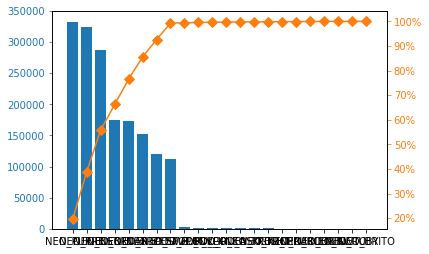

In [61]:
data2=final_prediction_Cummulat.groupby('PRODUCT_ID')['demand'].sum()
data2=pd.DataFrame(data2)
data2=data2.reset_index()
df = pd.DataFrame(data2.demand)
df.index = data2.PRODUCT_ID
df = df.sort_values(by='demand',ascending=False)
df["cumpercentage"] = df["demand"].cumsum()/df["demand"].sum()*100
df['percentage']=df.demand/(np.sum(df.demand))
fig, ax = plt.subplots()
ax.bar(df.index, df["demand"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()




In [62]:
print(df)

demand cumpercentage percentage
PRODUCT_ID 
NEO_PUR.E 332580.001 19.662371 0.196624
NEO_FRE.E 324960.001 38.874242 0.192119
NEO_BST.E 287040.000 55.844255 0.169700
NEO_BRT.E 175220.001 66.203389 0.103591
NEO_DAR.E 173960.001 76.488030 0.102846
NEO_TRO.E 152360.003 85.495664 0.090076
NEO_ZEST.E 120260.000 92.605523 0.071099
NEO_SWT.E 112620.005 99.263699 0.066582
POD_PUR_K 2649.000 99.420310 0.001566
POD_NV_K 1995.002 99.538256 0.001179
POD_GR_K 1389.001 99.620375 0.000821
POD_RUBY_K 1251.001 99.694335 0.000740
POD_ASKG 1101.002 99.759427 0.000651
NEO_FRESH 720.018 99.801995 0.000426
NEO_TROPI 660.025 99.841016 0.000390
POD_TIRA 609.003 99.877021 0.000360
NEO_PURLE 560.020 99.910129 0.000331
NEO_BOOST 480.026 99.938509 0.000284
NEO_BRISW 360.019 99.959794 0.000213
NEO_RICTO 260.020 99.975166 0.000154
NEO_RUBY 220.027 99.988174 0.000130
NEO_BRITO 200.027 100.000000 0.000118

In [63]:
df.head(100)

demand 
 cumpercentage 
 percentage 
 
 
 BRAND_FAMILY 
 
 
 
 
 
 
 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 
 
 NEO PODS 
 9075.006 
 99.795451 
 0.005365 
 
 
 NEO 
 3460.019 
 100.000000 
 0.002045

In [64]:
final_prediction_Cummulat.head()

date 
 MONTH 
 YEAR 
 COMPANY_ID 
 COMPANY_NAME 
 BRAND_FAMILY 
 Key accounts 
 demand 
 forecast 
 uid 
 MSE 
 MAE 
 MAPE 
 Acc 
 
 
 
 
 7 
 2020/3 
 3 
 2020 
 BAT 
 British American Tobacco 
 NEO PODS 
 CS 
 0.001 
 4.378252 
 NEO PODS-CS 
 5.353406 
 1.793496 
 55681.155722 
 -55581.155722 
 
 
 8 
 2020/4 
 4 
 2020 
 BAT 
 British American Tobacco 
 NEO PODS 
 CS 
 3.000 
 1.028502 
 NEO PODS-CS 
 5.353406 
 1.793496 
 55681.155722 
 -55581.155722 
 
 
 9 
 2020/5 
 5 
 2020 
 BAT 
 British American Tobacco 
 NEO PODS 
 CS 
 3.000 
 0.790374 
 NEO PODS-CS 
 5.353406 
 1.793496 
 55681.155722 
 -55581.155722 
 
 
 10 
 2020/6 
 6 
 2020 
 BAT 
 British American Tobacco 
 NEO PODS 
 CS 
 0.001 
 1.135675 
 NEO PODS-CS 
 5.353406 
 1.793496 
 55681.155722 
 -55581.155722 
 
 
 11 
 2020/7 
 7 
 2020 
 BAT 
 British American Tobacco 
 NEO PODS 
 CS 
 3.000 
 0.105727 
 NEO PODS-CS 
 5.353406 
 1.793496 
 55681.155722 
 -55581.155722

In [65]:
df_cummulate = pd.merge(df,final_prediction[['COMPANY_ID','date','BRAND_FAMILY','MAPE','Acc','Key accounts']], on='BRAND_FAMILY', how='left')



In [66]:
df_cummulate.shape

Out[86]: (147, 9)

In [67]:
df_cummulate1 = df_cummulate.drop_duplicates()
df_cummulate1.shape

Out[87]: (147, 9)

In [68]:
df_cummulate1.head(1000)

BRAND_FAMILY 
 demand 
 cumpercentage 
 percentage 
 COMPANY_ID 
 date 
 MAPE 
 Acc 
 Key accounts 
 
 
 
 
 0 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/3 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 1 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/4 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 2 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/5 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 3 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/6 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 4 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/7 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 5 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/8 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 6 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/9 
 6.601721e+01 
 3.398279e+01 
 CS 
 
 
 7 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/3 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 8 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/4 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 9 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/5 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 10 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/6 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 11 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/7 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 12 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/8 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 13 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/9 
 2.733158e+01 
 7.266842e+01 
 FM 
 
 
 14 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/3 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 15 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/4 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 16 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/5 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 17 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/6 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 18 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/7 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 19 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/8 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 20 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/9 
 2.581664e+01 
 7.418336e+01 
 GS 
 
 
 21 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/3 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 22 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/4 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 23 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/5 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 24 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/6 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 25 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/7 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 26 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/8 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 27 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/9 
 4.199815e+01 
 5.800185e+01 
 HP 
 
 
 28 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/3 
 1.511169e+01 
 8.488831e+01 
 MS 
 
 
 29 
 NEO2.0 
 1679000.000 
 99.258956 
 0.992590 
 BAT 
 2020/4 
 1.511169e+01 
 8.488831e+01 
 MS 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 117 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/8 
 4.021987e+08 
 -4.021986e+08 
 GS 
 
 
 118 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/9 
 4.021987e+08 
 -4.021986e+08 
 GS 
 
 
 119 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/3 
 1.219936e+07 
 -1.219926e+07 
 HP 
 
 
 120 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/4 
 1.219936e+07 
 -1.219926e+07 
 HP 
 
 
 121 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/5 
 1.219936e+07 
 -1.219926e+07 
 HP 
 
 
 122 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/6 
 1.219936e+07 
 -1.219926e+07 
 HP 
 
 
 123 
 NEO 
 3460.019 
 100.000000 
 0.002045 
 BAT 
 2020/7 
 1.219936e+07 

In [69]:
df_cummulate1.to_csv('/dbfs/FileStore/tables/Venkat_KDF_Cummulative_Monthly_Forecast_HoltWinters_BAT_SKU_10thsepv1prayashven.csv') 